In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (VGG19)

2024-02-21 17:12:22.490357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 17:12:22.490461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 17:12:22.600327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(VGG19(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("VGG19"+s+".keras")
    

    # save model to disk
    filename = "VGG19" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 vgg19 (Functional)          (None, 4)                 99740740  


Total params: 99740740 (380.48 MB)


Trainable params: 99740740 (380.48 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708535570.480218      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 35:24 - loss: 1.5105 - accuracy: 0.0000e+00

  2/140 [..............................] - ETA: 27s - loss: 11383.9375 - accuracy: 0.1719  

  3/140 [..............................] - ETA: 27s - loss: 7589.7378 - accuracy: 0.2292 

  4/140 [..............................] - ETA: 27s - loss: 5692.6680 - accuracy: 0.2734

  5/140 [>.............................] - ETA: 26s - loss: 4554.3848 - accuracy: 0.2875

  6/140 [>.............................] - ETA: 26s - loss: 3795.5471 - accuracy: 0.3333

  7/140 [>.............................] - ETA: 26s - loss: 3254.8582 - accuracy: 0.3170

  8/140 [>.............................] - ETA: 26s - loss: 2848.1638 - accuracy: 0.3359

  9/140 [>.............................] - ETA: 26s - loss: 2531.8486 - accuracy: 0.3229

 10/140 [=>............................] - ETA: 25s - loss: 2278.7808 - accuracy: 0.3406

 11/140 [=>............................] - ETA: 25s - loss: 2071.7883 - accuracy: 0.3466

 12/140 [=>............................] - ETA: 25s - loss: 1899.2363 - accuracy: 0.3646

 13/140 [=>............................] - ETA: 25s - loss: 1753.2238 - accuracy: 0.3822

 14/140 [==>...........................] - ETA: 25s - loss: 1628.1816 - accuracy: 0.3951

 15/140 [==>...........................] - ETA: 24s - loss: 1519.7153 - accuracy: 0.4042

 16/140 [==>...........................] - ETA: 24s - loss: 1424.8105 - accuracy: 0.4141

 17/140 [==>...........................] - ETA: 24s - loss: 1341.0724 - accuracy: 0.4191

 18/140 [==>...........................] - ETA: 24s - loss: 1266.6315 - accuracy: 0.4340

 19/140 [===>..........................] - ETA: 24s - loss: 1200.0239 - accuracy: 0.4326

 20/140 [===>..........................] - ETA: 23s - loss: 1140.1027 - accuracy: 0.4281

 21/140 [===>..........................] - ETA: 23s - loss: 1085.8662 - accuracy: 0.4271

 22/140 [===>..........................] - ETA: 23s - loss: 1036.5613 - accuracy: 0.4261

 23/140 [===>..........................] - ETA: 23s - loss: 991.5424 - accuracy: 0.4266 

 24/140 [====>.........................] - ETA: 23s - loss: 950.2796 - accuracy: 0.4245

 25/140 [====>.........................] - ETA: 22s - loss: 912.3159 - accuracy: 0.4225

 26/140 [====>.........................] - ETA: 22s - loss: 877.2706 - accuracy: 0.4255

 27/140 [====>.........................] - ETA: 22s - loss: 844.8198 - accuracy: 0.4259

 28/140 [=====>........................] - ETA: 22s - loss: 814.6879 - accuracy: 0.4230

 29/140 [=====>........................] - ETA: 22s - loss: 786.6290 - accuracy: 0.4278

 30/140 [=====>........................] - ETA: 21s - loss: 760.4391 - accuracy: 0.4333

 31/140 [=====>........................] - ETA: 21s - loss: 735.9364 - accuracy: 0.4425

 32/140 [=====>........................] - ETA: 21s - loss: 712.9856 - accuracy: 0.4414

 33/140 [======>.......................] - ETA: 21s - loss: 691.4090 - accuracy: 0.4432

 34/140 [======>.......................] - ETA: 21s - loss: 671.1076 - accuracy: 0.4384

 35/140 [======>.......................] - ETA: 20s - loss: 651.9660 - accuracy: 0.4393

 36/140 [======>.......................] - ETA: 20s - loss: 633.8865 - accuracy: 0.4418

 37/140 [======>.......................] - ETA: 20s - loss: 616.7855 - accuracy: 0.4443

 38/140 [=======>......................] - ETA: 20s - loss: 600.5832 - accuracy: 0.4449

 39/140 [=======>......................] - ETA: 20s - loss: 585.2144 - accuracy: 0.4415

 40/140 [=======>......................] - ETA: 19s - loss: 570.6094 - accuracy: 0.4430

 41/140 [=======>......................] - ETA: 19s - loss: 556.7158 - accuracy: 0.4436

 42/140 [========>.....................] - ETA: 19s - loss: 543.4816 - accuracy: 0.4457

 43/140 [========>.....................] - ETA: 19s - loss: 530.8680 - accuracy: 0.4469

 44/140 [========>.....................] - ETA: 19s - loss: 518.8198 - accuracy: 0.4496

 45/140 [========>.....................] - ETA: 18s - loss: 507.3264 - accuracy: 0.4472

 46/140 [========>.....................] - ETA: 18s - loss: 496.3265 - accuracy: 0.4443

 47/140 [=========>....................] - ETA: 18s - loss: 485.7900 - accuracy: 0.4468

 48/140 [=========>....................] - ETA: 18s - loss: 475.6920 - accuracy: 0.4473

 49/140 [=========>....................] - ETA: 18s - loss: 466.0065 - accuracy: 0.4458

 50/140 [=========>....................] - ETA: 17s - loss: 456.7077 - accuracy: 0.4475

 51/140 [=========>....................] - ETA: 17s - loss: 447.7742 - accuracy: 0.4485

 52/140 [==========>...................] - ETA: 17s - loss: 439.1834 - accuracy: 0.4501

 53/140 [==========>...................] - ETA: 17s - loss: 430.9165 - accuracy: 0.4522

 54/140 [==========>...................] - ETA: 17s - loss: 422.9566 - accuracy: 0.4508

 55/140 [==========>...................] - ETA: 16s - loss: 415.2852 - accuracy: 0.4523

 56/140 [===========>..................] - ETA: 16s - loss: 407.8877 - accuracy: 0.4537

 57/140 [===========>..................] - ETA: 16s - loss: 400.7498 - accuracy: 0.4534

 58/140 [===========>..................] - ETA: 16s - loss: 393.8576 - accuracy: 0.4547

 59/140 [===========>..................] - ETA: 16s - loss: 387.2030 - accuracy: 0.4523

 60/140 [===========>..................] - ETA: 15s - loss: 380.7674 - accuracy: 0.4526

 61/140 [============>.................] - ETA: 15s - loss: 374.5399 - accuracy: 0.4544

 62/140 [============>.................] - ETA: 15s - loss: 368.5135 - accuracy: 0.4567

 63/140 [============>.................] - ETA: 15s - loss: 362.6817 - accuracy: 0.4583

 64/140 [============>.................] - ETA: 15s - loss: 357.0300 - accuracy: 0.4595

 65/140 [============>.................] - ETA: 14s - loss: 351.5561 - accuracy: 0.4611

 66/140 [=============>................] - ETA: 14s - loss: 346.2441 - accuracy: 0.4616

 67/140 [=============>................] - ETA: 14s - loss: 341.0922 - accuracy: 0.4618

 68/140 [=============>................] - ETA: 14s - loss: 336.0974 - accuracy: 0.4591

 69/140 [=============>................] - ETA: 14s - loss: 331.2416 - accuracy: 0.4601

 70/140 [==============>...............] - ETA: 13s - loss: 326.5236 - accuracy: 0.4607

 71/140 [==============>...............] - ETA: 13s - loss: 321.9391 - accuracy: 0.4604

 72/140 [==============>...............] - ETA: 13s - loss: 317.4843 - accuracy: 0.4592

 73/140 [==============>...............] - ETA: 13s - loss: 313.1484 - accuracy: 0.4576

 74/140 [==============>...............] - ETA: 13s - loss: 308.9307 - accuracy: 0.4578

 75/140 [===============>..............] - ETA: 12s - loss: 304.8254 - accuracy: 0.4583

 76/140 [===============>..............] - ETA: 12s - loss: 300.8264 - accuracy: 0.4609

 77/140 [===============>..............] - ETA: 12s - loss: 296.9313 - accuracy: 0.4631

 78/140 [===============>..............] - ETA: 12s - loss: 293.1376 - accuracy: 0.4639

 79/140 [===============>..............] - ETA: 12s - loss: 289.4442 - accuracy: 0.4624

 80/140 [================>.............] - ETA: 11s - loss: 285.8375 - accuracy: 0.4641

 81/140 [================>.............] - ETA: 11s - loss: 282.3200 - accuracy: 0.4653

 82/140 [================>.............] - ETA: 11s - loss: 278.8892 - accuracy: 0.4657

 83/140 [================>.............] - ETA: 11s - loss: 275.5432 - accuracy: 0.4661

 84/140 [=================>............] - ETA: 11s - loss: 272.2767 - accuracy: 0.4658

 85/140 [=================>............] - ETA: 10s - loss: 269.0842 - accuracy: 0.4669

 86/140 [=================>............] - ETA: 10s - loss: 265.9669 - accuracy: 0.4680

 87/140 [=================>............] - ETA: 10s - loss: 262.9224 - accuracy: 0.4691

 88/140 [=================>............] - ETA: 10s - loss: 259.9472 - accuracy: 0.4698

 89/140 [==================>...........] - ETA: 10s - loss: 257.0385 - accuracy: 0.4705

 90/140 [==================>...........] - ETA: 9s - loss: 254.1947 - accuracy: 0.4708 

 91/140 [==================>...........] - ETA: 9s - loss: 251.4129 - accuracy: 0.4712

 92/140 [==================>...........] - ETA: 9s - loss: 248.6905 - accuracy: 0.4728

 93/140 [==================>...........] - ETA: 9s - loss: 246.0264 - accuracy: 0.4748

 94/140 [===================>..........] - ETA: 9s - loss: 243.4194 - accuracy: 0.4757

 95/140 [===================>..........] - ETA: 8s - loss: 240.8687 - accuracy: 0.4760

 96/140 [===================>..........] - ETA: 8s - loss: 238.3690 - accuracy: 0.4775

 97/140 [===================>..........] - ETA: 8s - loss: 235.9224 - accuracy: 0.4781

 98/140 [====================>.........] - ETA: 8s - loss: 233.5271 - accuracy: 0.4767

 99/140 [====================>.........] - ETA: 8s - loss: 231.1762 - accuracy: 0.4792

100/140 [====================>.........] - ETA: 7s - loss: 228.8767 - accuracy: 0.4784

101/140 [====================>.........] - ETA: 7s - loss: 226.6212 - accuracy: 0.4783

102/140 [====================>.........] - ETA: 7s - loss: 224.4086 - accuracy: 0.4792

103/140 [=====================>........] - ETA: 7s - loss: 222.2404 - accuracy: 0.4791

104/140 [=====================>........] - ETA: 7s - loss: 220.1127 - accuracy: 0.4805

105/140 [=====================>........] - ETA: 6s - loss: 218.0269 - accuracy: 0.4807

106/140 [=====================>........] - ETA: 6s - loss: 215.9790 - accuracy: 0.4817

107/140 [=====================>........] - ETA: 6s - loss: 213.9703 - accuracy: 0.4807

108/140 [======================>.......] - ETA: 6s - loss: 211.9996 - accuracy: 0.4812

109/140 [======================>.......] - ETA: 6s - loss: 210.0647 - accuracy: 0.4808

110/140 [======================>.......] - ETA: 5s - loss: 208.1647 - accuracy: 0.4812

111/140 [======================>.......] - ETA: 5s - loss: 206.2985 - accuracy: 0.4800

112/140 [=======================>......] - ETA: 5s - loss: 204.4663 - accuracy: 0.4788

113/140 [=======================>......] - ETA: 5s - loss: 202.6648 - accuracy: 0.4806

114/140 [=======================>......] - ETA: 5s - loss: 200.8960 - accuracy: 0.4808

115/140 [=======================>......] - ETA: 4s - loss: 199.1585 - accuracy: 0.4804

116/140 [=======================>......] - ETA: 4s - loss: 197.4498 - accuracy: 0.4814

117/140 [========================>.....] - ETA: 4s - loss: 195.7727 - accuracy: 0.4805

118/140 [========================>.....] - ETA: 4s - loss: 194.1218 - accuracy: 0.4820

119/140 [========================>.....] - ETA: 4s - loss: 192.4988 - accuracy: 0.4819

120/140 [========================>.....] - ETA: 3s - loss: 190.9044 - accuracy: 0.4818

121/140 [========================>.....] - ETA: 3s - loss: 189.3353 - accuracy: 0.4814

122/140 [=========================>....] - ETA: 3s - loss: 187.7914 - accuracy: 0.4816

123/140 [=========================>....] - ETA: 3s - loss: 186.2726 - accuracy: 0.4820

124/140 [=========================>....] - ETA: 3s - loss: 184.7799 - accuracy: 0.4816

125/140 [=========================>....] - ETA: 2s - loss: 183.3094 - accuracy: 0.4823

126/140 [==========================>...] - ETA: 2s - loss: 181.8622 - accuracy: 0.4834

127/140 [==========================>...] - ETA: 2s - loss: 180.4382 - accuracy: 0.4833

128/140 [==========================>...] - ETA: 2s - loss: 179.0369 - accuracy: 0.4827

129/140 [==========================>...] - ETA: 2s - loss: 177.6565 - accuracy: 0.4833

130/140 [==========================>...] - ETA: 1s - loss: 176.2985 - accuracy: 0.4820

131/140 [===========================>..] - ETA: 1s - loss: 174.9606 - accuracy: 0.4823

132/140 [===========================>..] - ETA: 1s - loss: 173.6445 - accuracy: 0.4815

133/140 [===========================>..] - ETA: 1s - loss: 172.3462 - accuracy: 0.4819

134/140 [===========================>..] - ETA: 1s - loss: 171.0673 - accuracy: 0.4830

135/140 [===========================>..] - ETA: 0s - loss: 169.8076 - accuracy: 0.4833

136/140 [============================>.] - ETA: 0s - loss: 168.5678 - accuracy: 0.4825

137/140 [============================>.] - ETA: 0s - loss: 167.3446 - accuracy: 0.4827

138/140 [============================>.] - ETA: 0s - loss: 166.1395 - accuracy: 0.4821

139/140 [============================>.] - ETA: 0s - loss: 164.9528 - accuracy: 0.4820

140/140 [==============================] - ETA: 0s - loss: 197.8883 - accuracy: 0.4818

140/140 [==============================] - 51s 256ms/step - loss: 197.8883 - accuracy: 0.4818 - val_loss: 1.0614 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 51s - loss: 1.0662 - accuracy: 0.3438

  2/140 [..............................] - ETA: 27s - loss: 1.0625 - accuracy: 0.3438

  3/140 [..............................] - ETA: 27s - loss: 1.0923 - accuracy: 0.3125

  4/140 [..............................] - ETA: 27s - loss: 1.1394 - accuracy: 0.2812

  5/140 [>.............................] - ETA: 26s - loss: 1.2468 - accuracy: 0.3125

  6/140 [>.............................] - ETA: 26s - loss: 1.2726 - accuracy: 0.3333

  7/140 [>.............................] - ETA: 26s - loss: 1.2728 - accuracy: 0.3393

  8/140 [>.............................] - ETA: 26s - loss: 1.2398 - accuracy: 0.3750

  9/140 [>.............................] - ETA: 26s - loss: 1.2937 - accuracy: 0.3993

 10/140 [=>............................] - ETA: 25s - loss: 1.2748 - accuracy: 0.4000

 11/140 [=>............................] - ETA: 25s - loss: 1.2631 - accuracy: 0.3949

 12/140 [=>............................] - ETA: 25s - loss: 1.2480 - accuracy: 0.3932

 13/140 [=>............................] - ETA: 25s - loss: 1.2472 - accuracy: 0.4014

 14/140 [==>...........................] - ETA: 25s - loss: 1.2408 - accuracy: 0.3973

 15/140 [==>...........................] - ETA: 24s - loss: 1.4920 - accuracy: 0.4146

 16/140 [==>...........................] - ETA: 24s - loss: 1.4690 - accuracy: 0.4102

 17/140 [==>...........................] - ETA: 24s - loss: 1.4831 - accuracy: 0.4118

 18/140 [==>...........................] - ETA: 24s - loss: 1.4645 - accuracy: 0.4149

 19/140 [===>..........................] - ETA: 24s - loss: 1.4553 - accuracy: 0.4030

 20/140 [===>..........................] - ETA: 23s - loss: 1.4539 - accuracy: 0.4016

 21/140 [===>..........................] - ETA: 23s - loss: 1.6798 - accuracy: 0.3943

 22/140 [===>..........................] - ETA: 23s - loss: 1.6733 - accuracy: 0.3935

 23/140 [===>..........................] - ETA: 23s - loss: 1.6538 - accuracy: 0.3886

 24/140 [====>.........................] - ETA: 23s - loss: 1.6332 - accuracy: 0.3867

 25/140 [====>.........................] - ETA: 22s - loss: 1.6901 - accuracy: 0.3775

 26/140 [====>.........................] - ETA: 22s - loss: 1.6749 - accuracy: 0.3774

 27/140 [====>.........................] - ETA: 22s - loss: 1.6515 - accuracy: 0.3819

 28/140 [=====>........................] - ETA: 22s - loss: 1.6530 - accuracy: 0.3783

 29/140 [=====>........................] - ETA: 22s - loss: 65.9088 - accuracy: 0.3793

 30/140 [=====>........................] - ETA: 21s - loss: 64.2935 - accuracy: 0.3771

 31/140 [=====>........................] - ETA: 21s - loss: 62.4003 - accuracy: 0.3730

 32/140 [=====>........................] - ETA: 21s - loss: 60.7623 - accuracy: 0.3701

 33/140 [======>.......................] - ETA: 21s - loss: 61.5097 - accuracy: 0.3750

 34/140 [======>.......................] - ETA: 21s - loss: 62.8739 - accuracy: 0.3768

 35/140 [======>.......................] - ETA: 20s - loss: 61.2101 - accuracy: 0.3714

 36/140 [======>.......................] - ETA: 20s - loss: 59.6014 - accuracy: 0.3620

 37/140 [======>.......................] - ETA: 20s - loss: 58.1248 - accuracy: 0.3640

 38/140 [=======>......................] - ETA: 20s - loss: 56.9301 - accuracy: 0.3668

 39/140 [=======>......................] - ETA: 20s - loss: 55.5759 - accuracy: 0.3614

 40/140 [=======>......................] - ETA: 19s - loss: 54.2141 - accuracy: 0.3656

 41/140 [=======>......................] - ETA: 19s - loss: 52.9347 - accuracy: 0.3582

 42/140 [========>.....................] - ETA: 19s - loss: 51.7241 - accuracy: 0.3594

 43/140 [========>.....................] - ETA: 19s - loss: 50.6607 - accuracy: 0.3619

 44/140 [========>.....................] - ETA: 19s - loss: 49.5688 - accuracy: 0.3622

 45/140 [========>.....................] - ETA: 18s - loss: 48.5042 - accuracy: 0.3639

 46/140 [========>.....................] - ETA: 18s - loss: 47.4720 - accuracy: 0.3655

 47/140 [=========>....................] - ETA: 18s - loss: 46.4888 - accuracy: 0.3670

 48/140 [=========>....................] - ETA: 18s - loss: 45.5446 - accuracy: 0.3704

 49/140 [=========>....................] - ETA: 18s - loss: 44.6398 - accuracy: 0.3731

 50/140 [=========>....................] - ETA: 17s - loss: 43.7660 - accuracy: 0.3787

 51/140 [=========>....................] - ETA: 17s - loss: 42.9319 - accuracy: 0.3793

 52/140 [==========>...................] - ETA: 17s - loss: 42.1243 - accuracy: 0.3798

 53/140 [==========>...................] - ETA: 17s - loss: 41.3498 - accuracy: 0.3785

 54/140 [==========>...................] - ETA: 17s - loss: 40.6034 - accuracy: 0.3808

 55/140 [==========>...................] - ETA: 16s - loss: 39.8882 - accuracy: 0.3795

 56/140 [===========>..................] - ETA: 16s - loss: 39.1940 - accuracy: 0.3823

 57/140 [===========>..................] - ETA: 16s - loss: 38.5261 - accuracy: 0.3827

 58/140 [===========>..................] - ETA: 16s - loss: 37.8774 - accuracy: 0.3858

 59/140 [===========>..................] - ETA: 16s - loss: 37.2941 - accuracy: 0.3888

 60/140 [===========>..................] - ETA: 15s - loss: 36.6900 - accuracy: 0.3880

 61/140 [============>.................] - ETA: 15s - loss: 36.1045 - accuracy: 0.3893

 62/140 [============>.................] - ETA: 15s - loss: 35.5389 - accuracy: 0.3886

 63/140 [============>.................] - ETA: 15s - loss: 34.9956 - accuracy: 0.3874

 64/140 [============>.................] - ETA: 15s - loss: 34.4694 - accuracy: 0.3896

 65/140 [============>.................] - ETA: 14s - loss: 33.9624 - accuracy: 0.3880

 66/140 [=============>................] - ETA: 14s - loss: 33.4677 - accuracy: 0.3883

 67/140 [=============>................] - ETA: 14s - loss: 32.9972 - accuracy: 0.3881

 68/140 [=============>................] - ETA: 14s - loss: 32.5291 - accuracy: 0.3892

 69/140 [=============>................] - ETA: 14s - loss: 32.0797 - accuracy: 0.3872

 70/140 [==============>...............] - ETA: 13s - loss: 31.6381 - accuracy: 0.3888

 71/140 [==============>...............] - ETA: 13s - loss: 31.2052 - accuracy: 0.3908

 72/140 [==============>...............] - ETA: 13s - loss: 30.7845 - accuracy: 0.3941

 73/140 [==============>...............] - ETA: 13s - loss: 30.3780 - accuracy: 0.3947

 74/140 [==============>...............] - ETA: 13s - loss: 29.9818 - accuracy: 0.3961

 75/140 [===============>..............] - ETA: 12s - loss: 29.5995 - accuracy: 0.3950

 76/140 [===============>..............] - ETA: 12s - loss: 29.2245 - accuracy: 0.3960

 77/140 [===============>..............] - ETA: 12s - loss: 28.8615 - accuracy: 0.3961

 78/140 [===============>..............] - ETA: 12s - loss: 28.5064 - accuracy: 0.3954

 79/140 [===============>..............] - ETA: 12s - loss: 28.1596 - accuracy: 0.3960

 80/140 [================>.............] - ETA: 11s - loss: 27.8221 - accuracy: 0.3969

 81/140 [================>.............] - ETA: 11s - loss: 27.4918 - accuracy: 0.3981

 82/140 [================>.............] - ETA: 11s - loss: 27.1670 - accuracy: 0.4005

 83/140 [================>.............] - ETA: 11s - loss: 26.8508 - accuracy: 0.4029

 84/140 [=================>............] - ETA: 11s - loss: 26.5452 - accuracy: 0.4048

 85/140 [=================>............] - ETA: 10s - loss: 26.2468 - accuracy: 0.4062

 86/140 [=================>............] - ETA: 10s - loss: 25.9547 - accuracy: 0.4059

 87/140 [=================>............] - ETA: 10s - loss: 25.6681 - accuracy: 0.4080

 88/140 [=================>............] - ETA: 10s - loss: 25.3881 - accuracy: 0.4094

 89/140 [==================>...........] - ETA: 10s - loss: 25.1148 - accuracy: 0.4108

 90/140 [==================>...........] - ETA: 9s - loss: 24.8468 - accuracy: 0.4111 

 91/140 [==================>...........] - ETA: 9s - loss: 24.5858 - accuracy: 0.4141

 92/140 [==================>...........] - ETA: 9s - loss: 24.3288 - accuracy: 0.4161

 93/140 [==================>...........] - ETA: 9s - loss: 24.0781 - accuracy: 0.4173

 94/140 [===================>..........] - ETA: 9s - loss: 23.8341 - accuracy: 0.4186

 95/140 [===================>..........] - ETA: 8s - loss: 23.5943 - accuracy: 0.4197

 96/140 [===================>..........] - ETA: 8s - loss: 23.3578 - accuracy: 0.4219

 97/140 [===================>..........] - ETA: 8s - loss: 23.1284 - accuracy: 0.4227

 98/140 [====================>.........] - ETA: 8s - loss: 22.9028 - accuracy: 0.4238

 99/140 [====================>.........] - ETA: 8s - loss: 22.6828 - accuracy: 0.4233

100/140 [====================>.........] - ETA: 7s - loss: 22.4659 - accuracy: 0.4241

101/140 [====================>.........] - ETA: 7s - loss: 22.2548 - accuracy: 0.4248

102/140 [====================>.........] - ETA: 7s - loss: 22.0459 - accuracy: 0.4252

103/140 [=====================>........] - ETA: 7s - loss: 21.8415 - accuracy: 0.4251

104/140 [=====================>........] - ETA: 7s - loss: 21.6403 - accuracy: 0.4243

105/140 [=====================>........] - ETA: 6s - loss: 21.4438 - accuracy: 0.4229

106/140 [=====================>........] - ETA: 6s - loss: 21.2506 - accuracy: 0.4228

107/140 [=====================>........] - ETA: 6s - loss: 21.0612 - accuracy: 0.4226

108/140 [======================>.......] - ETA: 6s - loss: 20.8759 - accuracy: 0.4239

109/140 [======================>.......] - ETA: 6s - loss: 20.6950 - accuracy: 0.4249

110/140 [======================>.......] - ETA: 5s - loss: 20.5161 - accuracy: 0.4261

111/140 [======================>.......] - ETA: 5s - loss: 20.3431 - accuracy: 0.4251

112/140 [=======================>......] - ETA: 5s - loss: 20.1703 - accuracy: 0.4261

113/140 [=======================>......] - ETA: 5s - loss: 20.0014 - accuracy: 0.4259

114/140 [=======================>......] - ETA: 5s - loss: 19.8364 - accuracy: 0.4263

115/140 [=======================>......] - ETA: 4s - loss: 19.6735 - accuracy: 0.4258

116/140 [=======================>......] - ETA: 4s - loss: 19.5121 - accuracy: 0.4273

117/140 [========================>.....] - ETA: 4s - loss: 19.3553 - accuracy: 0.4276

118/140 [========================>.....] - ETA: 4s - loss: 19.2004 - accuracy: 0.4277

119/140 [========================>.....] - ETA: 4s - loss: 19.0472 - accuracy: 0.4296

120/140 [========================>.....] - ETA: 3s - loss: 18.8968 - accuracy: 0.4310

121/140 [========================>.....] - ETA: 3s - loss: 18.7491 - accuracy: 0.4310

122/140 [=========================>....] - ETA: 3s - loss: 18.6053 - accuracy: 0.4296

123/140 [=========================>....] - ETA: 3s - loss: 18.4620 - accuracy: 0.4311

124/140 [=========================>....] - ETA: 3s - loss: 18.3223 - accuracy: 0.4317

125/140 [=========================>....] - ETA: 2s - loss: 18.1837 - accuracy: 0.4317

126/140 [==========================>...] - ETA: 2s - loss: 18.0487 - accuracy: 0.4306

127/140 [==========================>...] - ETA: 2s - loss: 17.9149 - accuracy: 0.4311

128/140 [==========================>...] - ETA: 2s - loss: 17.7831 - accuracy: 0.4316

129/140 [==========================>...] - ETA: 2s - loss: 17.6527 - accuracy: 0.4322

130/140 [==========================>...] - ETA: 1s - loss: 17.5238 - accuracy: 0.4332

131/140 [===========================>..] - ETA: 1s - loss: 17.3991 - accuracy: 0.4337

132/140 [===========================>..] - ETA: 1s - loss: 17.2753 - accuracy: 0.4339

133/140 [===========================>..] - ETA: 1s - loss: 17.1540 - accuracy: 0.4342

134/140 [===========================>..] - ETA: 1s - loss: 17.0347 - accuracy: 0.4349

135/140 [===========================>..] - ETA: 0s - loss: 16.9158 - accuracy: 0.4359

136/140 [============================>.] - ETA: 0s - loss: 16.7992 - accuracy: 0.4357

137/140 [============================>.] - ETA: 0s - loss: 16.6854 - accuracy: 0.4350

138/140 [============================>.] - ETA: 0s - loss: 16.5723 - accuracy: 0.4359

139/140 [============================>.] - ETA: 0s - loss: 16.4601 - accuracy: 0.4359

140/140 [==============================] - ETA: 0s - loss: 2690738.0000 - accuracy: 0.4363

140/140 [==============================] - 30s 216ms/step - loss: 2690738.0000 - accuracy: 0.4363 - val_loss: 1.1925 - val_accuracy: 0.3503


Epoch 3/30


  1/140 [..............................] - ETA: 50s - loss: 1.0756 - accuracy: 0.4375

  2/140 [..............................] - ETA: 27s - loss: 5.2395 - accuracy: 0.4062

  3/140 [..............................] - ETA: 27s - loss: 9.7406 - accuracy: 0.3125

  4/140 [..............................] - ETA: 27s - loss: 10.1287 - accuracy: 0.2969

  5/140 [>.............................] - ETA: 26s - loss: 8.4926 - accuracy: 0.2562 

  6/140 [>.............................] - ETA: 26s - loss: 7.7667 - accuracy: 0.2292

  7/140 [>.............................] - ETA: 26s - loss: 6.8430 - accuracy: 0.2500

  8/140 [>.............................] - ETA: 26s - loss: 6.1618 - accuracy: 0.2617

  9/140 [>.............................] - ETA: 26s - loss: 5.6213 - accuracy: 0.2569

 10/140 [=>............................] - ETA: 25s - loss: 5.1742 - accuracy: 0.2438

 11/140 [=>............................] - ETA: 25s - loss: 4.8729 - accuracy: 0.2557

 12/140 [=>............................] - ETA: 25s - loss: 4.5831 - accuracy: 0.2604

 13/140 [=>............................] - ETA: 25s - loss: 4.4130 - accuracy: 0.2764

 14/140 [==>...........................] - ETA: 25s - loss: 4.7954 - accuracy: 0.3013

 15/140 [==>...........................] - ETA: 24s - loss: 4.5530 - accuracy: 0.3125

 16/140 [==>...........................] - ETA: 24s - loss: 4.3447 - accuracy: 0.3164

 17/140 [==>...........................] - ETA: 24s - loss: 4.1696 - accuracy: 0.3199

 18/140 [==>...........................] - ETA: 24s - loss: 4.0181 - accuracy: 0.3194

 19/140 [===>..........................] - ETA: 24s - loss: 3.8732 - accuracy: 0.3240

 20/140 [===>..........................] - ETA: 23s - loss: 3.7424 - accuracy: 0.3297

 21/140 [===>..........................] - ETA: 23s - loss: 5.0244 - accuracy: 0.3333

 22/140 [===>..........................] - ETA: 23s - loss: 4.8542 - accuracy: 0.3395

 23/140 [===>..........................] - ETA: 23s - loss: 4.7447 - accuracy: 0.3356

 24/140 [====>.........................] - ETA: 23s - loss: 4.6077 - accuracy: 0.3320

 25/140 [====>.........................] - ETA: 22s - loss: 4.4661 - accuracy: 0.3400

 26/140 [====>.........................] - ETA: 22s - loss: 4.3368 - accuracy: 0.3450

 27/140 [====>.........................] - ETA: 22s - loss: 4.3302 - accuracy: 0.3414

 28/140 [=====>........................] - ETA: 22s - loss: 4.2233 - accuracy: 0.3449

 29/140 [=====>........................] - ETA: 22s - loss: 4.1182 - accuracy: 0.3362

 30/140 [=====>........................] - ETA: 21s - loss: 4.0178 - accuracy: 0.3427

 31/140 [=====>........................] - ETA: 21s - loss: 3.9241 - accuracy: 0.3458

 32/140 [=====>........................] - ETA: 21s - loss: 3.8347 - accuracy: 0.3486

 33/140 [======>.......................] - ETA: 21s - loss: 3.7538 - accuracy: 0.3456

 34/140 [======>.......................] - ETA: 21s - loss: 3.6815 - accuracy: 0.3511

 35/140 [======>.......................] - ETA: 20s - loss: 3.6073 - accuracy: 0.3562

 36/140 [======>.......................] - ETA: 20s - loss: 3.5416 - accuracy: 0.3576

 37/140 [======>.......................] - ETA: 20s - loss: 3.4725 - accuracy: 0.3657

 38/140 [=======>......................] - ETA: 20s - loss: 3.4118 - accuracy: 0.3668

 39/140 [=======>......................] - ETA: 20s - loss: 3.3494 - accuracy: 0.3702

 40/140 [=======>......................] - ETA: 19s - loss: 3.2904 - accuracy: 0.3727

 41/140 [=======>......................] - ETA: 19s - loss: 3.2384 - accuracy: 0.3742

 42/140 [========>.....................] - ETA: 19s - loss: 3.1868 - accuracy: 0.3705

 43/140 [========>.....................] - ETA: 19s - loss: 3.1374 - accuracy: 0.3714

 44/140 [========>.....................] - ETA: 19s - loss: 3.0878 - accuracy: 0.3736

 45/140 [========>.....................] - ETA: 18s - loss: 3.0401 - accuracy: 0.3785

 46/140 [========>.....................] - ETA: 18s - loss: 2.9964 - accuracy: 0.3811

 47/140 [=========>....................] - ETA: 18s - loss: 2.9557 - accuracy: 0.3803

 48/140 [=========>....................] - ETA: 18s - loss: 2.9151 - accuracy: 0.3809

 49/140 [=========>....................] - ETA: 18s - loss: 2.8751 - accuracy: 0.3827

 50/140 [=========>....................] - ETA: 17s - loss: 2.8360 - accuracy: 0.3837

 51/140 [=========>....................] - ETA: 17s - loss: 2.8000 - accuracy: 0.3830

 52/140 [==========>...................] - ETA: 17s - loss: 2.7684 - accuracy: 0.3846

 53/140 [==========>...................] - ETA: 17s - loss: 2.7372 - accuracy: 0.3844

 54/140 [==========>...................] - ETA: 17s - loss: 2.7067 - accuracy: 0.3843

 55/140 [==========>...................] - ETA: 16s - loss: 2.6747 - accuracy: 0.3886

 56/140 [===========>..................] - ETA: 16s - loss: 2.6450 - accuracy: 0.3901

 57/140 [===========>..................] - ETA: 16s - loss: 2.6166 - accuracy: 0.3925

 58/140 [===========>..................] - ETA: 16s - loss: 2.5888 - accuracy: 0.3955

 59/140 [===========>..................] - ETA: 16s - loss: 2.5667 - accuracy: 0.3941

 60/140 [===========>..................] - ETA: 15s - loss: 2.5411 - accuracy: 0.3979

 61/140 [============>.................] - ETA: 15s - loss: 2.5157 - accuracy: 0.3991

 62/140 [============>.................] - ETA: 15s - loss: 2.4932 - accuracy: 0.3992

 63/140 [============>.................] - ETA: 15s - loss: 2.4715 - accuracy: 0.4023

 64/140 [============>.................] - ETA: 15s - loss: 2.4507 - accuracy: 0.4033

 65/140 [============>.................] - ETA: 14s - loss: 2.4286 - accuracy: 0.4043

 66/140 [=============>................] - ETA: 14s - loss: 2.4086 - accuracy: 0.4048

 67/140 [=============>................] - ETA: 14s - loss: 2.3873 - accuracy: 0.4072

 68/140 [=============>................] - ETA: 14s - loss: 2.3675 - accuracy: 0.4081

 69/140 [=============>................] - ETA: 14s - loss: 2.3479 - accuracy: 0.4099

 70/140 [==============>...............] - ETA: 13s - loss: 2.3302 - accuracy: 0.4112

 71/140 [==============>...............] - ETA: 13s - loss: 2.3126 - accuracy: 0.4120

 72/140 [==============>...............] - ETA: 13s - loss: 2.2958 - accuracy: 0.4132

 73/140 [==============>...............] - ETA: 13s - loss: 2.2772 - accuracy: 0.4148

 74/140 [==============>...............] - ETA: 13s - loss: 2.2616 - accuracy: 0.4172

 75/140 [===============>..............] - ETA: 12s - loss: 2.2446 - accuracy: 0.4196

 76/140 [===============>..............] - ETA: 12s - loss: 2.2287 - accuracy: 0.4223

 77/140 [===============>..............] - ETA: 12s - loss: 2.2138 - accuracy: 0.4225

 78/140 [===============>..............] - ETA: 12s - loss: 2.2003 - accuracy: 0.4223

 79/140 [===============>..............] - ETA: 12s - loss: 2.1841 - accuracy: 0.4244

 80/140 [================>.............] - ETA: 11s - loss: 2.1706 - accuracy: 0.4242

 81/140 [================>.............] - ETA: 11s - loss: 2.1554 - accuracy: 0.4255

 82/140 [================>.............] - ETA: 11s - loss: 2.1412 - accuracy: 0.4272

 83/140 [================>.............] - ETA: 11s - loss: 2.1263 - accuracy: 0.4292

 84/140 [=================>............] - ETA: 11s - loss: 2.1158 - accuracy: 0.4289

 85/140 [=================>............] - ETA: 10s - loss: 2.1026 - accuracy: 0.4305

 86/140 [=================>............] - ETA: 10s - loss: 2.0879 - accuracy: 0.4317

 87/140 [=================>............] - ETA: 10s - loss: 2.0772 - accuracy: 0.4318

 88/140 [=================>............] - ETA: 10s - loss: 2.0654 - accuracy: 0.4329

 89/140 [==================>...........] - ETA: 10s - loss: 2.0529 - accuracy: 0.4329

 90/140 [==================>...........] - ETA: 9s - loss: 2.0416 - accuracy: 0.4347 

 91/140 [==================>...........] - ETA: 9s - loss: 2.0302 - accuracy: 0.4358

 92/140 [==================>...........] - ETA: 9s - loss: 2.0190 - accuracy: 0.4372

 93/140 [==================>...........] - ETA: 9s - loss: 2.0072 - accuracy: 0.4392

 94/140 [===================>..........] - ETA: 9s - loss: 1.9976 - accuracy: 0.4395

 95/140 [===================>..........] - ETA: 8s - loss: 1.9879 - accuracy: 0.4401

 96/140 [===================>..........] - ETA: 8s - loss: 1.9799 - accuracy: 0.4395

 97/140 [===================>..........] - ETA: 8s - loss: 1.9700 - accuracy: 0.4401

 98/140 [====================>.........] - ETA: 8s - loss: 1.9590 - accuracy: 0.4423

 99/140 [====================>.........] - ETA: 8s - loss: 1.9493 - accuracy: 0.4429

100/140 [====================>.........] - ETA: 7s - loss: 1.9397 - accuracy: 0.4450

101/140 [====================>.........] - ETA: 7s - loss: 1.9312 - accuracy: 0.4462

102/140 [====================>.........] - ETA: 7s - loss: 1.9235 - accuracy: 0.4461

103/140 [=====================>........] - ETA: 7s - loss: 1.9148 - accuracy: 0.4463

104/140 [=====================>........] - ETA: 7s - loss: 1.9056 - accuracy: 0.4471

105/140 [=====================>........] - ETA: 6s - loss: 1.8968 - accuracy: 0.4473

106/140 [=====================>........] - ETA: 6s - loss: 1.8897 - accuracy: 0.4481

107/140 [=====================>........] - ETA: 6s - loss: 1.8812 - accuracy: 0.4483

108/140 [======================>.......] - ETA: 6s - loss: 1.8740 - accuracy: 0.4497

109/140 [======================>.......] - ETA: 6s - loss: 1.8658 - accuracy: 0.4504

110/140 [======================>.......] - ETA: 5s - loss: 1.8586 - accuracy: 0.4509

111/140 [======================>.......] - ETA: 5s - loss: 1.8521 - accuracy: 0.4505

112/140 [=======================>......] - ETA: 5s - loss: 1.8451 - accuracy: 0.4498

113/140 [=======================>......] - ETA: 5s - loss: 1.8381 - accuracy: 0.4497

114/140 [=======================>......] - ETA: 5s - loss: 1.8320 - accuracy: 0.4498

115/140 [=======================>......] - ETA: 4s - loss: 1.8249 - accuracy: 0.4511

116/140 [=======================>......] - ETA: 4s - loss: 1.8181 - accuracy: 0.4526

117/140 [========================>.....] - ETA: 4s - loss: 1.8123 - accuracy: 0.4517

118/140 [========================>.....] - ETA: 4s - loss: 1.8049 - accuracy: 0.4539

119/140 [========================>.....] - ETA: 4s - loss: 1.7983 - accuracy: 0.4538

120/140 [========================>.....] - ETA: 3s - loss: 1.7935 - accuracy: 0.4529

121/140 [========================>.....] - ETA: 3s - loss: 1.7870 - accuracy: 0.4527

122/140 [=========================>....] - ETA: 3s - loss: 1.7805 - accuracy: 0.4531

123/140 [=========================>....] - ETA: 3s - loss: 1.7751 - accuracy: 0.4530

124/140 [=========================>....] - ETA: 3s - loss: 1.7696 - accuracy: 0.4519

125/140 [=========================>....] - ETA: 2s - loss: 1.7634 - accuracy: 0.4520

126/140 [==========================>...] - ETA: 2s - loss: 1.7570 - accuracy: 0.4531

127/140 [==========================>...] - ETA: 2s - loss: 1.7517 - accuracy: 0.4537

128/140 [==========================>...] - ETA: 2s - loss: 1.7466 - accuracy: 0.4536

129/140 [==========================>...] - ETA: 2s - loss: 1.7404 - accuracy: 0.4540

130/140 [==========================>...] - ETA: 1s - loss: 1.7351 - accuracy: 0.4541

131/140 [===========================>..] - ETA: 1s - loss: 1.7295 - accuracy: 0.4540

132/140 [===========================>..] - ETA: 1s - loss: 1.7252 - accuracy: 0.4536

133/140 [===========================>..] - ETA: 1s - loss: 1.7205 - accuracy: 0.4535

134/140 [===========================>..] - ETA: 1s - loss: 1.7149 - accuracy: 0.4545

135/140 [===========================>..] - ETA: 0s - loss: 1.7096 - accuracy: 0.4556

136/140 [============================>.] - ETA: 0s - loss: 1.7043 - accuracy: 0.4550

137/140 [============================>.] - ETA: 0s - loss: 1.6983 - accuracy: 0.4569

138/140 [============================>.] - ETA: 0s - loss: 1.6934 - accuracy: 0.4570

139/140 [============================>.] - ETA: 0s - loss: 1.6894 - accuracy: 0.4568

140/140 [==============================] - ETA: 0s - loss: 72508512.0000 - accuracy: 0.4567

140/140 [==============================] - 30s 216ms/step - loss: 72508512.0000 - accuracy: 0.4567 - val_loss: 1.1157 - val_accuracy: 0.3503


Epoch 4/30


  1/140 [..............................] - ETA: 56s - loss: 1.0651 - accuracy: 0.3750

  2/140 [..............................] - ETA: 27s - loss: 3.7162 - accuracy: 0.3750

  3/140 [..............................] - ETA: 27s - loss: 13.6921 - accuracy: 0.3125

  4/140 [..............................] - ETA: 27s - loss: 17.8896 - accuracy: 0.2734

  5/140 [>.............................] - ETA: 26s - loss: 29.7123 - accuracy: 0.2937

  6/140 [>.............................] - ETA: 26s - loss: 26.9739 - accuracy: 0.3385

  7/140 [>.............................] - ETA: 26s - loss: 46.5314 - accuracy: 0.3393

  8/140 [>.............................] - ETA: 26s - loss: 499.0466 - accuracy: 0.3438

  9/140 [>.............................] - ETA: 26s - loss: 447.2445 - accuracy: 0.3611

 10/140 [=>............................] - ETA: 25s - loss: 403.4005 - accuracy: 0.3594

 11/140 [=>............................] - ETA: 25s - loss: 493.1701 - accuracy: 0.3466

 12/140 [=>............................] - ETA: 25s - loss: 452.1745 - accuracy: 0.3464

 13/140 [=>............................] - ETA: 25s - loss: 417.4717 - accuracy: 0.3413

 14/140 [==>...........................] - ETA: 25s - loss: 387.7234 - accuracy: 0.3504

 15/140 [==>...........................] - ETA: 24s - loss: 361.9394 - accuracy: 0.3604

 16/140 [==>...........................] - ETA: 24s - loss: 339.4744 - accuracy: 0.3613

 17/140 [==>...........................] - ETA: 24s - loss: 319.5754 - accuracy: 0.3585

 18/140 [==>...........................] - ETA: 24s - loss: 301.8838 - accuracy: 0.3698

 19/140 [===>..........................] - ETA: 24s - loss: 286.0896 - accuracy: 0.3717

 20/140 [===>..........................] - ETA: 23s - loss: 271.8474 - accuracy: 0.3766

 21/140 [===>..........................] - ETA: 23s - loss: 258.9639 - accuracy: 0.3735

 22/140 [===>..........................] - ETA: 23s - loss: 247.2467 - accuracy: 0.3722

 23/140 [===>..........................] - ETA: 23s - loss: 236.5459 - accuracy: 0.3791

 24/140 [====>.........................] - ETA: 23s - loss: 227.0392 - accuracy: 0.3711

 25/140 [====>.........................] - ETA: 22s - loss: 218.0094 - accuracy: 0.3650

 26/140 [====>.........................] - ETA: 22s - loss: 209.6787 - accuracy: 0.3582

 27/140 [====>.........................] - ETA: 22s - loss: 201.9544 - accuracy: 0.3646

 28/140 [=====>........................] - ETA: 22s - loss: 194.9529 - accuracy: 0.3694

 29/140 [=====>........................] - ETA: 22s - loss: 188.2606 - accuracy: 0.3804

 30/140 [=====>........................] - ETA: 21s - loss: 182.0205 - accuracy: 0.3823

 31/140 [=====>........................] - ETA: 21s - loss: 176.1844 - accuracy: 0.3821

 32/140 [=====>........................] - ETA: 21s - loss: 170.7134 - accuracy: 0.3818

 33/140 [======>.......................] - ETA: 21s - loss: 165.5755 - accuracy: 0.3788

 34/140 [======>.......................] - ETA: 21s - loss: 160.7385 - accuracy: 0.3787

 35/140 [======>.......................] - ETA: 20s - loss: 156.1773 - accuracy: 0.3804

 36/140 [======>.......................] - ETA: 20s - loss: 151.8686 - accuracy: 0.3837

 37/140 [======>.......................] - ETA: 20s - loss: 147.7927 - accuracy: 0.3860

 38/140 [=======>......................] - ETA: 20s - loss: 143.9384 - accuracy: 0.3816

 39/140 [=======>......................] - ETA: 20s - loss: 140.2738 - accuracy: 0.3862

 40/140 [=======>......................] - ETA: 19s - loss: 136.7892 - accuracy: 0.3930

 41/140 [=======>......................] - ETA: 19s - loss: 133.4768 - accuracy: 0.3963

 42/140 [========>.....................] - ETA: 19s - loss: 130.3205 - accuracy: 0.4010

 43/140 [========>.....................] - ETA: 19s - loss: 127.3139 - accuracy: 0.4019

 44/140 [========>.....................] - ETA: 19s - loss: 124.4378 - accuracy: 0.4048

 45/140 [========>.....................] - ETA: 18s - loss: 121.6988 - accuracy: 0.4069

 46/140 [========>.....................] - ETA: 18s - loss: 119.0811 - accuracy: 0.4049

 47/140 [=========>....................] - ETA: 18s - loss: 116.5677 - accuracy: 0.4049

 48/140 [=========>....................] - ETA: 18s - loss: 114.1615 - accuracy: 0.4089

 49/140 [=========>....................] - ETA: 18s - loss: 111.8529 - accuracy: 0.4107

 50/140 [=========>....................] - ETA: 17s - loss: 109.6385 - accuracy: 0.4106

 51/140 [=========>....................] - ETA: 17s - loss: 107.5102 - accuracy: 0.4105

 52/140 [==========>...................] - ETA: 17s - loss: 105.4613 - accuracy: 0.4129

 53/140 [==========>...................] - ETA: 17s - loss: 103.4922 - accuracy: 0.4127

 54/140 [==========>...................] - ETA: 17s - loss: 101.5943 - accuracy: 0.4138

 55/140 [==========>...................] - ETA: 16s - loss: 99.7665 - accuracy: 0.4148 

 56/140 [===========>..................] - ETA: 16s - loss: 98.0051 - accuracy: 0.4146

 57/140 [===========>..................] - ETA: 16s - loss: 96.3033 - accuracy: 0.4167

 58/140 [===========>..................] - ETA: 16s - loss: 94.6603 - accuracy: 0.4176

 59/140 [===========>..................] - ETA: 16s - loss: 93.0713 - accuracy: 0.4206

 60/140 [===========>..................] - ETA: 15s - loss: 91.5387 - accuracy: 0.4193

 61/140 [============>.................] - ETA: 15s - loss: 90.0534 - accuracy: 0.4211

 62/140 [============>.................] - ETA: 15s - loss: 88.6197 - accuracy: 0.4219

 63/140 [============>.................] - ETA: 15s - loss: 87.2309 - accuracy: 0.4196

 64/140 [============>.................] - ETA: 15s - loss: 85.8843 - accuracy: 0.4214

 65/140 [============>.................] - ETA: 14s - loss: 84.5773 - accuracy: 0.4236

 66/140 [=============>................] - ETA: 14s - loss: 83.3118 - accuracy: 0.4247

 67/140 [=============>................] - ETA: 14s - loss: 82.0823 - accuracy: 0.4268

 68/140 [=============>................] - ETA: 14s - loss: 80.8957 - accuracy: 0.4256

 69/140 [=============>................] - ETA: 14s - loss: 79.7410 - accuracy: 0.4248

 70/140 [==============>...............] - ETA: 13s - loss: 78.6172 - accuracy: 0.4250

 71/140 [==============>...............] - ETA: 13s - loss: 77.5265 - accuracy: 0.4256

 72/140 [==============>...............] - ETA: 13s - loss: 76.4627 - accuracy: 0.4280

 73/140 [==============>...............] - ETA: 13s - loss: 75.4307 - accuracy: 0.4294

 74/140 [==============>...............] - ETA: 13s - loss: 74.4259 - accuracy: 0.4303

 75/140 [===============>..............] - ETA: 12s - loss: 73.4482 - accuracy: 0.4304

 76/140 [===============>..............] - ETA: 12s - loss: 72.4964 - accuracy: 0.4313

 77/140 [===============>..............] - ETA: 12s - loss: 71.5674 - accuracy: 0.4326

 78/140 [===============>..............] - ETA: 12s - loss: 70.6611 - accuracy: 0.4347

 79/140 [===============>..............] - ETA: 12s - loss: 69.7794 - accuracy: 0.4355

 80/140 [================>.............] - ETA: 11s - loss: 68.9195 - accuracy: 0.4367

 81/140 [================>.............] - ETA: 11s - loss: 68.0821 - accuracy: 0.4375

 82/140 [================>.............] - ETA: 11s - loss: 67.2644 - accuracy: 0.4386

 83/140 [================>.............] - ETA: 11s - loss: 66.4696 - accuracy: 0.4386

 84/140 [=================>............] - ETA: 11s - loss: 65.6886 - accuracy: 0.4416

 85/140 [=================>............] - ETA: 10s - loss: 64.9264 - accuracy: 0.4426

 86/140 [=================>............] - ETA: 10s - loss: 64.1822 - accuracy: 0.4437

 87/140 [=================>............] - ETA: 10s - loss: 63.4561 - accuracy: 0.4450

 88/140 [=================>............] - ETA: 10s - loss: 62.7461 - accuracy: 0.4453

 89/140 [==================>...........] - ETA: 10s - loss: 62.0523 - accuracy: 0.4466

 90/140 [==================>...........] - ETA: 9s - loss: 61.3737 - accuracy: 0.4486 

 91/140 [==================>...........] - ETA: 9s - loss: 60.7094 - accuracy: 0.4488

 92/140 [==================>...........] - ETA: 9s - loss: 60.0613 - accuracy: 0.4494

 93/140 [==================>...........] - ETA: 9s - loss: 59.4292 - accuracy: 0.4493

 94/140 [===================>..........] - ETA: 9s - loss: 58.8079 - accuracy: 0.4495

 95/140 [===================>..........] - ETA: 8s - loss: 58.2008 - accuracy: 0.4503

 96/140 [===================>..........] - ETA: 8s - loss: 57.6062 - accuracy: 0.4508

 97/140 [===================>..........] - ETA: 8s - loss: 57.0227 - accuracy: 0.4510

 98/140 [====================>.........] - ETA: 8s - loss: 56.4506 - accuracy: 0.4525

 99/140 [====================>.........] - ETA: 8s - loss: 55.8911 - accuracy: 0.4539

100/140 [====================>.........] - ETA: 7s - loss: 55.3422 - accuracy: 0.4547

101/140 [====================>.........] - ETA: 7s - loss: 54.8054 - accuracy: 0.4548

102/140 [====================>.........] - ETA: 7s - loss: 54.2783 - accuracy: 0.4547

103/140 [=====================>........] - ETA: 7s - loss: 53.7614 - accuracy: 0.4545

104/140 [=====================>........] - ETA: 7s - loss: 53.2549 - accuracy: 0.4546

105/140 [=====================>........] - ETA: 6s - loss: 52.7585 - accuracy: 0.4542

106/140 [=====================>........] - ETA: 6s - loss: 52.2709 - accuracy: 0.4546

107/140 [=====================>........] - ETA: 6s - loss: 51.7912 - accuracy: 0.4559

108/140 [======================>.......] - ETA: 6s - loss: 51.3210 - accuracy: 0.4557

109/140 [======================>.......] - ETA: 6s - loss: 50.8592 - accuracy: 0.4561

110/140 [======================>.......] - ETA: 5s - loss: 50.4064 - accuracy: 0.4574

111/140 [======================>.......] - ETA: 5s - loss: 49.9621 - accuracy: 0.4578

112/140 [=======================>......] - ETA: 5s - loss: 49.5250 - accuracy: 0.4584

113/140 [=======================>......] - ETA: 5s - loss: 49.0963 - accuracy: 0.4582

114/140 [=======================>......] - ETA: 5s - loss: 48.6743 - accuracy: 0.4592

115/140 [=======================>......] - ETA: 4s - loss: 48.2591 - accuracy: 0.4598

116/140 [=======================>......] - ETA: 4s - loss: 47.8522 - accuracy: 0.4601

117/140 [========================>.....] - ETA: 4s - loss: 47.4520 - accuracy: 0.4602

118/140 [========================>.....] - ETA: 4s - loss: 47.0600 - accuracy: 0.4595

119/140 [========================>.....] - ETA: 4s - loss: 46.6731 - accuracy: 0.4606

120/140 [========================>.....] - ETA: 3s - loss: 46.2927 - accuracy: 0.4607

121/140 [========================>.....] - ETA: 3s - loss: 45.9187 - accuracy: 0.4620

122/140 [=========================>....] - ETA: 3s - loss: 45.5511 - accuracy: 0.4631

123/140 [=========================>....] - ETA: 3s - loss: 45.1896 - accuracy: 0.4637

124/140 [=========================>....] - ETA: 3s - loss: 44.8336 - accuracy: 0.4637

125/140 [=========================>....] - ETA: 2s - loss: 44.4829 - accuracy: 0.4640

126/140 [==========================>...] - ETA: 2s - loss: 44.1390 - accuracy: 0.4635

127/140 [==========================>...] - ETA: 2s - loss: 43.8012 - accuracy: 0.4626

128/140 [==========================>...] - ETA: 2s - loss: 43.4672 - accuracy: 0.4629

129/140 [==========================>...] - ETA: 2s - loss: 43.1379 - accuracy: 0.4632

130/140 [==========================>...] - ETA: 1s - loss: 42.8142 - accuracy: 0.4632

131/140 [===========================>..] - ETA: 1s - loss: 42.4953 - accuracy: 0.4645

132/140 [===========================>..] - ETA: 1s - loss: 42.1807 - accuracy: 0.4652

133/140 [===========================>..] - ETA: 1s - loss: 41.8721 - accuracy: 0.4650

134/140 [===========================>..] - ETA: 1s - loss: 41.5677 - accuracy: 0.4641

135/140 [===========================>..] - ETA: 0s - loss: 41.2670 - accuracy: 0.4644

136/140 [============================>.] - ETA: 0s - loss: 40.9709 - accuracy: 0.4648

137/140 [============================>.] - ETA: 0s - loss: 40.6802 - accuracy: 0.4644

138/140 [============================>.] - ETA: 0s - loss: 40.3927 - accuracy: 0.4649

139/140 [============================>.] - ETA: 0s - loss: 40.1094 - accuracy: 0.4652

140/140 [==============================] - ETA: 0s - loss: 2532938496.0000 - accuracy: 0.4652

140/140 [==============================] - 30s 216ms/step - loss: 2532938496.0000 - accuracy: 0.4652 - val_loss: 167.3223 - val_accuracy: 0.3503


Epoch 5/30


  1/140 [..............................] - ETA: 50s - loss: 177.1004 - accuracy: 0.4688

  2/140 [..............................] - ETA: 27s - loss: 89.1418 - accuracy: 0.3906 

  3/140 [..............................] - ETA: 27s - loss: 59.8402 - accuracy: 0.3542

  4/140 [..............................] - ETA: 27s - loss: 45.1989 - accuracy: 0.3281

  5/140 [>.............................] - ETA: 26s - loss: 36.4387 - accuracy: 0.3500

  6/140 [>.............................] - ETA: 26s - loss: 30.5777 - accuracy: 0.3229

  7/140 [>.............................] - ETA: 26s - loss: 26.3937 - accuracy: 0.3348

  8/140 [>.............................] - ETA: 26s - loss: 23.2685 - accuracy: 0.3242

  9/140 [>.............................] - ETA: 26s - loss: 20.8326 - accuracy: 0.3299

 10/140 [=>............................] - ETA: 25s - loss: 18.8785 - accuracy: 0.3344

 11/140 [=>............................] - ETA: 25s - loss: 17.2822 - accuracy: 0.3381

 12/140 [=>............................] - ETA: 25s - loss: 15.9431 - accuracy: 0.3359

 13/140 [=>............................] - ETA: 25s - loss: 14.8030 - accuracy: 0.3534

 14/140 [==>...........................] - ETA: 25s - loss: 13.8181 - accuracy: 0.3683

 15/140 [==>...........................] - ETA: 24s - loss: 12.9891 - accuracy: 0.3771

 16/140 [==>...........................] - ETA: 24s - loss: 12.2601 - accuracy: 0.3887

 17/140 [==>...........................] - ETA: 24s - loss: 11.6020 - accuracy: 0.3989

 18/140 [==>...........................] - ETA: 24s - loss: 11.0173 - accuracy: 0.4097

 19/140 [===>..........................] - ETA: 24s - loss: 10.4969 - accuracy: 0.4095

 20/140 [===>..........................] - ETA: 23s - loss: 10.0287 - accuracy: 0.4109

 21/140 [===>..........................] - ETA: 23s - loss: 9.6256 - accuracy: 0.4107 

 22/140 [===>..........................] - ETA: 23s - loss: 9.2415 - accuracy: 0.4091

 23/140 [===>..........................] - ETA: 23s - loss: 8.8920 - accuracy: 0.4022

 24/140 [====>.........................] - ETA: 23s - loss: 8.5714 - accuracy: 0.3984

 25/140 [====>.........................] - ETA: 22s - loss: 8.2755 - accuracy: 0.3988

 26/140 [====>.........................] - ETA: 22s - loss: 8.0073 - accuracy: 0.3870

 27/140 [====>.........................] - ETA: 22s - loss: 7.7560 - accuracy: 0.3889

 28/140 [=====>........................] - ETA: 22s - loss: 7.5168 - accuracy: 0.3951

 29/140 [=====>........................] - ETA: 22s - loss: 7.2940 - accuracy: 0.3998

 30/140 [=====>........................] - ETA: 21s - loss: 7.0872 - accuracy: 0.4010

 31/140 [=====>........................] - ETA: 21s - loss: 6.8927 - accuracy: 0.4002

 32/140 [=====>........................] - ETA: 21s - loss: 6.7136 - accuracy: 0.4004

 33/140 [======>.......................] - ETA: 21s - loss: 6.5404 - accuracy: 0.4044

 34/140 [======>.......................] - ETA: 21s - loss: 6.3776 - accuracy: 0.4072

 35/140 [======>.......................] - ETA: 20s - loss: 6.2206 - accuracy: 0.4098

 36/140 [======>.......................] - ETA: 20s - loss: 6.0817 - accuracy: 0.4071

 37/140 [======>.......................] - ETA: 20s - loss: 5.9447 - accuracy: 0.4054

 38/140 [=======>......................] - ETA: 20s - loss: 5.8151 - accuracy: 0.4062

 39/140 [=======>......................] - ETA: 20s - loss: 5.6944 - accuracy: 0.4087

 40/140 [=======>......................] - ETA: 19s - loss: 5.5773 - accuracy: 0.4094

 41/140 [=======>......................] - ETA: 19s - loss: 5.4641 - accuracy: 0.4131

 42/140 [========>.....................] - ETA: 19s - loss: 5.3577 - accuracy: 0.4159

 43/140 [========>.....................] - ETA: 19s - loss: 5.2574 - accuracy: 0.4157

 44/140 [========>.....................] - ETA: 19s - loss: 5.1629 - accuracy: 0.4205

 45/140 [========>.....................] - ETA: 18s - loss: 5.0737 - accuracy: 0.4222

 46/140 [========>.....................] - ETA: 18s - loss: 4.9877 - accuracy: 0.4219

 47/140 [=========>....................] - ETA: 18s - loss: 4.9058 - accuracy: 0.4215

 48/140 [=========>....................] - ETA: 18s - loss: 4.8251 - accuracy: 0.4258

 49/140 [=========>....................] - ETA: 18s - loss: 4.7490 - accuracy: 0.4260

 50/140 [=========>....................] - ETA: 17s - loss: 4.6748 - accuracy: 0.4250

 51/140 [=========>....................] - ETA: 17s - loss: 4.6049 - accuracy: 0.4240

 52/140 [==========>...................] - ETA: 17s - loss: 4.5361 - accuracy: 0.4261

 53/140 [==========>...................] - ETA: 17s - loss: 4.4688 - accuracy: 0.4263

 54/140 [==========>...................] - ETA: 17s - loss: 4.4073 - accuracy: 0.4242

 55/140 [==========>...................] - ETA: 16s - loss: 4.3452 - accuracy: 0.4250

 56/140 [===========>..................] - ETA: 16s - loss: 4.2880 - accuracy: 0.4235

 57/140 [===========>..................] - ETA: 16s - loss: 4.2286 - accuracy: 0.4254

 58/140 [===========>..................] - ETA: 16s - loss: 4.1749 - accuracy: 0.4267

 59/140 [===========>..................] - ETA: 16s - loss: 4.1226 - accuracy: 0.4290

 60/140 [===========>..................] - ETA: 15s - loss: 4.0708 - accuracy: 0.4307

 61/140 [============>.................] - ETA: 15s - loss: 4.0212 - accuracy: 0.4314

 62/140 [============>.................] - ETA: 15s - loss: 3.9731 - accuracy: 0.4345

 63/140 [============>.................] - ETA: 15s - loss: 3.9267 - accuracy: 0.4345

 64/140 [============>.................] - ETA: 15s - loss: 3.8813 - accuracy: 0.4370

 65/140 [============>.................] - ETA: 14s - loss: 3.8376 - accuracy: 0.4361

 66/140 [=============>................] - ETA: 14s - loss: 3.7950 - accuracy: 0.4384

 67/140 [=============>................] - ETA: 14s - loss: 3.7577 - accuracy: 0.4380

 68/140 [=============>................] - ETA: 14s - loss: 3.7164 - accuracy: 0.4393

 69/140 [=============>................] - ETA: 14s - loss: 3.6762 - accuracy: 0.4411

 70/140 [==============>...............] - ETA: 13s - loss: 3.6385 - accuracy: 0.4406

 71/140 [==============>...............] - ETA: 13s - loss: 3.6031 - accuracy: 0.4397

 72/140 [==============>...............] - ETA: 13s - loss: 3.5697 - accuracy: 0.4397

 73/140 [==============>...............] - ETA: 13s - loss: 3.5352 - accuracy: 0.4354

 74/140 [==============>...............] - ETA: 13s - loss: 3.5011 - accuracy: 0.4358

 75/140 [===============>..............] - ETA: 12s - loss: 3.4675 - accuracy: 0.4363

 76/140 [===============>..............] - ETA: 12s - loss: 3.4367 - accuracy: 0.4359

 77/140 [===============>..............] - ETA: 12s - loss: 3.4041 - accuracy: 0.4379

 78/140 [===============>..............] - ETA: 12s - loss: 3.3734 - accuracy: 0.4391

 79/140 [===============>..............] - ETA: 12s - loss: 3.3441 - accuracy: 0.4383

 80/140 [================>.............] - ETA: 11s - loss: 3.3155 - accuracy: 0.4391

 81/140 [================>.............] - ETA: 11s - loss: 3.2880 - accuracy: 0.4398

 82/140 [================>.............] - ETA: 11s - loss: 3.2602 - accuracy: 0.4409

 83/140 [================>.............] - ETA: 11s - loss: 3.2323 - accuracy: 0.4420

 84/140 [=================>............] - ETA: 11s - loss: 3.2061 - accuracy: 0.4435

 85/140 [=================>............] - ETA: 10s - loss: 3.1794 - accuracy: 0.4449

 86/140 [=================>............] - ETA: 10s - loss: 3.1548 - accuracy: 0.4466

 87/140 [=================>............] - ETA: 10s - loss: 3.1292 - accuracy: 0.4479

 88/140 [=================>............] - ETA: 10s - loss: 3.1074 - accuracy: 0.4489

 89/140 [==================>...........] - ETA: 10s - loss: 3.0839 - accuracy: 0.4501

 90/140 [==================>...........] - ETA: 9s - loss: 3.0627 - accuracy: 0.4497 

 91/140 [==================>...........] - ETA: 9s - loss: 3.0386 - accuracy: 0.4523

 92/140 [==================>...........] - ETA: 9s - loss: 3.0167 - accuracy: 0.4545

 93/140 [==================>...........] - ETA: 9s - loss: 2.9950 - accuracy: 0.4563

 94/140 [===================>..........] - ETA: 9s - loss: 2.9732 - accuracy: 0.4584

 95/140 [===================>..........] - ETA: 8s - loss: 2.9529 - accuracy: 0.4595

 96/140 [===================>..........] - ETA: 8s - loss: 2.9327 - accuracy: 0.4600

 97/140 [===================>..........] - ETA: 8s - loss: 2.9129 - accuracy: 0.4604

 98/140 [====================>.........] - ETA: 8s - loss: 2.8935 - accuracy: 0.4611

 99/140 [====================>.........] - ETA: 8s - loss: 2.8756 - accuracy: 0.4615

100/140 [====================>.........] - ETA: 7s - loss: 2.8590 - accuracy: 0.4603

101/140 [====================>.........] - ETA: 7s - loss: 2.8409 - accuracy: 0.4604

102/140 [====================>.........] - ETA: 7s - loss: 2.8226 - accuracy: 0.4605

103/140 [=====================>........] - ETA: 7s - loss: 2.8053 - accuracy: 0.4609

104/140 [=====================>........] - ETA: 7s - loss: 2.7880 - accuracy: 0.4627

105/140 [=====================>........] - ETA: 6s - loss: 2.7711 - accuracy: 0.4631

106/140 [=====================>........] - ETA: 6s - loss: 2.7551 - accuracy: 0.4629

107/140 [=====================>........] - ETA: 6s - loss: 2.7384 - accuracy: 0.4638

108/140 [======================>.......] - ETA: 6s - loss: 2.7228 - accuracy: 0.4650

109/140 [======================>.......] - ETA: 6s - loss: 2.7066 - accuracy: 0.4662

110/140 [======================>.......] - ETA: 5s - loss: 2.6923 - accuracy: 0.4659

111/140 [======================>.......] - ETA: 5s - loss: 2.6779 - accuracy: 0.4645

112/140 [=======================>......] - ETA: 5s - loss: 2.6631 - accuracy: 0.4648

113/140 [=======================>......] - ETA: 5s - loss: 2.6490 - accuracy: 0.4643

114/140 [=======================>......] - ETA: 5s - loss: 2.6351 - accuracy: 0.4649

115/140 [=======================>......] - ETA: 4s - loss: 2.6212 - accuracy: 0.4652

116/140 [=======================>......] - ETA: 4s - loss: 2.6086 - accuracy: 0.4650

117/140 [========================>.....] - ETA: 4s - loss: 2.5951 - accuracy: 0.4655

118/140 [========================>.....] - ETA: 4s - loss: 2.5813 - accuracy: 0.4656

119/140 [========================>.....] - ETA: 4s - loss: 2.5678 - accuracy: 0.4659

120/140 [========================>.....] - ETA: 3s - loss: 2.5543 - accuracy: 0.4672

121/140 [========================>.....] - ETA: 3s - loss: 2.5424 - accuracy: 0.4664

122/140 [=========================>....] - ETA: 3s - loss: 2.5301 - accuracy: 0.4659

123/140 [=========================>....] - ETA: 3s - loss: 2.5181 - accuracy: 0.4670

124/140 [=========================>....] - ETA: 3s - loss: 2.5055 - accuracy: 0.4670

125/140 [=========================>....] - ETA: 2s - loss: 2.4941 - accuracy: 0.4663

126/140 [==========================>...] - ETA: 2s - loss: 2.4825 - accuracy: 0.4665

127/140 [==========================>...] - ETA: 2s - loss: 2.4707 - accuracy: 0.4668

128/140 [==========================>...] - ETA: 2s - loss: 2.4600 - accuracy: 0.4666

129/140 [==========================>...] - ETA: 2s - loss: 2.4491 - accuracy: 0.4663

130/140 [==========================>...] - ETA: 1s - loss: 2.4398 - accuracy: 0.4656

131/140 [===========================>..] - ETA: 1s - loss: 2.4287 - accuracy: 0.4659

132/140 [===========================>..] - ETA: 1s - loss: 2.4179 - accuracy: 0.4669

133/140 [===========================>..] - ETA: 1s - loss: 2.4074 - accuracy: 0.4669

134/140 [===========================>..] - ETA: 1s - loss: 2.3967 - accuracy: 0.4669

135/140 [===========================>..] - ETA: 0s - loss: 2.3872 - accuracy: 0.4664

136/140 [============================>.] - ETA: 0s - loss: 2.3771 - accuracy: 0.4669

137/140 [============================>.] - ETA: 0s - loss: 2.3666 - accuracy: 0.4681

138/140 [============================>.] - ETA: 0s - loss: 2.3576 - accuracy: 0.4674

139/140 [============================>.] - ETA: 0s - loss: 2.3492 - accuracy: 0.4683

140/140 [==============================] - ETA: 0s - loss: 7079147520.0000 - accuracy: 0.4681

140/140 [==============================] - 30s 216ms/step - loss: 7079147520.0000 - accuracy: 0.4681 - val_loss: 1.0994 - val_accuracy: 0.3503


Epoch 6/30


  1/140 [..............................] - ETA: 53s - loss: 1.1007 - accuracy: 0.2812

  2/140 [..............................] - ETA: 27s - loss: 1.1540 - accuracy: 0.2969

  3/140 [..............................] - ETA: 27s - loss: 1.2997 - accuracy: 0.2917

  4/140 [..............................] - ETA: 27s - loss: 2.9954 - accuracy: 0.2578

  5/140 [>.............................] - ETA: 26s - loss: 2.6683 - accuracy: 0.3000

  6/140 [>.............................] - ETA: 26s - loss: 2.4433 - accuracy: 0.3177

  7/140 [>.............................] - ETA: 26s - loss: 3.5940 - accuracy: 0.3259

  8/140 [>.............................] - ETA: 26s - loss: 3.2857 - accuracy: 0.3398

  9/140 [>.............................] - ETA: 26s - loss: 3.0604 - accuracy: 0.3403

 10/140 [=>............................] - ETA: 25s - loss: 2.9212 - accuracy: 0.3281

 11/140 [=>............................] - ETA: 25s - loss: 2.7754 - accuracy: 0.3239

 12/140 [=>............................] - ETA: 25s - loss: 2.6561 - accuracy: 0.3021

 13/140 [=>............................] - ETA: 25s - loss: 2.5339 - accuracy: 0.3149

 14/140 [==>...........................] - ETA: 25s - loss: 2.4260 - accuracy: 0.3281

 15/140 [==>...........................] - ETA: 24s - loss: 2.3329 - accuracy: 0.3396

 16/140 [==>...........................] - ETA: 24s - loss: 2.2609 - accuracy: 0.3418

 17/140 [==>...........................] - ETA: 24s - loss: 2.1890 - accuracy: 0.3511

 18/140 [==>...........................] - ETA: 24s - loss: 2.1511 - accuracy: 0.3628

 19/140 [===>..........................] - ETA: 24s - loss: 2.0949 - accuracy: 0.3602

 20/140 [===>..........................] - ETA: 23s - loss: 2.0661 - accuracy: 0.3609

 21/140 [===>..........................] - ETA: 23s - loss: 2.0195 - accuracy: 0.3616

 22/140 [===>..........................] - ETA: 23s - loss: 1.9930 - accuracy: 0.3622

 23/140 [===>..........................] - ETA: 23s - loss: 1.9541 - accuracy: 0.3668

 24/140 [====>.........................] - ETA: 23s - loss: 1.9202 - accuracy: 0.3672

 25/140 [====>.........................] - ETA: 22s - loss: 1.8894 - accuracy: 0.3700

 26/140 [====>.........................] - ETA: 22s - loss: 1.8606 - accuracy: 0.3714

 27/140 [====>.........................] - ETA: 22s - loss: 1.8345 - accuracy: 0.3704

 28/140 [=====>........................] - ETA: 22s - loss: 1.8096 - accuracy: 0.3627

 29/140 [=====>........................] - ETA: 22s - loss: 1.7848 - accuracy: 0.3653

 30/140 [=====>........................] - ETA: 21s - loss: 1.7663 - accuracy: 0.3646

 31/140 [=====>........................] - ETA: 21s - loss: 1.7440 - accuracy: 0.3639

 32/140 [=====>........................] - ETA: 21s - loss: 1.7252 - accuracy: 0.3711

 33/140 [======>.......................] - ETA: 21s - loss: 1.7059 - accuracy: 0.3759

 34/140 [======>.......................] - ETA: 21s - loss: 1.6890 - accuracy: 0.3778

 35/140 [======>.......................] - ETA: 20s - loss: 1.6704 - accuracy: 0.3821

 36/140 [======>.......................] - ETA: 20s - loss: 1.6536 - accuracy: 0.3837

 37/140 [======>.......................] - ETA: 20s - loss: 1.6348 - accuracy: 0.3851

 38/140 [=======>......................] - ETA: 20s - loss: 1.6273 - accuracy: 0.3832

 39/140 [=======>......................] - ETA: 20s - loss: 1.6111 - accuracy: 0.3846

 40/140 [=======>......................] - ETA: 19s - loss: 1.5950 - accuracy: 0.3898

 41/140 [=======>......................] - ETA: 19s - loss: 1.5779 - accuracy: 0.3956

 42/140 [========>.....................] - ETA: 19s - loss: 1.5653 - accuracy: 0.3973

 43/140 [========>.....................] - ETA: 19s - loss: 1.5529 - accuracy: 0.3990

 44/140 [========>.....................] - ETA: 19s - loss: 1.5419 - accuracy: 0.3999

 45/140 [========>.....................] - ETA: 18s - loss: 1.5281 - accuracy: 0.4049

 46/140 [========>.....................] - ETA: 18s - loss: 1.5189 - accuracy: 0.4056

 47/140 [=========>....................] - ETA: 18s - loss: 1.5092 - accuracy: 0.4096

 48/140 [=========>....................] - ETA: 18s - loss: 1.5027 - accuracy: 0.4089

 49/140 [=========>....................] - ETA: 18s - loss: 1.4911 - accuracy: 0.4114

 50/140 [=========>....................] - ETA: 17s - loss: 1.4835 - accuracy: 0.4137

 51/140 [=========>....................] - ETA: 17s - loss: 1.4735 - accuracy: 0.4148

 52/140 [==========>...................] - ETA: 17s - loss: 1.4631 - accuracy: 0.4153

 53/140 [==========>...................] - ETA: 17s - loss: 1.4578 - accuracy: 0.4157

 54/140 [==========>...................] - ETA: 17s - loss: 1.4524 - accuracy: 0.4172

 55/140 [==========>...................] - ETA: 16s - loss: 1.4433 - accuracy: 0.4187

 56/140 [===========>..................] - ETA: 16s - loss: 1.4385 - accuracy: 0.4191

 57/140 [===========>..................] - ETA: 16s - loss: 1.4302 - accuracy: 0.4205

 58/140 [===========>..................] - ETA: 16s - loss: 1.4223 - accuracy: 0.4224

 59/140 [===========>..................] - ETA: 16s - loss: 1.4158 - accuracy: 0.4227

 60/140 [===========>..................] - ETA: 15s - loss: 1.4085 - accuracy: 0.4229

 61/140 [============>.................] - ETA: 15s - loss: 1.4004 - accuracy: 0.4252

 62/140 [============>.................] - ETA: 15s - loss: 1.3958 - accuracy: 0.4254

 63/140 [============>.................] - ETA: 15s - loss: 1.3870 - accuracy: 0.4286

 64/140 [============>.................] - ETA: 15s - loss: 1.3837 - accuracy: 0.4292

 65/140 [============>.................] - ETA: 14s - loss: 1.3776 - accuracy: 0.4322

 66/140 [=============>................] - ETA: 14s - loss: 1.3744 - accuracy: 0.4337

 67/140 [=============>................] - ETA: 14s - loss: 1.3716 - accuracy: 0.4347

 68/140 [=============>................] - ETA: 14s - loss: 1.3685 - accuracy: 0.4347

 69/140 [=============>................] - ETA: 14s - loss: 1.3618 - accuracy: 0.4370

 70/140 [==============>...............] - ETA: 13s - loss: 1.3572 - accuracy: 0.4366

 71/140 [==============>...............] - ETA: 13s - loss: 1.3541 - accuracy: 0.4375

 72/140 [==============>...............] - ETA: 13s - loss: 1.3493 - accuracy: 0.4384

 73/140 [==============>...............] - ETA: 13s - loss: 1.3439 - accuracy: 0.4384

 74/140 [==============>...............] - ETA: 13s - loss: 1.3397 - accuracy: 0.4405

 75/140 [===============>..............] - ETA: 12s - loss: 1.3356 - accuracy: 0.4433

 76/140 [===============>..............] - ETA: 12s - loss: 1.3310 - accuracy: 0.4445

 77/140 [===============>..............] - ETA: 12s - loss: 1.3275 - accuracy: 0.4440

 78/140 [===============>..............] - ETA: 12s - loss: 1.3228 - accuracy: 0.4447

 79/140 [===============>..............] - ETA: 12s - loss: 1.3218 - accuracy: 0.4426

 80/140 [================>.............] - ETA: 11s - loss: 1.3172 - accuracy: 0.4449

 81/140 [================>.............] - ETA: 11s - loss: 1.3133 - accuracy: 0.4468

 82/140 [================>.............] - ETA: 11s - loss: 1.3114 - accuracy: 0.4466

 83/140 [================>.............] - ETA: 11s - loss: 1.3102 - accuracy: 0.4469

 84/140 [=================>............] - ETA: 11s - loss: 1.3085 - accuracy: 0.4483

 85/140 [=================>............] - ETA: 10s - loss: 1.3047 - accuracy: 0.4482

 86/140 [=================>............] - ETA: 10s - loss: 1.3026 - accuracy: 0.4477

 87/140 [=================>............] - ETA: 10s - loss: 1.2998 - accuracy: 0.4476

 88/140 [=================>............] - ETA: 10s - loss: 1.2961 - accuracy: 0.4489

 89/140 [==================>...........] - ETA: 10s - loss: 1.2939 - accuracy: 0.4487

 90/140 [==================>...........] - ETA: 9s - loss: 1.2912 - accuracy: 0.4493 

 91/140 [==================>...........] - ETA: 9s - loss: 1.2893 - accuracy: 0.4505

 92/140 [==================>...........] - ETA: 9s - loss: 1.2863 - accuracy: 0.4521

 93/140 [==================>...........] - ETA: 9s - loss: 1.2832 - accuracy: 0.4526

 94/140 [===================>..........] - ETA: 9s - loss: 1.2795 - accuracy: 0.4535

 95/140 [===================>..........] - ETA: 8s - loss: 1.2755 - accuracy: 0.4556

 96/140 [===================>..........] - ETA: 8s - loss: 1.2747 - accuracy: 0.4551

 97/140 [===================>..........] - ETA: 8s - loss: 1.2721 - accuracy: 0.4565

 98/140 [====================>.........] - ETA: 8s - loss: 1.2691 - accuracy: 0.4563

 99/140 [====================>.........] - ETA: 8s - loss: 1.2673 - accuracy: 0.4568

100/140 [====================>.........] - ETA: 7s - loss: 1.2652 - accuracy: 0.4572

101/140 [====================>.........] - ETA: 7s - loss: 1.2620 - accuracy: 0.4579

102/140 [====================>.........] - ETA: 7s - loss: 1.2581 - accuracy: 0.4599

103/140 [=====================>........] - ETA: 7s - loss: 1.2560 - accuracy: 0.4596

104/140 [=====================>........] - ETA: 7s - loss: 1.2525 - accuracy: 0.4612

105/140 [=====================>........] - ETA: 6s - loss: 1.2524 - accuracy: 0.4610

106/140 [=====================>........] - ETA: 6s - loss: 1.2498 - accuracy: 0.4623

107/140 [=====================>........] - ETA: 6s - loss: 1.2484 - accuracy: 0.4635

108/140 [======================>.......] - ETA: 6s - loss: 1.2459 - accuracy: 0.4647

109/140 [======================>.......] - ETA: 6s - loss: 1.2428 - accuracy: 0.4665

110/140 [======================>.......] - ETA: 5s - loss: 1.2412 - accuracy: 0.4668

111/140 [======================>.......] - ETA: 5s - loss: 1.2382 - accuracy: 0.4679

112/140 [=======================>......] - ETA: 5s - loss: 1.2369 - accuracy: 0.4679

113/140 [=======================>......] - ETA: 5s - loss: 1.2376 - accuracy: 0.4671

114/140 [=======================>......] - ETA: 5s - loss: 1.2360 - accuracy: 0.4663

115/140 [=======================>......] - ETA: 4s - loss: 1.2346 - accuracy: 0.4652

116/140 [=======================>......] - ETA: 4s - loss: 1.2335 - accuracy: 0.4652

117/140 [========================>.....] - ETA: 4s - loss: 1.2321 - accuracy: 0.4645

118/140 [========================>.....] - ETA: 4s - loss: 1.2305 - accuracy: 0.4642

119/140 [========================>.....] - ETA: 4s - loss: 1.2289 - accuracy: 0.4651

120/140 [========================>.....] - ETA: 3s - loss: 1.2280 - accuracy: 0.4654

121/140 [========================>.....] - ETA: 3s - loss: 1.2256 - accuracy: 0.4657

122/140 [=========================>....] - ETA: 3s - loss: 1.2241 - accuracy: 0.4672

123/140 [=========================>....] - ETA: 3s - loss: 1.2234 - accuracy: 0.4665

124/140 [=========================>....] - ETA: 3s - loss: 1.2225 - accuracy: 0.4665

125/140 [=========================>....] - ETA: 2s - loss: 1.2210 - accuracy: 0.4660

126/140 [==========================>...] - ETA: 2s - loss: 1.2190 - accuracy: 0.4663

127/140 [==========================>...] - ETA: 2s - loss: 1.2175 - accuracy: 0.4668

128/140 [==========================>...] - ETA: 2s - loss: 1.2156 - accuracy: 0.4670

129/140 [==========================>...] - ETA: 2s - loss: 1.2158 - accuracy: 0.4658

130/140 [==========================>...] - ETA: 1s - loss: 1.2142 - accuracy: 0.4668

131/140 [===========================>..] - ETA: 1s - loss: 1.2137 - accuracy: 0.4659

132/140 [===========================>..] - ETA: 1s - loss: 1.2140 - accuracy: 0.4661

133/140 [===========================>..] - ETA: 1s - loss: 1.2134 - accuracy: 0.4655

134/140 [===========================>..] - ETA: 1s - loss: 1.2114 - accuracy: 0.4662

135/140 [===========================>..] - ETA: 0s - loss: 1.2097 - accuracy: 0.4669

136/140 [============================>.] - ETA: 0s - loss: 1.2077 - accuracy: 0.4681

137/140 [============================>.] - ETA: 0s - loss: 1.2062 - accuracy: 0.4681

138/140 [============================>.] - ETA: 0s - loss: 1.2047 - accuracy: 0.4681

139/140 [============================>.] - ETA: 0s - loss: 1.2033 - accuracy: 0.4683

140/140 [==============================] - ETA: 0s - loss: 11855565160448.0000 - accuracy: 0.4679

140/140 [==============================] - 30s 216ms/step - loss: 11855565160448.0000 - accuracy: 0.4679 - val_loss: 2.1668 - val_accuracy: 0.5004


Epoch 7/30


  1/140 [..............................] - ETA: 51s - loss: 1.1463 - accuracy: 0.4375

  2/140 [..............................] - ETA: 27s - loss: 1.7070 - accuracy: 0.4062

  3/140 [..............................] - ETA: 27s - loss: 1.9865 - accuracy: 0.4896

  4/140 [..............................] - ETA: 27s - loss: 3.0378 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 26s - loss: 8.1727 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 26s - loss: 13.8129 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 26s - loss: 29.3333 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 26s - loss: 29.9852 - accuracy: 0.4844

  9/140 [>.............................] - ETA: 26s - loss: 27.5689 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 25s - loss: 25.0910 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 25s - loss: 22.9428 - accuracy: 0.4716

 12/140 [=>............................] - ETA: 25s - loss: 21.1307 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 25s - loss: 19.6041 - accuracy: 0.4375

 14/140 [==>...........................] - ETA: 25s - loss: 18.3780 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 24s - loss: 17.2209 - accuracy: 0.4542

 16/140 [==>...........................] - ETA: 24s - loss: 16.2130 - accuracy: 0.4590

 17/140 [==>...........................] - ETA: 24s - loss: 18.1096 - accuracy: 0.4688

 18/140 [==>...........................] - ETA: 24s - loss: 17.3096 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 24s - loss: 16.7330 - accuracy: 0.4720

 20/140 [===>..........................] - ETA: 23s - loss: 16.0559 - accuracy: 0.4703

 21/140 [===>..........................] - ETA: 23s - loss: 15.3675 - accuracy: 0.4762

 22/140 [===>..........................] - ETA: 23s - loss: 14.7631 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 23s - loss: 14.3096 - accuracy: 0.4715

 24/140 [====>.........................] - ETA: 23s - loss: 13.7623 - accuracy: 0.4688

 25/140 [====>.........................] - ETA: 22s - loss: 13.3599 - accuracy: 0.4638

 26/140 [====>.........................] - ETA: 22s - loss: 13.9721 - accuracy: 0.4555

 27/140 [====>.........................] - ETA: 22s - loss: 13.6222 - accuracy: 0.4479

 28/140 [=====>........................] - ETA: 22s - loss: 13.2712 - accuracy: 0.4408

 29/140 [=====>........................] - ETA: 22s - loss: 12.9292 - accuracy: 0.4418

 30/140 [=====>........................] - ETA: 21s - loss: 12.5999 - accuracy: 0.4396

 31/140 [=====>........................] - ETA: 21s - loss: 12.2412 - accuracy: 0.4375

 32/140 [=====>........................] - ETA: 21s - loss: 11.9444 - accuracy: 0.4395

 33/140 [======>.......................] - ETA: 21s - loss: 11.6285 - accuracy: 0.4403

 34/140 [======>.......................] - ETA: 21s - loss: 11.3434 - accuracy: 0.4320

 35/140 [======>.......................] - ETA: 20s - loss: 11.0527 - accuracy: 0.4295

 36/140 [======>.......................] - ETA: 20s - loss: 10.8245 - accuracy: 0.4210

 37/140 [======>.......................] - ETA: 20s - loss: 10.5674 - accuracy: 0.4181

 38/140 [=======>......................] - ETA: 20s - loss: 10.3274 - accuracy: 0.4128

 39/140 [=======>......................] - ETA: 20s - loss: 10.1257 - accuracy: 0.4167

 40/140 [=======>......................] - ETA: 19s - loss: 9.9115 - accuracy: 0.4203 

 41/140 [=======>......................] - ETA: 19s - loss: 9.7359 - accuracy: 0.4230

 42/140 [========>.....................] - ETA: 19s - loss: 9.5620 - accuracy: 0.4219

 43/140 [========>.....................] - ETA: 19s - loss: 9.4413 - accuracy: 0.4135

 44/140 [========>.....................] - ETA: 19s - loss: 9.2583 - accuracy: 0.4134

 45/140 [========>.....................] - ETA: 18s - loss: 9.1285 - accuracy: 0.4146

 46/140 [========>.....................] - ETA: 18s - loss: 8.9830 - accuracy: 0.4164

 47/140 [=========>....................] - ETA: 18s - loss: 8.8177 - accuracy: 0.4156

 48/140 [=========>....................] - ETA: 18s - loss: 8.7034 - accuracy: 0.4141

 49/140 [=========>....................] - ETA: 18s - loss: 8.5662 - accuracy: 0.4120

 50/140 [=========>....................] - ETA: 17s - loss: 8.4708 - accuracy: 0.4119

 51/140 [=========>....................] - ETA: 17s - loss: 8.3411 - accuracy: 0.4112

 52/140 [==========>...................] - ETA: 17s - loss: 8.2090 - accuracy: 0.4099

 53/140 [==========>...................] - ETA: 17s - loss: 8.0872 - accuracy: 0.4027

 54/140 [==========>...................] - ETA: 17s - loss: 7.9566 - accuracy: 0.4010

 55/140 [==========>...................] - ETA: 16s - loss: 7.8328 - accuracy: 0.4040

 56/140 [===========>..................] - ETA: 16s - loss: 7.7188 - accuracy: 0.4035

 57/140 [===========>..................] - ETA: 16s - loss: 7.6009 - accuracy: 0.4052

 58/140 [===========>..................] - ETA: 16s - loss: 7.5036 - accuracy: 0.4030

 59/140 [===========>..................] - ETA: 16s - loss: 7.3955 - accuracy: 0.4015

 60/140 [===========>..................] - ETA: 15s - loss: 7.2943 - accuracy: 0.4031

 61/140 [============>.................] - ETA: 15s - loss: 7.1930 - accuracy: 0.4052

 62/140 [============>.................] - ETA: 15s - loss: 7.0943 - accuracy: 0.4068

 63/140 [============>.................] - ETA: 15s - loss: 6.9978 - accuracy: 0.4097

 64/140 [============>.................] - ETA: 15s - loss: 6.9135 - accuracy: 0.4092

 65/140 [============>.................] - ETA: 14s - loss: 6.8234 - accuracy: 0.4072

 66/140 [=============>................] - ETA: 14s - loss: 6.7343 - accuracy: 0.4091

 67/140 [=============>................] - ETA: 14s - loss: 6.6582 - accuracy: 0.4081

 68/140 [=============>................] - ETA: 14s - loss: 6.5750 - accuracy: 0.4099

 69/140 [=============>................] - ETA: 14s - loss: 6.4927 - accuracy: 0.4121

 70/140 [==============>...............] - ETA: 13s - loss: 6.4135 - accuracy: 0.4116

 71/140 [==============>...............] - ETA: 13s - loss: 6.3361 - accuracy: 0.4120

 72/140 [==============>...............] - ETA: 13s - loss: 6.2657 - accuracy: 0.4093

 73/140 [==============>...............] - ETA: 13s - loss: 6.1953 - accuracy: 0.4092

 74/140 [==============>...............] - ETA: 13s - loss: 6.1280 - accuracy: 0.4096

 75/140 [===============>..............] - ETA: 12s - loss: 6.0606 - accuracy: 0.4112

 76/140 [===============>..............] - ETA: 12s - loss: 5.9931 - accuracy: 0.4141

 77/140 [===============>..............] - ETA: 12s - loss: 5.9300 - accuracy: 0.4156

 78/140 [===============>..............] - ETA: 12s - loss: 5.8646 - accuracy: 0.4191

 79/140 [===============>..............] - ETA: 12s - loss: 5.8051 - accuracy: 0.4181

 80/140 [================>.............] - ETA: 11s - loss: 5.7463 - accuracy: 0.4195

 81/140 [================>.............] - ETA: 11s - loss: 5.6890 - accuracy: 0.4201

 82/140 [================>.............] - ETA: 11s - loss: 5.6336 - accuracy: 0.4207

 83/140 [================>.............] - ETA: 11s - loss: 5.5780 - accuracy: 0.4232

 84/140 [=================>............] - ETA: 11s - loss: 5.5241 - accuracy: 0.4230

 85/140 [=================>............] - ETA: 10s - loss: 5.4723 - accuracy: 0.4243

 86/140 [=================>............] - ETA: 10s - loss: 5.4201 - accuracy: 0.4241

 87/140 [=================>............] - ETA: 10s - loss: 5.3700 - accuracy: 0.4242

 88/140 [=================>............] - ETA: 10s - loss: 5.3196 - accuracy: 0.4261

 89/140 [==================>...........] - ETA: 10s - loss: 5.2734 - accuracy: 0.4273

 90/140 [==================>...........] - ETA: 9s - loss: 5.2253 - accuracy: 0.4295 

 91/140 [==================>...........] - ETA: 9s - loss: 5.1773 - accuracy: 0.4320

 92/140 [==================>...........] - ETA: 9s - loss: 5.1336 - accuracy: 0.4331

 93/140 [==================>...........] - ETA: 9s - loss: 5.0900 - accuracy: 0.4341

 94/140 [===================>..........] - ETA: 9s - loss: 5.0468 - accuracy: 0.4355

 95/140 [===================>..........] - ETA: 8s - loss: 5.0045 - accuracy: 0.4362

 96/140 [===================>..........] - ETA: 8s - loss: 4.9658 - accuracy: 0.4362

 97/140 [===================>..........] - ETA: 8s - loss: 4.9259 - accuracy: 0.4369

 98/140 [====================>.........] - ETA: 8s - loss: 4.8852 - accuracy: 0.4381

 99/140 [====================>.........] - ETA: 8s - loss: 4.8460 - accuracy: 0.4394

100/140 [====================>.........] - ETA: 7s - loss: 4.8078 - accuracy: 0.4387

101/140 [====================>.........] - ETA: 7s - loss: 4.7705 - accuracy: 0.4397

102/140 [====================>.........] - ETA: 7s - loss: 4.7329 - accuracy: 0.4403

103/140 [=====================>........] - ETA: 7s - loss: 4.6976 - accuracy: 0.4405

104/140 [=====================>........] - ETA: 7s - loss: 4.6609 - accuracy: 0.4420

105/140 [=====================>........] - ETA: 6s - loss: 4.6260 - accuracy: 0.4423

106/140 [=====================>........] - ETA: 6s - loss: 4.5934 - accuracy: 0.4416

107/140 [=====================>........] - ETA: 6s - loss: 4.5591 - accuracy: 0.4413

108/140 [======================>.......] - ETA: 6s - loss: 4.5259 - accuracy: 0.4395

109/140 [======================>.......] - ETA: 6s - loss: 4.4945 - accuracy: 0.4375

110/140 [======================>.......] - ETA: 5s - loss: 4.4638 - accuracy: 0.4381

111/140 [======================>.......] - ETA: 5s - loss: 4.4331 - accuracy: 0.4383

112/140 [=======================>......] - ETA: 5s - loss: 4.4022 - accuracy: 0.4392

113/140 [=======================>......] - ETA: 5s - loss: 4.3729 - accuracy: 0.4394

114/140 [=======================>......] - ETA: 5s - loss: 4.3432 - accuracy: 0.4405

115/140 [=======================>......] - ETA: 4s - loss: 4.3159 - accuracy: 0.4399

116/140 [=======================>......] - ETA: 4s - loss: 4.2882 - accuracy: 0.4410

117/140 [========================>.....] - ETA: 4s - loss: 4.2612 - accuracy: 0.4404

118/140 [========================>.....] - ETA: 4s - loss: 4.2346 - accuracy: 0.4404

119/140 [========================>.....] - ETA: 4s - loss: 4.2084 - accuracy: 0.4404

120/140 [========================>.....] - ETA: 3s - loss: 4.1809 - accuracy: 0.4419

121/140 [========================>.....] - ETA: 3s - loss: 4.1556 - accuracy: 0.4429

122/140 [=========================>....] - ETA: 3s - loss: 4.1292 - accuracy: 0.4449

123/140 [=========================>....] - ETA: 3s - loss: 4.1030 - accuracy: 0.4466

124/140 [=========================>....] - ETA: 3s - loss: 4.0788 - accuracy: 0.4463

125/140 [=========================>....] - ETA: 2s - loss: 4.0540 - accuracy: 0.4467

126/140 [==========================>...] - ETA: 2s - loss: 4.0297 - accuracy: 0.4472

127/140 [==========================>...] - ETA: 2s - loss: 4.0066 - accuracy: 0.4464

128/140 [==========================>...] - ETA: 2s - loss: 3.9843 - accuracy: 0.4456

129/140 [==========================>...] - ETA: 2s - loss: 3.9624 - accuracy: 0.4457

130/140 [==========================>...] - ETA: 1s - loss: 3.9395 - accuracy: 0.4466

131/140 [===========================>..] - ETA: 1s - loss: 3.9173 - accuracy: 0.4473

132/140 [===========================>..] - ETA: 1s - loss: 3.8958 - accuracy: 0.4484

133/140 [===========================>..] - ETA: 1s - loss: 3.8744 - accuracy: 0.4485

134/140 [===========================>..] - ETA: 1s - loss: 3.8531 - accuracy: 0.4482

135/140 [===========================>..] - ETA: 0s - loss: 3.8318 - accuracy: 0.4488

136/140 [============================>.] - ETA: 0s - loss: 3.8111 - accuracy: 0.4492

137/140 [============================>.] - ETA: 0s - loss: 3.7917 - accuracy: 0.4489

138/140 [============================>.] - ETA: 0s - loss: 3.7715 - accuracy: 0.4486

139/140 [============================>.] - ETA: 0s - loss: 3.7525 - accuracy: 0.4483

140/140 [==============================] - ETA: 0s - loss: 5657667584.0000 - accuracy: 0.4488

140/140 [==============================] - 30s 216ms/step - loss: 5657667584.0000 - accuracy: 0.4488 - val_loss: 1.7755 - val_accuracy: 0.3495


Epoch 8/30


  1/140 [..............................] - ETA: 50s - loss: 1.5929 - accuracy: 0.1875

  2/140 [..............................] - ETA: 27s - loss: 1.9902 - accuracy: 0.2031

  3/140 [..............................] - ETA: 27s - loss: 2.1718 - accuracy: 0.1667

  4/140 [..............................] - ETA: 27s - loss: 4.1200 - accuracy: 0.1797

  5/140 [>.............................] - ETA: 26s - loss: 4.7761 - accuracy: 0.1813

  6/140 [>.............................] - ETA: 26s - loss: 5.1829 - accuracy: 0.2344

  7/140 [>.............................] - ETA: 26s - loss: 22.7466 - accuracy: 0.2098

  8/140 [>.............................] - ETA: 26s - loss: 20.4476 - accuracy: 0.1992

  9/140 [>.............................] - ETA: 26s - loss: 19.4776 - accuracy: 0.2257

 10/140 [=>............................] - ETA: 25s - loss: 19.9693 - accuracy: 0.2500

 11/140 [=>............................] - ETA: 25s - loss: 19.2028 - accuracy: 0.2585

 12/140 [=>............................] - ETA: 25s - loss: 24.0047 - accuracy: 0.2760

 13/140 [=>............................] - ETA: 25s - loss: 28.2116 - accuracy: 0.2885

 14/140 [==>...........................] - ETA: 25s - loss: 27.0275 - accuracy: 0.3058

 15/140 [==>...........................] - ETA: 24s - loss: 30.0179 - accuracy: 0.3042

 16/140 [==>...........................] - ETA: 24s - loss: 32.0436 - accuracy: 0.3027

 17/140 [==>...........................] - ETA: 24s - loss: 32.2209 - accuracy: 0.2849

 18/140 [==>...........................] - ETA: 24s - loss: 31.9644 - accuracy: 0.2812

 19/140 [===>..........................] - ETA: 24s - loss: 31.0872 - accuracy: 0.2812

 20/140 [===>..........................] - ETA: 23s - loss: 29.9017 - accuracy: 0.2797

 21/140 [===>..........................] - ETA: 23s - loss: 28.5414 - accuracy: 0.2738

 22/140 [===>..........................] - ETA: 23s - loss: 43.8872 - accuracy: 0.2670

 23/140 [===>..........................] - ETA: 23s - loss: 42.0361 - accuracy: 0.2704

 24/140 [====>.........................] - ETA: 23s - loss: 40.4772 - accuracy: 0.2812

 25/140 [====>.........................] - ETA: 22s - loss: 39.1349 - accuracy: 0.2837

 26/140 [====>.........................] - ETA: 22s - loss: 37.8134 - accuracy: 0.2812

 27/140 [====>.........................] - ETA: 22s - loss: 36.6369 - accuracy: 0.2870

 28/140 [=====>........................] - ETA: 22s - loss: 35.4243 - accuracy: 0.2969

 29/140 [=====>........................] - ETA: 22s - loss: 34.4060 - accuracy: 0.2931

 30/140 [=====>........................] - ETA: 21s - loss: 33.3742 - accuracy: 0.2979

 31/140 [=====>........................] - ETA: 21s - loss: 32.4539 - accuracy: 0.2984

 32/140 [=====>........................] - ETA: 21s - loss: 31.5445 - accuracy: 0.3076

 33/140 [======>.......................] - ETA: 21s - loss: 30.6747 - accuracy: 0.3172

 34/140 [======>.......................] - ETA: 21s - loss: 29.9256 - accuracy: 0.3180

 35/140 [======>.......................] - ETA: 20s - loss: 29.1716 - accuracy: 0.3170

 36/140 [======>.......................] - ETA: 20s - loss: 28.6669 - accuracy: 0.3194

 37/140 [======>.......................] - ETA: 20s - loss: 27.9434 - accuracy: 0.3201

 38/140 [=======>......................] - ETA: 20s - loss: 27.2686 - accuracy: 0.3207

 39/140 [=======>......................] - ETA: 20s - loss: 26.6409 - accuracy: 0.3157

 40/140 [=======>......................] - ETA: 19s - loss: 26.0278 - accuracy: 0.3242

 41/140 [=======>......................] - ETA: 19s - loss: 25.4677 - accuracy: 0.3300

 42/140 [========>.....................] - ETA: 19s - loss: 24.9047 - accuracy: 0.3341

 43/140 [========>.....................] - ETA: 19s - loss: 24.4092 - accuracy: 0.3358

 44/140 [========>.....................] - ETA: 19s - loss: 23.9484 - accuracy: 0.3381

 45/140 [========>.....................] - ETA: 18s - loss: 23.4470 - accuracy: 0.3389

 46/140 [========>.....................] - ETA: 18s - loss: 22.9917 - accuracy: 0.3424

 47/140 [=========>....................] - ETA: 18s - loss: 22.5540 - accuracy: 0.3464

 48/140 [=========>....................] - ETA: 18s - loss: 22.1106 - accuracy: 0.3490

 49/140 [=========>....................] - ETA: 18s - loss: 21.6914 - accuracy: 0.3508

 50/140 [=========>....................] - ETA: 17s - loss: 21.2775 - accuracy: 0.3544

 51/140 [=========>....................] - ETA: 17s - loss: 20.8935 - accuracy: 0.3529

 52/140 [==========>...................] - ETA: 17s - loss: 20.5176 - accuracy: 0.3546

 53/140 [==========>...................] - ETA: 17s - loss: 20.1505 - accuracy: 0.3567

 54/140 [==========>...................] - ETA: 17s - loss: 19.8071 - accuracy: 0.3571

 55/140 [==========>...................] - ETA: 16s - loss: 19.4648 - accuracy: 0.3608

 56/140 [===========>..................] - ETA: 16s - loss: 19.1352 - accuracy: 0.3650

 57/140 [===========>..................] - ETA: 16s - loss: 18.8237 - accuracy: 0.3657

 58/140 [===========>..................] - ETA: 16s - loss: 18.5360 - accuracy: 0.3621

 59/140 [===========>..................] - ETA: 16s - loss: 18.2494 - accuracy: 0.3639

 60/140 [===========>..................] - ETA: 15s - loss: 17.9646 - accuracy: 0.3635

 61/140 [============>.................] - ETA: 15s - loss: 17.6878 - accuracy: 0.3637

 62/140 [============>.................] - ETA: 15s - loss: 17.4181 - accuracy: 0.3649

 63/140 [============>.................] - ETA: 15s - loss: 17.1558 - accuracy: 0.3676

 64/140 [============>.................] - ETA: 15s - loss: 16.9035 - accuracy: 0.3711

 65/140 [============>.................] - ETA: 14s - loss: 16.6638 - accuracy: 0.3707

 66/140 [=============>................] - ETA: 14s - loss: 16.4289 - accuracy: 0.3736

 67/140 [=============>................] - ETA: 14s - loss: 16.2000 - accuracy: 0.3741

 68/140 [=============>................] - ETA: 14s - loss: 15.9791 - accuracy: 0.3727

 69/140 [=============>................] - ETA: 14s - loss: 15.7619 - accuracy: 0.3768

 70/140 [==============>...............] - ETA: 13s - loss: 15.5557 - accuracy: 0.3777

 71/140 [==============>...............] - ETA: 13s - loss: 15.3529 - accuracy: 0.3790

 72/140 [==============>...............] - ETA: 13s - loss: 15.1537 - accuracy: 0.3793

 73/140 [==============>...............] - ETA: 13s - loss: 14.9633 - accuracy: 0.3789

 74/140 [==============>...............] - ETA: 13s - loss: 14.7748 - accuracy: 0.3784

 75/140 [===============>..............] - ETA: 12s - loss: 14.5903 - accuracy: 0.3796

 76/140 [===============>..............] - ETA: 12s - loss: 14.4107 - accuracy: 0.3816

 77/140 [===============>..............] - ETA: 12s - loss: 14.2374 - accuracy: 0.3843

 78/140 [===============>..............] - ETA: 12s - loss: 14.0696 - accuracy: 0.3862

 79/140 [===============>..............] - ETA: 12s - loss: 13.9051 - accuracy: 0.3881

 80/140 [================>.............] - ETA: 11s - loss: 13.7434 - accuracy: 0.3906

 81/140 [================>.............] - ETA: 11s - loss: 13.5874 - accuracy: 0.3920

 82/140 [================>.............] - ETA: 11s - loss: 13.4367 - accuracy: 0.3910

 83/140 [================>.............] - ETA: 11s - loss: 13.2871 - accuracy: 0.3919

 84/140 [=================>............] - ETA: 11s - loss: 13.1431 - accuracy: 0.3914

 85/140 [=================>............] - ETA: 10s - loss: 13.0001 - accuracy: 0.3923

 86/140 [=================>............] - ETA: 10s - loss: 12.8606 - accuracy: 0.3917

 87/140 [=================>............] - ETA: 10s - loss: 12.7269 - accuracy: 0.3922

 88/140 [=================>............] - ETA: 10s - loss: 12.5940 - accuracy: 0.3931

 89/140 [==================>...........] - ETA: 10s - loss: 12.4649 - accuracy: 0.3950

 90/140 [==================>...........] - ETA: 9s - loss: 12.3362 - accuracy: 0.3965 

 91/140 [==================>...........] - ETA: 9s - loss: 12.2113 - accuracy: 0.3990

 92/140 [==================>...........] - ETA: 9s - loss: 12.0920 - accuracy: 0.3998

 93/140 [==================>...........] - ETA: 9s - loss: 11.9734 - accuracy: 0.4005

 94/140 [===================>..........] - ETA: 9s - loss: 11.8582 - accuracy: 0.4013

 95/140 [===================>..........] - ETA: 8s - loss: 11.7450 - accuracy: 0.4020

 96/140 [===================>..........] - ETA: 8s - loss: 11.6323 - accuracy: 0.4043

 97/140 [===================>..........] - ETA: 8s - loss: 11.5236 - accuracy: 0.4053

 98/140 [====================>.........] - ETA: 8s - loss: 11.4164 - accuracy: 0.4062

 99/140 [====================>.........] - ETA: 8s - loss: 11.3099 - accuracy: 0.4100

100/140 [====================>.........] - ETA: 7s - loss: 11.2054 - accuracy: 0.4119

101/140 [====================>.........] - ETA: 7s - loss: 11.1046 - accuracy: 0.4127

102/140 [====================>.........] - ETA: 7s - loss: 11.0032 - accuracy: 0.4164

103/140 [=====================>........] - ETA: 7s - loss: 10.9073 - accuracy: 0.4172

104/140 [=====================>........] - ETA: 7s - loss: 10.8116 - accuracy: 0.4180

105/140 [=====================>........] - ETA: 6s - loss: 10.7191 - accuracy: 0.4182

106/140 [=====================>........] - ETA: 6s - loss: 10.6278 - accuracy: 0.4183

107/140 [=====================>........] - ETA: 6s - loss: 10.5399 - accuracy: 0.4179

108/140 [======================>.......] - ETA: 6s - loss: 10.4518 - accuracy: 0.4175

109/140 [======================>.......] - ETA: 6s - loss: 10.3674 - accuracy: 0.4160

110/140 [======================>.......] - ETA: 5s - loss: 10.2821 - accuracy: 0.4156

111/140 [======================>.......] - ETA: 5s - loss: 10.1983 - accuracy: 0.4150

112/140 [=======================>......] - ETA: 5s - loss: 10.1172 - accuracy: 0.4141

113/140 [=======================>......] - ETA: 5s - loss: 10.0365 - accuracy: 0.4159

114/140 [=======================>......] - ETA: 5s - loss: 9.9591 - accuracy: 0.4156 

115/140 [=======================>......] - ETA: 4s - loss: 9.8812 - accuracy: 0.4166

116/140 [=======================>......] - ETA: 4s - loss: 9.8069 - accuracy: 0.4159

117/140 [========================>.....] - ETA: 4s - loss: 9.7332 - accuracy: 0.4161

118/140 [========================>.....] - ETA: 4s - loss: 9.6599 - accuracy: 0.4174

119/140 [========================>.....] - ETA: 4s - loss: 9.5871 - accuracy: 0.4183

120/140 [========================>.....] - ETA: 3s - loss: 9.5161 - accuracy: 0.4195

121/140 [========================>.....] - ETA: 3s - loss: 9.4475 - accuracy: 0.4184

122/140 [=========================>....] - ETA: 3s - loss: 9.3778 - accuracy: 0.4196

123/140 [=========================>....] - ETA: 3s - loss: 9.3095 - accuracy: 0.4205

124/140 [=========================>....] - ETA: 3s - loss: 9.2438 - accuracy: 0.4201

125/140 [=========================>....] - ETA: 2s - loss: 9.1776 - accuracy: 0.4205

126/140 [==========================>...] - ETA: 2s - loss: 9.1133 - accuracy: 0.4216

127/140 [==========================>...] - ETA: 2s - loss: 9.0514 - accuracy: 0.4215

128/140 [==========================>...] - ETA: 2s - loss: 8.9894 - accuracy: 0.4211

129/140 [==========================>...] - ETA: 2s - loss: 8.9287 - accuracy: 0.4213

130/140 [==========================>...] - ETA: 1s - loss: 8.8676 - accuracy: 0.4226

131/140 [===========================>..] - ETA: 1s - loss: 8.8074 - accuracy: 0.4239

132/140 [===========================>..] - ETA: 1s - loss: 8.7487 - accuracy: 0.4247

133/140 [===========================>..] - ETA: 1s - loss: 8.6907 - accuracy: 0.4248

134/140 [===========================>..] - ETA: 1s - loss: 8.6334 - accuracy: 0.4251

135/140 [===========================>..] - ETA: 0s - loss: 8.5770 - accuracy: 0.4250

136/140 [============================>.] - ETA: 0s - loss: 8.5207 - accuracy: 0.4267

137/140 [============================>.] - ETA: 0s - loss: 8.4658 - accuracy: 0.4266

138/140 [============================>.] - ETA: 0s - loss: 8.4110 - accuracy: 0.4275

139/140 [============================>.] - ETA: 0s - loss: 8.3583 - accuracy: 0.4281

140/140 [==============================] - ETA: 0s - loss: 2165821.5000 - accuracy: 0.4286

140/140 [==============================] - 30s 216ms/step - loss: 2165821.5000 - accuracy: 0.4286 - val_loss: 12.5471 - val_accuracy: 0.3503


Epoch 9/30


  1/140 [..............................] - ETA: 51s - loss: 8.9095 - accuracy: 0.2812

  2/140 [..............................] - ETA: 27s - loss: 14.6678 - accuracy: 0.2812

  3/140 [..............................] - ETA: 27s - loss: 14.8508 - accuracy: 0.3438

  4/140 [..............................] - ETA: 27s - loss: 13.5106 - accuracy: 0.2969

  5/140 [>.............................] - ETA: 26s - loss: 16.0635 - accuracy: 0.3313

  6/140 [>.............................] - ETA: 26s - loss: 14.3429 - accuracy: 0.3646

  7/140 [>.............................] - ETA: 26s - loss: 17.3947 - accuracy: 0.3571

  8/140 [>.............................] - ETA: 26s - loss: 26.1069 - accuracy: 0.3633

  9/140 [>.............................] - ETA: 26s - loss: 23.6387 - accuracy: 0.3438

 10/140 [=>............................] - ETA: 25s - loss: 128.7312 - accuracy: 0.3375

 11/140 [=>............................] - ETA: 25s - loss: 135.7633 - accuracy: 0.3295

 12/140 [=>............................] - ETA: 25s - loss: 159.7793 - accuracy: 0.3073

 13/140 [=>............................] - ETA: 25s - loss: 184.7606 - accuracy: 0.3101

 14/140 [==>...........................] - ETA: 25s - loss: 180.1238 - accuracy: 0.3214

 15/140 [==>...........................] - ETA: 24s - loss: 184.1292 - accuracy: 0.3208

 16/140 [==>...........................] - ETA: 24s - loss: 246.9677 - accuracy: 0.3086

 17/140 [==>...........................] - ETA: 24s - loss: 246.6205 - accuracy: 0.3180

 18/140 [==>...........................] - ETA: 24s - loss: 248.5643 - accuracy: 0.3177

 19/140 [===>..........................] - ETA: 24s - loss: 244.2043 - accuracy: 0.3207

 20/140 [===>..........................] - ETA: 23s - loss: 236.2200 - accuracy: 0.3266

 21/140 [===>..........................] - ETA: 23s - loss: 228.8315 - accuracy: 0.3214

 22/140 [===>..........................] - ETA: 23s - loss: 222.6680 - accuracy: 0.3295

 23/140 [===>..........................] - ETA: 23s - loss: 215.0630 - accuracy: 0.3288

 24/140 [====>.........................] - ETA: 23s - loss: 209.1135 - accuracy: 0.3346

 25/140 [====>.........................] - ETA: 22s - loss: 203.4892 - accuracy: 0.3375

 26/140 [====>.........................] - ETA: 22s - loss: 198.1467 - accuracy: 0.3377

 27/140 [====>.........................] - ETA: 22s - loss: 192.3004 - accuracy: 0.3403

 28/140 [=====>........................] - ETA: 22s - loss: 185.9397 - accuracy: 0.3460

 29/140 [=====>........................] - ETA: 22s - loss: 179.8953 - accuracy: 0.3524

 30/140 [=====>........................] - ETA: 21s - loss: 174.6641 - accuracy: 0.3469

 31/140 [=====>........................] - ETA: 21s - loss: 169.4891 - accuracy: 0.3478

 32/140 [=====>........................] - ETA: 21s - loss: 164.3380 - accuracy: 0.3506

 33/140 [======>.......................] - ETA: 21s - loss: 159.8533 - accuracy: 0.3504

 34/140 [======>.......................] - ETA: 21s - loss: 155.6672 - accuracy: 0.3447

 35/140 [======>.......................] - ETA: 20s - loss: 151.4065 - accuracy: 0.3491

 36/140 [======>.......................] - ETA: 20s - loss: 147.2293 - accuracy: 0.3524

 37/140 [======>.......................] - ETA: 20s - loss: 143.4600 - accuracy: 0.3522

 38/140 [=======>......................] - ETA: 20s - loss: 139.7855 - accuracy: 0.3503

 39/140 [=======>......................] - ETA: 20s - loss: 136.3544 - accuracy: 0.3550

 40/140 [=======>......................] - ETA: 19s - loss: 133.0428 - accuracy: 0.3594

 41/140 [=======>......................] - ETA: 19s - loss: 129.9530 - accuracy: 0.3529

 42/140 [========>.....................] - ETA: 19s - loss: 126.9156 - accuracy: 0.3534

 43/140 [========>.....................] - ETA: 19s - loss: 123.9947 - accuracy: 0.3547

 44/140 [========>.....................] - ETA: 19s - loss: 121.2727 - accuracy: 0.3544

 45/140 [========>.....................] - ETA: 18s - loss: 118.6464 - accuracy: 0.3549

 46/140 [========>.....................] - ETA: 18s - loss: 116.1030 - accuracy: 0.3587

 47/140 [=========>....................] - ETA: 18s - loss: 113.6891 - accuracy: 0.3577

 48/140 [=========>....................] - ETA: 18s - loss: 111.3448 - accuracy: 0.3607

 49/140 [=========>....................] - ETA: 18s - loss: 110.2187 - accuracy: 0.3635

 50/140 [=========>....................] - ETA: 17s - loss: 108.0598 - accuracy: 0.3675

 51/140 [=========>....................] - ETA: 17s - loss: 105.9962 - accuracy: 0.3707

 52/140 [==========>...................] - ETA: 17s - loss: 104.3640 - accuracy: 0.3702

 53/140 [==========>...................] - ETA: 17s - loss: 102.5209 - accuracy: 0.3726

 54/140 [==========>...................] - ETA: 17s - loss: 100.8829 - accuracy: 0.3692

 55/140 [==========>...................] - ETA: 16s - loss: 99.1305 - accuracy: 0.3722 

 56/140 [===========>..................] - ETA: 16s - loss: 97.8543 - accuracy: 0.3689

 57/140 [===========>..................] - ETA: 16s - loss: 96.3102 - accuracy: 0.3695

 58/140 [===========>..................] - ETA: 16s - loss: 94.8103 - accuracy: 0.3718

 59/140 [===========>..................] - ETA: 16s - loss: 93.3908 - accuracy: 0.3708

 60/140 [===========>..................] - ETA: 15s - loss: 91.9236 - accuracy: 0.3729

 61/140 [============>.................] - ETA: 15s - loss: 90.5113 - accuracy: 0.3678

 62/140 [============>.................] - ETA: 15s - loss: 89.1574 - accuracy: 0.3695

 63/140 [============>.................] - ETA: 15s - loss: 88.1948 - accuracy: 0.3686

 64/140 [============>.................] - ETA: 15s - loss: 86.9653 - accuracy: 0.3706

 65/140 [============>.................] - ETA: 14s - loss: 86.1499 - accuracy: 0.3668

 66/140 [=============>................] - ETA: 14s - loss: 84.9996 - accuracy: 0.3684

 67/140 [=============>................] - ETA: 14s - loss: 83.8846 - accuracy: 0.3699

 68/140 [=============>................] - ETA: 14s - loss: 82.7329 - accuracy: 0.3722

 69/140 [=============>................] - ETA: 14s - loss: 81.5637 - accuracy: 0.3723

 70/140 [==============>...............] - ETA: 13s - loss: 81.7778 - accuracy: 0.3723

 71/140 [==============>...............] - ETA: 13s - loss: 80.7091 - accuracy: 0.3741

 72/140 [==============>...............] - ETA: 13s - loss: 79.6402 - accuracy: 0.3737

 73/140 [==============>...............] - ETA: 13s - loss: 78.6281 - accuracy: 0.3763

 74/140 [==============>...............] - ETA: 13s - loss: 77.6099 - accuracy: 0.3767

 75/140 [===============>..............] - ETA: 12s - loss: 76.6418 - accuracy: 0.3796

 76/140 [===============>..............] - ETA: 12s - loss: 75.7950 - accuracy: 0.3762

 77/140 [===============>..............] - ETA: 12s - loss: 74.9157 - accuracy: 0.3795

 78/140 [===============>..............] - ETA: 12s - loss: 74.1100 - accuracy: 0.3746

 79/140 [===============>..............] - ETA: 12s - loss: 73.3144 - accuracy: 0.3758

 80/140 [================>.............] - ETA: 11s - loss: 72.4912 - accuracy: 0.3746

 81/140 [================>.............] - ETA: 11s - loss: 71.6575 - accuracy: 0.3758

 82/140 [================>.............] - ETA: 11s - loss: 70.8025 - accuracy: 0.3754

 83/140 [================>.............] - ETA: 11s - loss: 69.9958 - accuracy: 0.3735

 84/140 [=================>............] - ETA: 11s - loss: 69.1804 - accuracy: 0.3735

 85/140 [=================>............] - ETA: 10s - loss: 68.3870 - accuracy: 0.3739

 86/140 [=================>............] - ETA: 10s - loss: 67.6635 - accuracy: 0.3732

 87/140 [=================>............] - ETA: 10s - loss: 66.9276 - accuracy: 0.3746

 88/140 [=================>............] - ETA: 10s - loss: 66.1782 - accuracy: 0.3768

 89/140 [==================>...........] - ETA: 10s - loss: 65.5590 - accuracy: 0.3743

 90/140 [==================>...........] - ETA: 9s - loss: 64.8724 - accuracy: 0.3764 

 91/140 [==================>...........] - ETA: 9s - loss: 64.1710 - accuracy: 0.3781

 92/140 [==================>...........] - ETA: 9s - loss: 63.5788 - accuracy: 0.3743

 93/140 [==================>...........] - ETA: 9s - loss: 62.9673 - accuracy: 0.3763

 94/140 [===================>..........] - ETA: 9s - loss: 62.4240 - accuracy: 0.3753

 95/140 [===================>..........] - ETA: 8s - loss: 61.8604 - accuracy: 0.3786

 96/140 [===================>..........] - ETA: 8s - loss: 61.3733 - accuracy: 0.3799

 97/140 [===================>..........] - ETA: 8s - loss: 60.8438 - accuracy: 0.3814

 98/140 [====================>.........] - ETA: 8s - loss: 60.3257 - accuracy: 0.3820

 99/140 [====================>.........] - ETA: 8s - loss: 59.7608 - accuracy: 0.3816

100/140 [====================>.........] - ETA: 7s - loss: 59.2736 - accuracy: 0.3834

101/140 [====================>.........] - ETA: 7s - loss: 58.8361 - accuracy: 0.3846

102/140 [====================>.........] - ETA: 7s - loss: 58.3376 - accuracy: 0.3860

103/140 [=====================>........] - ETA: 7s - loss: 57.9145 - accuracy: 0.3832

104/140 [=====================>........] - ETA: 7s - loss: 57.4543 - accuracy: 0.3810

105/140 [=====================>........] - ETA: 6s - loss: 56.9569 - accuracy: 0.3824

106/140 [=====================>........] - ETA: 6s - loss: 56.4594 - accuracy: 0.3821

107/140 [=====================>........] - ETA: 6s - loss: 55.9754 - accuracy: 0.3826

108/140 [======================>.......] - ETA: 6s - loss: 55.5327 - accuracy: 0.3822

109/140 [======================>.......] - ETA: 6s - loss: 55.0664 - accuracy: 0.3827

110/140 [======================>.......] - ETA: 5s - loss: 54.5993 - accuracy: 0.3830

111/140 [======================>.......] - ETA: 5s - loss: 54.1597 - accuracy: 0.3820

112/140 [=======================>......] - ETA: 5s - loss: 53.6931 - accuracy: 0.3834

113/140 [=======================>......] - ETA: 5s - loss: 53.2486 - accuracy: 0.3844

114/140 [=======================>......] - ETA: 5s - loss: 52.7979 - accuracy: 0.3851

115/140 [=======================>......] - ETA: 4s - loss: 52.3493 - accuracy: 0.3861

116/140 [=======================>......] - ETA: 4s - loss: 51.9254 - accuracy: 0.3855

117/140 [========================>.....] - ETA: 4s - loss: 51.4931 - accuracy: 0.3835

118/140 [========================>.....] - ETA: 4s - loss: 51.0674 - accuracy: 0.3814

119/140 [========================>.....] - ETA: 4s - loss: 50.6473 - accuracy: 0.3824

120/140 [========================>.....] - ETA: 3s - loss: 50.2332 - accuracy: 0.3846

121/140 [========================>.....] - ETA: 3s - loss: 49.8279 - accuracy: 0.3856

122/140 [=========================>....] - ETA: 3s - loss: 49.4299 - accuracy: 0.3858

123/140 [=========================>....] - ETA: 3s - loss: 49.0355 - accuracy: 0.3872

124/140 [=========================>....] - ETA: 3s - loss: 48.6526 - accuracy: 0.3861

125/140 [=========================>....] - ETA: 2s - loss: 48.2715 - accuracy: 0.3865

126/140 [==========================>...] - ETA: 2s - loss: 47.8971 - accuracy: 0.3854

127/140 [==========================>...] - ETA: 2s - loss: 47.5275 - accuracy: 0.3871

128/140 [==========================>...] - ETA: 2s - loss: 47.1654 - accuracy: 0.3865

129/140 [==========================>...] - ETA: 2s - loss: 46.8078 - accuracy: 0.3871

130/140 [==========================>...] - ETA: 1s - loss: 46.4558 - accuracy: 0.3875

131/140 [===========================>..] - ETA: 1s - loss: 46.1089 - accuracy: 0.3879

132/140 [===========================>..] - ETA: 1s - loss: 45.7672 - accuracy: 0.3887

133/140 [===========================>..] - ETA: 1s - loss: 45.4326 - accuracy: 0.3889

134/140 [===========================>..] - ETA: 1s - loss: 45.1042 - accuracy: 0.3883

135/140 [===========================>..] - ETA: 0s - loss: 44.7781 - accuracy: 0.3880

136/140 [============================>.] - ETA: 0s - loss: 44.4566 - accuracy: 0.3874

137/140 [============================>.] - ETA: 0s - loss: 44.1391 - accuracy: 0.3882

138/140 [============================>.] - ETA: 0s - loss: 43.8261 - accuracy: 0.3893

139/140 [============================>.] - ETA: 0s - loss: 43.5199 - accuracy: 0.3894

140/140 [==============================] - ETA: 0s - loss: 10327122.0000 - accuracy: 0.3900

140/140 [==============================] - 30s 216ms/step - loss: 10327122.0000 - accuracy: 0.3900 - val_loss: 4.1302 - val_accuracy: 0.1400


Epoch 10/30


  1/140 [..............................] - ETA: 52s - loss: 4.1841 - accuracy: 0.2188

  2/140 [..............................] - ETA: 28s - loss: 5.9952 - accuracy: 0.1719

  3/140 [..............................] - ETA: 27s - loss: 9.0405 - accuracy: 0.1562

  4/140 [..............................] - ETA: 27s - loss: 8.3558 - accuracy: 0.1406

  5/140 [>.............................] - ETA: 27s - loss: 11.6880 - accuracy: 0.2062

  6/140 [>.............................] - ETA: 26s - loss: 18.7304 - accuracy: 0.1979

  7/140 [>.............................] - ETA: 26s - loss: 18.3938 - accuracy: 0.2143

  8/140 [>.............................] - ETA: 26s - loss: 799.3436 - accuracy: 0.2109

  9/140 [>.............................] - ETA: 26s - loss: 719.7334 - accuracy: 0.2014

 10/140 [=>............................] - ETA: 25s - loss: 653.6588 - accuracy: 0.2281

 11/140 [=>............................] - ETA: 25s - loss: 595.1833 - accuracy: 0.2557

 12/140 [=>............................] - ETA: 25s - loss: 547.6959 - accuracy: 0.2656

 13/140 [=>............................] - ETA: 25s - loss: 506.0123 - accuracy: 0.2620

 14/140 [==>...........................] - ETA: 25s - loss: 470.3394 - accuracy: 0.2812

 15/140 [==>...........................] - ETA: 24s - loss: 441.2789 - accuracy: 0.2625

 16/140 [==>...........................] - ETA: 24s - loss: 416.2938 - accuracy: 0.2637

 17/140 [==>...........................] - ETA: 24s - loss: 392.4649 - accuracy: 0.2776

 18/140 [==>...........................] - ETA: 24s - loss: 371.7510 - accuracy: 0.2830

 19/140 [===>..........................] - ETA: 24s - loss: 352.9637 - accuracy: 0.2928

 20/140 [===>..........................] - ETA: 23s - loss: 335.6534 - accuracy: 0.2828

 21/140 [===>..........................] - ETA: 23s - loss: 319.9134 - accuracy: 0.2932

 22/140 [===>..........................] - ETA: 23s - loss: 306.1281 - accuracy: 0.2955

 23/140 [===>..........................] - ETA: 23s - loss: 293.5144 - accuracy: 0.2921

 24/140 [====>.........................] - ETA: 23s - loss: 282.3537 - accuracy: 0.2930

 25/140 [====>.........................] - ETA: 22s - loss: 271.5822 - accuracy: 0.3013

 26/140 [====>.........................] - ETA: 22s - loss: 261.2159 - accuracy: 0.3077

 27/140 [====>.........................] - ETA: 22s - loss: 252.4416 - accuracy: 0.2998

 28/140 [=====>........................] - ETA: 22s - loss: 243.6437 - accuracy: 0.2969

 29/140 [=====>........................] - ETA: 22s - loss: 235.2838 - accuracy: 0.3006

 30/140 [=====>........................] - ETA: 21s - loss: 227.4899 - accuracy: 0.3021

 31/140 [=====>........................] - ETA: 21s - loss: 220.1844 - accuracy: 0.3054

 32/140 [=====>........................] - ETA: 21s - loss: 213.3394 - accuracy: 0.3105

 33/140 [======>.......................] - ETA: 21s - loss: 206.9229 - accuracy: 0.3097

 34/140 [======>.......................] - ETA: 21s - loss: 200.9471 - accuracy: 0.3079

 35/140 [======>.......................] - ETA: 20s - loss: 195.2622 - accuracy: 0.3107

 36/140 [======>.......................] - ETA: 20s - loss: 189.8677 - accuracy: 0.3177

 37/140 [======>.......................] - ETA: 20s - loss: 184.8977 - accuracy: 0.3201

 38/140 [=======>......................] - ETA: 20s - loss: 180.0834 - accuracy: 0.3232

 39/140 [=======>......................] - ETA: 20s - loss: 175.5143 - accuracy: 0.3293

 40/140 [=======>......................] - ETA: 19s - loss: 171.1679 - accuracy: 0.3297

 41/140 [=======>......................] - ETA: 19s - loss: 167.0248 - accuracy: 0.3285

 42/140 [========>.....................] - ETA: 19s - loss: 163.0766 - accuracy: 0.3333

 43/140 [========>.....................] - ETA: 19s - loss: 159.3107 - accuracy: 0.3372

 44/140 [========>.....................] - ETA: 19s - loss: 155.7108 - accuracy: 0.3430

 45/140 [========>.....................] - ETA: 18s - loss: 152.2818 - accuracy: 0.3458

 46/140 [========>.....................] - ETA: 18s - loss: 148.9963 - accuracy: 0.3485

 47/140 [=========>....................] - ETA: 18s - loss: 146.0075 - accuracy: 0.3471

 48/140 [=========>....................] - ETA: 18s - loss: 142.9898 - accuracy: 0.3483

 49/140 [=========>....................] - ETA: 18s - loss: 140.0959 - accuracy: 0.3520

 50/140 [=========>....................] - ETA: 17s - loss: 137.3166 - accuracy: 0.3531

 51/140 [=========>....................] - ETA: 17s - loss: 134.6505 - accuracy: 0.3542

 52/140 [==========>...................] - ETA: 17s - loss: 132.0847 - accuracy: 0.3552

 53/140 [==========>...................] - ETA: 17s - loss: 129.6126 - accuracy: 0.3544

 54/140 [==========>...................] - ETA: 17s - loss: 127.2382 - accuracy: 0.3547

 55/140 [==========>...................] - ETA: 16s - loss: 124.9424 - accuracy: 0.3585

 56/140 [===========>..................] - ETA: 16s - loss: 122.7288 - accuracy: 0.3610

 57/140 [===========>..................] - ETA: 16s - loss: 120.5993 - accuracy: 0.3624

 58/140 [===========>..................] - ETA: 16s - loss: 118.5396 - accuracy: 0.3642

 59/140 [===========>..................] - ETA: 16s - loss: 116.5537 - accuracy: 0.3676

 60/140 [===========>..................] - ETA: 15s - loss: 114.6314 - accuracy: 0.3703

 61/140 [============>.................] - ETA: 15s - loss: 112.7688 - accuracy: 0.3735

 62/140 [============>.................] - ETA: 15s - loss: 110.9677 - accuracy: 0.3755

 63/140 [============>.................] - ETA: 15s - loss: 109.2225 - accuracy: 0.3780

 64/140 [============>.................] - ETA: 15s - loss: 107.5336 - accuracy: 0.3804

 65/140 [============>.................] - ETA: 14s - loss: 105.8947 - accuracy: 0.3827

 66/140 [=============>................] - ETA: 14s - loss: 104.3071 - accuracy: 0.3830

 67/140 [=============>................] - ETA: 14s - loss: 102.7643 - accuracy: 0.3834

 68/140 [=============>................] - ETA: 14s - loss: 101.2661 - accuracy: 0.3837

 69/140 [=============>................] - ETA: 14s - loss: 99.8159 - accuracy: 0.3859 

 70/140 [==============>...............] - ETA: 13s - loss: 98.4056 - accuracy: 0.3875

 71/140 [==============>...............] - ETA: 13s - loss: 97.0399 - accuracy: 0.3864

 72/140 [==============>...............] - ETA: 13s - loss: 95.7073 - accuracy: 0.3859

 73/140 [==============>...............] - ETA: 13s - loss: 94.4151 - accuracy: 0.3827

 74/140 [==============>...............] - ETA: 13s - loss: 93.1563 - accuracy: 0.3826

 75/140 [===============>..............] - ETA: 12s - loss: 91.9272 - accuracy: 0.3842

 76/140 [===============>..............] - ETA: 12s - loss: 90.7361 - accuracy: 0.3836

 77/140 [===============>..............] - ETA: 12s - loss: 89.5716 - accuracy: 0.3860

 78/140 [===============>..............] - ETA: 12s - loss: 88.4380 - accuracy: 0.3886

 79/140 [===============>..............] - ETA: 12s - loss: 87.3335 - accuracy: 0.3892

 80/140 [================>.............] - ETA: 11s - loss: 86.2549 - accuracy: 0.3914

 81/140 [================>.............] - ETA: 11s - loss: 85.2027 - accuracy: 0.3935

 82/140 [================>.............] - ETA: 11s - loss: 84.1765 - accuracy: 0.3956

 83/140 [================>.............] - ETA: 11s - loss: 83.1735 - accuracy: 0.3976

 84/140 [=================>............] - ETA: 11s - loss: 82.1967 - accuracy: 0.3988

 85/140 [=================>............] - ETA: 10s - loss: 81.2432 - accuracy: 0.3985

 86/140 [=================>............] - ETA: 10s - loss: 80.3123 - accuracy: 0.3975

 87/140 [=================>............] - ETA: 10s - loss: 79.4013 - accuracy: 0.3994

 88/140 [=================>............] - ETA: 10s - loss: 78.5128 - accuracy: 0.4013

 89/140 [==================>...........] - ETA: 10s - loss: 77.6412 - accuracy: 0.4034

 90/140 [==================>...........] - ETA: 9s - loss: 76.7887 - accuracy: 0.4056 

 91/140 [==================>...........] - ETA: 9s - loss: 75.9549 - accuracy: 0.4076

 92/140 [==================>...........] - ETA: 9s - loss: 75.1442 - accuracy: 0.4076

 93/140 [==================>...........] - ETA: 9s - loss: 74.3481 - accuracy: 0.4086

 94/140 [===================>..........] - ETA: 9s - loss: 73.5678 - accuracy: 0.4112

 95/140 [===================>..........] - ETA: 8s - loss: 72.8057 - accuracy: 0.4115

 96/140 [===================>..........] - ETA: 8s - loss: 72.0594 - accuracy: 0.4121

 97/140 [===================>..........] - ETA: 8s - loss: 71.3267 - accuracy: 0.4137

 98/140 [====================>.........] - ETA: 8s - loss: 70.6094 - accuracy: 0.4149

 99/140 [====================>.........] - ETA: 8s - loss: 69.9055 - accuracy: 0.4170

100/140 [====================>.........] - ETA: 7s - loss: 69.2158 - accuracy: 0.4187

101/140 [====================>.........] - ETA: 7s - loss: 68.5431 - accuracy: 0.4183

102/140 [====================>.........] - ETA: 7s - loss: 67.8812 - accuracy: 0.4191

103/140 [=====================>........] - ETA: 7s - loss: 67.2325 - accuracy: 0.4199

104/140 [=====================>........] - ETA: 7s - loss: 66.5954 - accuracy: 0.4213

105/140 [=====================>........] - ETA: 6s - loss: 65.9701 - accuracy: 0.4232

106/140 [=====================>........] - ETA: 6s - loss: 65.3565 - accuracy: 0.4236

107/140 [=====================>........] - ETA: 6s - loss: 64.7555 - accuracy: 0.4241

108/140 [======================>.......] - ETA: 6s - loss: 64.1663 - accuracy: 0.4245

109/140 [======================>.......] - ETA: 6s - loss: 63.5869 - accuracy: 0.4249

110/140 [======================>.......] - ETA: 5s - loss: 63.0195 - accuracy: 0.4259

111/140 [======================>.......] - ETA: 5s - loss: 62.4616 - accuracy: 0.4262

112/140 [=======================>......] - ETA: 5s - loss: 61.9130 - accuracy: 0.4263

113/140 [=======================>......] - ETA: 5s - loss: 61.3739 - accuracy: 0.4278

114/140 [=======================>......] - ETA: 5s - loss: 60.8464 - accuracy: 0.4271

115/140 [=======================>......] - ETA: 4s - loss: 60.3277 - accuracy: 0.4272

116/140 [=======================>......] - ETA: 4s - loss: 59.8171 - accuracy: 0.4275

117/140 [========================>.....] - ETA: 4s - loss: 59.3145 - accuracy: 0.4284

118/140 [========================>.....] - ETA: 4s - loss: 58.8198 - accuracy: 0.4298

119/140 [========================>.....] - ETA: 4s - loss: 58.3344 - accuracy: 0.4312

120/140 [========================>.....] - ETA: 3s - loss: 57.8567 - accuracy: 0.4315

121/140 [========================>.....] - ETA: 3s - loss: 57.3878 - accuracy: 0.4316

122/140 [=========================>....] - ETA: 3s - loss: 56.9254 - accuracy: 0.4334

123/140 [=========================>....] - ETA: 3s - loss: 56.4713 - accuracy: 0.4337

124/140 [=========================>....] - ETA: 3s - loss: 56.0240 - accuracy: 0.4347

125/140 [=========================>....] - ETA: 2s - loss: 55.5850 - accuracy: 0.4345

126/140 [==========================>...] - ETA: 2s - loss: 55.1521 - accuracy: 0.4348

127/140 [==========================>...] - ETA: 2s - loss: 54.7246 - accuracy: 0.4363

128/140 [==========================>...] - ETA: 2s - loss: 54.3056 - accuracy: 0.4368

129/140 [==========================>...] - ETA: 2s - loss: 53.8922 - accuracy: 0.4375

130/140 [==========================>...] - ETA: 1s - loss: 53.4856 - accuracy: 0.4380

131/140 [===========================>..] - ETA: 1s - loss: 53.0850 - accuracy: 0.4377

132/140 [===========================>..] - ETA: 1s - loss: 52.6912 - accuracy: 0.4373

133/140 [===========================>..] - ETA: 1s - loss: 52.3034 - accuracy: 0.4370

134/140 [===========================>..] - ETA: 1s - loss: 51.9203 - accuracy: 0.4384

135/140 [===========================>..] - ETA: 0s - loss: 51.5433 - accuracy: 0.4394

136/140 [============================>.] - ETA: 0s - loss: 51.1723 - accuracy: 0.4398

137/140 [============================>.] - ETA: 0s - loss: 50.8060 - accuracy: 0.4398

138/140 [============================>.] - ETA: 0s - loss: 50.4454 - accuracy: 0.4386

139/140 [============================>.] - ETA: 0s - loss: 50.0912 - accuracy: 0.4384

140/140 [==============================] - ETA: 0s - loss: 753444288.0000 - accuracy: 0.4381

140/140 [==============================] - 30s 216ms/step - loss: 753444288.0000 - accuracy: 0.4381 - val_loss: 172935.6094 - val_accuracy: 0.5004


Epoch 11/30


  1/140 [..............................] - ETA: 56s - loss: 157519.8906 - accuracy: 0.5625

  2/140 [..............................] - ETA: 27s - loss: 78826.5859 - accuracy: 0.3594 

  3/140 [..............................] - ETA: 27s - loss: 52630.3438 - accuracy: 0.3958

  4/140 [..............................] - ETA: 26s - loss: 39513.0586 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 26s - loss: 35177504.0000 - accuracy: 0.4125

  6/140 [>.............................] - ETA: 26s - loss: 45839892.0000 - accuracy: 0.3802

  7/140 [>.............................] - ETA: 26s - loss: 95521552.0000 - accuracy: 0.3929

  8/140 [>.............................] - ETA: 26s - loss: 211545120.0000 - accuracy: 0.3555

  9/140 [>.............................] - ETA: 26s - loss: 188053552.0000 - accuracy: 0.3646

 10/140 [=>............................] - ETA: 25s - loss: 169248288.0000 - accuracy: 0.3438

 11/140 [=>............................] - ETA: 25s - loss: 153863632.0000 - accuracy: 0.3551

 12/140 [=>............................] - ETA: 25s - loss: 141043984.0000 - accuracy: 0.3620

 13/140 [=>............................] - ETA: 25s - loss: 130234784.0000 - accuracy: 0.3630

 14/140 [==>...........................] - ETA: 25s - loss: 120932408.0000 - accuracy: 0.3884

 15/140 [==>...........................] - ETA: 24s - loss: 112870360.0000 - accuracy: 0.3938

 16/140 [==>...........................] - ETA: 24s - loss: 105816016.0000 - accuracy: 0.4043

 17/140 [==>...........................] - ETA: 24s - loss: 99591872.0000 - accuracy: 0.4007 

 18/140 [==>...........................] - ETA: 24s - loss: 94059064.0000 - accuracy: 0.3993

 19/140 [===>..........................] - ETA: 24s - loss: 89108672.0000 - accuracy: 0.3997

 20/140 [===>..........................] - ETA: 23s - loss: 84653320.0000 - accuracy: 0.4062

 21/140 [===>..........................] - ETA: 23s - loss: 80622216.0000 - accuracy: 0.4122

 22/140 [===>..........................] - ETA: 23s - loss: 76957576.0000 - accuracy: 0.3949

 23/140 [===>..........................] - ETA: 23s - loss: 73611616.0000 - accuracy: 0.3899

 24/140 [====>.........................] - ETA: 23s - loss: 70544472.0000 - accuracy: 0.3945

 25/140 [====>.........................] - ETA: 22s - loss: 67722688.0000 - accuracy: 0.3825

 26/140 [====>.........................] - ETA: 22s - loss: 65117996.0000 - accuracy: 0.3846

 27/140 [====>.........................] - ETA: 22s - loss: 62706256.0000 - accuracy: 0.3704

 28/140 [=====>........................] - ETA: 22s - loss: 60466756.0000 - accuracy: 0.3683

 29/140 [=====>........................] - ETA: 22s - loss: 58381696.0000 - accuracy: 0.3675

 30/140 [=====>........................] - ETA: 21s - loss: 56645200.0000 - accuracy: 0.3635

 31/140 [=====>........................] - ETA: 21s - loss: 54817940.0000 - accuracy: 0.3629

 32/140 [=====>........................] - ETA: 21s - loss: 53104888.0000 - accuracy: 0.3594

 33/140 [======>.......................] - ETA: 21s - loss: 51495676.0000 - accuracy: 0.3636

 34/140 [======>.......................] - ETA: 21s - loss: 49982080.0000 - accuracy: 0.3575

 35/140 [======>.......................] - ETA: 20s - loss: 48554300.0000 - accuracy: 0.3598

 36/140 [======>.......................] - ETA: 20s - loss: 47205700.0000 - accuracy: 0.3637

 37/140 [======>.......................] - ETA: 20s - loss: 45929916.0000 - accuracy: 0.3716

 38/140 [=======>......................] - ETA: 20s - loss: 44721340.0000 - accuracy: 0.3758

 39/140 [=======>......................] - ETA: 20s - loss: 43574708.0000 - accuracy: 0.3750

 40/140 [=======>......................] - ETA: 19s - loss: 42485388.0000 - accuracy: 0.3781

 41/140 [=======>......................] - ETA: 19s - loss: 41449192.0000 - accuracy: 0.3819

 42/140 [========>.....................] - ETA: 19s - loss: 40462328.0000 - accuracy: 0.3839

 43/140 [========>.....................] - ETA: 19s - loss: 39521364.0000 - accuracy: 0.3815

 44/140 [========>.....................] - ETA: 19s - loss: 38623312.0000 - accuracy: 0.3821

 45/140 [========>.....................] - ETA: 18s - loss: 37765016.0000 - accuracy: 0.3819

 46/140 [========>.....................] - ETA: 18s - loss: 36944040.0000 - accuracy: 0.3852

 47/140 [=========>....................] - ETA: 18s - loss: 36158016.0000 - accuracy: 0.3843

 48/140 [=========>....................] - ETA: 18s - loss: 35404728.0000 - accuracy: 0.3854

 49/140 [=========>....................] - ETA: 18s - loss: 34682192.0000 - accuracy: 0.3788

 50/140 [=========>....................] - ETA: 17s - loss: 33988552.0000 - accuracy: 0.3819

 51/140 [=========>....................] - ETA: 17s - loss: 33322112.0000 - accuracy: 0.3854

 52/140 [==========>...................] - ETA: 17s - loss: 32681304.0000 - accuracy: 0.3870

 53/140 [==========>...................] - ETA: 17s - loss: 32064676.0000 - accuracy: 0.3892

 54/140 [==========>...................] - ETA: 17s - loss: 31470896.0000 - accuracy: 0.3918

 55/140 [==========>...................] - ETA: 16s - loss: 30898700.0000 - accuracy: 0.3909

 56/140 [===========>..................] - ETA: 16s - loss: 30346940.0000 - accuracy: 0.3923

 57/140 [===========>..................] - ETA: 16s - loss: 29814542.0000 - accuracy: 0.3925

 58/140 [===========>..................] - ETA: 16s - loss: 29300498.0000 - accuracy: 0.3949

 59/140 [===========>..................] - ETA: 16s - loss: 28803882.0000 - accuracy: 0.3957

 60/140 [===========>..................] - ETA: 15s - loss: 28323818.0000 - accuracy: 0.3922

 61/140 [============>.................] - ETA: 15s - loss: 27859496.0000 - accuracy: 0.3955

 62/140 [============>.................] - ETA: 15s - loss: 27410162.0000 - accuracy: 0.3952

 63/140 [============>.................] - ETA: 15s - loss: 26975086.0000 - accuracy: 0.3958

 64/140 [============>.................] - ETA: 15s - loss: 26553602.0000 - accuracy: 0.3970

 65/140 [============>.................] - ETA: 14s - loss: 26145090.0000 - accuracy: 0.3909

 66/140 [=============>................] - ETA: 14s - loss: 25748956.0000 - accuracy: 0.3920

 67/140 [=============>................] - ETA: 14s - loss: 25364644.0000 - accuracy: 0.3927

 68/140 [=============>................] - ETA: 14s - loss: 24991634.0000 - accuracy: 0.3911

 69/140 [=============>................] - ETA: 14s - loss: 24629438.0000 - accuracy: 0.3872

 70/140 [==============>...............] - ETA: 13s - loss: 24277590.0000 - accuracy: 0.3871

 71/140 [==============>...............] - ETA: 13s - loss: 23935652.0000 - accuracy: 0.3886

 72/140 [==============>...............] - ETA: 13s - loss: 23603212.0000 - accuracy: 0.3911

 73/140 [==============>...............] - ETA: 13s - loss: 23279880.0000 - accuracy: 0.3878

 74/140 [==============>...............] - ETA: 13s - loss: 22965288.0000 - accuracy: 0.3898

 75/140 [===============>..............] - ETA: 12s - loss: 22659084.0000 - accuracy: 0.3867

 76/140 [===============>..............] - ETA: 12s - loss: 22360938.0000 - accuracy: 0.3865

 77/140 [===============>..............] - ETA: 12s - loss: 22070536.0000 - accuracy: 0.3892

 78/140 [===============>..............] - ETA: 12s - loss: 21787580.0000 - accuracy: 0.3918

 79/140 [===============>..............] - ETA: 12s - loss: 21511788.0000 - accuracy: 0.3924

 80/140 [================>.............] - ETA: 11s - loss: 21242892.0000 - accuracy: 0.3934

 81/140 [================>.............] - ETA: 11s - loss: 20980634.0000 - accuracy: 0.3935

 82/140 [================>.............] - ETA: 11s - loss: 20724774.0000 - accuracy: 0.3921

 83/140 [================>.............] - ETA: 11s - loss: 20475078.0000 - accuracy: 0.3938

 84/140 [=================>............] - ETA: 11s - loss: 20231326.0000 - accuracy: 0.3955

 85/140 [=================>............] - ETA: 10s - loss: 19993312.0000 - accuracy: 0.3923

 86/140 [=================>............] - ETA: 10s - loss: 19760834.0000 - accuracy: 0.3903

 87/140 [=================>............] - ETA: 10s - loss: 19533698.0000 - accuracy: 0.3886

 88/140 [=================>............] - ETA: 10s - loss: 19311724.0000 - accuracy: 0.3906

 89/140 [==================>...........] - ETA: 10s - loss: 19094738.0000 - accuracy: 0.3929

 90/140 [==================>...........] - ETA: 9s - loss: 18882574.0000 - accuracy: 0.3941 

 91/140 [==================>...........] - ETA: 9s - loss: 18675074.0000 - accuracy: 0.3953

 92/140 [==================>...........] - ETA: 9s - loss: 18472084.0000 - accuracy: 0.3954

 93/140 [==================>...........] - ETA: 9s - loss: 18273458.0000 - accuracy: 0.3938

 94/140 [===================>..........] - ETA: 9s - loss: 18079060.0000 - accuracy: 0.3913

 95/140 [===================>..........] - ETA: 8s - loss: 17888754.0000 - accuracy: 0.3898

 96/140 [===================>..........] - ETA: 8s - loss: 17702414.0000 - accuracy: 0.3916

 97/140 [===================>..........] - ETA: 8s - loss: 17519914.0000 - accuracy: 0.3927

 98/140 [====================>.........] - ETA: 8s - loss: 17341140.0000 - accuracy: 0.3951

 99/140 [====================>.........] - ETA: 8s - loss: 17165976.0000 - accuracy: 0.3927

100/140 [====================>.........] - ETA: 7s - loss: 16994316.0000 - accuracy: 0.3906

101/140 [====================>.........] - ETA: 7s - loss: 16826056.0000 - accuracy: 0.3933

102/140 [====================>.........] - ETA: 7s - loss: 16661095.0000 - accuracy: 0.3909

103/140 [=====================>........] - ETA: 7s - loss: 16499337.0000 - accuracy: 0.3883

104/140 [=====================>........] - ETA: 7s - loss: 16340689.0000 - accuracy: 0.3885

105/140 [=====================>........] - ETA: 6s - loss: 16185064.0000 - accuracy: 0.3917

106/140 [=====================>........] - ETA: 6s - loss: 16032374.0000 - accuracy: 0.3924

107/140 [=====================>........] - ETA: 6s - loss: 15882539.0000 - accuracy: 0.3925

108/140 [======================>.......] - ETA: 6s - loss: 15735479.0000 - accuracy: 0.3921

109/140 [======================>.......] - ETA: 6s - loss: 15591116.0000 - accuracy: 0.3919

110/140 [======================>.......] - ETA: 5s - loss: 15449379.0000 - accuracy: 0.3906

111/140 [======================>.......] - ETA: 5s - loss: 15310195.0000 - accuracy: 0.3902

112/140 [=======================>......] - ETA: 5s - loss: 15173497.0000 - accuracy: 0.3923

113/140 [=======================>......] - ETA: 5s - loss: 15039218.0000 - accuracy: 0.3924

114/140 [=======================>......] - ETA: 5s - loss: 14907295.0000 - accuracy: 0.3939

115/140 [=======================>......] - ETA: 4s - loss: 14777667.0000 - accuracy: 0.3948

116/140 [=======================>......] - ETA: 4s - loss: 14650273.0000 - accuracy: 0.3941

117/140 [========================>.....] - ETA: 4s - loss: 14525057.0000 - accuracy: 0.3953

118/140 [========================>.....] - ETA: 4s - loss: 14401963.0000 - accuracy: 0.3959

119/140 [========================>.....] - ETA: 4s - loss: 14280938.0000 - accuracy: 0.3965

120/140 [========================>.....] - ETA: 3s - loss: 14161931.0000 - accuracy: 0.3984

121/140 [========================>.....] - ETA: 3s - loss: 14044890.0000 - accuracy: 0.3985

122/140 [=========================>....] - ETA: 3s - loss: 13929768.0000 - accuracy: 0.3991

123/140 [=========================>....] - ETA: 3s - loss: 13816518.0000 - accuracy: 0.3991

124/140 [=========================>....] - ETA: 3s - loss: 13705094.0000 - accuracy: 0.3984

125/140 [=========================>....] - ETA: 2s - loss: 13595453.0000 - accuracy: 0.3993

126/140 [==========================>...] - ETA: 2s - loss: 13487553.0000 - accuracy: 0.3998

127/140 [==========================>...] - ETA: 2s - loss: 13381352.0000 - accuracy: 0.4008

128/140 [==========================>...] - ETA: 2s - loss: 13276810.0000 - accuracy: 0.4001

129/140 [==========================>...] - ETA: 2s - loss: 13173889.0000 - accuracy: 0.4002

130/140 [==========================>...] - ETA: 1s - loss: 13072551.0000 - accuracy: 0.4007

131/140 [===========================>..] - ETA: 1s - loss: 12972761.0000 - accuracy: 0.4017

132/140 [===========================>..] - ETA: 1s - loss: 12874482.0000 - accuracy: 0.4018

133/140 [===========================>..] - ETA: 1s - loss: 12777682.0000 - accuracy: 0.4016

134/140 [===========================>..] - ETA: 1s - loss: 12682326.0000 - accuracy: 0.4030

135/140 [===========================>..] - ETA: 0s - loss: 12588383.0000 - accuracy: 0.4046

136/140 [============================>.] - ETA: 0s - loss: 12495821.0000 - accuracy: 0.4051

137/140 [============================>.] - ETA: 0s - loss: 12404611.0000 - accuracy: 0.4051

138/140 [============================>.] - ETA: 0s - loss: 12314722.0000 - accuracy: 0.4058

139/140 [============================>.] - ETA: 0s - loss: 12226127.0000 - accuracy: 0.4069

140/140 [==============================] - ETA: 0s - loss: 4567309312.0000 - accuracy: 0.4066

140/140 [==============================] - 30s 216ms/step - loss: 4567309312.0000 - accuracy: 0.4066 - val_loss: 163.3183 - val_accuracy: 0.1407


Epoch 12/30


  1/140 [..............................] - ETA: 52s - loss: 34.5464 - accuracy: 0.0625

  2/140 [..............................] - ETA: 27s - loss: 413.0301 - accuracy: 0.1562

  3/140 [..............................] - ETA: 27s - loss: 654.7360 - accuracy: 0.2917

  4/140 [..............................] - ETA: 27s - loss: 793.4091 - accuracy: 0.3359

  5/140 [>.............................] - ETA: 26s - loss: 851.5441 - accuracy: 0.3625

  6/140 [>.............................] - ETA: 26s - loss: 774.5118 - accuracy: 0.4010

  7/140 [>.............................] - ETA: 26s - loss: 870.5070 - accuracy: 0.3929

  8/140 [>.............................] - ETA: 26s - loss: 776.4423 - accuracy: 0.3594

  9/140 [>.............................] - ETA: 26s - loss: 712.9068 - accuracy: 0.3819

 10/140 [=>............................] - ETA: 25s - loss: 763.9922 - accuracy: 0.3438

 11/140 [=>............................] - ETA: 25s - loss: 720.7672 - accuracy: 0.3494

 12/140 [=>............................] - ETA: 25s - loss: 739.2321 - accuracy: 0.3620

 13/140 [=>............................] - ETA: 25s - loss: 735.5924 - accuracy: 0.3798

 14/140 [==>...........................] - ETA: 25s - loss: 717.3204 - accuracy: 0.3906

 15/140 [==>...........................] - ETA: 24s - loss: 683.3075 - accuracy: 0.3979

 16/140 [==>...........................] - ETA: 24s - loss: 643.2866 - accuracy: 0.3926

 17/140 [==>...........................] - ETA: 24s - loss: 606.4684 - accuracy: 0.4007

 18/140 [==>...........................] - ETA: 24s - loss: 574.5477 - accuracy: 0.4028

 19/140 [===>..........................] - ETA: 24s - loss: 544.6893 - accuracy: 0.3914

 20/140 [===>..........................] - ETA: 23s - loss: 517.6484 - accuracy: 0.4031

 21/140 [===>..........................] - ETA: 23s - loss: 493.3807 - accuracy: 0.4033

 22/140 [===>..........................] - ETA: 23s - loss: 471.9766 - accuracy: 0.4077

 23/140 [===>..........................] - ETA: 23s - loss: 452.5204 - accuracy: 0.4117

 24/140 [====>.........................] - ETA: 23s - loss: 436.2205 - accuracy: 0.4141

 25/140 [====>.........................] - ETA: 22s - loss: 422.3520 - accuracy: 0.4075

 26/140 [====>.........................] - ETA: 22s - loss: 408.7736 - accuracy: 0.3954

 27/140 [====>.........................] - ETA: 22s - loss: 393.8775 - accuracy: 0.3970

 28/140 [=====>........................] - ETA: 22s - loss: 379.9750 - accuracy: 0.4051

 29/140 [=====>........................] - ETA: 22s - loss: 367.3170 - accuracy: 0.3998

 30/140 [=====>........................] - ETA: 21s - loss: 355.2022 - accuracy: 0.4073

 31/140 [=====>........................] - ETA: 21s - loss: 344.3987 - accuracy: 0.4083

 32/140 [=====>........................] - ETA: 21s - loss: 334.0168 - accuracy: 0.4023

 33/140 [======>.......................] - ETA: 21s - loss: 323.9788 - accuracy: 0.4006

 34/140 [======>.......................] - ETA: 21s - loss: 314.7761 - accuracy: 0.3998

 35/140 [======>.......................] - ETA: 20s - loss: 305.8524 - accuracy: 0.4036

 36/140 [======>.......................] - ETA: 20s - loss: 297.3897 - accuracy: 0.3976

 37/140 [======>.......................] - ETA: 20s - loss: 289.4935 - accuracy: 0.3953

 38/140 [=======>......................] - ETA: 20s - loss: 282.1429 - accuracy: 0.3997

 39/140 [=======>......................] - ETA: 20s - loss: 275.1804 - accuracy: 0.4038

 40/140 [=======>......................] - ETA: 19s - loss: 268.4708 - accuracy: 0.3953

 41/140 [=======>......................] - ETA: 19s - loss: 262.0508 - accuracy: 0.3986

 42/140 [========>.....................] - ETA: 19s - loss: 255.8858 - accuracy: 0.3988

 43/140 [========>.....................] - ETA: 19s - loss: 250.1080 - accuracy: 0.4004

 44/140 [========>.....................] - ETA: 19s - loss: 244.5242 - accuracy: 0.4013

 45/140 [========>.....................] - ETA: 18s - loss: 239.1811 - accuracy: 0.4035

 46/140 [========>.....................] - ETA: 18s - loss: 234.0341 - accuracy: 0.4042

 47/140 [=========>....................] - ETA: 18s - loss: 229.0800 - accuracy: 0.4043

 48/140 [=========>....................] - ETA: 18s - loss: 224.3691 - accuracy: 0.4049

 49/140 [=========>....................] - ETA: 18s - loss: 219.8340 - accuracy: 0.4056

 50/140 [=========>....................] - ETA: 17s - loss: 215.4614 - accuracy: 0.4069

 51/140 [=========>....................] - ETA: 17s - loss: 211.2565 - accuracy: 0.4093

 52/140 [==========>...................] - ETA: 17s - loss: 207.2233 - accuracy: 0.4075

 53/140 [==========>...................] - ETA: 17s - loss: 203.3446 - accuracy: 0.4080

 54/140 [==========>...................] - ETA: 17s - loss: 199.6063 - accuracy: 0.4097

 55/140 [==========>...................] - ETA: 16s - loss: 196.0385 - accuracy: 0.4085

 56/140 [===========>..................] - ETA: 16s - loss: 192.5585 - accuracy: 0.4079

 57/140 [===========>..................] - ETA: 16s - loss: 189.2359 - accuracy: 0.4106

 58/140 [===========>..................] - ETA: 16s - loss: 185.9940 - accuracy: 0.4127

 59/140 [===========>..................] - ETA: 16s - loss: 182.8592 - accuracy: 0.4142

 60/140 [===========>..................] - ETA: 15s - loss: 179.8411 - accuracy: 0.4135

 61/140 [============>.................] - ETA: 15s - loss: 176.9109 - accuracy: 0.4139

 62/140 [============>.................] - ETA: 15s - loss: 174.0776 - accuracy: 0.4148

 63/140 [============>.................] - ETA: 15s - loss: 171.3298 - accuracy: 0.4177

 64/140 [============>.................] - ETA: 15s - loss: 168.7143 - accuracy: 0.4165

 65/140 [============>.................] - ETA: 14s - loss: 166.1774 - accuracy: 0.4168

 66/140 [=============>................] - ETA: 14s - loss: 163.6739 - accuracy: 0.4200

 67/140 [=============>................] - ETA: 14s - loss: 161.2569 - accuracy: 0.4212

 68/140 [=============>................] - ETA: 14s - loss: 158.8972 - accuracy: 0.4251

 69/140 [=============>................] - ETA: 14s - loss: 156.6225 - accuracy: 0.4239

 70/140 [==============>...............] - ETA: 13s - loss: 154.4138 - accuracy: 0.4214

 71/140 [==============>...............] - ETA: 13s - loss: 152.2529 - accuracy: 0.4234

 72/140 [==============>...............] - ETA: 13s - loss: 150.1543 - accuracy: 0.4249

 73/140 [==============>...............] - ETA: 13s - loss: 148.1307 - accuracy: 0.4247

 74/140 [==============>...............] - ETA: 13s - loss: 146.1435 - accuracy: 0.4240

 75/140 [===============>..............] - ETA: 12s - loss: 144.2090 - accuracy: 0.4250

 76/140 [===============>..............] - ETA: 12s - loss: 142.3255 - accuracy: 0.4235

 77/140 [===============>..............] - ETA: 12s - loss: 140.4967 - accuracy: 0.4249

 78/140 [===============>..............] - ETA: 12s - loss: 138.7090 - accuracy: 0.4259

 79/140 [===============>..............] - ETA: 12s - loss: 136.9716 - accuracy: 0.4268

 80/140 [================>.............] - ETA: 11s - loss: 135.2716 - accuracy: 0.4262

 81/140 [================>.............] - ETA: 11s - loss: 133.6143 - accuracy: 0.4267

 82/140 [================>.............] - ETA: 11s - loss: 131.9953 - accuracy: 0.4299

 83/140 [================>.............] - ETA: 11s - loss: 130.4218 - accuracy: 0.4300

 84/140 [=================>............] - ETA: 11s - loss: 128.8875 - accuracy: 0.4278

 85/140 [=================>............] - ETA: 10s - loss: 127.3863 - accuracy: 0.4279

 86/140 [=================>............] - ETA: 10s - loss: 125.9186 - accuracy: 0.4299

 87/140 [=================>............] - ETA: 10s - loss: 124.4821 - accuracy: 0.4325

 88/140 [=================>............] - ETA: 10s - loss: 123.0809 - accuracy: 0.4336

 89/140 [==================>...........] - ETA: 10s - loss: 121.7074 - accuracy: 0.4364

 90/140 [==================>...........] - ETA: 9s - loss: 120.3669 - accuracy: 0.4365 

 91/140 [==================>...........] - ETA: 9s - loss: 119.0561 - accuracy: 0.4358

 92/140 [==================>...........] - ETA: 9s - loss: 117.7740 - accuracy: 0.4344

 93/140 [==================>...........] - ETA: 9s - loss: 116.5187 - accuracy: 0.4355

 94/140 [===================>..........] - ETA: 9s - loss: 115.2905 - accuracy: 0.4362

 95/140 [===================>..........] - ETA: 8s - loss: 114.0950 - accuracy: 0.4355

 96/140 [===================>..........] - ETA: 8s - loss: 112.9178 - accuracy: 0.4346

 97/140 [===================>..........] - ETA: 8s - loss: 111.7655 - accuracy: 0.4346

 98/140 [====================>.........] - ETA: 8s - loss: 110.6385 - accuracy: 0.4337

 99/140 [====================>.........] - ETA: 8s - loss: 109.5323 - accuracy: 0.4356

100/140 [====================>.........] - ETA: 7s - loss: 108.4509 - accuracy: 0.4363

101/140 [====================>.........] - ETA: 7s - loss: 107.3899 - accuracy: 0.4356

102/140 [====================>.........] - ETA: 7s - loss: 106.3494 - accuracy: 0.4326

103/140 [=====================>........] - ETA: 7s - loss: 105.3283 - accuracy: 0.4308

104/140 [=====================>........] - ETA: 7s - loss: 104.3245 - accuracy: 0.4327

105/140 [=====================>........] - ETA: 6s - loss: 103.3410 - accuracy: 0.4336

106/140 [=====================>........] - ETA: 6s - loss: 102.3788 - accuracy: 0.4340

107/140 [=====================>........] - ETA: 6s - loss: 101.4302 - accuracy: 0.4355

108/140 [======================>.......] - ETA: 6s - loss: 100.5005 - accuracy: 0.4361

109/140 [======================>.......] - ETA: 6s - loss: 99.5901 - accuracy: 0.4346 

110/140 [======================>.......] - ETA: 5s - loss: 98.6964 - accuracy: 0.4330

111/140 [======================>.......] - ETA: 5s - loss: 97.8180 - accuracy: 0.4316

112/140 [=======================>......] - ETA: 5s - loss: 96.9534 - accuracy: 0.4325

113/140 [=======================>......] - ETA: 5s - loss: 96.1054 - accuracy: 0.4331

114/140 [=======================>......] - ETA: 5s - loss: 95.2727 - accuracy: 0.4337

115/140 [=======================>......] - ETA: 4s - loss: 94.4537 - accuracy: 0.4345

116/140 [=======================>......] - ETA: 4s - loss: 93.6505 - accuracy: 0.4340

117/140 [========================>.....] - ETA: 4s - loss: 92.8582 - accuracy: 0.4359

118/140 [========================>.....] - ETA: 4s - loss: 92.0812 - accuracy: 0.4362

119/140 [========================>.....] - ETA: 4s - loss: 91.3168 - accuracy: 0.4351

120/140 [========================>.....] - ETA: 3s - loss: 90.5666 - accuracy: 0.4331

121/140 [========================>.....] - ETA: 3s - loss: 89.8269 - accuracy: 0.4316

122/140 [=========================>....] - ETA: 3s - loss: 89.0988 - accuracy: 0.4324

123/140 [=========================>....] - ETA: 3s - loss: 88.3836 - accuracy: 0.4327

124/140 [=========================>....] - ETA: 3s - loss: 87.6804 - accuracy: 0.4327

125/140 [=========================>....] - ETA: 2s - loss: 86.9895 - accuracy: 0.4327

126/140 [==========================>...] - ETA: 2s - loss: 86.3067 - accuracy: 0.4335

127/140 [==========================>...] - ETA: 2s - loss: 85.6368 - accuracy: 0.4326

128/140 [==========================>...] - ETA: 2s - loss: 84.9758 - accuracy: 0.4331

129/140 [==========================>...] - ETA: 2s - loss: 84.3276 - accuracy: 0.4314

130/140 [==========================>...] - ETA: 1s - loss: 83.6873 - accuracy: 0.4317

131/140 [===========================>..] - ETA: 1s - loss: 83.0563 - accuracy: 0.4330

132/140 [===========================>..] - ETA: 1s - loss: 82.4357 - accuracy: 0.4316

133/140 [===========================>..] - ETA: 1s - loss: 81.8261 - accuracy: 0.4323

134/140 [===========================>..] - ETA: 1s - loss: 81.2234 - accuracy: 0.4317

135/140 [===========================>..] - ETA: 0s - loss: 80.6304 - accuracy: 0.4315

136/140 [============================>.] - ETA: 0s - loss: 80.0464 - accuracy: 0.4304

137/140 [============================>.] - ETA: 0s - loss: 79.4682 - accuracy: 0.4320

138/140 [============================>.] - ETA: 0s - loss: 78.8999 - accuracy: 0.4332

139/140 [============================>.] - ETA: 0s - loss: 78.3404 - accuracy: 0.4335

140/140 [==============================] - ETA: 0s - loss: 24820697792512.0000 - accuracy: 0.4338

140/140 [==============================] - 30s 216ms/step - loss: 24820697792512.0000 - accuracy: 0.4338 - val_loss: 22.9831 - val_accuracy: 0.3503


Epoch 13/30


  1/140 [..............................] - ETA: 50s - loss: 15.4172 - accuracy: 0.3438

  2/140 [..............................] - ETA: 27s - loss: 62.3622 - accuracy: 0.2812

  3/140 [..............................] - ETA: 27s - loss: 122.6709 - accuracy: 0.2812

  4/140 [..............................] - ETA: 27s - loss: 151.0544 - accuracy: 0.3047

  5/140 [>.............................] - ETA: 26s - loss: 256.1199 - accuracy: 0.2812

  6/140 [>.............................] - ETA: 26s - loss: 239.0696 - accuracy: 0.2865

  7/140 [>.............................] - ETA: 26s - loss: 327.6569 - accuracy: 0.3170

  8/140 [>.............................] - ETA: 26s - loss: 366.1084 - accuracy: 0.2930

  9/140 [>.............................] - ETA: 26s - loss: 410.9787 - accuracy: 0.3021

 10/140 [=>............................] - ETA: 25s - loss: 454.8267 - accuracy: 0.3063

 11/140 [=>............................] - ETA: 25s - loss: 489.8902 - accuracy: 0.2983

 12/140 [=>............................] - ETA: 25s - loss: 486.9309 - accuracy: 0.3229

 13/140 [=>............................] - ETA: 25s - loss: 475.1737 - accuracy: 0.3317

 14/140 [==>...........................] - ETA: 25s - loss: 557.7272 - accuracy: 0.3348

 15/140 [==>...........................] - ETA: 24s - loss: 588.3604 - accuracy: 0.3438

 16/140 [==>...........................] - ETA: 24s - loss: 600.2191 - accuracy: 0.3281

 17/140 [==>...........................] - ETA: 24s - loss: 588.2785 - accuracy: 0.3235

 18/140 [==>...........................] - ETA: 24s - loss: 587.2574 - accuracy: 0.3247

 19/140 [===>..........................] - ETA: 24s - loss: 567.3218 - accuracy: 0.3322

 20/140 [===>..........................] - ETA: 23s - loss: 541.1968 - accuracy: 0.3406

 21/140 [===>..........................] - ETA: 23s - loss: 548.6470 - accuracy: 0.3393

 22/140 [===>..........................] - ETA: 23s - loss: 526.8004 - accuracy: 0.3480

 23/140 [===>..........................] - ETA: 23s - loss: 512.4733 - accuracy: 0.3478

 24/140 [====>.........................] - ETA: 23s - loss: 511.2151 - accuracy: 0.3385

 25/140 [====>.........................] - ETA: 22s - loss: 496.0487 - accuracy: 0.3250

 26/140 [====>.........................] - ETA: 22s - loss: 488.3449 - accuracy: 0.3293

 27/140 [====>.........................] - ETA: 22s - loss: 472.7403 - accuracy: 0.3380

 28/140 [=====>........................] - ETA: 22s - loss: 472.6541 - accuracy: 0.3315

 29/140 [=====>........................] - ETA: 22s - loss: 464.2600 - accuracy: 0.3308

 30/140 [=====>........................] - ETA: 21s - loss: 451.0706 - accuracy: 0.3344

 31/140 [=====>........................] - ETA: 21s - loss: 438.5402 - accuracy: 0.3387

 32/140 [=====>........................] - ETA: 21s - loss: 426.6155 - accuracy: 0.3457

 33/140 [======>.......................] - ETA: 21s - loss: 414.7104 - accuracy: 0.3504

 34/140 [======>.......................] - ETA: 21s - loss: 410.1556 - accuracy: 0.3483

 35/140 [======>.......................] - ETA: 20s - loss: 399.7533 - accuracy: 0.3536

 36/140 [======>.......................] - ETA: 20s - loss: 389.7989 - accuracy: 0.3568

 37/140 [======>.......................] - ETA: 20s - loss: 379.9302 - accuracy: 0.3581

 38/140 [=======>......................] - ETA: 20s - loss: 370.2404 - accuracy: 0.3544

 39/140 [=======>......................] - ETA: 20s - loss: 360.7960 - accuracy: 0.3582

 40/140 [=======>......................] - ETA: 19s - loss: 351.8138 - accuracy: 0.3602

 41/140 [=======>......................] - ETA: 19s - loss: 343.2794 - accuracy: 0.3605

 42/140 [========>.....................] - ETA: 19s - loss: 335.1959 - accuracy: 0.3519

 43/140 [========>.....................] - ETA: 19s - loss: 327.4549 - accuracy: 0.3532

 44/140 [========>.....................] - ETA: 19s - loss: 320.0997 - accuracy: 0.3537

 45/140 [========>.....................] - ETA: 18s - loss: 313.0091 - accuracy: 0.3535

 46/140 [========>.....................] - ETA: 18s - loss: 306.2716 - accuracy: 0.3533

 47/140 [=========>....................] - ETA: 18s - loss: 299.7889 - accuracy: 0.3497

 48/140 [=========>....................] - ETA: 18s - loss: 293.6632 - accuracy: 0.3496

 49/140 [=========>....................] - ETA: 18s - loss: 287.8026 - accuracy: 0.3540

 50/140 [=========>....................] - ETA: 17s - loss: 282.1293 - accuracy: 0.3569

 51/140 [=========>....................] - ETA: 17s - loss: 276.6615 - accuracy: 0.3578

 52/140 [==========>...................] - ETA: 17s - loss: 271.4137 - accuracy: 0.3570

 53/140 [==========>...................] - ETA: 17s - loss: 266.3450 - accuracy: 0.3514

 54/140 [==========>...................] - ETA: 17s - loss: 261.4332 - accuracy: 0.3547

 55/140 [==========>...................] - ETA: 16s - loss: 256.7191 - accuracy: 0.3574

 56/140 [===========>..................] - ETA: 16s - loss: 252.1961 - accuracy: 0.3588

 57/140 [===========>..................] - ETA: 16s - loss: 247.7960 - accuracy: 0.3591

 58/140 [===========>..................] - ETA: 16s - loss: 243.5707 - accuracy: 0.3594

 59/140 [===========>..................] - ETA: 16s - loss: 239.4629 - accuracy: 0.3612

 60/140 [===========>..................] - ETA: 15s - loss: 235.4975 - accuracy: 0.3620

 61/140 [============>.................] - ETA: 15s - loss: 231.6670 - accuracy: 0.3642

 62/140 [============>.................] - ETA: 15s - loss: 227.9508 - accuracy: 0.3664

 63/140 [============>.................] - ETA: 15s - loss: 224.3587 - accuracy: 0.3641

 64/140 [============>.................] - ETA: 15s - loss: 220.8850 - accuracy: 0.3633

 65/140 [============>.................] - ETA: 14s - loss: 217.5019 - accuracy: 0.3635

 66/140 [=============>................] - ETA: 14s - loss: 214.2211 - accuracy: 0.3660

 67/140 [=============>................] - ETA: 14s - loss: 211.0419 - accuracy: 0.3689

 68/140 [=============>................] - ETA: 14s - loss: 207.9536 - accuracy: 0.3704

 69/140 [=============>................] - ETA: 14s - loss: 204.9601 - accuracy: 0.3700

 70/140 [==============>...............] - ETA: 13s - loss: 202.0536 - accuracy: 0.3723

 71/140 [==============>...............] - ETA: 13s - loss: 199.2218 - accuracy: 0.3750

 72/140 [==============>...............] - ETA: 13s - loss: 196.4718 - accuracy: 0.3746

 73/140 [==============>...............] - ETA: 13s - loss: 193.7942 - accuracy: 0.3754

 74/140 [==============>...............] - ETA: 13s - loss: 191.1909 - accuracy: 0.3758

 75/140 [===============>..............] - ETA: 12s - loss: 188.6561 - accuracy: 0.3750

 76/140 [===============>..............] - ETA: 12s - loss: 186.1880 - accuracy: 0.3734

 77/140 [===============>..............] - ETA: 12s - loss: 183.7848 - accuracy: 0.3742

 78/140 [===============>..............] - ETA: 12s - loss: 181.4422 - accuracy: 0.3750

 79/140 [===============>..............] - ETA: 12s - loss: 179.1567 - accuracy: 0.3786

 80/140 [================>.............] - ETA: 11s - loss: 176.9307 - accuracy: 0.3793

 81/140 [================>.............] - ETA: 11s - loss: 174.7585 - accuracy: 0.3812

 82/140 [================>.............] - ETA: 11s - loss: 172.6410 - accuracy: 0.3826

 83/140 [================>.............] - ETA: 11s - loss: 170.5728 - accuracy: 0.3844

 84/140 [=================>............] - ETA: 11s - loss: 168.5551 - accuracy: 0.3862

 85/140 [=================>............] - ETA: 10s - loss: 166.5870 - accuracy: 0.3849

 86/140 [=================>............] - ETA: 10s - loss: 164.6614 - accuracy: 0.3870

 87/140 [=================>............] - ETA: 10s - loss: 162.7798 - accuracy: 0.3883

 88/140 [=================>............] - ETA: 10s - loss: 160.9437 - accuracy: 0.3903

 89/140 [==================>...........] - ETA: 10s - loss: 159.1461 - accuracy: 0.3929

 90/140 [==================>...........] - ETA: 9s - loss: 157.3900 - accuracy: 0.3941 

 91/140 [==================>...........] - ETA: 9s - loss: 155.6728 - accuracy: 0.3956

 92/140 [==================>...........] - ETA: 9s - loss: 153.9899 - accuracy: 0.3995

 93/140 [==================>...........] - ETA: 9s - loss: 152.3450 - accuracy: 0.4009

 94/140 [===================>..........] - ETA: 9s - loss: 150.7357 - accuracy: 0.4026

 95/140 [===================>..........] - ETA: 8s - loss: 149.1608 - accuracy: 0.4030

 96/140 [===================>..........] - ETA: 8s - loss: 147.6166 - accuracy: 0.4049

 97/140 [===================>..........] - ETA: 8s - loss: 146.1056 - accuracy: 0.4053

 98/140 [====================>.........] - ETA: 8s - loss: 144.6255 - accuracy: 0.4056

 99/140 [====================>.........] - ETA: 8s - loss: 143.1747 - accuracy: 0.4072

100/140 [====================>.........] - ETA: 7s - loss: 141.7522 - accuracy: 0.4094

101/140 [====================>.........] - ETA: 7s - loss: 140.3585 - accuracy: 0.4103

102/140 [====================>.........] - ETA: 7s - loss: 138.9926 - accuracy: 0.4108

103/140 [=====================>........] - ETA: 7s - loss: 137.6532 - accuracy: 0.4111

104/140 [=====================>........] - ETA: 7s - loss: 136.3395 - accuracy: 0.4126

105/140 [=====================>........] - ETA: 6s - loss: 135.0497 - accuracy: 0.4146

106/140 [=====================>........] - ETA: 6s - loss: 133.7870 - accuracy: 0.4139

107/140 [=====================>........] - ETA: 6s - loss: 132.5452 - accuracy: 0.4156

108/140 [======================>.......] - ETA: 6s - loss: 131.3273 - accuracy: 0.4164

109/140 [======================>.......] - ETA: 6s - loss: 130.1320 - accuracy: 0.4174

110/140 [======================>.......] - ETA: 5s - loss: 128.9580 - accuracy: 0.4185

111/140 [======================>.......] - ETA: 5s - loss: 127.8055 - accuracy: 0.4195

112/140 [=======================>......] - ETA: 5s - loss: 126.6731 - accuracy: 0.4202

113/140 [=======================>......] - ETA: 5s - loss: 125.5627 - accuracy: 0.4198

114/140 [=======================>......] - ETA: 5s - loss: 124.4731 - accuracy: 0.4205

115/140 [=======================>......] - ETA: 4s - loss: 123.3992 - accuracy: 0.4209

116/140 [=======================>......] - ETA: 4s - loss: 122.3438 - accuracy: 0.4219

117/140 [========================>.....] - ETA: 4s - loss: 121.3077 - accuracy: 0.4228

118/140 [========================>.....] - ETA: 4s - loss: 120.2891 - accuracy: 0.4227

119/140 [========================>.....] - ETA: 4s - loss: 119.2875 - accuracy: 0.4238

120/140 [========================>.....] - ETA: 3s - loss: 118.3017 - accuracy: 0.4245

121/140 [========================>.....] - ETA: 3s - loss: 117.3326 - accuracy: 0.4248

122/140 [=========================>....] - ETA: 3s - loss: 116.3793 - accuracy: 0.4255

123/140 [=========================>....] - ETA: 3s - loss: 115.4417 - accuracy: 0.4258

124/140 [=========================>....] - ETA: 3s - loss: 114.5186 - accuracy: 0.4269

125/140 [=========================>....] - ETA: 2s - loss: 113.6105 - accuracy: 0.4285

126/140 [==========================>...] - ETA: 2s - loss: 112.7182 - accuracy: 0.4271

127/140 [==========================>...] - ETA: 2s - loss: 111.8403 - accuracy: 0.4274

128/140 [==========================>...] - ETA: 2s - loss: 110.9748 - accuracy: 0.4277

129/140 [==========================>...] - ETA: 2s - loss: 110.1225 - accuracy: 0.4285

130/140 [==========================>...] - ETA: 1s - loss: 109.2832 - accuracy: 0.4286

131/140 [===========================>..] - ETA: 1s - loss: 108.4571 - accuracy: 0.4287

132/140 [===========================>..] - ETA: 1s - loss: 107.6430 - accuracy: 0.4287

133/140 [===========================>..] - ETA: 1s - loss: 106.8415 - accuracy: 0.4290

134/140 [===========================>..] - ETA: 1s - loss: 106.0517 - accuracy: 0.4307

135/140 [===========================>..] - ETA: 0s - loss: 105.2735 - accuracy: 0.4310

136/140 [============================>.] - ETA: 0s - loss: 104.5064 - accuracy: 0.4318

137/140 [============================>.] - ETA: 0s - loss: 103.7510 - accuracy: 0.4323

138/140 [============================>.] - ETA: 0s - loss: 103.0061 - accuracy: 0.4327

139/140 [============================>.] - ETA: 0s - loss: 102.2733 - accuracy: 0.4330

140/140 [==============================] - ETA: 0s - loss: 3074753298432.0000 - accuracy: 0.4329

140/140 [==============================] - 30s 216ms/step - loss: 3074753298432.0000 - accuracy: 0.4329 - val_loss: 9180.2178 - val_accuracy: 0.5004


Epoch 14/30


  1/140 [..............................] - ETA: 51s - loss: 548.3937 - accuracy: 0.5938

  2/140 [..............................] - ETA: 27s - loss: 3328.6868 - accuracy: 0.5625

  3/140 [..............................] - ETA: 27s - loss: 6961.1294 - accuracy: 0.5208

  4/140 [..............................] - ETA: 27s - loss: 9935.0488 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 26s - loss: 8549.6836 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 26s - loss: 7407.2539 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 26s - loss: 7182.3286 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 26s - loss: 6324.1211 - accuracy: 0.4102

  9/140 [>.............................] - ETA: 26s - loss: 5650.4229 - accuracy: 0.3958

 10/140 [=>............................] - ETA: 25s - loss: 5104.5288 - accuracy: 0.4000

 11/140 [=>............................] - ETA: 25s - loss: 4665.1323 - accuracy: 0.3807

 12/140 [=>............................] - ETA: 25s - loss: 4304.7310 - accuracy: 0.3828

 13/140 [=>............................] - ETA: 25s - loss: 3983.7239 - accuracy: 0.3918

 14/140 [==>...........................] - ETA: 25s - loss: 3714.6208 - accuracy: 0.3817

 15/140 [==>...........................] - ETA: 24s - loss: 3475.2991 - accuracy: 0.3729

 16/140 [==>...........................] - ETA: 24s - loss: 3277.3459 - accuracy: 0.3750

 17/140 [==>...........................] - ETA: 24s - loss: 3085.4771 - accuracy: 0.3750

 18/140 [==>...........................] - ETA: 24s - loss: 2914.1235 - accuracy: 0.3889

 19/140 [===>..........................] - ETA: 24s - loss: 2760.8101 - accuracy: 0.3964

 20/140 [===>..........................] - ETA: 23s - loss: 2622.8281 - accuracy: 0.4031

 21/140 [===>..........................] - ETA: 23s - loss: 2497.9966 - accuracy: 0.3958

 22/140 [===>..........................] - ETA: 23s - loss: 2384.5042 - accuracy: 0.4006

 23/140 [===>..........................] - ETA: 23s - loss: 2280.8770 - accuracy: 0.4090

 24/140 [====>.........................] - ETA: 23s - loss: 2185.8855 - accuracy: 0.4154

 25/140 [====>.........................] - ETA: 22s - loss: 2098.5000 - accuracy: 0.4125

 26/140 [====>.........................] - ETA: 22s - loss: 2017.8334 - accuracy: 0.4111

 27/140 [====>.........................] - ETA: 22s - loss: 1943.1398 - accuracy: 0.4144

 28/140 [=====>........................] - ETA: 22s - loss: 1873.8868 - accuracy: 0.4152

 29/140 [=====>........................] - ETA: 22s - loss: 1809.3069 - accuracy: 0.4203

 30/140 [=====>........................] - ETA: 21s - loss: 1749.0312 - accuracy: 0.4229

 31/140 [=====>........................] - ETA: 21s - loss: 1692.6450 - accuracy: 0.4264

 32/140 [=====>........................] - ETA: 21s - loss: 1639.7880 - accuracy: 0.4219

 33/140 [======>.......................] - ETA: 21s - loss: 1590.1287 - accuracy: 0.4242

 34/140 [======>.......................] - ETA: 21s - loss: 1543.3926 - accuracy: 0.4237

 35/140 [======>.......................] - ETA: 20s - loss: 1499.3234 - accuracy: 0.4268

 36/140 [======>.......................] - ETA: 20s - loss: 1457.7043 - accuracy: 0.4288

 37/140 [======>.......................] - ETA: 20s - loss: 1418.3356 - accuracy: 0.4248

 38/140 [=======>......................] - ETA: 20s - loss: 1381.0381 - accuracy: 0.4260

 39/140 [=======>......................] - ETA: 20s - loss: 1345.6516 - accuracy: 0.4295

 40/140 [=======>......................] - ETA: 19s - loss: 1312.0341 - accuracy: 0.4289

 41/140 [=======>......................] - ETA: 19s - loss: 1280.0574 - accuracy: 0.4230

 42/140 [========>.....................] - ETA: 19s - loss: 1249.6050 - accuracy: 0.4196

 43/140 [========>.....................] - ETA: 19s - loss: 1220.5712 - accuracy: 0.4193

 44/140 [========>.....................] - ETA: 19s - loss: 1192.8546 - accuracy: 0.4212

 45/140 [========>.....................] - ETA: 18s - loss: 1166.3716 - accuracy: 0.4236

 46/140 [========>.....................] - ETA: 18s - loss: 1141.0425 - accuracy: 0.4253

 47/140 [=========>....................] - ETA: 18s - loss: 1116.7853 - accuracy: 0.4275

 48/140 [=========>....................] - ETA: 18s - loss: 1093.5421 - accuracy: 0.4284

 49/140 [=========>....................] - ETA: 18s - loss: 1071.2460 - accuracy: 0.4298

 50/140 [=========>....................] - ETA: 17s - loss: 1049.8394 - accuracy: 0.4313

 51/140 [=========>....................] - ETA: 17s - loss: 1029.2721 - accuracy: 0.4326

 52/140 [==========>...................] - ETA: 17s - loss: 1009.4980 - accuracy: 0.4333

 53/140 [==========>...................] - ETA: 17s - loss: 990.4676 - accuracy: 0.4369 

 54/140 [==========>...................] - ETA: 17s - loss: 972.1445 - accuracy: 0.4375

 55/140 [==========>...................] - ETA: 16s - loss: 954.4879 - accuracy: 0.4352

 56/140 [===========>..................] - ETA: 16s - loss: 937.4601 - accuracy: 0.4375

 57/140 [===========>..................] - ETA: 16s - loss: 921.0287 - accuracy: 0.4380

 58/140 [===========>..................] - ETA: 16s - loss: 905.1661 - accuracy: 0.4380

 59/140 [===========>..................] - ETA: 16s - loss: 889.8427 - accuracy: 0.4391

 60/140 [===========>..................] - ETA: 15s - loss: 875.0295 - accuracy: 0.4396

 61/140 [============>.................] - ETA: 15s - loss: 860.7014 - accuracy: 0.4411

 62/140 [============>.................] - ETA: 15s - loss: 846.8370 - accuracy: 0.4410

 63/140 [============>.................] - ETA: 15s - loss: 833.4103 - accuracy: 0.4405

 64/140 [============>.................] - ETA: 15s - loss: 820.4047 - accuracy: 0.4429

 65/140 [============>.................] - ETA: 14s - loss: 807.7980 - accuracy: 0.4447

 66/140 [=============>................] - ETA: 14s - loss: 795.5752 - accuracy: 0.4432

 67/140 [=============>................] - ETA: 14s - loss: 783.7188 - accuracy: 0.4431

 68/140 [=============>................] - ETA: 14s - loss: 772.2079 - accuracy: 0.4444

 69/140 [=============>................] - ETA: 14s - loss: 761.0327 - accuracy: 0.4447

 70/140 [==============>...............] - ETA: 13s - loss: 750.1751 - accuracy: 0.4482

 71/140 [==============>...............] - ETA: 13s - loss: 739.6241 - accuracy: 0.4489

 72/140 [==============>...............] - ETA: 13s - loss: 729.3672 - accuracy: 0.4488

 73/140 [==============>...............] - ETA: 13s - loss: 719.3916 - accuracy: 0.4491

 74/140 [==============>...............] - ETA: 13s - loss: 709.6854 - accuracy: 0.4493

 75/140 [===============>..............] - ETA: 12s - loss: 700.2361 - accuracy: 0.4496

 76/140 [===============>..............] - ETA: 12s - loss: 691.0347 - accuracy: 0.4511

 77/140 [===============>..............] - ETA: 12s - loss: 682.0764 - accuracy: 0.4505

 78/140 [===============>..............] - ETA: 12s - loss: 673.3461 - accuracy: 0.4503

 79/140 [===============>..............] - ETA: 12s - loss: 664.8373 - accuracy: 0.4498

 80/140 [================>.............] - ETA: 11s - loss: 656.5385 - accuracy: 0.4516

 81/140 [================>.............] - ETA: 11s - loss: 648.4448 - accuracy: 0.4529

 82/140 [================>.............] - ETA: 11s - loss: 640.5496 - accuracy: 0.4546

 83/140 [================>.............] - ETA: 11s - loss: 632.8457 - accuracy: 0.4548

 84/140 [=================>............] - ETA: 11s - loss: 625.3257 - accuracy: 0.4554

 85/140 [=================>............] - ETA: 10s - loss: 617.9802 - accuracy: 0.4570

 86/140 [=================>............] - ETA: 10s - loss: 610.8074 - accuracy: 0.4568

 87/140 [=================>............] - ETA: 10s - loss: 603.7990 - accuracy: 0.4555

 88/140 [=================>............] - ETA: 10s - loss: 596.9501 - accuracy: 0.4567

 89/140 [==================>...........] - ETA: 10s - loss: 590.2532 - accuracy: 0.4579

 90/140 [==================>...........] - ETA: 9s - loss: 583.7043 - accuracy: 0.4608 

 91/140 [==================>...........] - ETA: 9s - loss: 577.3016 - accuracy: 0.4595

 92/140 [==================>...........] - ETA: 9s - loss: 571.0405 - accuracy: 0.4592

 93/140 [==================>...........] - ETA: 9s - loss: 564.9102 - accuracy: 0.4610

 94/140 [===================>..........] - ETA: 9s - loss: 558.9121 - accuracy: 0.4618

 95/140 [===================>..........] - ETA: 8s - loss: 553.0396 - accuracy: 0.4632

 96/140 [===================>..........] - ETA: 8s - loss: 547.2897 - accuracy: 0.4629

 97/140 [===================>..........] - ETA: 8s - loss: 541.6569 - accuracy: 0.4642

 98/140 [====================>.........] - ETA: 8s - loss: 536.1393 - accuracy: 0.4649

 99/140 [====================>.........] - ETA: 8s - loss: 530.7341 - accuracy: 0.4653

100/140 [====================>.........] - ETA: 7s - loss: 525.4368 - accuracy: 0.4663

101/140 [====================>.........] - ETA: 7s - loss: 520.2442 - accuracy: 0.4675

102/140 [====================>.........] - ETA: 7s - loss: 515.1550 - accuracy: 0.4684

103/140 [=====================>........] - ETA: 7s - loss: 510.1631 - accuracy: 0.4694

104/140 [=====================>........] - ETA: 7s - loss: 505.2675 - accuracy: 0.4697

105/140 [=====================>........] - ETA: 6s - loss: 500.4646 - accuracy: 0.4699

106/140 [=====================>........] - ETA: 6s - loss: 495.7516 - accuracy: 0.4717

107/140 [=====================>........] - ETA: 6s - loss: 491.1287 - accuracy: 0.4717

108/140 [======================>.......] - ETA: 6s - loss: 486.5909 - accuracy: 0.4719

109/140 [======================>.......] - ETA: 6s - loss: 482.1346 - accuracy: 0.4731

110/140 [======================>.......] - ETA: 5s - loss: 477.7600 - accuracy: 0.4739

111/140 [======================>.......] - ETA: 5s - loss: 473.4648 - accuracy: 0.4741

112/140 [=======================>......] - ETA: 5s - loss: 469.2466 - accuracy: 0.4743

113/140 [=======================>......] - ETA: 5s - loss: 465.1043 - accuracy: 0.4743

114/140 [=======================>......] - ETA: 5s - loss: 461.0349 - accuracy: 0.4731

115/140 [=======================>......] - ETA: 4s - loss: 457.0349 - accuracy: 0.4745

116/140 [=======================>......] - ETA: 4s - loss: 453.1033 - accuracy: 0.4749

117/140 [========================>.....] - ETA: 4s - loss: 449.2390 - accuracy: 0.4749

118/140 [========================>.....] - ETA: 4s - loss: 445.4413 - accuracy: 0.4743

119/140 [========================>.....] - ETA: 4s - loss: 441.7093 - accuracy: 0.4737

120/140 [========================>.....] - ETA: 3s - loss: 438.0366 - accuracy: 0.4740

121/140 [========================>.....] - ETA: 3s - loss: 434.4256 - accuracy: 0.4729

122/140 [=========================>....] - ETA: 3s - loss: 430.8748 - accuracy: 0.4731

123/140 [=========================>....] - ETA: 3s - loss: 427.3788 - accuracy: 0.4738

124/140 [=========================>....] - ETA: 3s - loss: 423.9403 - accuracy: 0.4730

125/140 [=========================>....] - ETA: 2s - loss: 420.5571 - accuracy: 0.4725

126/140 [==========================>...] - ETA: 2s - loss: 417.2277 - accuracy: 0.4720

127/140 [==========================>...] - ETA: 2s - loss: 413.9516 - accuracy: 0.4712

128/140 [==========================>...] - ETA: 2s - loss: 410.7253 - accuracy: 0.4714

129/140 [==========================>...] - ETA: 2s - loss: 407.5496 - accuracy: 0.4721

130/140 [==========================>...] - ETA: 1s - loss: 404.4211 - accuracy: 0.4728

131/140 [===========================>..] - ETA: 1s - loss: 401.3411 - accuracy: 0.4738

132/140 [===========================>..] - ETA: 1s - loss: 398.3084 - accuracy: 0.4732

133/140 [===========================>..] - ETA: 1s - loss: 395.3220 - accuracy: 0.4737

134/140 [===========================>..] - ETA: 1s - loss: 392.3785 - accuracy: 0.4746

135/140 [===========================>..] - ETA: 0s - loss: 389.4812 - accuracy: 0.4745

136/140 [============================>.] - ETA: 0s - loss: 386.6263 - accuracy: 0.4743

137/140 [============================>.] - ETA: 0s - loss: 383.8124 - accuracy: 0.4740

138/140 [============================>.] - ETA: 0s - loss: 381.0377 - accuracy: 0.4751

139/140 [============================>.] - ETA: 0s - loss: 378.3042 - accuracy: 0.4750

140/140 [==============================] - ETA: 0s - loss: 65036652544.0000 - accuracy: 0.4751

140/140 [==============================] - 30s 216ms/step - loss: 65036652544.0000 - accuracy: 0.4751 - val_loss: 58605.2617 - val_accuracy: 0.1400


Epoch 15/30


  1/140 [..............................] - ETA: 53s - loss: 46045.4492 - accuracy: 0.1562

  2/140 [..............................] - ETA: 27s - loss: 261596.7031 - accuracy: 0.2031

  3/140 [..............................] - ETA: 27s - loss: 230257.7969 - accuracy: 0.1875

  4/140 [..............................] - ETA: 27s - loss: 200593.7969 - accuracy: 0.2422

  5/140 [>.............................] - ETA: 26s - loss: 169725.3125 - accuracy: 0.2125

  6/140 [>.............................] - ETA: 26s - loss: 145309.8906 - accuracy: 0.2188

  7/140 [>.............................] - ETA: 26s - loss: 125027.8906 - accuracy: 0.2143

  8/140 [>.............................] - ETA: 26s - loss: 110177.0859 - accuracy: 0.2461

  9/140 [>.............................] - ETA: 26s - loss: 98250.6484 - accuracy: 0.2465 

 10/140 [=>............................] - ETA: 25s - loss: 90966.9531 - accuracy: 0.2375

 11/140 [=>............................] - ETA: 25s - loss: 83231.9609 - accuracy: 0.2585

 12/140 [=>............................] - ETA: 25s - loss: 76497.3828 - accuracy: 0.2448

 13/140 [=>............................] - ETA: 25s - loss: 70668.2656 - accuracy: 0.2548

 14/140 [==>...........................] - ETA: 25s - loss: 65924.7891 - accuracy: 0.2723

 15/140 [==>...........................] - ETA: 24s - loss: 61776.2227 - accuracy: 0.2854

 16/140 [==>...........................] - ETA: 24s - loss: 58064.9922 - accuracy: 0.3008

 17/140 [==>...........................] - ETA: 24s - loss: 54753.0078 - accuracy: 0.3125

 18/140 [==>...........................] - ETA: 24s - loss: 51785.6133 - accuracy: 0.3108

 19/140 [===>..........................] - ETA: 24s - loss: 49085.0938 - accuracy: 0.3191

 20/140 [===>..........................] - ETA: 23s - loss: 46660.5703 - accuracy: 0.3281

 21/140 [===>..........................] - ETA: 23s - loss: 44467.4336 - accuracy: 0.3393

 22/140 [===>..........................] - ETA: 23s - loss: 42468.7031 - accuracy: 0.3366

 23/140 [===>..........................] - ETA: 23s - loss: 40630.5938 - accuracy: 0.3438

 24/140 [====>.........................] - ETA: 23s - loss: 38938.3984 - accuracy: 0.3516

 25/140 [====>.........................] - ETA: 22s - loss: 37387.0781 - accuracy: 0.3500

 26/140 [====>.........................] - ETA: 22s - loss: 35962.0781 - accuracy: 0.3498

 27/140 [====>.........................] - ETA: 22s - loss: 34639.6328 - accuracy: 0.3495

 28/140 [=====>........................] - ETA: 22s - loss: 33405.8984 - accuracy: 0.3371

 29/140 [=====>........................] - ETA: 22s - loss: 32258.0176 - accuracy: 0.3351

 30/140 [=====>........................] - ETA: 21s - loss: 31184.1777 - accuracy: 0.3375

 31/140 [=====>........................] - ETA: 21s - loss: 30179.4609 - accuracy: 0.3397

 32/140 [=====>........................] - ETA: 21s - loss: 29237.2266 - accuracy: 0.3438

 33/140 [======>.......................] - ETA: 21s - loss: 28351.4824 - accuracy: 0.3447

 34/140 [======>.......................] - ETA: 21s - loss: 27518.2891 - accuracy: 0.3465

 35/140 [======>.......................] - ETA: 20s - loss: 26732.4902 - accuracy: 0.3464

 36/140 [======>.......................] - ETA: 20s - loss: 25990.5195 - accuracy: 0.3516

 37/140 [======>.......................] - ETA: 20s - loss: 25288.9199 - accuracy: 0.3488

 38/140 [=======>......................] - ETA: 20s - loss: 24623.5879 - accuracy: 0.3528

 39/140 [=======>......................] - ETA: 20s - loss: 23993.4922 - accuracy: 0.3542

 40/140 [=======>......................] - ETA: 19s - loss: 23394.4238 - accuracy: 0.3516

 41/140 [=======>......................] - ETA: 19s - loss: 22824.4453 - accuracy: 0.3552

 42/140 [========>.....................] - ETA: 19s - loss: 22281.4473 - accuracy: 0.3601

 43/140 [========>.....................] - ETA: 19s - loss: 21764.1035 - accuracy: 0.3539

 44/140 [========>.....................] - ETA: 19s - loss: 21269.9238 - accuracy: 0.3487

 45/140 [========>.....................] - ETA: 18s - loss: 20797.3965 - accuracy: 0.3528

 46/140 [========>.....................] - ETA: 18s - loss: 20345.5605 - accuracy: 0.3553

 47/140 [=========>....................] - ETA: 18s - loss: 19912.9648 - accuracy: 0.3537

 48/140 [=========>....................] - ETA: 18s - loss: 19498.4551 - accuracy: 0.3529

 49/140 [=========>....................] - ETA: 18s - loss: 19100.6348 - accuracy: 0.3546

 50/140 [=========>....................] - ETA: 17s - loss: 18718.8730 - accuracy: 0.3569

 51/140 [=========>....................] - ETA: 17s - loss: 18351.9004 - accuracy: 0.3615

 52/140 [==========>...................] - ETA: 17s - loss: 17999.0801 - accuracy: 0.3618

 53/140 [==========>...................] - ETA: 17s - loss: 17659.5430 - accuracy: 0.3638

 54/140 [==========>...................] - ETA: 17s - loss: 17332.5645 - accuracy: 0.3663

 55/140 [==========>...................] - ETA: 16s - loss: 17017.4668 - accuracy: 0.3619

 56/140 [===========>..................] - ETA: 16s - loss: 16713.6230 - accuracy: 0.3644

 57/140 [===========>..................] - ETA: 16s - loss: 16420.4355 - accuracy: 0.3640

 58/140 [===========>..................] - ETA: 16s - loss: 16137.4053 - accuracy: 0.3653

 59/140 [===========>..................] - ETA: 16s - loss: 15863.9482 - accuracy: 0.3665

 60/140 [===========>..................] - ETA: 15s - loss: 15599.6523 - accuracy: 0.3677

 61/140 [============>.................] - ETA: 15s - loss: 15344.0391 - accuracy: 0.3668

 62/140 [============>.................] - ETA: 15s - loss: 15096.5986 - accuracy: 0.3624

 63/140 [============>.................] - ETA: 15s - loss: 14857.0234 - accuracy: 0.3671

 64/140 [============>.................] - ETA: 15s - loss: 14624.9844 - accuracy: 0.3696

 65/140 [============>.................] - ETA: 14s - loss: 14400.0498 - accuracy: 0.3731

 66/140 [=============>................] - ETA: 14s - loss: 14181.9170 - accuracy: 0.3759

 67/140 [=============>................] - ETA: 14s - loss: 13970.2842 - accuracy: 0.3722

 68/140 [=============>................] - ETA: 14s - loss: 13764.8984 - accuracy: 0.3699

 69/140 [=============>................] - ETA: 14s - loss: 13565.4336 - accuracy: 0.3705

 70/140 [==============>...............] - ETA: 13s - loss: 13371.6631 - accuracy: 0.3705

 71/140 [==============>...............] - ETA: 13s - loss: 13183.3594 - accuracy: 0.3728

 72/140 [==============>...............] - ETA: 13s - loss: 13000.2725 - accuracy: 0.3754

 73/140 [==============>...............] - ETA: 13s - loss: 12822.2109 - accuracy: 0.3746

 74/140 [==============>...............] - ETA: 13s - loss: 12648.9580 - accuracy: 0.3750

 75/140 [===============>..............] - ETA: 12s - loss: 12480.3164 - accuracy: 0.3787

 76/140 [===============>..............] - ETA: 12s - loss: 12316.1279 - accuracy: 0.3803

 77/140 [===============>..............] - ETA: 12s - loss: 12156.1973 - accuracy: 0.3815

 78/140 [===============>..............] - ETA: 12s - loss: 12000.3750 - accuracy: 0.3774

 79/140 [===============>..............] - ETA: 12s - loss: 11848.4912 - accuracy: 0.3782

 80/140 [================>.............] - ETA: 11s - loss: 11700.3975 - accuracy: 0.3793

 81/140 [================>.............] - ETA: 11s - loss: 11555.9619 - accuracy: 0.3804

 82/140 [================>.............] - ETA: 11s - loss: 11415.0557 - accuracy: 0.3788

 83/140 [================>.............] - ETA: 11s - loss: 11277.5410 - accuracy: 0.3795

 84/140 [=================>............] - ETA: 11s - loss: 11143.3047 - accuracy: 0.3798

 85/140 [=================>............] - ETA: 10s - loss: 11012.2246 - accuracy: 0.3812

 86/140 [=================>............] - ETA: 10s - loss: 10884.1973 - accuracy: 0.3794

 87/140 [=================>............] - ETA: 10s - loss: 10759.1025 - accuracy: 0.3775

 88/140 [=================>............] - ETA: 10s - loss: 10636.8525 - accuracy: 0.3789

 89/140 [==================>...........] - ETA: 10s - loss: 10517.3564 - accuracy: 0.3792

 90/140 [==================>...........] - ETA: 9s - loss: 10400.5078 - accuracy: 0.3809 

 91/140 [==================>...........] - ETA: 9s - loss: 10286.2275 - accuracy: 0.3812

 92/140 [==================>...........] - ETA: 9s - loss: 10174.4346 - accuracy: 0.3811

 93/140 [==================>...........] - ETA: 9s - loss: 10065.0508 - accuracy: 0.3794

 94/140 [===================>..........] - ETA: 9s - loss: 9957.9863 - accuracy: 0.3820 

 95/140 [===================>..........] - ETA: 8s - loss: 9853.1807 - accuracy: 0.3822

 96/140 [===================>..........] - ETA: 8s - loss: 9750.5537 - accuracy: 0.3848

 97/140 [===================>..........] - ETA: 8s - loss: 9650.0449 - accuracy: 0.3860

 98/140 [====================>.........] - ETA: 8s - loss: 9551.5859 - accuracy: 0.3871

 99/140 [====================>.........] - ETA: 8s - loss: 9455.1221 - accuracy: 0.3867

100/140 [====================>.........] - ETA: 7s - loss: 9360.5820 - accuracy: 0.3866

101/140 [====================>.........] - ETA: 7s - loss: 9267.9150 - accuracy: 0.3855

102/140 [====================>.........] - ETA: 7s - loss: 9177.0654 - accuracy: 0.3860

103/140 [=====================>........] - ETA: 7s - loss: 9087.9795 - accuracy: 0.3877

104/140 [=====================>........] - ETA: 7s - loss: 9000.6094 - accuracy: 0.3885

105/140 [=====================>........] - ETA: 6s - loss: 8914.8984 - accuracy: 0.3896

106/140 [=====================>........] - ETA: 6s - loss: 8830.8076 - accuracy: 0.3877

107/140 [=====================>........] - ETA: 6s - loss: 8748.2871 - accuracy: 0.3861

108/140 [======================>.......] - ETA: 6s - loss: 8667.2959 - accuracy: 0.3872

109/140 [======================>.......] - ETA: 6s - loss: 8587.7910 - accuracy: 0.3890

110/140 [======================>.......] - ETA: 5s - loss: 8509.7344 - accuracy: 0.3886

111/140 [======================>.......] - ETA: 5s - loss: 8433.0791 - accuracy: 0.3899

112/140 [=======================>......] - ETA: 5s - loss: 8357.7920 - accuracy: 0.3901

113/140 [=======================>......] - ETA: 5s - loss: 8283.8389 - accuracy: 0.3913

114/140 [=======================>......] - ETA: 5s - loss: 8211.1846 - accuracy: 0.3901

115/140 [=======================>......] - ETA: 4s - loss: 8139.7944 - accuracy: 0.3897

116/140 [=======================>......] - ETA: 4s - loss: 8069.6338 - accuracy: 0.3895

117/140 [========================>.....] - ETA: 4s - loss: 8000.6724 - accuracy: 0.3894

118/140 [========================>.....] - ETA: 4s - loss: 7932.8789 - accuracy: 0.3909

119/140 [========================>.....] - ETA: 4s - loss: 7866.2246 - accuracy: 0.3929

120/140 [========================>.....] - ETA: 3s - loss: 7800.6807 - accuracy: 0.3940

121/140 [========================>.....] - ETA: 3s - loss: 7736.2202 - accuracy: 0.3959

122/140 [=========================>....] - ETA: 3s - loss: 7672.8174 - accuracy: 0.3965

123/140 [=========================>....] - ETA: 3s - loss: 7610.4448 - accuracy: 0.3979

124/140 [=========================>....] - ETA: 3s - loss: 7549.0811 - accuracy: 0.3984

125/140 [=========================>....] - ETA: 2s - loss: 7488.6963 - accuracy: 0.3985

126/140 [==========================>...] - ETA: 2s - loss: 7429.2710 - accuracy: 0.3986

127/140 [==========================>...] - ETA: 2s - loss: 7370.7832 - accuracy: 0.3984

128/140 [==========================>...] - ETA: 2s - loss: 7313.2080 - accuracy: 0.3989

129/140 [==========================>...] - ETA: 2s - loss: 7256.5249 - accuracy: 0.3997

130/140 [==========================>...] - ETA: 1s - loss: 7200.7129 - accuracy: 0.4007

131/140 [===========================>..] - ETA: 1s - loss: 7145.7539 - accuracy: 0.4017

132/140 [===========================>..] - ETA: 1s - loss: 7091.6284 - accuracy: 0.4020

133/140 [===========================>..] - ETA: 1s - loss: 7038.3145 - accuracy: 0.4041

134/140 [===========================>..] - ETA: 1s - loss: 6985.7969 - accuracy: 0.4049

135/140 [===========================>..] - ETA: 0s - loss: 6934.0586 - accuracy: 0.4042

136/140 [============================>.] - ETA: 0s - loss: 6883.0815 - accuracy: 0.4042

137/140 [============================>.] - ETA: 0s - loss: 6832.8467 - accuracy: 0.4047

138/140 [============================>.] - ETA: 0s - loss: 6783.3408 - accuracy: 0.4042

139/140 [============================>.] - ETA: 0s - loss: 6734.5469 - accuracy: 0.4045

140/140 [==============================] - ETA: 0s - loss: 143719353286656.0000 - accuracy: 0.4039

140/140 [==============================] - 30s 216ms/step - loss: 143719353286656.0000 - accuracy: 0.4039 - val_loss: 11341.7939 - val_accuracy: 0.3503


Epoch 16/30


  1/140 [..............................] - ETA: 58s - loss: 276.5581 - accuracy: 0.1875

  2/140 [..............................] - ETA: 27s - loss: 883.7095 - accuracy: 0.2500

  3/140 [..............................] - ETA: 27s - loss: 2019.6768 - accuracy: 0.2500

  4/140 [..............................] - ETA: 26s - loss: 3200.8730 - accuracy: 0.2188

  5/140 [>.............................] - ETA: 26s - loss: 4164.6597 - accuracy: 0.1750

  6/140 [>.............................] - ETA: 26s - loss: 4341.3452 - accuracy: 0.1719

  7/140 [>.............................] - ETA: 26s - loss: 4040.0022 - accuracy: 0.2098

  8/140 [>.............................] - ETA: 26s - loss: 4172.2451 - accuracy: 0.2422

  9/140 [>.............................] - ETA: 26s - loss: 3885.2605 - accuracy: 0.2674

 10/140 [=>............................] - ETA: 25s - loss: 3598.1277 - accuracy: 0.2844

 11/140 [=>............................] - ETA: 25s - loss: 3920.6428 - accuracy: 0.2898

 12/140 [=>............................] - ETA: 25s - loss: 3855.7102 - accuracy: 0.3073

 13/140 [=>............................] - ETA: 25s - loss: 3627.2256 - accuracy: 0.3077

 14/140 [==>...........................] - ETA: 25s - loss: 3389.3528 - accuracy: 0.3281

 15/140 [==>...........................] - ETA: 24s - loss: 3182.0005 - accuracy: 0.3417

 16/140 [==>...........................] - ETA: 24s - loss: 3043.6589 - accuracy: 0.3242

 17/140 [==>...........................] - ETA: 24s - loss: 2894.2036 - accuracy: 0.3327

 18/140 [==>...........................] - ETA: 24s - loss: 2755.7310 - accuracy: 0.3177

 19/140 [===>..........................] - ETA: 24s - loss: 2652.7412 - accuracy: 0.3191

 20/140 [===>..........................] - ETA: 23s - loss: 2537.4819 - accuracy: 0.3266

 21/140 [===>..........................] - ETA: 23s - loss: 2422.8979 - accuracy: 0.3318

 22/140 [===>..........................] - ETA: 23s - loss: 2318.1379 - accuracy: 0.3267

 23/140 [===>..........................] - ETA: 23s - loss: 2222.1816 - accuracy: 0.3288

 24/140 [====>.........................] - ETA: 23s - loss: 2134.3372 - accuracy: 0.3307

 25/140 [====>.........................] - ETA: 22s - loss: 2053.8613 - accuracy: 0.3275

 26/140 [====>.........................] - ETA: 22s - loss: 1979.6111 - accuracy: 0.3257

 27/140 [====>.........................] - ETA: 22s - loss: 1907.6498 - accuracy: 0.3322

 28/140 [=====>........................] - ETA: 22s - loss: 1840.9368 - accuracy: 0.3304

 29/140 [=====>........................] - ETA: 22s - loss: 1779.2174 - accuracy: 0.3287

 30/140 [=====>........................] - ETA: 21s - loss: 1721.0343 - accuracy: 0.3208

 31/140 [=====>........................] - ETA: 21s - loss: 1666.1820 - accuracy: 0.3246

 32/140 [=====>........................] - ETA: 21s - loss: 1614.8256 - accuracy: 0.3271

 33/140 [======>.......................] - ETA: 21s - loss: 1566.8770 - accuracy: 0.3314

 34/140 [======>.......................] - ETA: 21s - loss: 1521.8438 - accuracy: 0.3355

 35/140 [======>.......................] - ETA: 20s - loss: 1479.0498 - accuracy: 0.3339

 36/140 [======>.......................] - ETA: 20s - loss: 1438.2599 - accuracy: 0.3359

 37/140 [======>.......................] - ETA: 20s - loss: 1400.2910 - accuracy: 0.3412

 38/140 [=======>......................] - ETA: 20s - loss: 1364.8522 - accuracy: 0.3421

 39/140 [=======>......................] - ETA: 20s - loss: 1330.8301 - accuracy: 0.3438

 40/140 [=======>......................] - ETA: 19s - loss: 1297.9125 - accuracy: 0.3391

 41/140 [=======>......................] - ETA: 19s - loss: 1266.5723 - accuracy: 0.3399

 42/140 [========>.....................] - ETA: 19s - loss: 1236.8065 - accuracy: 0.3408

 43/140 [========>.....................] - ETA: 19s - loss: 1208.2946 - accuracy: 0.3387

 44/140 [========>.....................] - ETA: 19s - loss: 1180.9586 - accuracy: 0.3324

 45/140 [========>.....................] - ETA: 18s - loss: 1154.8079 - accuracy: 0.3340

 46/140 [========>.....................] - ETA: 18s - loss: 1129.7412 - accuracy: 0.3390

 47/140 [=========>....................] - ETA: 18s - loss: 1105.7830 - accuracy: 0.3391

 48/140 [=========>....................] - ETA: 18s - loss: 1082.7927 - accuracy: 0.3411

 49/140 [=========>....................] - ETA: 18s - loss: 1070.4454 - accuracy: 0.3412

 50/140 [=========>....................] - ETA: 17s - loss: 1049.1272 - accuracy: 0.3431

 51/140 [=========>....................] - ETA: 17s - loss: 1028.6510 - accuracy: 0.3450

 52/140 [==========>...................] - ETA: 17s - loss: 1008.9423 - accuracy: 0.3456

 53/140 [==========>...................] - ETA: 17s - loss: 989.9417 - accuracy: 0.3491 

 54/140 [==========>...................] - ETA: 17s - loss: 971.6707 - accuracy: 0.3466

 55/140 [==========>...................] - ETA: 16s - loss: 954.1101 - accuracy: 0.3472

 56/140 [===========>..................] - ETA: 16s - loss: 937.1202 - accuracy: 0.3477

 57/140 [===========>..................] - ETA: 16s - loss: 920.7442 - accuracy: 0.3498

 58/140 [===========>..................] - ETA: 16s - loss: 904.9832 - accuracy: 0.3513

 59/140 [===========>..................] - ETA: 16s - loss: 889.7156 - accuracy: 0.3533

 60/140 [===========>..................] - ETA: 15s - loss: 874.9393 - accuracy: 0.3542

 61/140 [============>.................] - ETA: 15s - loss: 860.8036 - accuracy: 0.3566

 62/140 [============>.................] - ETA: 15s - loss: 847.0648 - accuracy: 0.3589

 63/140 [============>.................] - ETA: 15s - loss: 833.8156 - accuracy: 0.3591

 64/140 [============>.................] - ETA: 15s - loss: 821.2158 - accuracy: 0.3535

 65/140 [============>.................] - ETA: 14s - loss: 808.7933 - accuracy: 0.3500

 66/140 [=============>................] - ETA: 14s - loss: 796.7573 - accuracy: 0.3504

 67/140 [=============>................] - ETA: 14s - loss: 784.9666 - accuracy: 0.3554

 68/140 [=============>................] - ETA: 14s - loss: 773.7153 - accuracy: 0.3571

 69/140 [=============>................] - ETA: 14s - loss: 762.7113 - accuracy: 0.3619

 70/140 [==============>...............] - ETA: 13s - loss: 751.9417 - accuracy: 0.3621

 71/140 [==============>...............] - ETA: 13s - loss: 741.4869 - accuracy: 0.3609

 72/140 [==============>...............] - ETA: 13s - loss: 731.3594 - accuracy: 0.3615

 73/140 [==============>...............] - ETA: 13s - loss: 721.6184 - accuracy: 0.3622

 74/140 [==============>...............] - ETA: 13s - loss: 712.2101 - accuracy: 0.3628

 75/140 [===============>..............] - ETA: 12s - loss: 702.9348 - accuracy: 0.3638

 76/140 [===============>..............] - ETA: 12s - loss: 694.0187 - accuracy: 0.3627

 77/140 [===============>..............] - ETA: 12s - loss: 685.0787 - accuracy: 0.3640

 78/140 [===============>..............] - ETA: 12s - loss: 676.4138 - accuracy: 0.3658

 79/140 [===============>..............] - ETA: 12s - loss: 668.0965 - accuracy: 0.3691

 80/140 [================>.............] - ETA: 11s - loss: 659.9835 - accuracy: 0.3652

 81/140 [================>.............] - ETA: 11s - loss: 651.8972 - accuracy: 0.3665

 82/140 [================>.............] - ETA: 11s - loss: 643.9791 - accuracy: 0.3670

 83/140 [================>.............] - ETA: 11s - loss: 636.2385 - accuracy: 0.3675

 84/140 [=================>............] - ETA: 11s - loss: 628.8423 - accuracy: 0.3687

 85/140 [=================>............] - ETA: 10s - loss: 621.4863 - accuracy: 0.3702

 86/140 [=================>............] - ETA: 10s - loss: 614.2858 - accuracy: 0.3692

 87/140 [=================>............] - ETA: 10s - loss: 607.3591 - accuracy: 0.3660

 88/140 [=================>............] - ETA: 10s - loss: 600.4846 - accuracy: 0.3675

 89/140 [==================>...........] - ETA: 10s - loss: 593.8508 - accuracy: 0.3690

 90/140 [==================>...........] - ETA: 9s - loss: 587.3542 - accuracy: 0.3667 

 91/140 [==================>...........] - ETA: 9s - loss: 581.0543 - accuracy: 0.3695

 92/140 [==================>...........] - ETA: 9s - loss: 574.7542 - accuracy: 0.3723

 93/140 [==================>...........] - ETA: 9s - loss: 568.5898 - accuracy: 0.3740

 94/140 [===================>..........] - ETA: 9s - loss: 562.5540 - accuracy: 0.3710

 95/140 [===================>..........] - ETA: 8s - loss: 556.7450 - accuracy: 0.3697

 96/140 [===================>..........] - ETA: 8s - loss: 550.9592 - accuracy: 0.3711

 97/140 [===================>..........] - ETA: 8s - loss: 545.2941 - accuracy: 0.3727

 98/140 [====================>.........] - ETA: 8s - loss: 539.7407 - accuracy: 0.3728

 99/140 [====================>.........] - ETA: 8s - loss: 534.3000 - accuracy: 0.3734

100/140 [====================>.........] - ETA: 7s - loss: 528.9670 - accuracy: 0.3744

101/140 [====================>.........] - ETA: 7s - loss: 523.7455 - accuracy: 0.3738

102/140 [====================>.........] - ETA: 7s - loss: 518.6232 - accuracy: 0.3750

103/140 [=====================>........] - ETA: 7s - loss: 513.6053 - accuracy: 0.3744

104/140 [=====================>........] - ETA: 7s - loss: 508.6770 - accuracy: 0.3765

105/140 [=====================>........] - ETA: 6s - loss: 503.8453 - accuracy: 0.3789

106/140 [=====================>........] - ETA: 6s - loss: 499.1017 - accuracy: 0.3800

107/140 [=====================>........] - ETA: 6s - loss: 494.4540 - accuracy: 0.3794

108/140 [======================>.......] - ETA: 6s - loss: 489.9099 - accuracy: 0.3796

109/140 [======================>.......] - ETA: 6s - loss: 485.4237 - accuracy: 0.3825

110/140 [======================>.......] - ETA: 5s - loss: 481.0322 - accuracy: 0.3830

111/140 [======================>.......] - ETA: 5s - loss: 476.7283 - accuracy: 0.3843

112/140 [=======================>......] - ETA: 5s - loss: 472.4836 - accuracy: 0.3839

113/140 [=======================>......] - ETA: 5s - loss: 468.3351 - accuracy: 0.3825

114/140 [=======================>......] - ETA: 5s - loss: 464.2553 - accuracy: 0.3835

115/140 [=======================>......] - ETA: 4s - loss: 460.2313 - accuracy: 0.3848

116/140 [=======================>......] - ETA: 4s - loss: 456.2749 - accuracy: 0.3858

117/140 [========================>.....] - ETA: 4s - loss: 452.3839 - accuracy: 0.3868

118/140 [========================>.....] - ETA: 4s - loss: 448.5614 - accuracy: 0.3877

119/140 [========================>.....] - ETA: 4s - loss: 444.8088 - accuracy: 0.3868

120/140 [========================>.....] - ETA: 3s - loss: 441.1117 - accuracy: 0.3857

121/140 [========================>.....] - ETA: 3s - loss: 437.4753 - accuracy: 0.3877

122/140 [=========================>....] - ETA: 3s - loss: 433.9065 - accuracy: 0.3883

123/140 [=========================>....] - ETA: 3s - loss: 430.3889 - accuracy: 0.3900

124/140 [=========================>....] - ETA: 3s - loss: 426.9438 - accuracy: 0.3896

125/140 [=========================>....] - ETA: 2s - loss: 423.5388 - accuracy: 0.3890

126/140 [==========================>...] - ETA: 2s - loss: 420.1902 - accuracy: 0.3884

127/140 [==========================>...] - ETA: 2s - loss: 416.9096 - accuracy: 0.3878

128/140 [==========================>...] - ETA: 2s - loss: 413.6606 - accuracy: 0.3889

129/140 [==========================>...] - ETA: 2s - loss: 410.4779 - accuracy: 0.3898

130/140 [==========================>...] - ETA: 1s - loss: 407.3346 - accuracy: 0.3904

131/140 [===========================>..] - ETA: 1s - loss: 404.2357 - accuracy: 0.3912

132/140 [===========================>..] - ETA: 1s - loss: 401.1815 - accuracy: 0.3906

133/140 [===========================>..] - ETA: 1s - loss: 398.1895 - accuracy: 0.3910

134/140 [===========================>..] - ETA: 1s - loss: 395.2323 - accuracy: 0.3904

135/140 [===========================>..] - ETA: 0s - loss: 392.3137 - accuracy: 0.3912

136/140 [============================>.] - ETA: 0s - loss: 389.4380 - accuracy: 0.3899

137/140 [============================>.] - ETA: 0s - loss: 386.6165 - accuracy: 0.3896

138/140 [============================>.] - ETA: 0s - loss: 383.8223 - accuracy: 0.3913

139/140 [============================>.] - ETA: 0s - loss: 381.0719 - accuracy: 0.3919

140/140 [==============================] - ETA: 0s - loss: 5104381460480.0000 - accuracy: 0.3916

140/140 [==============================] - 30s 216ms/step - loss: 5104381460480.0000 - accuracy: 0.3916 - val_loss: 81558.2266 - val_accuracy: 0.1423


Epoch 17/30


  1/140 [..............................] - ETA: 54s - loss: 150.6244 - accuracy: 0.2188

  2/140 [..............................] - ETA: 27s - loss: 437.2510 - accuracy: 0.1875

  3/140 [..............................] - ETA: 27s - loss: 430.4462 - accuracy: 0.2292

  4/140 [..............................] - ETA: 27s - loss: 363.0058 - accuracy: 0.2109

  5/140 [>.............................] - ETA: 26s - loss: 305.5546 - accuracy: 0.1875

  6/140 [>.............................] - ETA: 26s - loss: 262.2255 - accuracy: 0.2708

  7/140 [>.............................] - ETA: 26s - loss: 231.6787 - accuracy: 0.3170

  8/140 [>.............................] - ETA: 26s - loss: 239.0089 - accuracy: 0.3281

  9/140 [>.............................] - ETA: 26s - loss: 223.3469 - accuracy: 0.3403

 10/140 [=>............................] - ETA: 25s - loss: 222.9102 - accuracy: 0.3469

 11/140 [=>............................] - ETA: 25s - loss: 227.3789 - accuracy: 0.3580

 12/140 [=>............................] - ETA: 25s - loss: 223.9410 - accuracy: 0.3646

 13/140 [=>............................] - ETA: 25s - loss: 214.5058 - accuracy: 0.3822

 14/140 [==>...........................] - ETA: 25s - loss: 209.0751 - accuracy: 0.3906

 15/140 [==>...........................] - ETA: 24s - loss: 199.1077 - accuracy: 0.3938

 16/140 [==>...........................] - ETA: 24s - loss: 204.0489 - accuracy: 0.3906

 17/140 [==>...........................] - ETA: 24s - loss: 203.9875 - accuracy: 0.3934

 18/140 [==>...........................] - ETA: 24s - loss: 204.7829 - accuracy: 0.3976

 19/140 [===>..........................] - ETA: 24s - loss: 197.4771 - accuracy: 0.3997

 20/140 [===>..........................] - ETA: 23s - loss: 193.1825 - accuracy: 0.3922

 21/140 [===>..........................] - ETA: 23s - loss: 187.3746 - accuracy: 0.3824

 22/140 [===>..........................] - ETA: 23s - loss: 180.6127 - accuracy: 0.3864

 23/140 [===>..........................] - ETA: 23s - loss: 174.6641 - accuracy: 0.3791

 24/140 [====>.........................] - ETA: 23s - loss: 169.0825 - accuracy: 0.3698

 25/140 [====>.........................] - ETA: 22s - loss: 164.9099 - accuracy: 0.3725

 26/140 [====>.........................] - ETA: 22s - loss: 159.7051 - accuracy: 0.3774

 27/140 [====>.........................] - ETA: 22s - loss: 156.0301 - accuracy: 0.3773

 28/140 [=====>........................] - ETA: 22s - loss: 152.5663 - accuracy: 0.3739

 29/140 [=====>........................] - ETA: 22s - loss: 147.9866 - accuracy: 0.3772

 30/140 [=====>........................] - ETA: 21s - loss: 143.7258 - accuracy: 0.3781

 31/140 [=====>........................] - ETA: 21s - loss: 139.2930 - accuracy: 0.3841

 32/140 [=====>........................] - ETA: 21s - loss: 135.3540 - accuracy: 0.3818

 33/140 [======>.......................] - ETA: 21s - loss: 131.5392 - accuracy: 0.3750

 34/140 [======>.......................] - ETA: 21s - loss: 127.7503 - accuracy: 0.3805

 35/140 [======>.......................] - ETA: 20s - loss: 124.3507 - accuracy: 0.3768

 36/140 [======>.......................] - ETA: 20s - loss: 121.1978 - accuracy: 0.3750

 37/140 [======>.......................] - ETA: 20s - loss: 118.0429 - accuracy: 0.3784

 38/140 [=======>......................] - ETA: 20s - loss: 115.0063 - accuracy: 0.3799

 39/140 [=======>......................] - ETA: 20s - loss: 112.0883 - accuracy: 0.3814

 40/140 [=======>......................] - ETA: 19s - loss: 109.3393 - accuracy: 0.3836

 41/140 [=======>......................] - ETA: 19s - loss: 106.6901 - accuracy: 0.3857

 42/140 [========>.....................] - ETA: 19s - loss: 104.2166 - accuracy: 0.3832

 43/140 [========>.....................] - ETA: 19s - loss: 102.0434 - accuracy: 0.3837

 44/140 [========>.....................] - ETA: 19s - loss: 99.9153 - accuracy: 0.3835 

 45/140 [========>.....................] - ETA: 18s - loss: 97.7488 - accuracy: 0.3785

 46/140 [========>.....................] - ETA: 18s - loss: 95.7578 - accuracy: 0.3777

 47/140 [=========>....................] - ETA: 18s - loss: 93.7868 - accuracy: 0.3763

 48/140 [=========>....................] - ETA: 18s - loss: 91.8725 - accuracy: 0.3796

 49/140 [=========>....................] - ETA: 18s - loss: 90.0583 - accuracy: 0.3820

 50/140 [=========>....................] - ETA: 17s - loss: 88.3168 - accuracy: 0.3837

 51/140 [=========>....................] - ETA: 17s - loss: 86.6137 - accuracy: 0.3830

 52/140 [==========>...................] - ETA: 17s - loss: 84.9810 - accuracy: 0.3852

 53/140 [==========>...................] - ETA: 17s - loss: 83.4035 - accuracy: 0.3850

 54/140 [==========>...................] - ETA: 17s - loss: 81.8913 - accuracy: 0.3877

 55/140 [==========>...................] - ETA: 16s - loss: 80.4355 - accuracy: 0.3915

 56/140 [===========>..................] - ETA: 16s - loss: 79.0204 - accuracy: 0.3940

 57/140 [===========>..................] - ETA: 16s - loss: 77.6631 - accuracy: 0.3942

 58/140 [===========>..................] - ETA: 16s - loss: 76.3511 - accuracy: 0.3933

 59/140 [===========>..................] - ETA: 16s - loss: 75.0868 - accuracy: 0.3951

 60/140 [===========>..................] - ETA: 15s - loss: 73.8724 - accuracy: 0.3964

 61/140 [============>.................] - ETA: 15s - loss: 72.6810 - accuracy: 0.3996

 62/140 [============>.................] - ETA: 15s - loss: 71.5311 - accuracy: 0.3992

 63/140 [============>.................] - ETA: 15s - loss: 70.4230 - accuracy: 0.3978

 64/140 [============>.................] - ETA: 15s - loss: 69.3416 - accuracy: 0.4014

 65/140 [============>.................] - ETA: 14s - loss: 68.2918 - accuracy: 0.4038

 66/140 [=============>................] - ETA: 14s - loss: 67.2817 - accuracy: 0.4044

 67/140 [=============>................] - ETA: 14s - loss: 66.2923 - accuracy: 0.4072

 68/140 [=============>................] - ETA: 14s - loss: 65.3360 - accuracy: 0.4081

 69/140 [=============>................] - ETA: 14s - loss: 64.4048 - accuracy: 0.4085

 70/140 [==============>...............] - ETA: 13s - loss: 63.5049 - accuracy: 0.4071

 71/140 [==============>...............] - ETA: 13s - loss: 62.6249 - accuracy: 0.4089

 72/140 [==============>...............] - ETA: 13s - loss: 61.7698 - accuracy: 0.4106

 73/140 [==============>...............] - ETA: 13s - loss: 60.9398 - accuracy: 0.4127

 74/140 [==============>...............] - ETA: 13s - loss: 60.1307 - accuracy: 0.4147

 75/140 [===============>..............] - ETA: 12s - loss: 59.3416 - accuracy: 0.4171

 76/140 [===============>..............] - ETA: 12s - loss: 58.5783 - accuracy: 0.4174

 77/140 [===============>..............] - ETA: 12s - loss: 57.8335 - accuracy: 0.4156

 78/140 [===============>..............] - ETA: 12s - loss: 57.1048 - accuracy: 0.4175

 79/140 [===============>..............] - ETA: 12s - loss: 56.3977 - accuracy: 0.4169

 80/140 [================>.............] - ETA: 11s - loss: 55.7064 - accuracy: 0.4176

 81/140 [================>.............] - ETA: 11s - loss: 55.0314 - accuracy: 0.4186

 82/140 [================>.............] - ETA: 11s - loss: 54.3777 - accuracy: 0.4162

 83/140 [================>.............] - ETA: 11s - loss: 53.7365 - accuracy: 0.4175

 84/140 [=================>............] - ETA: 11s - loss: 53.1104 - accuracy: 0.4196

 85/140 [=================>............] - ETA: 10s - loss: 52.5018 - accuracy: 0.4206

 86/140 [=================>............] - ETA: 10s - loss: 51.9027 - accuracy: 0.4226

 87/140 [=================>............] - ETA: 10s - loss: 51.3213 - accuracy: 0.4188

 88/140 [=================>............] - ETA: 10s - loss: 50.7557 - accuracy: 0.4180

 89/140 [==================>...........] - ETA: 10s - loss: 50.1974 - accuracy: 0.4196

 90/140 [==================>...........] - ETA: 9s - loss: 49.6561 - accuracy: 0.4198 

 91/140 [==================>...........] - ETA: 9s - loss: 49.1252 - accuracy: 0.4200

 92/140 [==================>...........] - ETA: 9s - loss: 48.6018 - accuracy: 0.4209

 93/140 [==================>...........] - ETA: 9s - loss: 48.0932 - accuracy: 0.4197

 94/140 [===================>..........] - ETA: 9s - loss: 47.5935 - accuracy: 0.4195

 95/140 [===================>..........] - ETA: 8s - loss: 47.1030 - accuracy: 0.4211

 96/140 [===================>..........] - ETA: 8s - loss: 46.6236 - accuracy: 0.4222

 97/140 [===================>..........] - ETA: 8s - loss: 46.1537 - accuracy: 0.4233

 98/140 [====================>.........] - ETA: 8s - loss: 45.6923 - accuracy: 0.4247

 99/140 [====================>.........] - ETA: 8s - loss: 45.2400 - accuracy: 0.4246

100/140 [====================>.........] - ETA: 7s - loss: 44.7979 - accuracy: 0.4238

101/140 [====================>.........] - ETA: 7s - loss: 44.3639 - accuracy: 0.4248

102/140 [====================>.........] - ETA: 7s - loss: 43.9416 - accuracy: 0.4259

103/140 [=====================>........] - ETA: 7s - loss: 43.5260 - accuracy: 0.4254

104/140 [=====================>........] - ETA: 7s - loss: 43.1188 - accuracy: 0.4243

105/140 [=====================>........] - ETA: 6s - loss: 42.7189 - accuracy: 0.4229

106/140 [=====================>........] - ETA: 6s - loss: 42.3291 - accuracy: 0.4225

107/140 [=====================>........] - ETA: 6s - loss: 41.9418 - accuracy: 0.4235

108/140 [======================>.......] - ETA: 6s - loss: 41.5638 - accuracy: 0.4216

109/140 [======================>.......] - ETA: 6s - loss: 41.1930 - accuracy: 0.4223

110/140 [======================>.......] - ETA: 5s - loss: 40.8311 - accuracy: 0.4227

111/140 [======================>.......] - ETA: 5s - loss: 40.4741 - accuracy: 0.4229

112/140 [=======================>......] - ETA: 5s - loss: 40.1220 - accuracy: 0.4230

113/140 [=======================>......] - ETA: 5s - loss: 39.7803 - accuracy: 0.4206

114/140 [=======================>......] - ETA: 5s - loss: 39.4436 - accuracy: 0.4202

115/140 [=======================>......] - ETA: 4s - loss: 39.1089 - accuracy: 0.4215

116/140 [=======================>......] - ETA: 4s - loss: 38.7820 - accuracy: 0.4221

117/140 [========================>.....] - ETA: 4s - loss: 38.4592 - accuracy: 0.4231

118/140 [========================>.....] - ETA: 4s - loss: 38.1429 - accuracy: 0.4240

119/140 [========================>.....] - ETA: 4s - loss: 37.8306 - accuracy: 0.4252

120/140 [========================>.....] - ETA: 3s - loss: 37.5227 - accuracy: 0.4271

121/140 [========================>.....] - ETA: 3s - loss: 37.2210 - accuracy: 0.4282

122/140 [=========================>....] - ETA: 3s - loss: 36.9267 - accuracy: 0.4285

123/140 [=========================>....] - ETA: 3s - loss: 36.6362 - accuracy: 0.4289

124/140 [=========================>....] - ETA: 3s - loss: 36.3500 - accuracy: 0.4274

125/140 [=========================>....] - ETA: 2s - loss: 36.0664 - accuracy: 0.4283

126/140 [==========================>...] - ETA: 2s - loss: 35.7913 - accuracy: 0.4283

127/140 [==========================>...] - ETA: 2s - loss: 35.5202 - accuracy: 0.4279

128/140 [==========================>...] - ETA: 2s - loss: 35.2520 - accuracy: 0.4280

129/140 [==========================>...] - ETA: 2s - loss: 34.9883 - accuracy: 0.4254

130/140 [==========================>...] - ETA: 1s - loss: 34.7303 - accuracy: 0.4238

131/140 [===========================>..] - ETA: 1s - loss: 34.4733 - accuracy: 0.4239

132/140 [===========================>..] - ETA: 1s - loss: 34.2220 - accuracy: 0.4240

133/140 [===========================>..] - ETA: 1s - loss: 33.9721 - accuracy: 0.4253

134/140 [===========================>..] - ETA: 1s - loss: 33.7259 - accuracy: 0.4258

135/140 [===========================>..] - ETA: 0s - loss: 33.4846 - accuracy: 0.4248

136/140 [============================>.] - ETA: 0s - loss: 33.2450 - accuracy: 0.4260

137/140 [============================>.] - ETA: 0s - loss: 33.0101 - accuracy: 0.4259

138/140 [============================>.] - ETA: 0s - loss: 32.7787 - accuracy: 0.4253

139/140 [============================>.] - ETA: 0s - loss: 32.5505 - accuracy: 0.4251

140/140 [==============================] - ETA: 0s - loss: 327467533336576.0000 - accuracy: 0.4244

140/140 [==============================] - 30s 216ms/step - loss: 327467533336576.0000 - accuracy: 0.4244 - val_loss: 1142.7104 - val_accuracy: 0.4934


Epoch 18/30


  1/140 [..............................] - ETA: 56s - loss: 12.5416 - accuracy: 0.5000

  2/140 [..............................] - ETA: 27s - loss: 21.2588 - accuracy: 0.5625

  3/140 [..............................] - ETA: 27s - loss: 97.5866 - accuracy: 0.4479

  4/140 [..............................] - ETA: 27s - loss: 123.9602 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 26s - loss: 432.7651 - accuracy: 0.4250

  6/140 [>.............................] - ETA: 26s - loss: 13325.0938 - accuracy: 0.4010

  7/140 [>.............................] - ETA: 26s - loss: 13072.9365 - accuracy: 0.3973

  8/140 [>.............................] - ETA: 26s - loss: 11508.0195 - accuracy: 0.3711

  9/140 [>.............................] - ETA: 26s - loss: 11197.9180 - accuracy: 0.3715

 10/140 [=>............................] - ETA: 25s - loss: 10189.4121 - accuracy: 0.3688

 11/140 [=>............................] - ETA: 25s - loss: 9569.6807 - accuracy: 0.3693 

 12/140 [=>............................] - ETA: 25s - loss: 9243.3740 - accuracy: 0.3464

 13/140 [=>............................] - ETA: 25s - loss: 8856.5117 - accuracy: 0.3269

 14/140 [==>...........................] - ETA: 25s - loss: 8424.1943 - accuracy: 0.3214

 15/140 [==>...........................] - ETA: 24s - loss: 8120.5986 - accuracy: 0.3187

 16/140 [==>...........................] - ETA: 24s - loss: 7758.0259 - accuracy: 0.3223

 17/140 [==>...........................] - ETA: 24s - loss: 7602.6997 - accuracy: 0.3327

 18/140 [==>...........................] - ETA: 24s - loss: 7338.7578 - accuracy: 0.3385

 19/140 [===>..........................] - ETA: 24s - loss: 7158.6274 - accuracy: 0.3487

 20/140 [===>..........................] - ETA: 23s - loss: 6828.2852 - accuracy: 0.3578

 21/140 [===>..........................] - ETA: 23s - loss: 6570.0083 - accuracy: 0.3557

 22/140 [===>..........................] - ETA: 23s - loss: 6429.6973 - accuracy: 0.3509

 23/140 [===>..........................] - ETA: 23s - loss: 6187.1216 - accuracy: 0.3383

 24/140 [====>.........................] - ETA: 23s - loss: 5955.0664 - accuracy: 0.3398

 25/140 [====>.........................] - ETA: 22s - loss: 5737.4727 - accuracy: 0.3400

 26/140 [====>.........................] - ETA: 22s - loss: 5521.0996 - accuracy: 0.3401

 27/140 [====>.........................] - ETA: 22s - loss: 5340.7627 - accuracy: 0.3426

 28/140 [=====>........................] - ETA: 22s - loss: 5156.5522 - accuracy: 0.3359

 29/140 [=====>........................] - ETA: 22s - loss: 4984.5166 - accuracy: 0.3384

 30/140 [=====>........................] - ETA: 21s - loss: 4819.6650 - accuracy: 0.3510

 31/140 [=====>........................] - ETA: 21s - loss: 4671.4385 - accuracy: 0.3438

 32/140 [=====>........................] - ETA: 21s - loss: 4531.2646 - accuracy: 0.3379

 33/140 [======>.......................] - ETA: 21s - loss: 4396.1055 - accuracy: 0.3333

 34/140 [======>.......................] - ETA: 21s - loss: 4273.1929 - accuracy: 0.3327

 35/140 [======>.......................] - ETA: 20s - loss: 4155.2993 - accuracy: 0.3375

 36/140 [======>.......................] - ETA: 20s - loss: 4043.2004 - accuracy: 0.3368

 37/140 [======>.......................] - ETA: 20s - loss: 3937.1272 - accuracy: 0.3378

 38/140 [=======>......................] - ETA: 20s - loss: 3836.2717 - accuracy: 0.3396

 39/140 [=======>......................] - ETA: 20s - loss: 3738.6438 - accuracy: 0.3446

 40/140 [=======>......................] - ETA: 19s - loss: 3646.1843 - accuracy: 0.3453

 41/140 [=======>......................] - ETA: 19s - loss: 3558.0647 - accuracy: 0.3476

 42/140 [========>.....................] - ETA: 19s - loss: 3474.3657 - accuracy: 0.3467

 43/140 [========>.....................] - ETA: 19s - loss: 3394.3481 - accuracy: 0.3481

 44/140 [========>.....................] - ETA: 19s - loss: 3317.6904 - accuracy: 0.3501

 45/140 [========>.....................] - ETA: 18s - loss: 3244.2476 - accuracy: 0.3528

 46/140 [========>.....................] - ETA: 18s - loss: 3173.8047 - accuracy: 0.3492

 47/140 [=========>....................] - ETA: 18s - loss: 3107.8733 - accuracy: 0.3491

 48/140 [=========>....................] - ETA: 18s - loss: 3043.7600 - accuracy: 0.3451

 49/140 [=========>....................] - ETA: 18s - loss: 2982.2327 - accuracy: 0.3393

 50/140 [=========>....................] - ETA: 17s - loss: 2923.0244 - accuracy: 0.3394

 51/140 [=========>....................] - ETA: 17s - loss: 2866.8069 - accuracy: 0.3444

 52/140 [==========>...................] - ETA: 17s - loss: 2812.1575 - accuracy: 0.3474

 53/140 [==========>...................] - ETA: 17s - loss: 2759.4763 - accuracy: 0.3485

 54/140 [==========>...................] - ETA: 17s - loss: 2708.8943 - accuracy: 0.3530

 55/140 [==========>...................] - ETA: 16s - loss: 2659.7917 - accuracy: 0.3545

 56/140 [===========>..................] - ETA: 16s - loss: 2612.3811 - accuracy: 0.3549

 57/140 [===========>..................] - ETA: 16s - loss: 2566.6733 - accuracy: 0.3564

 58/140 [===========>..................] - ETA: 16s - loss: 2522.5398 - accuracy: 0.3572

 59/140 [===========>..................] - ETA: 16s - loss: 2480.0803 - accuracy: 0.3591

 60/140 [===========>..................] - ETA: 15s - loss: 2439.0581 - accuracy: 0.3536

 61/140 [============>.................] - ETA: 15s - loss: 2399.2424 - accuracy: 0.3566

 62/140 [============>.................] - ETA: 15s - loss: 2360.6753 - accuracy: 0.3594

 63/140 [============>.................] - ETA: 15s - loss: 2323.2888 - accuracy: 0.3601

 64/140 [============>.................] - ETA: 15s - loss: 2287.6941 - accuracy: 0.3564

 65/140 [============>.................] - ETA: 14s - loss: 2252.5391 - accuracy: 0.3572

 66/140 [=============>................] - ETA: 14s - loss: 2218.6443 - accuracy: 0.3608

 67/140 [=============>................] - ETA: 14s - loss: 2185.6536 - accuracy: 0.3624

 68/140 [=============>................] - ETA: 14s - loss: 2153.6921 - accuracy: 0.3635

 69/140 [=============>................] - ETA: 14s - loss: 2122.5166 - accuracy: 0.3641

 70/140 [==============>...............] - ETA: 13s - loss: 2092.2339 - accuracy: 0.3661

 71/140 [==============>...............] - ETA: 13s - loss: 2062.8350 - accuracy: 0.3658

 72/140 [==============>...............] - ETA: 13s - loss: 2034.2168 - accuracy: 0.3689

 73/140 [==============>...............] - ETA: 13s - loss: 2006.3707 - accuracy: 0.3694

 74/140 [==============>...............] - ETA: 13s - loss: 1979.3145 - accuracy: 0.3699

 75/140 [===============>..............] - ETA: 12s - loss: 1952.9988 - accuracy: 0.3671

 76/140 [===============>..............] - ETA: 12s - loss: 1927.3188 - accuracy: 0.3692

 77/140 [===============>..............] - ETA: 12s - loss: 1902.3190 - accuracy: 0.3689

 78/140 [===============>..............] - ETA: 12s - loss: 1877.9738 - accuracy: 0.3698

 79/140 [===============>..............] - ETA: 12s - loss: 1854.2148 - accuracy: 0.3710

 80/140 [================>.............] - ETA: 11s - loss: 1831.0569 - accuracy: 0.3707

 81/140 [================>.............] - ETA: 11s - loss: 1808.4680 - accuracy: 0.3719

 82/140 [================>.............] - ETA: 11s - loss: 1786.4272 - accuracy: 0.3750

 83/140 [================>.............] - ETA: 11s - loss: 1764.9222 - accuracy: 0.3754

 84/140 [=================>............] - ETA: 11s - loss: 1743.9240 - accuracy: 0.3769

 85/140 [=================>............] - ETA: 10s - loss: 1723.4327 - accuracy: 0.3746

 86/140 [=================>............] - ETA: 10s - loss: 1703.4097 - accuracy: 0.3750

 87/140 [=================>............] - ETA: 10s - loss: 1683.8524 - accuracy: 0.3732

 88/140 [=================>............] - ETA: 10s - loss: 1664.7484 - accuracy: 0.3743

 89/140 [==================>...........] - ETA: 10s - loss: 1646.0602 - accuracy: 0.3768

 90/140 [==================>...........] - ETA: 9s - loss: 1627.7802 - accuracy: 0.3802 

 91/140 [==================>...........] - ETA: 9s - loss: 1609.9025 - accuracy: 0.3832

 92/140 [==================>...........] - ETA: 9s - loss: 1592.4166 - accuracy: 0.3845

 93/140 [==================>...........] - ETA: 9s - loss: 1575.3070 - accuracy: 0.3847

 94/140 [===================>..........] - ETA: 9s - loss: 1558.5590 - accuracy: 0.3873

 95/140 [===================>..........] - ETA: 8s - loss: 1542.1630 - accuracy: 0.3901

 96/140 [===================>..........] - ETA: 8s - loss: 1526.1097 - accuracy: 0.3916

 97/140 [===================>..........] - ETA: 8s - loss: 1510.3870 - accuracy: 0.3930

 98/140 [====================>.........] - ETA: 8s - loss: 1494.9844 - accuracy: 0.3948

 99/140 [====================>.........] - ETA: 8s - loss: 1479.8938 - accuracy: 0.3955

100/140 [====================>.........] - ETA: 7s - loss: 1465.1055 - accuracy: 0.3966

101/140 [====================>.........] - ETA: 7s - loss: 1450.6099 - accuracy: 0.3982

102/140 [====================>.........] - ETA: 7s - loss: 1436.3992 - accuracy: 0.3989

103/140 [=====================>........] - ETA: 7s - loss: 1422.4633 - accuracy: 0.4008

104/140 [=====================>........] - ETA: 7s - loss: 1408.7950 - accuracy: 0.4023

105/140 [=====================>........] - ETA: 6s - loss: 1395.3882 - accuracy: 0.4027

106/140 [=====================>........] - ETA: 6s - loss: 1382.2341 - accuracy: 0.4039

107/140 [=====================>........] - ETA: 6s - loss: 1369.3265 - accuracy: 0.4039

108/140 [======================>.......] - ETA: 6s - loss: 1356.6572 - accuracy: 0.4036

109/140 [======================>.......] - ETA: 6s - loss: 1344.2194 - accuracy: 0.4054

110/140 [======================>.......] - ETA: 5s - loss: 1332.0087 - accuracy: 0.4054

111/140 [======================>.......] - ETA: 5s - loss: 1320.0182 - accuracy: 0.4060

112/140 [=======================>......] - ETA: 5s - loss: 1308.2424 - accuracy: 0.4060

113/140 [=======================>......] - ETA: 5s - loss: 1296.6741 - accuracy: 0.4065

114/140 [=======================>......] - ETA: 5s - loss: 1285.3083 - accuracy: 0.4065

115/140 [=======================>......] - ETA: 4s - loss: 1274.1410 - accuracy: 0.4079

116/140 [=======================>......] - ETA: 4s - loss: 1263.1680 - accuracy: 0.4076

117/140 [========================>.....] - ETA: 4s - loss: 1252.3804 - accuracy: 0.4084

118/140 [========================>.....] - ETA: 4s - loss: 1241.7770 - accuracy: 0.4084

119/140 [========================>.....] - ETA: 4s - loss: 1231.3501 - accuracy: 0.4097

120/140 [========================>.....] - ETA: 3s - loss: 1221.0978 - accuracy: 0.4102

121/140 [========================>.....] - ETA: 3s - loss: 1211.0148 - accuracy: 0.4109

122/140 [=========================>....] - ETA: 3s - loss: 1201.0975 - accuracy: 0.4114

123/140 [=========================>....] - ETA: 3s - loss: 1191.3398 - accuracy: 0.4136

124/140 [=========================>....] - ETA: 3s - loss: 1181.7407 - accuracy: 0.4143

125/140 [=========================>....] - ETA: 2s - loss: 1172.2961 - accuracy: 0.4145

126/140 [==========================>...] - ETA: 2s - loss: 1163.0013 - accuracy: 0.4139

127/140 [==========================>...] - ETA: 2s - loss: 1153.8522 - accuracy: 0.4146

128/140 [==========================>...] - ETA: 2s - loss: 1144.8451 - accuracy: 0.4155

129/140 [==========================>...] - ETA: 2s - loss: 1135.9780 - accuracy: 0.4159

130/140 [==========================>...] - ETA: 1s - loss: 1127.2468 - accuracy: 0.4166

131/140 [===========================>..] - ETA: 1s - loss: 1118.6495 - accuracy: 0.4177

132/140 [===========================>..] - ETA: 1s - loss: 1110.1827 - accuracy: 0.4174

133/140 [===========================>..] - ETA: 1s - loss: 1101.8424 - accuracy: 0.4189

134/140 [===========================>..] - ETA: 1s - loss: 1093.6270 - accuracy: 0.4200

135/140 [===========================>..] - ETA: 0s - loss: 1085.5338 - accuracy: 0.4206

136/140 [============================>.] - ETA: 0s - loss: 1077.5619 - accuracy: 0.4193

137/140 [============================>.] - ETA: 0s - loss: 1069.7045 - accuracy: 0.4195

138/140 [============================>.] - ETA: 0s - loss: 1061.9602 - accuracy: 0.4210

139/140 [============================>.] - ETA: 0s - loss: 1054.3276 - accuracy: 0.4218

140/140 [==============================] - ETA: 0s - loss: 1915320667209728.0000 - accuracy: 0.4215

140/140 [==============================] - 30s 216ms/step - loss: 1915320667209728.0000 - accuracy: 0.4215 - val_loss: 3072525.5000 - val_accuracy: 0.1415


Epoch 19/30


  1/140 [..............................] - ETA: 53s - loss: 319.0697 - accuracy: 0.1250

  2/140 [..............................] - ETA: 28s - loss: 2167.3831 - accuracy: 0.1875

  3/140 [..............................] - ETA: 27s - loss: 1863.6895 - accuracy: 0.1562

  4/140 [..............................] - ETA: 27s - loss: 1653.9213 - accuracy: 0.2266

  5/140 [>.............................] - ETA: 27s - loss: 1413.6476 - accuracy: 0.2875

  6/140 [>.............................] - ETA: 26s - loss: 1324.5690 - accuracy: 0.3385

  7/140 [>.............................] - ETA: 26s - loss: 1486.3939 - accuracy: 0.3616

  8/140 [>.............................] - ETA: 26s - loss: 1582.0422 - accuracy: 0.3711

  9/140 [>.............................] - ETA: 26s - loss: 1530.9590 - accuracy: 0.3924

 10/140 [=>............................] - ETA: 25s - loss: 1454.9261 - accuracy: 0.3906

 11/140 [=>............................] - ETA: 25s - loss: 1477.0649 - accuracy: 0.3636

 12/140 [=>............................] - ETA: 25s - loss: 1414.9645 - accuracy: 0.3568

 13/140 [=>............................] - ETA: 25s - loss: 1332.6317 - accuracy: 0.3389

 14/140 [==>...........................] - ETA: 25s - loss: 1241.9357 - accuracy: 0.3237

 15/140 [==>...........................] - ETA: 24s - loss: 1167.7556 - accuracy: 0.3396

 16/140 [==>...........................] - ETA: 24s - loss: 1096.8785 - accuracy: 0.3242

 17/140 [==>...........................] - ETA: 24s - loss: 1035.2314 - accuracy: 0.3382

 18/140 [==>...........................] - ETA: 24s - loss: 981.4852 - accuracy: 0.3438 

 19/140 [===>..........................] - ETA: 24s - loss: 933.6812 - accuracy: 0.3503

 20/140 [===>..........................] - ETA: 23s - loss: 891.4138 - accuracy: 0.3453

 21/140 [===>..........................] - ETA: 23s - loss: 851.1997 - accuracy: 0.3452

 22/140 [===>..........................] - ETA: 23s - loss: 814.0935 - accuracy: 0.3409

 23/140 [===>..........................] - ETA: 23s - loss: 780.9922 - accuracy: 0.3451

 24/140 [====>.........................] - ETA: 23s - loss: 749.0713 - accuracy: 0.3490

 25/140 [====>.........................] - ETA: 22s - loss: 720.4470 - accuracy: 0.3550

 26/140 [====>.........................] - ETA: 22s - loss: 693.1844 - accuracy: 0.3570

 27/140 [====>.........................] - ETA: 22s - loss: 668.8893 - accuracy: 0.3600

 28/140 [=====>........................] - ETA: 22s - loss: 645.2020 - accuracy: 0.3627

 29/140 [=====>........................] - ETA: 22s - loss: 624.2569 - accuracy: 0.3621

 30/140 [=====>........................] - ETA: 21s - loss: 604.2524 - accuracy: 0.3573

 31/140 [=====>........................] - ETA: 21s - loss: 585.3342 - accuracy: 0.3649

 32/140 [=====>........................] - ETA: 21s - loss: 568.1884 - accuracy: 0.3672

 33/140 [======>.......................] - ETA: 21s - loss: 551.7607 - accuracy: 0.3722

 34/140 [======>.......................] - ETA: 21s - loss: 535.9824 - accuracy: 0.3759

 35/140 [======>.......................] - ETA: 20s - loss: 520.8845 - accuracy: 0.3696

 36/140 [======>.......................] - ETA: 20s - loss: 506.6623 - accuracy: 0.3672

 37/140 [======>.......................] - ETA: 20s - loss: 493.1989 - accuracy: 0.3581

 38/140 [=======>......................] - ETA: 20s - loss: 480.3039 - accuracy: 0.3643

 39/140 [=======>......................] - ETA: 20s - loss: 468.1786 - accuracy: 0.3646

 40/140 [=======>......................] - ETA: 19s - loss: 456.6346 - accuracy: 0.3664

 41/140 [=======>......................] - ETA: 19s - loss: 445.7719 - accuracy: 0.3666

 42/140 [========>.....................] - ETA: 19s - loss: 435.2448 - accuracy: 0.3668

 43/140 [========>.....................] - ETA: 19s - loss: 425.3745 - accuracy: 0.3692

 44/140 [========>.....................] - ETA: 19s - loss: 415.8208 - accuracy: 0.3714

 45/140 [========>.....................] - ETA: 18s - loss: 406.6519 - accuracy: 0.3743

 46/140 [========>.....................] - ETA: 18s - loss: 397.8556 - accuracy: 0.3764

 47/140 [=========>....................] - ETA: 18s - loss: 389.5045 - accuracy: 0.3750

 48/140 [=========>....................] - ETA: 18s - loss: 381.4352 - accuracy: 0.3776

 49/140 [=========>....................] - ETA: 18s - loss: 373.6716 - accuracy: 0.3801

 50/140 [=========>....................] - ETA: 17s - loss: 366.2384 - accuracy: 0.3806

 51/140 [=========>....................] - ETA: 17s - loss: 359.1189 - accuracy: 0.3830

 52/140 [==========>...................] - ETA: 17s - loss: 352.2929 - accuracy: 0.3816

 53/140 [==========>...................] - ETA: 17s - loss: 345.6713 - accuracy: 0.3821

 54/140 [==========>...................] - ETA: 17s - loss: 339.2929 - accuracy: 0.3843

 55/140 [==========>...................] - ETA: 16s - loss: 333.1427 - accuracy: 0.3864

 56/140 [===========>..................] - ETA: 16s - loss: 327.2220 - accuracy: 0.3884

 57/140 [===========>..................] - ETA: 16s - loss: 321.5008 - accuracy: 0.3893

 58/140 [===========>..................] - ETA: 16s - loss: 315.9724 - accuracy: 0.3928

 59/140 [===========>..................] - ETA: 16s - loss: 310.6355 - accuracy: 0.3941

 60/140 [===========>..................] - ETA: 15s - loss: 305.4850 - accuracy: 0.3948

 61/140 [============>.................] - ETA: 15s - loss: 300.5255 - accuracy: 0.3965

 62/140 [============>.................] - ETA: 15s - loss: 295.7152 - accuracy: 0.3997

 63/140 [============>.................] - ETA: 15s - loss: 291.0483 - accuracy: 0.3938

 64/140 [============>.................] - ETA: 15s - loss: 286.5807 - accuracy: 0.3955

 65/140 [============>.................] - ETA: 14s - loss: 282.1875 - accuracy: 0.3966

 66/140 [=============>................] - ETA: 14s - loss: 277.9663 - accuracy: 0.3939

 67/140 [=============>................] - ETA: 14s - loss: 273.8577 - accuracy: 0.3965

 68/140 [=============>................] - ETA: 14s - loss: 269.8645 - accuracy: 0.3994

 69/140 [=============>................] - ETA: 14s - loss: 265.9951 - accuracy: 0.3976

 70/140 [==============>...............] - ETA: 13s - loss: 262.2777 - accuracy: 0.3960

 71/140 [==============>...............] - ETA: 13s - loss: 258.6257 - accuracy: 0.3979

 72/140 [==============>...............] - ETA: 13s - loss: 255.0658 - accuracy: 0.3971

 73/140 [==============>...............] - ETA: 13s - loss: 251.6236 - accuracy: 0.3930

 74/140 [==============>...............] - ETA: 13s - loss: 248.3141 - accuracy: 0.3898

 75/140 [===============>..............] - ETA: 12s - loss: 245.0973 - accuracy: 0.3913

 76/140 [===============>..............] - ETA: 12s - loss: 241.9773 - accuracy: 0.3910

 77/140 [===============>..............] - ETA: 12s - loss: 238.8887 - accuracy: 0.3912

 78/140 [===============>..............] - ETA: 12s - loss: 235.9111 - accuracy: 0.3910

 79/140 [===============>..............] - ETA: 12s - loss: 232.9817 - accuracy: 0.3912

 80/140 [================>.............] - ETA: 11s - loss: 230.1484 - accuracy: 0.3906

 81/140 [================>.............] - ETA: 11s - loss: 227.3232 - accuracy: 0.3904

 82/140 [================>.............] - ETA: 11s - loss: 224.5760 - accuracy: 0.3914

 83/140 [================>.............] - ETA: 11s - loss: 221.9057 - accuracy: 0.3923

 84/140 [=================>............] - ETA: 11s - loss: 219.2942 - accuracy: 0.3940

 85/140 [=================>............] - ETA: 10s - loss: 216.7349 - accuracy: 0.3963

 86/140 [=================>............] - ETA: 10s - loss: 214.2420 - accuracy: 0.3968

 87/140 [=================>............] - ETA: 10s - loss: 211.7915 - accuracy: 0.3976

 88/140 [=================>............] - ETA: 10s - loss: 209.4004 - accuracy: 0.3984

 89/140 [==================>...........] - ETA: 10s - loss: 207.0589 - accuracy: 0.4003

 90/140 [==================>...........] - ETA: 9s - loss: 204.7713 - accuracy: 0.4014 

 91/140 [==================>...........] - ETA: 9s - loss: 202.5303 - accuracy: 0.4045

 92/140 [==================>...........] - ETA: 9s - loss: 200.3433 - accuracy: 0.4046

 93/140 [==================>...........] - ETA: 9s - loss: 198.2016 - accuracy: 0.4052

 94/140 [===================>..........] - ETA: 9s - loss: 196.1044 - accuracy: 0.4076

 95/140 [===================>..........] - ETA: 8s - loss: 194.0506 - accuracy: 0.4082

 96/140 [===================>..........] - ETA: 8s - loss: 192.0416 - accuracy: 0.4095

 97/140 [===================>..........] - ETA: 8s - loss: 190.0728 - accuracy: 0.4114

 98/140 [====================>.........] - ETA: 8s - loss: 188.1445 - accuracy: 0.4120

 99/140 [====================>.........] - ETA: 8s - loss: 186.2531 - accuracy: 0.4145

100/140 [====================>.........] - ETA: 7s - loss: 184.4020 - accuracy: 0.4144

101/140 [====================>.........] - ETA: 7s - loss: 182.5872 - accuracy: 0.4143

102/140 [====================>.........] - ETA: 7s - loss: 180.8067 - accuracy: 0.4157

103/140 [=====================>........] - ETA: 7s - loss: 179.0609 - accuracy: 0.4166

104/140 [=====================>........] - ETA: 7s - loss: 177.3482 - accuracy: 0.4186

105/140 [=====================>........] - ETA: 6s - loss: 175.6687 - accuracy: 0.4199

106/140 [=====================>........] - ETA: 6s - loss: 174.0207 - accuracy: 0.4216

107/140 [=====================>........] - ETA: 6s - loss: 172.4037 - accuracy: 0.4226

108/140 [======================>.......] - ETA: 6s - loss: 170.8167 - accuracy: 0.4230

109/140 [======================>.......] - ETA: 6s - loss: 169.2579 - accuracy: 0.4246

110/140 [======================>.......] - ETA: 5s - loss: 167.7290 - accuracy: 0.4259

111/140 [======================>.......] - ETA: 5s - loss: 166.2271 - accuracy: 0.4262

112/140 [=======================>......] - ETA: 5s - loss: 164.7529 - accuracy: 0.4258

113/140 [=======================>......] - ETA: 5s - loss: 163.3045 - accuracy: 0.4253

114/140 [=======================>......] - ETA: 5s - loss: 161.8822 - accuracy: 0.4254

115/140 [=======================>......] - ETA: 4s - loss: 160.4846 - accuracy: 0.4253

116/140 [=======================>......] - ETA: 4s - loss: 159.1111 - accuracy: 0.4240

117/140 [========================>.....] - ETA: 4s - loss: 157.7612 - accuracy: 0.4244

118/140 [========================>.....] - ETA: 4s - loss: 156.4335 - accuracy: 0.4243

119/140 [========================>.....] - ETA: 4s - loss: 155.1276 - accuracy: 0.4236

120/140 [========================>.....] - ETA: 3s - loss: 153.8438 - accuracy: 0.4242

121/140 [========================>.....] - ETA: 3s - loss: 152.5805 - accuracy: 0.4264

122/140 [=========================>....] - ETA: 3s - loss: 151.3384 - accuracy: 0.4267

123/140 [=========================>....] - ETA: 3s - loss: 150.1170 - accuracy: 0.4271

124/140 [=========================>....] - ETA: 3s - loss: 148.9142 - accuracy: 0.4282

125/140 [=========================>....] - ETA: 2s - loss: 147.7309 - accuracy: 0.4290

126/140 [==========================>...] - ETA: 2s - loss: 146.5673 - accuracy: 0.4291

127/140 [==========================>...] - ETA: 2s - loss: 145.4225 - accuracy: 0.4284

128/140 [==========================>...] - ETA: 2s - loss: 144.2942 - accuracy: 0.4290

129/140 [==========================>...] - ETA: 2s - loss: 143.1834 - accuracy: 0.4297

130/140 [==========================>...] - ETA: 1s - loss: 142.0907 - accuracy: 0.4296

131/140 [===========================>..] - ETA: 1s - loss: 141.0143 - accuracy: 0.4292

132/140 [===========================>..] - ETA: 1s - loss: 139.9553 - accuracy: 0.4287

133/140 [===========================>..] - ETA: 1s - loss: 138.9104 - accuracy: 0.4295

134/140 [===========================>..] - ETA: 1s - loss: 137.8826 - accuracy: 0.4307

135/140 [===========================>..] - ETA: 0s - loss: 136.8683 - accuracy: 0.4315

136/140 [============================>.] - ETA: 0s - loss: 135.8697 - accuracy: 0.4315

137/140 [============================>.] - ETA: 0s - loss: 134.8852 - accuracy: 0.4320

138/140 [============================>.] - ETA: 0s - loss: 133.9146 - accuracy: 0.4339

139/140 [============================>.] - ETA: 0s - loss: 132.9587 - accuracy: 0.4344

140/140 [==============================] - ETA: 0s - loss: 178971857649664.0000 - accuracy: 0.4347

140/140 [==============================] - 30s 216ms/step - loss: 178971857649664.0000 - accuracy: 0.4347 - val_loss: 625940.6875 - val_accuracy: 0.1423


Epoch 20/30


  1/140 [..............................] - ETA: 56s - loss: 13.2848 - accuracy: 0.0625

  2/140 [..............................] - ETA: 27s - loss: 16.6507 - accuracy: 0.1719

  3/140 [..............................] - ETA: 27s - loss: 12.0127 - accuracy: 0.2292

  4/140 [..............................] - ETA: 27s - loss: 16.2997 - accuracy: 0.3516

  5/140 [>.............................] - ETA: 26s - loss: 73.4693 - accuracy: 0.3750

  6/140 [>.............................] - ETA: 26s - loss: 78.8906 - accuracy: 0.3958

  7/140 [>.............................] - ETA: 26s - loss: 91.4027 - accuracy: 0.3571

  8/140 [>.............................] - ETA: 26s - loss: 105.8470 - accuracy: 0.3516

  9/140 [>.............................] - ETA: 26s - loss: 98.7160 - accuracy: 0.3681 

 10/140 [=>............................] - ETA: 25s - loss: 98.3956 - accuracy: 0.3875

 11/140 [=>............................] - ETA: 25s - loss: 91.2223 - accuracy: 0.4062

 12/140 [=>............................] - ETA: 25s - loss: 122.0793 - accuracy: 0.3932

 13/140 [=>............................] - ETA: 25s - loss: 124.1702 - accuracy: 0.3894

 14/140 [==>...........................] - ETA: 25s - loss: 134.4959 - accuracy: 0.3996

 15/140 [==>...........................] - ETA: 24s - loss: 155.8386 - accuracy: 0.4000

 16/140 [==>...........................] - ETA: 24s - loss: 165.1570 - accuracy: 0.4004

 17/140 [==>...........................] - ETA: 24s - loss: 164.9297 - accuracy: 0.4026

 18/140 [==>...........................] - ETA: 24s - loss: 180.5947 - accuracy: 0.4097

 19/140 [===>..........................] - ETA: 24s - loss: 179.9283 - accuracy: 0.4112

 20/140 [===>..........................] - ETA: 23s - loss: 171.4814 - accuracy: 0.4156

 21/140 [===>..........................] - ETA: 23s - loss: 164.7474 - accuracy: 0.4152

 22/140 [===>..........................] - ETA: 23s - loss: 158.9599 - accuracy: 0.4105

 23/140 [===>..........................] - ETA: 23s - loss: 153.2040 - accuracy: 0.4158

 24/140 [====>.........................] - ETA: 23s - loss: 148.2365 - accuracy: 0.4180

 25/140 [====>.........................] - ETA: 22s - loss: 143.1700 - accuracy: 0.4062

 26/140 [====>.........................] - ETA: 22s - loss: 140.3397 - accuracy: 0.3978

 27/140 [====>.........................] - ETA: 22s - loss: 136.9158 - accuracy: 0.3947

 28/140 [=====>........................] - ETA: 22s - loss: 132.2903 - accuracy: 0.3906

 29/140 [=====>........................] - ETA: 22s - loss: 128.4476 - accuracy: 0.3955

 30/140 [=====>........................] - ETA: 21s - loss: 125.1773 - accuracy: 0.3948

 31/140 [=====>........................] - ETA: 21s - loss: 121.3049 - accuracy: 0.3942

 32/140 [=====>........................] - ETA: 21s - loss: 118.6066 - accuracy: 0.3945

 33/140 [======>.......................] - ETA: 21s - loss: 116.5470 - accuracy: 0.3930

 34/140 [======>.......................] - ETA: 21s - loss: 114.1783 - accuracy: 0.3925

 35/140 [======>.......................] - ETA: 20s - loss: 111.4249 - accuracy: 0.3884

 36/140 [======>.......................] - ETA: 20s - loss: 108.5927 - accuracy: 0.3915

 37/140 [======>.......................] - ETA: 20s - loss: 106.1567 - accuracy: 0.3809

 38/140 [=======>......................] - ETA: 20s - loss: 103.7390 - accuracy: 0.3750

 39/140 [=======>......................] - ETA: 20s - loss: 101.1069 - accuracy: 0.3814

 40/140 [=======>......................] - ETA: 19s - loss: 98.6181 - accuracy: 0.3836 

 41/140 [=======>......................] - ETA: 19s - loss: 96.2362 - accuracy: 0.3887

 42/140 [========>.....................] - ETA: 19s - loss: 93.9704 - accuracy: 0.3899

 43/140 [========>.....................] - ETA: 19s - loss: 91.8097 - accuracy: 0.3903

 44/140 [========>.....................] - ETA: 19s - loss: 89.7474 - accuracy: 0.3935

 45/140 [========>.....................] - ETA: 18s - loss: 87.8270 - accuracy: 0.3917

 46/140 [========>.....................] - ETA: 18s - loss: 85.9409 - accuracy: 0.3933

 47/140 [=========>....................] - ETA: 18s - loss: 84.1338 - accuracy: 0.3963

 48/140 [=========>....................] - ETA: 18s - loss: 82.4058 - accuracy: 0.3939

 49/140 [=========>....................] - ETA: 18s - loss: 80.7432 - accuracy: 0.3992

 50/140 [=========>....................] - ETA: 17s - loss: 79.1484 - accuracy: 0.3988

 51/140 [=========>....................] - ETA: 17s - loss: 77.6188 - accuracy: 0.3958

 52/140 [==========>...................] - ETA: 17s - loss: 76.1457 - accuracy: 0.3972

 53/140 [==========>...................] - ETA: 17s - loss: 74.7284 - accuracy: 0.3992

 54/140 [==========>...................] - ETA: 17s - loss: 73.3631 - accuracy: 0.4016

 55/140 [==========>...................] - ETA: 16s - loss: 72.0472 - accuracy: 0.4028

 56/140 [===========>..................] - ETA: 16s - loss: 70.7799 - accuracy: 0.4023

 57/140 [===========>..................] - ETA: 16s - loss: 69.5551 - accuracy: 0.4052

 58/140 [===========>..................] - ETA: 16s - loss: 68.3758 - accuracy: 0.4062

 59/140 [===========>..................] - ETA: 16s - loss: 67.2359 - accuracy: 0.4078

 60/140 [===========>..................] - ETA: 15s - loss: 66.1338 - accuracy: 0.4089

 61/140 [============>.................] - ETA: 15s - loss: 65.0660 - accuracy: 0.4098

 62/140 [============>.................] - ETA: 15s - loss: 64.0354 - accuracy: 0.4098

 63/140 [============>.................] - ETA: 15s - loss: 63.0365 - accuracy: 0.4107

 64/140 [============>.................] - ETA: 15s - loss: 62.0667 - accuracy: 0.4121

 65/140 [============>.................] - ETA: 14s - loss: 61.1267 - accuracy: 0.4139

 66/140 [=============>................] - ETA: 14s - loss: 60.2169 - accuracy: 0.4148

 67/140 [=============>................] - ETA: 14s - loss: 59.3327 - accuracy: 0.4179

 68/140 [=============>................] - ETA: 14s - loss: 58.4741 - accuracy: 0.4205

 69/140 [=============>................] - ETA: 14s - loss: 57.6409 - accuracy: 0.4221

 70/140 [==============>...............] - ETA: 13s - loss: 56.8325 - accuracy: 0.4228

 71/140 [==============>...............] - ETA: 13s - loss: 56.0470 - accuracy: 0.4243

 72/140 [==============>...............] - ETA: 13s - loss: 55.2805 - accuracy: 0.4275

 73/140 [==============>...............] - ETA: 13s - loss: 54.5371 - accuracy: 0.4294

 74/140 [==============>...............] - ETA: 13s - loss: 53.8160 - accuracy: 0.4295

 75/140 [===============>..............] - ETA: 12s - loss: 53.1137 - accuracy: 0.4304

 76/140 [===============>..............] - ETA: 12s - loss: 52.4292 - accuracy: 0.4313

 77/140 [===============>..............] - ETA: 12s - loss: 51.7619 - accuracy: 0.4334

 78/140 [===============>..............] - ETA: 12s - loss: 51.1138 - accuracy: 0.4323

 79/140 [===============>..............] - ETA: 12s - loss: 50.4823 - accuracy: 0.4316

 80/140 [================>.............] - ETA: 11s - loss: 49.8640 - accuracy: 0.4324

 81/140 [================>.............] - ETA: 11s - loss: 49.2609 - accuracy: 0.4340

 82/140 [================>.............] - ETA: 11s - loss: 48.6715 - accuracy: 0.4364

 83/140 [================>.............] - ETA: 11s - loss: 48.0974 - accuracy: 0.4371

 84/140 [=================>............] - ETA: 11s - loss: 47.5372 - accuracy: 0.4390

 85/140 [=================>............] - ETA: 10s - loss: 46.9885 - accuracy: 0.4419

 86/140 [=================>............] - ETA: 10s - loss: 46.4538 - accuracy: 0.4430

 87/140 [=================>............] - ETA: 10s - loss: 45.9310 - accuracy: 0.4432

 88/140 [=================>............] - ETA: 10s - loss: 45.4218 - accuracy: 0.4442

 89/140 [==================>...........] - ETA: 10s - loss: 44.9225 - accuracy: 0.4456

 90/140 [==================>...........] - ETA: 9s - loss: 44.4355 - accuracy: 0.4458 

 91/140 [==================>...........] - ETA: 9s - loss: 43.9586 - accuracy: 0.4475

 92/140 [==================>...........] - ETA: 9s - loss: 43.4911 - accuracy: 0.4490

 93/140 [==================>...........] - ETA: 9s - loss: 43.0346 - accuracy: 0.4489

 94/140 [===================>..........] - ETA: 9s - loss: 42.5869 - accuracy: 0.4498

 95/140 [===================>..........] - ETA: 8s - loss: 42.1495 - accuracy: 0.4497

 96/140 [===================>..........] - ETA: 8s - loss: 41.7205 - accuracy: 0.4502

 97/140 [===================>..........] - ETA: 8s - loss: 41.2998 - accuracy: 0.4520

 98/140 [====================>.........] - ETA: 8s - loss: 40.8892 - accuracy: 0.4518

 99/140 [====================>.........] - ETA: 8s - loss: 40.4871 - accuracy: 0.4527

100/140 [====================>.........] - ETA: 7s - loss: 40.0926 - accuracy: 0.4528

101/140 [====================>.........] - ETA: 7s - loss: 39.7063 - accuracy: 0.4533

102/140 [====================>.........] - ETA: 7s - loss: 39.3276 - accuracy: 0.4528

103/140 [=====================>........] - ETA: 7s - loss: 38.9559 - accuracy: 0.4527

104/140 [=====================>........] - ETA: 7s - loss: 38.5911 - accuracy: 0.4522

105/140 [=====================>........] - ETA: 6s - loss: 38.2322 - accuracy: 0.4533

106/140 [=====================>........] - ETA: 6s - loss: 37.8803 - accuracy: 0.4543

107/140 [=====================>........] - ETA: 6s - loss: 37.5368 - accuracy: 0.4550

108/140 [======================>.......] - ETA: 6s - loss: 37.1989 - accuracy: 0.4560

109/140 [======================>.......] - ETA: 6s - loss: 36.8670 - accuracy: 0.4561

110/140 [======================>.......] - ETA: 5s - loss: 36.5413 - accuracy: 0.4554

111/140 [======================>.......] - ETA: 5s - loss: 36.2220 - accuracy: 0.4564

112/140 [=======================>......] - ETA: 5s - loss: 35.9074 - accuracy: 0.4565

113/140 [=======================>......] - ETA: 5s - loss: 35.5978 - accuracy: 0.4582

114/140 [=======================>......] - ETA: 5s - loss: 35.2952 - accuracy: 0.4575

115/140 [=======================>......] - ETA: 4s - loss: 34.9999 - accuracy: 0.4573

116/140 [=======================>......] - ETA: 4s - loss: 34.7071 - accuracy: 0.4572

117/140 [========================>.....] - ETA: 4s - loss: 34.4189 - accuracy: 0.4583

118/140 [========================>.....] - ETA: 4s - loss: 34.1377 - accuracy: 0.4582

119/140 [========================>.....] - ETA: 4s - loss: 33.8582 - accuracy: 0.4598

120/140 [========================>.....] - ETA: 3s - loss: 33.5851 - accuracy: 0.4599

121/140 [========================>.....] - ETA: 3s - loss: 33.3151 - accuracy: 0.4613

122/140 [=========================>....] - ETA: 3s - loss: 33.0492 - accuracy: 0.4634

123/140 [=========================>....] - ETA: 3s - loss: 32.7892 - accuracy: 0.4642

124/140 [=========================>....] - ETA: 3s - loss: 32.5353 - accuracy: 0.4637

125/140 [=========================>....] - ETA: 2s - loss: 32.2834 - accuracy: 0.4635

126/140 [==========================>...] - ETA: 2s - loss: 32.0355 - accuracy: 0.4630

127/140 [==========================>...] - ETA: 2s - loss: 31.7916 - accuracy: 0.4621

128/140 [==========================>...] - ETA: 2s - loss: 31.5515 - accuracy: 0.4622

129/140 [==========================>...] - ETA: 2s - loss: 31.3155 - accuracy: 0.4615

130/140 [==========================>...] - ETA: 1s - loss: 31.0832 - accuracy: 0.4618

131/140 [===========================>..] - ETA: 1s - loss: 30.8532 - accuracy: 0.4618

132/140 [===========================>..] - ETA: 1s - loss: 30.6287 - accuracy: 0.4614

133/140 [===========================>..] - ETA: 1s - loss: 30.4064 - accuracy: 0.4619

134/140 [===========================>..] - ETA: 1s - loss: 30.1865 - accuracy: 0.4632

135/140 [===========================>..] - ETA: 0s - loss: 29.9704 - accuracy: 0.4630

136/140 [============================>.] - ETA: 0s - loss: 29.7566 - accuracy: 0.4635

137/140 [============================>.] - ETA: 0s - loss: 29.5466 - accuracy: 0.4637

138/140 [============================>.] - ETA: 0s - loss: 29.3416 - accuracy: 0.4635

139/140 [============================>.] - ETA: 0s - loss: 29.1376 - accuracy: 0.4634

140/140 [==============================] - ETA: 0s - loss: 21853571645440.0000 - accuracy: 0.4627

140/140 [==============================] - 30s 216ms/step - loss: 21853571645440.0000 - accuracy: 0.4627 - val_loss: 698704.2500 - val_accuracy: 0.5004


Epoch 21/30


  1/140 [..............................] - ETA: 53s - loss: 0.9775 - accuracy: 0.5312

  2/140 [..............................] - ETA: 27s - loss: 25.8173 - accuracy: 0.5156

  3/140 [..............................] - ETA: 27s - loss: 239.4064 - accuracy: 0.5521

  4/140 [..............................] - ETA: 26s - loss: 512.3214 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 26s - loss: 671.9054 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 26s - loss: 838.0449 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 26s - loss: 807.8535 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 26s - loss: 796.7442 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 26s - loss: 736.4222 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 25s - loss: 699.5690 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 25s - loss: 15527.6250 - accuracy: 0.4574

 12/140 [=>............................] - ETA: 25s - loss: 14259.7500 - accuracy: 0.4401

 13/140 [=>............................] - ETA: 25s - loss: 13206.1621 - accuracy: 0.4447

 14/140 [==>...........................] - ETA: 25s - loss: 12268.0801 - accuracy: 0.4464

 15/140 [==>...........................] - ETA: 24s - loss: 11457.8857 - accuracy: 0.4417

 16/140 [==>...........................] - ETA: 24s - loss: 10752.0889 - accuracy: 0.4434

 17/140 [==>...........................] - ETA: 24s - loss: 10442.3008 - accuracy: 0.4485

 18/140 [==>...........................] - ETA: 24s - loss: 9875.0889 - accuracy: 0.4306 

 19/140 [===>..........................] - ETA: 24s - loss: 9366.2197 - accuracy: 0.4326

 20/140 [===>..........................] - ETA: 23s - loss: 8920.1660 - accuracy: 0.4406

 21/140 [===>..........................] - ETA: 23s - loss: 24463.6348 - accuracy: 0.4375

 22/140 [===>..........................] - ETA: 23s - loss: 23428.1230 - accuracy: 0.4375

 23/140 [===>..........................] - ETA: 23s - loss: 22522.8906 - accuracy: 0.4429

 24/140 [====>.........................] - ETA: 23s - loss: 21689.8184 - accuracy: 0.4427

 25/140 [====>.........................] - ETA: 22s - loss: 20885.4121 - accuracy: 0.4412

 26/140 [====>.........................] - ETA: 22s - loss: 20157.0156 - accuracy: 0.4315

 27/140 [====>.........................] - ETA: 22s - loss: 19454.1914 - accuracy: 0.4225

 28/140 [=====>........................] - ETA: 22s - loss: 18767.4863 - accuracy: 0.4241

 29/140 [=====>........................] - ETA: 22s - loss: 18123.6172 - accuracy: 0.4246

 30/140 [=====>........................] - ETA: 21s - loss: 17579.9434 - accuracy: 0.4250

 31/140 [=====>........................] - ETA: 21s - loss: 17082.8223 - accuracy: 0.4163

 32/140 [=====>........................] - ETA: 21s - loss: 17029.6973 - accuracy: 0.4150

 33/140 [======>.......................] - ETA: 21s - loss: 16741.5996 - accuracy: 0.4148

 34/140 [======>.......................] - ETA: 21s - loss: 16392.7793 - accuracy: 0.4127

 35/140 [======>.......................] - ETA: 20s - loss: 15972.7891 - accuracy: 0.4089

 36/140 [======>.......................] - ETA: 20s - loss: 15572.2031 - accuracy: 0.3993

 37/140 [======>.......................] - ETA: 20s - loss: 15180.1875 - accuracy: 0.3919

 38/140 [=======>......................] - ETA: 20s - loss: 14796.1465 - accuracy: 0.3939

 39/140 [=======>......................] - ETA: 20s - loss: 14426.9805 - accuracy: 0.4006

 40/140 [=======>......................] - ETA: 19s - loss: 14069.0469 - accuracy: 0.4031

 41/140 [=======>......................] - ETA: 19s - loss: 13737.5547 - accuracy: 0.4040

 42/140 [========>.....................] - ETA: 19s - loss: 13421.1250 - accuracy: 0.4018

 43/140 [========>.....................] - ETA: 19s - loss: 13117.1221 - accuracy: 0.4026

 44/140 [========>.....................] - ETA: 19s - loss: 12830.5479 - accuracy: 0.4041

 45/140 [========>.....................] - ETA: 18s - loss: 12550.1445 - accuracy: 0.4083

 46/140 [========>.....................] - ETA: 18s - loss: 12279.8711 - accuracy: 0.4022

 47/140 [=========>....................] - ETA: 18s - loss: 12020.7314 - accuracy: 0.3989

 48/140 [=========>....................] - ETA: 18s - loss: 11776.4619 - accuracy: 0.3978

 49/140 [=========>....................] - ETA: 18s - loss: 11539.9297 - accuracy: 0.3992

 50/140 [=========>....................] - ETA: 17s - loss: 11310.3311 - accuracy: 0.3994

 51/140 [=========>....................] - ETA: 17s - loss: 11090.6250 - accuracy: 0.4038

 52/140 [==========>...................] - ETA: 17s - loss: 10878.6152 - accuracy: 0.4044

 53/140 [==========>...................] - ETA: 17s - loss: 10673.5000 - accuracy: 0.3980

 54/140 [==========>...................] - ETA: 17s - loss: 10475.9551 - accuracy: 0.3987

 55/140 [==========>...................] - ETA: 16s - loss: 10286.2041 - accuracy: 0.3989

 56/140 [===========>..................] - ETA: 16s - loss: 10120.4980 - accuracy: 0.3990

 57/140 [===========>..................] - ETA: 16s - loss: 9950.6875 - accuracy: 0.3931 

 58/140 [===========>..................] - ETA: 16s - loss: 9779.9980 - accuracy: 0.3928

 59/140 [===========>..................] - ETA: 16s - loss: 9645.6504 - accuracy: 0.3925

 60/140 [===========>..................] - ETA: 15s - loss: 9487.6357 - accuracy: 0.3880

 61/140 [============>.................] - ETA: 15s - loss: 9341.3838 - accuracy: 0.3883

 62/140 [============>.................] - ETA: 15s - loss: 9195.9307 - accuracy: 0.3886

 63/140 [============>.................] - ETA: 15s - loss: 9052.9229 - accuracy: 0.3899

 64/140 [============>.................] - ETA: 15s - loss: 8912.5986 - accuracy: 0.3940

 65/140 [============>.................] - ETA: 14s - loss: 8777.4951 - accuracy: 0.3957

 66/140 [=============>................] - ETA: 14s - loss: 8647.6826 - accuracy: 0.3987

 67/140 [=============>................] - ETA: 14s - loss: 8519.9033 - accuracy: 0.3997

 68/140 [=============>................] - ETA: 14s - loss: 8402.9727 - accuracy: 0.3994

 69/140 [=============>................] - ETA: 14s - loss: 8284.1982 - accuracy: 0.4022

 70/140 [==============>...............] - ETA: 13s - loss: 8170.6855 - accuracy: 0.4000

 71/140 [==============>...............] - ETA: 13s - loss: 8056.9849 - accuracy: 0.3966

 72/140 [==============>...............] - ETA: 13s - loss: 7948.2715 - accuracy: 0.3945

 73/140 [==============>...............] - ETA: 13s - loss: 7842.2271 - accuracy: 0.3934

 74/140 [==============>...............] - ETA: 13s - loss: 7737.1343 - accuracy: 0.3927

 75/140 [===============>..............] - ETA: 12s - loss: 7638.4082 - accuracy: 0.3946

 76/140 [===============>..............] - ETA: 12s - loss: 7545.4155 - accuracy: 0.3943

 77/140 [===============>..............] - ETA: 12s - loss: 7450.8662 - accuracy: 0.3969

 78/140 [===============>..............] - ETA: 12s - loss: 7357.8403 - accuracy: 0.3934

 79/140 [===============>..............] - ETA: 12s - loss: 7265.8867 - accuracy: 0.3900

 80/140 [================>.............] - ETA: 11s - loss: 7175.6211 - accuracy: 0.3852

 81/140 [================>.............] - ETA: 11s - loss: 7087.6597 - accuracy: 0.3862

 82/140 [================>.............] - ETA: 11s - loss: 7001.4243 - accuracy: 0.3891

 83/140 [================>.............] - ETA: 11s - loss: 6917.7031 - accuracy: 0.3912

 84/140 [=================>............] - ETA: 11s - loss: 6836.0737 - accuracy: 0.3906

 85/140 [=================>............] - ETA: 10s - loss: 6756.2676 - accuracy: 0.3915

 86/140 [=================>............] - ETA: 10s - loss: 6678.2705 - accuracy: 0.3939

 87/140 [=================>............] - ETA: 10s - loss: 6601.9204 - accuracy: 0.3926

 88/140 [=================>............] - ETA: 10s - loss: 6527.4873 - accuracy: 0.3913

 89/140 [==================>...........] - ETA: 10s - loss: 6454.5020 - accuracy: 0.3897

 90/140 [==================>...........] - ETA: 9s - loss: 6383.2275 - accuracy: 0.3906 

 91/140 [==================>...........] - ETA: 9s - loss: 6313.4033 - accuracy: 0.3922

 92/140 [==================>...........] - ETA: 9s - loss: 6244.9780 - accuracy: 0.3944

 93/140 [==================>...........] - ETA: 9s - loss: 6178.0625 - accuracy: 0.3965

 94/140 [===================>..........] - ETA: 9s - loss: 6112.3862 - accuracy: 0.3973

 95/140 [===================>..........] - ETA: 8s - loss: 6048.1802 - accuracy: 0.3970

 96/140 [===================>..........] - ETA: 8s - loss: 5985.3228 - accuracy: 0.3971

 97/140 [===================>..........] - ETA: 8s - loss: 5923.7275 - accuracy: 0.3956

 98/140 [====================>.........] - ETA: 8s - loss: 5863.3306 - accuracy: 0.3967

 99/140 [====================>.........] - ETA: 8s - loss: 5804.1875 - accuracy: 0.3980

100/140 [====================>.........] - ETA: 7s - loss: 5746.1782 - accuracy: 0.3988

101/140 [====================>.........] - ETA: 7s - loss: 5689.3433 - accuracy: 0.3960

102/140 [====================>.........] - ETA: 7s - loss: 5633.5967 - accuracy: 0.3968

103/140 [=====================>........] - ETA: 7s - loss: 5578.9253 - accuracy: 0.3962

104/140 [=====================>........] - ETA: 7s - loss: 5525.2944 - accuracy: 0.3981

105/140 [=====================>........] - ETA: 6s - loss: 5472.6880 - accuracy: 0.3997

106/140 [=====================>........] - ETA: 6s - loss: 5421.0825 - accuracy: 0.4006

107/140 [=====================>........] - ETA: 6s - loss: 5370.4336 - accuracy: 0.3972

108/140 [======================>.......] - ETA: 6s - loss: 5320.7271 - accuracy: 0.3958

109/140 [======================>.......] - ETA: 6s - loss: 5271.9302 - accuracy: 0.3951

110/140 [======================>.......] - ETA: 5s - loss: 5224.0151 - accuracy: 0.3926

111/140 [======================>.......] - ETA: 5s - loss: 5176.9663 - accuracy: 0.3905

112/140 [=======================>......] - ETA: 5s - loss: 5130.7529 - accuracy: 0.3920

113/140 [=======================>......] - ETA: 5s - loss: 5085.3652 - accuracy: 0.3946

114/140 [=======================>......] - ETA: 5s - loss: 5040.7676 - accuracy: 0.3956

115/140 [=======================>......] - ETA: 4s - loss: 4996.9487 - accuracy: 0.3954

116/140 [=======================>......] - ETA: 4s - loss: 4953.8823 - accuracy: 0.3952

117/140 [========================>.....] - ETA: 4s - loss: 4911.5552 - accuracy: 0.3961

118/140 [========================>.....] - ETA: 4s - loss: 4869.9419 - accuracy: 0.3959

119/140 [========================>.....] - ETA: 4s - loss: 4829.0278 - accuracy: 0.3952

120/140 [========================>.....] - ETA: 3s - loss: 4788.7959 - accuracy: 0.3935

121/140 [========================>.....] - ETA: 3s - loss: 4749.2280 - accuracy: 0.3946

122/140 [=========================>....] - ETA: 3s - loss: 4710.3091 - accuracy: 0.3950

123/140 [=========================>....] - ETA: 3s - loss: 4672.0215 - accuracy: 0.3966

124/140 [=========================>....] - ETA: 3s - loss: 4634.3521 - accuracy: 0.3977

125/140 [=========================>....] - ETA: 2s - loss: 4597.2866 - accuracy: 0.3990

126/140 [==========================>...] - ETA: 2s - loss: 4560.8081 - accuracy: 0.3998

127/140 [==========================>...] - ETA: 2s - loss: 4524.9043 - accuracy: 0.4006

128/140 [==========================>...] - ETA: 2s - loss: 4489.5610 - accuracy: 0.4009

129/140 [==========================>...] - ETA: 2s - loss: 4454.7676 - accuracy: 0.4014

130/140 [==========================>...] - ETA: 1s - loss: 4420.5083 - accuracy: 0.4019

131/140 [===========================>..] - ETA: 1s - loss: 4386.7725 - accuracy: 0.4015

132/140 [===========================>..] - ETA: 1s - loss: 4353.5483 - accuracy: 0.4018

133/140 [===========================>..] - ETA: 1s - loss: 4320.8228 - accuracy: 0.4030

134/140 [===========================>..] - ETA: 1s - loss: 4288.5854 - accuracy: 0.4042

135/140 [===========================>..] - ETA: 0s - loss: 4256.8262 - accuracy: 0.4049

136/140 [============================>.] - ETA: 0s - loss: 4225.5347 - accuracy: 0.4053

137/140 [============================>.] - ETA: 0s - loss: 4194.6987 - accuracy: 0.4056

138/140 [============================>.] - ETA: 0s - loss: 4164.3101 - accuracy: 0.4053

139/140 [============================>.] - ETA: 0s - loss: 4134.3604 - accuracy: 0.4045

140/140 [==============================] - ETA: 0s - loss: 446392729600.0000 - accuracy: 0.4046

140/140 [==============================] - 30s 216ms/step - loss: 446392729600.0000 - accuracy: 0.4046 - val_loss: 710.8896 - val_accuracy: 0.3503


Epoch 22/30


  1/140 [..............................] - ETA: 56s - loss: 2.0078 - accuracy: 0.1250

  2/140 [..............................] - ETA: 27s - loss: 1.4300 - accuracy: 0.3906

  3/140 [..............................] - ETA: 27s - loss: 2.0683 - accuracy: 0.4479

  4/140 [..............................] - ETA: 27s - loss: 3.7228 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 26s - loss: 4.7540 - accuracy: 0.3688

  6/140 [>.............................] - ETA: 26s - loss: 5.1601 - accuracy: 0.3125

  7/140 [>.............................] - ETA: 26s - loss: 5.8494 - accuracy: 0.3214

  8/140 [>.............................] - ETA: 26s - loss: 5.3753 - accuracy: 0.3125

  9/140 [>.............................] - ETA: 26s - loss: 107.1807 - accuracy: 0.3090

 10/140 [=>............................] - ETA: 25s - loss: 96.6311 - accuracy: 0.3281 

 11/140 [=>............................] - ETA: 25s - loss: 88.0036 - accuracy: 0.3239

 12/140 [=>............................] - ETA: 25s - loss: 80.7813 - accuracy: 0.3151

 13/140 [=>............................] - ETA: 25s - loss: 74.9123 - accuracy: 0.3197

 14/140 [==>...........................] - ETA: 25s - loss: 69.8886 - accuracy: 0.3259

 15/140 [==>...........................] - ETA: 24s - loss: 65.9414 - accuracy: 0.3208

 16/140 [==>...........................] - ETA: 24s - loss: 62.1225 - accuracy: 0.3281

 17/140 [==>...........................] - ETA: 24s - loss: 58.7608 - accuracy: 0.3327

 18/140 [==>...........................] - ETA: 24s - loss: 55.6925 - accuracy: 0.3194

 19/140 [===>..........................] - ETA: 24s - loss: 53.1264 - accuracy: 0.3273

 20/140 [===>..........................] - ETA: 23s - loss: 50.5481 - accuracy: 0.3359

 21/140 [===>..........................] - ETA: 23s - loss: 48.2217 - accuracy: 0.3438

 22/140 [===>..........................] - ETA: 23s - loss: 46.1144 - accuracy: 0.3352

 23/140 [===>..........................] - ETA: 23s - loss: 44.1754 - accuracy: 0.3410

 24/140 [====>.........................] - ETA: 23s - loss: 42.4130 - accuracy: 0.3438

 25/140 [====>.........................] - ETA: 22s - loss: 40.7619 - accuracy: 0.3388

 26/140 [====>.........................] - ETA: 22s - loss: 39.2367 - accuracy: 0.3425

 27/140 [====>.........................] - ETA: 22s - loss: 38.0885 - accuracy: 0.3403

 28/140 [=====>........................] - ETA: 22s - loss: 36.8007 - accuracy: 0.3426

 29/140 [=====>........................] - ETA: 22s - loss: 35.6155 - accuracy: 0.3459

 30/140 [=====>........................] - ETA: 21s - loss: 34.4676 - accuracy: 0.3479

 31/140 [=====>........................] - ETA: 21s - loss: 33.3991 - accuracy: 0.3468

 32/140 [=====>........................] - ETA: 21s - loss: 32.4053 - accuracy: 0.3447

 33/140 [======>.......................] - ETA: 21s - loss: 31.4678 - accuracy: 0.3447

 34/140 [======>.......................] - ETA: 21s - loss: 30.5891 - accuracy: 0.3447

 35/140 [======>.......................] - ETA: 20s - loss: 29.7551 - accuracy: 0.3429

 36/140 [======>.......................] - ETA: 20s - loss: 28.9620 - accuracy: 0.3438

 37/140 [======>.......................] - ETA: 20s - loss: 28.2113 - accuracy: 0.3438

 38/140 [=======>......................] - ETA: 20s - loss: 27.4997 - accuracy: 0.3396

 39/140 [=======>......................] - ETA: 20s - loss: 26.8186 - accuracy: 0.3454

 40/140 [=======>......................] - ETA: 19s - loss: 26.1800 - accuracy: 0.3500

 41/140 [=======>......................] - ETA: 19s - loss: 25.5656 - accuracy: 0.3559

 42/140 [========>.....................] - ETA: 19s - loss: 24.9796 - accuracy: 0.3609

 43/140 [========>.....................] - ETA: 19s - loss: 24.4259 - accuracy: 0.3583

 44/140 [========>.....................] - ETA: 19s - loss: 23.8946 - accuracy: 0.3615

 45/140 [========>.....................] - ETA: 18s - loss: 23.3848 - accuracy: 0.3681

 46/140 [========>.....................] - ETA: 18s - loss: 22.9018 - accuracy: 0.3696

 47/140 [=========>....................] - ETA: 18s - loss: 22.4352 - accuracy: 0.3703

 48/140 [=========>....................] - ETA: 18s - loss: 21.9921 - accuracy: 0.3698

 49/140 [=========>....................] - ETA: 18s - loss: 21.5623 - accuracy: 0.3756

 50/140 [=========>....................] - ETA: 17s - loss: 21.1536 - accuracy: 0.3750

 51/140 [=========>....................] - ETA: 17s - loss: 20.7620 - accuracy: 0.3732

 52/140 [==========>...................] - ETA: 17s - loss: 20.3847 - accuracy: 0.3726

 53/140 [==========>...................] - ETA: 17s - loss: 20.0199 - accuracy: 0.3726

 54/140 [==========>...................] - ETA: 17s - loss: 19.6671 - accuracy: 0.3733

 55/140 [==========>...................] - ETA: 16s - loss: 19.3290 - accuracy: 0.3750

 56/140 [===========>..................] - ETA: 16s - loss: 19.0006 - accuracy: 0.3806

 57/140 [===========>..................] - ETA: 16s - loss: 18.6831 - accuracy: 0.3849

 58/140 [===========>..................] - ETA: 16s - loss: 18.3845 - accuracy: 0.3858

 59/140 [===========>..................] - ETA: 16s - loss: 18.0926 - accuracy: 0.3877

 60/140 [===========>..................] - ETA: 15s - loss: 17.8095 - accuracy: 0.3896

 61/140 [============>.................] - ETA: 15s - loss: 17.5348 - accuracy: 0.3919

 62/140 [============>.................] - ETA: 15s - loss: 17.2671 - accuracy: 0.3947

 63/140 [============>.................] - ETA: 15s - loss: 17.0101 - accuracy: 0.3958

 64/140 [============>.................] - ETA: 15s - loss: 16.7585 - accuracy: 0.3984

 65/140 [============>.................] - ETA: 14s - loss: 16.5170 - accuracy: 0.4000

 66/140 [=============>................] - ETA: 14s - loss: 16.2818 - accuracy: 0.4006

 67/140 [=============>................] - ETA: 14s - loss: 16.0549 - accuracy: 0.4007

 68/140 [=============>................] - ETA: 14s - loss: 15.8357 - accuracy: 0.3989

 69/140 [=============>................] - ETA: 14s - loss: 15.6203 - accuracy: 0.4026

 70/140 [==============>...............] - ETA: 13s - loss: 15.4121 - accuracy: 0.4049

 71/140 [==============>...............] - ETA: 13s - loss: 15.2121 - accuracy: 0.4058

 72/140 [==============>...............] - ETA: 13s - loss: 15.0171 - accuracy: 0.4076

 73/140 [==============>...............] - ETA: 13s - loss: 14.8259 - accuracy: 0.4084

 74/140 [==============>...............] - ETA: 13s - loss: 14.6392 - accuracy: 0.4101

 75/140 [===============>..............] - ETA: 12s - loss: 14.4573 - accuracy: 0.4112

 76/140 [===============>..............] - ETA: 12s - loss: 14.2786 - accuracy: 0.4137

 77/140 [===============>..............] - ETA: 12s - loss: 14.1062 - accuracy: 0.4144

 78/140 [===============>..............] - ETA: 12s - loss: 13.9390 - accuracy: 0.4163

 79/140 [===============>..............] - ETA: 12s - loss: 13.7762 - accuracy: 0.4169

 80/140 [================>.............] - ETA: 11s - loss: 13.6167 - accuracy: 0.4172

 81/140 [================>.............] - ETA: 11s - loss: 13.4602 - accuracy: 0.4190

 82/140 [================>.............] - ETA: 11s - loss: 13.3103 - accuracy: 0.4184

 83/140 [================>.............] - ETA: 11s - loss: 13.1633 - accuracy: 0.4187

 84/140 [=================>............] - ETA: 11s - loss: 13.0182 - accuracy: 0.4204

 85/140 [=================>............] - ETA: 10s - loss: 12.8777 - accuracy: 0.4213

 86/140 [=================>............] - ETA: 10s - loss: 12.7406 - accuracy: 0.4222

 87/140 [=================>............] - ETA: 10s - loss: 12.6072 - accuracy: 0.4235

 88/140 [=================>............] - ETA: 10s - loss: 12.4765 - accuracy: 0.4226

 89/140 [==================>...........] - ETA: 10s - loss: 12.3461 - accuracy: 0.4256

 90/140 [==================>...........] - ETA: 9s - loss: 12.2218 - accuracy: 0.4260 

 91/140 [==================>...........] - ETA: 9s - loss: 12.1002 - accuracy: 0.4275

 92/140 [==================>...........] - ETA: 9s - loss: 11.9810 - accuracy: 0.4280

 93/140 [==================>...........] - ETA: 9s - loss: 11.8626 - accuracy: 0.4284

 94/140 [===================>..........] - ETA: 9s - loss: 11.7477 - accuracy: 0.4292

 95/140 [===================>..........] - ETA: 8s - loss: 11.6346 - accuracy: 0.4303

 96/140 [===================>..........] - ETA: 8s - loss: 11.5252 - accuracy: 0.4303

 97/140 [===================>..........] - ETA: 8s - loss: 11.4155 - accuracy: 0.4323

 98/140 [====================>.........] - ETA: 8s - loss: 11.3095 - accuracy: 0.4334

 99/140 [====================>.........] - ETA: 8s - loss: 11.2066 - accuracy: 0.4334

100/140 [====================>.........] - ETA: 7s - loss: 11.1037 - accuracy: 0.4353

101/140 [====================>.........] - ETA: 7s - loss: 11.0041 - accuracy: 0.4356

102/140 [====================>.........] - ETA: 7s - loss: 10.9070 - accuracy: 0.4350

103/140 [=====================>........] - ETA: 7s - loss: 10.8102 - accuracy: 0.4363

104/140 [=====================>........] - ETA: 7s - loss: 10.7151 - accuracy: 0.4381

105/140 [=====================>........] - ETA: 6s - loss: 10.6227 - accuracy: 0.4393

106/140 [=====================>........] - ETA: 6s - loss: 10.5315 - accuracy: 0.4407

107/140 [=====================>........] - ETA: 6s - loss: 10.4432 - accuracy: 0.4410

108/140 [======================>.......] - ETA: 6s - loss: 10.3554 - accuracy: 0.4427

109/140 [======================>.......] - ETA: 6s - loss: 10.2691 - accuracy: 0.4435

110/140 [======================>.......] - ETA: 5s - loss: 10.1850 - accuracy: 0.4440

111/140 [======================>.......] - ETA: 5s - loss: 10.1032 - accuracy: 0.4431

112/140 [=======================>......] - ETA: 5s - loss: 10.0214 - accuracy: 0.4450

113/140 [=======================>......] - ETA: 5s - loss: 9.9422 - accuracy: 0.4450 

114/140 [=======================>......] - ETA: 5s - loss: 9.8637 - accuracy: 0.4449

115/140 [=======================>......] - ETA: 4s - loss: 9.7886 - accuracy: 0.4440

116/140 [=======================>......] - ETA: 4s - loss: 9.7118 - accuracy: 0.4467

117/140 [========================>.....] - ETA: 4s - loss: 9.6389 - accuracy: 0.4466

118/140 [========================>.....] - ETA: 4s - loss: 9.5654 - accuracy: 0.4473

119/140 [========================>.....] - ETA: 4s - loss: 9.4929 - accuracy: 0.4488

120/140 [========================>.....] - ETA: 3s - loss: 9.4210 - accuracy: 0.4505

121/140 [========================>.....] - ETA: 3s - loss: 9.3528 - accuracy: 0.4507

122/140 [=========================>....] - ETA: 3s - loss: 9.2857 - accuracy: 0.4503

123/140 [=========================>....] - ETA: 3s - loss: 9.2209 - accuracy: 0.4505

124/140 [=========================>....] - ETA: 3s - loss: 9.1544 - accuracy: 0.4511

125/140 [=========================>....] - ETA: 2s - loss: 9.0898 - accuracy: 0.4507

126/140 [==========================>...] - ETA: 2s - loss: 9.0266 - accuracy: 0.4501

127/140 [==========================>...] - ETA: 2s - loss: 8.9631 - accuracy: 0.4505

128/140 [==========================>...] - ETA: 2s - loss: 8.9022 - accuracy: 0.4495

129/140 [==========================>...] - ETA: 2s - loss: 8.8409 - accuracy: 0.4503

130/140 [==========================>...] - ETA: 1s - loss: 8.7803 - accuracy: 0.4507

131/140 [===========================>..] - ETA: 1s - loss: 8.7211 - accuracy: 0.4506

132/140 [===========================>..] - ETA: 1s - loss: 8.6624 - accuracy: 0.4515

133/140 [===========================>..] - ETA: 1s - loss: 8.6054 - accuracy: 0.4516

134/140 [===========================>..] - ETA: 1s - loss: 8.5491 - accuracy: 0.4522

135/140 [===========================>..] - ETA: 0s - loss: 8.4942 - accuracy: 0.4516

136/140 [============================>.] - ETA: 0s - loss: 8.4392 - accuracy: 0.4527

137/140 [============================>.] - ETA: 0s - loss: 8.3855 - accuracy: 0.4530

138/140 [============================>.] - ETA: 0s - loss: 8.3325 - accuracy: 0.4534

139/140 [============================>.] - ETA: 0s - loss: 8.2793 - accuracy: 0.4541

140/140 [==============================] - ETA: 0s - loss: 14934862848.0000 - accuracy: 0.4542

140/140 [==============================] - 30s 216ms/step - loss: 14934862848.0000 - accuracy: 0.4542 - val_loss: 4463.1958 - val_accuracy: 0.1400


Epoch 23/30


  1/140 [..............................] - ETA: 53s - loss: 2358.0701 - accuracy: 0.1562

  2/140 [..............................] - ETA: 27s - loss: 4016.7148 - accuracy: 0.1875

  3/140 [..............................] - ETA: 27s - loss: 8444.9697 - accuracy: 0.1250

  4/140 [..............................] - ETA: 27s - loss: 10562.2705 - accuracy: 0.1875

  5/140 [>.............................] - ETA: 26s - loss: 10609.3945 - accuracy: 0.2562

  6/140 [>.............................] - ETA: 26s - loss: 9549.0117 - accuracy: 0.2240 

  7/140 [>.............................] - ETA: 26s - loss: 8685.4072 - accuracy: 0.2545

  8/140 [>.............................] - ETA: 26s - loss: 7838.2246 - accuracy: 0.2539

  9/140 [>.............................] - ETA: 26s - loss: 6987.8618 - accuracy: 0.2812

 10/140 [=>............................] - ETA: 25s - loss: 6365.6982 - accuracy: 0.2906

 11/140 [=>............................] - ETA: 25s - loss: 5837.2188 - accuracy: 0.3153

 12/140 [=>............................] - ETA: 25s - loss: 5419.7954 - accuracy: 0.3099

 13/140 [=>............................] - ETA: 25s - loss: 5042.2969 - accuracy: 0.2861

 14/140 [==>...........................] - ETA: 25s - loss: 4702.7974 - accuracy: 0.2946

 15/140 [==>...........................] - ETA: 24s - loss: 4423.8511 - accuracy: 0.2979

 16/140 [==>...........................] - ETA: 24s - loss: 4167.3184 - accuracy: 0.3125

 17/140 [==>...........................] - ETA: 24s - loss: 3927.7500 - accuracy: 0.3346

 18/140 [==>...........................] - ETA: 24s - loss: 3735.6970 - accuracy: 0.3333

 19/140 [===>..........................] - ETA: 24s - loss: 3541.8582 - accuracy: 0.3355

 20/140 [===>..........................] - ETA: 23s - loss: 3366.2505 - accuracy: 0.3453

 21/140 [===>..........................] - ETA: 23s - loss: 3207.7854 - accuracy: 0.3557

 22/140 [===>..........................] - ETA: 23s - loss: 3064.2654 - accuracy: 0.3594

 23/140 [===>..........................] - ETA: 23s - loss: 2932.6091 - accuracy: 0.3723

 24/140 [====>.........................] - ETA: 23s - loss: 2811.0305 - accuracy: 0.3737

 25/140 [====>.........................] - ETA: 22s - loss: 2700.8584 - accuracy: 0.3800

 26/140 [====>.........................] - ETA: 22s - loss: 2601.4688 - accuracy: 0.3714

 27/140 [====>.........................] - ETA: 22s - loss: 2508.5471 - accuracy: 0.3738

 28/140 [=====>........................] - ETA: 22s - loss: 2420.0190 - accuracy: 0.3806

 29/140 [=====>........................] - ETA: 22s - loss: 2340.6711 - accuracy: 0.3793

 30/140 [=====>........................] - ETA: 21s - loss: 2265.2495 - accuracy: 0.3792

 31/140 [=====>........................] - ETA: 21s - loss: 2196.0166 - accuracy: 0.3740

 32/140 [=====>........................] - ETA: 21s - loss: 2129.9373 - accuracy: 0.3662

 33/140 [======>.......................] - ETA: 21s - loss: 2065.8394 - accuracy: 0.3712

 34/140 [======>.......................] - ETA: 21s - loss: 2005.7865 - accuracy: 0.3722

 35/140 [======>.......................] - ETA: 20s - loss: 1950.7471 - accuracy: 0.3705

 36/140 [======>.......................] - ETA: 20s - loss: 1897.3424 - accuracy: 0.3759

 37/140 [======>.......................] - ETA: 20s - loss: 1847.5929 - accuracy: 0.3767

 38/140 [=======>......................] - ETA: 20s - loss: 1800.4772 - accuracy: 0.3808

 39/140 [=======>......................] - ETA: 20s - loss: 1754.7278 - accuracy: 0.3814

 40/140 [=======>......................] - ETA: 19s - loss: 1711.6814 - accuracy: 0.3859

 41/140 [=======>......................] - ETA: 19s - loss: 1671.6100 - accuracy: 0.3864

 42/140 [========>.....................] - ETA: 19s - loss: 1632.5013 - accuracy: 0.3921

 43/140 [========>.....................] - ETA: 19s - loss: 1595.1622 - accuracy: 0.3924

 44/140 [========>.....................] - ETA: 19s - loss: 1559.0000 - accuracy: 0.3970

 45/140 [========>.....................] - ETA: 18s - loss: 1524.8223 - accuracy: 0.3979

 46/140 [========>.....................] - ETA: 18s - loss: 1492.2258 - accuracy: 0.3967

 47/140 [=========>....................] - ETA: 18s - loss: 1460.8612 - accuracy: 0.3956

 48/140 [=========>....................] - ETA: 18s - loss: 1430.8092 - accuracy: 0.3939

 49/140 [=========>....................] - ETA: 18s - loss: 1401.7908 - accuracy: 0.3878

 50/140 [=========>....................] - ETA: 17s - loss: 1373.8009 - accuracy: 0.3900

 51/140 [=========>....................] - ETA: 17s - loss: 1346.8853 - accuracy: 0.3915

 52/140 [==========>...................] - ETA: 17s - loss: 1321.0619 - accuracy: 0.3924

 53/140 [==========>...................] - ETA: 17s - loss: 1296.2303 - accuracy: 0.3874

 54/140 [==========>...................] - ETA: 17s - loss: 1272.2749 - accuracy: 0.3877

 55/140 [==========>...................] - ETA: 16s - loss: 1249.1616 - accuracy: 0.3903

 56/140 [===========>..................] - ETA: 16s - loss: 1226.8727 - accuracy: 0.3934

 57/140 [===========>..................] - ETA: 16s - loss: 1205.3671 - accuracy: 0.3958

 58/140 [===========>..................] - ETA: 16s - loss: 1184.6007 - accuracy: 0.3992

 59/140 [===========>..................] - ETA: 16s - loss: 1164.5422 - accuracy: 0.4010

 60/140 [===========>..................] - ETA: 15s - loss: 1145.1484 - accuracy: 0.4047

 61/140 [============>.................] - ETA: 15s - loss: 1126.3915 - accuracy: 0.4068

 62/140 [============>.................] - ETA: 15s - loss: 1108.2385 - accuracy: 0.4098

 63/140 [============>.................] - ETA: 15s - loss: 1090.6659 - accuracy: 0.4107

 64/140 [============>.................] - ETA: 15s - loss: 1073.6420 - accuracy: 0.4102

 65/140 [============>.................] - ETA: 14s - loss: 1057.1411 - accuracy: 0.4111

 66/140 [=============>................] - ETA: 14s - loss: 1041.1401 - accuracy: 0.4119

 67/140 [=============>................] - ETA: 14s - loss: 1025.6157 - accuracy: 0.4156

 68/140 [=============>................] - ETA: 14s - loss: 1010.5526 - accuracy: 0.4173

 69/140 [=============>................] - ETA: 14s - loss: 995.9216 - accuracy: 0.4194 

 70/140 [==============>...............] - ETA: 13s - loss: 981.7101 - accuracy: 0.4214

 71/140 [==============>...............] - ETA: 13s - loss: 967.8969 - accuracy: 0.4239

 72/140 [==============>...............] - ETA: 13s - loss: 954.4698 - accuracy: 0.4236

 73/140 [==============>...............] - ETA: 13s - loss: 941.4094 - accuracy: 0.4251

 74/140 [==============>...............] - ETA: 13s - loss: 928.7006 - accuracy: 0.4253

 75/140 [===============>..............] - ETA: 12s - loss: 916.3317 - accuracy: 0.4267

 76/140 [===============>..............] - ETA: 12s - loss: 904.2900 - accuracy: 0.4256

 77/140 [===============>..............] - ETA: 12s - loss: 892.5585 - accuracy: 0.4282

 78/140 [===============>..............] - ETA: 12s - loss: 881.1300 - accuracy: 0.4287

 79/140 [===============>..............] - ETA: 12s - loss: 869.9879 - accuracy: 0.4296

 80/140 [================>.............] - ETA: 11s - loss: 859.1238 - accuracy: 0.4320

 81/140 [================>.............] - ETA: 11s - loss: 848.5314 - accuracy: 0.4325

 82/140 [================>.............] - ETA: 11s - loss: 838.1980 - accuracy: 0.4333

 83/140 [================>.............] - ETA: 11s - loss: 828.1113 - accuracy: 0.4326

 84/140 [=================>............] - ETA: 11s - loss: 818.2662 - accuracy: 0.4327

 85/140 [=================>............] - ETA: 10s - loss: 808.6517 - accuracy: 0.4327

 86/140 [=================>............] - ETA: 10s - loss: 799.2603 - accuracy: 0.4350

 87/140 [=================>............] - ETA: 10s - loss: 790.0846 - accuracy: 0.4364

 88/140 [=================>............] - ETA: 10s - loss: 781.1172 - accuracy: 0.4379

 89/140 [==================>...........] - ETA: 10s - loss: 772.3517 - accuracy: 0.4389

 90/140 [==================>...........] - ETA: 9s - loss: 763.7819 - accuracy: 0.4403 

 91/140 [==================>...........] - ETA: 9s - loss: 755.4008 - accuracy: 0.4416

 92/140 [==================>...........] - ETA: 9s - loss: 747.2008 - accuracy: 0.4429

 93/140 [==================>...........] - ETA: 9s - loss: 739.1764 - accuracy: 0.4446

 94/140 [===================>..........] - ETA: 9s - loss: 731.3248 - accuracy: 0.4445

 95/140 [===================>..........] - ETA: 8s - loss: 723.6368 - accuracy: 0.4447

 96/140 [===================>..........] - ETA: 8s - loss: 716.1086 - accuracy: 0.4463

 97/140 [===================>..........] - ETA: 8s - loss: 708.7362 - accuracy: 0.4468

 98/140 [====================>.........] - ETA: 8s - loss: 701.5140 - accuracy: 0.4467

 99/140 [====================>.........] - ETA: 8s - loss: 694.4381 - accuracy: 0.4470

100/140 [====================>.........] - ETA: 7s - loss: 687.5039 - accuracy: 0.4475

101/140 [====================>.........] - ETA: 7s - loss: 680.7088 - accuracy: 0.4468

102/140 [====================>.........] - ETA: 7s - loss: 674.0441 - accuracy: 0.4485

103/140 [=====================>........] - ETA: 7s - loss: 667.5107 - accuracy: 0.4484

104/140 [=====================>........] - ETA: 7s - loss: 661.1022 - accuracy: 0.4489

105/140 [=====================>........] - ETA: 6s - loss: 654.8152 - accuracy: 0.4497

106/140 [=====================>........] - ETA: 6s - loss: 648.6465 - accuracy: 0.4517

107/140 [=====================>........] - ETA: 6s - loss: 642.5949 - accuracy: 0.4515

108/140 [======================>.......] - ETA: 6s - loss: 636.6541 - accuracy: 0.4520

109/140 [======================>.......] - ETA: 6s - loss: 630.8246 - accuracy: 0.4524

110/140 [======================>.......] - ETA: 5s - loss: 625.0986 - accuracy: 0.4528

111/140 [======================>.......] - ETA: 5s - loss: 619.4769 - accuracy: 0.4533

112/140 [=======================>......] - ETA: 5s - loss: 613.9545 - accuracy: 0.4537

113/140 [=======================>......] - ETA: 5s - loss: 608.5314 - accuracy: 0.4535

114/140 [=======================>......] - ETA: 5s - loss: 603.2015 - accuracy: 0.4534

115/140 [=======================>......] - ETA: 4s - loss: 597.9650 - accuracy: 0.4535

116/140 [=======================>......] - ETA: 4s - loss: 592.8177 - accuracy: 0.4547

117/140 [========================>.....] - ETA: 4s - loss: 587.7582 - accuracy: 0.4570

118/140 [========================>.....] - ETA: 4s - loss: 582.7864 - accuracy: 0.4576

119/140 [========================>.....] - ETA: 4s - loss: 577.8991 - accuracy: 0.4577

120/140 [========================>.....] - ETA: 3s - loss: 573.0929 - accuracy: 0.4581

121/140 [========================>.....] - ETA: 3s - loss: 568.3637 - accuracy: 0.4605

122/140 [=========================>....] - ETA: 3s - loss: 563.7144 - accuracy: 0.4606

123/140 [=========================>....] - ETA: 3s - loss: 559.1393 - accuracy: 0.4611

124/140 [=========================>....] - ETA: 3s - loss: 554.6379 - accuracy: 0.4619

125/140 [=========================>....] - ETA: 2s - loss: 550.2107 - accuracy: 0.4613

126/140 [==========================>...] - ETA: 2s - loss: 545.8524 - accuracy: 0.4608

127/140 [==========================>...] - ETA: 2s - loss: 541.5618 - accuracy: 0.4614

128/140 [==========================>...] - ETA: 2s - loss: 537.3392 - accuracy: 0.4612

129/140 [==========================>...] - ETA: 2s - loss: 533.1817 - accuracy: 0.4610

130/140 [==========================>...] - ETA: 1s - loss: 529.0883 - accuracy: 0.4613

131/140 [===========================>..] - ETA: 1s - loss: 525.0569 - accuracy: 0.4614

132/140 [===========================>..] - ETA: 1s - loss: 521.0870 - accuracy: 0.4619

133/140 [===========================>..] - ETA: 1s - loss: 517.1769 - accuracy: 0.4617

134/140 [===========================>..] - ETA: 1s - loss: 513.3249 - accuracy: 0.4622

135/140 [===========================>..] - ETA: 0s - loss: 509.5302 - accuracy: 0.4630

136/140 [============================>.] - ETA: 0s - loss: 505.7919 - accuracy: 0.4628

137/140 [============================>.] - ETA: 0s - loss: 502.1082 - accuracy: 0.4626

138/140 [============================>.] - ETA: 0s - loss: 498.4780 - accuracy: 0.4622

139/140 [============================>.] - ETA: 0s - loss: 494.9012 - accuracy: 0.4611

140/140 [==============================] - ETA: 0s - loss: 43530181410816.0000 - accuracy: 0.4612

140/140 [==============================] - 30s 216ms/step - loss: 43530181410816.0000 - accuracy: 0.4612 - val_loss: 261707.9375 - val_accuracy: 0.4957


Epoch 24/30


  1/140 [..............................] - ETA: 53s - loss: 0.8793 - accuracy: 0.6250

  2/140 [..............................] - ETA: 27s - loss: 0.9896 - accuracy: 0.5781

  3/140 [..............................] - ETA: 27s - loss: 17077.9824 - accuracy: 0.4792

  4/140 [..............................] - ETA: 27s - loss: 13123.1504 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 26s - loss: 10863.2539 - accuracy: 0.4375

  6/140 [>.............................] - ETA: 26s - loss: 9442.8760 - accuracy: 0.3906 

  7/140 [>.............................] - ETA: 26s - loss: 2749059.2500 - accuracy: 0.3839

  8/140 [>.............................] - ETA: 26s - loss: 2405440.0000 - accuracy: 0.3867

  9/140 [>.............................] - ETA: 26s - loss: 2138169.0000 - accuracy: 0.4062

 10/140 [=>............................] - ETA: 25s - loss: 1924387.6250 - accuracy: 0.3875

 11/140 [=>............................] - ETA: 25s - loss: 1749519.8750 - accuracy: 0.3665

 12/140 [=>............................] - ETA: 25s - loss: 8447728.0000 - accuracy: 0.3568

 13/140 [=>............................] - ETA: 25s - loss: 7797903.0000 - accuracy: 0.3702

 14/140 [==>...........................] - ETA: 25s - loss: 7240909.5000 - accuracy: 0.3839

 15/140 [==>...........................] - ETA: 24s - loss: 6758320.0000 - accuracy: 0.4000

 16/140 [==>...........................] - ETA: 24s - loss: 6336571.0000 - accuracy: 0.4023

 17/140 [==>...........................] - ETA: 24s - loss: 5971694.5000 - accuracy: 0.4118

 18/140 [==>...........................] - ETA: 24s - loss: 5640506.0000 - accuracy: 0.3958

 19/140 [===>..........................] - ETA: 24s - loss: 5343712.0000 - accuracy: 0.3832

 20/140 [===>..........................] - ETA: 23s - loss: 5076530.0000 - accuracy: 0.3812

 21/140 [===>..........................] - ETA: 23s - loss: 4834793.0000 - accuracy: 0.3854

 22/140 [===>..........................] - ETA: 23s - loss: 4615036.5000 - accuracy: 0.3906

 23/140 [===>..........................] - ETA: 23s - loss: 4414541.5000 - accuracy: 0.3804

 24/140 [====>.........................] - ETA: 23s - loss: 4230704.0000 - accuracy: 0.3841

 25/140 [====>.........................] - ETA: 22s - loss: 4061478.0000 - accuracy: 0.3850

 26/140 [====>.........................] - ETA: 22s - loss: 3905268.5000 - accuracy: 0.3930

 27/140 [====>.........................] - ETA: 22s - loss: 3760629.0000 - accuracy: 0.3866

 28/140 [=====>........................] - ETA: 22s - loss: 3626320.7500 - accuracy: 0.3862

 29/140 [=====>........................] - ETA: 22s - loss: 3501275.2500 - accuracy: 0.3847

 30/140 [=====>........................] - ETA: 21s - loss: 3384566.2500 - accuracy: 0.3896

 31/140 [=====>........................] - ETA: 21s - loss: 3275386.5000 - accuracy: 0.3901

 32/140 [=====>........................] - ETA: 21s - loss: 3173030.7500 - accuracy: 0.3936

 33/140 [======>.......................] - ETA: 21s - loss: 3076878.2500 - accuracy: 0.3949

 34/140 [======>.......................] - ETA: 21s - loss: 2986382.0000 - accuracy: 0.3915

 35/140 [======>.......................] - ETA: 20s - loss: 2901056.7500 - accuracy: 0.4000

 36/140 [======>.......................] - ETA: 20s - loss: 2820471.7500 - accuracy: 0.4002

 37/140 [======>.......................] - ETA: 20s - loss: 2744242.7500 - accuracy: 0.3995

 38/140 [=======>......................] - ETA: 20s - loss: 2672026.0000 - accuracy: 0.4005

 39/140 [=======>......................] - ETA: 20s - loss: 2603512.5000 - accuracy: 0.4022

 40/140 [=======>......................] - ETA: 19s - loss: 2538424.5000 - accuracy: 0.4055

 41/140 [=======>......................] - ETA: 19s - loss: 2476511.7500 - accuracy: 0.4116

 42/140 [========>.....................] - ETA: 19s - loss: 2417547.2500 - accuracy: 0.4152

 43/140 [========>.....................] - ETA: 19s - loss: 2361325.2500 - accuracy: 0.4179

 44/140 [========>.....................] - ETA: 19s - loss: 2307658.7500 - accuracy: 0.4169

 45/140 [========>.....................] - ETA: 18s - loss: 2256377.5000 - accuracy: 0.4167

 46/140 [========>.....................] - ETA: 18s - loss: 2207325.7500 - accuracy: 0.4178

 47/140 [=========>....................] - ETA: 18s - loss: 2160361.2500 - accuracy: 0.4169

 48/140 [=========>....................] - ETA: 18s - loss: 2115353.7500 - accuracy: 0.4186

 49/140 [=========>....................] - ETA: 18s - loss: 2072183.3750 - accuracy: 0.4190

 50/140 [=========>....................] - ETA: 17s - loss: 2030739.6250 - accuracy: 0.4175

 51/140 [=========>....................] - ETA: 17s - loss: 1990921.2500 - accuracy: 0.4161

 52/140 [==========>...................] - ETA: 17s - loss: 1952634.2500 - accuracy: 0.4171

 53/140 [==========>...................] - ETA: 17s - loss: 1915792.1250 - accuracy: 0.4157

 54/140 [==========>...................] - ETA: 17s - loss: 1880314.5000 - accuracy: 0.4161

 55/140 [==========>...................] - ETA: 16s - loss: 1846127.0000 - accuracy: 0.4159

 56/140 [===========>..................] - ETA: 16s - loss: 1813160.3750 - accuracy: 0.4141

 57/140 [===========>..................] - ETA: 16s - loss: 1781350.6250 - accuracy: 0.4128

 58/140 [===========>..................] - ETA: 16s - loss: 1750637.6250 - accuracy: 0.4149

 59/140 [===========>..................] - ETA: 16s - loss: 1720965.8750 - accuracy: 0.4147

 60/140 [===========>..................] - ETA: 15s - loss: 1692283.1250 - accuracy: 0.4115

 61/140 [============>.................] - ETA: 15s - loss: 1664540.7500 - accuracy: 0.4078

 62/140 [============>.................] - ETA: 15s - loss: 1637693.2500 - accuracy: 0.4073

 63/140 [============>.................] - ETA: 15s - loss: 1611698.1250 - accuracy: 0.4058

 64/140 [============>.................] - ETA: 15s - loss: 1586515.3750 - accuracy: 0.4092

 65/140 [============>.................] - ETA: 14s - loss: 1562107.5000 - accuracy: 0.4111

 66/140 [=============>................] - ETA: 14s - loss: 1538439.1250 - accuracy: 0.4143

 67/140 [=============>................] - ETA: 14s - loss: 1515477.3750 - accuracy: 0.4151

 68/140 [=============>................] - ETA: 14s - loss: 1493191.0000 - accuracy: 0.4164

 69/140 [=============>................] - ETA: 14s - loss: 1471550.5000 - accuracy: 0.4176

 70/140 [==============>...............] - ETA: 13s - loss: 1450528.3750 - accuracy: 0.4170

 71/140 [==============>...............] - ETA: 13s - loss: 1430098.3750 - accuracy: 0.4199

 72/140 [==============>...............] - ETA: 13s - loss: 1410235.8750 - accuracy: 0.4201

 73/140 [==============>...............] - ETA: 13s - loss: 1390917.6250 - accuracy: 0.4221

 74/140 [==============>...............] - ETA: 13s - loss: 1372121.3750 - accuracy: 0.4231

 75/140 [===============>..............] - ETA: 12s - loss: 1353826.5000 - accuracy: 0.4233

 76/140 [===============>..............] - ETA: 12s - loss: 1336013.0000 - accuracy: 0.4243

 77/140 [===============>..............] - ETA: 12s - loss: 1318662.1250 - accuracy: 0.4233

 78/140 [===============>..............] - ETA: 12s - loss: 1301756.2500 - accuracy: 0.4243

 79/140 [===============>..............] - ETA: 12s - loss: 1285278.2500 - accuracy: 0.4256

 80/140 [================>.............] - ETA: 11s - loss: 1269212.2500 - accuracy: 0.4266

 81/140 [================>.............] - ETA: 11s - loss: 1253543.0000 - accuracy: 0.4290

 82/140 [================>.............] - ETA: 11s - loss: 1238255.8750 - accuracy: 0.4299

 83/140 [================>.............] - ETA: 11s - loss: 1223337.1250 - accuracy: 0.4315

 84/140 [=================>............] - ETA: 11s - loss: 1208773.6250 - accuracy: 0.4312

 85/140 [=================>............] - ETA: 10s - loss: 1194552.7500 - accuracy: 0.4313

 86/140 [=================>............] - ETA: 10s - loss: 1180662.6250 - accuracy: 0.4320

 87/140 [=================>............] - ETA: 10s - loss: 1167091.7500 - accuracy: 0.4335

 88/140 [=================>............] - ETA: 10s - loss: 1153829.3750 - accuracy: 0.4339

 89/140 [==================>...........] - ETA: 10s - loss: 1140865.0000 - accuracy: 0.4364

 90/140 [==================>...........] - ETA: 9s - loss: 1128188.7500 - accuracy: 0.4382 

 91/140 [==================>...........] - ETA: 9s - loss: 1115791.0000 - accuracy: 0.4392

 92/140 [==================>...........] - ETA: 9s - loss: 1103662.8750 - accuracy: 0.4412

 93/140 [==================>...........] - ETA: 9s - loss: 1091795.5000 - accuracy: 0.4422

 94/140 [===================>..........] - ETA: 9s - loss: 1080180.6250 - accuracy: 0.4435

 95/140 [===================>..........] - ETA: 8s - loss: 1068810.3750 - accuracy: 0.4454

 96/140 [===================>..........] - ETA: 8s - loss: 1057676.8750 - accuracy: 0.4463

 97/140 [===================>..........] - ETA: 8s - loss: 1046773.0000 - accuracy: 0.4465

 98/140 [====================>.........] - ETA: 8s - loss: 1036091.6875 - accuracy: 0.4467

 99/140 [====================>.........] - ETA: 8s - loss: 1025626.1250 - accuracy: 0.4473

100/140 [====================>.........] - ETA: 7s - loss: 1015369.8125 - accuracy: 0.4487

101/140 [====================>.........] - ETA: 7s - loss: 1005316.6875 - accuracy: 0.4499

102/140 [====================>.........] - ETA: 7s - loss: 995460.6250 - accuracy: 0.4501 

103/140 [=====================>........] - ETA: 7s - loss: 985795.9375 - accuracy: 0.4496

104/140 [=====================>........] - ETA: 7s - loss: 976317.1250 - accuracy: 0.4495

105/140 [=====================>........] - ETA: 6s - loss: 967018.8750 - accuracy: 0.4494

106/140 [=====================>........] - ETA: 6s - loss: 957896.0625 - accuracy: 0.4511

107/140 [=====================>........] - ETA: 6s - loss: 948943.7500 - accuracy: 0.4509

108/140 [======================>.......] - ETA: 6s - loss: 940157.2500 - accuracy: 0.4520

109/140 [======================>.......] - ETA: 6s - loss: 931531.9375 - accuracy: 0.4521

110/140 [======================>.......] - ETA: 5s - loss: 923063.5000 - accuracy: 0.4531

111/140 [======================>.......] - ETA: 5s - loss: 914747.6250 - accuracy: 0.4547

112/140 [=======================>......] - ETA: 5s - loss: 906580.1875 - accuracy: 0.4556

113/140 [=======================>......] - ETA: 5s - loss: 898557.3750 - accuracy: 0.4541

114/140 [=======================>......] - ETA: 5s - loss: 890675.3125 - accuracy: 0.4545

115/140 [=======================>......] - ETA: 4s - loss: 882930.3125 - accuracy: 0.4549

116/140 [=======================>......] - ETA: 4s - loss: 875318.8125 - accuracy: 0.4539

117/140 [========================>.....] - ETA: 4s - loss: 867837.5000 - accuracy: 0.4538

118/140 [========================>.....] - ETA: 4s - loss: 860482.9375 - accuracy: 0.4555

119/140 [========================>.....] - ETA: 4s - loss: 853251.9375 - accuracy: 0.4556

120/140 [========================>.....] - ETA: 3s - loss: 846141.5625 - accuracy: 0.4555

121/140 [========================>.....] - ETA: 3s - loss: 839148.6250 - accuracy: 0.4561

122/140 [=========================>....] - ETA: 3s - loss: 832270.3750 - accuracy: 0.4559

123/140 [=========================>....] - ETA: 3s - loss: 825503.9375 - accuracy: 0.4563

124/140 [=========================>....] - ETA: 3s - loss: 818846.6250 - accuracy: 0.4569

125/140 [=========================>....] - ETA: 2s - loss: 812295.8750 - accuracy: 0.4563

126/140 [==========================>...] - ETA: 2s - loss: 805849.0625 - accuracy: 0.4563

127/140 [==========================>...] - ETA: 2s - loss: 799503.8125 - accuracy: 0.4562

128/140 [==========================>...] - ETA: 2s - loss: 793257.6875 - accuracy: 0.4570

129/140 [==========================>...] - ETA: 2s - loss: 787108.3750 - accuracy: 0.4559

130/140 [==========================>...] - ETA: 1s - loss: 781053.7500 - accuracy: 0.4563

131/140 [===========================>..] - ETA: 1s - loss: 775091.5000 - accuracy: 0.4561

132/140 [===========================>..] - ETA: 1s - loss: 769219.5625 - accuracy: 0.4562

133/140 [===========================>..] - ETA: 1s - loss: 763436.0000 - accuracy: 0.4572

134/140 [===========================>..] - ETA: 1s - loss: 757738.6875 - accuracy: 0.4566

135/140 [===========================>..] - ETA: 0s - loss: 752125.8125 - accuracy: 0.4567

136/140 [============================>.] - ETA: 0s - loss: 746595.5000 - accuracy: 0.4563

137/140 [============================>.] - ETA: 0s - loss: 741145.8750 - accuracy: 0.4578

138/140 [============================>.] - ETA: 0s - loss: 735775.2500 - accuracy: 0.4581

139/140 [============================>.] - ETA: 0s - loss: 730481.8750 - accuracy: 0.4591

140/140 [==============================] - ETA: 0s - loss: 357536563200.0000 - accuracy: 0.4592

140/140 [==============================] - 30s 216ms/step - loss: 357536563200.0000 - accuracy: 0.4592 - val_loss: 1843433.6250 - val_accuracy: 0.5004


Epoch 25/30


  1/140 [..............................] - ETA: 54s - loss: 240368.8125 - accuracy: 0.5625

  2/140 [..............................] - ETA: 27s - loss: 152570.7031 - accuracy: 0.5781

  3/140 [..............................] - ETA: 27s - loss: 203127.9531 - accuracy: 0.5000

  4/140 [..............................] - ETA: 27s - loss: 174201.9375 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 26s - loss: 150861.3750 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 26s - loss: 144062.3281 - accuracy: 0.4271

  7/140 [>.............................] - ETA: 26s - loss: 133376.2812 - accuracy: 0.4330

  8/140 [>.............................] - ETA: 26s - loss: 120979.1328 - accuracy: 0.3828

  9/140 [>.............................] - ETA: 26s - loss: 110940.8594 - accuracy: 0.3958

 10/140 [=>............................] - ETA: 25s - loss: 104582.1406 - accuracy: 0.3781

 11/140 [=>............................] - ETA: 25s - loss: 98555.6953 - accuracy: 0.3750 

 12/140 [=>............................] - ETA: 25s - loss: 92998.0547 - accuracy: 0.3672

 13/140 [=>............................] - ETA: 25s - loss: 87709.5312 - accuracy: 0.3582

 14/140 [==>...........................] - ETA: 25s - loss: 82823.2578 - accuracy: 0.3438

 15/140 [==>...........................] - ETA: 24s - loss: 78010.0000 - accuracy: 0.3458

 16/140 [==>...........................] - ETA: 24s - loss: 73426.3828 - accuracy: 0.3457

 17/140 [==>...........................] - ETA: 24s - loss: 69499.4766 - accuracy: 0.3566

 18/140 [==>...........................] - ETA: 24s - loss: 66087.2500 - accuracy: 0.3750

 19/140 [===>..........................] - ETA: 24s - loss: 63123.7969 - accuracy: 0.3766

 20/140 [===>..........................] - ETA: 23s - loss: 61495.8867 - accuracy: 0.3734

 21/140 [===>..........................] - ETA: 23s - loss: 59029.2812 - accuracy: 0.3795

 22/140 [===>..........................] - ETA: 23s - loss: 56800.7773 - accuracy: 0.3849

 23/140 [===>..........................] - ETA: 23s - loss: 54632.4297 - accuracy: 0.3872

 24/140 [====>.........................] - ETA: 23s - loss: 52562.0039 - accuracy: 0.3867

 25/140 [====>.........................] - ETA: 22s - loss: 50532.8359 - accuracy: 0.3875

 26/140 [====>.........................] - ETA: 22s - loss: 48614.0664 - accuracy: 0.3738

 27/140 [====>.........................] - ETA: 22s - loss: 46824.4805 - accuracy: 0.3681

 28/140 [=====>........................] - ETA: 22s - loss: 45154.5547 - accuracy: 0.3571

 29/140 [=====>........................] - ETA: 22s - loss: 43597.5391 - accuracy: 0.3534

 30/140 [=====>........................] - ETA: 21s - loss: 42144.3242 - accuracy: 0.3521

 31/140 [=====>........................] - ETA: 21s - loss: 40784.8672 - accuracy: 0.3508

 32/140 [=====>........................] - ETA: 21s - loss: 39510.3750 - accuracy: 0.3516

 33/140 [======>.......................] - ETA: 21s - loss: 38313.1250 - accuracy: 0.3504

 34/140 [======>.......................] - ETA: 21s - loss: 37186.3008 - accuracy: 0.3502

 35/140 [======>.......................] - ETA: 20s - loss: 36123.8711 - accuracy: 0.3455

 36/140 [======>.......................] - ETA: 20s - loss: 35120.4570 - accuracy: 0.3464

 37/140 [======>.......................] - ETA: 20s - loss: 34171.2852 - accuracy: 0.3514

 38/140 [=======>......................] - ETA: 20s - loss: 33272.0625 - accuracy: 0.3544

 39/140 [=======>......................] - ETA: 20s - loss: 32418.9590 - accuracy: 0.3566

 40/140 [=======>......................] - ETA: 19s - loss: 31608.5117 - accuracy: 0.3617

 41/140 [=======>......................] - ETA: 19s - loss: 30837.6016 - accuracy: 0.3613

 42/140 [========>.....................] - ETA: 19s - loss: 30103.3965 - accuracy: 0.3631

 43/140 [========>.....................] - ETA: 19s - loss: 29403.3438 - accuracy: 0.3670

 44/140 [========>.....................] - ETA: 19s - loss: 28735.1074 - accuracy: 0.3693

 45/140 [========>.....................] - ETA: 18s - loss: 28096.5742 - accuracy: 0.3708

 46/140 [========>.....................] - ETA: 18s - loss: 27485.8047 - accuracy: 0.3716

 47/140 [=========>....................] - ETA: 18s - loss: 26901.0215 - accuracy: 0.3723

 48/140 [=========>....................] - ETA: 18s - loss: 26340.6035 - accuracy: 0.3743

 49/140 [=========>....................] - ETA: 18s - loss: 25803.0605 - accuracy: 0.3769

 50/140 [=========>....................] - ETA: 17s - loss: 25287.0176 - accuracy: 0.3812

 51/140 [=========>....................] - ETA: 17s - loss: 24791.2148 - accuracy: 0.3836

 52/140 [==========>...................] - ETA: 17s - loss: 24314.4805 - accuracy: 0.3858

 53/140 [==========>...................] - ETA: 17s - loss: 23855.7363 - accuracy: 0.3874

 54/140 [==========>...................] - ETA: 17s - loss: 23413.9824 - accuracy: 0.3883

 55/140 [==========>...................] - ETA: 16s - loss: 22988.2910 - accuracy: 0.3892

 56/140 [===========>..................] - ETA: 16s - loss: 22577.8066 - accuracy: 0.3901

 57/140 [===========>..................] - ETA: 16s - loss: 22181.7207 - accuracy: 0.3936

 58/140 [===========>..................] - ETA: 16s - loss: 21799.2949 - accuracy: 0.3955

 59/140 [===========>..................] - ETA: 16s - loss: 21429.8301 - accuracy: 0.3994

 60/140 [===========>..................] - ETA: 15s - loss: 21072.6816 - accuracy: 0.4026

 61/140 [============>.................] - ETA: 15s - loss: 20727.2441 - accuracy: 0.4037

 62/140 [============>.................] - ETA: 15s - loss: 20392.9492 - accuracy: 0.4078

 63/140 [============>.................] - ETA: 15s - loss: 20069.2695 - accuracy: 0.4092

 64/140 [============>.................] - ETA: 15s - loss: 19755.7031 - accuracy: 0.4136

 65/140 [============>.................] - ETA: 14s - loss: 19451.7852 - accuracy: 0.4130

 66/140 [=============>................] - ETA: 14s - loss: 19157.0781 - accuracy: 0.4124

 67/140 [=============>................] - ETA: 14s - loss: 18871.1680 - accuracy: 0.4132

 68/140 [=============>................] - ETA: 14s - loss: 18593.6660 - accuracy: 0.4141

 69/140 [=============>................] - ETA: 14s - loss: 18324.2090 - accuracy: 0.4139

 70/140 [==============>...............] - ETA: 13s - loss: 18062.4473 - accuracy: 0.4147

 71/140 [==============>...............] - ETA: 13s - loss: 17808.0605 - accuracy: 0.4164

 72/140 [==============>...............] - ETA: 13s - loss: 17560.7422 - accuracy: 0.4180

 73/140 [==============>...............] - ETA: 13s - loss: 17320.1973 - accuracy: 0.4195

 74/140 [==============>...............] - ETA: 13s - loss: 17086.1543 - accuracy: 0.4206

 75/140 [===============>..............] - ETA: 12s - loss: 16858.3516 - accuracy: 0.4217

 76/140 [===============>..............] - ETA: 12s - loss: 16636.5449 - accuracy: 0.4202

 77/140 [===============>..............] - ETA: 12s - loss: 16420.4980 - accuracy: 0.4217

 78/140 [===============>..............] - ETA: 12s - loss: 16209.9902 - accuracy: 0.4243

 79/140 [===============>..............] - ETA: 12s - loss: 16004.8135 - accuracy: 0.4241

 80/140 [================>.............] - ETA: 11s - loss: 15804.7686 - accuracy: 0.4246

 81/140 [================>.............] - ETA: 11s - loss: 15609.6621 - accuracy: 0.4244

 82/140 [================>.............] - ETA: 11s - loss: 15419.3145 - accuracy: 0.4253

 83/140 [================>.............] - ETA: 11s - loss: 15233.5527 - accuracy: 0.4255

 84/140 [=================>............] - ETA: 11s - loss: 15052.2139 - accuracy: 0.4267

 85/140 [=================>............] - ETA: 10s - loss: 14875.1396 - accuracy: 0.4290

 86/140 [=================>............] - ETA: 10s - loss: 14702.1846 - accuracy: 0.4299

 87/140 [=================>............] - ETA: 10s - loss: 14533.2070 - accuracy: 0.4296

 88/140 [=================>............] - ETA: 10s - loss: 14368.0684 - accuracy: 0.4308

 89/140 [==================>...........] - ETA: 10s - loss: 14206.6406 - accuracy: 0.4329

 90/140 [==================>...........] - ETA: 9s - loss: 14048.7988 - accuracy: 0.4347 

 91/140 [==================>...........] - ETA: 9s - loss: 13894.4287 - accuracy: 0.4365

 92/140 [==================>...........] - ETA: 9s - loss: 13743.4141 - accuracy: 0.4382

 93/140 [==================>...........] - ETA: 9s - loss: 13595.6475 - accuracy: 0.4395

 94/140 [===================>..........] - ETA: 9s - loss: 13451.0244 - accuracy: 0.4408

 95/140 [===================>..........] - ETA: 8s - loss: 13309.4443 - accuracy: 0.4421

 96/140 [===================>..........] - ETA: 8s - loss: 13170.8164 - accuracy: 0.4427

 97/140 [===================>..........] - ETA: 8s - loss: 13035.0449 - accuracy: 0.4433

 98/140 [====================>.........] - ETA: 8s - loss: 12902.0459 - accuracy: 0.4432

 99/140 [====================>.........] - ETA: 8s - loss: 12771.7334 - accuracy: 0.4432

100/140 [====================>.........] - ETA: 7s - loss: 12644.0254 - accuracy: 0.4441

101/140 [====================>.........] - ETA: 7s - loss: 12518.8457 - accuracy: 0.4462

102/140 [====================>.........] - ETA: 7s - loss: 12396.1221 - accuracy: 0.4473

103/140 [=====================>........] - ETA: 7s - loss: 12275.7832 - accuracy: 0.4478

104/140 [=====================>........] - ETA: 7s - loss: 12157.7549 - accuracy: 0.4492

105/140 [=====================>........] - ETA: 6s - loss: 12041.9775 - accuracy: 0.4494

106/140 [=====================>........] - ETA: 6s - loss: 11928.3828 - accuracy: 0.4502

107/140 [=====================>........] - ETA: 6s - loss: 11816.9121 - accuracy: 0.4512

108/140 [======================>.......] - ETA: 6s - loss: 11707.5059 - accuracy: 0.4511

109/140 [======================>.......] - ETA: 6s - loss: 11600.1064 - accuracy: 0.4524

110/140 [======================>.......] - ETA: 5s - loss: 11494.6602 - accuracy: 0.4531

111/140 [======================>.......] - ETA: 5s - loss: 11391.1162 - accuracy: 0.4524

112/140 [=======================>......] - ETA: 5s - loss: 11289.4189 - accuracy: 0.4528

113/140 [=======================>......] - ETA: 5s - loss: 11189.5225 - accuracy: 0.4530

114/140 [=======================>......] - ETA: 5s - loss: 11091.3779 - accuracy: 0.4539

115/140 [=======================>......] - ETA: 4s - loss: 10994.9395 - accuracy: 0.4554

116/140 [=======================>......] - ETA: 4s - loss: 10900.1650 - accuracy: 0.4553

117/140 [========================>.....] - ETA: 4s - loss: 10807.0088 - accuracy: 0.4565

118/140 [========================>.....] - ETA: 4s - loss: 10715.4326 - accuracy: 0.4566

119/140 [========================>.....] - ETA: 4s - loss: 10625.3975 - accuracy: 0.4556

120/140 [========================>.....] - ETA: 3s - loss: 10536.8604 - accuracy: 0.4563

121/140 [========================>.....] - ETA: 3s - loss: 10449.7881 - accuracy: 0.4566

122/140 [=========================>....] - ETA: 3s - loss: 10364.1416 - accuracy: 0.4575

123/140 [=========================>....] - ETA: 3s - loss: 10279.8887 - accuracy: 0.4573

124/140 [=========================>....] - ETA: 3s - loss: 10196.9961 - accuracy: 0.4564

125/140 [=========================>....] - ETA: 2s - loss: 10115.4277 - accuracy: 0.4572

126/140 [==========================>...] - ETA: 2s - loss: 10035.1553 - accuracy: 0.4568

127/140 [==========================>...] - ETA: 2s - loss: 9956.1465 - accuracy: 0.4572 

128/140 [==========================>...] - ETA: 2s - loss: 9878.3721 - accuracy: 0.4575

129/140 [==========================>...] - ETA: 2s - loss: 9801.8037 - accuracy: 0.4576

130/140 [==========================>...] - ETA: 1s - loss: 9726.4111 - accuracy: 0.4582

131/140 [===========================>..] - ETA: 1s - loss: 9652.1719 - accuracy: 0.4580

132/140 [===========================>..] - ETA: 1s - loss: 9579.0576 - accuracy: 0.4583

133/140 [===========================>..] - ETA: 1s - loss: 9507.0430 - accuracy: 0.4577

134/140 [===========================>..] - ETA: 1s - loss: 9436.1016 - accuracy: 0.4597

135/140 [===========================>..] - ETA: 0s - loss: 9366.2129 - accuracy: 0.4590

136/140 [============================>.] - ETA: 0s - loss: 9297.3516 - accuracy: 0.4598

137/140 [============================>.] - ETA: 0s - loss: 9229.4941 - accuracy: 0.4603

138/140 [============================>.] - ETA: 0s - loss: 9162.6211 - accuracy: 0.4606

139/140 [============================>.] - ETA: 0s - loss: 9096.7119 - accuracy: 0.4591

140/140 [==============================] - ETA: 0s - loss: 9080.3828 - accuracy: 0.4592

140/140 [==============================] - 30s 216ms/step - loss: 9080.3828 - accuracy: 0.4592 - val_loss: 21516.5898 - val_accuracy: 0.4965


Epoch 26/30


  1/140 [..............................] - ETA: 50s - loss: 0.8972 - accuracy: 0.6250

  2/140 [..............................] - ETA: 27s - loss: 1.0205 - accuracy: 0.4844

  3/140 [..............................] - ETA: 27s - loss: 1.0218 - accuracy: 0.4792

  4/140 [..............................] - ETA: 27s - loss: 1.0370 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 26s - loss: 1.0628 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 26s - loss: 1.0727 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 26s - loss: 1.0804 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 26s - loss: 1.0795 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 26s - loss: 1.0753 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 25s - loss: 1.0675 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 25s - loss: 1.0519 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 25s - loss: 1.0381 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 25s - loss: 1.0371 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 25s - loss: 1.0357 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 24s - loss: 1.0318 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 24s - loss: 1.0297 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 24s - loss: 1.0310 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 24s - loss: 1.0281 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 24s - loss: 1.0343 - accuracy: 0.4984

 20/140 [===>..........................] - ETA: 23s - loss: 1.0459 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 23s - loss: 1.0435 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 23s - loss: 1.0395 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 23s - loss: 1.0385 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 23s - loss: 1.0404 - accuracy: 0.4961

 25/140 [====>.........................] - ETA: 22s - loss: 1.0359 - accuracy: 0.5000

 26/140 [====>.........................] - ETA: 22s - loss: 1.0447 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 22s - loss: 1.0471 - accuracy: 0.4954

 28/140 [=====>........................] - ETA: 22s - loss: 1.0495 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 22s - loss: 1.0469 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 21s - loss: 1.0446 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 21s - loss: 1.0436 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 21s - loss: 1.0469 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 21s - loss: 1.0493 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 21s - loss: 1.0446 - accuracy: 0.4908

 35/140 [======>.......................] - ETA: 20s - loss: 1.0444 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 20s - loss: 1.0435 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 20s - loss: 1.0461 - accuracy: 0.4916

 38/140 [=======>......................] - ETA: 20s - loss: 1.0467 - accuracy: 0.4893

 39/140 [=======>......................] - ETA: 20s - loss: 1.0456 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 19s - loss: 1.0454 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 19s - loss: 1.0423 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 19s - loss: 1.0416 - accuracy: 0.4933

 43/140 [========>.....................] - ETA: 19s - loss: 1.0378 - accuracy: 0.4956

 44/140 [========>.....................] - ETA: 19s - loss: 1.0371 - accuracy: 0.4943

 45/140 [========>.....................] - ETA: 18s - loss: 1.0385 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 18s - loss: 1.0396 - accuracy: 0.4925

 47/140 [=========>....................] - ETA: 18s - loss: 1.0365 - accuracy: 0.4953

 48/140 [=========>....................] - ETA: 18s - loss: 1.0387 - accuracy: 0.4928

 49/140 [=========>....................] - ETA: 18s - loss: 1.0389 - accuracy: 0.4923

 50/140 [=========>....................] - ETA: 17s - loss: 1.0403 - accuracy: 0.4881

 51/140 [=========>....................] - ETA: 17s - loss: 1.0409 - accuracy: 0.4865

 52/140 [==========>...................] - ETA: 17s - loss: 1.0384 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 17s - loss: 1.0406 - accuracy: 0.4847

 54/140 [==========>...................] - ETA: 17s - loss: 1.0392 - accuracy: 0.4844

 55/140 [==========>...................] - ETA: 16s - loss: 1.0363 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 16s - loss: 1.0357 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 16s - loss: 1.0337 - accuracy: 0.4885

 58/140 [===========>..................] - ETA: 16s - loss: 1.0346 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 16s - loss: 1.0336 - accuracy: 0.4889

 60/140 [===========>..................] - ETA: 15s - loss: 1.0369 - accuracy: 0.4891

 61/140 [============>.................] - ETA: 15s - loss: 1.0368 - accuracy: 0.4908

 62/140 [============>.................] - ETA: 15s - loss: 1.0365 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 15s - loss: 1.0360 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 15s - loss: 1.0374 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 14s - loss: 1.0354 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 14s - loss: 1.0374 - accuracy: 0.4867

 67/140 [=============>................] - ETA: 14s - loss: 1.0360 - accuracy: 0.4879

 68/140 [=============>................] - ETA: 14s - loss: 1.0361 - accuracy: 0.4862

 69/140 [=============>................] - ETA: 14s - loss: 1.0364 - accuracy: 0.4873

 70/140 [==============>...............] - ETA: 13s - loss: 1.0380 - accuracy: 0.4862

 71/140 [==============>...............] - ETA: 13s - loss: 1.0405 - accuracy: 0.4850

 72/140 [==============>...............] - ETA: 13s - loss: 1.0418 - accuracy: 0.4857

 73/140 [==============>...............] - ETA: 13s - loss: 1.0417 - accuracy: 0.4867

 74/140 [==============>...............] - ETA: 13s - loss: 1.0422 - accuracy: 0.4869

 75/140 [===============>..............] - ETA: 12s - loss: 1.0406 - accuracy: 0.4871

 76/140 [===============>..............] - ETA: 12s - loss: 1.0401 - accuracy: 0.4881

 77/140 [===============>..............] - ETA: 12s - loss: 1.0395 - accuracy: 0.4878

 78/140 [===============>..............] - ETA: 12s - loss: 1.0392 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 12s - loss: 1.0387 - accuracy: 0.4905

 80/140 [================>.............] - ETA: 11s - loss: 1.0382 - accuracy: 0.4902

 81/140 [================>.............] - ETA: 11s - loss: 1.0374 - accuracy: 0.4907

 82/140 [================>.............] - ETA: 11s - loss: 1.0395 - accuracy: 0.4897

 83/140 [================>.............] - ETA: 11s - loss: 1.0412 - accuracy: 0.4891

 84/140 [=================>............] - ETA: 11s - loss: 1.0402 - accuracy: 0.4911

 85/140 [=================>............] - ETA: 10s - loss: 1.0417 - accuracy: 0.4908

 86/140 [=================>............] - ETA: 10s - loss: 1.0429 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 10s - loss: 1.0425 - accuracy: 0.4907

 88/140 [=================>............] - ETA: 10s - loss: 1.0427 - accuracy: 0.4918

 89/140 [==================>...........] - ETA: 10s - loss: 1.0422 - accuracy: 0.4916

 90/140 [==================>...........] - ETA: 9s - loss: 1.0405 - accuracy: 0.4927 

 91/140 [==================>...........] - ETA: 9s - loss: 1.0378 - accuracy: 0.4955

 92/140 [==================>...........] - ETA: 9s - loss: 1.0365 - accuracy: 0.4980

 93/140 [==================>...........] - ETA: 9s - loss: 1.0354 - accuracy: 0.4980

 94/140 [===================>..........] - ETA: 9s - loss: 1.0360 - accuracy: 0.4970

 95/140 [===================>..........] - ETA: 8s - loss: 1.0365 - accuracy: 0.4974

 96/140 [===================>..........] - ETA: 8s - loss: 1.0375 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 8s - loss: 1.0367 - accuracy: 0.4984

 98/140 [====================>.........] - ETA: 8s - loss: 1.0356 - accuracy: 0.4990

 99/140 [====================>.........] - ETA: 8s - loss: 1.0350 - accuracy: 0.5003

100/140 [====================>.........] - ETA: 7s - loss: 1.0355 - accuracy: 0.4988

101/140 [====================>.........] - ETA: 7s - loss: 1.0363 - accuracy: 0.4975

102/140 [====================>.........] - ETA: 7s - loss: 1.0358 - accuracy: 0.4979

103/140 [=====================>........] - ETA: 7s - loss: 1.0364 - accuracy: 0.4979

104/140 [=====================>........] - ETA: 7s - loss: 1.0344 - accuracy: 0.4994

105/140 [=====================>........] - ETA: 6s - loss: 1.0329 - accuracy: 0.5009

106/140 [=====================>........] - ETA: 6s - loss: 1.0338 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 6s - loss: 1.0337 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 6s - loss: 1.0354 - accuracy: 0.5000

109/140 [======================>.......] - ETA: 6s - loss: 1.0343 - accuracy: 0.5009

110/140 [======================>.......] - ETA: 5s - loss: 1.0343 - accuracy: 0.5000

111/140 [======================>.......] - ETA: 5s - loss: 1.0342 - accuracy: 0.5000

112/140 [=======================>......] - ETA: 5s - loss: 1.0343 - accuracy: 0.5011

113/140 [=======================>......] - ETA: 5s - loss: 1.0344 - accuracy: 0.5011

114/140 [=======================>......] - ETA: 5s - loss: 1.0367 - accuracy: 0.4995

115/140 [=======================>......] - ETA: 4s - loss: 1.0364 - accuracy: 0.4997

116/140 [=======================>......] - ETA: 4s - loss: 1.0374 - accuracy: 0.4984

117/140 [========================>.....] - ETA: 4s - loss: 1.0370 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 4s - loss: 1.0369 - accuracy: 0.4981

119/140 [========================>.....] - ETA: 4s - loss: 1.0376 - accuracy: 0.4982

120/140 [========================>.....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4984

121/140 [========================>.....] - ETA: 3s - loss: 1.0369 - accuracy: 0.4997

122/140 [=========================>....] - ETA: 3s - loss: 1.0365 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 3s - loss: 1.0365 - accuracy: 0.4992

124/140 [=========================>....] - ETA: 3s - loss: 1.0357 - accuracy: 0.4992

125/140 [=========================>....] - ETA: 2s - loss: 1.0369 - accuracy: 0.4985

126/140 [==========================>...] - ETA: 2s - loss: 1.0368 - accuracy: 0.4983

127/140 [==========================>...] - ETA: 2s - loss: 1.0371 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0369 - accuracy: 0.4978

129/140 [==========================>...] - ETA: 2s - loss: 1.0371 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 1s - loss: 1.0364 - accuracy: 0.4988

131/140 [===========================>..] - ETA: 1s - loss: 1.0363 - accuracy: 0.4986

132/140 [===========================>..] - ETA: 1s - loss: 1.0354 - accuracy: 0.4981

133/140 [===========================>..] - ETA: 1s - loss: 1.0359 - accuracy: 0.4981

134/140 [===========================>..] - ETA: 1s - loss: 1.0362 - accuracy: 0.4974

135/140 [===========================>..] - ETA: 0s - loss: 1.0357 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 1.0368 - accuracy: 0.4970

137/140 [============================>.] - ETA: 0s - loss: 1.0371 - accuracy: 0.4970

138/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0377 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0376 - accuracy: 0.4966

140/140 [==============================] - 30s 216ms/step - loss: 1.0376 - accuracy: 0.4966 - val_loss: 21514.9609 - val_accuracy: 0.4965


Epoch 27/30


  1/140 [..............................] - ETA: 50s - loss: 1.0079 - accuracy: 0.5312

  2/140 [..............................] - ETA: 27s - loss: 1.0318 - accuracy: 0.4844

  3/140 [..............................] - ETA: 27s - loss: 1.0596 - accuracy: 0.4688

  4/140 [..............................] - ETA: 27s - loss: 1.0411 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 26s - loss: 1.0260 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 26s - loss: 1.0222 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 26s - loss: 1.0183 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 26s - loss: 1.0183 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 26s - loss: 0.9995 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 25s - loss: 1.0057 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 25s - loss: 1.0004 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 25s - loss: 1.0134 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 25s - loss: 1.0158 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 25s - loss: 1.0198 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 24s - loss: 1.0156 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 24s - loss: 1.0113 - accuracy: 0.5156

 17/140 [==>...........................] - ETA: 24s - loss: 1.0108 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 24s - loss: 1.0098 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 24s - loss: 1.0088 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 23s - loss: 1.0117 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 23s - loss: 1.0164 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 23s - loss: 1.0224 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 23s - loss: 1.0332 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 23s - loss: 1.0314 - accuracy: 0.5039

 25/140 [====>.........................] - ETA: 22s - loss: 1.0351 - accuracy: 0.5038

 26/140 [====>.........................] - ETA: 22s - loss: 1.0378 - accuracy: 0.5000

 27/140 [====>.........................] - ETA: 22s - loss: 1.0395 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 22s - loss: 1.0445 - accuracy: 0.4967

 29/140 [=====>........................] - ETA: 22s - loss: 1.0474 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 21s - loss: 1.0441 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 21s - loss: 1.0439 - accuracy: 0.4950

 32/140 [=====>........................] - ETA: 21s - loss: 1.0433 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 21s - loss: 1.0413 - accuracy: 0.4972

 34/140 [======>.......................] - ETA: 21s - loss: 1.0415 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 20s - loss: 1.0409 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 20s - loss: 1.0388 - accuracy: 0.4939

 37/140 [======>.......................] - ETA: 20s - loss: 1.0394 - accuracy: 0.4924

 38/140 [=======>......................] - ETA: 20s - loss: 1.0367 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 20s - loss: 1.0355 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 19s - loss: 1.0406 - accuracy: 0.4891

 41/140 [=======>......................] - ETA: 19s - loss: 1.0374 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 19s - loss: 1.0368 - accuracy: 0.4874

 43/140 [========>.....................] - ETA: 19s - loss: 1.0356 - accuracy: 0.4876

 44/140 [========>.....................] - ETA: 19s - loss: 1.0372 - accuracy: 0.4879

 45/140 [========>.....................] - ETA: 18s - loss: 1.0375 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 18s - loss: 1.0360 - accuracy: 0.4925

 47/140 [=========>....................] - ETA: 18s - loss: 1.0350 - accuracy: 0.4900

 48/140 [=========>....................] - ETA: 18s - loss: 1.0377 - accuracy: 0.4870

 49/140 [=========>....................] - ETA: 18s - loss: 1.0369 - accuracy: 0.4860

 50/140 [=========>....................] - ETA: 17s - loss: 1.0359 - accuracy: 0.4863

 51/140 [=========>....................] - ETA: 17s - loss: 1.0371 - accuracy: 0.4841

 52/140 [==========>...................] - ETA: 17s - loss: 1.0357 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 17s - loss: 1.0345 - accuracy: 0.4817

 54/140 [==========>...................] - ETA: 17s - loss: 1.0352 - accuracy: 0.4826

 55/140 [==========>...................] - ETA: 16s - loss: 1.0337 - accuracy: 0.4841

 56/140 [===========>..................] - ETA: 16s - loss: 1.0328 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 16s - loss: 1.0306 - accuracy: 0.4874

 58/140 [===========>..................] - ETA: 16s - loss: 1.0321 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 16s - loss: 1.0305 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 15s - loss: 1.0307 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 15s - loss: 1.0316 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 15s - loss: 1.0339 - accuracy: 0.4834

 63/140 [============>.................] - ETA: 15s - loss: 1.0337 - accuracy: 0.4861

 64/140 [============>.................] - ETA: 15s - loss: 1.0349 - accuracy: 0.4863

 65/140 [============>.................] - ETA: 14s - loss: 1.0379 - accuracy: 0.4870

 66/140 [=============>................] - ETA: 14s - loss: 1.0393 - accuracy: 0.4872

 67/140 [=============>................] - ETA: 14s - loss: 1.0395 - accuracy: 0.4888

 68/140 [=============>................] - ETA: 14s - loss: 1.0404 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 14s - loss: 1.0384 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 13s - loss: 1.0380 - accuracy: 0.4906

 71/140 [==============>...............] - ETA: 13s - loss: 1.0392 - accuracy: 0.4899

 72/140 [==============>...............] - ETA: 13s - loss: 1.0395 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 13s - loss: 1.0393 - accuracy: 0.4902

 74/140 [==============>...............] - ETA: 13s - loss: 1.0408 - accuracy: 0.4873

 75/140 [===============>..............] - ETA: 12s - loss: 1.0406 - accuracy: 0.4883

 76/140 [===============>..............] - ETA: 12s - loss: 1.0392 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 12s - loss: 1.0382 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 12s - loss: 1.0379 - accuracy: 0.4904

 79/140 [===============>..............] - ETA: 12s - loss: 1.0398 - accuracy: 0.4893

 80/140 [================>.............] - ETA: 11s - loss: 1.0397 - accuracy: 0.4914

 81/140 [================>.............] - ETA: 11s - loss: 1.0384 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4916

 83/140 [================>.............] - ETA: 11s - loss: 1.0392 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 11s - loss: 1.0407 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 10s - loss: 1.0379 - accuracy: 0.4941

 86/140 [=================>............] - ETA: 10s - loss: 1.0367 - accuracy: 0.4956

 87/140 [=================>............] - ETA: 10s - loss: 1.0380 - accuracy: 0.4939

 88/140 [=================>............] - ETA: 10s - loss: 1.0387 - accuracy: 0.4925

 89/140 [==================>...........] - ETA: 10s - loss: 1.0379 - accuracy: 0.4944

 90/140 [==================>...........] - ETA: 9s - loss: 1.0382 - accuracy: 0.4934 

 91/140 [==================>...........] - ETA: 9s - loss: 1.0388 - accuracy: 0.4942

 92/140 [==================>...........] - ETA: 9s - loss: 1.0396 - accuracy: 0.4939

 93/140 [==================>...........] - ETA: 9s - loss: 1.0402 - accuracy: 0.4940

 94/140 [===================>..........] - ETA: 9s - loss: 1.0393 - accuracy: 0.4953

 95/140 [===================>..........] - ETA: 8s - loss: 1.0380 - accuracy: 0.4964

 96/140 [===================>..........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4961

 97/140 [===================>..........] - ETA: 8s - loss: 1.0382 - accuracy: 0.4965

 98/140 [====================>.........] - ETA: 8s - loss: 1.0375 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 8s - loss: 1.0391 - accuracy: 0.4965

100/140 [====================>.........] - ETA: 7s - loss: 1.0389 - accuracy: 0.4959

101/140 [====================>.........] - ETA: 7s - loss: 1.0389 - accuracy: 0.4960

102/140 [====================>.........] - ETA: 7s - loss: 1.0382 - accuracy: 0.4966

103/140 [=====================>........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4961

104/140 [=====================>........] - ETA: 7s - loss: 1.0378 - accuracy: 0.4961

105/140 [=====================>........] - ETA: 6s - loss: 1.0372 - accuracy: 0.4958

106/140 [=====================>........] - ETA: 6s - loss: 1.0363 - accuracy: 0.4956

107/140 [=====================>........] - ETA: 6s - loss: 1.0353 - accuracy: 0.4971

108/140 [======================>.......] - ETA: 6s - loss: 1.0336 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 6s - loss: 1.0334 - accuracy: 0.4989

110/140 [======================>.......] - ETA: 5s - loss: 1.0343 - accuracy: 0.4989

111/140 [======================>.......] - ETA: 5s - loss: 1.0341 - accuracy: 0.4994

112/140 [=======================>......] - ETA: 5s - loss: 1.0346 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 5s - loss: 1.0338 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 5s - loss: 1.0342 - accuracy: 0.4981

115/140 [=======================>......] - ETA: 4s - loss: 1.0345 - accuracy: 0.4976

116/140 [=======================>......] - ETA: 4s - loss: 1.0366 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 4s - loss: 1.0364 - accuracy: 0.4963

118/140 [========================>.....] - ETA: 4s - loss: 1.0369 - accuracy: 0.4966

119/140 [========================>.....] - ETA: 4s - loss: 1.0370 - accuracy: 0.4963

120/140 [========================>.....] - ETA: 3s - loss: 1.0359 - accuracy: 0.4974

121/140 [========================>.....] - ETA: 3s - loss: 1.0373 - accuracy: 0.4969

122/140 [=========================>....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4972

123/140 [=========================>....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4982

125/140 [=========================>....] - ETA: 2s - loss: 1.0360 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0360 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 2s - loss: 1.0363 - accuracy: 0.4963

128/140 [==========================>...] - ETA: 2s - loss: 1.0361 - accuracy: 0.4968

129/140 [==========================>...] - ETA: 2s - loss: 1.0366 - accuracy: 0.4976

130/140 [==========================>...] - ETA: 1s - loss: 1.0368 - accuracy: 0.4971

131/140 [===========================>..] - ETA: 1s - loss: 1.0368 - accuracy: 0.4967

132/140 [===========================>..] - ETA: 1s - loss: 1.0366 - accuracy: 0.4960

133/140 [===========================>..] - ETA: 1s - loss: 1.0377 - accuracy: 0.4960

134/140 [===========================>..] - ETA: 1s - loss: 1.0373 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 0s - loss: 1.0371 - accuracy: 0.4975

136/140 [============================>.] - ETA: 0s - loss: 1.0373 - accuracy: 0.4979

137/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0369 - accuracy: 0.4975

139/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4962

140/140 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.4966

140/140 [==============================] - 30s 216ms/step - loss: 1.0380 - accuracy: 0.4966 - val_loss: 21510.8750 - val_accuracy: 0.4965


Epoch 28/30


  1/140 [..............................] - ETA: 54s - loss: 0.9045 - accuracy: 0.6562

  2/140 [..............................] - ETA: 27s - loss: 0.9753 - accuracy: 0.6094

  3/140 [..............................] - ETA: 27s - loss: 0.9620 - accuracy: 0.5938

  4/140 [..............................] - ETA: 27s - loss: 0.9360 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 26s - loss: 0.9308 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 26s - loss: 0.9447 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 26s - loss: 0.9696 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 26s - loss: 0.9946 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 26s - loss: 0.9941 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 25s - loss: 1.0032 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 25s - loss: 0.9983 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 25s - loss: 0.9920 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 25s - loss: 0.9842 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 25s - loss: 0.9957 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 24s - loss: 1.0034 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 24s - loss: 1.0187 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 24s - loss: 1.0162 - accuracy: 0.5147

 18/140 [==>...........................] - ETA: 24s - loss: 1.0209 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 24s - loss: 1.0256 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 23s - loss: 1.0280 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 23s - loss: 1.0307 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 23s - loss: 1.0374 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 23s - loss: 1.0418 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 23s - loss: 1.0390 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 22s - loss: 1.0349 - accuracy: 0.5000

 26/140 [====>.........................] - ETA: 22s - loss: 1.0360 - accuracy: 0.5012

 27/140 [====>.........................] - ETA: 22s - loss: 1.0401 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 22s - loss: 1.0392 - accuracy: 0.5022

 29/140 [=====>........................] - ETA: 22s - loss: 1.0433 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 21s - loss: 1.0430 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 21s - loss: 1.0467 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 21s - loss: 1.0468 - accuracy: 0.4902

 33/140 [======>.......................] - ETA: 21s - loss: 1.0453 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 21s - loss: 1.0422 - accuracy: 0.4972

 35/140 [======>.......................] - ETA: 20s - loss: 1.0430 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 20s - loss: 1.0414 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 20s - loss: 1.0400 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 20s - loss: 1.0402 - accuracy: 0.4967

 39/140 [=======>......................] - ETA: 20s - loss: 1.0379 - accuracy: 0.4976

 40/140 [=======>......................] - ETA: 19s - loss: 1.0370 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 19s - loss: 1.0354 - accuracy: 0.4985

 42/140 [========>.....................] - ETA: 19s - loss: 1.0361 - accuracy: 0.4993

 43/140 [========>.....................] - ETA: 19s - loss: 1.0349 - accuracy: 0.5015

 44/140 [========>.....................] - ETA: 19s - loss: 1.0317 - accuracy: 0.5021

 45/140 [========>.....................] - ETA: 18s - loss: 1.0309 - accuracy: 0.5000

 46/140 [========>.....................] - ETA: 18s - loss: 1.0319 - accuracy: 0.4959

 47/140 [=========>....................] - ETA: 18s - loss: 1.0350 - accuracy: 0.4940

 48/140 [=========>....................] - ETA: 18s - loss: 1.0393 - accuracy: 0.4902

 49/140 [=========>....................] - ETA: 18s - loss: 1.0378 - accuracy: 0.4936

 50/140 [=========>....................] - ETA: 17s - loss: 1.0399 - accuracy: 0.4894

 51/140 [=========>....................] - ETA: 17s - loss: 1.0390 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 17s - loss: 1.0378 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 17s - loss: 1.0405 - accuracy: 0.4870

 54/140 [==========>...................] - ETA: 17s - loss: 1.0410 - accuracy: 0.4878

 55/140 [==========>...................] - ETA: 16s - loss: 1.0387 - accuracy: 0.4892

 56/140 [===========>..................] - ETA: 16s - loss: 1.0389 - accuracy: 0.4888

 57/140 [===========>..................] - ETA: 16s - loss: 1.0383 - accuracy: 0.4874

 58/140 [===========>..................] - ETA: 16s - loss: 1.0377 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 16s - loss: 1.0383 - accuracy: 0.4868

 60/140 [===========>..................] - ETA: 15s - loss: 1.0373 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 15s - loss: 1.0372 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 15s - loss: 1.0372 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 15s - loss: 1.0381 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 15s - loss: 1.0371 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 14s - loss: 1.0369 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 14s - loss: 1.0344 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 14s - loss: 1.0348 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 14s - loss: 1.0358 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 14s - loss: 1.0385 - accuracy: 0.4891

 70/140 [==============>...............] - ETA: 13s - loss: 1.0384 - accuracy: 0.4884

 71/140 [==============>...............] - ETA: 13s - loss: 1.0392 - accuracy: 0.4890

 72/140 [==============>...............] - ETA: 13s - loss: 1.0388 - accuracy: 0.4896

 73/140 [==============>...............] - ETA: 13s - loss: 1.0384 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 13s - loss: 1.0384 - accuracy: 0.4886

 75/140 [===============>..............] - ETA: 12s - loss: 1.0369 - accuracy: 0.4888

 76/140 [===============>..............] - ETA: 12s - loss: 1.0377 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 12s - loss: 1.0363 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 12s - loss: 1.0379 - accuracy: 0.4892

 79/140 [===============>..............] - ETA: 12s - loss: 1.0372 - accuracy: 0.4893

 80/140 [================>.............] - ETA: 11s - loss: 1.0390 - accuracy: 0.4887

 81/140 [================>.............] - ETA: 11s - loss: 1.0377 - accuracy: 0.4896

 82/140 [================>.............] - ETA: 11s - loss: 1.0377 - accuracy: 0.4912

 83/140 [================>.............] - ETA: 11s - loss: 1.0397 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 11s - loss: 1.0388 - accuracy: 0.4903

 85/140 [=================>............] - ETA: 10s - loss: 1.0377 - accuracy: 0.4908

 86/140 [=================>............] - ETA: 10s - loss: 1.0379 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 10s - loss: 1.0372 - accuracy: 0.4907

 88/140 [=================>............] - ETA: 10s - loss: 1.0382 - accuracy: 0.4918

 89/140 [==================>...........] - ETA: 10s - loss: 1.0390 - accuracy: 0.4926

 90/140 [==================>...........] - ETA: 9s - loss: 1.0399 - accuracy: 0.4920 

 91/140 [==================>...........] - ETA: 9s - loss: 1.0383 - accuracy: 0.4938

 92/140 [==================>...........] - ETA: 9s - loss: 1.0385 - accuracy: 0.4946

 93/140 [==================>...........] - ETA: 9s - loss: 1.0367 - accuracy: 0.4970

 94/140 [===================>..........] - ETA: 9s - loss: 1.0366 - accuracy: 0.4980

 95/140 [===================>..........] - ETA: 8s - loss: 1.0352 - accuracy: 0.4993

 96/140 [===================>..........] - ETA: 8s - loss: 1.0332 - accuracy: 0.5013

 97/140 [===================>..........] - ETA: 8s - loss: 1.0358 - accuracy: 0.4997

 98/140 [====================>.........] - ETA: 8s - loss: 1.0358 - accuracy: 0.4994

 99/140 [====================>.........] - ETA: 8s - loss: 1.0363 - accuracy: 0.4981

100/140 [====================>.........] - ETA: 7s - loss: 1.0369 - accuracy: 0.4978

101/140 [====================>.........] - ETA: 7s - loss: 1.0370 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 7s - loss: 1.0358 - accuracy: 0.4988

103/140 [=====================>........] - ETA: 7s - loss: 1.0360 - accuracy: 0.4976

104/140 [=====================>........] - ETA: 7s - loss: 1.0353 - accuracy: 0.4982

105/140 [=====================>........] - ETA: 6s - loss: 1.0356 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 6s - loss: 1.0376 - accuracy: 0.4979

107/140 [=====================>........] - ETA: 6s - loss: 1.0371 - accuracy: 0.4971

108/140 [======================>.......] - ETA: 6s - loss: 1.0370 - accuracy: 0.4971

109/140 [======================>.......] - ETA: 6s - loss: 1.0358 - accuracy: 0.4977

110/140 [======================>.......] - ETA: 5s - loss: 1.0351 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 5s - loss: 1.0353 - accuracy: 0.4975

112/140 [=======================>......] - ETA: 5s - loss: 1.0366 - accuracy: 0.4969

113/140 [=======================>......] - ETA: 5s - loss: 1.0370 - accuracy: 0.4978

114/140 [=======================>......] - ETA: 5s - loss: 1.0368 - accuracy: 0.4973

115/140 [=======================>......] - ETA: 4s - loss: 1.0363 - accuracy: 0.4976

116/140 [=======================>......] - ETA: 4s - loss: 1.0358 - accuracy: 0.4989

117/140 [========================>.....] - ETA: 4s - loss: 1.0366 - accuracy: 0.4979

118/140 [========================>.....] - ETA: 4s - loss: 1.0372 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 4s - loss: 1.0372 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 3s - loss: 1.0382 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4992

123/140 [=========================>....] - ETA: 3s - loss: 1.0393 - accuracy: 0.4992

124/140 [=========================>....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4995

125/140 [=========================>....] - ETA: 2s - loss: 1.0387 - accuracy: 0.4992

126/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4988

127/140 [==========================>...] - ETA: 2s - loss: 1.0381 - accuracy: 0.4988

128/140 [==========================>...] - ETA: 2s - loss: 1.0381 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 2s - loss: 1.0376 - accuracy: 0.4983

130/140 [==========================>...] - ETA: 1s - loss: 1.0378 - accuracy: 0.4969

131/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4969

132/140 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.4969

133/140 [===========================>..] - ETA: 1s - loss: 1.0379 - accuracy: 0.4969

134/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 0s - loss: 1.0372 - accuracy: 0.4975

136/140 [============================>.] - ETA: 0s - loss: 1.0380 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.4968

138/140 [============================>.] - ETA: 0s - loss: 1.0370 - accuracy: 0.4977

139/140 [============================>.] - ETA: 0s - loss: 1.0369 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

140/140 [==============================] - 30s 216ms/step - loss: 1.0385 - accuracy: 0.4966 - val_loss: 21512.4570 - val_accuracy: 0.4965


Epoch 29/30


  1/140 [..............................] - ETA: 53s - loss: 1.0032 - accuracy: 0.6250

  2/140 [..............................] - ETA: 27s - loss: 1.0609 - accuracy: 0.5781

  3/140 [..............................] - ETA: 27s - loss: 1.0138 - accuracy: 0.5938

  4/140 [..............................] - ETA: 27s - loss: 1.0253 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 26s - loss: 1.0789 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 26s - loss: 1.0567 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 26s - loss: 1.0466 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 26s - loss: 1.0558 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 26s - loss: 1.0541 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 25s - loss: 1.0709 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 25s - loss: 1.0671 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 25s - loss: 1.0638 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 25s - loss: 1.0620 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 25s - loss: 1.0561 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 24s - loss: 1.0595 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 24s - loss: 1.0514 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 24s - loss: 1.0546 - accuracy: 0.5018

 18/140 [==>...........................] - ETA: 24s - loss: 1.0470 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 24s - loss: 1.0454 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 23s - loss: 1.0448 - accuracy: 0.5094

 21/140 [===>..........................] - ETA: 23s - loss: 1.0463 - accuracy: 0.5015

 22/140 [===>..........................] - ETA: 23s - loss: 1.0439 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 23s - loss: 1.0439 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 23s - loss: 1.0452 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 22s - loss: 1.0462 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 22s - loss: 1.0444 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 22s - loss: 1.0408 - accuracy: 0.5012

 28/140 [=====>........................] - ETA: 22s - loss: 1.0417 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 22s - loss: 1.0386 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 21s - loss: 1.0414 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 21s - loss: 1.0408 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 21s - loss: 1.0448 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 21s - loss: 1.0468 - accuracy: 0.4915

 34/140 [======>.......................] - ETA: 21s - loss: 1.0437 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 20s - loss: 1.0456 - accuracy: 0.4902

 36/140 [======>.......................] - ETA: 20s - loss: 1.0443 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 20s - loss: 1.0459 - accuracy: 0.4890

 38/140 [=======>......................] - ETA: 20s - loss: 1.0452 - accuracy: 0.4868

 39/140 [=======>......................] - ETA: 20s - loss: 1.0463 - accuracy: 0.4880

 40/140 [=======>......................] - ETA: 19s - loss: 1.0502 - accuracy: 0.4836

 41/140 [=======>......................] - ETA: 19s - loss: 1.0462 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 19s - loss: 1.0456 - accuracy: 0.4859

 43/140 [========>.....................] - ETA: 19s - loss: 1.0454 - accuracy: 0.4840

 44/140 [========>.....................] - ETA: 19s - loss: 1.0454 - accuracy: 0.4815

 45/140 [========>.....................] - ETA: 18s - loss: 1.0456 - accuracy: 0.4840

 46/140 [========>.....................] - ETA: 18s - loss: 1.0456 - accuracy: 0.4844

 47/140 [=========>....................] - ETA: 18s - loss: 1.0460 - accuracy: 0.4854

 48/140 [=========>....................] - ETA: 18s - loss: 1.0451 - accuracy: 0.4844

 49/140 [=========>....................] - ETA: 18s - loss: 1.0442 - accuracy: 0.4834

 50/140 [=========>....................] - ETA: 17s - loss: 1.0423 - accuracy: 0.4819

 51/140 [=========>....................] - ETA: 17s - loss: 1.0400 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 17s - loss: 1.0387 - accuracy: 0.4820

 53/140 [==========>...................] - ETA: 17s - loss: 1.0368 - accuracy: 0.4847

 54/140 [==========>...................] - ETA: 17s - loss: 1.0359 - accuracy: 0.4850

 55/140 [==========>...................] - ETA: 16s - loss: 1.0348 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 16s - loss: 1.0328 - accuracy: 0.4872

 57/140 [===========>..................] - ETA: 16s - loss: 1.0353 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 16s - loss: 1.0345 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 16s - loss: 1.0319 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 15s - loss: 1.0316 - accuracy: 0.4885

 61/140 [============>.................] - ETA: 15s - loss: 1.0313 - accuracy: 0.4887

 62/140 [============>.................] - ETA: 15s - loss: 1.0323 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 15s - loss: 1.0318 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 15s - loss: 1.0326 - accuracy: 0.4888

 65/140 [============>.................] - ETA: 14s - loss: 1.0325 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 14s - loss: 1.0323 - accuracy: 0.4896

 67/140 [=============>................] - ETA: 14s - loss: 1.0330 - accuracy: 0.4893

 68/140 [=============>................] - ETA: 14s - loss: 1.0329 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 14s - loss: 1.0323 - accuracy: 0.4932

 70/140 [==============>...............] - ETA: 13s - loss: 1.0339 - accuracy: 0.4924

 71/140 [==============>...............] - ETA: 13s - loss: 1.0340 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 13s - loss: 1.0347 - accuracy: 0.4909

 73/140 [==============>...............] - ETA: 13s - loss: 1.0331 - accuracy: 0.4914

 74/140 [==============>...............] - ETA: 13s - loss: 1.0352 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 12s - loss: 1.0369 - accuracy: 0.4904

 76/140 [===============>..............] - ETA: 12s - loss: 1.0371 - accuracy: 0.4910

 77/140 [===============>..............] - ETA: 12s - loss: 1.0371 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 12s - loss: 1.0372 - accuracy: 0.4896

 79/140 [===============>..............] - ETA: 12s - loss: 1.0386 - accuracy: 0.4889

 80/140 [================>.............] - ETA: 11s - loss: 1.0376 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 11s - loss: 1.0369 - accuracy: 0.4904

 82/140 [================>.............] - ETA: 11s - loss: 1.0360 - accuracy: 0.4920

 83/140 [================>.............] - ETA: 11s - loss: 1.0358 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 11s - loss: 1.0345 - accuracy: 0.4948

 85/140 [=================>............] - ETA: 10s - loss: 1.0336 - accuracy: 0.4956

 86/140 [=================>............] - ETA: 10s - loss: 1.0338 - accuracy: 0.4953

 87/140 [=================>............] - ETA: 10s - loss: 1.0340 - accuracy: 0.4935

 88/140 [=================>............] - ETA: 10s - loss: 1.0348 - accuracy: 0.4925

 89/140 [==================>...........] - ETA: 10s - loss: 1.0348 - accuracy: 0.4923

 90/140 [==================>...........] - ETA: 9s - loss: 1.0342 - accuracy: 0.4924 

 91/140 [==================>...........] - ETA: 9s - loss: 1.0354 - accuracy: 0.4928

 92/140 [==================>...........] - ETA: 9s - loss: 1.0358 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 9s - loss: 1.0380 - accuracy: 0.4929

 94/140 [===================>..........] - ETA: 9s - loss: 1.0380 - accuracy: 0.4924

 95/140 [===================>..........] - ETA: 8s - loss: 1.0393 - accuracy: 0.4931

 96/140 [===================>..........] - ETA: 8s - loss: 1.0396 - accuracy: 0.4941

 97/140 [===================>..........] - ETA: 8s - loss: 1.0387 - accuracy: 0.4942

 98/140 [====================>.........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4955

 99/140 [====================>.........] - ETA: 8s - loss: 1.0387 - accuracy: 0.4953

100/140 [====================>.........] - ETA: 7s - loss: 1.0374 - accuracy: 0.4966

101/140 [====================>.........] - ETA: 7s - loss: 1.0366 - accuracy: 0.4966

102/140 [====================>.........] - ETA: 7s - loss: 1.0368 - accuracy: 0.4957

103/140 [=====================>........] - ETA: 7s - loss: 1.0361 - accuracy: 0.4958

104/140 [=====================>........] - ETA: 7s - loss: 1.0352 - accuracy: 0.4955

105/140 [=====================>........] - ETA: 6s - loss: 1.0345 - accuracy: 0.4961

106/140 [=====================>........] - ETA: 6s - loss: 1.0333 - accuracy: 0.4959

107/140 [=====================>........] - ETA: 6s - loss: 1.0337 - accuracy: 0.4965

108/140 [======================>.......] - ETA: 6s - loss: 1.0329 - accuracy: 0.4974

109/140 [======================>.......] - ETA: 6s - loss: 1.0324 - accuracy: 0.4983

110/140 [======================>.......] - ETA: 5s - loss: 1.0324 - accuracy: 0.4980

111/140 [======================>.......] - ETA: 5s - loss: 1.0324 - accuracy: 0.4983

112/140 [=======================>......] - ETA: 5s - loss: 1.0312 - accuracy: 0.4997

113/140 [=======================>......] - ETA: 5s - loss: 1.0316 - accuracy: 0.5003

114/140 [=======================>......] - ETA: 5s - loss: 1.0308 - accuracy: 0.5011

115/140 [=======================>......] - ETA: 4s - loss: 1.0342 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0349 - accuracy: 0.5000

117/140 [========================>.....] - ETA: 4s - loss: 1.0347 - accuracy: 0.5000

118/140 [========================>.....] - ETA: 4s - loss: 1.0351 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 4s - loss: 1.0352 - accuracy: 0.4997

120/140 [========================>.....] - ETA: 3s - loss: 1.0364 - accuracy: 0.4997

121/140 [========================>.....] - ETA: 3s - loss: 1.0351 - accuracy: 0.5010

122/140 [=========================>....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 3s - loss: 1.0367 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 3s - loss: 1.0366 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 2s - loss: 1.0369 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0377 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 2s - loss: 1.0383 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0373 - accuracy: 0.4976

129/140 [==========================>...] - ETA: 2s - loss: 1.0372 - accuracy: 0.4988

130/140 [==========================>...] - ETA: 1s - loss: 1.0368 - accuracy: 0.4995

131/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.4983

133/140 [===========================>..] - ETA: 1s - loss: 1.0387 - accuracy: 0.4977

134/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4979

135/140 [===========================>..] - ETA: 0s - loss: 1.0380 - accuracy: 0.4970

136/140 [============================>.] - ETA: 0s - loss: 1.0380 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0383 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0379 - accuracy: 0.4966

140/140 [==============================] - 30s 216ms/step - loss: 1.0379 - accuracy: 0.4966 - val_loss: 21512.9414 - val_accuracy: 0.4965


Epoch 30/30


  1/140 [..............................] - ETA: 50s - loss: 0.9012 - accuracy: 0.5938

  2/140 [..............................] - ETA: 27s - loss: 0.9440 - accuracy: 0.5469

  3/140 [..............................] - ETA: 27s - loss: 0.9993 - accuracy: 0.5208

  4/140 [..............................] - ETA: 27s - loss: 1.0010 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 26s - loss: 1.0052 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 26s - loss: 0.9942 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 26s - loss: 0.9855 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 26s - loss: 0.9939 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 26s - loss: 0.9981 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 25s - loss: 1.0101 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 25s - loss: 1.0215 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 25s - loss: 1.0319 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 25s - loss: 1.0297 - accuracy: 0.5072

 14/140 [==>...........................] - ETA: 25s - loss: 1.0385 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 24s - loss: 1.0365 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 24s - loss: 1.0371 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 24s - loss: 1.0335 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 24s - loss: 1.0367 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 24s - loss: 1.0347 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 23s - loss: 1.0473 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 23s - loss: 1.0505 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 23s - loss: 1.0600 - accuracy: 0.4886

 23/140 [===>..........................] - ETA: 23s - loss: 1.0596 - accuracy: 0.4918

 24/140 [====>.........................] - ETA: 23s - loss: 1.0566 - accuracy: 0.4922

 25/140 [====>.........................] - ETA: 22s - loss: 1.0524 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 22s - loss: 1.0574 - accuracy: 0.4844

 27/140 [====>.........................] - ETA: 22s - loss: 1.0562 - accuracy: 0.4838

 28/140 [=====>........................] - ETA: 22s - loss: 1.0595 - accuracy: 0.4810

 29/140 [=====>........................] - ETA: 22s - loss: 1.0595 - accuracy: 0.4795

 30/140 [=====>........................] - ETA: 21s - loss: 1.0632 - accuracy: 0.4771

 31/140 [=====>........................] - ETA: 21s - loss: 1.0565 - accuracy: 0.4839

 32/140 [=====>........................] - ETA: 21s - loss: 1.0541 - accuracy: 0.4854

 33/140 [======>.......................] - ETA: 21s - loss: 1.0547 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 21s - loss: 1.0548 - accuracy: 0.4871

 35/140 [======>.......................] - ETA: 20s - loss: 1.0556 - accuracy: 0.4857

 36/140 [======>.......................] - ETA: 20s - loss: 1.0527 - accuracy: 0.4852

 37/140 [======>.......................] - ETA: 20s - loss: 1.0499 - accuracy: 0.4848

 38/140 [=======>......................] - ETA: 20s - loss: 1.0466 - accuracy: 0.4885

 39/140 [=======>......................] - ETA: 20s - loss: 1.0439 - accuracy: 0.4888

 40/140 [=======>......................] - ETA: 19s - loss: 1.0497 - accuracy: 0.4859

 41/140 [=======>......................] - ETA: 19s - loss: 1.0497 - accuracy: 0.4855

 42/140 [========>.....................] - ETA: 19s - loss: 1.0468 - accuracy: 0.4866

 43/140 [========>.....................] - ETA: 19s - loss: 1.0485 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 19s - loss: 1.0477 - accuracy: 0.4837

 45/140 [========>.....................] - ETA: 18s - loss: 1.0456 - accuracy: 0.4847

 46/140 [========>.....................] - ETA: 18s - loss: 1.0453 - accuracy: 0.4857

 47/140 [=========>....................] - ETA: 18s - loss: 1.0488 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 18s - loss: 1.0462 - accuracy: 0.4857

 49/140 [=========>....................] - ETA: 18s - loss: 1.0449 - accuracy: 0.4866

 50/140 [=========>....................] - ETA: 17s - loss: 1.0440 - accuracy: 0.4856

 51/140 [=========>....................] - ETA: 17s - loss: 1.0435 - accuracy: 0.4835

 52/140 [==========>...................] - ETA: 17s - loss: 1.0448 - accuracy: 0.4826

 53/140 [==========>...................] - ETA: 17s - loss: 1.0439 - accuracy: 0.4823

 54/140 [==========>...................] - ETA: 17s - loss: 1.0426 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 16s - loss: 1.0399 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 16s - loss: 1.0389 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 16s - loss: 1.0398 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 16s - loss: 1.0405 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 16s - loss: 1.0390 - accuracy: 0.4868

 60/140 [===========>..................] - ETA: 15s - loss: 1.0399 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 15s - loss: 1.0383 - accuracy: 0.4887

 62/140 [============>.................] - ETA: 15s - loss: 1.0357 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 15s - loss: 1.0343 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 15s - loss: 1.0353 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 14s - loss: 1.0356 - accuracy: 0.4909

 66/140 [=============>................] - ETA: 14s - loss: 1.0349 - accuracy: 0.4891

 67/140 [=============>................] - ETA: 14s - loss: 1.0378 - accuracy: 0.4883

 68/140 [=============>................] - ETA: 14s - loss: 1.0392 - accuracy: 0.4885

 69/140 [=============>................] - ETA: 14s - loss: 1.0367 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 13s - loss: 1.0390 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 13s - loss: 1.0398 - accuracy: 0.4903

 72/140 [==============>...............] - ETA: 13s - loss: 1.0376 - accuracy: 0.4922

 73/140 [==============>...............] - ETA: 13s - loss: 1.0376 - accuracy: 0.4914

 74/140 [==============>...............] - ETA: 13s - loss: 1.0377 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 12s - loss: 1.0359 - accuracy: 0.4925

 76/140 [===============>..............] - ETA: 12s - loss: 1.0350 - accuracy: 0.4922

 77/140 [===============>..............] - ETA: 12s - loss: 1.0350 - accuracy: 0.4915

 78/140 [===============>..............] - ETA: 12s - loss: 1.0335 - accuracy: 0.4940

 79/140 [===============>..............] - ETA: 12s - loss: 1.0337 - accuracy: 0.4941

 80/140 [================>.............] - ETA: 11s - loss: 1.0341 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 11s - loss: 1.0360 - accuracy: 0.4934

 82/140 [================>.............] - ETA: 11s - loss: 1.0354 - accuracy: 0.4935

 83/140 [================>.............] - ETA: 11s - loss: 1.0358 - accuracy: 0.4936

 84/140 [=================>............] - ETA: 11s - loss: 1.0359 - accuracy: 0.4929

 85/140 [=================>............] - ETA: 10s - loss: 1.0372 - accuracy: 0.4938

 86/140 [=================>............] - ETA: 10s - loss: 1.0394 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 10s - loss: 1.0390 - accuracy: 0.4932

 88/140 [=================>............] - ETA: 10s - loss: 1.0386 - accuracy: 0.4936

 89/140 [==================>...........] - ETA: 10s - loss: 1.0379 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 9s - loss: 1.0371 - accuracy: 0.4955 

 91/140 [==================>...........] - ETA: 9s - loss: 1.0391 - accuracy: 0.4945

 92/140 [==================>...........] - ETA: 9s - loss: 1.0383 - accuracy: 0.4952

 93/140 [==================>...........] - ETA: 9s - loss: 1.0368 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 9s - loss: 1.0378 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 8s - loss: 1.0371 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 8s - loss: 1.0375 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 8s - loss: 1.0372 - accuracy: 0.4984

 99/140 [====================>.........] - ETA: 8s - loss: 1.0365 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 7s - loss: 1.0363 - accuracy: 0.4988

101/140 [====================>.........] - ETA: 7s - loss: 1.0352 - accuracy: 0.4997

102/140 [====================>.........] - ETA: 7s - loss: 1.0346 - accuracy: 0.4994

103/140 [=====================>........] - ETA: 7s - loss: 1.0336 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 7s - loss: 1.0328 - accuracy: 0.5012

105/140 [=====================>........] - ETA: 6s - loss: 1.0339 - accuracy: 0.4997

106/140 [=====================>........] - ETA: 6s - loss: 1.0328 - accuracy: 0.5006

107/140 [=====================>........] - ETA: 6s - loss: 1.0326 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 6s - loss: 1.0315 - accuracy: 0.5012

109/140 [======================>.......] - ETA: 6s - loss: 1.0322 - accuracy: 0.5006

110/140 [======================>.......] - ETA: 5s - loss: 1.0349 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 5s - loss: 1.0351 - accuracy: 0.5000

112/140 [=======================>......] - ETA: 5s - loss: 1.0365 - accuracy: 0.4983

113/140 [=======================>......] - ETA: 5s - loss: 1.0360 - accuracy: 0.4981

114/140 [=======================>......] - ETA: 5s - loss: 1.0365 - accuracy: 0.4981

115/140 [=======================>......] - ETA: 4s - loss: 1.0379 - accuracy: 0.4978

116/140 [=======================>......] - ETA: 4s - loss: 1.0367 - accuracy: 0.4984

117/140 [========================>.....] - ETA: 4s - loss: 1.0370 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 4s - loss: 1.0364 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 4s - loss: 1.0364 - accuracy: 0.4992

120/140 [========================>.....] - ETA: 3s - loss: 1.0364 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0357 - accuracy: 0.5008

122/140 [=========================>....] - ETA: 3s - loss: 1.0352 - accuracy: 0.5005

123/140 [=========================>....] - ETA: 3s - loss: 1.0367 - accuracy: 0.4997

124/140 [=========================>....] - ETA: 3s - loss: 1.0363 - accuracy: 0.5003

125/140 [=========================>....] - ETA: 2s - loss: 1.0361 - accuracy: 0.5002

126/140 [==========================>...] - ETA: 2s - loss: 1.0350 - accuracy: 0.5010

127/140 [==========================>...] - ETA: 2s - loss: 1.0349 - accuracy: 0.5002

128/140 [==========================>...] - ETA: 2s - loss: 1.0358 - accuracy: 0.4993

129/140 [==========================>...] - ETA: 2s - loss: 1.0364 - accuracy: 0.4990

130/140 [==========================>...] - ETA: 1s - loss: 1.0363 - accuracy: 0.4993

131/140 [===========================>..] - ETA: 1s - loss: 1.0356 - accuracy: 0.4990

132/140 [===========================>..] - ETA: 1s - loss: 1.0353 - accuracy: 0.4995

133/140 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.4986

134/140 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 0s - loss: 1.0363 - accuracy: 0.4984

136/140 [============================>.] - ETA: 0s - loss: 1.0368 - accuracy: 0.4975

137/140 [============================>.] - ETA: 0s - loss: 1.0369 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0370 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0375 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0374 - accuracy: 0.4966

140/140 [==============================] - 30s 216ms/step - loss: 1.0374 - accuracy: 0.4966 - val_loss: 21513.6445 - val_accuracy: 0.4965


Accuracy | Precision | Recall | F1 score
0.5218045112781955 0.8804511278195488 0.25 0.17144268774703558
(0.13045112781954887, 0.25, 0.17144268774703558, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.52      1.00      0.69       347
Very_Mild_Demented       0.00      0.00      0.00       222

          accuracy                           0.52       665
         macro avg       0.13      0.25      0.17       665
      weighted avg       0.27      0.52      0.36       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 30s - loss: 1.0433 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 1.0145 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 8s - loss: 1.0553 - accuracy: 0.5208

  4/140 [..............................] - ETA: 8s - loss: 1.0212 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 8s - loss: 0.9995 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 8s - loss: 0.9928 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 8s - loss: 1.0051 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 8s - loss: 1.0085 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 8s - loss: 1.0353 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 8s - loss: 1.0391 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 8s - loss: 1.0263 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 8s - loss: 1.0301 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 8s - loss: 1.0283 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 7s - loss: 1.0246 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 7s - loss: 1.0228 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 7s - loss: 1.0299 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 7s - loss: 1.0284 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 7s - loss: 1.0302 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 7s - loss: 1.0321 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 7s - loss: 1.0355 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 7s - loss: 1.0323 - accuracy: 0.5074

 22/140 [===>..........................] - ETA: 7s - loss: 1.0371 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 7s - loss: 1.0423 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 7s - loss: 1.0430 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 7s - loss: 1.0424 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 7s - loss: 1.0392 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 7s - loss: 1.0396 - accuracy: 0.5000

 28/140 [=====>........................] - ETA: 7s - loss: 1.0377 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 7s - loss: 1.0448 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 7s - loss: 1.0485 - accuracy: 0.4875

 31/140 [=====>........................] - ETA: 6s - loss: 1.0463 - accuracy: 0.4849

 32/140 [=====>........................] - ETA: 6s - loss: 1.0458 - accuracy: 0.4805

 33/140 [======>.......................] - ETA: 6s - loss: 1.0435 - accuracy: 0.4830

 34/140 [======>.......................] - ETA: 6s - loss: 1.0444 - accuracy: 0.4835

 35/140 [======>.......................] - ETA: 6s - loss: 1.0406 - accuracy: 0.4884

 36/140 [======>.......................] - ETA: 6s - loss: 1.0396 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 6s - loss: 1.0405 - accuracy: 0.4873

 38/140 [=======>......................] - ETA: 6s - loss: 1.0400 - accuracy: 0.4868

 39/140 [=======>......................] - ETA: 6s - loss: 1.0360 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 6s - loss: 1.0398 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 6s - loss: 1.0359 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 6s - loss: 1.0370 - accuracy: 0.4970

 43/140 [========>.....................] - ETA: 6s - loss: 1.0340 - accuracy: 0.4964

 44/140 [========>.....................] - ETA: 6s - loss: 1.0346 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 6s - loss: 1.0357 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 5s - loss: 1.0393 - accuracy: 0.4905

 47/140 [=========>....................] - ETA: 5s - loss: 1.0392 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 5s - loss: 1.0378 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 5s - loss: 1.0362 - accuracy: 0.4904

 50/140 [=========>....................] - ETA: 5s - loss: 1.0369 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 5s - loss: 1.0357 - accuracy: 0.4877

 52/140 [==========>...................] - ETA: 6s - loss: 1.0355 - accuracy: 0.4874

 53/140 [==========>...................] - ETA: 5s - loss: 1.0366 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 5s - loss: 1.0364 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 5s - loss: 1.0351 - accuracy: 0.4852

 56/140 [===========>..................] - ETA: 5s - loss: 1.0356 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 5s - loss: 1.0359 - accuracy: 0.4841

 58/140 [===========>..................] - ETA: 5s - loss: 1.0386 - accuracy: 0.4822

 59/140 [===========>..................] - ETA: 5s - loss: 1.0365 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 5s - loss: 1.0366 - accuracy: 0.4854

 61/140 [============>.................] - ETA: 5s - loss: 1.0354 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 5s - loss: 1.0360 - accuracy: 0.4854

 63/140 [============>.................] - ETA: 5s - loss: 1.0340 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 5s - loss: 1.0337 - accuracy: 0.4883

 65/140 [============>.................] - ETA: 5s - loss: 1.0321 - accuracy: 0.4899

 66/140 [=============>................] - ETA: 4s - loss: 1.0344 - accuracy: 0.4915

 67/140 [=============>................] - ETA: 4s - loss: 1.0365 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 4s - loss: 1.0383 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 4s - loss: 1.0375 - accuracy: 0.4896

 70/140 [==============>...............] - ETA: 4s - loss: 1.0367 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 4s - loss: 1.0346 - accuracy: 0.4921

 72/140 [==============>...............] - ETA: 4s - loss: 1.0338 - accuracy: 0.4913

 73/140 [==============>...............] - ETA: 4s - loss: 1.0348 - accuracy: 0.4910

 74/140 [==============>...............] - ETA: 4s - loss: 1.0359 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 4s - loss: 1.0344 - accuracy: 0.4921

 76/140 [===============>..............] - ETA: 4s - loss: 1.0337 - accuracy: 0.4910

 77/140 [===============>..............] - ETA: 4s - loss: 1.0352 - accuracy: 0.4915

 78/140 [===============>..............] - ETA: 4s - loss: 1.0342 - accuracy: 0.4928

 79/140 [===============>..............] - ETA: 4s - loss: 1.0329 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 3s - loss: 1.0318 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 3s - loss: 1.0330 - accuracy: 0.4923

 82/140 [================>.............] - ETA: 3s - loss: 1.0351 - accuracy: 0.4916

 83/140 [================>.............] - ETA: 3s - loss: 1.0345 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 3s - loss: 1.0347 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 3s - loss: 1.0366 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 3s - loss: 1.0363 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 3s - loss: 1.0356 - accuracy: 0.4932

 88/140 [=================>............] - ETA: 3s - loss: 1.0354 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 3s - loss: 1.0347 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 3s - loss: 1.0335 - accuracy: 0.4958

 91/140 [==================>...........] - ETA: 3s - loss: 1.0328 - accuracy: 0.4966

 92/140 [==================>...........] - ETA: 3s - loss: 1.0311 - accuracy: 0.4986

 93/140 [==================>...........] - ETA: 3s - loss: 1.0325 - accuracy: 0.4983

 94/140 [===================>..........] - ETA: 3s - loss: 1.0347 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 2s - loss: 1.0349 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 2s - loss: 1.0358 - accuracy: 0.4974

 97/140 [===================>..........] - ETA: 2s - loss: 1.0371 - accuracy: 0.4961

 98/140 [====================>.........] - ETA: 2s - loss: 1.0396 - accuracy: 0.4959

 99/140 [====================>.........] - ETA: 2s - loss: 1.0395 - accuracy: 0.4962

100/140 [====================>.........] - ETA: 2s - loss: 1.0385 - accuracy: 0.4969

101/140 [====================>.........] - ETA: 2s - loss: 1.0382 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 2s - loss: 1.0368 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 2s - loss: 1.0365 - accuracy: 0.4976

104/140 [=====================>........] - ETA: 2s - loss: 1.0364 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 2s - loss: 1.0349 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 2s - loss: 1.0347 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 2s - loss: 1.0346 - accuracy: 0.4977

108/140 [======================>.......] - ETA: 2s - loss: 1.0351 - accuracy: 0.4971

109/140 [======================>.......] - ETA: 2s - loss: 1.0357 - accuracy: 0.4971

110/140 [======================>.......] - ETA: 1s - loss: 1.0354 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 1s - loss: 1.0358 - accuracy: 0.4975

112/140 [=======================>......] - ETA: 1s - loss: 1.0361 - accuracy: 0.4975

113/140 [=======================>......] - ETA: 1s - loss: 1.0356 - accuracy: 0.4975

114/140 [=======================>......] - ETA: 1s - loss: 1.0356 - accuracy: 0.4970

115/140 [=======================>......] - ETA: 1s - loss: 1.0352 - accuracy: 0.4967

116/140 [=======================>......] - ETA: 1s - loss: 1.0363 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 1s - loss: 1.0368 - accuracy: 0.4960

118/140 [========================>.....] - ETA: 1s - loss: 1.0389 - accuracy: 0.4958

119/140 [========================>.....] - ETA: 1s - loss: 1.0389 - accuracy: 0.4950

120/140 [========================>.....] - ETA: 1s - loss: 1.0389 - accuracy: 0.4953

121/140 [========================>.....] - ETA: 1s - loss: 1.0385 - accuracy: 0.4951

122/140 [=========================>....] - ETA: 1s - loss: 1.0380 - accuracy: 0.4954

123/140 [=========================>....] - ETA: 1s - loss: 1.0378 - accuracy: 0.4954

124/140 [=========================>....] - ETA: 1s - loss: 1.0371 - accuracy: 0.4965

125/140 [=========================>....] - ETA: 0s - loss: 1.0371 - accuracy: 0.4952

126/140 [==========================>...] - ETA: 0s - loss: 1.0372 - accuracy: 0.4950

127/140 [==========================>...] - ETA: 0s - loss: 1.0365 - accuracy: 0.4943

128/140 [==========================>...] - ETA: 0s - loss: 1.0360 - accuracy: 0.4949

129/140 [==========================>...] - ETA: 0s - loss: 1.0358 - accuracy: 0.4959

130/140 [==========================>...] - ETA: 0s - loss: 1.0351 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 0s - loss: 1.0353 - accuracy: 0.4971

132/140 [===========================>..] - ETA: 0s - loss: 1.0351 - accuracy: 0.4974

133/140 [===========================>..] - ETA: 0s - loss: 1.0347 - accuracy: 0.4974

134/140 [===========================>..] - ETA: 0s - loss: 1.0347 - accuracy: 0.4977

135/140 [===========================>..] - ETA: 0s - loss: 1.0350 - accuracy: 0.4984

136/140 [============================>.] - ETA: 0s - loss: 1.0351 - accuracy: 0.4984

137/140 [============================>.] - ETA: 0s - loss: 1.0353 - accuracy: 0.4979

138/140 [============================>.] - ETA: 0s - loss: 1.0359 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0359 - accuracy: 0.4969

140/140 [==============================] - 9s 65ms/step - loss: 1.0369 - accuracy: 0.4966


 1/40 [..............................] - ETA: 3s - loss: 1.9410 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 2s - loss: 1.9410 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 2s - loss: 1.9410 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 2s - loss: 1.9410 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 2s - loss: 1.9410 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 2s - loss: 2.1026 - accuracy: 0.0052    

 7/40 [====>.........................] - ETA: 2s - loss: 1.9063 - accuracy: 0.1473

 8/40 [=====>........................] - ETA: 2s - loss: 1.7590 - accuracy: 0.2539

 9/40 [=====>........................] - ETA: 1s - loss: 1.6445 - accuracy: 0.3368

10/40 [======>.......................] - ETA: 1s - loss: 1.5529 - accuracy: 0.4031

11/40 [=======>......................] - ETA: 1s - loss: 1.4779 - accuracy: 0.4574

12/40 [========>.....................] - ETA: 1s - loss: 1.4154 - accuracy: 0.5026

13/40 [========>.....................] - ETA: 1s - loss: 1.3626 - accuracy: 0.5409

14/40 [=========>....................] - ETA: 1s - loss: 1.3172 - accuracy: 0.5737

15/40 [==========>...................] - ETA: 1s - loss: 1681.7626 - accuracy: 0.6000

16/40 [===========>..................] - ETA: 1s - loss: 1576.6980 - accuracy: 0.6250

17/40 [===========>..................] - ETA: 1s - loss: 1483.9939 - accuracy: 0.6471

18/40 [============>.................] - ETA: 1s - loss: 8632.9814 - accuracy: 0.6649

19/40 [=============>................] - ETA: 1s - loss: 8178.6528 - accuracy: 0.6826

20/40 [==============>...............] - ETA: 1s - loss: 7769.7568 - accuracy: 0.6984

21/40 [==============>...............] - ETA: 1s - loss: 12257.0576 - accuracy: 0.7113

22/40 [===============>..............] - ETA: 1s - loss: 11699.9521 - accuracy: 0.7244

23/40 [================>.............] - ETA: 1s - loss: 26005.2715 - accuracy: 0.7337

24/40 [=================>............] - ETA: 1s - loss: 35794.5430 - accuracy: 0.7422

25/40 [=================>............] - ETA: 0s - loss: 34362.7930 - accuracy: 0.7525

26/40 [==================>...........] - ETA: 0s - loss: 33071.5234 - accuracy: 0.7596

27/40 [===================>..........] - ETA: 0s - loss: 31846.6875 - accuracy: 0.7315

28/40 [====================>.........] - ETA: 0s - loss: 30709.3418 - accuracy: 0.7054

29/40 [====================>.........] - ETA: 0s - loss: 29650.4336 - accuracy: 0.6810

30/40 [=====================>........] - ETA: 0s - loss: 28662.1191 - accuracy: 0.6583

31/40 [======================>.......] - ETA: 0s - loss: 27737.5664 - accuracy: 0.6371

32/40 [=======================>......] - ETA: 0s - loss: 26870.7988 - accuracy: 0.6172

33/40 [=======================>......] - ETA: 0s - loss: 26056.5625 - accuracy: 0.5985

34/40 [========================>.....] - ETA: 0s - loss: 25290.2227 - accuracy: 0.5809

35/40 [=========================>....] - ETA: 0s - loss: 24567.6738 - accuracy: 0.5643

36/40 [==========================>...] - ETA: 0s - loss: 23885.2656 - accuracy: 0.5486

37/40 [==========================>...] - ETA: 0s - loss: 23239.7441 - accuracy: 0.5346

38/40 [===========================>..] - ETA: 0s - loss: 22628.1992 - accuracy: 0.5214

39/40 [============================>.] - ETA: 0s - loss: 22048.0137 - accuracy: 0.5080

40/40 [==============================] - ETA: 0s - loss: 21513.6445 - accuracy: 0.4965

40/40 [==============================] - 3s 63ms/step - loss: 21513.6445 - accuracy: 0.4965


 1/21 [>.............................] - ETA: 4s - loss: 0.9302 - accuracy: 0.5938

 2/21 [=>............................] - ETA: 1s - loss: 0.9391 - accuracy: 0.5625

 3/21 [===>..........................] - ETA: 1s - loss: 0.9885 - accuracy: 0.5208

 4/21 [====>.........................] - ETA: 1s - loss: 0.9913 - accuracy: 0.5547

 5/21 [======>.......................] - ETA: 1s - loss: 0.9966 - accuracy: 0.5625

 6/21 [=======>......................] - ETA: 0s - loss: 1.0099 - accuracy: 0.5156

 7/21 [=========>....................] - ETA: 0s - loss: 0.9919 - accuracy: 0.5357

 8/21 [==========>...................] - ETA: 0s - loss: 1.0213 - accuracy: 0.5000

 9/21 [===========>..................] - ETA: 0s - loss: 1.0271 - accuracy: 0.5000

10/21 [=============>................] - ETA: 0s - loss: 1.0383 - accuracy: 0.5063

11/21 [==============>...............] - ETA: 0s - loss: 1.0422 - accuracy: 0.5114

12/21 [================>.............] - ETA: 0s - loss: 1.0407 - accuracy: 0.5078

13/21 [=================>............] - ETA: 0s - loss: 1.0342 - accuracy: 0.5072

14/21 [===================>..........] - ETA: 0s - loss: 1.0334 - accuracy: 0.5112

15/21 [====================>.........] - ETA: 0s - loss: 1.0302 - accuracy: 0.5104

16/21 [=====================>........] - ETA: 0s - loss: 1.0211 - accuracy: 0.5195

17/21 [=======================>......] - ETA: 0s - loss: 1.0212 - accuracy: 0.5221

18/21 [========================>.....] - ETA: 0s - loss: 1.0246 - accuracy: 0.5191

19/21 [==========================>...] - ETA: 0s - loss: 1.0326 - accuracy: 0.5197

20/21 [===========================>..] - ETA: 0s - loss: 1.0278 - accuracy: 0.5172

21/21 [==============================] - ETA: 0s - loss: 1.0340 - accuracy: 0.5218

21/21 [==============================] - 1s 63ms/step - loss: 1.0340 - accuracy: 0.5218


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 vgg19 (Functional)          (None, 4)                 99740740  


Total params: 99740740 (380.48 MB)


Trainable params: 99740740 (380.48 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 14:35 - loss: 1.5706 - accuracy: 0.0000e+00

  2/140 [..............................] - ETA: 27s - loss: 25864.6172 - accuracy: 0.2656  

  3/140 [..............................] - ETA: 27s - loss: 17243.5312 - accuracy: 0.2083

  4/140 [..............................] - ETA: 27s - loss: 12933.1221 - accuracy: 0.2656

  5/140 [>.............................] - ETA: 27s - loss: 10346.7529 - accuracy: 0.2625

  6/140 [>.............................] - ETA: 26s - loss: 8622.5254 - accuracy: 0.2969 

  7/140 [>.............................] - ETA: 26s - loss: 7390.9150 - accuracy: 0.3259

  8/140 [>.............................] - ETA: 26s - loss: 6467.1973 - accuracy: 0.3555

  9/140 [>.............................] - ETA: 26s - loss: 5748.7236 - accuracy: 0.3750

 10/140 [=>............................] - ETA: 26s - loss: 5173.9600 - accuracy: 0.3844

 11/140 [=>............................] - ETA: 25s - loss: 4703.7461 - accuracy: 0.3920

 12/140 [=>............................] - ETA: 25s - loss: 4311.8643 - accuracy: 0.3932

 13/140 [=>............................] - ETA: 25s - loss: 3980.2825 - accuracy: 0.3990

 14/140 [==>...........................] - ETA: 25s - loss: 3696.0686 - accuracy: 0.3973

 15/140 [==>...........................] - ETA: 25s - loss: 3449.7512 - accuracy: 0.3896

 16/140 [==>...........................] - ETA: 24s - loss: 3234.2268 - accuracy: 0.3789

 17/140 [==>...........................] - ETA: 24s - loss: 3044.0562 - accuracy: 0.3768

 18/140 [==>...........................] - ETA: 24s - loss: 2875.0154 - accuracy: 0.3750

 19/140 [===>..........................] - ETA: 24s - loss: 2723.7649 - accuracy: 0.3783

 20/140 [===>..........................] - ETA: 24s - loss: 2587.6372 - accuracy: 0.3812

 21/140 [===>..........................] - ETA: 23s - loss: 2464.4753 - accuracy: 0.3765

 22/140 [===>..........................] - ETA: 23s - loss: 2352.5049 - accuracy: 0.3736

 23/140 [===>..........................] - ETA: 23s - loss: 2250.2683 - accuracy: 0.3777

 24/140 [====>.........................] - ETA: 23s - loss: 2156.5811 - accuracy: 0.3828

 25/140 [====>.........................] - ETA: 23s - loss: 2070.3650 - accuracy: 0.3900

 26/140 [====>.........................] - ETA: 22s - loss: 1990.7782 - accuracy: 0.3906

 27/140 [====>.........................] - ETA: 22s - loss: 1917.0898 - accuracy: 0.3912

 28/140 [=====>........................] - ETA: 22s - loss: 1848.6631 - accuracy: 0.3873

 29/140 [=====>........................] - ETA: 22s - loss: 1784.9529 - accuracy: 0.3836

 30/140 [=====>........................] - ETA: 22s - loss: 1725.4922 - accuracy: 0.3833

 31/140 [=====>........................] - ETA: 21s - loss: 1669.8677 - accuracy: 0.3821

 32/140 [=====>........................] - ETA: 21s - loss: 1617.7157 - accuracy: 0.3857

 33/140 [======>.......................] - ETA: 21s - loss: 1568.7275 - accuracy: 0.3920

 34/140 [======>.......................] - ETA: 21s - loss: 1522.6232 - accuracy: 0.3943

 35/140 [======>.......................] - ETA: 21s - loss: 1479.1506 - accuracy: 0.3938

 36/140 [======>.......................] - ETA: 20s - loss: 1438.0942 - accuracy: 0.3950

 37/140 [======>.......................] - ETA: 20s - loss: 1399.2568 - accuracy: 0.3978

 38/140 [=======>......................] - ETA: 20s - loss: 1362.4612 - accuracy: 0.4013

 39/140 [=======>......................] - ETA: 20s - loss: 1327.5530 - accuracy: 0.4022

 40/140 [=======>......................] - ETA: 20s - loss: 1294.3860 - accuracy: 0.4055

 41/140 [=======>......................] - ETA: 19s - loss: 1262.8422 - accuracy: 0.4078

 42/140 [========>.....................] - ETA: 19s - loss: 1232.8029 - accuracy: 0.4085

 43/140 [========>.....................] - ETA: 19s - loss: 1204.1554 - accuracy: 0.4062

 44/140 [========>.....................] - ETA: 19s - loss: 1176.8101 - accuracy: 0.4070

 45/140 [========>.....................] - ETA: 19s - loss: 1150.6818 - accuracy: 0.4083

 46/140 [========>.....................] - ETA: 18s - loss: 1125.6914 - accuracy: 0.4069

 47/140 [=========>....................] - ETA: 18s - loss: 1101.7626 - accuracy: 0.4069

 48/140 [=========>....................] - ETA: 18s - loss: 1078.8325 - accuracy: 0.4056

 49/140 [=========>....................] - ETA: 18s - loss: 1056.8372 - accuracy: 0.4056

 50/140 [=========>....................] - ETA: 18s - loss: 1035.7242 - accuracy: 0.4031

 51/140 [=========>....................] - ETA: 17s - loss: 1015.4360 - accuracy: 0.4050

 52/140 [==========>...................] - ETA: 17s - loss: 995.9280 - accuracy: 0.4075 

 53/140 [==========>...................] - ETA: 17s - loss: 977.1573 - accuracy: 0.4062

 54/140 [==========>...................] - ETA: 17s - loss: 959.0800 - accuracy: 0.4091

 55/140 [==========>...................] - ETA: 17s - loss: 941.6633 - accuracy: 0.4080

 56/140 [===========>..................] - ETA: 16s - loss: 924.8671 - accuracy: 0.4085

 57/140 [===========>..................] - ETA: 16s - loss: 908.6580 - accuracy: 0.4106

 58/140 [===========>..................] - ETA: 16s - loss: 893.0076 - accuracy: 0.4138

 59/140 [===========>..................] - ETA: 16s - loss: 877.8907 - accuracy: 0.4142

 60/140 [===========>..................] - ETA: 16s - loss: 863.2761 - accuracy: 0.4146

 61/140 [============>.................] - ETA: 15s - loss: 849.1403 - accuracy: 0.4155

 62/140 [============>.................] - ETA: 15s - loss: 835.4633 - accuracy: 0.4168

 63/140 [============>.................] - ETA: 15s - loss: 822.2177 - accuracy: 0.4191

 64/140 [============>.................] - ETA: 15s - loss: 809.3876 - accuracy: 0.4214

 65/140 [============>.................] - ETA: 15s - loss: 796.9520 - accuracy: 0.4216

 66/140 [=============>................] - ETA: 14s - loss: 784.8926 - accuracy: 0.4214

 67/140 [=============>................] - ETA: 14s - loss: 773.1946 - accuracy: 0.4216

 68/140 [=============>................] - ETA: 14s - loss: 761.8383 - accuracy: 0.4237

 69/140 [=============>................] - ETA: 14s - loss: 750.8102 - accuracy: 0.4257

 70/140 [==============>...............] - ETA: 14s - loss: 740.0980 - accuracy: 0.4281

 71/140 [==============>...............] - ETA: 13s - loss: 729.6895 - accuracy: 0.4287

 72/140 [==============>...............] - ETA: 13s - loss: 719.5731 - accuracy: 0.4306

 73/140 [==============>...............] - ETA: 13s - loss: 709.7322 - accuracy: 0.4302

 74/140 [==============>...............] - ETA: 13s - loss: 700.1564 - accuracy: 0.4286

 75/140 [===============>..............] - ETA: 13s - loss: 690.8350 - accuracy: 0.4300

 76/140 [===============>..............] - ETA: 12s - loss: 681.7603 - accuracy: 0.4301

 77/140 [===============>..............] - ETA: 12s - loss: 672.9193 - accuracy: 0.4314

 78/140 [===============>..............] - ETA: 12s - loss: 664.3074 - accuracy: 0.4319

 79/140 [===============>..............] - ETA: 12s - loss: 655.9111 - accuracy: 0.4331

 80/140 [================>.............] - ETA: 12s - loss: 647.7255 - accuracy: 0.4336

 81/140 [================>.............] - ETA: 11s - loss: 639.7405 - accuracy: 0.4363

 82/140 [================>.............] - ETA: 11s - loss: 631.9510 - accuracy: 0.4375

 83/140 [================>.............] - ETA: 11s - loss: 624.3490 - accuracy: 0.4379

 84/140 [=================>............] - ETA: 11s - loss: 616.9289 - accuracy: 0.4382

 85/140 [=================>............] - ETA: 11s - loss: 609.6835 - accuracy: 0.4375

 86/140 [=================>............] - ETA: 10s - loss: 602.6053 - accuracy: 0.4379

 87/140 [=================>............] - ETA: 10s - loss: 595.6906 - accuracy: 0.4400

 88/140 [=================>............] - ETA: 10s - loss: 588.9330 - accuracy: 0.4421

 89/140 [==================>...........] - ETA: 10s - loss: 582.3283 - accuracy: 0.4431

 90/140 [==================>...........] - ETA: 10s - loss: 575.8698 - accuracy: 0.4437

 91/140 [==================>...........] - ETA: 9s - loss: 569.5515 - accuracy: 0.4454 

 92/140 [==================>...........] - ETA: 9s - loss: 563.3712 - accuracy: 0.4460

 93/140 [==================>...........] - ETA: 9s - loss: 557.3250 - accuracy: 0.4456

 94/140 [===================>..........] - ETA: 9s - loss: 551.4072 - accuracy: 0.4465

 95/140 [===================>..........] - ETA: 9s - loss: 545.6154 - accuracy: 0.4467

 96/140 [===================>..........] - ETA: 8s - loss: 539.9427 - accuracy: 0.4486

 97/140 [===================>..........] - ETA: 8s - loss: 534.3864 - accuracy: 0.4501

 98/140 [====================>.........] - ETA: 8s - loss: 528.9437 - accuracy: 0.4512

 99/140 [====================>.........] - ETA: 8s - loss: 523.6108 - accuracy: 0.4520

100/140 [====================>.........] - ETA: 8s - loss: 518.3853 - accuracy: 0.4519

101/140 [====================>.........] - ETA: 7s - loss: 513.2633 - accuracy: 0.4524

102/140 [====================>.........] - ETA: 7s - loss: 508.2409 - accuracy: 0.4534

103/140 [=====================>........] - ETA: 7s - loss: 503.3147 - accuracy: 0.4554

104/140 [=====================>........] - ETA: 7s - loss: 498.4842 - accuracy: 0.4561

105/140 [=====================>........] - ETA: 7s - loss: 493.7466 - accuracy: 0.4565

106/140 [=====================>........] - ETA: 6s - loss: 489.0974 - accuracy: 0.4578

107/140 [=====================>........] - ETA: 6s - loss: 484.5356 - accuracy: 0.4591

108/140 [======================>.......] - ETA: 6s - loss: 480.0600 - accuracy: 0.4586

109/140 [======================>.......] - ETA: 6s - loss: 475.6648 - accuracy: 0.4593

110/140 [======================>.......] - ETA: 6s - loss: 471.3492 - accuracy: 0.4597

111/140 [======================>.......] - ETA: 5s - loss: 467.1151 - accuracy: 0.4595

112/140 [=======================>......] - ETA: 5s - loss: 462.9539 - accuracy: 0.4595

113/140 [=======================>......] - ETA: 5s - loss: 458.8667 - accuracy: 0.4596

114/140 [=======================>......] - ETA: 5s - loss: 454.8510 - accuracy: 0.4597

115/140 [=======================>......] - ETA: 5s - loss: 450.9055 - accuracy: 0.4590

116/140 [=======================>......] - ETA: 4s - loss: 447.0276 - accuracy: 0.4585

117/140 [========================>.....] - ETA: 4s - loss: 443.2158 - accuracy: 0.4599

118/140 [========================>.....] - ETA: 4s - loss: 439.4680 - accuracy: 0.4613

119/140 [========================>.....] - ETA: 4s - loss: 435.7837 - accuracy: 0.4614

120/140 [========================>.....] - ETA: 4s - loss: 432.1617 - accuracy: 0.4617

121/140 [========================>.....] - ETA: 3s - loss: 428.6003 - accuracy: 0.4618

122/140 [=========================>....] - ETA: 3s - loss: 425.0954 - accuracy: 0.4626

123/140 [=========================>....] - ETA: 3s - loss: 421.6484 - accuracy: 0.4627

124/140 [=========================>....] - ETA: 3s - loss: 418.2571 - accuracy: 0.4627

125/140 [=========================>....] - ETA: 3s - loss: 414.9191 - accuracy: 0.4630

126/140 [==========================>...] - ETA: 2s - loss: 411.6337 - accuracy: 0.4640

127/140 [==========================>...] - ETA: 2s - loss: 408.4012 - accuracy: 0.4643

128/140 [==========================>...] - ETA: 2s - loss: 405.2188 - accuracy: 0.4646

129/140 [==========================>...] - ETA: 2s - loss: 402.0855 - accuracy: 0.4641

130/140 [==========================>...] - ETA: 2s - loss: 399.0003 - accuracy: 0.4639

131/140 [===========================>..] - ETA: 1s - loss: 395.9623 - accuracy: 0.4645

132/140 [===========================>..] - ETA: 1s - loss: 392.9700 - accuracy: 0.4645

133/140 [===========================>..] - ETA: 1s - loss: 390.0233 - accuracy: 0.4650

134/140 [===========================>..] - ETA: 1s - loss: 387.1198 - accuracy: 0.4660

135/140 [===========================>..] - ETA: 1s - loss: 384.2594 - accuracy: 0.4664

136/140 [============================>.] - ETA: 0s - loss: 381.4420 - accuracy: 0.4658

137/140 [============================>.] - ETA: 0s - loss: 378.6656 - accuracy: 0.4651

138/140 [============================>.] - ETA: 0s - loss: 375.9301 - accuracy: 0.4642

139/140 [============================>.] - ETA: 0s - loss: 373.2340 - accuracy: 0.4640

140/140 [==============================] - ETA: 0s - loss: 376.6962 - accuracy: 0.4643

140/140 [==============================] - 37s 220ms/step - loss: 376.6962 - accuracy: 0.4643 - val_loss: 1.0730 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 51s - loss: 1.0140 - accuracy: 0.2812

  2/140 [..............................] - ETA: 27s - loss: 1.2004 - accuracy: 0.2812

  3/140 [..............................] - ETA: 27s - loss: 1.2539 - accuracy: 0.2500

  4/140 [..............................] - ETA: 27s - loss: 1.2069 - accuracy: 0.3047

  5/140 [>.............................] - ETA: 27s - loss: 1.1922 - accuracy: 0.3250

  6/140 [>.............................] - ETA: 26s - loss: 1.1738 - accuracy: 0.3490

  7/140 [>.............................] - ETA: 26s - loss: 1.1624 - accuracy: 0.3527

  8/140 [>.............................] - ETA: 26s - loss: 1.1464 - accuracy: 0.3633

  9/140 [>.............................] - ETA: 26s - loss: 1.1292 - accuracy: 0.3646

 10/140 [=>............................] - ETA: 26s - loss: 1.1550 - accuracy: 0.3750

 11/140 [=>............................] - ETA: 25s - loss: 1.1593 - accuracy: 0.3835

 12/140 [=>............................] - ETA: 25s - loss: 1.1494 - accuracy: 0.3698

 13/140 [=>............................] - ETA: 25s - loss: 1.1426 - accuracy: 0.3654

 14/140 [==>...........................] - ETA: 25s - loss: 1.1320 - accuracy: 0.3661

 15/140 [==>...........................] - ETA: 25s - loss: 1.1408 - accuracy: 0.3625

 16/140 [==>...........................] - ETA: 24s - loss: 1.1375 - accuracy: 0.3691

 17/140 [==>...........................] - ETA: 24s - loss: 1.1387 - accuracy: 0.3676

 18/140 [==>...........................] - ETA: 24s - loss: 1.1337 - accuracy: 0.3767

 19/140 [===>..........................] - ETA: 24s - loss: 1.1397 - accuracy: 0.3816

 20/140 [===>..........................] - ETA: 24s - loss: 8.2691 - accuracy: 0.3766

 21/140 [===>..........................] - ETA: 23s - loss: 7.9306 - accuracy: 0.3869

 22/140 [===>..........................] - ETA: 23s - loss: 7.7211 - accuracy: 0.3750

 23/140 [===>..........................] - ETA: 23s - loss: 7.4347 - accuracy: 0.3764

 24/140 [====>.........................] - ETA: 23s - loss: 7.1932 - accuracy: 0.3828

 25/140 [====>.........................] - ETA: 23s - loss: 9.6540 - accuracy: 0.3862

 26/140 [====>.........................] - ETA: 22s - loss: 9.3295 - accuracy: 0.3846

 27/140 [====>.........................] - ETA: 22s - loss: 9.0329 - accuracy: 0.3808

 28/140 [=====>........................] - ETA: 22s - loss: 8.8007 - accuracy: 0.3795

 29/140 [=====>........................] - ETA: 22s - loss: 8.5377 - accuracy: 0.3825

 30/140 [=====>........................] - ETA: 22s - loss: 8.3304 - accuracy: 0.3823

 31/140 [=====>........................] - ETA: 21s - loss: 8.1023 - accuracy: 0.3800

 32/140 [=====>........................] - ETA: 21s - loss: 7.8922 - accuracy: 0.3779

 33/140 [======>.......................] - ETA: 21s - loss: 7.6897 - accuracy: 0.3759

 34/140 [======>.......................] - ETA: 21s - loss: 7.4991 - accuracy: 0.3796

 35/140 [======>.......................] - ETA: 21s - loss: 7.3187 - accuracy: 0.3839

 36/140 [======>.......................] - ETA: 20s - loss: 7.1488 - accuracy: 0.3863

 37/140 [======>.......................] - ETA: 20s - loss: 7.7084 - accuracy: 0.3894

 38/140 [=======>......................] - ETA: 20s - loss: 7.5938 - accuracy: 0.3898

 39/140 [=======>......................] - ETA: 20s - loss: 7.5035 - accuracy: 0.3878

 40/140 [=======>......................] - ETA: 20s - loss: 10.9250 - accuracy: 0.3930

 41/140 [=======>......................] - ETA: 19s - loss: 11.1183 - accuracy: 0.3880

 42/140 [========>.....................] - ETA: 19s - loss: 11.4781 - accuracy: 0.3869

 43/140 [========>.....................] - ETA: 19s - loss: 11.2403 - accuracy: 0.3859

 44/140 [========>.....................] - ETA: 19s - loss: 11.0119 - accuracy: 0.3821

 45/140 [========>.....................] - ETA: 19s - loss: 10.7942 - accuracy: 0.3792

 46/140 [========>.....................] - ETA: 18s - loss: 10.5833 - accuracy: 0.3818

 47/140 [=========>....................] - ETA: 18s - loss: 10.3888 - accuracy: 0.3843

 48/140 [=========>....................] - ETA: 18s - loss: 10.1949 - accuracy: 0.3861

 49/140 [=========>....................] - ETA: 18s - loss: 10.0094 - accuracy: 0.3858

 50/140 [=========>....................] - ETA: 18s - loss: 9.8304 - accuracy: 0.3862 

 51/140 [=========>....................] - ETA: 17s - loss: 9.6580 - accuracy: 0.3885

 52/140 [==========>...................] - ETA: 17s - loss: 9.4924 - accuracy: 0.3894

 53/140 [==========>...................] - ETA: 17s - loss: 9.3328 - accuracy: 0.3892

 54/140 [==========>...................] - ETA: 17s - loss: 9.1802 - accuracy: 0.3900

 55/140 [==========>...................] - ETA: 17s - loss: 9.0323 - accuracy: 0.3903

 56/140 [===========>..................] - ETA: 16s - loss: 8.8894 - accuracy: 0.3895

 57/140 [===========>..................] - ETA: 16s - loss: 8.7578 - accuracy: 0.3893

 58/140 [===========>..................] - ETA: 16s - loss: 8.6233 - accuracy: 0.3912

 59/140 [===========>..................] - ETA: 16s - loss: 8.4944 - accuracy: 0.3935

 60/140 [===========>..................] - ETA: 16s - loss: 8.3697 - accuracy: 0.3953

 61/140 [============>.................] - ETA: 15s - loss: 8.2483 - accuracy: 0.3991

 62/140 [============>.................] - ETA: 15s - loss: 8.1337 - accuracy: 0.3992

 63/140 [============>.................] - ETA: 15s - loss: 8.0220 - accuracy: 0.4028

 64/140 [============>.................] - ETA: 15s - loss: 7.9126 - accuracy: 0.4058

 65/140 [============>.................] - ETA: 15s - loss: 7.8073 - accuracy: 0.4072

 66/140 [=============>................] - ETA: 14s - loss: 7.7055 - accuracy: 0.4081

 67/140 [=============>................] - ETA: 14s - loss: 7.6072 - accuracy: 0.4072

 68/140 [=============>................] - ETA: 14s - loss: 7.5114 - accuracy: 0.4067

 69/140 [=============>................] - ETA: 14s - loss: 7.4153 - accuracy: 0.4103

 70/140 [==============>...............] - ETA: 14s - loss: 7.3251 - accuracy: 0.4103

 71/140 [==============>...............] - ETA: 13s - loss: 7.2368 - accuracy: 0.4093

 72/140 [==============>...............] - ETA: 13s - loss: 7.1533 - accuracy: 0.4071

 73/140 [==============>...............] - ETA: 13s - loss: 7.0700 - accuracy: 0.4054

 74/140 [==============>...............] - ETA: 13s - loss: 6.9892 - accuracy: 0.4054

 75/140 [===============>..............] - ETA: 13s - loss: 6.9124 - accuracy: 0.4062

 76/140 [===============>..............] - ETA: 12s - loss: 6.8349 - accuracy: 0.4071

 77/140 [===============>..............] - ETA: 12s - loss: 6.7617 - accuracy: 0.4071

 78/140 [===============>..............] - ETA: 12s - loss: 6.6870 - accuracy: 0.4111

 79/140 [===============>..............] - ETA: 12s - loss: 6.6160 - accuracy: 0.4126

 80/140 [================>.............] - ETA: 12s - loss: 6.5460 - accuracy: 0.4148

 81/140 [================>.............] - ETA: 11s - loss: 6.4774 - accuracy: 0.4159

 82/140 [================>.............] - ETA: 11s - loss: 6.4126 - accuracy: 0.4150

 83/140 [================>.............] - ETA: 11s - loss: 6.3457 - accuracy: 0.4179

 84/140 [=================>............] - ETA: 11s - loss: 6.2807 - accuracy: 0.4208

 85/140 [=================>............] - ETA: 11s - loss: 6.2194 - accuracy: 0.4206

 86/140 [=================>............] - ETA: 10s - loss: 6.1606 - accuracy: 0.4211

 87/140 [=================>............] - ETA: 10s - loss: 6.1014 - accuracy: 0.4231

 88/140 [=================>............] - ETA: 10s - loss: 6.0428 - accuracy: 0.4244

 89/140 [==================>...........] - ETA: 10s - loss: 5.9871 - accuracy: 0.4266

 90/140 [==================>...........] - ETA: 10s - loss: 5.9309 - accuracy: 0.4292

 91/140 [==================>...........] - ETA: 9s - loss: 5.8749 - accuracy: 0.4323 

 92/140 [==================>...........] - ETA: 9s - loss: 5.8233 - accuracy: 0.4327

 93/140 [==================>...........] - ETA: 9s - loss: 5.7722 - accuracy: 0.4331

 94/140 [===================>..........] - ETA: 9s - loss: 5.7212 - accuracy: 0.4338

 95/140 [===================>..........] - ETA: 9s - loss: 5.6737 - accuracy: 0.4332

 96/140 [===================>..........] - ETA: 8s - loss: 5.6278 - accuracy: 0.4342

 97/140 [===================>..........] - ETA: 8s - loss: 5.5795 - accuracy: 0.4352

 98/140 [====================>.........] - ETA: 8s - loss: 5.5318 - accuracy: 0.4375

 99/140 [====================>.........] - ETA: 8s - loss: 5.4857 - accuracy: 0.4388

100/140 [====================>.........] - ETA: 8s - loss: 5.4418 - accuracy: 0.4384

101/140 [====================>.........] - ETA: 7s - loss: 5.3989 - accuracy: 0.4394

102/140 [====================>.........] - ETA: 7s - loss: 5.3554 - accuracy: 0.4409

103/140 [=====================>........] - ETA: 7s - loss: 5.3133 - accuracy: 0.4405

104/140 [=====================>........] - ETA: 7s - loss: 5.2715 - accuracy: 0.4408

105/140 [=====================>........] - ETA: 7s - loss: 5.2309 - accuracy: 0.4396

106/140 [=====================>........] - ETA: 6s - loss: 5.1915 - accuracy: 0.4387

107/140 [=====================>........] - ETA: 6s - loss: 5.1544 - accuracy: 0.4410

108/140 [======================>.......] - ETA: 6s - loss: 5.1148 - accuracy: 0.4418

109/140 [======================>.......] - ETA: 6s - loss: 5.0767 - accuracy: 0.4418

110/140 [======================>.......] - ETA: 6s - loss: 5.0387 - accuracy: 0.4435

111/140 [======================>.......] - ETA: 5s - loss: 5.0045 - accuracy: 0.4443

112/140 [=======================>......] - ETA: 5s - loss: 4.9711 - accuracy: 0.4425

113/140 [=======================>......] - ETA: 5s - loss: 4.9358 - accuracy: 0.4433

114/140 [=======================>......] - ETA: 5s - loss: 4.9018 - accuracy: 0.4438

115/140 [=======================>......] - ETA: 5s - loss: 4.8670 - accuracy: 0.4451

116/140 [=======================>......] - ETA: 4s - loss: 4.8332 - accuracy: 0.4459

117/140 [========================>.....] - ETA: 4s - loss: 4.8021 - accuracy: 0.4450

118/140 [========================>.....] - ETA: 4s - loss: 4.7712 - accuracy: 0.4447

119/140 [========================>.....] - ETA: 4s - loss: 4.7404 - accuracy: 0.4459

120/140 [========================>.....] - ETA: 4s - loss: 4.7102 - accuracy: 0.4466

121/140 [========================>.....] - ETA: 3s - loss: 4.6796 - accuracy: 0.4473

122/140 [=========================>....] - ETA: 3s - loss: 4.6499 - accuracy: 0.4467

123/140 [=========================>....] - ETA: 3s - loss: 4.6228 - accuracy: 0.4454

124/140 [=========================>....] - ETA: 3s - loss: 4.5931 - accuracy: 0.4468

125/140 [=========================>....] - ETA: 3s - loss: 4.5652 - accuracy: 0.4467

126/140 [==========================>...] - ETA: 2s - loss: 4.5372 - accuracy: 0.4464

127/140 [==========================>...] - ETA: 2s - loss: 4.5092 - accuracy: 0.4471

128/140 [==========================>...] - ETA: 2s - loss: 4.4823 - accuracy: 0.4473

129/140 [==========================>...] - ETA: 2s - loss: 4.4565 - accuracy: 0.4472

130/140 [==========================>...] - ETA: 2s - loss: 4.4299 - accuracy: 0.4474

131/140 [===========================>..] - ETA: 1s - loss: 4.4038 - accuracy: 0.4478

132/140 [===========================>..] - ETA: 1s - loss: 4.3773 - accuracy: 0.4498

133/140 [===========================>..] - ETA: 1s - loss: 4.3527 - accuracy: 0.4502

134/140 [===========================>..] - ETA: 1s - loss: 4.3276 - accuracy: 0.4510

135/140 [===========================>..] - ETA: 1s - loss: 4.3033 - accuracy: 0.4509

136/140 [============================>.] - ETA: 0s - loss: 4.2785 - accuracy: 0.4522

137/140 [============================>.] - ETA: 0s - loss: 4.2544 - accuracy: 0.4528

138/140 [============================>.] - ETA: 0s - loss: 4.2305 - accuracy: 0.4536

139/140 [============================>.] - ETA: 0s - loss: 4.2086 - accuracy: 0.4532

140/140 [==============================] - ETA: 0s - loss: 40302.8438 - accuracy: 0.4529

140/140 [==============================] - 31s 219ms/step - loss: 40302.8438 - accuracy: 0.4529 - val_loss: 1.0573 - val_accuracy: 0.3503


Epoch 3/30


  1/140 [..............................] - ETA: 50s - loss: 1.1467 - accuracy: 0.2500

  2/140 [..............................] - ETA: 28s - loss: 1.5480 - accuracy: 0.2656

  3/140 [..............................] - ETA: 28s - loss: 1.6514 - accuracy: 0.3021

  4/140 [..............................] - ETA: 27s - loss: 1.5831 - accuracy: 0.3125

  5/140 [>.............................] - ETA: 27s - loss: 3.2270 - accuracy: 0.3313

  6/140 [>.............................] - ETA: 27s - loss: 7.0750 - accuracy: 0.3229

  7/140 [>.............................] - ETA: 26s - loss: 6.3608 - accuracy: 0.3438

  8/140 [>.............................] - ETA: 26s - loss: 5.7783 - accuracy: 0.3477

  9/140 [>.............................] - ETA: 26s - loss: 5.3148 - accuracy: 0.3299

 10/140 [=>............................] - ETA: 26s - loss: 4.9432 - accuracy: 0.3125

 11/140 [=>............................] - ETA: 26s - loss: 57.9796 - accuracy: 0.3438

 12/140 [=>............................] - ETA: 25s - loss: 55.4784 - accuracy: 0.3281

 13/140 [=>............................] - ETA: 25s - loss: 64.9374 - accuracy: 0.3341

 14/140 [==>...........................] - ETA: 25s - loss: 76.8459 - accuracy: 0.3170

 15/140 [==>...........................] - ETA: 25s - loss: 190.7562 - accuracy: 0.3229

 16/140 [==>...........................] - ETA: 24s - loss: 179.5833 - accuracy: 0.3262

 17/140 [==>...........................] - ETA: 24s - loss: 169.0984 - accuracy: 0.3162

 18/140 [==>...........................] - ETA: 24s - loss: 159.7762 - accuracy: 0.3142

 19/140 [===>..........................] - ETA: 24s - loss: 151.4332 - accuracy: 0.3174

 20/140 [===>..........................] - ETA: 24s - loss: 143.9521 - accuracy: 0.3109

 21/140 [===>..........................] - ETA: 23s - loss: 137.2540 - accuracy: 0.3065

 22/140 [===>..........................] - ETA: 23s - loss: 136.3693 - accuracy: 0.3011

 23/140 [===>..........................] - ETA: 23s - loss: 131.5292 - accuracy: 0.2989

 24/140 [====>.........................] - ETA: 23s - loss: 128.1546 - accuracy: 0.3086

 25/140 [====>.........................] - ETA: 23s - loss: 123.0804 - accuracy: 0.3100

 26/140 [====>.........................] - ETA: 22s - loss: 118.3955 - accuracy: 0.3101

 27/140 [====>.........................] - ETA: 22s - loss: 114.0859 - accuracy: 0.3218

 28/140 [=====>........................] - ETA: 22s - loss: 110.0606 - accuracy: 0.3203

 29/140 [=====>........................] - ETA: 22s - loss: 106.3041 - accuracy: 0.3276

 30/140 [=====>........................] - ETA: 22s - loss: 102.7992 - accuracy: 0.3292

 31/140 [=====>........................] - ETA: 21s - loss: 99.5184 - accuracy: 0.3347 

 32/140 [=====>........................] - ETA: 21s - loss: 96.4452 - accuracy: 0.3320

 33/140 [======>.......................] - ETA: 21s - loss: 93.5530 - accuracy: 0.3371

 34/140 [======>.......................] - ETA: 21s - loss: 90.8352 - accuracy: 0.3410

 35/140 [======>.......................] - ETA: 21s - loss: 88.2743 - accuracy: 0.3411

 36/140 [======>.......................] - ETA: 20s - loss: 85.8559 - accuracy: 0.3394

 37/140 [======>.......................] - ETA: 20s - loss: 83.5658 - accuracy: 0.3429

 38/140 [=======>......................] - ETA: 20s - loss: 81.3970 - accuracy: 0.3495

 39/140 [=======>......................] - ETA: 20s - loss: 79.3425 - accuracy: 0.3486

 40/140 [=======>......................] - ETA: 20s - loss: 77.3854 - accuracy: 0.3516

 41/140 [=======>......................] - ETA: 19s - loss: 75.5219 - accuracy: 0.3567

 42/140 [========>.....................] - ETA: 19s - loss: 73.7494 - accuracy: 0.3571

 43/140 [========>.....................] - ETA: 19s - loss: 72.0584 - accuracy: 0.3554

 44/140 [========>.....................] - ETA: 19s - loss: 70.4436 - accuracy: 0.3537

 45/140 [========>.....................] - ETA: 19s - loss: 68.9045 - accuracy: 0.3542

 46/140 [========>.....................] - ETA: 18s - loss: 67.4300 - accuracy: 0.3526

 47/140 [=========>....................] - ETA: 18s - loss: 66.0157 - accuracy: 0.3551

 48/140 [=========>....................] - ETA: 18s - loss: 64.6641 - accuracy: 0.3574

 49/140 [=========>....................] - ETA: 18s - loss: 63.3655 - accuracy: 0.3597

 50/140 [=========>....................] - ETA: 18s - loss: 62.1178 - accuracy: 0.3613

 51/140 [=========>....................] - ETA: 17s - loss: 60.9192 - accuracy: 0.3609

 52/140 [==========>...................] - ETA: 17s - loss: 59.7675 - accuracy: 0.3630

 53/140 [==========>...................] - ETA: 17s - loss: 58.6582 - accuracy: 0.3667

 54/140 [==========>...................] - ETA: 17s - loss: 57.5905 - accuracy: 0.3681

 55/140 [==========>...................] - ETA: 17s - loss: 56.5613 - accuracy: 0.3710

 56/140 [===========>..................] - ETA: 16s - loss: 55.5676 - accuracy: 0.3722

 57/140 [===========>..................] - ETA: 16s - loss: 54.6163 - accuracy: 0.3723

 58/140 [===========>..................] - ETA: 16s - loss: 53.6922 - accuracy: 0.3755

 59/140 [===========>..................] - ETA: 16s - loss: 52.8005 - accuracy: 0.3771

 60/140 [===========>..................] - ETA: 16s - loss: 51.9370 - accuracy: 0.3792

 61/140 [============>.................] - ETA: 15s - loss: 51.1016 - accuracy: 0.3827

 62/140 [============>.................] - ETA: 15s - loss: 50.2913 - accuracy: 0.3851

 63/140 [============>.................] - ETA: 15s - loss: 49.5088 - accuracy: 0.3869

 64/140 [============>.................] - ETA: 15s - loss: 48.7532 - accuracy: 0.3872

 65/140 [============>.................] - ETA: 15s - loss: 48.0202 - accuracy: 0.3909

 66/140 [=============>................] - ETA: 14s - loss: 47.3064 - accuracy: 0.3944

 67/140 [=============>................] - ETA: 14s - loss: 46.6143 - accuracy: 0.3969

 68/140 [=============>................] - ETA: 14s - loss: 45.9423 - accuracy: 0.3989

 69/140 [=============>................] - ETA: 14s - loss: 45.2921 - accuracy: 0.3995

 70/140 [==============>...............] - ETA: 14s - loss: 44.6606 - accuracy: 0.4004

 71/140 [==============>...............] - ETA: 13s - loss: 44.0455 - accuracy: 0.4032

 72/140 [==============>...............] - ETA: 13s - loss: 43.4493 - accuracy: 0.4032

 73/140 [==============>...............] - ETA: 13s - loss: 42.8677 - accuracy: 0.4054

 74/140 [==============>...............] - ETA: 13s - loss: 42.3030 - accuracy: 0.4062

 75/140 [===============>..............] - ETA: 13s - loss: 41.7564 - accuracy: 0.4067

 76/140 [===============>..............] - ETA: 12s - loss: 41.2205 - accuracy: 0.4079

 77/140 [===============>..............] - ETA: 12s - loss: 40.6978 - accuracy: 0.4099

 78/140 [===============>..............] - ETA: 12s - loss: 40.1875 - accuracy: 0.4127

 79/140 [===============>..............] - ETA: 12s - loss: 39.6932 - accuracy: 0.4126

 80/140 [================>.............] - ETA: 12s - loss: 39.2087 - accuracy: 0.4160

 81/140 [================>.............] - ETA: 11s - loss: 38.7401 - accuracy: 0.4147

 82/140 [================>.............] - ETA: 11s - loss: 38.2801 - accuracy: 0.4158

 83/140 [================>.............] - ETA: 11s - loss: 37.8310 - accuracy: 0.4175

 84/140 [=================>............] - ETA: 11s - loss: 37.3938 - accuracy: 0.4196

 85/140 [=================>............] - ETA: 11s - loss: 36.9653 - accuracy: 0.4206

 86/140 [=================>............] - ETA: 10s - loss: 36.5470 - accuracy: 0.4211

 87/140 [=================>............] - ETA: 10s - loss: 36.1377 - accuracy: 0.4224

 88/140 [=================>............] - ETA: 10s - loss: 35.7399 - accuracy: 0.4240

 89/140 [==================>...........] - ETA: 10s - loss: 35.3492 - accuracy: 0.4249

 90/140 [==================>...........] - ETA: 10s - loss: 34.9675 - accuracy: 0.4257

 91/140 [==================>...........] - ETA: 9s - loss: 34.5960 - accuracy: 0.4272 

 92/140 [==================>...........] - ETA: 9s - loss: 34.2298 - accuracy: 0.4293

 93/140 [==================>...........] - ETA: 9s - loss: 33.8742 - accuracy: 0.4308

 94/140 [===================>..........] - ETA: 9s - loss: 33.5244 - accuracy: 0.4309

 95/140 [===================>..........] - ETA: 9s - loss: 33.1821 - accuracy: 0.4322

 96/140 [===================>..........] - ETA: 8s - loss: 32.8452 - accuracy: 0.4349

 97/140 [===================>..........] - ETA: 8s - loss: 32.5172 - accuracy: 0.4359

 98/140 [====================>.........] - ETA: 8s - loss: 32.1937 - accuracy: 0.4381

 99/140 [====================>.........] - ETA: 8s - loss: 31.8788 - accuracy: 0.4384

100/140 [====================>.........] - ETA: 8s - loss: 31.5712 - accuracy: 0.4372

101/140 [====================>.........] - ETA: 7s - loss: 31.2682 - accuracy: 0.4387

102/140 [====================>.........] - ETA: 7s - loss: 30.9705 - accuracy: 0.4403

103/140 [=====================>........] - ETA: 7s - loss: 30.6797 - accuracy: 0.4411

104/140 [=====================>........] - ETA: 7s - loss: 30.3937 - accuracy: 0.4426

105/140 [=====================>........] - ETA: 7s - loss: 30.1140 - accuracy: 0.4432

106/140 [=====================>........] - ETA: 6s - loss: 29.8411 - accuracy: 0.4440

107/140 [=====================>........] - ETA: 6s - loss: 29.5722 - accuracy: 0.4445

108/140 [======================>.......] - ETA: 6s - loss: 29.3082 - accuracy: 0.4442

109/140 [======================>.......] - ETA: 6s - loss: 29.0485 - accuracy: 0.4452

110/140 [======================>.......] - ETA: 6s - loss: 28.7950 - accuracy: 0.4446

111/140 [======================>.......] - ETA: 5s - loss: 28.5448 - accuracy: 0.4451

112/140 [=======================>......] - ETA: 5s - loss: 28.3000 - accuracy: 0.4450

113/140 [=======================>......] - ETA: 5s - loss: 28.0594 - accuracy: 0.4458

114/140 [=======================>......] - ETA: 5s - loss: 27.8216 - accuracy: 0.4468

115/140 [=======================>......] - ETA: 5s - loss: 27.5894 - accuracy: 0.4459

116/140 [=======================>......] - ETA: 4s - loss: 27.3617 - accuracy: 0.4448

117/140 [========================>.....] - ETA: 4s - loss: 27.1383 - accuracy: 0.4444

118/140 [========================>.....] - ETA: 4s - loss: 26.9178 - accuracy: 0.4447

119/140 [========================>.....] - ETA: 4s - loss: 26.7006 - accuracy: 0.4456

120/140 [========================>.....] - ETA: 4s - loss: 26.4867 - accuracy: 0.4456

121/140 [========================>.....] - ETA: 3s - loss: 26.2769 - accuracy: 0.4458

122/140 [=========================>....] - ETA: 3s - loss: 26.0705 - accuracy: 0.4472

123/140 [=========================>....] - ETA: 3s - loss: 25.8666 - accuracy: 0.4482

124/140 [=========================>....] - ETA: 3s - loss: 25.6657 - accuracy: 0.4488

125/140 [=========================>....] - ETA: 3s - loss: 25.4695 - accuracy: 0.4485

126/140 [==========================>...] - ETA: 2s - loss: 25.2751 - accuracy: 0.4497

127/140 [==========================>...] - ETA: 2s - loss: 25.0841 - accuracy: 0.4498

128/140 [==========================>...] - ETA: 2s - loss: 24.8962 - accuracy: 0.4495

129/140 [==========================>...] - ETA: 2s - loss: 24.7104 - accuracy: 0.4499

130/140 [==========================>...] - ETA: 2s - loss: 24.5290 - accuracy: 0.4505

131/140 [===========================>..] - ETA: 1s - loss: 24.3507 - accuracy: 0.4504

132/140 [===========================>..] - ETA: 1s - loss: 24.1752 - accuracy: 0.4508

133/140 [===========================>..] - ETA: 1s - loss: 24.0006 - accuracy: 0.4507

134/140 [===========================>..] - ETA: 1s - loss: 23.8291 - accuracy: 0.4503

135/140 [===========================>..] - ETA: 1s - loss: 23.6601 - accuracy: 0.4507

136/140 [============================>.] - ETA: 0s - loss: 23.4945 - accuracy: 0.4499

137/140 [============================>.] - ETA: 0s - loss: 23.3302 - accuracy: 0.4503

138/140 [============================>.] - ETA: 0s - loss: 23.1690 - accuracy: 0.4509

139/140 [============================>.] - ETA: 0s - loss: 23.0097 - accuracy: 0.4517

140/140 [==============================] - ETA: 0s - loss: 235482176.0000 - accuracy: 0.4522

140/140 [==============================] - 31s 219ms/step - loss: 235482176.0000 - accuracy: 0.4522 - val_loss: 1.1636 - val_accuracy: 0.3503


Epoch 4/30


  1/140 [..............................] - ETA: 51s - loss: 1.2151 - accuracy: 0.2500

  2/140 [..............................] - ETA: 27s - loss: 1.2505 - accuracy: 0.3281

  3/140 [..............................] - ETA: 27s - loss: 1.5649 - accuracy: 0.3438

  4/140 [..............................] - ETA: 27s - loss: 246.9990 - accuracy: 0.3516

  5/140 [>.............................] - ETA: 27s - loss: 206.4231 - accuracy: 0.3438

  6/140 [>.............................] - ETA: 26s - loss: 234.0137 - accuracy: 0.3229

  7/140 [>.............................] - ETA: 26s - loss: 341.7855 - accuracy: 0.3036

  8/140 [>.............................] - ETA: 26s - loss: 309.1412 - accuracy: 0.3242

  9/140 [>.............................] - ETA: 26s - loss: 367.9935 - accuracy: 0.3333

 10/140 [=>............................] - ETA: 26s - loss: 553.3312 - accuracy: 0.3156

 11/140 [=>............................] - ETA: 25s - loss: 503.4430 - accuracy: 0.3125

 12/140 [=>............................] - ETA: 25s - loss: 652.1877 - accuracy: 0.3151

 13/140 [=>............................] - ETA: 25s - loss: 602.2410 - accuracy: 0.3365

 14/140 [==>...........................] - ETA: 25s - loss: 559.4342 - accuracy: 0.3594

 15/140 [==>...........................] - ETA: 25s - loss: 524.7762 - accuracy: 0.3625

 16/140 [==>...........................] - ETA: 24s - loss: 492.5461 - accuracy: 0.3691

 17/140 [==>...........................] - ETA: 24s - loss: 466.5501 - accuracy: 0.3640

 18/140 [==>...........................] - ETA: 24s - loss: 444.0268 - accuracy: 0.3611

 19/140 [===>..........................] - ETA: 24s - loss: 421.2725 - accuracy: 0.3635

 20/140 [===>..........................] - ETA: 24s - loss: 403.1959 - accuracy: 0.3516

 21/140 [===>..........................] - ETA: 23s - loss: 417.4495 - accuracy: 0.3601

 22/140 [===>..........................] - ETA: 23s - loss: 402.5025 - accuracy: 0.3452

 23/140 [===>..........................] - ETA: 23s - loss: 385.0617 - accuracy: 0.3342

 24/140 [====>.........................] - ETA: 23s - loss: 369.0760 - accuracy: 0.3320

 25/140 [====>.........................] - ETA: 23s - loss: 354.3854 - accuracy: 0.3363

 26/140 [====>.........................] - ETA: 22s - loss: 340.9310 - accuracy: 0.3389

 27/140 [====>.........................] - ETA: 22s - loss: 329.5131 - accuracy: 0.3356

 28/140 [=====>........................] - ETA: 22s - loss: 318.2651 - accuracy: 0.3348

 29/140 [=====>........................] - ETA: 22s - loss: 316.0051 - accuracy: 0.3341

 30/140 [=====>........................] - ETA: 22s - loss: 313.8221 - accuracy: 0.3385

 31/140 [=====>........................] - ETA: 21s - loss: 313.3506 - accuracy: 0.3337

 32/140 [=====>........................] - ETA: 21s - loss: 305.8589 - accuracy: 0.3438

 33/140 [======>.......................] - ETA: 21s - loss: 1129.0629 - accuracy: 0.3447

 34/140 [======>.......................] - ETA: 21s - loss: 1095.8848 - accuracy: 0.3520

 35/140 [======>.......................] - ETA: 21s - loss: 1066.4971 - accuracy: 0.3491

 36/140 [======>.......................] - ETA: 20s - loss: 1036.9611 - accuracy: 0.3516

 37/140 [======>.......................] - ETA: 20s - loss: 1013.8510 - accuracy: 0.3539

 38/140 [=======>......................] - ETA: 20s - loss: 989.1561 - accuracy: 0.3528 

 39/140 [=======>......................] - ETA: 20s - loss: 963.8271 - accuracy: 0.3518

 40/140 [=======>......................] - ETA: 20s - loss: 939.7666 - accuracy: 0.3539

 41/140 [=======>......................] - ETA: 19s - loss: 916.8704 - accuracy: 0.3605

 42/140 [========>.....................] - ETA: 19s - loss: 895.2287 - accuracy: 0.3638

 43/140 [========>.....................] - ETA: 19s - loss: 874.4318 - accuracy: 0.3706

 44/140 [========>.....................] - ETA: 19s - loss: 854.5842 - accuracy: 0.3722

 45/140 [========>.....................] - ETA: 19s - loss: 835.6192 - accuracy: 0.3722

 46/140 [========>.....................] - ETA: 18s - loss: 817.4761 - accuracy: 0.3723

 47/140 [=========>....................] - ETA: 18s - loss: 800.1085 - accuracy: 0.3763

 48/140 [=========>....................] - ETA: 18s - loss: 783.4680 - accuracy: 0.3757

 49/140 [=========>....................] - ETA: 18s - loss: 767.4977 - accuracy: 0.3795

 50/140 [=========>....................] - ETA: 18s - loss: 752.1671 - accuracy: 0.3819

 51/140 [=========>....................] - ETA: 17s - loss: 737.4393 - accuracy: 0.3848

 52/140 [==========>...................] - ETA: 17s - loss: 723.2787 - accuracy: 0.3858

 53/140 [==========>...................] - ETA: 17s - loss: 709.6531 - accuracy: 0.3862

 54/140 [==========>...................] - ETA: 17s - loss: 696.5305 - accuracy: 0.3883

 55/140 [==========>...................] - ETA: 17s - loss: 683.8872 - accuracy: 0.3881

 56/140 [===========>..................] - ETA: 16s - loss: 671.6943 - accuracy: 0.3862

 57/140 [===========>..................] - ETA: 16s - loss: 659.9273 - accuracy: 0.3865

 58/140 [===========>..................] - ETA: 16s - loss: 648.5649 - accuracy: 0.3874

 59/140 [===========>..................] - ETA: 16s - loss: 637.5916 - accuracy: 0.3872

 60/140 [===========>..................] - ETA: 16s - loss: 626.9835 - accuracy: 0.3865

 61/140 [============>.................] - ETA: 15s - loss: 616.7198 - accuracy: 0.3899

 62/140 [============>.................] - ETA: 15s - loss: 606.7926 - accuracy: 0.3906

 63/140 [============>.................] - ETA: 15s - loss: 597.1752 - accuracy: 0.3943

 64/140 [============>.................] - ETA: 15s - loss: 587.8585 - accuracy: 0.3979

 65/140 [============>.................] - ETA: 15s - loss: 578.8278 - accuracy: 0.4019

 66/140 [=============>................] - ETA: 14s - loss: 570.0753 - accuracy: 0.4034

 67/140 [=============>................] - ETA: 14s - loss: 561.5788 - accuracy: 0.4076

 68/140 [=============>................] - ETA: 14s - loss: 553.3356 - accuracy: 0.4085

 69/140 [=============>................] - ETA: 14s - loss: 545.3312 - accuracy: 0.4099

 70/140 [==============>...............] - ETA: 14s - loss: 537.8671 - accuracy: 0.4112

 71/140 [==============>...............] - ETA: 13s - loss: 530.3044 - accuracy: 0.4142

 72/140 [==============>...............] - ETA: 13s - loss: 522.9544 - accuracy: 0.4149

 73/140 [==============>...............] - ETA: 13s - loss: 515.8056 - accuracy: 0.4127

 74/140 [==============>...............] - ETA: 13s - loss: 508.8513 - accuracy: 0.4151

 75/140 [===============>..............] - ETA: 13s - loss: 502.0791 - accuracy: 0.4146

 76/140 [===============>..............] - ETA: 12s - loss: 495.4887 - accuracy: 0.4137

 77/140 [===============>..............] - ETA: 12s - loss: 489.0657 - accuracy: 0.4119

 78/140 [===============>..............] - ETA: 12s - loss: 482.8112 - accuracy: 0.4115

 79/140 [===============>..............] - ETA: 12s - loss: 476.7145 - accuracy: 0.4134

 80/140 [================>.............] - ETA: 12s - loss: 470.7688 - accuracy: 0.4141

 81/140 [================>.............] - ETA: 11s - loss: 464.9700 - accuracy: 0.4147

 82/140 [================>.............] - ETA: 11s - loss: 459.3131 - accuracy: 0.4146

 83/140 [================>.............] - ETA: 11s - loss: 454.1496 - accuracy: 0.4149

 84/140 [=================>............] - ETA: 11s - loss: 448.7556 - accuracy: 0.4163

 85/140 [=================>............] - ETA: 11s - loss: 443.4871 - accuracy: 0.4184

 86/140 [=================>............] - ETA: 10s - loss: 438.3426 - accuracy: 0.4179

 87/140 [=================>............] - ETA: 10s - loss: 433.3146 - accuracy: 0.4206

 88/140 [=================>............] - ETA: 10s - loss: 428.4026 - accuracy: 0.4219

 89/140 [==================>...........] - ETA: 10s - loss: 423.5998 - accuracy: 0.4228

 90/140 [==================>...........] - ETA: 10s - loss: 418.9090 - accuracy: 0.4250

 91/140 [==================>...........] - ETA: 9s - loss: 414.3162 - accuracy: 0.4265 

 92/140 [==================>...........] - ETA: 9s - loss: 409.8223 - accuracy: 0.4287

 93/140 [==================>...........] - ETA: 9s - loss: 405.4256 - accuracy: 0.4301

 94/140 [===================>..........] - ETA: 9s - loss: 401.1240 - accuracy: 0.4305

 95/140 [===================>..........] - ETA: 9s - loss: 396.9127 - accuracy: 0.4316

 96/140 [===================>..........] - ETA: 8s - loss: 392.7896 - accuracy: 0.4310

 97/140 [===================>..........] - ETA: 8s - loss: 388.7517 - accuracy: 0.4311

 98/140 [====================>.........] - ETA: 8s - loss: 384.7957 - accuracy: 0.4292

 99/140 [====================>.........] - ETA: 8s - loss: 380.9207 - accuracy: 0.4283

100/140 [====================>.........] - ETA: 8s - loss: 377.1215 - accuracy: 0.4294

101/140 [====================>.........] - ETA: 7s - loss: 373.3977 - accuracy: 0.4295

102/140 [====================>.........] - ETA: 7s - loss: 369.7466 - accuracy: 0.4311

103/140 [=====================>........] - ETA: 7s - loss: 366.1664 - accuracy: 0.4326

104/140 [=====================>........] - ETA: 7s - loss: 362.6540 - accuracy: 0.4348

105/140 [=====================>........] - ETA: 7s - loss: 359.2112 - accuracy: 0.4357

106/140 [=====================>........] - ETA: 6s - loss: 355.8327 - accuracy: 0.4366

107/140 [=====================>........] - ETA: 6s - loss: 352.5175 - accuracy: 0.4363

108/140 [======================>.......] - ETA: 6s - loss: 349.2621 - accuracy: 0.4375

109/140 [======================>.......] - ETA: 6s - loss: 346.0671 - accuracy: 0.4384

110/140 [======================>.......] - ETA: 6s - loss: 342.9299 - accuracy: 0.4384

111/140 [======================>.......] - ETA: 5s - loss: 339.8515 - accuracy: 0.4372

112/140 [=======================>......] - ETA: 5s - loss: 336.8271 - accuracy: 0.4375

113/140 [=======================>......] - ETA: 5s - loss: 333.8549 - accuracy: 0.4364

114/140 [=======================>......] - ETA: 5s - loss: 330.9350 - accuracy: 0.4361

115/140 [=======================>......] - ETA: 5s - loss: 328.0660 - accuracy: 0.4353

116/140 [=======================>......] - ETA: 4s - loss: 325.2480 - accuracy: 0.4348

117/140 [========================>.....] - ETA: 4s - loss: 322.4769 - accuracy: 0.4354

118/140 [========================>.....] - ETA: 4s - loss: 319.7540 - accuracy: 0.4364

119/140 [========================>.....] - ETA: 4s - loss: 317.0771 - accuracy: 0.4372

120/140 [========================>.....] - ETA: 4s - loss: 314.4432 - accuracy: 0.4380

121/140 [========================>.....] - ETA: 3s - loss: 311.8533 - accuracy: 0.4372

122/140 [=========================>....] - ETA: 3s - loss: 309.3065 - accuracy: 0.4372

123/140 [=========================>....] - ETA: 3s - loss: 306.8021 - accuracy: 0.4370

124/140 [=========================>....] - ETA: 3s - loss: 304.3351 - accuracy: 0.4385

125/140 [=========================>....] - ETA: 3s - loss: 301.9081 - accuracy: 0.4397

126/140 [==========================>...] - ETA: 2s - loss: 299.5196 - accuracy: 0.4410

127/140 [==========================>...] - ETA: 2s - loss: 297.1693 - accuracy: 0.4417

128/140 [==========================>...] - ETA: 2s - loss: 294.8561 - accuracy: 0.4417

129/140 [==========================>...] - ETA: 2s - loss: 292.5776 - accuracy: 0.4426

130/140 [==========================>...] - ETA: 2s - loss: 290.3350 - accuracy: 0.4428

131/140 [===========================>..] - ETA: 1s - loss: 288.1265 - accuracy: 0.4439

132/140 [===========================>..] - ETA: 1s - loss: 285.9518 - accuracy: 0.4437

133/140 [===========================>..] - ETA: 1s - loss: 283.8100 - accuracy: 0.4436

134/140 [===========================>..] - ETA: 1s - loss: 281.6995 - accuracy: 0.4447

135/140 [===========================>..] - ETA: 1s - loss: 279.6208 - accuracy: 0.4442

136/140 [============================>.] - ETA: 0s - loss: 277.5721 - accuracy: 0.4444

137/140 [============================>.] - ETA: 0s - loss: 275.5540 - accuracy: 0.4443

138/140 [============================>.] - ETA: 0s - loss: 273.5646 - accuracy: 0.4452

139/140 [============================>.] - ETA: 0s - loss: 271.6047 - accuracy: 0.4447

140/140 [==============================] - ETA: 0s - loss: 19053282.0000 - accuracy: 0.4446

140/140 [==============================] - 31s 218ms/step - loss: 19053282.0000 - accuracy: 0.4446 - val_loss: 3.0531 - val_accuracy: 0.4073


Epoch 5/30


  1/140 [..............................] - ETA: 50s - loss: 1.9677 - accuracy: 0.5312

  2/140 [..............................] - ETA: 27s - loss: 842.5746 - accuracy: 0.3125

  3/140 [..............................] - ETA: 27s - loss: 1438.9987 - accuracy: 0.4271

  4/140 [..............................] - ETA: 27s - loss: 30733.5352 - accuracy: 0.3516

  5/140 [>.............................] - ETA: 27s - loss: 24780.8262 - accuracy: 0.3812

  6/140 [>.............................] - ETA: 26s - loss: 20873.9199 - accuracy: 0.4010

  7/140 [>.............................] - ETA: 26s - loss: 17995.2480 - accuracy: 0.4062

  8/140 [>.............................] - ETA: 26s - loss: 16291.6592 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 26s - loss: 24404.3672 - accuracy: 0.3993

 10/140 [=>............................] - ETA: 26s - loss: 23161.1641 - accuracy: 0.4062

 11/140 [=>............................] - ETA: 25s - loss: 55730.0664 - accuracy: 0.4233

 12/140 [=>............................] - ETA: 25s - loss: 1216281.3750 - accuracy: 0.4245

 13/140 [=>............................] - ETA: 25s - loss: 1145676.0000 - accuracy: 0.4303

 14/140 [==>...........................] - ETA: 25s - loss: 11664177.0000 - accuracy: 0.4263

 15/140 [==>...........................] - ETA: 25s - loss: 10910613.0000 - accuracy: 0.4250

 16/140 [==>...........................] - ETA: 24s - loss: 10909925.0000 - accuracy: 0.4238

 17/140 [==>...........................] - ETA: 24s - loss: 10281455.0000 - accuracy: 0.4320

 18/140 [==>...........................] - ETA: 24s - loss: 9795893.0000 - accuracy: 0.4340 

 19/140 [===>..........................] - ETA: 24s - loss: 9407199.0000 - accuracy: 0.4260

 20/140 [===>..........................] - ETA: 24s - loss: 8998626.0000 - accuracy: 0.4141

 21/140 [===>..........................] - ETA: 23s - loss: 8613935.0000 - accuracy: 0.4152

 22/140 [===>..........................] - ETA: 23s - loss: 8276897.5000 - accuracy: 0.4077

 23/140 [===>..........................] - ETA: 23s - loss: 7947701.0000 - accuracy: 0.3940

 24/140 [====>.........................] - ETA: 23s - loss: 7622719.5000 - accuracy: 0.3841

 25/140 [====>.........................] - ETA: 23s - loss: 7319060.0000 - accuracy: 0.3850

 26/140 [====>.........................] - ETA: 22s - loss: 7039279.5000 - accuracy: 0.3750

 27/140 [====>.........................] - ETA: 22s - loss: 6779507.0000 - accuracy: 0.3796

 28/140 [=====>........................] - ETA: 22s - loss: 6537817.0000 - accuracy: 0.3672

 29/140 [=====>........................] - ETA: 22s - loss: 6312827.5000 - accuracy: 0.3653

 30/140 [=====>........................] - ETA: 22s - loss: 6104299.5000 - accuracy: 0.3667

 31/140 [=====>........................] - ETA: 21s - loss: 5911129.0000 - accuracy: 0.3639

 32/140 [=====>........................] - ETA: 21s - loss: 5726418.0000 - accuracy: 0.3691

 33/140 [======>.......................] - ETA: 21s - loss: 5552896.0000 - accuracy: 0.3722

 34/140 [======>.......................] - ETA: 21s - loss: 5389582.0000 - accuracy: 0.3732

 35/140 [======>.......................] - ETA: 21s - loss: 5235612.0000 - accuracy: 0.3670

 36/140 [======>.......................] - ETA: 20s - loss: 5090380.0000 - accuracy: 0.3663

 37/140 [======>.......................] - ETA: 20s - loss: 4952822.5000 - accuracy: 0.3674

 38/140 [=======>......................] - ETA: 20s - loss: 4822492.0000 - accuracy: 0.3668

 39/140 [=======>......................] - ETA: 20s - loss: 4698842.0000 - accuracy: 0.3670

 40/140 [=======>......................] - ETA: 20s - loss: 4581382.0000 - accuracy: 0.3680

 41/140 [=======>......................] - ETA: 19s - loss: 4469646.5000 - accuracy: 0.3712

 42/140 [========>.....................] - ETA: 19s - loss: 4363228.5000 - accuracy: 0.3676

 43/140 [========>.....................] - ETA: 19s - loss: 4261760.5000 - accuracy: 0.3670

 44/140 [========>.....................] - ETA: 19s - loss: 4164905.5000 - accuracy: 0.3658

 45/140 [========>.....................] - ETA: 19s - loss: 4072353.5000 - accuracy: 0.3708

 46/140 [========>.....................] - ETA: 18s - loss: 3983824.2500 - accuracy: 0.3750

 47/140 [=========>....................] - ETA: 18s - loss: 3899062.7500 - accuracy: 0.3710

 48/140 [=========>....................] - ETA: 18s - loss: 3817832.2500 - accuracy: 0.3678

 49/140 [=========>....................] - ETA: 18s - loss: 3739917.5000 - accuracy: 0.3693

 50/140 [=========>....................] - ETA: 18s - loss: 3665119.0000 - accuracy: 0.3738

 51/140 [=========>....................] - ETA: 17s - loss: 3593254.0000 - accuracy: 0.3768

 52/140 [==========>...................] - ETA: 17s - loss: 3524153.0000 - accuracy: 0.3762

 53/140 [==========>...................] - ETA: 17s - loss: 3457659.5000 - accuracy: 0.3791

 54/140 [==========>...................] - ETA: 17s - loss: 3393628.7500 - accuracy: 0.3802

 55/140 [==========>...................] - ETA: 17s - loss: 3331926.5000 - accuracy: 0.3818

 56/140 [===========>..................] - ETA: 16s - loss: 3272427.7500 - accuracy: 0.3834

 57/140 [===========>..................] - ETA: 16s - loss: 3215016.7500 - accuracy: 0.3860

 58/140 [===========>..................] - ETA: 16s - loss: 3159585.5000 - accuracy: 0.3890

 59/140 [===========>..................] - ETA: 16s - loss: 3106033.0000 - accuracy: 0.3898

 60/140 [===========>..................] - ETA: 16s - loss: 3054266.2500 - accuracy: 0.3906

 61/140 [============>.................] - ETA: 15s - loss: 3004196.2500 - accuracy: 0.3924

 62/140 [============>.................] - ETA: 15s - loss: 2955741.5000 - accuracy: 0.3931

 63/140 [============>.................] - ETA: 15s - loss: 2908825.0000 - accuracy: 0.3943

 64/140 [============>.................] - ETA: 15s - loss: 2863374.5000 - accuracy: 0.3960

 65/140 [============>.................] - ETA: 15s - loss: 2819322.5000 - accuracy: 0.3995

 66/140 [=============>................] - ETA: 14s - loss: 2776605.5000 - accuracy: 0.4025

 67/140 [=============>................] - ETA: 14s - loss: 2735163.7500 - accuracy: 0.4053

 68/140 [=============>................] - ETA: 14s - loss: 2694940.7500 - accuracy: 0.4040

 69/140 [=============>................] - ETA: 14s - loss: 2655883.5000 - accuracy: 0.4081

 70/140 [==============>...............] - ETA: 14s - loss: 2617942.5000 - accuracy: 0.4085

 71/140 [==============>...............] - ETA: 13s - loss: 2581070.0000 - accuracy: 0.4107

 72/140 [==============>...............] - ETA: 13s - loss: 2545221.7500 - accuracy: 0.4128

 73/140 [==============>...............] - ETA: 13s - loss: 2510355.7500 - accuracy: 0.4135

 74/140 [==============>...............] - ETA: 13s - loss: 2476432.0000 - accuracy: 0.4139

 75/140 [===============>..............] - ETA: 13s - loss: 2443413.0000 - accuracy: 0.4154

 76/140 [===============>..............] - ETA: 12s - loss: 2411262.7500 - accuracy: 0.4157

 77/140 [===============>..............] - ETA: 12s - loss: 2379947.7500 - accuracy: 0.4156

 78/140 [===============>..............] - ETA: 12s - loss: 2349435.5000 - accuracy: 0.4151

 79/140 [===============>..............] - ETA: 12s - loss: 2319695.7500 - accuracy: 0.4130

 80/140 [================>.............] - ETA: 12s - loss: 2290699.5000 - accuracy: 0.4125

 81/140 [================>.............] - ETA: 11s - loss: 2262419.2500 - accuracy: 0.4140

 82/140 [================>.............] - ETA: 11s - loss: 2234829.0000 - accuracy: 0.4154

 83/140 [================>.............] - ETA: 11s - loss: 2207903.2500 - accuracy: 0.4172

 84/140 [=================>............] - ETA: 11s - loss: 2181618.7500 - accuracy: 0.4167

 85/140 [=================>............] - ETA: 11s - loss: 2155952.5000 - accuracy: 0.4187

 86/140 [=================>............] - ETA: 10s - loss: 2130883.2500 - accuracy: 0.4215

 87/140 [=================>............] - ETA: 10s - loss: 2106390.5000 - accuracy: 0.4239

 88/140 [=================>............] - ETA: 10s - loss: 2082454.1250 - accuracy: 0.4240

 89/140 [==================>...........] - ETA: 10s - loss: 2059055.8750 - accuracy: 0.4235

 90/140 [==================>...........] - ETA: 10s - loss: 2036177.3750 - accuracy: 0.4240

 91/140 [==================>...........] - ETA: 9s - loss: 2013801.8750 - accuracy: 0.4265 

 92/140 [==================>...........] - ETA: 9s - loss: 1991912.7500 - accuracy: 0.4290

 93/140 [==================>...........] - ETA: 9s - loss: 1970494.2500 - accuracy: 0.4288

 94/140 [===================>..........] - ETA: 9s - loss: 1949531.6250 - accuracy: 0.4292

 95/140 [===================>..........] - ETA: 9s - loss: 1929010.2500 - accuracy: 0.4283

 96/140 [===================>..........] - ETA: 8s - loss: 1908916.3750 - accuracy: 0.4300

 97/140 [===================>..........] - ETA: 8s - loss: 1889236.7500 - accuracy: 0.4320

 98/140 [====================>.........] - ETA: 8s - loss: 1869958.8750 - accuracy: 0.4330

 99/140 [====================>.........] - ETA: 8s - loss: 1851070.3750 - accuracy: 0.4318

100/140 [====================>.........] - ETA: 8s - loss: 1832559.6250 - accuracy: 0.4347

101/140 [====================>.........] - ETA: 7s - loss: 1814415.5000 - accuracy: 0.4356

102/140 [====================>.........] - ETA: 7s - loss: 1796627.1250 - accuracy: 0.4354

103/140 [=====================>........] - ETA: 7s - loss: 1779184.1250 - accuracy: 0.4357

104/140 [=====================>........] - ETA: 7s - loss: 1762076.6250 - accuracy: 0.4357

105/140 [=====================>........] - ETA: 7s - loss: 1745294.8750 - accuracy: 0.4354

106/140 [=====================>........] - ETA: 6s - loss: 1728829.8750 - accuracy: 0.4369

107/140 [=====================>........] - ETA: 6s - loss: 1712672.6250 - accuracy: 0.4375

108/140 [======================>.......] - ETA: 6s - loss: 1696814.5000 - accuracy: 0.4381

109/140 [======================>.......] - ETA: 6s - loss: 1681247.3750 - accuracy: 0.4389

110/140 [======================>.......] - ETA: 6s - loss: 1665963.3750 - accuracy: 0.4401

111/140 [======================>.......] - ETA: 5s - loss: 1650954.6250 - accuracy: 0.4414

112/140 [=======================>......] - ETA: 5s - loss: 1636214.0000 - accuracy: 0.4428

113/140 [=======================>......] - ETA: 5s - loss: 1621734.2500 - accuracy: 0.4428

114/140 [=======================>......] - ETA: 5s - loss: 1607508.5000 - accuracy: 0.4419

115/140 [=======================>......] - ETA: 5s - loss: 1593530.1250 - accuracy: 0.4443

116/140 [=======================>......] - ETA: 4s - loss: 1579792.8750 - accuracy: 0.4442

117/140 [========================>.....] - ETA: 4s - loss: 1566290.3750 - accuracy: 0.4447

118/140 [========================>.....] - ETA: 4s - loss: 1553016.6250 - accuracy: 0.4444

119/140 [========================>.....] - ETA: 4s - loss: 1539966.1250 - accuracy: 0.4430

120/140 [========================>.....] - ETA: 4s - loss: 1527133.1250 - accuracy: 0.4437

121/140 [========================>.....] - ETA: 3s - loss: 1514512.1250 - accuracy: 0.4442

122/140 [=========================>....] - ETA: 3s - loss: 1502098.1250 - accuracy: 0.4436

123/140 [=========================>....] - ETA: 3s - loss: 1489885.8750 - accuracy: 0.4439

124/140 [=========================>....] - ETA: 3s - loss: 1477870.7500 - accuracy: 0.4441

125/140 [=========================>....] - ETA: 3s - loss: 1466047.7500 - accuracy: 0.4448

126/140 [==========================>...] - ETA: 2s - loss: 1454412.5000 - accuracy: 0.4454

127/140 [==========================>...] - ETA: 2s - loss: 1442960.3750 - accuracy: 0.4451

128/140 [==========================>...] - ETA: 2s - loss: 1431687.2500 - accuracy: 0.4458

129/140 [==========================>...] - ETA: 2s - loss: 1420588.8750 - accuracy: 0.4460

130/140 [==========================>...] - ETA: 2s - loss: 1409661.2500 - accuracy: 0.4462

131/140 [===========================>..] - ETA: 1s - loss: 1398900.5000 - accuracy: 0.4463

132/140 [===========================>..] - ETA: 1s - loss: 1388302.7500 - accuracy: 0.4474

133/140 [===========================>..] - ETA: 1s - loss: 1377864.3750 - accuracy: 0.4478

134/140 [===========================>..] - ETA: 1s - loss: 1367581.8750 - accuracy: 0.4489

135/140 [===========================>..] - ETA: 1s - loss: 1357451.6250 - accuracy: 0.4486

136/140 [============================>.] - ETA: 0s - loss: 1347470.3750 - accuracy: 0.4488

137/140 [============================>.] - ETA: 0s - loss: 1337634.7500 - accuracy: 0.4491

138/140 [============================>.] - ETA: 0s - loss: 1327941.7500 - accuracy: 0.4500

139/140 [============================>.] - ETA: 0s - loss: 1318388.2500 - accuracy: 0.4503

140/140 [==============================] - ETA: 0s - loss: 1316021.3750 - accuracy: 0.4504

140/140 [==============================] - 31s 218ms/step - loss: 1316021.3750 - accuracy: 0.4504 - val_loss: 301.9415 - val_accuracy: 0.4277


Epoch 6/30


  1/140 [..............................] - ETA: 51s - loss: 0.9304 - accuracy: 0.5625

  2/140 [..............................] - ETA: 27s - loss: 1.0053 - accuracy: 0.5312

  3/140 [..............................] - ETA: 27s - loss: 0.9912 - accuracy: 0.5417

  4/140 [..............................] - ETA: 27s - loss: 0.9837 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 27s - loss: 1.0332 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 26s - loss: 1.0407 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 26s - loss: 1.0239 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 26s - loss: 1.0244 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 26s - loss: 1.0218 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 26s - loss: 1.0396 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 25s - loss: 1.0619 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 25s - loss: 1.0630 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 25s - loss: 1.0486 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 25s - loss: 1.0421 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 25s - loss: 1.0437 - accuracy: 0.5042

 16/140 [==>...........................] - ETA: 24s - loss: 1.0375 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 24s - loss: 1.0542 - accuracy: 0.4963

 18/140 [==>...........................] - ETA: 24s - loss: 1.0555 - accuracy: 0.4965

 19/140 [===>..........................] - ETA: 24s - loss: 1.0495 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 24s - loss: 1.0539 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 23s - loss: 1.0508 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 23s - loss: 1.0474 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 23s - loss: 1.0464 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 23s - loss: 1.0414 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 23s - loss: 1.0416 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 22s - loss: 1.0406 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 22s - loss: 1.0375 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 22s - loss: 1.0401 - accuracy: 0.5145

 29/140 [=====>........................] - ETA: 22s - loss: 1.0413 - accuracy: 0.5129

 30/140 [=====>........................] - ETA: 22s - loss: 1.0425 - accuracy: 0.5104

 31/140 [=====>........................] - ETA: 21s - loss: 1.0435 - accuracy: 0.5060

 32/140 [=====>........................] - ETA: 21s - loss: 1.0452 - accuracy: 0.5029

 33/140 [======>.......................] - ETA: 21s - loss: 1.0479 - accuracy: 0.4981

 34/140 [======>.......................] - ETA: 21s - loss: 1.0514 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 21s - loss: 1.0508 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 20s - loss: 1.0498 - accuracy: 0.4965

 37/140 [======>.......................] - ETA: 20s - loss: 1.0514 - accuracy: 0.4958

 38/140 [=======>......................] - ETA: 20s - loss: 1.0502 - accuracy: 0.4951

 39/140 [=======>......................] - ETA: 20s - loss: 1.0490 - accuracy: 0.4944

 40/140 [=======>......................] - ETA: 20s - loss: 1.0491 - accuracy: 0.4922

 41/140 [=======>......................] - ETA: 19s - loss: 1.0485 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 19s - loss: 1.0492 - accuracy: 0.4911

 43/140 [========>.....................] - ETA: 19s - loss: 1.0511 - accuracy: 0.4869

 44/140 [========>.....................] - ETA: 19s - loss: 1.0526 - accuracy: 0.4815

 45/140 [========>.....................] - ETA: 19s - loss: 1.0515 - accuracy: 0.4778

 46/140 [========>.....................] - ETA: 18s - loss: 1.0483 - accuracy: 0.4776

 47/140 [=========>....................] - ETA: 18s - loss: 1.0473 - accuracy: 0.4747

 48/140 [=========>....................] - ETA: 18s - loss: 1.0455 - accuracy: 0.4733

 49/140 [=========>....................] - ETA: 18s - loss: 1.0430 - accuracy: 0.4732

 50/140 [=========>....................] - ETA: 18s - loss: 1.0419 - accuracy: 0.4725

 51/140 [=========>....................] - ETA: 17s - loss: 1.0421 - accuracy: 0.4712

 52/140 [==========>...................] - ETA: 17s - loss: 1.0404 - accuracy: 0.4688

 53/140 [==========>...................] - ETA: 17s - loss: 1.0394 - accuracy: 0.4705

 54/140 [==========>...................] - ETA: 17s - loss: 1.0392 - accuracy: 0.4705

 55/140 [==========>...................] - ETA: 17s - loss: 1.0383 - accuracy: 0.4710

 56/140 [===========>..................] - ETA: 16s - loss: 1.0438 - accuracy: 0.4693

 57/140 [===========>..................] - ETA: 16s - loss: 1.0450 - accuracy: 0.4704

 58/140 [===========>..................] - ETA: 16s - loss: 1.0425 - accuracy: 0.4709

 59/140 [===========>..................] - ETA: 16s - loss: 1.0399 - accuracy: 0.4725

 60/140 [===========>..................] - ETA: 16s - loss: 1.0396 - accuracy: 0.4703

 61/140 [============>.................] - ETA: 15s - loss: 1.0369 - accuracy: 0.4728

 62/140 [============>.................] - ETA: 15s - loss: 1.0394 - accuracy: 0.4728

 63/140 [============>.................] - ETA: 15s - loss: 1.0389 - accuracy: 0.4742

 64/140 [============>.................] - ETA: 15s - loss: 1.0386 - accuracy: 0.4751

 65/140 [============>.................] - ETA: 15s - loss: 1.0376 - accuracy: 0.4760

 66/140 [=============>................] - ETA: 14s - loss: 1.0372 - accuracy: 0.4768

 67/140 [=============>................] - ETA: 14s - loss: 1.0357 - accuracy: 0.4776

 68/140 [=============>................] - ETA: 14s - loss: 1.0384 - accuracy: 0.4775

 69/140 [=============>................] - ETA: 14s - loss: 1.0397 - accuracy: 0.4760

 70/140 [==============>...............] - ETA: 14s - loss: 1.0432 - accuracy: 0.4759

 71/140 [==============>...............] - ETA: 13s - loss: 1.0448 - accuracy: 0.4754

 72/140 [==============>...............] - ETA: 13s - loss: 1.0441 - accuracy: 0.4757

 73/140 [==============>...............] - ETA: 13s - loss: 1.0435 - accuracy: 0.4777

 74/140 [==============>...............] - ETA: 13s - loss: 1.0425 - accuracy: 0.4789

 75/140 [===============>..............] - ETA: 13s - loss: 1.0408 - accuracy: 0.4796

 76/140 [===============>..............] - ETA: 12s - loss: 1.0402 - accuracy: 0.4799

 77/140 [===============>..............] - ETA: 12s - loss: 1.0389 - accuracy: 0.4809

 78/140 [===============>..............] - ETA: 12s - loss: 1.0403 - accuracy: 0.4820

 79/140 [===============>..............] - ETA: 12s - loss: 1.0408 - accuracy: 0.4806

 80/140 [================>.............] - ETA: 12s - loss: 1.0409 - accuracy: 0.4820

 81/140 [================>.............] - ETA: 11s - loss: 1.0395 - accuracy: 0.4842

 82/140 [================>.............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4844

 83/140 [================>.............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4849

 84/140 [=================>............] - ETA: 11s - loss: 1.0405 - accuracy: 0.4847

 85/140 [=================>............] - ETA: 11s - loss: 1.0403 - accuracy: 0.4842

 86/140 [=================>............] - ETA: 10s - loss: 1.0385 - accuracy: 0.4866

 87/140 [=================>............] - ETA: 10s - loss: 1.0382 - accuracy: 0.4871

 88/140 [=================>............] - ETA: 10s - loss: 1.0380 - accuracy: 0.4872

 89/140 [==================>...........] - ETA: 10s - loss: 1.0367 - accuracy: 0.4874

 90/140 [==================>...........] - ETA: 10s - loss: 1.0361 - accuracy: 0.4885

 91/140 [==================>...........] - ETA: 9s - loss: 1.0362 - accuracy: 0.4883 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0358 - accuracy: 0.4891

 93/140 [==================>...........] - ETA: 9s - loss: 1.0370 - accuracy: 0.4892

 94/140 [===================>..........] - ETA: 9s - loss: 1.0364 - accuracy: 0.4897

 95/140 [===================>..........] - ETA: 9s - loss: 1.0368 - accuracy: 0.4908

 96/140 [===================>..........] - ETA: 8s - loss: 1.0387 - accuracy: 0.4899

 97/140 [===================>..........] - ETA: 8s - loss: 1.0383 - accuracy: 0.4900

 98/140 [====================>.........] - ETA: 8s - loss: 1.0377 - accuracy: 0.4911

 99/140 [====================>.........] - ETA: 8s - loss: 1.0379 - accuracy: 0.4905

100/140 [====================>.........] - ETA: 8s - loss: 1.0382 - accuracy: 0.4897

101/140 [====================>.........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4895

102/140 [====================>.........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4896

103/140 [=====================>........] - ETA: 7s - loss: 1.0377 - accuracy: 0.4903

104/140 [=====================>........] - ETA: 7s - loss: 1.0386 - accuracy: 0.4901

105/140 [=====================>........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4899

106/140 [=====================>........] - ETA: 6s - loss: 1.0379 - accuracy: 0.4903

107/140 [=====================>........] - ETA: 6s - loss: 1.0388 - accuracy: 0.4901

108/140 [======================>.......] - ETA: 6s - loss: 1.0403 - accuracy: 0.4896

109/140 [======================>.......] - ETA: 6s - loss: 1.0392 - accuracy: 0.4908

110/140 [======================>.......] - ETA: 6s - loss: 1.0379 - accuracy: 0.4923

111/140 [======================>.......] - ETA: 5s - loss: 1.0389 - accuracy: 0.4910

112/140 [=======================>......] - ETA: 5s - loss: 1.0388 - accuracy: 0.4908

113/140 [=======================>......] - ETA: 5s - loss: 1.0385 - accuracy: 0.4903

114/140 [=======================>......] - ETA: 5s - loss: 1.0393 - accuracy: 0.4910

115/140 [=======================>......] - ETA: 5s - loss: 1.0373 - accuracy: 0.4929

116/140 [=======================>......] - ETA: 4s - loss: 1.0377 - accuracy: 0.4919

117/140 [========================>.....] - ETA: 4s - loss: 1.0392 - accuracy: 0.4912

118/140 [========================>.....] - ETA: 4s - loss: 1.0391 - accuracy: 0.4910

119/140 [========================>.....] - ETA: 4s - loss: 1.0395 - accuracy: 0.4908

120/140 [========================>.....] - ETA: 4s - loss: 1.0400 - accuracy: 0.4906

121/140 [========================>.....] - ETA: 3s - loss: 1.0404 - accuracy: 0.4910

122/140 [=========================>....] - ETA: 3s - loss: 1.0405 - accuracy: 0.4913

123/140 [=========================>....] - ETA: 3s - loss: 1.0408 - accuracy: 0.4906

124/140 [=========================>....] - ETA: 3s - loss: 1.0412 - accuracy: 0.4904

125/140 [=========================>....] - ETA: 3s - loss: 1.0399 - accuracy: 0.4915

126/140 [==========================>...] - ETA: 2s - loss: 1.0397 - accuracy: 0.4916

127/140 [==========================>...] - ETA: 2s - loss: 1.0397 - accuracy: 0.4914

128/140 [==========================>...] - ETA: 2s - loss: 1.0405 - accuracy: 0.4907

129/140 [==========================>...] - ETA: 2s - loss: 1.0400 - accuracy: 0.4910

130/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4913

131/140 [===========================>..] - ETA: 1s - loss: 1.0395 - accuracy: 0.4919

132/140 [===========================>..] - ETA: 1s - loss: 1.0400 - accuracy: 0.4910

133/140 [===========================>..] - ETA: 1s - loss: 1.0399 - accuracy: 0.4908

134/140 [===========================>..] - ETA: 1s - loss: 1.0405 - accuracy: 0.4902

135/140 [===========================>..] - ETA: 1s - loss: 1.0407 - accuracy: 0.4900

136/140 [============================>.] - ETA: 0s - loss: 1.0417 - accuracy: 0.4899

137/140 [============================>.] - ETA: 0s - loss: 1.0408 - accuracy: 0.4911

138/140 [============================>.] - ETA: 0s - loss: 1.0403 - accuracy: 0.4903

139/140 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.4901

140/140 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.4908

140/140 [==============================] - 31s 219ms/step - loss: 1.0395 - accuracy: 0.4908 - val_loss: 302.4760 - val_accuracy: 0.4277


Epoch 7/30


  1/140 [..............................] - ETA: 50s - loss: 1.0240 - accuracy: 0.5938

  2/140 [..............................] - ETA: 27s - loss: 0.9885 - accuracy: 0.5938

  3/140 [..............................] - ETA: 27s - loss: 1.0044 - accuracy: 0.5417

  4/140 [..............................] - ETA: 27s - loss: 1.0260 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 27s - loss: 1.0189 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 27s - loss: 1.0308 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 26s - loss: 1.0179 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 26s - loss: 1.0024 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 26s - loss: 1.0086 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 26s - loss: 1.0282 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 25s - loss: 1.0443 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 25s - loss: 1.0316 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 25s - loss: 1.0357 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 25s - loss: 1.0293 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 25s - loss: 1.0341 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 24s - loss: 1.0304 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 24s - loss: 1.0363 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 24s - loss: 1.0344 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 24s - loss: 1.0382 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 24s - loss: 1.0554 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 23s - loss: 1.0500 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 23s - loss: 1.0546 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 23s - loss: 1.0576 - accuracy: 0.4932

 24/140 [====>.........................] - ETA: 23s - loss: 1.0574 - accuracy: 0.4922

 25/140 [====>.........................] - ETA: 23s - loss: 1.0606 - accuracy: 0.4913

 26/140 [====>.........................] - ETA: 22s - loss: 1.0612 - accuracy: 0.4904

 27/140 [====>.........................] - ETA: 22s - loss: 1.0568 - accuracy: 0.4873

 28/140 [=====>........................] - ETA: 22s - loss: 1.0530 - accuracy: 0.4877

 29/140 [=====>........................] - ETA: 22s - loss: 1.0509 - accuracy: 0.4892

 30/140 [=====>........................] - ETA: 22s - loss: 1.0499 - accuracy: 0.4896

 31/140 [=====>........................] - ETA: 21s - loss: 1.0503 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 21s - loss: 1.0501 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 21s - loss: 1.0509 - accuracy: 0.4934

 34/140 [======>.......................] - ETA: 21s - loss: 1.0494 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 21s - loss: 1.0494 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 20s - loss: 1.0512 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 20s - loss: 1.0499 - accuracy: 0.4890

 38/140 [=======>......................] - ETA: 20s - loss: 1.0466 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 20s - loss: 1.0466 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 20s - loss: 1.0465 - accuracy: 0.4898

 41/140 [=======>......................] - ETA: 19s - loss: 1.0460 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 19s - loss: 1.0468 - accuracy: 0.4918

 43/140 [========>.....................] - ETA: 19s - loss: 1.0458 - accuracy: 0.4927

 44/140 [========>.....................] - ETA: 19s - loss: 1.0450 - accuracy: 0.4929

 45/140 [========>.....................] - ETA: 19s - loss: 1.0460 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 18s - loss: 1.0457 - accuracy: 0.4898

 47/140 [=========>....................] - ETA: 18s - loss: 1.0467 - accuracy: 0.4880

 48/140 [=========>....................] - ETA: 18s - loss: 1.0482 - accuracy: 0.4876

 49/140 [=========>....................] - ETA: 18s - loss: 1.0515 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 18s - loss: 1.0503 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 17s - loss: 1.0476 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 17s - loss: 1.0474 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 17s - loss: 1.0469 - accuracy: 0.4835

 54/140 [==========>...................] - ETA: 17s - loss: 1.0463 - accuracy: 0.4838

 55/140 [==========>...................] - ETA: 17s - loss: 1.0466 - accuracy: 0.4830

 56/140 [===========>..................] - ETA: 16s - loss: 1.0460 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 16s - loss: 1.0464 - accuracy: 0.4825

 58/140 [===========>..................] - ETA: 16s - loss: 1.0455 - accuracy: 0.4844

 59/140 [===========>..................] - ETA: 16s - loss: 1.0431 - accuracy: 0.4862

 60/140 [===========>..................] - ETA: 16s - loss: 1.0403 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 15s - loss: 1.0396 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 15s - loss: 1.0393 - accuracy: 0.4859

 63/140 [============>.................] - ETA: 15s - loss: 1.0398 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 15s - loss: 1.0428 - accuracy: 0.4844

 65/140 [============>.................] - ETA: 15s - loss: 1.0433 - accuracy: 0.4846

 66/140 [=============>................] - ETA: 14s - loss: 1.0427 - accuracy: 0.4858

 67/140 [=============>................] - ETA: 14s - loss: 1.0460 - accuracy: 0.4860

 68/140 [=============>................] - ETA: 14s - loss: 1.0462 - accuracy: 0.4867

 69/140 [=============>................] - ETA: 14s - loss: 1.0472 - accuracy: 0.4855

 70/140 [==============>...............] - ETA: 14s - loss: 1.0478 - accuracy: 0.4857

 71/140 [==============>...............] - ETA: 13s - loss: 1.0466 - accuracy: 0.4868

 72/140 [==============>...............] - ETA: 13s - loss: 1.0456 - accuracy: 0.4874

 73/140 [==============>...............] - ETA: 13s - loss: 1.0439 - accuracy: 0.4889

 74/140 [==============>...............] - ETA: 13s - loss: 1.0464 - accuracy: 0.4886

 75/140 [===============>..............] - ETA: 13s - loss: 1.0451 - accuracy: 0.4900

 76/140 [===============>..............] - ETA: 12s - loss: 1.0444 - accuracy: 0.4893

 77/140 [===============>..............] - ETA: 12s - loss: 1.0428 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 12s - loss: 1.0429 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 12s - loss: 1.0420 - accuracy: 0.4913

 80/140 [================>.............] - ETA: 12s - loss: 1.0430 - accuracy: 0.4902

 81/140 [================>.............] - ETA: 11s - loss: 1.0425 - accuracy: 0.4907

 82/140 [================>.............] - ETA: 11s - loss: 1.0430 - accuracy: 0.4905

 83/140 [================>.............] - ETA: 11s - loss: 1.0427 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 11s - loss: 1.0433 - accuracy: 0.4907

 85/140 [=================>............] - ETA: 11s - loss: 1.0425 - accuracy: 0.4919

 86/140 [=================>............] - ETA: 10s - loss: 1.0418 - accuracy: 0.4924

 87/140 [=================>............] - ETA: 10s - loss: 1.0417 - accuracy: 0.4928

 88/140 [=================>............] - ETA: 10s - loss: 1.0405 - accuracy: 0.4943

 89/140 [==================>...........] - ETA: 10s - loss: 1.0400 - accuracy: 0.4937

 90/140 [==================>...........] - ETA: 10s - loss: 1.0394 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 9s - loss: 1.0388 - accuracy: 0.4959 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0385 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 9s - loss: 1.0379 - accuracy: 0.4963

 94/140 [===================>..........] - ETA: 9s - loss: 1.0377 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 9s - loss: 1.0381 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 8s - loss: 1.0367 - accuracy: 0.4974

 97/140 [===================>..........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 8s - loss: 1.0379 - accuracy: 0.4971

 99/140 [====================>.........] - ETA: 8s - loss: 1.0375 - accuracy: 0.4975

100/140 [====================>.........] - ETA: 8s - loss: 1.0382 - accuracy: 0.4972

101/140 [====================>.........] - ETA: 7s - loss: 1.0384 - accuracy: 0.4969

102/140 [====================>.........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4960

103/140 [=====================>........] - ETA: 7s - loss: 1.0410 - accuracy: 0.4958

104/140 [=====================>........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4955

105/140 [=====================>........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4958

106/140 [=====================>........] - ETA: 6s - loss: 1.0402 - accuracy: 0.4950

107/140 [=====================>........] - ETA: 6s - loss: 1.0402 - accuracy: 0.4953

108/140 [======================>.......] - ETA: 6s - loss: 1.0415 - accuracy: 0.4942

109/140 [======================>.......] - ETA: 6s - loss: 1.0408 - accuracy: 0.4948

110/140 [======================>.......] - ETA: 6s - loss: 1.0395 - accuracy: 0.4963

111/140 [======================>.......] - ETA: 5s - loss: 1.0394 - accuracy: 0.4969

112/140 [=======================>......] - ETA: 5s - loss: 1.0392 - accuracy: 0.4978

113/140 [=======================>......] - ETA: 5s - loss: 1.0384 - accuracy: 0.4981

114/140 [=======================>......] - ETA: 5s - loss: 1.0367 - accuracy: 0.4997

115/140 [=======================>......] - ETA: 5s - loss: 1.0366 - accuracy: 0.4995

116/140 [=======================>......] - ETA: 4s - loss: 1.0381 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 4s - loss: 1.0388 - accuracy: 0.4989

118/140 [========================>.....] - ETA: 4s - loss: 1.0393 - accuracy: 0.4989

119/140 [========================>.....] - ETA: 4s - loss: 1.0414 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 4s - loss: 1.0402 - accuracy: 0.4987

121/140 [========================>.....] - ETA: 3s - loss: 1.0413 - accuracy: 0.4982

122/140 [=========================>....] - ETA: 3s - loss: 1.0420 - accuracy: 0.4964

123/140 [=========================>....] - ETA: 3s - loss: 1.0428 - accuracy: 0.4957

124/140 [=========================>....] - ETA: 3s - loss: 1.0419 - accuracy: 0.4960

125/140 [=========================>....] - ETA: 3s - loss: 1.0419 - accuracy: 0.4960

126/140 [==========================>...] - ETA: 2s - loss: 1.0422 - accuracy: 0.4958

127/140 [==========================>...] - ETA: 2s - loss: 1.0419 - accuracy: 0.4961

128/140 [==========================>...] - ETA: 2s - loss: 1.0416 - accuracy: 0.4954

129/140 [==========================>...] - ETA: 2s - loss: 1.0410 - accuracy: 0.4956

130/140 [==========================>...] - ETA: 2s - loss: 1.0407 - accuracy: 0.4959

131/140 [===========================>..] - ETA: 1s - loss: 1.0405 - accuracy: 0.4955

132/140 [===========================>..] - ETA: 1s - loss: 1.0401 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 1s - loss: 1.0407 - accuracy: 0.4958

134/140 [===========================>..] - ETA: 1s - loss: 1.0407 - accuracy: 0.4958

135/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4965

136/140 [============================>.] - ETA: 0s - loss: 1.0399 - accuracy: 0.4961

137/140 [============================>.] - ETA: 0s - loss: 1.0409 - accuracy: 0.4964

138/140 [============================>.] - ETA: 0s - loss: 1.0411 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0408 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0408 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0408 - accuracy: 0.4966 - val_loss: 302.0019 - val_accuracy: 0.4277


Epoch 8/30


  1/140 [..............................] - ETA: 49s - loss: 0.9791 - accuracy: 0.6250

  2/140 [..............................] - ETA: 27s - loss: 1.0864 - accuracy: 0.5000

  3/140 [..............................] - ETA: 27s - loss: 1.1096 - accuracy: 0.4688

  4/140 [..............................] - ETA: 27s - loss: 1.1141 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 27s - loss: 1.0960 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 26s - loss: 1.0687 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 26s - loss: 1.0571 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 26s - loss: 1.0449 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 26s - loss: 1.0448 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 26s - loss: 1.0332 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 25s - loss: 1.0416 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 25s - loss: 1.0368 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 25s - loss: 1.0351 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 25s - loss: 1.0453 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 25s - loss: 1.0466 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 24s - loss: 1.0419 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 24s - loss: 1.0372 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 24s - loss: 1.0333 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 24s - loss: 1.0287 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 24s - loss: 1.0246 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 23s - loss: 1.0351 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 23s - loss: 1.0423 - accuracy: 0.4986

 23/140 [===>..........................] - ETA: 23s - loss: 1.0496 - accuracy: 0.4932

 24/140 [====>.........................] - ETA: 23s - loss: 1.0455 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 23s - loss: 1.0469 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 22s - loss: 1.0442 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 22s - loss: 1.0455 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 22s - loss: 1.0479 - accuracy: 0.4944

 29/140 [=====>........................] - ETA: 22s - loss: 1.0446 - accuracy: 0.4957

 30/140 [=====>........................] - ETA: 22s - loss: 1.0456 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 21s - loss: 1.0430 - accuracy: 0.4990

 32/140 [=====>........................] - ETA: 21s - loss: 1.0436 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 21s - loss: 1.0430 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 21s - loss: 1.0386 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 21s - loss: 1.0414 - accuracy: 0.4955

 36/140 [======>.......................] - ETA: 20s - loss: 1.0415 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 20s - loss: 1.0422 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 20s - loss: 1.0443 - accuracy: 0.4934

 39/140 [=======>......................] - ETA: 20s - loss: 1.0443 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 20s - loss: 1.0461 - accuracy: 0.4883

 41/140 [=======>......................] - ETA: 19s - loss: 1.0445 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 19s - loss: 1.0473 - accuracy: 0.4866

 43/140 [========>.....................] - ETA: 19s - loss: 1.0456 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 19s - loss: 1.0449 - accuracy: 0.4915

 45/140 [========>.....................] - ETA: 19s - loss: 1.0461 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 18s - loss: 1.0463 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 18s - loss: 1.0471 - accuracy: 0.4914

 48/140 [=========>....................] - ETA: 18s - loss: 1.0447 - accuracy: 0.4922

 49/140 [=========>....................] - ETA: 18s - loss: 1.0447 - accuracy: 0.4879

 50/140 [=========>....................] - ETA: 18s - loss: 1.0451 - accuracy: 0.4863

 51/140 [=========>....................] - ETA: 17s - loss: 1.0446 - accuracy: 0.4835

 52/140 [==========>...................] - ETA: 17s - loss: 1.0437 - accuracy: 0.4856

 53/140 [==========>...................] - ETA: 17s - loss: 1.0415 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 17s - loss: 1.0438 - accuracy: 0.4832

 55/140 [==========>...................] - ETA: 17s - loss: 1.0445 - accuracy: 0.4835

 56/140 [===========>..................] - ETA: 16s - loss: 1.0441 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 16s - loss: 1.0424 - accuracy: 0.4846

 58/140 [===========>..................] - ETA: 16s - loss: 1.0414 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 16s - loss: 1.0401 - accuracy: 0.4873

 60/140 [===========>..................] - ETA: 16s - loss: 1.0378 - accuracy: 0.4896

 61/140 [============>.................] - ETA: 15s - loss: 1.0364 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 15s - loss: 1.0351 - accuracy: 0.4914

 63/140 [============>.................] - ETA: 15s - loss: 1.0344 - accuracy: 0.4926

 64/140 [============>.................] - ETA: 15s - loss: 1.0346 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 15s - loss: 1.0349 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 14s - loss: 1.0357 - accuracy: 0.4910

 67/140 [=============>................] - ETA: 14s - loss: 1.0353 - accuracy: 0.4921

 68/140 [=============>................] - ETA: 14s - loss: 1.0386 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 14s - loss: 1.0359 - accuracy: 0.4928

 70/140 [==============>...............] - ETA: 14s - loss: 1.0356 - accuracy: 0.4946

 71/140 [==============>...............] - ETA: 13s - loss: 1.0366 - accuracy: 0.4943

 72/140 [==============>...............] - ETA: 13s - loss: 1.0343 - accuracy: 0.4957

 73/140 [==============>...............] - ETA: 13s - loss: 1.0360 - accuracy: 0.4949

 74/140 [==============>...............] - ETA: 13s - loss: 1.0353 - accuracy: 0.4970

 75/140 [===============>..............] - ETA: 13s - loss: 1.0358 - accuracy: 0.4963

 76/140 [===============>..............] - ETA: 12s - loss: 1.0382 - accuracy: 0.4971

 77/140 [===============>..............] - ETA: 12s - loss: 1.0377 - accuracy: 0.4963

 78/140 [===============>..............] - ETA: 12s - loss: 1.0378 - accuracy: 0.4960

 79/140 [===============>..............] - ETA: 12s - loss: 1.0397 - accuracy: 0.4953

 80/140 [================>.............] - ETA: 12s - loss: 1.0397 - accuracy: 0.4949

 81/140 [================>.............] - ETA: 11s - loss: 1.0395 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 11s - loss: 1.0390 - accuracy: 0.4916

 83/140 [================>.............] - ETA: 11s - loss: 1.0397 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 11s - loss: 1.0399 - accuracy: 0.4915

 86/140 [=================>............] - ETA: 10s - loss: 1.0401 - accuracy: 0.4916

 87/140 [=================>............] - ETA: 10s - loss: 1.0405 - accuracy: 0.4907

 88/140 [=================>............] - ETA: 10s - loss: 1.0409 - accuracy: 0.4915

 89/140 [==================>...........] - ETA: 10s - loss: 1.0434 - accuracy: 0.4912

 90/140 [==================>...........] - ETA: 10s - loss: 1.0435 - accuracy: 0.4924

 91/140 [==================>...........] - ETA: 9s - loss: 1.0427 - accuracy: 0.4921 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0421 - accuracy: 0.4932

 93/140 [==================>...........] - ETA: 9s - loss: 1.0412 - accuracy: 0.4940

 94/140 [===================>..........] - ETA: 9s - loss: 1.0430 - accuracy: 0.4927

 95/140 [===================>..........] - ETA: 9s - loss: 1.0431 - accuracy: 0.4928

 96/140 [===================>..........] - ETA: 8s - loss: 1.0415 - accuracy: 0.4938

 97/140 [===================>..........] - ETA: 8s - loss: 1.0411 - accuracy: 0.4952

 98/140 [====================>.........] - ETA: 8s - loss: 1.0416 - accuracy: 0.4949

 99/140 [====================>.........] - ETA: 8s - loss: 1.0405 - accuracy: 0.4962

100/140 [====================>.........] - ETA: 8s - loss: 1.0394 - accuracy: 0.4975

101/140 [====================>.........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4991

103/140 [=====================>........] - ETA: 7s - loss: 1.0384 - accuracy: 0.4985

104/140 [=====================>........] - ETA: 7s - loss: 1.0372 - accuracy: 0.4991

105/140 [=====================>........] - ETA: 7s - loss: 1.0361 - accuracy: 0.5000

106/140 [=====================>........] - ETA: 6s - loss: 1.0353 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 6s - loss: 1.0354 - accuracy: 0.4988

108/140 [======================>.......] - ETA: 6s - loss: 1.0364 - accuracy: 0.4974

109/140 [======================>.......] - ETA: 6s - loss: 1.0367 - accuracy: 0.4971

110/140 [======================>.......] - ETA: 6s - loss: 1.0365 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 5s - loss: 1.0359 - accuracy: 0.4989

112/140 [=======================>......] - ETA: 5s - loss: 1.0348 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 5s - loss: 1.0344 - accuracy: 0.4997

114/140 [=======================>......] - ETA: 5s - loss: 1.0347 - accuracy: 0.5000

115/140 [=======================>......] - ETA: 5s - loss: 1.0358 - accuracy: 0.5005

116/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.5003

117/140 [========================>.....] - ETA: 4s - loss: 1.0368 - accuracy: 0.5008

118/140 [========================>.....] - ETA: 4s - loss: 1.0368 - accuracy: 0.5000

119/140 [========================>.....] - ETA: 4s - loss: 1.0378 - accuracy: 0.4995

120/140 [========================>.....] - ETA: 4s - loss: 1.0382 - accuracy: 0.5008

121/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.5003

122/140 [=========================>....] - ETA: 3s - loss: 1.0397 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 3s - loss: 1.0408 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 3s - loss: 1.0408 - accuracy: 0.4982

125/140 [=========================>....] - ETA: 3s - loss: 1.0407 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 2s - loss: 1.0401 - accuracy: 0.4980

127/140 [==========================>...] - ETA: 2s - loss: 1.0408 - accuracy: 0.4966

128/140 [==========================>...] - ETA: 2s - loss: 1.0417 - accuracy: 0.4951

129/140 [==========================>...] - ETA: 2s - loss: 1.0409 - accuracy: 0.4954

130/140 [==========================>...] - ETA: 2s - loss: 1.0408 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 1s - loss: 1.0410 - accuracy: 0.4969

132/140 [===========================>..] - ETA: 1s - loss: 1.0413 - accuracy: 0.4976

133/140 [===========================>..] - ETA: 1s - loss: 1.0430 - accuracy: 0.4979

134/140 [===========================>..] - ETA: 1s - loss: 1.0429 - accuracy: 0.4977

135/140 [===========================>..] - ETA: 1s - loss: 1.0421 - accuracy: 0.4979

136/140 [============================>.] - ETA: 0s - loss: 1.0426 - accuracy: 0.4975

137/140 [============================>.] - ETA: 0s - loss: 1.0423 - accuracy: 0.4977

138/140 [============================>.] - ETA: 0s - loss: 1.0421 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0418 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0418 - accuracy: 0.4966

140/140 [==============================] - 31s 219ms/step - loss: 1.0418 - accuracy: 0.4966 - val_loss: 302.4450 - val_accuracy: 0.4277


Epoch 9/30


  1/140 [..............................] - ETA: 50s - loss: 0.9678 - accuracy: 0.5000

  2/140 [..............................] - ETA: 28s - loss: 0.9662 - accuracy: 0.5625

  3/140 [..............................] - ETA: 27s - loss: 0.9498 - accuracy: 0.5729

  4/140 [..............................] - ETA: 27s - loss: 0.9872 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 27s - loss: 1.0054 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 27s - loss: 1.0169 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 26s - loss: 1.0197 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 26s - loss: 1.0190 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 26s - loss: 1.0301 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 26s - loss: 1.0549 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 26s - loss: 1.0499 - accuracy: 0.4915

 12/140 [=>............................] - ETA: 25s - loss: 1.0484 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 25s - loss: 1.0446 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 25s - loss: 1.0407 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 25s - loss: 1.0370 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 24s - loss: 1.0320 - accuracy: 0.5020

 17/140 [==>...........................] - ETA: 24s - loss: 1.0411 - accuracy: 0.4908

 18/140 [==>...........................] - ETA: 24s - loss: 1.0337 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 24s - loss: 1.0358 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 24s - loss: 1.0377 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 23s - loss: 1.0430 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 23s - loss: 1.0402 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 23s - loss: 1.0396 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 23s - loss: 1.0315 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 23s - loss: 1.0323 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 22s - loss: 1.0309 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 22s - loss: 1.0253 - accuracy: 0.5116

 28/140 [=====>........................] - ETA: 22s - loss: 1.0259 - accuracy: 0.5089

 29/140 [=====>........................] - ETA: 22s - loss: 1.0288 - accuracy: 0.5075

 30/140 [=====>........................] - ETA: 22s - loss: 1.0348 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 21s - loss: 1.0408 - accuracy: 0.4980

 32/140 [=====>........................] - ETA: 21s - loss: 1.0413 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 21s - loss: 1.0435 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 21s - loss: 1.0411 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 21s - loss: 1.0403 - accuracy: 0.4982

 36/140 [======>.......................] - ETA: 20s - loss: 1.0374 - accuracy: 0.4983

 37/140 [======>.......................] - ETA: 20s - loss: 1.0399 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 20s - loss: 1.0379 - accuracy: 0.4951

 39/140 [=======>......................] - ETA: 20s - loss: 1.0363 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 20s - loss: 1.0350 - accuracy: 0.4961

 41/140 [=======>......................] - ETA: 19s - loss: 1.0375 - accuracy: 0.4947

 42/140 [========>.....................] - ETA: 19s - loss: 1.0406 - accuracy: 0.4918

 43/140 [========>.....................] - ETA: 19s - loss: 1.0403 - accuracy: 0.4906

 44/140 [========>.....................] - ETA: 19s - loss: 1.0375 - accuracy: 0.4922

 45/140 [========>.....................] - ETA: 19s - loss: 1.0394 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 18s - loss: 1.0411 - accuracy: 0.4905

 47/140 [=========>....................] - ETA: 18s - loss: 1.0405 - accuracy: 0.4907

 48/140 [=========>....................] - ETA: 18s - loss: 1.0378 - accuracy: 0.4896

 49/140 [=========>....................] - ETA: 18s - loss: 1.0369 - accuracy: 0.4885

 50/140 [=========>....................] - ETA: 18s - loss: 1.0365 - accuracy: 0.4894

 51/140 [=========>....................] - ETA: 17s - loss: 1.0358 - accuracy: 0.4871

 52/140 [==========>...................] - ETA: 17s - loss: 1.0342 - accuracy: 0.4874

 53/140 [==========>...................] - ETA: 17s - loss: 1.0326 - accuracy: 0.4882

 54/140 [==========>...................] - ETA: 17s - loss: 1.0346 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 17s - loss: 1.0330 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 16s - loss: 1.0342 - accuracy: 0.4866

 57/140 [===========>..................] - ETA: 16s - loss: 1.0354 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 16s - loss: 1.0369 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 16s - loss: 1.0383 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 16s - loss: 1.0385 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 15s - loss: 1.0350 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 15s - loss: 1.0355 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 15s - loss: 1.0319 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 15s - loss: 1.0326 - accuracy: 0.4927

 65/140 [============>.................] - ETA: 15s - loss: 1.0358 - accuracy: 0.4909

 66/140 [=============>................] - ETA: 14s - loss: 1.0355 - accuracy: 0.4910

 67/140 [=============>................] - ETA: 14s - loss: 1.0369 - accuracy: 0.4921

 68/140 [=============>................] - ETA: 14s - loss: 1.0369 - accuracy: 0.4922

 69/140 [=============>................] - ETA: 14s - loss: 1.0375 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 14s - loss: 1.0361 - accuracy: 0.4929

 71/140 [==============>...............] - ETA: 13s - loss: 1.0376 - accuracy: 0.4912

 72/140 [==============>...............] - ETA: 13s - loss: 1.0363 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 13s - loss: 1.0398 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 13s - loss: 1.0398 - accuracy: 0.4920

 75/140 [===============>..............] - ETA: 13s - loss: 1.0411 - accuracy: 0.4892

 76/140 [===============>..............] - ETA: 12s - loss: 1.0405 - accuracy: 0.4905

 77/140 [===============>..............] - ETA: 12s - loss: 1.0397 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 12s - loss: 1.0402 - accuracy: 0.4904

 79/140 [===============>..............] - ETA: 12s - loss: 1.0411 - accuracy: 0.4901

 80/140 [================>.............] - ETA: 12s - loss: 1.0402 - accuracy: 0.4914

 81/140 [================>.............] - ETA: 11s - loss: 1.0382 - accuracy: 0.4934

 82/140 [================>.............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4928

 83/140 [================>.............] - ETA: 11s - loss: 1.0419 - accuracy: 0.4910

 84/140 [=================>............] - ETA: 11s - loss: 1.0427 - accuracy: 0.4900

 85/140 [=================>............] - ETA: 11s - loss: 1.0450 - accuracy: 0.4893

 86/140 [=================>............] - ETA: 10s - loss: 1.0441 - accuracy: 0.4909

 87/140 [=================>............] - ETA: 10s - loss: 1.0428 - accuracy: 0.4914

 88/140 [=================>............] - ETA: 10s - loss: 1.0412 - accuracy: 0.4929

 89/140 [==================>...........] - ETA: 10s - loss: 1.0408 - accuracy: 0.4933

 90/140 [==================>...........] - ETA: 10s - loss: 1.0396 - accuracy: 0.4938

 91/140 [==================>...........] - ETA: 9s - loss: 1.0387 - accuracy: 0.4942 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0369 - accuracy: 0.4963

 93/140 [==================>...........] - ETA: 9s - loss: 1.0370 - accuracy: 0.4970

 94/140 [===================>..........] - ETA: 9s - loss: 1.0358 - accuracy: 0.4980

 95/140 [===================>..........] - ETA: 9s - loss: 1.0362 - accuracy: 0.4977

 96/140 [===================>..........] - ETA: 8s - loss: 1.0350 - accuracy: 0.5000

 97/140 [===================>..........] - ETA: 8s - loss: 1.0345 - accuracy: 0.4994

 98/140 [====================>.........] - ETA: 8s - loss: 1.0336 - accuracy: 0.5003

 99/140 [====================>.........] - ETA: 8s - loss: 1.0341 - accuracy: 0.5006

100/140 [====================>.........] - ETA: 8s - loss: 1.0343 - accuracy: 0.5006

101/140 [====================>.........] - ETA: 7s - loss: 1.0338 - accuracy: 0.5012

102/140 [====================>.........] - ETA: 7s - loss: 1.0340 - accuracy: 0.5000

103/140 [=====================>........] - ETA: 7s - loss: 1.0351 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 7s - loss: 1.0359 - accuracy: 0.4976

105/140 [=====================>........] - ETA: 7s - loss: 1.0350 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 6s - loss: 1.0330 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 6s - loss: 1.0331 - accuracy: 0.5006

108/140 [======================>.......] - ETA: 6s - loss: 1.0338 - accuracy: 0.5009

109/140 [======================>.......] - ETA: 6s - loss: 1.0341 - accuracy: 0.5009

110/140 [======================>.......] - ETA: 6s - loss: 1.0328 - accuracy: 0.5020

111/140 [======================>.......] - ETA: 5s - loss: 1.0332 - accuracy: 0.5017

112/140 [=======================>......] - ETA: 5s - loss: 1.0354 - accuracy: 0.5011

113/140 [=======================>......] - ETA: 5s - loss: 1.0365 - accuracy: 0.5003

114/140 [=======================>......] - ETA: 5s - loss: 1.0362 - accuracy: 0.5005

115/140 [=======================>......] - ETA: 5s - loss: 1.0359 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0376 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 4s - loss: 1.0371 - accuracy: 0.4992

118/140 [========================>.....] - ETA: 4s - loss: 1.0372 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 4s - loss: 1.0375 - accuracy: 0.4987

120/140 [========================>.....] - ETA: 4s - loss: 1.0382 - accuracy: 0.4982

121/140 [========================>.....] - ETA: 3s - loss: 1.0397 - accuracy: 0.4979

122/140 [=========================>....] - ETA: 3s - loss: 1.0405 - accuracy: 0.4969

123/140 [=========================>....] - ETA: 3s - loss: 1.0402 - accuracy: 0.4967

124/140 [=========================>....] - ETA: 3s - loss: 1.0392 - accuracy: 0.4972

125/140 [=========================>....] - ETA: 3s - loss: 1.0390 - accuracy: 0.4967

126/140 [==========================>...] - ETA: 2s - loss: 1.0391 - accuracy: 0.4965

127/140 [==========================>...] - ETA: 2s - loss: 1.0384 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4971

129/140 [==========================>...] - ETA: 2s - loss: 1.0386 - accuracy: 0.4976

130/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4978

131/140 [===========================>..] - ETA: 1s - loss: 1.0405 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4964

133/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4960

134/140 [===========================>..] - ETA: 1s - loss: 1.0394 - accuracy: 0.4963

135/140 [===========================>..] - ETA: 1s - loss: 1.0402 - accuracy: 0.4961

136/140 [============================>.] - ETA: 0s - loss: 1.0396 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.4966

140/140 [==============================] - 31s 219ms/step - loss: 1.0398 - accuracy: 0.4966 - val_loss: 302.0903 - val_accuracy: 0.4277


Epoch 10/30


  1/140 [..............................] - ETA: 51s - loss: 1.0299 - accuracy: 0.5625

  2/140 [..............................] - ETA: 27s - loss: 0.9969 - accuracy: 0.5781

  3/140 [..............................] - ETA: 27s - loss: 1.0368 - accuracy: 0.5312

  4/140 [..............................] - ETA: 27s - loss: 1.0014 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 27s - loss: 1.0074 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 26s - loss: 0.9993 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 26s - loss: 1.0294 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 26s - loss: 1.0488 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 26s - loss: 1.0381 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 26s - loss: 1.0444 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 25s - loss: 1.0460 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 25s - loss: 1.0334 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 25s - loss: 1.0290 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 25s - loss: 1.0307 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 25s - loss: 1.0281 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 24s - loss: 1.0249 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 24s - loss: 1.0295 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 24s - loss: 1.0314 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 24s - loss: 1.0267 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 24s - loss: 1.0297 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 23s - loss: 1.0269 - accuracy: 0.5193

 22/140 [===>..........................] - ETA: 23s - loss: 1.0293 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 23s - loss: 1.0245 - accuracy: 0.5204

 24/140 [====>.........................] - ETA: 23s - loss: 1.0269 - accuracy: 0.5234

 25/140 [====>.........................] - ETA: 23s - loss: 1.0288 - accuracy: 0.5175

 26/140 [====>.........................] - ETA: 22s - loss: 1.0341 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 22s - loss: 1.0363 - accuracy: 0.5081

 28/140 [=====>........................] - ETA: 22s - loss: 1.0359 - accuracy: 0.5089

 29/140 [=====>........................] - ETA: 22s - loss: 1.0409 - accuracy: 0.5065

 30/140 [=====>........................] - ETA: 22s - loss: 1.0408 - accuracy: 0.5083

 31/140 [=====>........................] - ETA: 21s - loss: 1.0418 - accuracy: 0.5071

 32/140 [=====>........................] - ETA: 21s - loss: 1.0419 - accuracy: 0.5059

 33/140 [======>.......................] - ETA: 21s - loss: 1.0428 - accuracy: 0.5028

 34/140 [======>.......................] - ETA: 21s - loss: 1.0436 - accuracy: 0.5000

 35/140 [======>.......................] - ETA: 21s - loss: 1.0440 - accuracy: 0.4982

 36/140 [======>.......................] - ETA: 20s - loss: 1.0488 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 20s - loss: 1.0458 - accuracy: 0.5000

 38/140 [=======>......................] - ETA: 20s - loss: 1.0422 - accuracy: 0.5008

 39/140 [=======>......................] - ETA: 20s - loss: 1.0431 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 20s - loss: 1.0452 - accuracy: 0.4953

 41/140 [=======>......................] - ETA: 19s - loss: 1.0467 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 19s - loss: 1.0463 - accuracy: 0.4940

 43/140 [========>.....................] - ETA: 19s - loss: 1.0450 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 19s - loss: 1.0449 - accuracy: 0.4915

 45/140 [========>.....................] - ETA: 19s - loss: 1.0472 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 18s - loss: 1.0471 - accuracy: 0.4885

 47/140 [=========>....................] - ETA: 18s - loss: 1.0437 - accuracy: 0.4874

 48/140 [=========>....................] - ETA: 18s - loss: 1.0427 - accuracy: 0.4870

 49/140 [=========>....................] - ETA: 18s - loss: 1.0423 - accuracy: 0.4860

 50/140 [=========>....................] - ETA: 18s - loss: 1.0406 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 17s - loss: 1.0404 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 17s - loss: 1.0388 - accuracy: 0.4844

 53/140 [==========>...................] - ETA: 17s - loss: 1.0386 - accuracy: 0.4823

 54/140 [==========>...................] - ETA: 17s - loss: 1.0364 - accuracy: 0.4803

 55/140 [==========>...................] - ETA: 17s - loss: 1.0343 - accuracy: 0.4795

 56/140 [===========>..................] - ETA: 16s - loss: 1.0327 - accuracy: 0.4805

 57/140 [===========>..................] - ETA: 16s - loss: 1.0313 - accuracy: 0.4786

 58/140 [===========>..................] - ETA: 16s - loss: 1.0300 - accuracy: 0.4758

 59/140 [===========>..................] - ETA: 16s - loss: 1.0300 - accuracy: 0.4714

 60/140 [===========>..................] - ETA: 16s - loss: 1.0358 - accuracy: 0.4698

 61/140 [============>.................] - ETA: 15s - loss: 1.0357 - accuracy: 0.4703

 62/140 [============>.................] - ETA: 15s - loss: 1.0349 - accuracy: 0.4703

 63/140 [============>.................] - ETA: 15s - loss: 1.0367 - accuracy: 0.4707

 64/140 [============>.................] - ETA: 15s - loss: 1.0352 - accuracy: 0.4717

 65/140 [============>.................] - ETA: 15s - loss: 1.0345 - accuracy: 0.4736

 66/140 [=============>................] - ETA: 14s - loss: 1.0361 - accuracy: 0.4740

 67/140 [=============>................] - ETA: 14s - loss: 1.0358 - accuracy: 0.4753

 68/140 [=============>................] - ETA: 14s - loss: 1.0372 - accuracy: 0.4747

 69/140 [=============>................] - ETA: 14s - loss: 1.0390 - accuracy: 0.4751

 70/140 [==============>...............] - ETA: 14s - loss: 1.0375 - accuracy: 0.4746

 71/140 [==============>...............] - ETA: 13s - loss: 1.0414 - accuracy: 0.4745

 72/140 [==============>...............] - ETA: 13s - loss: 1.0414 - accuracy: 0.4757

 73/140 [==============>...............] - ETA: 13s - loss: 1.0404 - accuracy: 0.4760

 74/140 [==============>...............] - ETA: 13s - loss: 1.0396 - accuracy: 0.4785

 75/140 [===============>..............] - ETA: 13s - loss: 1.0438 - accuracy: 0.4767

 76/140 [===============>..............] - ETA: 12s - loss: 1.0432 - accuracy: 0.4782

 77/140 [===============>..............] - ETA: 12s - loss: 1.0440 - accuracy: 0.4761

 78/140 [===============>..............] - ETA: 12s - loss: 1.0419 - accuracy: 0.4776

 79/140 [===============>..............] - ETA: 12s - loss: 1.0418 - accuracy: 0.4771

 80/140 [================>.............] - ETA: 12s - loss: 1.0424 - accuracy: 0.4770

 81/140 [================>.............] - ETA: 11s - loss: 1.0432 - accuracy: 0.4780

 82/140 [================>.............] - ETA: 11s - loss: 1.0423 - accuracy: 0.4790

 83/140 [================>.............] - ETA: 11s - loss: 1.0416 - accuracy: 0.4797

 84/140 [=================>............] - ETA: 11s - loss: 1.0420 - accuracy: 0.4795

 85/140 [=================>............] - ETA: 11s - loss: 1.0409 - accuracy: 0.4805

 86/140 [=================>............] - ETA: 10s - loss: 1.0413 - accuracy: 0.4800

 87/140 [=================>............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4817

 88/140 [=================>............] - ETA: 10s - loss: 1.0409 - accuracy: 0.4819

 89/140 [==================>...........] - ETA: 10s - loss: 1.0408 - accuracy: 0.4828

 90/140 [==================>...........] - ETA: 10s - loss: 1.0393 - accuracy: 0.4840

 91/140 [==================>...........] - ETA: 9s - loss: 1.0408 - accuracy: 0.4832 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0386 - accuracy: 0.4854

 93/140 [==================>...........] - ETA: 9s - loss: 1.0383 - accuracy: 0.4859

 94/140 [===================>..........] - ETA: 9s - loss: 1.0378 - accuracy: 0.4860

 95/140 [===================>..........] - ETA: 9s - loss: 1.0379 - accuracy: 0.4855

 96/140 [===================>..........] - ETA: 8s - loss: 1.0396 - accuracy: 0.4854

 97/140 [===================>..........] - ETA: 8s - loss: 1.0393 - accuracy: 0.4858

 98/140 [====================>.........] - ETA: 8s - loss: 1.0411 - accuracy: 0.4866

 99/140 [====================>.........] - ETA: 8s - loss: 1.0408 - accuracy: 0.4871

100/140 [====================>.........] - ETA: 8s - loss: 1.0399 - accuracy: 0.4881

101/140 [====================>.........] - ETA: 7s - loss: 1.0410 - accuracy: 0.4867

102/140 [====================>.........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4887

103/140 [=====================>........] - ETA: 7s - loss: 1.0378 - accuracy: 0.4888

104/140 [=====================>........] - ETA: 7s - loss: 1.0378 - accuracy: 0.4880

105/140 [=====================>........] - ETA: 7s - loss: 1.0386 - accuracy: 0.4878

106/140 [=====================>........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4894

107/140 [=====================>........] - ETA: 6s - loss: 1.0381 - accuracy: 0.4877

108/140 [======================>.......] - ETA: 6s - loss: 1.0386 - accuracy: 0.4876

109/140 [======================>.......] - ETA: 6s - loss: 1.0389 - accuracy: 0.4882

110/140 [======================>.......] - ETA: 6s - loss: 1.0383 - accuracy: 0.4886

111/140 [======================>.......] - ETA: 5s - loss: 1.0376 - accuracy: 0.4893

112/140 [=======================>......] - ETA: 5s - loss: 1.0370 - accuracy: 0.4897

113/140 [=======================>......] - ETA: 5s - loss: 1.0374 - accuracy: 0.4884

114/140 [=======================>......] - ETA: 5s - loss: 1.0364 - accuracy: 0.4893

115/140 [=======================>......] - ETA: 5s - loss: 1.0380 - accuracy: 0.4886

116/140 [=======================>......] - ETA: 4s - loss: 1.0384 - accuracy: 0.4884

117/140 [========================>.....] - ETA: 4s - loss: 1.0380 - accuracy: 0.4890

118/140 [========================>.....] - ETA: 4s - loss: 1.0377 - accuracy: 0.4886

119/140 [========================>.....] - ETA: 4s - loss: 1.0372 - accuracy: 0.4890

120/140 [========================>.....] - ETA: 4s - loss: 1.0361 - accuracy: 0.4901

121/140 [========================>.....] - ETA: 3s - loss: 1.0367 - accuracy: 0.4902

122/140 [=========================>....] - ETA: 3s - loss: 1.0356 - accuracy: 0.4908

123/140 [=========================>....] - ETA: 3s - loss: 1.0366 - accuracy: 0.4903

124/140 [=========================>....] - ETA: 3s - loss: 1.0354 - accuracy: 0.4904

125/140 [=========================>....] - ETA: 3s - loss: 1.0351 - accuracy: 0.4902

126/140 [==========================>...] - ETA: 2s - loss: 1.0359 - accuracy: 0.4896

127/140 [==========================>...] - ETA: 2s - loss: 1.0368 - accuracy: 0.4899

128/140 [==========================>...] - ETA: 2s - loss: 1.0369 - accuracy: 0.4900

129/140 [==========================>...] - ETA: 2s - loss: 1.0365 - accuracy: 0.4898

130/140 [==========================>...] - ETA: 2s - loss: 1.0363 - accuracy: 0.4894

131/140 [===========================>..] - ETA: 1s - loss: 1.0357 - accuracy: 0.4900

132/140 [===========================>..] - ETA: 1s - loss: 1.0368 - accuracy: 0.4896

133/140 [===========================>..] - ETA: 1s - loss: 1.0385 - accuracy: 0.4887

134/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4890

135/140 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.4898

136/140 [============================>.] - ETA: 0s - loss: 1.0372 - accuracy: 0.4901

137/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4893

138/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4887

139/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4890

140/140 [==============================] - ETA: 0s - loss: 1.0389 - accuracy: 0.4890

140/140 [==============================] - 31s 218ms/step - loss: 1.0389 - accuracy: 0.4890 - val_loss: 302.1271 - val_accuracy: 0.4277


Epoch 11/30


  1/140 [..............................] - ETA: 52s - loss: 1.2356 - accuracy: 0.4062

  2/140 [..............................] - ETA: 27s - loss: 1.0752 - accuracy: 0.5312

  3/140 [..............................] - ETA: 27s - loss: 1.0924 - accuracy: 0.4688

  4/140 [..............................] - ETA: 27s - loss: 1.0579 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 27s - loss: 1.0371 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 26s - loss: 1.0222 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 26s - loss: 1.0203 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 26s - loss: 1.0382 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 26s - loss: 1.0391 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 26s - loss: 1.0339 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 25s - loss: 1.0445 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 25s - loss: 1.0387 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 25s - loss: 1.0354 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 25s - loss: 1.0326 - accuracy: 0.4978

 15/140 [==>...........................] - ETA: 25s - loss: 1.0381 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 24s - loss: 1.0346 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 24s - loss: 1.0296 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 24s - loss: 1.0294 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 24s - loss: 1.0184 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 24s - loss: 1.0174 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 23s - loss: 1.0320 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 23s - loss: 1.0430 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 23s - loss: 1.0431 - accuracy: 0.5095

 24/140 [====>.........................] - ETA: 23s - loss: 1.0444 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 23s - loss: 1.0527 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 22s - loss: 1.0511 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 22s - loss: 1.0525 - accuracy: 0.4931

 28/140 [=====>........................] - ETA: 22s - loss: 1.0526 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 22s - loss: 1.0517 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 22s - loss: 1.0490 - accuracy: 0.4948

 31/140 [=====>........................] - ETA: 21s - loss: 1.0495 - accuracy: 0.4929

 32/140 [=====>........................] - ETA: 21s - loss: 1.0461 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 21s - loss: 1.0552 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 21s - loss: 1.0532 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 21s - loss: 1.0531 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 20s - loss: 1.0489 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 20s - loss: 1.0463 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 20s - loss: 1.0452 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 20s - loss: 1.0507 - accuracy: 0.4912

 40/140 [=======>......................] - ETA: 20s - loss: 1.0501 - accuracy: 0.4906

 41/140 [=======>......................] - ETA: 19s - loss: 1.0477 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 19s - loss: 1.0446 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 19s - loss: 1.0420 - accuracy: 0.4956

 44/140 [========>.....................] - ETA: 19s - loss: 1.0415 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 19s - loss: 1.0422 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 18s - loss: 1.0411 - accuracy: 0.4918

 47/140 [=========>....................] - ETA: 18s - loss: 1.0428 - accuracy: 0.4900

 48/140 [=========>....................] - ETA: 18s - loss: 1.0439 - accuracy: 0.4915

 49/140 [=========>....................] - ETA: 18s - loss: 1.0426 - accuracy: 0.4923

 50/140 [=========>....................] - ETA: 18s - loss: 1.0446 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 17s - loss: 1.0415 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 17s - loss: 1.0418 - accuracy: 0.4886

 53/140 [==========>...................] - ETA: 17s - loss: 1.0398 - accuracy: 0.4870

 54/140 [==========>...................] - ETA: 17s - loss: 1.0394 - accuracy: 0.4873

 55/140 [==========>...................] - ETA: 17s - loss: 1.0441 - accuracy: 0.4852

 56/140 [===========>..................] - ETA: 16s - loss: 1.0433 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 16s - loss: 1.0423 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 16s - loss: 1.0421 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4841

 60/140 [===========>..................] - ETA: 16s - loss: 1.0404 - accuracy: 0.4844

 61/140 [============>.................] - ETA: 15s - loss: 1.0401 - accuracy: 0.4841

 62/140 [============>.................] - ETA: 15s - loss: 1.0414 - accuracy: 0.4839

 63/140 [============>.................] - ETA: 15s - loss: 1.0404 - accuracy: 0.4846

 64/140 [============>.................] - ETA: 15s - loss: 1.0377 - accuracy: 0.4858

 65/140 [============>.................] - ETA: 15s - loss: 1.0404 - accuracy: 0.4846

 66/140 [=============>................] - ETA: 14s - loss: 1.0408 - accuracy: 0.4858

 67/140 [=============>................] - ETA: 14s - loss: 1.0391 - accuracy: 0.4879

 68/140 [=============>................] - ETA: 14s - loss: 1.0408 - accuracy: 0.4871

 69/140 [=============>................] - ETA: 14s - loss: 1.0416 - accuracy: 0.4869

 70/140 [==============>...............] - ETA: 14s - loss: 1.0392 - accuracy: 0.4893

 71/140 [==============>...............] - ETA: 13s - loss: 1.0369 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 13s - loss: 1.0388 - accuracy: 0.4913

 73/140 [==============>...............] - ETA: 13s - loss: 1.0382 - accuracy: 0.4923

 74/140 [==============>...............] - ETA: 13s - loss: 1.0397 - accuracy: 0.4928

 75/140 [===============>..............] - ETA: 13s - loss: 1.0407 - accuracy: 0.4900

 76/140 [===============>..............] - ETA: 12s - loss: 1.0383 - accuracy: 0.4930

 77/140 [===============>..............] - ETA: 12s - loss: 1.0386 - accuracy: 0.4943

 78/140 [===============>..............] - ETA: 12s - loss: 1.0385 - accuracy: 0.4936

 79/140 [===============>..............] - ETA: 12s - loss: 1.0387 - accuracy: 0.4933

 80/140 [================>.............] - ETA: 12s - loss: 1.0352 - accuracy: 0.4961

 81/140 [================>.............] - ETA: 11s - loss: 1.0365 - accuracy: 0.4942

 82/140 [================>.............] - ETA: 11s - loss: 1.0337 - accuracy: 0.4966

 83/140 [================>.............] - ETA: 11s - loss: 1.0353 - accuracy: 0.4951

 84/140 [=================>............] - ETA: 11s - loss: 1.0358 - accuracy: 0.4948

 85/140 [=================>............] - ETA: 11s - loss: 1.0342 - accuracy: 0.4956

 86/140 [=================>............] - ETA: 10s - loss: 1.0364 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 10s - loss: 1.0377 - accuracy: 0.4953

 88/140 [=================>............] - ETA: 10s - loss: 1.0382 - accuracy: 0.4954

 89/140 [==================>...........] - ETA: 10s - loss: 1.0380 - accuracy: 0.4947

 90/140 [==================>...........] - ETA: 10s - loss: 1.0378 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 9s - loss: 1.0374 - accuracy: 0.4955 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0408 - accuracy: 0.4956

 93/140 [==================>...........] - ETA: 9s - loss: 1.0401 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 9s - loss: 1.0399 - accuracy: 0.4953

 95/140 [===================>..........] - ETA: 9s - loss: 1.0391 - accuracy: 0.4954

 96/140 [===================>..........] - ETA: 8s - loss: 1.0393 - accuracy: 0.4954

 97/140 [===================>..........] - ETA: 8s - loss: 1.0406 - accuracy: 0.4942

 98/140 [====================>.........] - ETA: 8s - loss: 1.0402 - accuracy: 0.4939

 99/140 [====================>.........] - ETA: 8s - loss: 1.0398 - accuracy: 0.4956

100/140 [====================>.........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4972

101/140 [====================>.........] - ETA: 7s - loss: 1.0393 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 7s - loss: 1.0385 - accuracy: 0.4972

103/140 [=====================>........] - ETA: 7s - loss: 1.0371 - accuracy: 0.4985

104/140 [=====================>........] - ETA: 7s - loss: 1.0369 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 7s - loss: 1.0370 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 6s - loss: 1.0368 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 6s - loss: 1.0367 - accuracy: 0.4988

108/140 [======================>.......] - ETA: 6s - loss: 1.0356 - accuracy: 0.4991

109/140 [======================>.......] - ETA: 6s - loss: 1.0368 - accuracy: 0.5003

110/140 [======================>.......] - ETA: 6s - loss: 1.0364 - accuracy: 0.5014

111/140 [======================>.......] - ETA: 5s - loss: 1.0357 - accuracy: 0.5014

112/140 [=======================>......] - ETA: 5s - loss: 1.0349 - accuracy: 0.5017

113/140 [=======================>......] - ETA: 5s - loss: 1.0354 - accuracy: 0.5014

114/140 [=======================>......] - ETA: 5s - loss: 1.0355 - accuracy: 0.5014

115/140 [=======================>......] - ETA: 5s - loss: 1.0349 - accuracy: 0.5022

116/140 [=======================>......] - ETA: 4s - loss: 1.0354 - accuracy: 0.5019

117/140 [========================>.....] - ETA: 4s - loss: 1.0366 - accuracy: 0.5005

118/140 [========================>.....] - ETA: 4s - loss: 1.0383 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 4s - loss: 1.0373 - accuracy: 0.5000

120/140 [========================>.....] - ETA: 4s - loss: 1.0385 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0392 - accuracy: 0.4995

122/140 [=========================>....] - ETA: 3s - loss: 1.0411 - accuracy: 0.4980

123/140 [=========================>....] - ETA: 3s - loss: 1.0413 - accuracy: 0.4980

124/140 [=========================>....] - ETA: 3s - loss: 1.0410 - accuracy: 0.4987

125/140 [=========================>....] - ETA: 3s - loss: 1.0406 - accuracy: 0.4988

126/140 [==========================>...] - ETA: 2s - loss: 1.0405 - accuracy: 0.4990

127/140 [==========================>...] - ETA: 2s - loss: 1.0411 - accuracy: 0.4978

128/140 [==========================>...] - ETA: 2s - loss: 1.0413 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 2s - loss: 1.0401 - accuracy: 0.4983

130/140 [==========================>...] - ETA: 2s - loss: 1.0389 - accuracy: 0.4990

131/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4981

132/140 [===========================>..] - ETA: 1s - loss: 1.0393 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.0396 - accuracy: 0.4969

134/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4965

135/140 [===========================>..] - ETA: 1s - loss: 1.0406 - accuracy: 0.4958

136/140 [============================>.] - ETA: 0s - loss: 1.0409 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0406 - accuracy: 0.4961

138/140 [============================>.] - ETA: 0s - loss: 1.0406 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0396 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0395 - accuracy: 0.4966 - val_loss: 302.1877 - val_accuracy: 0.4277


Epoch 12/30


  1/140 [..............................] - ETA: 52s - loss: 1.0289 - accuracy: 0.4375

  2/140 [..............................] - ETA: 27s - loss: 0.9665 - accuracy: 0.5469

  3/140 [..............................] - ETA: 27s - loss: 1.0070 - accuracy: 0.5625

  4/140 [..............................] - ETA: 27s - loss: 0.9958 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 27s - loss: 0.9814 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 26s - loss: 0.9829 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 26s - loss: 0.9887 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 26s - loss: 1.0020 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 26s - loss: 1.0151 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 26s - loss: 1.0147 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 25s - loss: 1.0189 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 25s - loss: 1.0198 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 25s - loss: 1.0342 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 25s - loss: 1.0307 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 25s - loss: 1.0288 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 24s - loss: 1.0303 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 24s - loss: 1.0269 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 24s - loss: 1.0264 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 24s - loss: 1.0304 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 24s - loss: 1.0326 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 23s - loss: 1.0366 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 23s - loss: 1.0350 - accuracy: 0.5142

 23/140 [===>..........................] - ETA: 23s - loss: 1.0330 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 23s - loss: 1.0351 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 23s - loss: 1.0333 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 22s - loss: 1.0387 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 22s - loss: 1.0349 - accuracy: 0.5127

 28/140 [=====>........................] - ETA: 22s - loss: 1.0322 - accuracy: 0.5123

 29/140 [=====>........................] - ETA: 22s - loss: 1.0329 - accuracy: 0.5086

 30/140 [=====>........................] - ETA: 22s - loss: 1.0338 - accuracy: 0.5063

 31/140 [=====>........................] - ETA: 21s - loss: 1.0376 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 21s - loss: 1.0427 - accuracy: 0.5000

 33/140 [======>.......................] - ETA: 21s - loss: 1.0459 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 21s - loss: 1.0440 - accuracy: 0.4926

 35/140 [======>.......................] - ETA: 21s - loss: 1.0474 - accuracy: 0.4848

 36/140 [======>.......................] - ETA: 20s - loss: 1.0492 - accuracy: 0.4861

 37/140 [======>.......................] - ETA: 20s - loss: 1.0462 - accuracy: 0.4865

 38/140 [=======>......................] - ETA: 20s - loss: 1.0509 - accuracy: 0.4885

 39/140 [=======>......................] - ETA: 20s - loss: 1.0509 - accuracy: 0.4880

 40/140 [=======>......................] - ETA: 20s - loss: 1.0494 - accuracy: 0.4883

 41/140 [=======>......................] - ETA: 19s - loss: 1.0465 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 19s - loss: 1.0479 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 19s - loss: 1.0447 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 19s - loss: 1.0450 - accuracy: 0.4901

 45/140 [========>.....................] - ETA: 19s - loss: 1.0455 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 18s - loss: 1.0426 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 18s - loss: 1.0429 - accuracy: 0.4900

 48/140 [=========>....................] - ETA: 18s - loss: 1.0438 - accuracy: 0.4876

 49/140 [=========>....................] - ETA: 18s - loss: 1.0438 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 18s - loss: 1.0412 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 17s - loss: 1.0432 - accuracy: 0.4816

 52/140 [==========>...................] - ETA: 17s - loss: 1.0416 - accuracy: 0.4820

 53/140 [==========>...................] - ETA: 17s - loss: 1.0435 - accuracy: 0.4823

 54/140 [==========>...................] - ETA: 17s - loss: 1.0435 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 17s - loss: 1.0405 - accuracy: 0.4886

 56/140 [===========>..................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 16s - loss: 1.0394 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 16s - loss: 1.0408 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4873

 60/140 [===========>..................] - ETA: 16s - loss: 1.0400 - accuracy: 0.4865

 61/140 [============>.................] - ETA: 15s - loss: 1.0387 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 15s - loss: 1.0363 - accuracy: 0.4884

 63/140 [============>.................] - ETA: 15s - loss: 1.0378 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 15s - loss: 1.0390 - accuracy: 0.4888

 65/140 [============>.................] - ETA: 15s - loss: 1.0375 - accuracy: 0.4894

 66/140 [=============>................] - ETA: 14s - loss: 1.0369 - accuracy: 0.4886

 67/140 [=============>................] - ETA: 14s - loss: 1.0344 - accuracy: 0.4911

 68/140 [=============>................] - ETA: 14s - loss: 1.0334 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 14s - loss: 1.0311 - accuracy: 0.4937

 70/140 [==============>...............] - ETA: 14s - loss: 1.0309 - accuracy: 0.4942

 71/140 [==============>...............] - ETA: 13s - loss: 1.0337 - accuracy: 0.4938

 72/140 [==============>...............] - ETA: 13s - loss: 1.0378 - accuracy: 0.4922

 73/140 [==============>...............] - ETA: 13s - loss: 1.0410 - accuracy: 0.4893

 74/140 [==============>...............] - ETA: 13s - loss: 1.0409 - accuracy: 0.4878

 75/140 [===============>..............] - ETA: 13s - loss: 1.0427 - accuracy: 0.4863

 76/140 [===============>..............] - ETA: 12s - loss: 1.0433 - accuracy: 0.4864

 77/140 [===============>..............] - ETA: 12s - loss: 1.0422 - accuracy: 0.4886

 78/140 [===============>..............] - ETA: 12s - loss: 1.0410 - accuracy: 0.4880

 79/140 [===============>..............] - ETA: 12s - loss: 1.0401 - accuracy: 0.4885

 80/140 [================>.............] - ETA: 12s - loss: 1.0407 - accuracy: 0.4875

 81/140 [================>.............] - ETA: 11s - loss: 1.0392 - accuracy: 0.4888

 82/140 [================>.............] - ETA: 11s - loss: 1.0406 - accuracy: 0.4889

 83/140 [================>.............] - ETA: 11s - loss: 1.0383 - accuracy: 0.4921

 84/140 [=================>............] - ETA: 11s - loss: 1.0375 - accuracy: 0.4926

 85/140 [=================>............] - ETA: 11s - loss: 1.0366 - accuracy: 0.4926

 86/140 [=================>............] - ETA: 10s - loss: 1.0366 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 10s - loss: 1.0358 - accuracy: 0.4943

 88/140 [=================>............] - ETA: 10s - loss: 1.0386 - accuracy: 0.4943

 89/140 [==================>...........] - ETA: 10s - loss: 1.0399 - accuracy: 0.4954

 90/140 [==================>...........] - ETA: 10s - loss: 1.0410 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 9s - loss: 1.0426 - accuracy: 0.4952 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0431 - accuracy: 0.4952

 93/140 [==================>...........] - ETA: 9s - loss: 1.0430 - accuracy: 0.4956

 94/140 [===================>..........] - ETA: 9s - loss: 1.0411 - accuracy: 0.4970

 95/140 [===================>..........] - ETA: 9s - loss: 1.0403 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 8s - loss: 1.0395 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 8s - loss: 1.0401 - accuracy: 0.4977

 98/140 [====================>.........] - ETA: 8s - loss: 1.0394 - accuracy: 0.4984

 99/140 [====================>.........] - ETA: 8s - loss: 1.0398 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 8s - loss: 1.0405 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 7s - loss: 1.0408 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 7s - loss: 1.0399 - accuracy: 0.4988

103/140 [=====================>........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4991

104/140 [=====================>........] - ETA: 7s - loss: 1.0403 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 7s - loss: 1.0402 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 6s - loss: 1.0398 - accuracy: 0.4988

107/140 [=====================>........] - ETA: 6s - loss: 1.0400 - accuracy: 0.4982

108/140 [======================>.......] - ETA: 6s - loss: 1.0398 - accuracy: 0.4983

109/140 [======================>.......] - ETA: 6s - loss: 1.0392 - accuracy: 0.4991

110/140 [======================>.......] - ETA: 6s - loss: 1.0391 - accuracy: 0.4997

111/140 [======================>.......] - ETA: 5s - loss: 1.0395 - accuracy: 0.5003

112/140 [=======================>......] - ETA: 5s - loss: 1.0396 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 5s - loss: 1.0395 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 5s - loss: 1.0394 - accuracy: 0.4989

115/140 [=======================>......] - ETA: 5s - loss: 1.0393 - accuracy: 0.4986

116/140 [=======================>......] - ETA: 4s - loss: 1.0382 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 4s - loss: 1.0381 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 4s - loss: 1.0383 - accuracy: 0.4968

119/140 [========================>.....] - ETA: 4s - loss: 1.0397 - accuracy: 0.4950

120/140 [========================>.....] - ETA: 4s - loss: 1.0400 - accuracy: 0.4956

121/140 [========================>.....] - ETA: 3s - loss: 1.0394 - accuracy: 0.4964

122/140 [=========================>....] - ETA: 3s - loss: 1.0386 - accuracy: 0.4967

123/140 [=========================>....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 3s - loss: 1.0391 - accuracy: 0.4972

125/140 [=========================>....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4978

126/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0408 - accuracy: 0.4963

129/140 [==========================>...] - ETA: 2s - loss: 1.0409 - accuracy: 0.4959

130/140 [==========================>...] - ETA: 2s - loss: 1.0408 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 1s - loss: 1.0414 - accuracy: 0.4952

132/140 [===========================>..] - ETA: 1s - loss: 1.0421 - accuracy: 0.4943

133/140 [===========================>..] - ETA: 1s - loss: 1.0428 - accuracy: 0.4939

134/140 [===========================>..] - ETA: 1s - loss: 1.0435 - accuracy: 0.4942

135/140 [===========================>..] - ETA: 1s - loss: 1.0431 - accuracy: 0.4949

136/140 [============================>.] - ETA: 0s - loss: 1.0422 - accuracy: 0.4954

137/140 [============================>.] - ETA: 0s - loss: 1.0424 - accuracy: 0.4954

138/140 [============================>.] - ETA: 0s - loss: 1.0415 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0410 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0407 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0407 - accuracy: 0.4966 - val_loss: 299.9682 - val_accuracy: 0.4277


Epoch 13/30


  1/140 [..............................] - ETA: 49s - loss: 0.9360 - accuracy: 0.7188

  2/140 [..............................] - ETA: 28s - loss: 0.9753 - accuracy: 0.6094

  3/140 [..............................] - ETA: 27s - loss: 0.9536 - accuracy: 0.6146

  4/140 [..............................] - ETA: 27s - loss: 0.9473 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 27s - loss: 1.0025 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 27s - loss: 1.0250 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 26s - loss: 1.0480 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 26s - loss: 1.0480 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 26s - loss: 1.0519 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 26s - loss: 1.0492 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 25s - loss: 1.0463 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 25s - loss: 1.0485 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 25s - loss: 1.0522 - accuracy: 0.4952

 14/140 [==>...........................] - ETA: 25s - loss: 1.0498 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 25s - loss: 1.0430 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 24s - loss: 1.0371 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 24s - loss: 1.0444 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 24s - loss: 1.0391 - accuracy: 0.5052

 19/140 [===>..........................] - ETA: 24s - loss: 1.0428 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 24s - loss: 1.0461 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 23s - loss: 1.0559 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 23s - loss: 1.0510 - accuracy: 0.4972

 23/140 [===>..........................] - ETA: 23s - loss: 1.0515 - accuracy: 0.4946

 24/140 [====>.........................] - ETA: 23s - loss: 1.0584 - accuracy: 0.4935

 25/140 [====>.........................] - ETA: 23s - loss: 1.0568 - accuracy: 0.4863

 26/140 [====>.........................] - ETA: 22s - loss: 1.0511 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 22s - loss: 1.0506 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 22s - loss: 1.0499 - accuracy: 0.4967

 29/140 [=====>........................] - ETA: 22s - loss: 1.0494 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 22s - loss: 1.0531 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 21s - loss: 1.0507 - accuracy: 0.4919

 32/140 [=====>........................] - ETA: 21s - loss: 1.0510 - accuracy: 0.4873

 33/140 [======>.......................] - ETA: 21s - loss: 1.0488 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 21s - loss: 1.0484 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 21s - loss: 1.0489 - accuracy: 0.4875

 36/140 [======>.......................] - ETA: 20s - loss: 1.0449 - accuracy: 0.4913

 37/140 [======>.......................] - ETA: 20s - loss: 1.0420 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 20s - loss: 1.0426 - accuracy: 0.4918

 39/140 [=======>......................] - ETA: 20s - loss: 1.0432 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 20s - loss: 1.0407 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 19s - loss: 1.0418 - accuracy: 0.4848

 42/140 [========>.....................] - ETA: 19s - loss: 1.0414 - accuracy: 0.4836

 43/140 [========>.....................] - ETA: 19s - loss: 1.0395 - accuracy: 0.4869

 44/140 [========>.....................] - ETA: 19s - loss: 1.0362 - accuracy: 0.4872

 45/140 [========>.....................] - ETA: 19s - loss: 1.0337 - accuracy: 0.4910

 46/140 [========>.....................] - ETA: 18s - loss: 1.0326 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 18s - loss: 1.0334 - accuracy: 0.4887

 48/140 [=========>....................] - ETA: 18s - loss: 1.0381 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 18s - loss: 1.0371 - accuracy: 0.4879

 50/140 [=========>....................] - ETA: 18s - loss: 1.0394 - accuracy: 0.4875

 51/140 [=========>....................] - ETA: 17s - loss: 1.0391 - accuracy: 0.4841

 52/140 [==========>...................] - ETA: 17s - loss: 1.0398 - accuracy: 0.4814

 53/140 [==========>...................] - ETA: 17s - loss: 1.0395 - accuracy: 0.4811

 54/140 [==========>...................] - ETA: 17s - loss: 1.0378 - accuracy: 0.4815

 55/140 [==========>...................] - ETA: 17s - loss: 1.0399 - accuracy: 0.4812

 56/140 [===========>..................] - ETA: 16s - loss: 1.0397 - accuracy: 0.4799

 57/140 [===========>..................] - ETA: 16s - loss: 1.0391 - accuracy: 0.4819

 58/140 [===========>..................] - ETA: 16s - loss: 1.0424 - accuracy: 0.4811

 59/140 [===========>..................] - ETA: 16s - loss: 1.0413 - accuracy: 0.4831

 60/140 [===========>..................] - ETA: 16s - loss: 1.0393 - accuracy: 0.4818

 61/140 [============>.................] - ETA: 15s - loss: 1.0358 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 15s - loss: 1.0349 - accuracy: 0.4859

 63/140 [============>.................] - ETA: 15s - loss: 1.0352 - accuracy: 0.4856

 64/140 [============>.................] - ETA: 15s - loss: 1.0345 - accuracy: 0.4883

 65/140 [============>.................] - ETA: 15s - loss: 1.0332 - accuracy: 0.4904

 66/140 [=============>................] - ETA: 14s - loss: 1.0320 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 14s - loss: 1.0322 - accuracy: 0.4907

 68/140 [=============>................] - ETA: 14s - loss: 1.0308 - accuracy: 0.4913

 69/140 [=============>................] - ETA: 14s - loss: 1.0321 - accuracy: 0.4909

 70/140 [==============>...............] - ETA: 14s - loss: 1.0337 - accuracy: 0.4920

 71/140 [==============>...............] - ETA: 13s - loss: 1.0354 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 13s - loss: 1.0368 - accuracy: 0.4900

 73/140 [==============>...............] - ETA: 13s - loss: 1.0367 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 13s - loss: 1.0379 - accuracy: 0.4907

 75/140 [===============>..............] - ETA: 13s - loss: 1.0365 - accuracy: 0.4925

 76/140 [===============>..............] - ETA: 12s - loss: 1.0344 - accuracy: 0.4947

 77/140 [===============>..............] - ETA: 12s - loss: 1.0352 - accuracy: 0.4935

 78/140 [===============>..............] - ETA: 12s - loss: 1.0342 - accuracy: 0.4944

 79/140 [===============>..............] - ETA: 12s - loss: 1.0352 - accuracy: 0.4937

 80/140 [================>.............] - ETA: 12s - loss: 1.0386 - accuracy: 0.4926

 81/140 [================>.............] - ETA: 11s - loss: 1.0385 - accuracy: 0.4923

 82/140 [================>.............] - ETA: 11s - loss: 1.0378 - accuracy: 0.4928

 83/140 [================>.............] - ETA: 11s - loss: 1.0418 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 11s - loss: 1.0418 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 11s - loss: 1.0399 - accuracy: 0.4938

 86/140 [=================>............] - ETA: 10s - loss: 1.0394 - accuracy: 0.4938

 87/140 [=================>............] - ETA: 10s - loss: 1.0400 - accuracy: 0.4935

 88/140 [=================>............] - ETA: 10s - loss: 1.0380 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 10s - loss: 1.0377 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 10s - loss: 1.0379 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 9s - loss: 1.0378 - accuracy: 0.4955 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0394 - accuracy: 0.4952

 93/140 [==================>...........] - ETA: 9s - loss: 1.0387 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 9s - loss: 1.0385 - accuracy: 0.4960

 95/140 [===================>..........] - ETA: 9s - loss: 1.0375 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 8s - loss: 1.0373 - accuracy: 0.4971

 97/140 [===================>..........] - ETA: 8s - loss: 1.0361 - accuracy: 0.4974

 98/140 [====================>.........] - ETA: 8s - loss: 1.0355 - accuracy: 0.4971

 99/140 [====================>.........] - ETA: 8s - loss: 1.0344 - accuracy: 0.4981

100/140 [====================>.........] - ETA: 8s - loss: 1.0355 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 7s - loss: 1.0354 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 7s - loss: 1.0341 - accuracy: 0.4994

103/140 [=====================>........] - ETA: 7s - loss: 1.0352 - accuracy: 0.4988

104/140 [=====================>........] - ETA: 7s - loss: 1.0338 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 7s - loss: 1.0332 - accuracy: 0.5000

106/140 [=====================>........] - ETA: 6s - loss: 1.0327 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 6s - loss: 1.0315 - accuracy: 0.5000

108/140 [======================>.......] - ETA: 6s - loss: 1.0316 - accuracy: 0.5003

109/140 [======================>.......] - ETA: 6s - loss: 1.0315 - accuracy: 0.5003

110/140 [======================>.......] - ETA: 6s - loss: 1.0330 - accuracy: 0.5000

111/140 [======================>.......] - ETA: 5s - loss: 1.0350 - accuracy: 0.4994

112/140 [=======================>......] - ETA: 5s - loss: 1.0354 - accuracy: 0.4994

113/140 [=======================>......] - ETA: 5s - loss: 1.0355 - accuracy: 0.5000

114/140 [=======================>......] - ETA: 5s - loss: 1.0351 - accuracy: 0.5000

115/140 [=======================>......] - ETA: 5s - loss: 1.0357 - accuracy: 0.5000

116/140 [=======================>......] - ETA: 4s - loss: 1.0351 - accuracy: 0.5013

117/140 [========================>.....] - ETA: 4s - loss: 1.0348 - accuracy: 0.5003

118/140 [========================>.....] - ETA: 4s - loss: 1.0358 - accuracy: 0.5003

119/140 [========================>.....] - ETA: 4s - loss: 1.0361 - accuracy: 0.4997

120/140 [========================>.....] - ETA: 4s - loss: 1.0360 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0363 - accuracy: 0.5000

122/140 [=========================>....] - ETA: 3s - loss: 1.0363 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 3s - loss: 1.0350 - accuracy: 0.5008

124/140 [=========================>....] - ETA: 3s - loss: 1.0358 - accuracy: 0.5008

125/140 [=========================>....] - ETA: 3s - loss: 1.0364 - accuracy: 0.4992

126/140 [==========================>...] - ETA: 2s - loss: 1.0388 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 2s - loss: 1.0395 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 2s - loss: 1.0392 - accuracy: 0.4969

130/140 [==========================>...] - ETA: 2s - loss: 1.0402 - accuracy: 0.4964

131/140 [===========================>..] - ETA: 1s - loss: 1.0400 - accuracy: 0.4957

132/140 [===========================>..] - ETA: 1s - loss: 1.0389 - accuracy: 0.4969

133/140 [===========================>..] - ETA: 1s - loss: 1.0381 - accuracy: 0.4974

134/140 [===========================>..] - ETA: 1s - loss: 1.0387 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4970

137/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0393 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0393 - accuracy: 0.4966 - val_loss: 300.0733 - val_accuracy: 0.4277


Epoch 14/30


  1/140 [..............................] - ETA: 52s - loss: 1.0445 - accuracy: 0.5000

  2/140 [..............................] - ETA: 27s - loss: 1.1579 - accuracy: 0.4688

  3/140 [..............................] - ETA: 27s - loss: 1.1034 - accuracy: 0.5104

  4/140 [..............................] - ETA: 27s - loss: 1.1083 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 27s - loss: 1.0798 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 26s - loss: 1.0796 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 26s - loss: 1.0721 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 26s - loss: 1.0583 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 26s - loss: 1.0525 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 26s - loss: 1.0478 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 25s - loss: 1.0450 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 25s - loss: 1.0533 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 25s - loss: 1.0435 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 25s - loss: 1.0347 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 25s - loss: 1.0385 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 24s - loss: 1.0367 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 24s - loss: 1.0373 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 24s - loss: 1.0364 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 24s - loss: 1.0320 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 24s - loss: 1.0417 - accuracy: 0.5094

 21/140 [===>..........................] - ETA: 23s - loss: 1.0418 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 23s - loss: 1.0417 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 23s - loss: 1.0473 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 23s - loss: 1.0453 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 23s - loss: 1.0450 - accuracy: 0.4988

 26/140 [====>.........................] - ETA: 22s - loss: 1.0524 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 22s - loss: 1.0498 - accuracy: 0.4919

 28/140 [=====>........................] - ETA: 22s - loss: 1.0498 - accuracy: 0.4911

 29/140 [=====>........................] - ETA: 22s - loss: 1.0467 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 22s - loss: 1.0429 - accuracy: 0.5010

 31/140 [=====>........................] - ETA: 21s - loss: 1.0452 - accuracy: 0.5020

 32/140 [=====>........................] - ETA: 21s - loss: 1.0462 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 21s - loss: 1.0469 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 21s - loss: 1.0448 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 21s - loss: 1.0416 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 20s - loss: 1.0405 - accuracy: 0.4974

 37/140 [======>.......................] - ETA: 20s - loss: 1.0412 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 20s - loss: 1.0423 - accuracy: 0.4934

 39/140 [=======>......................] - ETA: 20s - loss: 1.0494 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 20s - loss: 1.0476 - accuracy: 0.4914

 41/140 [=======>......................] - ETA: 19s - loss: 1.0476 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 19s - loss: 1.0453 - accuracy: 0.4896

 43/140 [========>.....................] - ETA: 19s - loss: 1.0436 - accuracy: 0.4884

 44/140 [========>.....................] - ETA: 19s - loss: 1.0443 - accuracy: 0.4908

 45/140 [========>.....................] - ETA: 19s - loss: 1.0461 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 18s - loss: 1.0483 - accuracy: 0.4891

 47/140 [=========>....................] - ETA: 18s - loss: 1.0476 - accuracy: 0.4867

 48/140 [=========>....................] - ETA: 18s - loss: 1.0442 - accuracy: 0.4889

 49/140 [=========>....................] - ETA: 18s - loss: 1.0438 - accuracy: 0.4879

 50/140 [=========>....................] - ETA: 18s - loss: 1.0406 - accuracy: 0.4900

 51/140 [=========>....................] - ETA: 17s - loss: 1.0399 - accuracy: 0.4884

 52/140 [==========>...................] - ETA: 17s - loss: 1.0394 - accuracy: 0.4856

 53/140 [==========>...................] - ETA: 17s - loss: 1.0376 - accuracy: 0.4870

 54/140 [==========>...................] - ETA: 17s - loss: 1.0380 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 17s - loss: 1.0357 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 16s - loss: 1.0340 - accuracy: 0.4883

 57/140 [===========>..................] - ETA: 16s - loss: 1.0328 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 16s - loss: 1.0353 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 16s - loss: 1.0367 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 16s - loss: 1.0367 - accuracy: 0.4891

 61/140 [============>.................] - ETA: 15s - loss: 1.0370 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 15s - loss: 1.0386 - accuracy: 0.4884

 63/140 [============>.................] - ETA: 15s - loss: 1.0375 - accuracy: 0.4896

 64/140 [============>.................] - ETA: 15s - loss: 1.0388 - accuracy: 0.4878

 65/140 [============>.................] - ETA: 15s - loss: 1.0372 - accuracy: 0.4885

 66/140 [=============>................] - ETA: 14s - loss: 1.0351 - accuracy: 0.4915

 67/140 [=============>................] - ETA: 14s - loss: 1.0338 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 14s - loss: 1.0332 - accuracy: 0.4926

 69/140 [=============>................] - ETA: 14s - loss: 1.0329 - accuracy: 0.4941

 70/140 [==============>...............] - ETA: 14s - loss: 1.0352 - accuracy: 0.4933

 71/140 [==============>...............] - ETA: 13s - loss: 1.0379 - accuracy: 0.4925

 72/140 [==============>...............] - ETA: 13s - loss: 1.0373 - accuracy: 0.4922

 73/140 [==============>...............] - ETA: 13s - loss: 1.0376 - accuracy: 0.4919

 74/140 [==============>...............] - ETA: 13s - loss: 1.0396 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 13s - loss: 1.0412 - accuracy: 0.4904

 76/140 [===============>..............] - ETA: 12s - loss: 1.0416 - accuracy: 0.4914

 77/140 [===============>..............] - ETA: 12s - loss: 1.0441 - accuracy: 0.4890

 78/140 [===============>..............] - ETA: 12s - loss: 1.0442 - accuracy: 0.4892

 79/140 [===============>..............] - ETA: 12s - loss: 1.0430 - accuracy: 0.4905

 80/140 [================>.............] - ETA: 12s - loss: 1.0462 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 11s - loss: 1.0454 - accuracy: 0.4896

 82/140 [================>.............] - ETA: 11s - loss: 1.0449 - accuracy: 0.4909

 83/140 [================>.............] - ETA: 11s - loss: 1.0434 - accuracy: 0.4910

 84/140 [=================>............] - ETA: 11s - loss: 1.0433 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 11s - loss: 1.0443 - accuracy: 0.4904

 86/140 [=================>............] - ETA: 10s - loss: 1.0437 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 10s - loss: 1.0439 - accuracy: 0.4910

 88/140 [=================>............] - ETA: 10s - loss: 1.0446 - accuracy: 0.4911

 89/140 [==================>...........] - ETA: 10s - loss: 1.0431 - accuracy: 0.4930

 90/140 [==================>...........] - ETA: 10s - loss: 1.0412 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 9s - loss: 1.0412 - accuracy: 0.4955 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0396 - accuracy: 0.4963

 93/140 [==================>...........] - ETA: 9s - loss: 1.0382 - accuracy: 0.4980

 94/140 [===================>..........] - ETA: 9s - loss: 1.0378 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 9s - loss: 1.0378 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4990

 97/140 [===================>..........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4994

 98/140 [====================>.........] - ETA: 8s - loss: 1.0387 - accuracy: 0.5003

 99/140 [====================>.........] - ETA: 8s - loss: 1.0393 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 8s - loss: 1.0405 - accuracy: 0.4984

101/140 [====================>.........] - ETA: 7s - loss: 1.0405 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 7s - loss: 1.0421 - accuracy: 0.4969

103/140 [=====================>........] - ETA: 7s - loss: 1.0414 - accuracy: 0.4973

104/140 [=====================>........] - ETA: 7s - loss: 1.0400 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 6s - loss: 1.0381 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 6s - loss: 1.0378 - accuracy: 0.4994

108/140 [======================>.......] - ETA: 6s - loss: 1.0360 - accuracy: 0.5012

109/140 [======================>.......] - ETA: 6s - loss: 1.0364 - accuracy: 0.5000

110/140 [======================>.......] - ETA: 6s - loss: 1.0360 - accuracy: 0.5006

111/140 [======================>.......] - ETA: 5s - loss: 1.0349 - accuracy: 0.5014

112/140 [=======================>......] - ETA: 5s - loss: 1.0345 - accuracy: 0.5020

113/140 [=======================>......] - ETA: 5s - loss: 1.0360 - accuracy: 0.5017

114/140 [=======================>......] - ETA: 5s - loss: 1.0365 - accuracy: 0.5008

115/140 [=======================>......] - ETA: 5s - loss: 1.0369 - accuracy: 0.5005

116/140 [=======================>......] - ETA: 4s - loss: 1.0388 - accuracy: 0.4992

117/140 [========================>.....] - ETA: 4s - loss: 1.0391 - accuracy: 0.4981

118/140 [========================>.....] - ETA: 4s - loss: 1.0390 - accuracy: 0.4974

119/140 [========================>.....] - ETA: 4s - loss: 1.0384 - accuracy: 0.4976

120/140 [========================>.....] - ETA: 4s - loss: 1.0374 - accuracy: 0.4984

121/140 [========================>.....] - ETA: 3s - loss: 1.0365 - accuracy: 0.4985

122/140 [=========================>....] - ETA: 3s - loss: 1.0362 - accuracy: 0.4987

123/140 [=========================>....] - ETA: 3s - loss: 1.0378 - accuracy: 0.4987

124/140 [=========================>....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 3s - loss: 1.0378 - accuracy: 0.4983

126/140 [==========================>...] - ETA: 2s - loss: 1.0373 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0380 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0382 - accuracy: 0.4971

129/140 [==========================>...] - ETA: 2s - loss: 1.0374 - accuracy: 0.4981

130/140 [==========================>...] - ETA: 2s - loss: 1.0394 - accuracy: 0.4966

131/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4964

133/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4972

134/140 [===========================>..] - ETA: 1s - loss: 1.0390 - accuracy: 0.4974

135/140 [===========================>..] - ETA: 1s - loss: 1.0401 - accuracy: 0.4968

136/140 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.4972

137/140 [============================>.] - ETA: 0s - loss: 1.0406 - accuracy: 0.4968

138/140 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0394 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0394 - accuracy: 0.4966 - val_loss: 298.4956 - val_accuracy: 0.4277


Epoch 15/30


  1/140 [..............................] - ETA: 59s - loss: 1.0057 - accuracy: 0.5312

  2/140 [..............................] - ETA: 28s - loss: 0.9900 - accuracy: 0.5938

  3/140 [..............................] - ETA: 27s - loss: 1.0133 - accuracy: 0.5417

  4/140 [..............................] - ETA: 27s - loss: 1.0026 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 27s - loss: 0.9976 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 26s - loss: 0.9923 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 26s - loss: 1.0008 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 26s - loss: 1.0256 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 26s - loss: 1.0327 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 26s - loss: 1.0412 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 25s - loss: 1.0435 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 25s - loss: 1.0315 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 25s - loss: 1.0254 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 25s - loss: 1.0227 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 25s - loss: 1.0287 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 24s - loss: 1.0259 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 24s - loss: 1.0314 - accuracy: 0.5129

 18/140 [==>...........................] - ETA: 24s - loss: 1.0297 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 24s - loss: 1.0350 - accuracy: 0.5049

 20/140 [===>..........................] - ETA: 24s - loss: 1.0384 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 23s - loss: 1.0426 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 23s - loss: 1.0414 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 23s - loss: 1.0407 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 23s - loss: 1.0390 - accuracy: 0.5078

 25/140 [====>.........................] - ETA: 23s - loss: 1.0360 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 22s - loss: 1.0343 - accuracy: 0.5048

 27/140 [====>.........................] - ETA: 22s - loss: 1.0332 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 22s - loss: 1.0320 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 22s - loss: 1.0400 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 22s - loss: 1.0380 - accuracy: 0.4979

 31/140 [=====>........................] - ETA: 21s - loss: 1.0388 - accuracy: 0.4980

 32/140 [=====>........................] - ETA: 21s - loss: 1.0376 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 21s - loss: 1.0368 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 21s - loss: 1.0384 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 21s - loss: 1.0387 - accuracy: 0.4911

 36/140 [======>.......................] - ETA: 20s - loss: 1.0408 - accuracy: 0.4887

 37/140 [======>.......................] - ETA: 20s - loss: 1.0397 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 20s - loss: 1.0384 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 20s - loss: 1.0371 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 20s - loss: 1.0401 - accuracy: 0.4859

 41/140 [=======>......................] - ETA: 19s - loss: 1.0401 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 19s - loss: 1.0400 - accuracy: 0.4866

 43/140 [========>.....................] - ETA: 19s - loss: 1.0373 - accuracy: 0.4884

 44/140 [========>.....................] - ETA: 19s - loss: 1.0403 - accuracy: 0.4858

 45/140 [========>.....................] - ETA: 19s - loss: 1.0418 - accuracy: 0.4875

 46/140 [========>.....................] - ETA: 18s - loss: 1.0420 - accuracy: 0.4864

 47/140 [=========>....................] - ETA: 18s - loss: 1.0440 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 18s - loss: 1.0417 - accuracy: 0.4844

 49/140 [=========>....................] - ETA: 18s - loss: 1.0418 - accuracy: 0.4834

 50/140 [=========>....................] - ETA: 18s - loss: 1.0385 - accuracy: 0.4831

 51/140 [=========>....................] - ETA: 17s - loss: 1.0399 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 17s - loss: 1.0379 - accuracy: 0.4820

 53/140 [==========>...................] - ETA: 17s - loss: 1.0371 - accuracy: 0.4805

 54/140 [==========>...................] - ETA: 17s - loss: 1.0348 - accuracy: 0.4821

 55/140 [==========>...................] - ETA: 17s - loss: 1.0348 - accuracy: 0.4795

 56/140 [===========>..................] - ETA: 16s - loss: 1.0328 - accuracy: 0.4788

 57/140 [===========>..................] - ETA: 16s - loss: 1.0294 - accuracy: 0.4814

 58/140 [===========>..................] - ETA: 16s - loss: 1.0305 - accuracy: 0.4828

 59/140 [===========>..................] - ETA: 16s - loss: 1.0304 - accuracy: 0.4831

 60/140 [===========>..................] - ETA: 16s - loss: 1.0289 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 15s - loss: 1.0274 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 15s - loss: 1.0312 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 15s - loss: 1.0330 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 15s - loss: 1.0375 - accuracy: 0.4873

 65/140 [============>.................] - ETA: 15s - loss: 1.0383 - accuracy: 0.4889

 66/140 [=============>................] - ETA: 14s - loss: 1.0393 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 14s - loss: 1.0362 - accuracy: 0.4897

 68/140 [=============>................] - ETA: 14s - loss: 1.0359 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 14s - loss: 1.0348 - accuracy: 0.4909

 70/140 [==============>...............] - ETA: 14s - loss: 1.0347 - accuracy: 0.4924

 71/140 [==============>...............] - ETA: 13s - loss: 1.0323 - accuracy: 0.4934

 72/140 [==============>...............] - ETA: 13s - loss: 1.0360 - accuracy: 0.4931

 73/140 [==============>...............] - ETA: 13s - loss: 1.0358 - accuracy: 0.4936

 74/140 [==============>...............] - ETA: 13s - loss: 1.0364 - accuracy: 0.4924

 75/140 [===============>..............] - ETA: 13s - loss: 1.0354 - accuracy: 0.4925

 76/140 [===============>..............] - ETA: 12s - loss: 1.0369 - accuracy: 0.4914

 77/140 [===============>..............] - ETA: 12s - loss: 1.0373 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 12s - loss: 1.0385 - accuracy: 0.4908

 79/140 [===============>..............] - ETA: 12s - loss: 1.0377 - accuracy: 0.4917

 80/140 [================>.............] - ETA: 12s - loss: 1.0370 - accuracy: 0.4930

 81/140 [================>.............] - ETA: 11s - loss: 1.0366 - accuracy: 0.4938

 82/140 [================>.............] - ETA: 11s - loss: 1.0378 - accuracy: 0.4935

 83/140 [================>.............] - ETA: 11s - loss: 1.0402 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 11s - loss: 1.0400 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 11s - loss: 1.0395 - accuracy: 0.4919

 86/140 [=================>............] - ETA: 10s - loss: 1.0393 - accuracy: 0.4920

 87/140 [=================>............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4921

 88/140 [=================>............] - ETA: 10s - loss: 1.0404 - accuracy: 0.4922

 89/140 [==================>...........] - ETA: 10s - loss: 1.0393 - accuracy: 0.4937

 90/140 [==================>...........] - ETA: 10s - loss: 1.0412 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 9s - loss: 1.0418 - accuracy: 0.4924 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0411 - accuracy: 0.4939

 93/140 [==================>...........] - ETA: 9s - loss: 1.0399 - accuracy: 0.4943

 94/140 [===================>..........] - ETA: 9s - loss: 1.0406 - accuracy: 0.4947

 95/140 [===================>..........] - ETA: 9s - loss: 1.0406 - accuracy: 0.4944

 96/140 [===================>..........] - ETA: 8s - loss: 1.0407 - accuracy: 0.4945

 97/140 [===================>..........] - ETA: 8s - loss: 1.0408 - accuracy: 0.4929

 98/140 [====================>.........] - ETA: 8s - loss: 1.0396 - accuracy: 0.4943

 99/140 [====================>.........] - ETA: 8s - loss: 1.0386 - accuracy: 0.4953

100/140 [====================>.........] - ETA: 8s - loss: 1.0381 - accuracy: 0.4953

101/140 [====================>.........] - ETA: 7s - loss: 1.0383 - accuracy: 0.4960

102/140 [====================>.........] - ETA: 7s - loss: 1.0375 - accuracy: 0.4969

103/140 [=====================>........] - ETA: 7s - loss: 1.0370 - accuracy: 0.4979

104/140 [=====================>........] - ETA: 7s - loss: 1.0378 - accuracy: 0.4979

105/140 [=====================>........] - ETA: 7s - loss: 1.0383 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 6s - loss: 1.0388 - accuracy: 0.4973

107/140 [=====================>........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4994

108/140 [======================>.......] - ETA: 6s - loss: 1.0383 - accuracy: 0.4974

109/140 [======================>.......] - ETA: 6s - loss: 1.0374 - accuracy: 0.4980

110/140 [======================>.......] - ETA: 6s - loss: 1.0371 - accuracy: 0.4983

111/140 [======================>.......] - ETA: 5s - loss: 1.0375 - accuracy: 0.4980

112/140 [=======================>......] - ETA: 5s - loss: 1.0361 - accuracy: 0.4997

113/140 [=======================>......] - ETA: 5s - loss: 1.0370 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 5s - loss: 1.0379 - accuracy: 0.4973

115/140 [=======================>......] - ETA: 5s - loss: 1.0374 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 4s - loss: 1.0383 - accuracy: 0.4981

117/140 [========================>.....] - ETA: 4s - loss: 1.0378 - accuracy: 0.4989

118/140 [========================>.....] - ETA: 4s - loss: 1.0389 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 4s - loss: 1.0397 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 4s - loss: 1.0394 - accuracy: 0.4977

121/140 [========================>.....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4974

122/140 [=========================>....] - ETA: 3s - loss: 1.0407 - accuracy: 0.4972

123/140 [=========================>....] - ETA: 3s - loss: 1.0399 - accuracy: 0.4982

124/140 [=========================>....] - ETA: 3s - loss: 1.0392 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 3s - loss: 1.0392 - accuracy: 0.4985

126/140 [==========================>...] - ETA: 2s - loss: 1.0398 - accuracy: 0.4970

127/140 [==========================>...] - ETA: 2s - loss: 1.0397 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4973

129/140 [==========================>...] - ETA: 2s - loss: 1.0404 - accuracy: 0.4969

130/140 [==========================>...] - ETA: 2s - loss: 1.0407 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 1s - loss: 1.0402 - accuracy: 0.4971

132/140 [===========================>..] - ETA: 1s - loss: 1.0410 - accuracy: 0.4964

133/140 [===========================>..] - ETA: 1s - loss: 1.0412 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 1s - loss: 1.0404 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 1s - loss: 1.0402 - accuracy: 0.4947

136/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4968

138/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.4968

139/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0390 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0390 - accuracy: 0.4966 - val_loss: 298.5460 - val_accuracy: 0.4277


Epoch 16/30


  1/140 [..............................] - ETA: 50s - loss: 1.1472 - accuracy: 0.5312

  2/140 [..............................] - ETA: 27s - loss: 1.0482 - accuracy: 0.5312

  3/140 [..............................] - ETA: 27s - loss: 1.0493 - accuracy: 0.4792

  4/140 [..............................] - ETA: 27s - loss: 1.0715 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 27s - loss: 1.0715 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 26s - loss: 1.0652 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 26s - loss: 1.0438 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 26s - loss: 1.0356 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 26s - loss: 1.0224 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 26s - loss: 1.0254 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 25s - loss: 1.0417 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 25s - loss: 1.0575 - accuracy: 0.4870

 13/140 [=>............................] - ETA: 25s - loss: 1.0505 - accuracy: 0.4856

 14/140 [==>...........................] - ETA: 25s - loss: 1.0449 - accuracy: 0.4888

 15/140 [==>...........................] - ETA: 25s - loss: 1.0473 - accuracy: 0.4938

 16/140 [==>...........................] - ETA: 24s - loss: 1.0482 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 24s - loss: 1.0433 - accuracy: 0.4945

 18/140 [==>...........................] - ETA: 24s - loss: 1.0488 - accuracy: 0.4931

 19/140 [===>..........................] - ETA: 24s - loss: 1.0509 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 24s - loss: 1.0550 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 23s - loss: 1.0534 - accuracy: 0.4940

 22/140 [===>..........................] - ETA: 23s - loss: 1.0511 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 23s - loss: 1.0506 - accuracy: 0.4959

 24/140 [====>.........................] - ETA: 23s - loss: 1.0486 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 23s - loss: 1.0503 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 22s - loss: 1.0475 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 22s - loss: 1.0466 - accuracy: 0.4977

 28/140 [=====>........................] - ETA: 22s - loss: 1.0427 - accuracy: 0.5022

 29/140 [=====>........................] - ETA: 22s - loss: 1.0411 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 22s - loss: 1.0420 - accuracy: 0.4938

 31/140 [=====>........................] - ETA: 21s - loss: 1.0475 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 21s - loss: 1.0446 - accuracy: 0.4893

 33/140 [======>.......................] - ETA: 21s - loss: 1.0462 - accuracy: 0.4867

 34/140 [======>.......................] - ETA: 21s - loss: 1.0454 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 21s - loss: 1.0493 - accuracy: 0.4938

 36/140 [======>.......................] - ETA: 20s - loss: 1.0476 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 20s - loss: 1.0476 - accuracy: 0.4932

 38/140 [=======>......................] - ETA: 20s - loss: 1.0472 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 20s - loss: 1.0478 - accuracy: 0.4880

 40/140 [=======>......................] - ETA: 20s - loss: 1.0521 - accuracy: 0.4852

 41/140 [=======>......................] - ETA: 19s - loss: 1.0495 - accuracy: 0.4870

 42/140 [========>.....................] - ETA: 19s - loss: 1.0467 - accuracy: 0.4881

 43/140 [========>.....................] - ETA: 19s - loss: 1.0449 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 19s - loss: 1.0475 - accuracy: 0.4879

 45/140 [========>.....................] - ETA: 19s - loss: 1.0438 - accuracy: 0.4889

 46/140 [========>.....................] - ETA: 18s - loss: 1.0415 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 18s - loss: 1.0393 - accuracy: 0.4887

 48/140 [=========>....................] - ETA: 18s - loss: 1.0443 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 18s - loss: 1.0444 - accuracy: 0.4853

 50/140 [=========>....................] - ETA: 18s - loss: 1.0434 - accuracy: 0.4844

 51/140 [=========>....................] - ETA: 17s - loss: 1.0407 - accuracy: 0.4871

 52/140 [==========>...................] - ETA: 17s - loss: 1.0386 - accuracy: 0.4898

 53/140 [==========>...................] - ETA: 17s - loss: 1.0389 - accuracy: 0.4894

 54/140 [==========>...................] - ETA: 17s - loss: 1.0374 - accuracy: 0.4890

 55/140 [==========>...................] - ETA: 17s - loss: 1.0355 - accuracy: 0.4881

 56/140 [===========>..................] - ETA: 16s - loss: 1.0355 - accuracy: 0.4860

 57/140 [===========>..................] - ETA: 16s - loss: 1.0362 - accuracy: 0.4836

 58/140 [===========>..................] - ETA: 16s - loss: 1.0352 - accuracy: 0.4844

 59/140 [===========>..................] - ETA: 16s - loss: 1.0336 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 16s - loss: 1.0320 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 15s - loss: 1.0303 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 15s - loss: 1.0279 - accuracy: 0.4919

 63/140 [============>.................] - ETA: 15s - loss: 1.0276 - accuracy: 0.4931

 64/140 [============>.................] - ETA: 15s - loss: 1.0282 - accuracy: 0.4917

 65/140 [============>.................] - ETA: 15s - loss: 1.0272 - accuracy: 0.4928

 66/140 [=============>................] - ETA: 14s - loss: 1.0251 - accuracy: 0.4938

 67/140 [=============>................] - ETA: 14s - loss: 1.0305 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 14s - loss: 1.0334 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 14s - loss: 1.0343 - accuracy: 0.4928

 70/140 [==============>...............] - ETA: 14s - loss: 1.0317 - accuracy: 0.4951

 71/140 [==============>...............] - ETA: 13s - loss: 1.0348 - accuracy: 0.4960

 72/140 [==============>...............] - ETA: 13s - loss: 1.0349 - accuracy: 0.4952

 73/140 [==============>...............] - ETA: 13s - loss: 1.0342 - accuracy: 0.4953

 74/140 [==============>...............] - ETA: 13s - loss: 1.0369 - accuracy: 0.4945

 75/140 [===============>..............] - ETA: 13s - loss: 1.0351 - accuracy: 0.4971

 76/140 [===============>..............] - ETA: 12s - loss: 1.0389 - accuracy: 0.4967

 77/140 [===============>..............] - ETA: 12s - loss: 1.0387 - accuracy: 0.4959

 78/140 [===============>..............] - ETA: 12s - loss: 1.0402 - accuracy: 0.4952

 79/140 [===============>..............] - ETA: 12s - loss: 1.0392 - accuracy: 0.4960

 80/140 [================>.............] - ETA: 12s - loss: 1.0388 - accuracy: 0.4969

 81/140 [================>.............] - ETA: 11s - loss: 1.0408 - accuracy: 0.4950

 82/140 [================>.............] - ETA: 11s - loss: 1.0416 - accuracy: 0.4943

 83/140 [================>.............] - ETA: 11s - loss: 1.0421 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 11s - loss: 1.0413 - accuracy: 0.4933

 85/140 [=================>............] - ETA: 11s - loss: 1.0413 - accuracy: 0.4930

 86/140 [=================>............] - ETA: 10s - loss: 1.0417 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 10s - loss: 1.0410 - accuracy: 0.4946

 88/140 [=================>............] - ETA: 10s - loss: 1.0408 - accuracy: 0.4947

 89/140 [==================>...........] - ETA: 10s - loss: 1.0414 - accuracy: 0.4944

 90/140 [==================>...........] - ETA: 10s - loss: 1.0411 - accuracy: 0.4931

 91/140 [==================>...........] - ETA: 9s - loss: 1.0411 - accuracy: 0.4938 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0402 - accuracy: 0.4942

 93/140 [==================>...........] - ETA: 9s - loss: 1.0390 - accuracy: 0.4956

 94/140 [===================>..........] - ETA: 9s - loss: 1.0377 - accuracy: 0.4973

 95/140 [===================>..........] - ETA: 9s - loss: 1.0379 - accuracy: 0.4964

 96/140 [===================>..........] - ETA: 8s - loss: 1.0360 - accuracy: 0.4980

 97/140 [===================>..........] - ETA: 8s - loss: 1.0351 - accuracy: 0.4984

 98/140 [====================>.........] - ETA: 8s - loss: 1.0356 - accuracy: 0.4978

 99/140 [====================>.........] - ETA: 8s - loss: 1.0350 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 8s - loss: 1.0349 - accuracy: 0.5000

101/140 [====================>.........] - ETA: 7s - loss: 1.0353 - accuracy: 0.4994

102/140 [====================>.........] - ETA: 7s - loss: 1.0362 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 7s - loss: 1.0359 - accuracy: 0.4985

104/140 [=====================>........] - ETA: 7s - loss: 1.0363 - accuracy: 0.4994

105/140 [=====================>........] - ETA: 7s - loss: 1.0354 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 6s - loss: 1.0344 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 6s - loss: 1.0339 - accuracy: 0.4997

108/140 [======================>.......] - ETA: 6s - loss: 1.0334 - accuracy: 0.5000

109/140 [======================>.......] - ETA: 6s - loss: 1.0335 - accuracy: 0.4994

110/140 [======================>.......] - ETA: 6s - loss: 1.0337 - accuracy: 0.5003

111/140 [======================>.......] - ETA: 5s - loss: 1.0343 - accuracy: 0.4992

112/140 [=======================>......] - ETA: 5s - loss: 1.0357 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 5s - loss: 1.0362 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 5s - loss: 1.0387 - accuracy: 0.4975

115/140 [=======================>......] - ETA: 5s - loss: 1.0391 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 4s - loss: 1.0390 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 4s - loss: 1.0387 - accuracy: 0.4984

118/140 [========================>.....] - ETA: 4s - loss: 1.0390 - accuracy: 0.4971

119/140 [========================>.....] - ETA: 4s - loss: 1.0383 - accuracy: 0.4966

120/140 [========================>.....] - ETA: 4s - loss: 1.0375 - accuracy: 0.4977

121/140 [========================>.....] - ETA: 3s - loss: 1.0369 - accuracy: 0.4982

122/140 [=========================>....] - ETA: 3s - loss: 1.0374 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 3s - loss: 1.0395 - accuracy: 0.4967

124/140 [=========================>....] - ETA: 3s - loss: 1.0400 - accuracy: 0.4960

125/140 [=========================>....] - ETA: 3s - loss: 1.0394 - accuracy: 0.4960

126/140 [==========================>...] - ETA: 2s - loss: 1.0399 - accuracy: 0.4958

127/140 [==========================>...] - ETA: 2s - loss: 1.0395 - accuracy: 0.4958

128/140 [==========================>...] - ETA: 2s - loss: 1.0393 - accuracy: 0.4951

129/140 [==========================>...] - ETA: 2s - loss: 1.0386 - accuracy: 0.4966

130/140 [==========================>...] - ETA: 2s - loss: 1.0388 - accuracy: 0.4957

131/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4959

132/140 [===========================>..] - ETA: 1s - loss: 1.0390 - accuracy: 0.4953

133/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4951

134/140 [===========================>..] - ETA: 1s - loss: 1.0390 - accuracy: 0.4958

135/140 [===========================>..] - ETA: 1s - loss: 1.0402 - accuracy: 0.4951

136/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4956

137/140 [============================>.] - ETA: 0s - loss: 1.0401 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0411 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0400 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0400 - accuracy: 0.4966 - val_loss: 297.1181 - val_accuracy: 0.4277


Epoch 17/30


  1/140 [..............................] - ETA: 50s - loss: 1.0091 - accuracy: 0.4375

  2/140 [..............................] - ETA: 28s - loss: 1.0346 - accuracy: 0.5312

  3/140 [..............................] - ETA: 27s - loss: 1.0195 - accuracy: 0.5208

  4/140 [..............................] - ETA: 27s - loss: 1.0776 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 27s - loss: 1.0579 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 27s - loss: 1.0498 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 26s - loss: 1.0373 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 26s - loss: 1.0401 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 26s - loss: 1.0452 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 26s - loss: 1.0598 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 25s - loss: 1.0569 - accuracy: 0.4943

 12/140 [=>............................] - ETA: 25s - loss: 1.0449 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 25s - loss: 1.0418 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 25s - loss: 1.0298 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 25s - loss: 1.0359 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 24s - loss: 1.0315 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 24s - loss: 1.0297 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 24s - loss: 1.0305 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 24s - loss: 1.0291 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 24s - loss: 1.0382 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 23s - loss: 1.0385 - accuracy: 0.5030

 22/140 [===>..........................] - ETA: 23s - loss: 1.0381 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 23s - loss: 1.0419 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 23s - loss: 1.0295 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 23s - loss: 1.0279 - accuracy: 0.5138

 26/140 [====>.........................] - ETA: 22s - loss: 1.0317 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 22s - loss: 1.0302 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 22s - loss: 1.0366 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 22s - loss: 1.0411 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 22s - loss: 1.0398 - accuracy: 0.4990

 31/140 [=====>........................] - ETA: 21s - loss: 1.0380 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 21s - loss: 1.0381 - accuracy: 0.4971

 33/140 [======>.......................] - ETA: 21s - loss: 1.0335 - accuracy: 0.5028

 34/140 [======>.......................] - ETA: 21s - loss: 1.0326 - accuracy: 0.5037

 35/140 [======>.......................] - ETA: 21s - loss: 1.0290 - accuracy: 0.5054

 36/140 [======>.......................] - ETA: 20s - loss: 1.0304 - accuracy: 0.5043

 37/140 [======>.......................] - ETA: 20s - loss: 1.0337 - accuracy: 0.5025

 38/140 [=======>......................] - ETA: 20s - loss: 1.0345 - accuracy: 0.5008

 39/140 [=======>......................] - ETA: 20s - loss: 1.0347 - accuracy: 0.5032

 40/140 [=======>......................] - ETA: 20s - loss: 1.0331 - accuracy: 0.5023

 41/140 [=======>......................] - ETA: 19s - loss: 1.0346 - accuracy: 0.4985

 42/140 [========>.....................] - ETA: 19s - loss: 1.0364 - accuracy: 0.5000

 43/140 [========>.....................] - ETA: 19s - loss: 1.0377 - accuracy: 0.4971

 44/140 [========>.....................] - ETA: 19s - loss: 1.0348 - accuracy: 0.4986

 45/140 [========>.....................] - ETA: 19s - loss: 1.0339 - accuracy: 0.4958

 46/140 [========>.....................] - ETA: 18s - loss: 1.0351 - accuracy: 0.4925

 47/140 [=========>....................] - ETA: 18s - loss: 1.0333 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 18s - loss: 1.0359 - accuracy: 0.4909

 49/140 [=========>....................] - ETA: 18s - loss: 1.0381 - accuracy: 0.4904

 50/140 [=========>....................] - ETA: 18s - loss: 1.0352 - accuracy: 0.4944

 51/140 [=========>....................] - ETA: 17s - loss: 1.0331 - accuracy: 0.4969

 52/140 [==========>...................] - ETA: 17s - loss: 1.0314 - accuracy: 0.4982

 53/140 [==========>...................] - ETA: 17s - loss: 1.0320 - accuracy: 0.4965

 54/140 [==========>...................] - ETA: 17s - loss: 1.0311 - accuracy: 0.4965

 55/140 [==========>...................] - ETA: 17s - loss: 1.0313 - accuracy: 0.4943

 56/140 [===========>..................] - ETA: 16s - loss: 1.0349 - accuracy: 0.4916

 57/140 [===========>..................] - ETA: 16s - loss: 1.0364 - accuracy: 0.4885

 58/140 [===========>..................] - ETA: 16s - loss: 1.0367 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 16s - loss: 1.0369 - accuracy: 0.4868

 60/140 [===========>..................] - ETA: 16s - loss: 1.0392 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 15s - loss: 1.0383 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 15s - loss: 1.0403 - accuracy: 0.4849

 63/140 [============>.................] - ETA: 15s - loss: 1.0386 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 15s - loss: 1.0385 - accuracy: 0.4893

 65/140 [============>.................] - ETA: 15s - loss: 1.0370 - accuracy: 0.4913

 66/140 [=============>................] - ETA: 14s - loss: 1.0390 - accuracy: 0.4910

 67/140 [=============>................] - ETA: 14s - loss: 1.0370 - accuracy: 0.4930

 68/140 [=============>................] - ETA: 14s - loss: 1.0350 - accuracy: 0.4945

 69/140 [=============>................] - ETA: 14s - loss: 1.0333 - accuracy: 0.4950

 70/140 [==============>...............] - ETA: 14s - loss: 1.0351 - accuracy: 0.4942

 71/140 [==============>...............] - ETA: 13s - loss: 1.0374 - accuracy: 0.4947

 72/140 [==============>...............] - ETA: 13s - loss: 1.0362 - accuracy: 0.4948

 73/140 [==============>...............] - ETA: 13s - loss: 1.0377 - accuracy: 0.4923

 74/140 [==============>...............] - ETA: 13s - loss: 1.0400 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 13s - loss: 1.0385 - accuracy: 0.4904

 76/140 [===============>..............] - ETA: 12s - loss: 1.0386 - accuracy: 0.4905

 77/140 [===============>..............] - ETA: 12s - loss: 1.0369 - accuracy: 0.4915

 78/140 [===============>..............] - ETA: 12s - loss: 1.0361 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 12s - loss: 1.0363 - accuracy: 0.4909

 80/140 [================>.............] - ETA: 12s - loss: 1.0343 - accuracy: 0.4918

 81/140 [================>.............] - ETA: 11s - loss: 1.0326 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 11s - loss: 1.0332 - accuracy: 0.4920

 83/140 [================>.............] - ETA: 11s - loss: 1.0364 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 11s - loss: 1.0396 - accuracy: 0.4903

 85/140 [=================>............] - ETA: 11s - loss: 1.0403 - accuracy: 0.4912

 86/140 [=================>............] - ETA: 10s - loss: 1.0409 - accuracy: 0.4920

 87/140 [=================>............] - ETA: 10s - loss: 1.0381 - accuracy: 0.4953

 88/140 [=================>............] - ETA: 10s - loss: 1.0378 - accuracy: 0.4961

 89/140 [==================>...........] - ETA: 10s - loss: 1.0358 - accuracy: 0.4982

 90/140 [==================>...........] - ETA: 10s - loss: 1.0354 - accuracy: 0.4986

 91/140 [==================>...........] - ETA: 9s - loss: 1.0354 - accuracy: 0.4976 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0347 - accuracy: 0.4969

 93/140 [==================>...........] - ETA: 9s - loss: 1.0330 - accuracy: 0.4990

 94/140 [===================>..........] - ETA: 9s - loss: 1.0345 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 9s - loss: 1.0339 - accuracy: 0.4987

 96/140 [===================>..........] - ETA: 8s - loss: 1.0335 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 8s - loss: 1.0358 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 8s - loss: 1.0352 - accuracy: 0.4984

 99/140 [====================>.........] - ETA: 8s - loss: 1.0356 - accuracy: 0.4984

100/140 [====================>.........] - ETA: 8s - loss: 1.0347 - accuracy: 0.4994

101/140 [====================>.........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 7s - loss: 1.0349 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 7s - loss: 1.0333 - accuracy: 0.4997

104/140 [=====================>........] - ETA: 7s - loss: 1.0335 - accuracy: 0.4985

105/140 [=====================>........] - ETA: 7s - loss: 1.0335 - accuracy: 0.4982

106/140 [=====================>........] - ETA: 6s - loss: 1.0338 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 6s - loss: 1.0332 - accuracy: 0.4988

108/140 [======================>.......] - ETA: 6s - loss: 1.0343 - accuracy: 0.4983

109/140 [======================>.......] - ETA: 6s - loss: 1.0335 - accuracy: 0.4986

110/140 [======================>.......] - ETA: 6s - loss: 1.0335 - accuracy: 0.4994

111/140 [======================>.......] - ETA: 5s - loss: 1.0334 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 5s - loss: 1.0330 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 5s - loss: 1.0333 - accuracy: 0.4992

114/140 [=======================>......] - ETA: 5s - loss: 1.0342 - accuracy: 0.4978

115/140 [=======================>......] - ETA: 5s - loss: 1.0345 - accuracy: 0.4981

116/140 [=======================>......] - ETA: 4s - loss: 1.0353 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 4s - loss: 1.0352 - accuracy: 0.4973

118/140 [========================>.....] - ETA: 4s - loss: 1.0346 - accuracy: 0.4979

119/140 [========================>.....] - ETA: 4s - loss: 1.0339 - accuracy: 0.4987

120/140 [========================>.....] - ETA: 4s - loss: 1.0340 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0359 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 3s - loss: 1.0357 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 3s - loss: 1.0343 - accuracy: 0.4987

124/140 [=========================>....] - ETA: 3s - loss: 1.0332 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 3s - loss: 1.0342 - accuracy: 0.5000

126/140 [==========================>...] - ETA: 2s - loss: 1.0362 - accuracy: 0.4985

127/140 [==========================>...] - ETA: 2s - loss: 1.0366 - accuracy: 0.4980

128/140 [==========================>...] - ETA: 2s - loss: 1.0360 - accuracy: 0.4985

129/140 [==========================>...] - ETA: 2s - loss: 1.0361 - accuracy: 0.4995

130/140 [==========================>...] - ETA: 2s - loss: 1.0370 - accuracy: 0.4986

131/140 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.0403 - accuracy: 0.4958

134/140 [===========================>..] - ETA: 1s - loss: 1.0401 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 1s - loss: 1.0397 - accuracy: 0.4956

136/140 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.4952

137/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4957

139/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0389 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0389 - accuracy: 0.4966 - val_loss: 297.1203 - val_accuracy: 0.4277


Epoch 18/30


  1/140 [..............................] - ETA: 50s - loss: 1.1480 - accuracy: 0.4062

  2/140 [..............................] - ETA: 27s - loss: 1.0200 - accuracy: 0.5000

  3/140 [..............................] - ETA: 27s - loss: 1.0168 - accuracy: 0.5104

  4/140 [..............................] - ETA: 27s - loss: 1.0290 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 27s - loss: 1.0373 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 26s - loss: 1.0420 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 26s - loss: 1.0252 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 26s - loss: 1.0240 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 26s - loss: 1.0303 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 26s - loss: 1.0484 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 25s - loss: 1.0492 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 25s - loss: 1.0402 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 25s - loss: 1.0313 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 25s - loss: 1.0331 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 25s - loss: 1.0322 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 24s - loss: 1.0266 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 24s - loss: 1.0170 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 24s - loss: 1.0194 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 24s - loss: 1.0180 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 24s - loss: 1.0228 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 23s - loss: 1.0311 - accuracy: 0.5179

 22/140 [===>..........................] - ETA: 23s - loss: 1.0362 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 23s - loss: 1.0396 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 23s - loss: 1.0387 - accuracy: 0.5078

 25/140 [====>.........................] - ETA: 23s - loss: 1.0414 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 22s - loss: 1.0471 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 22s - loss: 1.0465 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 22s - loss: 1.0487 - accuracy: 0.5067

 29/140 [=====>........................] - ETA: 22s - loss: 1.0462 - accuracy: 0.5075

 30/140 [=====>........................] - ETA: 22s - loss: 1.0501 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 21s - loss: 1.0479 - accuracy: 0.4990

 32/140 [=====>........................] - ETA: 21s - loss: 1.0457 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 21s - loss: 1.0414 - accuracy: 0.5028

 34/140 [======>.......................] - ETA: 21s - loss: 1.0403 - accuracy: 0.5000

 35/140 [======>.......................] - ETA: 21s - loss: 1.0406 - accuracy: 0.4973

 36/140 [======>.......................] - ETA: 20s - loss: 1.0416 - accuracy: 0.4965

 37/140 [======>.......................] - ETA: 20s - loss: 1.0393 - accuracy: 0.4992

 38/140 [=======>......................] - ETA: 20s - loss: 1.0351 - accuracy: 0.4992

 39/140 [=======>......................] - ETA: 20s - loss: 1.0334 - accuracy: 0.5008

 40/140 [=======>......................] - ETA: 20s - loss: 1.0341 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 19s - loss: 1.0333 - accuracy: 0.4977

 42/140 [========>.....................] - ETA: 19s - loss: 1.0350 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 19s - loss: 1.0382 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 19s - loss: 1.0398 - accuracy: 0.4879

 45/140 [========>.....................] - ETA: 19s - loss: 1.0370 - accuracy: 0.4889

 46/140 [========>.....................] - ETA: 18s - loss: 1.0433 - accuracy: 0.4851

 47/140 [=========>....................] - ETA: 18s - loss: 1.0449 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 18s - loss: 1.0421 - accuracy: 0.4876

 49/140 [=========>....................] - ETA: 18s - loss: 1.0395 - accuracy: 0.4885

 50/140 [=========>....................] - ETA: 18s - loss: 1.0393 - accuracy: 0.4875

 51/140 [=========>....................] - ETA: 17s - loss: 1.0362 - accuracy: 0.4877

 52/140 [==========>...................] - ETA: 17s - loss: 1.0339 - accuracy: 0.4886

 53/140 [==========>...................] - ETA: 17s - loss: 1.0380 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 17s - loss: 1.0364 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 17s - loss: 1.0383 - accuracy: 0.4847

 56/140 [===========>..................] - ETA: 16s - loss: 1.0387 - accuracy: 0.4849

 57/140 [===========>..................] - ETA: 16s - loss: 1.0371 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 16s - loss: 1.0363 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 16s - loss: 1.0361 - accuracy: 0.4857

 60/140 [===========>..................] - ETA: 16s - loss: 1.0424 - accuracy: 0.4839

 61/140 [============>.................] - ETA: 15s - loss: 1.0412 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 15s - loss: 1.0403 - accuracy: 0.4864

 63/140 [============>.................] - ETA: 15s - loss: 1.0371 - accuracy: 0.4906

 64/140 [============>.................] - ETA: 15s - loss: 1.0364 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 15s - loss: 1.0351 - accuracy: 0.4942

 66/140 [=============>................] - ETA: 14s - loss: 1.0348 - accuracy: 0.4943

 67/140 [=============>................] - ETA: 14s - loss: 1.0352 - accuracy: 0.4911

 68/140 [=============>................] - ETA: 14s - loss: 1.0353 - accuracy: 0.4913

 69/140 [=============>................] - ETA: 14s - loss: 1.0359 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 14s - loss: 1.0350 - accuracy: 0.4929

 71/140 [==============>...............] - ETA: 13s - loss: 1.0373 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 13s - loss: 1.0374 - accuracy: 0.4909

 73/140 [==============>...............] - ETA: 13s - loss: 1.0367 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 13s - loss: 1.0391 - accuracy: 0.4920

 75/140 [===============>..............] - ETA: 13s - loss: 1.0402 - accuracy: 0.4921

 76/140 [===============>..............] - ETA: 12s - loss: 1.0390 - accuracy: 0.4926

 77/140 [===============>..............] - ETA: 12s - loss: 1.0384 - accuracy: 0.4919

 78/140 [===============>..............] - ETA: 12s - loss: 1.0374 - accuracy: 0.4928

 79/140 [===============>..............] - ETA: 12s - loss: 1.0385 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 12s - loss: 1.0386 - accuracy: 0.4930

 81/140 [================>.............] - ETA: 11s - loss: 1.0392 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 11s - loss: 1.0402 - accuracy: 0.4905

 83/140 [================>.............] - ETA: 11s - loss: 1.0386 - accuracy: 0.4913

 84/140 [=================>............] - ETA: 11s - loss: 1.0379 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 11s - loss: 1.0372 - accuracy: 0.4923

 86/140 [=================>............] - ETA: 10s - loss: 1.0362 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 10s - loss: 1.0366 - accuracy: 0.4950

 88/140 [=================>............] - ETA: 10s - loss: 1.0382 - accuracy: 0.4947

 89/140 [==================>...........] - ETA: 10s - loss: 1.0374 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 10s - loss: 1.0383 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 9s - loss: 1.0380 - accuracy: 0.4962 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0390 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 9s - loss: 1.0382 - accuracy: 0.4973

 94/140 [===================>..........] - ETA: 9s - loss: 1.0374 - accuracy: 0.4980

 95/140 [===================>..........] - ETA: 9s - loss: 1.0376 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 8s - loss: 1.0368 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 8s - loss: 1.0366 - accuracy: 0.4990

 98/140 [====================>.........] - ETA: 8s - loss: 1.0355 - accuracy: 0.4994

 99/140 [====================>.........] - ETA: 8s - loss: 1.0352 - accuracy: 0.5006

100/140 [====================>.........] - ETA: 8s - loss: 1.0349 - accuracy: 0.4994

101/140 [====================>.........] - ETA: 7s - loss: 1.0361 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 7s - loss: 1.0366 - accuracy: 0.4972

103/140 [=====================>........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4973

104/140 [=====================>........] - ETA: 7s - loss: 1.0363 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 7s - loss: 1.0371 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 6s - loss: 1.0382 - accuracy: 0.4985

107/140 [=====================>........] - ETA: 6s - loss: 1.0378 - accuracy: 0.4991

108/140 [======================>.......] - ETA: 6s - loss: 1.0375 - accuracy: 0.4988

109/140 [======================>.......] - ETA: 6s - loss: 1.0398 - accuracy: 0.4977

110/140 [======================>.......] - ETA: 6s - loss: 1.0401 - accuracy: 0.4963

111/140 [======================>.......] - ETA: 5s - loss: 1.0399 - accuracy: 0.4958

112/140 [=======================>......] - ETA: 5s - loss: 1.0388 - accuracy: 0.4975

113/140 [=======================>......] - ETA: 5s - loss: 1.0391 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 5s - loss: 1.0387 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 5s - loss: 1.0372 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0371 - accuracy: 0.5000

117/140 [========================>.....] - ETA: 4s - loss: 1.0383 - accuracy: 0.5000

118/140 [========================>.....] - ETA: 4s - loss: 1.0388 - accuracy: 0.4995

119/140 [========================>.....] - ETA: 4s - loss: 1.0389 - accuracy: 0.4992

120/140 [========================>.....] - ETA: 4s - loss: 1.0386 - accuracy: 0.4995

121/140 [========================>.....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4985

122/140 [=========================>....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4990

123/140 [=========================>....] - ETA: 3s - loss: 1.0395 - accuracy: 0.4985

124/140 [=========================>....] - ETA: 3s - loss: 1.0396 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 3s - loss: 1.0388 - accuracy: 0.4978

126/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 2s - loss: 1.0384 - accuracy: 0.4975

128/140 [==========================>...] - ETA: 2s - loss: 1.0380 - accuracy: 0.4980

129/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4974

131/140 [===========================>..] - ETA: 1s - loss: 1.0395 - accuracy: 0.4976

132/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4972

133/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4979

134/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4979

135/140 [===========================>..] - ETA: 1s - loss: 1.0370 - accuracy: 0.4981

136/140 [============================>.] - ETA: 0s - loss: 1.0370 - accuracy: 0.4984

137/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4979

138/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4975

139/140 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0390 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0390 - accuracy: 0.4966 - val_loss: 297.0008 - val_accuracy: 0.4277


Epoch 19/30


  1/140 [..............................] - ETA: 54s - loss: 1.0047 - accuracy: 0.5312

  2/140 [..............................] - ETA: 27s - loss: 1.0668 - accuracy: 0.4688

  3/140 [..............................] - ETA: 27s - loss: 1.0977 - accuracy: 0.4792

  4/140 [..............................] - ETA: 27s - loss: 1.0555 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 27s - loss: 1.0529 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 26s - loss: 1.0290 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 26s - loss: 1.0158 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 26s - loss: 1.0072 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 26s - loss: 1.0084 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 26s - loss: 1.0026 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 25s - loss: 1.0290 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 25s - loss: 1.0255 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 25s - loss: 1.0218 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 25s - loss: 1.0186 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 25s - loss: 1.0285 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 24s - loss: 1.0274 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 24s - loss: 1.0354 - accuracy: 0.5018

 18/140 [==>...........................] - ETA: 24s - loss: 1.0406 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 24s - loss: 1.0400 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 24s - loss: 1.0422 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 23s - loss: 1.0401 - accuracy: 0.5030

 22/140 [===>..........................] - ETA: 23s - loss: 1.0377 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 23s - loss: 1.0389 - accuracy: 0.5000

 24/140 [====>.........................] - ETA: 23s - loss: 1.0472 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 23s - loss: 1.0453 - accuracy: 0.4925

 26/140 [====>.........................] - ETA: 22s - loss: 1.0489 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 22s - loss: 1.0478 - accuracy: 0.4884

 28/140 [=====>........................] - ETA: 22s - loss: 1.0510 - accuracy: 0.4866

 29/140 [=====>........................] - ETA: 22s - loss: 1.0493 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 22s - loss: 1.0461 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 21s - loss: 1.0447 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 21s - loss: 1.0437 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 21s - loss: 1.0409 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 21s - loss: 1.0412 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 21s - loss: 1.0426 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 20s - loss: 1.0431 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 20s - loss: 1.0411 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 20s - loss: 1.0430 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 20s - loss: 1.0424 - accuracy: 0.4904

 40/140 [=======>......................] - ETA: 20s - loss: 1.0408 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 19s - loss: 1.0374 - accuracy: 0.4962

 42/140 [========>.....................] - ETA: 19s - loss: 1.0361 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 19s - loss: 1.0426 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 19s - loss: 1.0415 - accuracy: 0.4915

 45/140 [========>.....................] - ETA: 19s - loss: 1.0395 - accuracy: 0.4924

 46/140 [========>.....................] - ETA: 18s - loss: 1.0399 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 18s - loss: 1.0397 - accuracy: 0.4900

 48/140 [=========>....................] - ETA: 18s - loss: 1.0373 - accuracy: 0.4902

 49/140 [=========>....................] - ETA: 18s - loss: 1.0335 - accuracy: 0.4943

 50/140 [=========>....................] - ETA: 18s - loss: 1.0346 - accuracy: 0.4906

 51/140 [=========>....................] - ETA: 17s - loss: 1.0333 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 17s - loss: 1.0316 - accuracy: 0.4904

 53/140 [==========>...................] - ETA: 17s - loss: 1.0306 - accuracy: 0.4906

 54/140 [==========>...................] - ETA: 17s - loss: 1.0332 - accuracy: 0.4890

 55/140 [==========>...................] - ETA: 17s - loss: 1.0355 - accuracy: 0.4875

 56/140 [===========>..................] - ETA: 16s - loss: 1.0340 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 16s - loss: 1.0377 - accuracy: 0.4852

 58/140 [===========>..................] - ETA: 16s - loss: 1.0366 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 16s - loss: 1.0398 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 16s - loss: 1.0397 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 15s - loss: 1.0384 - accuracy: 0.4862

 62/140 [============>.................] - ETA: 15s - loss: 1.0364 - accuracy: 0.4864

 63/140 [============>.................] - ETA: 15s - loss: 1.0353 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 15s - loss: 1.0327 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 15s - loss: 1.0332 - accuracy: 0.4928

 66/140 [=============>................] - ETA: 14s - loss: 1.0343 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 14s - loss: 1.0343 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 14s - loss: 1.0357 - accuracy: 0.4908

 69/140 [=============>................] - ETA: 14s - loss: 1.0345 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 14s - loss: 1.0359 - accuracy: 0.4893

 71/140 [==============>...............] - ETA: 13s - loss: 1.0373 - accuracy: 0.4894

 72/140 [==============>...............] - ETA: 13s - loss: 1.0342 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 13s - loss: 1.0342 - accuracy: 0.4936

 74/140 [==============>...............] - ETA: 13s - loss: 1.0348 - accuracy: 0.4924

 75/140 [===============>..............] - ETA: 13s - loss: 1.0334 - accuracy: 0.4933

 76/140 [===============>..............] - ETA: 12s - loss: 1.0380 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 12s - loss: 1.0398 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 12s - loss: 1.0404 - accuracy: 0.4900

 79/140 [===============>..............] - ETA: 12s - loss: 1.0396 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 12s - loss: 1.0409 - accuracy: 0.4934

 81/140 [================>.............] - ETA: 11s - loss: 1.0404 - accuracy: 0.4931

 82/140 [================>.............] - ETA: 11s - loss: 1.0406 - accuracy: 0.4920

 83/140 [================>.............] - ETA: 11s - loss: 1.0412 - accuracy: 0.4925

 84/140 [=================>............] - ETA: 11s - loss: 1.0411 - accuracy: 0.4929

 85/140 [=================>............] - ETA: 11s - loss: 1.0420 - accuracy: 0.4930

 86/140 [=================>............] - ETA: 10s - loss: 1.0426 - accuracy: 0.4920

 87/140 [=================>............] - ETA: 10s - loss: 1.0424 - accuracy: 0.4914

 88/140 [=================>............] - ETA: 10s - loss: 1.0414 - accuracy: 0.4918

 89/140 [==================>...........] - ETA: 10s - loss: 1.0399 - accuracy: 0.4923

 90/140 [==================>...........] - ETA: 10s - loss: 1.0410 - accuracy: 0.4924

 91/140 [==================>...........] - ETA: 9s - loss: 1.0401 - accuracy: 0.4928 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0404 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 9s - loss: 1.0402 - accuracy: 0.4940

 94/140 [===================>..........] - ETA: 9s - loss: 1.0411 - accuracy: 0.4943

 95/140 [===================>..........] - ETA: 9s - loss: 1.0406 - accuracy: 0.4957

 96/140 [===================>..........] - ETA: 8s - loss: 1.0419 - accuracy: 0.4945

 97/140 [===================>..........] - ETA: 8s - loss: 1.0406 - accuracy: 0.4952

 98/140 [====================>.........] - ETA: 8s - loss: 1.0393 - accuracy: 0.4952

 99/140 [====================>.........] - ETA: 8s - loss: 1.0386 - accuracy: 0.4959

100/140 [====================>.........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4963

101/140 [====================>.........] - ETA: 7s - loss: 1.0372 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 7s - loss: 1.0373 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 7s - loss: 1.0371 - accuracy: 0.4991

104/140 [=====================>........] - ETA: 7s - loss: 1.0358 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 7s - loss: 1.0354 - accuracy: 0.4991

106/140 [=====================>........] - ETA: 6s - loss: 1.0347 - accuracy: 0.4997

107/140 [=====================>........] - ETA: 6s - loss: 1.0359 - accuracy: 0.4985

108/140 [======================>.......] - ETA: 6s - loss: 1.0360 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 6s - loss: 1.0351 - accuracy: 0.4997

110/140 [======================>.......] - ETA: 6s - loss: 1.0353 - accuracy: 0.4983

111/140 [======================>.......] - ETA: 5s - loss: 1.0353 - accuracy: 0.4992

112/140 [=======================>......] - ETA: 5s - loss: 1.0352 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 5s - loss: 1.0347 - accuracy: 0.4986

114/140 [=======================>......] - ETA: 5s - loss: 1.0343 - accuracy: 0.4997

115/140 [=======================>......] - ETA: 5s - loss: 1.0350 - accuracy: 0.5000

116/140 [=======================>......] - ETA: 4s - loss: 1.0351 - accuracy: 0.5000

117/140 [========================>.....] - ETA: 4s - loss: 1.0353 - accuracy: 0.4992

118/140 [========================>.....] - ETA: 4s - loss: 1.0371 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 4s - loss: 1.0390 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 4s - loss: 1.0387 - accuracy: 0.4969

121/140 [========================>.....] - ETA: 3s - loss: 1.0382 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 3s - loss: 1.0384 - accuracy: 0.4987

123/140 [=========================>....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4990

124/140 [=========================>....] - ETA: 3s - loss: 1.0393 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4985

126/140 [==========================>...] - ETA: 2s - loss: 1.0379 - accuracy: 0.4988

127/140 [==========================>...] - ETA: 2s - loss: 1.0380 - accuracy: 0.4980

128/140 [==========================>...] - ETA: 2s - loss: 1.0392 - accuracy: 0.4973

129/140 [==========================>...] - ETA: 2s - loss: 1.0386 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 2s - loss: 1.0385 - accuracy: 0.4988

131/140 [===========================>..] - ETA: 1s - loss: 1.0385 - accuracy: 0.4983

132/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4983

133/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4977

134/140 [===========================>..] - ETA: 1s - loss: 1.0381 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 1s - loss: 1.0375 - accuracy: 0.4975

136/140 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0369 - accuracy: 0.4973

138/140 [============================>.] - ETA: 0s - loss: 1.0393 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4966

140/140 [==============================] - ETA: 0s - loss: 1.0388 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0388 - accuracy: 0.4966 - val_loss: 296.5552 - val_accuracy: 0.4277


Epoch 20/30


  1/140 [..............................] - ETA: 50s - loss: 0.9792 - accuracy: 0.6250

  2/140 [..............................] - ETA: 27s - loss: 0.9392 - accuracy: 0.6250

  3/140 [..............................] - ETA: 27s - loss: 1.0258 - accuracy: 0.5625

  4/140 [..............................] - ETA: 27s - loss: 0.9888 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 27s - loss: 1.0226 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 26s - loss: 1.0071 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 26s - loss: 1.0011 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 26s - loss: 1.0076 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 26s - loss: 1.0110 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 26s - loss: 1.0101 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 25s - loss: 1.0305 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 25s - loss: 1.0223 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 25s - loss: 1.0261 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 25s - loss: 1.0298 - accuracy: 0.5223

 15/140 [==>...........................] - ETA: 25s - loss: 1.0240 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 24s - loss: 1.0261 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 24s - loss: 1.0308 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 24s - loss: 1.0463 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 24s - loss: 1.0471 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 24s - loss: 1.0409 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 23s - loss: 1.0379 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 23s - loss: 1.0435 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 23s - loss: 1.0472 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 23s - loss: 1.0525 - accuracy: 0.4974

 25/140 [====>.........................] - ETA: 23s - loss: 1.0521 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 22s - loss: 1.0509 - accuracy: 0.4940

 27/140 [====>.........................] - ETA: 22s - loss: 1.0475 - accuracy: 0.4977

 28/140 [=====>........................] - ETA: 22s - loss: 1.0444 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 22s - loss: 1.0433 - accuracy: 0.4957

 30/140 [=====>........................] - ETA: 22s - loss: 1.0424 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 21s - loss: 1.0424 - accuracy: 0.4929

 32/140 [=====>........................] - ETA: 21s - loss: 1.0413 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 21s - loss: 1.0411 - accuracy: 0.4953

 34/140 [======>.......................] - ETA: 21s - loss: 1.0411 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 21s - loss: 1.0392 - accuracy: 0.4973

 36/140 [======>.......................] - ETA: 20s - loss: 1.0460 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 20s - loss: 1.0473 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 20s - loss: 1.0488 - accuracy: 0.4877

 39/140 [=======>......................] - ETA: 20s - loss: 1.0485 - accuracy: 0.4888

 40/140 [=======>......................] - ETA: 20s - loss: 1.0468 - accuracy: 0.4867

 41/140 [=======>......................] - ETA: 19s - loss: 1.0477 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 19s - loss: 1.0486 - accuracy: 0.4851

 43/140 [========>.....................] - ETA: 19s - loss: 1.0489 - accuracy: 0.4833

 44/140 [========>.....................] - ETA: 19s - loss: 1.0483 - accuracy: 0.4830

 45/140 [========>.....................] - ETA: 19s - loss: 1.0468 - accuracy: 0.4840

 46/140 [========>.....................] - ETA: 18s - loss: 1.0480 - accuracy: 0.4803

 47/140 [=========>....................] - ETA: 18s - loss: 1.0482 - accuracy: 0.4801

 48/140 [=========>....................] - ETA: 18s - loss: 1.0450 - accuracy: 0.4818

 49/140 [=========>....................] - ETA: 18s - loss: 1.0444 - accuracy: 0.4828

 50/140 [=========>....................] - ETA: 18s - loss: 1.0433 - accuracy: 0.4831

 51/140 [=========>....................] - ETA: 17s - loss: 1.0423 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 17s - loss: 1.0394 - accuracy: 0.4838

 53/140 [==========>...................] - ETA: 17s - loss: 1.0388 - accuracy: 0.4853

 54/140 [==========>...................] - ETA: 17s - loss: 1.0363 - accuracy: 0.4884

 55/140 [==========>...................] - ETA: 17s - loss: 1.0369 - accuracy: 0.4864

 56/140 [===========>..................] - ETA: 16s - loss: 1.0357 - accuracy: 0.4844

 57/140 [===========>..................] - ETA: 16s - loss: 1.0342 - accuracy: 0.4879

 58/140 [===========>..................] - ETA: 16s - loss: 1.0348 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 16s - loss: 1.0333 - accuracy: 0.4868

 60/140 [===========>..................] - ETA: 16s - loss: 1.0352 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 15s - loss: 1.0346 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 15s - loss: 1.0345 - accuracy: 0.4874

 63/140 [============>.................] - ETA: 15s - loss: 1.0358 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 15s - loss: 1.0335 - accuracy: 0.4907

 65/140 [============>.................] - ETA: 15s - loss: 1.0367 - accuracy: 0.4894

 66/140 [=============>................] - ETA: 14s - loss: 1.0378 - accuracy: 0.4882

 67/140 [=============>................] - ETA: 14s - loss: 1.0353 - accuracy: 0.4888

 68/140 [=============>................] - ETA: 14s - loss: 1.0360 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 14s - loss: 1.0361 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 14s - loss: 1.0337 - accuracy: 0.4920

 71/140 [==============>...............] - ETA: 13s - loss: 1.0400 - accuracy: 0.4899

 72/140 [==============>...............] - ETA: 13s - loss: 1.0402 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 13s - loss: 1.0404 - accuracy: 0.4906

 74/140 [==============>...............] - ETA: 13s - loss: 1.0417 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 13s - loss: 1.0449 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 12s - loss: 1.0441 - accuracy: 0.4897

 77/140 [===============>..............] - ETA: 12s - loss: 1.0436 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 12s - loss: 1.0448 - accuracy: 0.4896

 79/140 [===============>..............] - ETA: 12s - loss: 1.0419 - accuracy: 0.4925

 80/140 [================>.............] - ETA: 12s - loss: 1.0423 - accuracy: 0.4930

 81/140 [================>.............] - ETA: 11s - loss: 1.0417 - accuracy: 0.4915

 82/140 [================>.............] - ETA: 11s - loss: 1.0407 - accuracy: 0.4920

 83/140 [================>.............] - ETA: 11s - loss: 1.0406 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 11s - loss: 1.0405 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 11s - loss: 1.0392 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 10s - loss: 1.0402 - accuracy: 0.4945

 87/140 [=================>............] - ETA: 10s - loss: 1.0385 - accuracy: 0.4953

 88/140 [=================>............] - ETA: 10s - loss: 1.0392 - accuracy: 0.4954

 89/140 [==================>...........] - ETA: 10s - loss: 1.0402 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 10s - loss: 1.0402 - accuracy: 0.4969

 91/140 [==================>...........] - ETA: 9s - loss: 1.0407 - accuracy: 0.4976 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0398 - accuracy: 0.4983

 93/140 [==================>...........] - ETA: 9s - loss: 1.0390 - accuracy: 0.4980

 94/140 [===================>..........] - ETA: 9s - loss: 1.0383 - accuracy: 0.4990

 95/140 [===================>..........] - ETA: 9s - loss: 1.0397 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 8s - loss: 1.0391 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 8s - loss: 1.0394 - accuracy: 0.5000

 98/140 [====================>.........] - ETA: 8s - loss: 1.0398 - accuracy: 0.4990

 99/140 [====================>.........] - ETA: 8s - loss: 1.0398 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 8s - loss: 1.0394 - accuracy: 0.4991

101/140 [====================>.........] - ETA: 7s - loss: 1.0378 - accuracy: 0.4994

102/140 [====================>.........] - ETA: 7s - loss: 1.0376 - accuracy: 0.4991

103/140 [=====================>........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4994

104/140 [=====================>........] - ETA: 7s - loss: 1.0369 - accuracy: 0.4988

105/140 [=====================>........] - ETA: 7s - loss: 1.0365 - accuracy: 0.4994

106/140 [=====================>........] - ETA: 6s - loss: 1.0360 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 6s - loss: 1.0385 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 6s - loss: 1.0385 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 6s - loss: 1.0384 - accuracy: 0.4980

110/140 [======================>.......] - ETA: 6s - loss: 1.0372 - accuracy: 0.4991

111/140 [======================>.......] - ETA: 5s - loss: 1.0383 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 5s - loss: 1.0370 - accuracy: 0.4994

113/140 [=======================>......] - ETA: 5s - loss: 1.0368 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 5s - loss: 1.0371 - accuracy: 0.4995

115/140 [=======================>......] - ETA: 5s - loss: 1.0373 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 4s - loss: 1.0369 - accuracy: 0.5011

117/140 [========================>.....] - ETA: 4s - loss: 1.0370 - accuracy: 0.4995

118/140 [========================>.....] - ETA: 4s - loss: 1.0383 - accuracy: 0.4984

119/140 [========================>.....] - ETA: 4s - loss: 1.0393 - accuracy: 0.4984

120/140 [========================>.....] - ETA: 4s - loss: 1.0400 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 3s - loss: 1.0399 - accuracy: 0.4985

122/140 [=========================>....] - ETA: 3s - loss: 1.0395 - accuracy: 0.4990

123/140 [=========================>....] - ETA: 3s - loss: 1.0391 - accuracy: 0.4997

124/140 [=========================>....] - ETA: 3s - loss: 1.0385 - accuracy: 0.4995

125/140 [=========================>....] - ETA: 3s - loss: 1.0388 - accuracy: 0.5000

126/140 [==========================>...] - ETA: 2s - loss: 1.0379 - accuracy: 0.5007

127/140 [==========================>...] - ETA: 2s - loss: 1.0382 - accuracy: 0.5000

128/140 [==========================>...] - ETA: 2s - loss: 1.0384 - accuracy: 0.5007

129/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4993

130/140 [==========================>...] - ETA: 2s - loss: 1.0402 - accuracy: 0.4983

131/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4993

133/140 [===========================>..] - ETA: 1s - loss: 1.0393 - accuracy: 0.4984

134/140 [===========================>..] - ETA: 1s - loss: 1.0400 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 1s - loss: 1.0401 - accuracy: 0.4970

136/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4966

137/140 [============================>.] - ETA: 0s - loss: 1.0405 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0401 - accuracy: 0.4959

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0388 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0388 - accuracy: 0.4966 - val_loss: 296.5761 - val_accuracy: 0.4277


Epoch 21/30


  1/140 [..............................] - ETA: 50s - loss: 1.0492 - accuracy: 0.5000

  2/140 [..............................] - ETA: 27s - loss: 1.0054 - accuracy: 0.5625

  3/140 [..............................] - ETA: 27s - loss: 0.9757 - accuracy: 0.6146

  4/140 [..............................] - ETA: 27s - loss: 1.0226 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 27s - loss: 1.0082 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 26s - loss: 1.0033 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 26s - loss: 1.0176 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 26s - loss: 1.0192 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 26s - loss: 1.0144 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 26s - loss: 1.0126 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 25s - loss: 1.0217 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 25s - loss: 1.0242 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 25s - loss: 1.0129 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 25s - loss: 1.0249 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 25s - loss: 1.0397 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 24s - loss: 1.0404 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 24s - loss: 1.0468 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 24s - loss: 1.0497 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 24s - loss: 1.0471 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 24s - loss: 1.0455 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 23s - loss: 1.0517 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 23s - loss: 1.0476 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 23s - loss: 1.0511 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 23s - loss: 1.0497 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 23s - loss: 1.0507 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 22s - loss: 1.0498 - accuracy: 0.4964

 27/140 [====>.........................] - ETA: 22s - loss: 1.0508 - accuracy: 0.4954

 28/140 [=====>........................] - ETA: 22s - loss: 1.0489 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 22s - loss: 1.4395 - accuracy: 0.4968

 30/140 [=====>........................] - ETA: 22s - loss: 1.4275 - accuracy: 0.4979

 31/140 [=====>........................] - ETA: 21s - loss: 1.4154 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 21s - loss: 1.4051 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 21s - loss: 1.3929 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 21s - loss: 1.3818 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 21s - loss: 1.3756 - accuracy: 0.4893

 36/140 [======>.......................] - ETA: 20s - loss: 1.3660 - accuracy: 0.4887

 37/140 [======>.......................] - ETA: 20s - loss: 1.3550 - accuracy: 0.4899

 38/140 [=======>......................] - ETA: 20s - loss: 1.3448 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 20s - loss: 1.3348 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 20s - loss: 1.3310 - accuracy: 0.4844

 41/140 [=======>......................] - ETA: 19s - loss: 1.3247 - accuracy: 0.4840

 42/140 [========>.....................] - ETA: 19s - loss: 1.3163 - accuracy: 0.4829

 43/140 [========>.....................] - ETA: 19s - loss: 1.3111 - accuracy: 0.4818

 44/140 [========>.....................] - ETA: 19s - loss: 1.3042 - accuracy: 0.4780

 45/140 [========>.....................] - ETA: 19s - loss: 1.2973 - accuracy: 0.4757

 46/140 [========>.....................] - ETA: 18s - loss: 1.2914 - accuracy: 0.4742

 47/140 [=========>....................] - ETA: 18s - loss: 1.2862 - accuracy: 0.4741

 48/140 [=========>....................] - ETA: 18s - loss: 1.2811 - accuracy: 0.4707

 49/140 [=========>....................] - ETA: 18s - loss: 1.2766 - accuracy: 0.4751

 50/140 [=========>....................] - ETA: 18s - loss: 1.2719 - accuracy: 0.4750

 51/140 [=========>....................] - ETA: 17s - loss: 1.2687 - accuracy: 0.4743

 52/140 [==========>...................] - ETA: 17s - loss: 1.2632 - accuracy: 0.4754

 53/140 [==========>...................] - ETA: 17s - loss: 1.2601 - accuracy: 0.4764

 54/140 [==========>...................] - ETA: 17s - loss: 1.2559 - accuracy: 0.4757

 55/140 [==========>...................] - ETA: 17s - loss: 1.2513 - accuracy: 0.4727

 56/140 [===========>..................] - ETA: 16s - loss: 1.2460 - accuracy: 0.4727

 57/140 [===========>..................] - ETA: 16s - loss: 1.2413 - accuracy: 0.4737

 58/140 [===========>..................] - ETA: 16s - loss: 1.2348 - accuracy: 0.4752

 59/140 [===========>..................] - ETA: 16s - loss: 1.2321 - accuracy: 0.4751

 60/140 [===========>..................] - ETA: 16s - loss: 1.2262 - accuracy: 0.4781

 61/140 [============>.................] - ETA: 15s - loss: 1.2212 - accuracy: 0.4800

 62/140 [============>.................] - ETA: 15s - loss: 1.2189 - accuracy: 0.4798

 63/140 [============>.................] - ETA: 15s - loss: 1.2184 - accuracy: 0.4816

 64/140 [============>.................] - ETA: 15s - loss: 1.2155 - accuracy: 0.4829

 65/140 [============>.................] - ETA: 15s - loss: 1.2154 - accuracy: 0.4827

 66/140 [=============>................] - ETA: 14s - loss: 1.2108 - accuracy: 0.4844

 67/140 [=============>................] - ETA: 14s - loss: 1.2083 - accuracy: 0.4827

 68/140 [=============>................] - ETA: 14s - loss: 1.2083 - accuracy: 0.4816

 69/140 [=============>................] - ETA: 14s - loss: 1.2061 - accuracy: 0.4832

 70/140 [==============>...............] - ETA: 14s - loss: 1.2021 - accuracy: 0.4848

 71/140 [==============>...............] - ETA: 13s - loss: 1.1985 - accuracy: 0.4872

 72/140 [==============>...............] - ETA: 13s - loss: 1.1965 - accuracy: 0.4874

 73/140 [==============>...............] - ETA: 13s - loss: 1.1960 - accuracy: 0.4872

 74/140 [==============>...............] - ETA: 13s - loss: 1.1932 - accuracy: 0.4886

 75/140 [===============>..............] - ETA: 13s - loss: 1.1926 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 12s - loss: 1.1903 - accuracy: 0.4897

 77/140 [===============>..............] - ETA: 12s - loss: 1.1878 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 12s - loss: 1.1850 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 12s - loss: 1.1852 - accuracy: 0.4897

 80/140 [================>.............] - ETA: 12s - loss: 1.1833 - accuracy: 0.4887

 81/140 [================>.............] - ETA: 11s - loss: 1.1805 - accuracy: 0.4888

 82/140 [================>.............] - ETA: 11s - loss: 1.1807 - accuracy: 0.4874

 83/140 [================>.............] - ETA: 11s - loss: 1.1790 - accuracy: 0.4883

 84/140 [=================>............] - ETA: 11s - loss: 1.1774 - accuracy: 0.4892

 85/140 [=================>............] - ETA: 11s - loss: 1.1745 - accuracy: 0.4904

 86/140 [=================>............] - ETA: 10s - loss: 1.1718 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 10s - loss: 1.1717 - accuracy: 0.4896

 88/140 [=================>............] - ETA: 10s - loss: 1.1699 - accuracy: 0.4904

 89/140 [==================>...........] - ETA: 10s - loss: 1.1679 - accuracy: 0.4912

 90/140 [==================>...........] - ETA: 10s - loss: 1.1665 - accuracy: 0.4920

 91/140 [==================>...........] - ETA: 9s - loss: 1.1649 - accuracy: 0.4921 

 92/140 [==================>...........] - ETA: 9s - loss: 1.1642 - accuracy: 0.4925

 93/140 [==================>...........] - ETA: 9s - loss: 1.1648 - accuracy: 0.4919

 94/140 [===================>..........] - ETA: 9s - loss: 1.1620 - accuracy: 0.4930

 95/140 [===================>..........] - ETA: 9s - loss: 1.1608 - accuracy: 0.4941

 96/140 [===================>..........] - ETA: 8s - loss: 1.1588 - accuracy: 0.4941

 97/140 [===================>..........] - ETA: 8s - loss: 1.1576 - accuracy: 0.4942

 98/140 [====================>.........] - ETA: 8s - loss: 1.1554 - accuracy: 0.4949

 99/140 [====================>.........] - ETA: 8s - loss: 1.1553 - accuracy: 0.4946

100/140 [====================>.........] - ETA: 8s - loss: 1.1538 - accuracy: 0.4959

101/140 [====================>.........] - ETA: 7s - loss: 1.1529 - accuracy: 0.4963

102/140 [====================>.........] - ETA: 7s - loss: 1.1519 - accuracy: 0.4963

103/140 [=====================>........] - ETA: 7s - loss: 1.1505 - accuracy: 0.4970

104/140 [=====================>........] - ETA: 7s - loss: 1.1487 - accuracy: 0.4967

105/140 [=====================>........] - ETA: 7s - loss: 1.1470 - accuracy: 0.4970

106/140 [=====================>........] - ETA: 6s - loss: 1.1456 - accuracy: 0.4971

107/140 [=====================>........] - ETA: 6s - loss: 1.1447 - accuracy: 0.4965

108/140 [======================>.......] - ETA: 6s - loss: 1.1440 - accuracy: 0.4957

109/140 [======================>.......] - ETA: 6s - loss: 1.1424 - accuracy: 0.4957

110/140 [======================>.......] - ETA: 6s - loss: 1.1402 - accuracy: 0.4969

111/140 [======================>.......] - ETA: 5s - loss: 1.1395 - accuracy: 0.4969

112/140 [=======================>......] - ETA: 5s - loss: 1.1389 - accuracy: 0.4955

113/140 [=======================>......] - ETA: 5s - loss: 1.1375 - accuracy: 0.4961

114/140 [=======================>......] - ETA: 5s - loss: 1.1367 - accuracy: 0.4956

115/140 [=======================>......] - ETA: 5s - loss: 1.1359 - accuracy: 0.4954

116/140 [=======================>......] - ETA: 4s - loss: 1.1362 - accuracy: 0.4949

117/140 [========================>.....] - ETA: 4s - loss: 1.1354 - accuracy: 0.4949

118/140 [========================>.....] - ETA: 4s - loss: 1.1336 - accuracy: 0.4958

119/140 [========================>.....] - ETA: 4s - loss: 1.1324 - accuracy: 0.4955

120/140 [========================>.....] - ETA: 4s - loss: 1.1313 - accuracy: 0.4961

121/140 [========================>.....] - ETA: 3s - loss: 1.1314 - accuracy: 0.4946

122/140 [=========================>....] - ETA: 3s - loss: 1.1313 - accuracy: 0.4944

123/140 [=========================>....] - ETA: 3s - loss: 1.1301 - accuracy: 0.4944

124/140 [=========================>....] - ETA: 3s - loss: 1.1307 - accuracy: 0.4937

125/140 [=========================>....] - ETA: 3s - loss: 1.1297 - accuracy: 0.4942

126/140 [==========================>...] - ETA: 2s - loss: 1.1298 - accuracy: 0.4936

127/140 [==========================>...] - ETA: 2s - loss: 1.1284 - accuracy: 0.4946

128/140 [==========================>...] - ETA: 2s - loss: 1.1282 - accuracy: 0.4939

129/140 [==========================>...] - ETA: 2s - loss: 1.1279 - accuracy: 0.4942

130/140 [==========================>...] - ETA: 2s - loss: 1.1272 - accuracy: 0.4935

131/140 [===========================>..] - ETA: 1s - loss: 1.1260 - accuracy: 0.4940

132/140 [===========================>..] - ETA: 1s - loss: 1.1260 - accuracy: 0.4936

133/140 [===========================>..] - ETA: 1s - loss: 1.1256 - accuracy: 0.4934

134/140 [===========================>..] - ETA: 1s - loss: 1.1247 - accuracy: 0.4939

135/140 [===========================>..] - ETA: 1s - loss: 1.1233 - accuracy: 0.4944

136/140 [============================>.] - ETA: 0s - loss: 1.1221 - accuracy: 0.4947

137/140 [============================>.] - ETA: 0s - loss: 1.1215 - accuracy: 0.4941

138/140 [============================>.] - ETA: 0s - loss: 1.1221 - accuracy: 0.4943

139/140 [============================>.] - ETA: 0s - loss: 1.1225 - accuracy: 0.4935

140/140 [==============================] - ETA: 0s - loss: 1.1222 - accuracy: 0.4937

140/140 [==============================] - 31s 218ms/step - loss: 1.1222 - accuracy: 0.4937 - val_loss: 2.2002 - val_accuracy: 0.5004


Epoch 22/30


  1/140 [..............................] - ETA: 52s - loss: 0.9927 - accuracy: 0.6562

  2/140 [..............................] - ETA: 27s - loss: 0.9915 - accuracy: 0.5469

  3/140 [..............................] - ETA: 27s - loss: 0.9988 - accuracy: 0.5521

  4/140 [..............................] - ETA: 27s - loss: 0.9817 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 27s - loss: 0.9977 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 26s - loss: 0.9943 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 26s - loss: 1.0053 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 26s - loss: 1.0190 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 26s - loss: 1.0312 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 26s - loss: 1.0369 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 25s - loss: 1.0248 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 25s - loss: 1.0366 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 25s - loss: 1.0394 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 25s - loss: 1.0385 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 25s - loss: 1.0476 - accuracy: 0.4938

 16/140 [==>...........................] - ETA: 24s - loss: 1.0455 - accuracy: 0.4941

 17/140 [==>...........................] - ETA: 24s - loss: 1.0356 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 24s - loss: 1.0361 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 24s - loss: 1.0363 - accuracy: 0.5066

 20/140 [===>..........................] - ETA: 24s - loss: 1.0413 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 23s - loss: 1.0369 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 23s - loss: 1.0443 - accuracy: 0.5028

 23/140 [===>..........................] - ETA: 23s - loss: 1.0480 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 23s - loss: 1.0451 - accuracy: 0.5026

 25/140 [====>.........................] - ETA: 23s - loss: 1.0439 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 22s - loss: 1.0456 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 22s - loss: 1.0459 - accuracy: 0.5012

 28/140 [=====>........................] - ETA: 22s - loss: 1.0430 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 22s - loss: 1.0480 - accuracy: 0.4946

 30/140 [=====>........................] - ETA: 22s - loss: 1.0538 - accuracy: 0.4885

 31/140 [=====>........................] - ETA: 21s - loss: 1.0536 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 21s - loss: 1.0524 - accuracy: 0.4902

 33/140 [======>.......................] - ETA: 21s - loss: 1.0512 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 21s - loss: 1.0491 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 21s - loss: 1.0440 - accuracy: 0.4964

 36/140 [======>.......................] - ETA: 20s - loss: 1.0416 - accuracy: 0.4974

 37/140 [======>.......................] - ETA: 20s - loss: 1.0401 - accuracy: 0.4958

 38/140 [=======>......................] - ETA: 20s - loss: 1.0416 - accuracy: 0.4951

 39/140 [=======>......................] - ETA: 20s - loss: 1.0440 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 20s - loss: 1.0444 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 19s - loss: 1.0444 - accuracy: 0.4909

 42/140 [========>.....................] - ETA: 19s - loss: 1.0449 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 19s - loss: 1.0428 - accuracy: 0.4876

 44/140 [========>.....................] - ETA: 19s - loss: 1.0412 - accuracy: 0.4865

 45/140 [========>.....................] - ETA: 19s - loss: 1.0397 - accuracy: 0.4882

 46/140 [========>.....................] - ETA: 18s - loss: 1.0451 - accuracy: 0.4864

 47/140 [=========>....................] - ETA: 18s - loss: 1.0438 - accuracy: 0.4834

 48/140 [=========>....................] - ETA: 18s - loss: 1.0439 - accuracy: 0.4831

 49/140 [=========>....................] - ETA: 18s - loss: 1.0446 - accuracy: 0.4790

 50/140 [=========>....................] - ETA: 18s - loss: 1.0442 - accuracy: 0.4781

 51/140 [=========>....................] - ETA: 17s - loss: 1.0446 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 17s - loss: 1.0436 - accuracy: 0.4742

 53/140 [==========>...................] - ETA: 17s - loss: 1.0412 - accuracy: 0.4770

 54/140 [==========>...................] - ETA: 17s - loss: 1.0429 - accuracy: 0.4728

 55/140 [==========>...................] - ETA: 17s - loss: 1.0420 - accuracy: 0.4705

 56/140 [===========>..................] - ETA: 16s - loss: 1.0398 - accuracy: 0.4688

 57/140 [===========>..................] - ETA: 16s - loss: 1.0394 - accuracy: 0.4671

 58/140 [===========>..................] - ETA: 16s - loss: 1.0385 - accuracy: 0.4698

 59/140 [===========>..................] - ETA: 16s - loss: 1.0405 - accuracy: 0.4719

 60/140 [===========>..................] - ETA: 16s - loss: 1.0405 - accuracy: 0.4734

 61/140 [============>.................] - ETA: 15s - loss: 1.0403 - accuracy: 0.4728

 62/140 [============>.................] - ETA: 15s - loss: 1.0395 - accuracy: 0.4753

 63/140 [============>.................] - ETA: 15s - loss: 1.0414 - accuracy: 0.4747

 64/140 [============>.................] - ETA: 15s - loss: 1.0394 - accuracy: 0.4771

 65/140 [============>.................] - ETA: 15s - loss: 1.0381 - accuracy: 0.4803

 66/140 [=============>................] - ETA: 14s - loss: 1.0391 - accuracy: 0.4782

 67/140 [=============>................] - ETA: 14s - loss: 1.0382 - accuracy: 0.4785

 68/140 [=============>................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4756

 69/140 [=============>................] - ETA: 14s - loss: 1.0407 - accuracy: 0.4769

 70/140 [==============>...............] - ETA: 14s - loss: 1.0390 - accuracy: 0.4781

 71/140 [==============>...............] - ETA: 13s - loss: 1.0365 - accuracy: 0.4806

 72/140 [==============>...............] - ETA: 13s - loss: 1.0358 - accuracy: 0.4809

 73/140 [==============>...............] - ETA: 13s - loss: 1.0363 - accuracy: 0.4795

 74/140 [==============>...............] - ETA: 13s - loss: 1.0371 - accuracy: 0.4793

 75/140 [===============>..............] - ETA: 13s - loss: 1.0361 - accuracy: 0.4812

 76/140 [===============>..............] - ETA: 12s - loss: 1.0340 - accuracy: 0.4819

 77/140 [===============>..............] - ETA: 12s - loss: 1.0344 - accuracy: 0.4809

 78/140 [===============>..............] - ETA: 12s - loss: 1.0363 - accuracy: 0.4804

 79/140 [===============>..............] - ETA: 12s - loss: 1.0355 - accuracy: 0.4810

 80/140 [================>.............] - ETA: 12s - loss: 1.0395 - accuracy: 0.4801

 81/140 [================>.............] - ETA: 11s - loss: 1.0386 - accuracy: 0.4811

 82/140 [================>.............] - ETA: 11s - loss: 1.0383 - accuracy: 0.4825

 83/140 [================>.............] - ETA: 11s - loss: 1.0391 - accuracy: 0.4831

 84/140 [=================>............] - ETA: 11s - loss: 1.0379 - accuracy: 0.4840

 85/140 [=================>............] - ETA: 11s - loss: 1.0379 - accuracy: 0.4835

 86/140 [=================>............] - ETA: 10s - loss: 1.0409 - accuracy: 0.4822

 87/140 [=================>............] - ETA: 10s - loss: 1.0400 - accuracy: 0.4824

 88/140 [=================>............] - ETA: 10s - loss: 1.0398 - accuracy: 0.4837

 89/140 [==================>...........] - ETA: 10s - loss: 1.0393 - accuracy: 0.4856

 90/140 [==================>...........] - ETA: 10s - loss: 1.0399 - accuracy: 0.4851

 91/140 [==================>...........] - ETA: 9s - loss: 1.0402 - accuracy: 0.4856 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0402 - accuracy: 0.4861

 93/140 [==================>...........] - ETA: 9s - loss: 1.0419 - accuracy: 0.4862

 94/140 [===================>..........] - ETA: 9s - loss: 1.0419 - accuracy: 0.4874

 95/140 [===================>..........] - ETA: 9s - loss: 1.0407 - accuracy: 0.4882

 96/140 [===================>..........] - ETA: 8s - loss: 1.0409 - accuracy: 0.4886

 97/140 [===================>..........] - ETA: 8s - loss: 1.0404 - accuracy: 0.4894

 98/140 [====================>.........] - ETA: 8s - loss: 1.0412 - accuracy: 0.4869

 99/140 [====================>.........] - ETA: 8s - loss: 1.0421 - accuracy: 0.4877

100/140 [====================>.........] - ETA: 8s - loss: 1.0414 - accuracy: 0.4884

101/140 [====================>.........] - ETA: 7s - loss: 1.0413 - accuracy: 0.4892

102/140 [====================>.........] - ETA: 7s - loss: 1.0399 - accuracy: 0.4902

103/140 [=====================>........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4894

104/140 [=====================>........] - ETA: 7s - loss: 1.0391 - accuracy: 0.4895

105/140 [=====================>........] - ETA: 7s - loss: 1.0376 - accuracy: 0.4905

106/140 [=====================>........] - ETA: 6s - loss: 1.0380 - accuracy: 0.4900

107/140 [=====================>........] - ETA: 6s - loss: 1.0389 - accuracy: 0.4883

108/140 [======================>.......] - ETA: 6s - loss: 1.0399 - accuracy: 0.4890

109/140 [======================>.......] - ETA: 6s - loss: 1.0394 - accuracy: 0.4894

110/140 [======================>.......] - ETA: 6s - loss: 1.0384 - accuracy: 0.4898

111/140 [======================>.......] - ETA: 5s - loss: 1.0377 - accuracy: 0.4904

112/140 [=======================>......] - ETA: 5s - loss: 1.0373 - accuracy: 0.4905

113/140 [=======================>......] - ETA: 5s - loss: 1.0372 - accuracy: 0.4914

114/140 [=======================>......] - ETA: 5s - loss: 1.0362 - accuracy: 0.4921

115/140 [=======================>......] - ETA: 5s - loss: 1.0360 - accuracy: 0.4924

116/140 [=======================>......] - ETA: 4s - loss: 1.0355 - accuracy: 0.4933

117/140 [========================>.....] - ETA: 4s - loss: 1.0359 - accuracy: 0.4925

118/140 [========================>.....] - ETA: 4s - loss: 1.0364 - accuracy: 0.4923

119/140 [========================>.....] - ETA: 4s - loss: 1.0357 - accuracy: 0.4924

120/140 [========================>.....] - ETA: 4s - loss: 1.0349 - accuracy: 0.4935

121/140 [========================>.....] - ETA: 3s - loss: 1.0353 - accuracy: 0.4928

122/140 [=========================>....] - ETA: 3s - loss: 1.0354 - accuracy: 0.4928

123/140 [=========================>....] - ETA: 3s - loss: 1.0369 - accuracy: 0.4926

124/140 [=========================>....] - ETA: 3s - loss: 1.0367 - accuracy: 0.4924

125/140 [=========================>....] - ETA: 3s - loss: 1.0378 - accuracy: 0.4913

126/140 [==========================>...] - ETA: 2s - loss: 1.0398 - accuracy: 0.4908

127/140 [==========================>...] - ETA: 2s - loss: 1.0410 - accuracy: 0.4902

128/140 [==========================>...] - ETA: 2s - loss: 1.0400 - accuracy: 0.4905

129/140 [==========================>...] - ETA: 2s - loss: 1.0403 - accuracy: 0.4898

130/140 [==========================>...] - ETA: 2s - loss: 1.0414 - accuracy: 0.4887

131/140 [===========================>..] - ETA: 1s - loss: 1.0414 - accuracy: 0.4888

132/140 [===========================>..] - ETA: 1s - loss: 1.0416 - accuracy: 0.4877

133/140 [===========================>..] - ETA: 1s - loss: 1.0407 - accuracy: 0.4887

134/140 [===========================>..] - ETA: 1s - loss: 1.0406 - accuracy: 0.4893

135/140 [===========================>..] - ETA: 1s - loss: 1.0405 - accuracy: 0.4898

136/140 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.4903

137/140 [============================>.] - ETA: 0s - loss: 1.0399 - accuracy: 0.4893

138/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4907

139/140 [============================>.] - ETA: 0s - loss: 1.0399 - accuracy: 0.4908

140/140 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.4908

140/140 [==============================] - 31s 218ms/step - loss: 1.0398 - accuracy: 0.4908 - val_loss: 2.1888 - val_accuracy: 0.5004


Epoch 23/30


  1/140 [..............................] - ETA: 50s - loss: 1.0053 - accuracy: 0.7500

  2/140 [..............................] - ETA: 27s - loss: 0.9177 - accuracy: 0.7656

  3/140 [..............................] - ETA: 27s - loss: 0.9296 - accuracy: 0.6875

  4/140 [..............................] - ETA: 27s - loss: 0.9752 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 27s - loss: 1.0096 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 26s - loss: 1.0273 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 26s - loss: 1.0129 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 26s - loss: 1.0114 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 26s - loss: 1.0146 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 26s - loss: 1.0327 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 25s - loss: 1.0262 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 25s - loss: 1.0228 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 25s - loss: 1.0285 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 25s - loss: 1.0328 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 25s - loss: 1.0354 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 24s - loss: 1.0352 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 24s - loss: 1.0343 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 24s - loss: 1.0476 - accuracy: 0.5087

 19/140 [===>..........................] - ETA: 24s - loss: 1.0452 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 24s - loss: 1.0451 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 23s - loss: 1.0430 - accuracy: 0.5104

 22/140 [===>..........................] - ETA: 23s - loss: 1.0446 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 23s - loss: 1.0445 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 23s - loss: 1.0443 - accuracy: 0.5052

 25/140 [====>.........................] - ETA: 23s - loss: 1.0416 - accuracy: 0.5038

 26/140 [====>.........................] - ETA: 22s - loss: 1.0414 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 22s - loss: 1.0457 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 22s - loss: 1.0435 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 22s - loss: 1.0431 - accuracy: 0.5022

 30/140 [=====>........................] - ETA: 22s - loss: 1.0497 - accuracy: 0.5000

 31/140 [=====>........................] - ETA: 21s - loss: 1.0454 - accuracy: 0.5020

 32/140 [=====>........................] - ETA: 21s - loss: 1.0439 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 21s - loss: 1.0416 - accuracy: 0.5009

 34/140 [======>.......................] - ETA: 21s - loss: 1.0424 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 21s - loss: 1.0464 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 20s - loss: 1.0429 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 20s - loss: 1.0423 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 20s - loss: 1.0423 - accuracy: 0.4942

 39/140 [=======>......................] - ETA: 20s - loss: 1.0397 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 20s - loss: 1.0378 - accuracy: 0.4984

 41/140 [=======>......................] - ETA: 19s - loss: 1.0378 - accuracy: 0.4962

 42/140 [========>.....................] - ETA: 19s - loss: 1.0366 - accuracy: 0.4963

 43/140 [========>.....................] - ETA: 19s - loss: 1.0374 - accuracy: 0.4935

 44/140 [========>.....................] - ETA: 19s - loss: 1.0390 - accuracy: 0.4936

 45/140 [========>.....................] - ETA: 19s - loss: 1.0365 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 18s - loss: 1.0360 - accuracy: 0.4946

 47/140 [=========>....................] - ETA: 18s - loss: 1.0406 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 18s - loss: 1.0409 - accuracy: 0.4922

 49/140 [=========>....................] - ETA: 18s - loss: 1.0404 - accuracy: 0.4917

 50/140 [=========>....................] - ETA: 18s - loss: 1.0373 - accuracy: 0.4925

 51/140 [=========>....................] - ETA: 17s - loss: 1.0371 - accuracy: 0.4945

 52/140 [==========>...................] - ETA: 17s - loss: 1.0352 - accuracy: 0.4934

 53/140 [==========>...................] - ETA: 17s - loss: 1.0366 - accuracy: 0.4906

 54/140 [==========>...................] - ETA: 17s - loss: 1.0339 - accuracy: 0.4902

 55/140 [==========>...................] - ETA: 17s - loss: 1.0320 - accuracy: 0.4926

 56/140 [===========>..................] - ETA: 16s - loss: 1.0318 - accuracy: 0.4922

 57/140 [===========>..................] - ETA: 16s - loss: 1.0318 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 16s - loss: 1.0323 - accuracy: 0.4903

 59/140 [===========>..................] - ETA: 16s - loss: 1.0322 - accuracy: 0.4894

 60/140 [===========>..................] - ETA: 16s - loss: 1.0344 - accuracy: 0.4880

 61/140 [============>.................] - ETA: 15s - loss: 1.0348 - accuracy: 0.4872

 62/140 [============>.................] - ETA: 15s - loss: 1.0343 - accuracy: 0.4859

 63/140 [============>.................] - ETA: 15s - loss: 1.0335 - accuracy: 0.4856

 64/140 [============>.................] - ETA: 15s - loss: 1.0340 - accuracy: 0.4849

 65/140 [============>.................] - ETA: 15s - loss: 1.0332 - accuracy: 0.4875

 66/140 [=============>................] - ETA: 14s - loss: 1.0343 - accuracy: 0.4886

 67/140 [=============>................] - ETA: 14s - loss: 1.0361 - accuracy: 0.4883

 68/140 [=============>................] - ETA: 14s - loss: 1.0364 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 14s - loss: 1.0354 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 14s - loss: 1.0343 - accuracy: 0.4929

 71/140 [==============>...............] - ETA: 13s - loss: 1.0350 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 13s - loss: 1.0359 - accuracy: 0.4913

 73/140 [==============>...............] - ETA: 13s - loss: 1.0383 - accuracy: 0.4906

 74/140 [==============>...............] - ETA: 13s - loss: 1.0400 - accuracy: 0.4878

 75/140 [===============>..............] - ETA: 13s - loss: 1.0398 - accuracy: 0.4900

 76/140 [===============>..............] - ETA: 12s - loss: 1.0380 - accuracy: 0.4910

 77/140 [===============>..............] - ETA: 12s - loss: 1.0378 - accuracy: 0.4907

 78/140 [===============>..............] - ETA: 12s - loss: 1.0372 - accuracy: 0.4920

 79/140 [===============>..............] - ETA: 12s - loss: 1.0374 - accuracy: 0.4917

 80/140 [================>.............] - ETA: 12s - loss: 1.0393 - accuracy: 0.4914

 81/140 [================>.............] - ETA: 11s - loss: 1.0391 - accuracy: 0.4911

 82/140 [================>.............] - ETA: 11s - loss: 1.0372 - accuracy: 0.4928

 83/140 [================>.............] - ETA: 11s - loss: 1.0383 - accuracy: 0.4921

 84/140 [=================>............] - ETA: 11s - loss: 1.0384 - accuracy: 0.4914

 85/140 [=================>............] - ETA: 11s - loss: 1.0381 - accuracy: 0.4926

 86/140 [=================>............] - ETA: 10s - loss: 1.0374 - accuracy: 0.4938

 87/140 [=================>............] - ETA: 10s - loss: 1.0372 - accuracy: 0.4939

 88/140 [=================>............] - ETA: 10s - loss: 1.0353 - accuracy: 0.4957

 89/140 [==================>...........] - ETA: 10s - loss: 1.0358 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 10s - loss: 1.0350 - accuracy: 0.4969

 91/140 [==================>...........] - ETA: 9s - loss: 1.0345 - accuracy: 0.4969 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0345 - accuracy: 0.4973

 93/140 [==================>...........] - ETA: 9s - loss: 1.0340 - accuracy: 0.4990

 94/140 [===================>..........] - ETA: 9s - loss: 1.0329 - accuracy: 0.5003

 95/140 [===================>..........] - ETA: 9s - loss: 1.0341 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 8s - loss: 1.0320 - accuracy: 0.5003

 97/140 [===================>..........] - ETA: 8s - loss: 1.0322 - accuracy: 0.5013

 98/140 [====================>.........] - ETA: 8s - loss: 1.0320 - accuracy: 0.5019

 99/140 [====================>.........] - ETA: 8s - loss: 1.0313 - accuracy: 0.5016

100/140 [====================>.........] - ETA: 8s - loss: 1.0323 - accuracy: 0.5009

101/140 [====================>.........] - ETA: 7s - loss: 1.0325 - accuracy: 0.5009

102/140 [====================>.........] - ETA: 7s - loss: 1.0331 - accuracy: 0.5009

103/140 [=====================>........] - ETA: 7s - loss: 1.0323 - accuracy: 0.5012

104/140 [=====================>........] - ETA: 7s - loss: 1.0332 - accuracy: 0.5003

105/140 [=====================>........] - ETA: 7s - loss: 1.0328 - accuracy: 0.5003

106/140 [=====================>........] - ETA: 6s - loss: 1.0327 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 6s - loss: 1.0325 - accuracy: 0.5009

108/140 [======================>.......] - ETA: 6s - loss: 1.0328 - accuracy: 0.5006

109/140 [======================>.......] - ETA: 6s - loss: 1.0313 - accuracy: 0.5023

110/140 [======================>.......] - ETA: 6s - loss: 1.0323 - accuracy: 0.5020

111/140 [======================>.......] - ETA: 5s - loss: 1.0323 - accuracy: 0.5011

112/140 [=======================>......] - ETA: 5s - loss: 1.0333 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 5s - loss: 1.0329 - accuracy: 0.5008

114/140 [=======================>......] - ETA: 5s - loss: 1.0330 - accuracy: 0.5014

115/140 [=======================>......] - ETA: 5s - loss: 1.0319 - accuracy: 0.5024

116/140 [=======================>......] - ETA: 4s - loss: 1.0332 - accuracy: 0.5019

117/140 [========================>.....] - ETA: 4s - loss: 1.0341 - accuracy: 0.5016

118/140 [========================>.....] - ETA: 4s - loss: 1.0350 - accuracy: 0.5003

119/140 [========================>.....] - ETA: 4s - loss: 1.0359 - accuracy: 0.5003

120/140 [========================>.....] - ETA: 4s - loss: 1.0357 - accuracy: 0.5005

121/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.5005

122/140 [=========================>....] - ETA: 3s - loss: 1.0378 - accuracy: 0.4997

123/140 [=========================>....] - ETA: 3s - loss: 1.0368 - accuracy: 0.5003

124/140 [=========================>....] - ETA: 3s - loss: 1.0384 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 3s - loss: 1.0393 - accuracy: 0.4983

126/140 [==========================>...] - ETA: 2s - loss: 1.0393 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 2s - loss: 1.0393 - accuracy: 0.4973

128/140 [==========================>...] - ETA: 2s - loss: 1.0389 - accuracy: 0.4973

129/140 [==========================>...] - ETA: 2s - loss: 1.0390 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 2s - loss: 1.0388 - accuracy: 0.4974

131/140 [===========================>..] - ETA: 1s - loss: 1.0375 - accuracy: 0.4988

132/140 [===========================>..] - ETA: 1s - loss: 1.0388 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4974

134/140 [===========================>..] - ETA: 1s - loss: 1.0392 - accuracy: 0.4972

135/140 [===========================>..] - ETA: 1s - loss: 1.0387 - accuracy: 0.4979

136/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4972

137/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4966

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0383 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0383 - accuracy: 0.4966 - val_loss: 2.1843 - val_accuracy: 0.5004


Epoch 24/30


  1/140 [..............................] - ETA: 54s - loss: 1.3084 - accuracy: 0.4062

  2/140 [..............................] - ETA: 27s - loss: 1.1950 - accuracy: 0.4844

  3/140 [..............................] - ETA: 27s - loss: 1.1164 - accuracy: 0.5312

  4/140 [..............................] - ETA: 27s - loss: 1.0777 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 27s - loss: 1.0576 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 26s - loss: 1.0519 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 26s - loss: 1.0415 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 26s - loss: 1.0477 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 26s - loss: 1.0554 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 26s - loss: 1.0485 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 25s - loss: 1.0392 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 25s - loss: 1.0422 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 25s - loss: 1.0439 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 25s - loss: 1.0311 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 25s - loss: 1.0246 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 24s - loss: 1.0253 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 24s - loss: 1.0355 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 24s - loss: 1.0415 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 24s - loss: 1.0504 - accuracy: 0.4901

 20/140 [===>..........................] - ETA: 24s - loss: 1.0458 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 23s - loss: 1.0456 - accuracy: 0.4985

 22/140 [===>..........................] - ETA: 23s - loss: 1.0447 - accuracy: 0.4972

 23/140 [===>..........................] - ETA: 23s - loss: 1.0482 - accuracy: 0.4905

 24/140 [====>.........................] - ETA: 23s - loss: 1.0495 - accuracy: 0.4896

 25/140 [====>.........................] - ETA: 23s - loss: 1.0444 - accuracy: 0.4938

 26/140 [====>.........................] - ETA: 22s - loss: 1.0482 - accuracy: 0.4928

 27/140 [====>.........................] - ETA: 22s - loss: 1.0473 - accuracy: 0.4919

 28/140 [=====>........................] - ETA: 22s - loss: 1.0460 - accuracy: 0.4922

 29/140 [=====>........................] - ETA: 22s - loss: 1.0465 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 22s - loss: 1.0458 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 21s - loss: 1.0509 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 21s - loss: 1.0519 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 21s - loss: 1.0507 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 21s - loss: 1.0512 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 21s - loss: 1.0491 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 20s - loss: 1.0468 - accuracy: 0.4948

 37/140 [======>.......................] - ETA: 20s - loss: 1.0469 - accuracy: 0.4924

 38/140 [=======>......................] - ETA: 20s - loss: 1.0443 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 20s - loss: 1.0437 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 20s - loss: 1.0420 - accuracy: 0.4945

 41/140 [=======>......................] - ETA: 19s - loss: 1.0450 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 19s - loss: 1.0472 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 19s - loss: 1.0477 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 19s - loss: 1.0491 - accuracy: 0.4858

 45/140 [========>.....................] - ETA: 19s - loss: 1.0487 - accuracy: 0.4847

 46/140 [========>.....................] - ETA: 18s - loss: 1.0469 - accuracy: 0.4851

 47/140 [=========>....................] - ETA: 18s - loss: 1.0491 - accuracy: 0.4860

 48/140 [=========>....................] - ETA: 18s - loss: 1.0464 - accuracy: 0.4831

 49/140 [=========>....................] - ETA: 18s - loss: 1.0464 - accuracy: 0.4802

 50/140 [=========>....................] - ETA: 18s - loss: 1.0451 - accuracy: 0.4812

 51/140 [=========>....................] - ETA: 17s - loss: 1.0422 - accuracy: 0.4816

 52/140 [==========>...................] - ETA: 17s - loss: 1.0422 - accuracy: 0.4784

 53/140 [==========>...................] - ETA: 17s - loss: 1.0412 - accuracy: 0.4788

 54/140 [==========>...................] - ETA: 17s - loss: 1.0413 - accuracy: 0.4780

 55/140 [==========>...................] - ETA: 17s - loss: 1.0397 - accuracy: 0.4784

 56/140 [===========>..................] - ETA: 16s - loss: 1.0382 - accuracy: 0.4788

 57/140 [===========>..................] - ETA: 16s - loss: 1.0400 - accuracy: 0.4781

 58/140 [===========>..................] - ETA: 16s - loss: 1.0400 - accuracy: 0.4790

 59/140 [===========>..................] - ETA: 16s - loss: 1.0370 - accuracy: 0.4820

 60/140 [===========>..................] - ETA: 16s - loss: 1.0376 - accuracy: 0.4823

 61/140 [============>.................] - ETA: 15s - loss: 1.0374 - accuracy: 0.4821

 62/140 [============>.................] - ETA: 15s - loss: 1.0376 - accuracy: 0.4849

 63/140 [============>.................] - ETA: 15s - loss: 1.0360 - accuracy: 0.4856

 64/140 [============>.................] - ETA: 15s - loss: 1.0349 - accuracy: 0.4873

 65/140 [============>.................] - ETA: 15s - loss: 1.0349 - accuracy: 0.4865

 66/140 [=============>................] - ETA: 14s - loss: 1.0371 - accuracy: 0.4872

 67/140 [=============>................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4851

 68/140 [=============>................] - ETA: 14s - loss: 1.0410 - accuracy: 0.4858

 69/140 [=============>................] - ETA: 14s - loss: 1.0401 - accuracy: 0.4873

 70/140 [==============>...............] - ETA: 14s - loss: 1.0376 - accuracy: 0.4893

 71/140 [==============>...............] - ETA: 13s - loss: 1.0362 - accuracy: 0.4899

 72/140 [==============>...............] - ETA: 13s - loss: 1.0410 - accuracy: 0.4891

 73/140 [==============>...............] - ETA: 13s - loss: 1.0420 - accuracy: 0.4889

 74/140 [==============>...............] - ETA: 13s - loss: 1.0406 - accuracy: 0.4886

 75/140 [===============>..............] - ETA: 13s - loss: 1.0402 - accuracy: 0.4879

 76/140 [===============>..............] - ETA: 12s - loss: 1.0414 - accuracy: 0.4881

 77/140 [===============>..............] - ETA: 12s - loss: 1.0415 - accuracy: 0.4882

 78/140 [===============>..............] - ETA: 12s - loss: 1.0421 - accuracy: 0.4880

 79/140 [===============>..............] - ETA: 12s - loss: 1.0411 - accuracy: 0.4889

 80/140 [================>.............] - ETA: 12s - loss: 1.0405 - accuracy: 0.4891

 81/140 [================>.............] - ETA: 11s - loss: 1.0414 - accuracy: 0.4888

 82/140 [================>.............] - ETA: 11s - loss: 1.0426 - accuracy: 0.4893

 83/140 [================>.............] - ETA: 11s - loss: 1.0424 - accuracy: 0.4902

 84/140 [=================>............] - ETA: 11s - loss: 1.0412 - accuracy: 0.4911

 85/140 [=================>............] - ETA: 11s - loss: 1.0403 - accuracy: 0.4923

 86/140 [=================>............] - ETA: 10s - loss: 1.0396 - accuracy: 0.4927

 87/140 [=================>............] - ETA: 10s - loss: 1.0395 - accuracy: 0.4932

 88/140 [=================>............] - ETA: 10s - loss: 1.0391 - accuracy: 0.4929

 89/140 [==================>...........] - ETA: 10s - loss: 1.0405 - accuracy: 0.4926

 90/140 [==================>...........] - ETA: 10s - loss: 1.0410 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 9s - loss: 1.0394 - accuracy: 0.4945 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0386 - accuracy: 0.4959

 93/140 [==================>...........] - ETA: 9s - loss: 1.0389 - accuracy: 0.4960

 94/140 [===================>..........] - ETA: 9s - loss: 1.0394 - accuracy: 0.4967

 95/140 [===================>..........] - ETA: 9s - loss: 1.0394 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 8s - loss: 1.0390 - accuracy: 0.4967

 97/140 [===================>..........] - ETA: 8s - loss: 1.0396 - accuracy: 0.4971

 98/140 [====================>.........] - ETA: 8s - loss: 1.0399 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 8s - loss: 1.0409 - accuracy: 0.4965

100/140 [====================>.........] - ETA: 8s - loss: 1.0413 - accuracy: 0.4966

101/140 [====================>.........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 7s - loss: 1.0396 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 7s - loss: 1.0396 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4985

105/140 [=====================>........] - ETA: 7s - loss: 1.0385 - accuracy: 0.4976

106/140 [=====================>........] - ETA: 6s - loss: 1.0399 - accuracy: 0.4973

107/140 [=====================>........] - ETA: 6s - loss: 1.0409 - accuracy: 0.4965

108/140 [======================>.......] - ETA: 6s - loss: 1.0399 - accuracy: 0.4977

109/140 [======================>.......] - ETA: 6s - loss: 1.0397 - accuracy: 0.4971

110/140 [======================>.......] - ETA: 6s - loss: 1.0407 - accuracy: 0.4960

111/140 [======================>.......] - ETA: 5s - loss: 1.0407 - accuracy: 0.4955

112/140 [=======================>......] - ETA: 5s - loss: 1.0401 - accuracy: 0.4961

113/140 [=======================>......] - ETA: 5s - loss: 1.0384 - accuracy: 0.4978

114/140 [=======================>......] - ETA: 5s - loss: 1.0396 - accuracy: 0.4978

115/140 [=======================>......] - ETA: 5s - loss: 1.0391 - accuracy: 0.4981

116/140 [=======================>......] - ETA: 4s - loss: 1.0393 - accuracy: 0.4978

117/140 [========================>.....] - ETA: 4s - loss: 1.0397 - accuracy: 0.4979

118/140 [========================>.....] - ETA: 4s - loss: 1.0394 - accuracy: 0.4981

119/140 [========================>.....] - ETA: 4s - loss: 1.0393 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 4s - loss: 1.0406 - accuracy: 0.4971

121/140 [========================>.....] - ETA: 3s - loss: 1.0423 - accuracy: 0.4966

122/140 [=========================>....] - ETA: 3s - loss: 1.0415 - accuracy: 0.4964

123/140 [=========================>....] - ETA: 3s - loss: 1.0400 - accuracy: 0.4970

124/140 [=========================>....] - ETA: 3s - loss: 1.0403 - accuracy: 0.4970

125/140 [=========================>....] - ETA: 3s - loss: 1.0405 - accuracy: 0.4963

126/140 [==========================>...] - ETA: 2s - loss: 1.0413 - accuracy: 0.4953

127/140 [==========================>...] - ETA: 2s - loss: 1.0405 - accuracy: 0.4958

128/140 [==========================>...] - ETA: 2s - loss: 1.0401 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 2s - loss: 1.0397 - accuracy: 0.4966

130/140 [==========================>...] - ETA: 2s - loss: 1.0404 - accuracy: 0.4952

131/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4959

132/140 [===========================>..] - ETA: 1s - loss: 1.0399 - accuracy: 0.4957

133/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4948

134/140 [===========================>..] - ETA: 1s - loss: 1.0404 - accuracy: 0.4951

135/140 [===========================>..] - ETA: 1s - loss: 1.0400 - accuracy: 0.4949

136/140 [============================>.] - ETA: 0s - loss: 1.0403 - accuracy: 0.4949

137/140 [============================>.] - ETA: 0s - loss: 1.0396 - accuracy: 0.4959

138/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0394 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0394 - accuracy: 0.4966 - val_loss: 2.1748 - val_accuracy: 0.5004


Epoch 25/30


  1/140 [..............................] - ETA: 55s - loss: 0.8398 - accuracy: 0.7812

  2/140 [..............................] - ETA: 27s - loss: 1.0034 - accuracy: 0.6250

  3/140 [..............................] - ETA: 27s - loss: 1.0093 - accuracy: 0.6042

  4/140 [..............................] - ETA: 27s - loss: 1.0474 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 27s - loss: 1.0199 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 26s - loss: 1.0461 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 26s - loss: 1.0403 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 26s - loss: 1.0374 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 26s - loss: 1.0324 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 26s - loss: 1.0269 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 25s - loss: 1.0289 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 25s - loss: 1.0311 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 25s - loss: 1.0301 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 25s - loss: 1.0333 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 25s - loss: 1.0352 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 24s - loss: 1.0342 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 24s - loss: 1.0316 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 24s - loss: 1.0335 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 24s - loss: 1.0312 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 24s - loss: 1.0341 - accuracy: 0.5109

 21/140 [===>..........................] - ETA: 23s - loss: 1.0388 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 23s - loss: 1.0423 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 23s - loss: 1.0414 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 23s - loss: 1.0404 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 23s - loss: 1.0446 - accuracy: 0.5063

 26/140 [====>.........................] - ETA: 22s - loss: 1.0433 - accuracy: 0.5012

 27/140 [====>.........................] - ETA: 22s - loss: 1.0364 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 22s - loss: 1.0420 - accuracy: 0.5045

 29/140 [=====>........................] - ETA: 22s - loss: 1.0452 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 22s - loss: 1.0464 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 21s - loss: 1.0465 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 21s - loss: 1.0459 - accuracy: 0.4980

 33/140 [======>.......................] - ETA: 21s - loss: 1.0478 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 21s - loss: 1.0465 - accuracy: 0.4954

 35/140 [======>.......................] - ETA: 21s - loss: 1.0451 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 20s - loss: 1.0421 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 20s - loss: 1.0409 - accuracy: 0.4975

 38/140 [=======>......................] - ETA: 20s - loss: 1.0416 - accuracy: 0.4951

 39/140 [=======>......................] - ETA: 20s - loss: 1.0408 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 20s - loss: 1.0419 - accuracy: 0.4953

 41/140 [=======>......................] - ETA: 19s - loss: 1.0408 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 19s - loss: 1.0397 - accuracy: 0.4918

 43/140 [========>.....................] - ETA: 19s - loss: 1.0388 - accuracy: 0.4906

 44/140 [========>.....................] - ETA: 19s - loss: 1.0367 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 19s - loss: 1.0384 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 18s - loss: 1.0401 - accuracy: 0.4925

 47/140 [=========>....................] - ETA: 18s - loss: 1.0403 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 18s - loss: 1.0398 - accuracy: 0.4928

 49/140 [=========>....................] - ETA: 18s - loss: 1.0397 - accuracy: 0.4911

 50/140 [=========>....................] - ETA: 18s - loss: 1.0376 - accuracy: 0.4931

 51/140 [=========>....................] - ETA: 17s - loss: 1.0365 - accuracy: 0.4902

 52/140 [==========>...................] - ETA: 17s - loss: 1.0350 - accuracy: 0.4898

 53/140 [==========>...................] - ETA: 17s - loss: 1.0360 - accuracy: 0.4894

 54/140 [==========>...................] - ETA: 17s - loss: 1.0358 - accuracy: 0.4890

 55/140 [==========>...................] - ETA: 17s - loss: 1.0363 - accuracy: 0.4881

 56/140 [===========>..................] - ETA: 16s - loss: 1.0327 - accuracy: 0.4894

 57/140 [===========>..................] - ETA: 16s - loss: 1.0345 - accuracy: 0.4879

 58/140 [===========>..................] - ETA: 16s - loss: 1.0341 - accuracy: 0.4887

 59/140 [===========>..................] - ETA: 16s - loss: 1.0339 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 16s - loss: 1.0337 - accuracy: 0.4906

 61/140 [============>.................] - ETA: 15s - loss: 1.0325 - accuracy: 0.4923

 62/140 [============>.................] - ETA: 15s - loss: 1.0301 - accuracy: 0.4919

 63/140 [============>.................] - ETA: 15s - loss: 1.0354 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 15s - loss: 1.0327 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 15s - loss: 1.0349 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 14s - loss: 1.0339 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 14s - loss: 1.0343 - accuracy: 0.4939

 68/140 [=============>................] - ETA: 14s - loss: 1.0385 - accuracy: 0.4931

 69/140 [=============>................] - ETA: 14s - loss: 1.0371 - accuracy: 0.4950

 70/140 [==============>...............] - ETA: 14s - loss: 1.0367 - accuracy: 0.4938

 71/140 [==============>...............] - ETA: 13s - loss: 1.0375 - accuracy: 0.4943

 72/140 [==============>...............] - ETA: 13s - loss: 1.0361 - accuracy: 0.4939

 73/140 [==============>...............] - ETA: 13s - loss: 1.0365 - accuracy: 0.4944

 74/140 [==============>...............] - ETA: 13s - loss: 1.0392 - accuracy: 0.4928

 75/140 [===============>..............] - ETA: 13s - loss: 1.0392 - accuracy: 0.4929

 76/140 [===============>..............] - ETA: 12s - loss: 1.0390 - accuracy: 0.4918

 77/140 [===============>..............] - ETA: 12s - loss: 1.0386 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 12s - loss: 1.0373 - accuracy: 0.4908

 79/140 [===============>..............] - ETA: 12s - loss: 1.0356 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 12s - loss: 1.0333 - accuracy: 0.4957

 81/140 [================>.............] - ETA: 11s - loss: 1.0348 - accuracy: 0.4946

 82/140 [================>.............] - ETA: 11s - loss: 1.0367 - accuracy: 0.4935

 83/140 [================>.............] - ETA: 11s - loss: 1.0399 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 11s - loss: 1.0390 - accuracy: 0.4926

 85/140 [=================>............] - ETA: 11s - loss: 1.0389 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 10s - loss: 1.0382 - accuracy: 0.4949

 87/140 [=================>............] - ETA: 10s - loss: 1.0370 - accuracy: 0.4946

 88/140 [=================>............] - ETA: 10s - loss: 1.0407 - accuracy: 0.4936

 89/140 [==================>...........] - ETA: 10s - loss: 1.0406 - accuracy: 0.4933

 90/140 [==================>...........] - ETA: 10s - loss: 1.0408 - accuracy: 0.4934

 91/140 [==================>...........] - ETA: 9s - loss: 1.0420 - accuracy: 0.4924 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0415 - accuracy: 0.4935

 93/140 [==================>...........] - ETA: 9s - loss: 1.0405 - accuracy: 0.4950

 94/140 [===================>..........] - ETA: 9s - loss: 1.0405 - accuracy: 0.4963

 95/140 [===================>..........] - ETA: 9s - loss: 1.0400 - accuracy: 0.4974

 96/140 [===================>..........] - ETA: 8s - loss: 1.0404 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 8s - loss: 1.0407 - accuracy: 0.4958

 98/140 [====================>.........] - ETA: 8s - loss: 1.0403 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 8s - loss: 1.0411 - accuracy: 0.4956

100/140 [====================>.........] - ETA: 8s - loss: 1.0396 - accuracy: 0.4969

101/140 [====================>.........] - ETA: 7s - loss: 1.0381 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 7s - loss: 1.0394 - accuracy: 0.4966

103/140 [=====================>........] - ETA: 7s - loss: 1.0375 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 7s - loss: 1.0383 - accuracy: 0.4967

105/140 [=====================>........] - ETA: 7s - loss: 1.0370 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 6s - loss: 1.0365 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 6s - loss: 1.0369 - accuracy: 0.4991

108/140 [======================>.......] - ETA: 6s - loss: 1.0367 - accuracy: 0.4991

109/140 [======================>.......] - ETA: 6s - loss: 1.0357 - accuracy: 0.5003

110/140 [======================>.......] - ETA: 6s - loss: 1.0341 - accuracy: 0.5023

111/140 [======================>.......] - ETA: 5s - loss: 1.0334 - accuracy: 0.5020

112/140 [=======================>......] - ETA: 5s - loss: 1.0344 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 5s - loss: 1.0340 - accuracy: 0.5011

114/140 [=======================>......] - ETA: 5s - loss: 1.0344 - accuracy: 0.5019

115/140 [=======================>......] - ETA: 5s - loss: 1.0365 - accuracy: 0.5005

116/140 [=======================>......] - ETA: 4s - loss: 1.0368 - accuracy: 0.5005

117/140 [========================>.....] - ETA: 4s - loss: 1.0366 - accuracy: 0.5011

118/140 [========================>.....] - ETA: 4s - loss: 1.0366 - accuracy: 0.5003

119/140 [========================>.....] - ETA: 4s - loss: 1.0353 - accuracy: 0.5008

120/140 [========================>.....] - ETA: 4s - loss: 1.0366 - accuracy: 0.5000

121/140 [========================>.....] - ETA: 3s - loss: 1.0368 - accuracy: 0.4997

122/140 [=========================>....] - ETA: 3s - loss: 1.0368 - accuracy: 0.5000

123/140 [=========================>....] - ETA: 3s - loss: 1.0359 - accuracy: 0.5005

124/140 [=========================>....] - ETA: 3s - loss: 1.0371 - accuracy: 0.5000

125/140 [=========================>....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4997

126/140 [==========================>...] - ETA: 2s - loss: 1.0371 - accuracy: 0.5002

127/140 [==========================>...] - ETA: 2s - loss: 1.0369 - accuracy: 0.4998

128/140 [==========================>...] - ETA: 2s - loss: 1.0381 - accuracy: 0.4990

129/140 [==========================>...] - ETA: 2s - loss: 1.0374 - accuracy: 0.4985

130/140 [==========================>...] - ETA: 2s - loss: 1.0369 - accuracy: 0.4990

131/140 [===========================>..] - ETA: 1s - loss: 1.0371 - accuracy: 0.4979

132/140 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.4976

133/140 [===========================>..] - ETA: 1s - loss: 1.0368 - accuracy: 0.4979

134/140 [===========================>..] - ETA: 1s - loss: 1.0371 - accuracy: 0.4970

135/140 [===========================>..] - ETA: 1s - loss: 1.0364 - accuracy: 0.4972

136/140 [============================>.] - ETA: 0s - loss: 1.0357 - accuracy: 0.4977

137/140 [============================>.] - ETA: 0s - loss: 1.0360 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0368 - accuracy: 0.4971

139/140 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0386 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0386 - accuracy: 0.4966 - val_loss: 2.1749 - val_accuracy: 0.5004


Epoch 26/30


  1/140 [..............................] - ETA: 58s - loss: 0.9082 - accuracy: 0.5938

  2/140 [..............................] - ETA: 29s - loss: 0.9990 - accuracy: 0.5000

  3/140 [..............................] - ETA: 28s - loss: 1.0129 - accuracy: 0.5104

  4/140 [..............................] - ETA: 27s - loss: 1.0010 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 27s - loss: 1.0102 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 27s - loss: 1.0350 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 27s - loss: 1.0298 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 26s - loss: 1.0222 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 26s - loss: 1.0421 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 26s - loss: 1.0419 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 26s - loss: 1.0316 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 25s - loss: 1.0297 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 25s - loss: 1.0357 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 25s - loss: 1.0409 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 25s - loss: 1.0427 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 25s - loss: 1.0474 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 24s - loss: 1.0467 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 24s - loss: 1.0440 - accuracy: 0.4965

 19/140 [===>..........................] - ETA: 24s - loss: 1.0411 - accuracy: 0.4967

 20/140 [===>..........................] - ETA: 24s - loss: 1.0380 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 24s - loss: 1.0359 - accuracy: 0.5015

 22/140 [===>..........................] - ETA: 23s - loss: 1.0340 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 23s - loss: 1.0345 - accuracy: 0.5068

 24/140 [====>.........................] - ETA: 23s - loss: 1.0294 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 23s - loss: 1.0292 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 23s - loss: 1.0301 - accuracy: 0.5060

 27/140 [====>.........................] - ETA: 22s - loss: 1.0309 - accuracy: 0.5069

 28/140 [=====>........................] - ETA: 22s - loss: 1.0326 - accuracy: 0.5033

 29/140 [=====>........................] - ETA: 22s - loss: 1.0328 - accuracy: 0.5011

 30/140 [=====>........................] - ETA: 22s - loss: 1.0372 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 21s - loss: 1.0380 - accuracy: 0.5000

 32/140 [=====>........................] - ETA: 21s - loss: 1.0395 - accuracy: 0.5000

 33/140 [======>.......................] - ETA: 21s - loss: 1.0378 - accuracy: 0.4972

 34/140 [======>.......................] - ETA: 21s - loss: 1.0457 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 21s - loss: 1.0455 - accuracy: 0.4884

 36/140 [======>.......................] - ETA: 20s - loss: 1.0445 - accuracy: 0.4905

 37/140 [======>.......................] - ETA: 20s - loss: 1.0439 - accuracy: 0.4916

 38/140 [=======>......................] - ETA: 20s - loss: 1.0413 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 20s - loss: 1.0427 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 20s - loss: 1.0394 - accuracy: 0.4906

 41/140 [=======>......................] - ETA: 19s - loss: 1.0370 - accuracy: 0.4924

 42/140 [========>.....................] - ETA: 19s - loss: 1.0363 - accuracy: 0.4911

 43/140 [========>.....................] - ETA: 19s - loss: 1.0380 - accuracy: 0.4913

 44/140 [========>.....................] - ETA: 19s - loss: 1.0382 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 19s - loss: 1.0375 - accuracy: 0.4896

 46/140 [========>.....................] - ETA: 18s - loss: 1.0362 - accuracy: 0.4878

 47/140 [=========>....................] - ETA: 18s - loss: 1.0356 - accuracy: 0.4887

 48/140 [=========>....................] - ETA: 18s - loss: 1.0369 - accuracy: 0.4863

 49/140 [=========>....................] - ETA: 18s - loss: 1.0375 - accuracy: 0.4853

 50/140 [=========>....................] - ETA: 18s - loss: 1.0359 - accuracy: 0.4881

 51/140 [=========>....................] - ETA: 17s - loss: 1.0362 - accuracy: 0.4847

 52/140 [==========>...................] - ETA: 17s - loss: 1.0336 - accuracy: 0.4868

 53/140 [==========>...................] - ETA: 17s - loss: 1.0372 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 17s - loss: 1.0362 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 17s - loss: 1.0355 - accuracy: 0.4881

 56/140 [===========>..................] - ETA: 16s - loss: 1.0341 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 16s - loss: 1.0310 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 16s - loss: 1.0309 - accuracy: 0.4903

 59/140 [===========>..................] - ETA: 16s - loss: 1.0295 - accuracy: 0.4899

 60/140 [===========>..................] - ETA: 16s - loss: 1.0274 - accuracy: 0.4911

 61/140 [============>.................] - ETA: 15s - loss: 1.0262 - accuracy: 0.4903

 62/140 [============>.................] - ETA: 15s - loss: 1.0290 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 15s - loss: 1.0307 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 15s - loss: 1.0324 - accuracy: 0.4893

 65/140 [============>.................] - ETA: 15s - loss: 1.0381 - accuracy: 0.4875

 66/140 [=============>................] - ETA: 14s - loss: 1.0383 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 14s - loss: 1.0373 - accuracy: 0.4888

 68/140 [=============>................] - ETA: 14s - loss: 1.0365 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 14s - loss: 1.0349 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 14s - loss: 1.0345 - accuracy: 0.4911

 71/140 [==============>...............] - ETA: 13s - loss: 1.0383 - accuracy: 0.4912

 72/140 [==============>...............] - ETA: 13s - loss: 1.0384 - accuracy: 0.4900

 73/140 [==============>...............] - ETA: 13s - loss: 1.0390 - accuracy: 0.4910

 74/140 [==============>...............] - ETA: 13s - loss: 1.0398 - accuracy: 0.4903

 75/140 [===============>..............] - ETA: 13s - loss: 1.0385 - accuracy: 0.4917

 76/140 [===============>..............] - ETA: 12s - loss: 1.0383 - accuracy: 0.4914

 77/140 [===============>..............] - ETA: 12s - loss: 1.0380 - accuracy: 0.4931

 78/140 [===============>..............] - ETA: 12s - loss: 1.0380 - accuracy: 0.4924

 79/140 [===============>..............] - ETA: 12s - loss: 1.0372 - accuracy: 0.4929

 80/140 [================>.............] - ETA: 12s - loss: 1.0384 - accuracy: 0.4938

 81/140 [================>.............] - ETA: 11s - loss: 1.0378 - accuracy: 0.4938

 82/140 [================>.............] - ETA: 11s - loss: 1.0388 - accuracy: 0.4943

 83/140 [================>.............] - ETA: 11s - loss: 1.0403 - accuracy: 0.4917

 84/140 [=================>............] - ETA: 11s - loss: 1.0398 - accuracy: 0.4918

 85/140 [=================>............] - ETA: 11s - loss: 1.0394 - accuracy: 0.4926

 86/140 [=================>............] - ETA: 10s - loss: 1.0390 - accuracy: 0.4931

 87/140 [=================>............] - ETA: 10s - loss: 1.0376 - accuracy: 0.4946

 88/140 [=================>............] - ETA: 10s - loss: 1.0388 - accuracy: 0.4947

 89/140 [==================>...........] - ETA: 10s - loss: 1.0395 - accuracy: 0.4951

 90/140 [==================>...........] - ETA: 10s - loss: 1.0384 - accuracy: 0.4962

 91/140 [==================>...........] - ETA: 9s - loss: 1.0385 - accuracy: 0.4973 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0376 - accuracy: 0.4976

 93/140 [==================>...........] - ETA: 9s - loss: 1.0372 - accuracy: 0.4987

 94/140 [===================>..........] - ETA: 9s - loss: 1.0375 - accuracy: 0.4983

 95/140 [===================>..........] - ETA: 9s - loss: 1.0361 - accuracy: 0.4997

 96/140 [===================>..........] - ETA: 8s - loss: 1.0359 - accuracy: 0.5003

 97/140 [===================>..........] - ETA: 8s - loss: 1.0354 - accuracy: 0.5013

 98/140 [====================>.........] - ETA: 8s - loss: 1.0352 - accuracy: 0.5010

 99/140 [====================>.........] - ETA: 8s - loss: 1.0359 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 8s - loss: 1.0351 - accuracy: 0.4994

101/140 [====================>.........] - ETA: 7s - loss: 1.0355 - accuracy: 0.4997

102/140 [====================>.........] - ETA: 7s - loss: 1.0346 - accuracy: 0.5006

103/140 [=====================>........] - ETA: 7s - loss: 1.0336 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 7s - loss: 1.0326 - accuracy: 0.5024

105/140 [=====================>........] - ETA: 7s - loss: 1.0334 - accuracy: 0.5021

106/140 [=====================>........] - ETA: 6s - loss: 1.0335 - accuracy: 0.5012

107/140 [=====================>........] - ETA: 6s - loss: 1.0346 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 6s - loss: 1.0338 - accuracy: 0.5006

109/140 [======================>.......] - ETA: 6s - loss: 1.0324 - accuracy: 0.5014

110/140 [======================>.......] - ETA: 6s - loss: 1.0334 - accuracy: 0.5011

111/140 [======================>.......] - ETA: 5s - loss: 1.0347 - accuracy: 0.5008

112/140 [=======================>......] - ETA: 5s - loss: 1.0353 - accuracy: 0.5011

113/140 [=======================>......] - ETA: 5s - loss: 1.0353 - accuracy: 0.5003

114/140 [=======================>......] - ETA: 5s - loss: 1.0365 - accuracy: 0.5000

115/140 [=======================>......] - ETA: 5s - loss: 1.0354 - accuracy: 0.5008

116/140 [=======================>......] - ETA: 4s - loss: 1.0363 - accuracy: 0.4995

117/140 [========================>.....] - ETA: 4s - loss: 1.0363 - accuracy: 0.5005

118/140 [========================>.....] - ETA: 4s - loss: 1.0372 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 4s - loss: 1.0371 - accuracy: 0.4995

120/140 [========================>.....] - ETA: 4s - loss: 1.0374 - accuracy: 0.4990

121/140 [========================>.....] - ETA: 3s - loss: 1.0370 - accuracy: 0.4990

122/140 [=========================>....] - ETA: 3s - loss: 1.0376 - accuracy: 0.4987

123/140 [=========================>....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 3s - loss: 1.0389 - accuracy: 0.4970

125/140 [=========================>....] - ETA: 3s - loss: 1.0397 - accuracy: 0.4960

126/140 [==========================>...] - ETA: 2s - loss: 1.0400 - accuracy: 0.4950

127/140 [==========================>...] - ETA: 2s - loss: 1.0408 - accuracy: 0.4938

128/140 [==========================>...] - ETA: 2s - loss: 1.0411 - accuracy: 0.4946

129/140 [==========================>...] - ETA: 2s - loss: 1.0398 - accuracy: 0.4956

130/140 [==========================>...] - ETA: 2s - loss: 1.0401 - accuracy: 0.4962

131/140 [===========================>..] - ETA: 1s - loss: 1.0395 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 1s - loss: 1.0397 - accuracy: 0.4957

133/140 [===========================>..] - ETA: 1s - loss: 1.0401 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 1s - loss: 1.0397 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.4956

136/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4954

137/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0390 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0390 - accuracy: 0.4966 - val_loss: 2.1743 - val_accuracy: 0.5004


Epoch 27/30


  1/140 [..............................] - ETA: 49s - loss: 1.0551 - accuracy: 0.5625

  2/140 [..............................] - ETA: 27s - loss: 1.0220 - accuracy: 0.5312

  3/140 [..............................] - ETA: 27s - loss: 1.0136 - accuracy: 0.5104

  4/140 [..............................] - ETA: 27s - loss: 1.0257 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 27s - loss: 1.0585 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 27s - loss: 1.0361 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 26s - loss: 1.0500 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 26s - loss: 1.0432 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 26s - loss: 1.0334 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 26s - loss: 1.0153 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 26s - loss: 1.0124 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 25s - loss: 1.0214 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 25s - loss: 1.0218 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 25s - loss: 1.0212 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 25s - loss: 1.0181 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 25s - loss: 1.0129 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 24s - loss: 1.0208 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 24s - loss: 1.0286 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 24s - loss: 1.0200 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 24s - loss: 1.0323 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 23s - loss: 1.0308 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 23s - loss: 1.0282 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 23s - loss: 1.0287 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 23s - loss: 1.0310 - accuracy: 0.5078

 25/140 [====>.........................] - ETA: 23s - loss: 1.0400 - accuracy: 0.5000

 26/140 [====>.........................] - ETA: 22s - loss: 1.0434 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 22s - loss: 1.0447 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 22s - loss: 1.0440 - accuracy: 0.4955

 29/140 [=====>........................] - ETA: 22s - loss: 1.0459 - accuracy: 0.4903

 30/140 [=====>........................] - ETA: 22s - loss: 1.0460 - accuracy: 0.4875

 31/140 [=====>........................] - ETA: 21s - loss: 1.0468 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 21s - loss: 1.0420 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 21s - loss: 1.0422 - accuracy: 0.4943

 34/140 [======>.......................] - ETA: 21s - loss: 1.0416 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 21s - loss: 1.0398 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 20s - loss: 1.0414 - accuracy: 0.4939

 37/140 [======>.......................] - ETA: 20s - loss: 1.0438 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 20s - loss: 1.0395 - accuracy: 0.4992

 39/140 [=======>......................] - ETA: 20s - loss: 1.0389 - accuracy: 0.4992

 40/140 [=======>......................] - ETA: 20s - loss: 1.0405 - accuracy: 0.4977

 41/140 [=======>......................] - ETA: 19s - loss: 1.0381 - accuracy: 0.4977

 42/140 [========>.....................] - ETA: 19s - loss: 1.0358 - accuracy: 0.4993

 43/140 [========>.....................] - ETA: 19s - loss: 1.0379 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 19s - loss: 1.0393 - accuracy: 0.4936

 45/140 [========>.....................] - ETA: 19s - loss: 1.0409 - accuracy: 0.4951

 46/140 [========>.....................] - ETA: 18s - loss: 1.0399 - accuracy: 0.4946

 47/140 [=========>....................] - ETA: 18s - loss: 1.0400 - accuracy: 0.4927

 48/140 [=========>....................] - ETA: 18s - loss: 1.0402 - accuracy: 0.4915

 49/140 [=========>....................] - ETA: 18s - loss: 1.0386 - accuracy: 0.4898

 50/140 [=========>....................] - ETA: 18s - loss: 1.0370 - accuracy: 0.4900

 51/140 [=========>....................] - ETA: 17s - loss: 1.0367 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 17s - loss: 1.0377 - accuracy: 0.4880

 53/140 [==========>...................] - ETA: 17s - loss: 1.0360 - accuracy: 0.4888

 54/140 [==========>...................] - ETA: 17s - loss: 1.0345 - accuracy: 0.4890

 55/140 [==========>...................] - ETA: 17s - loss: 1.0363 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 16s - loss: 1.0353 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 16s - loss: 1.0353 - accuracy: 0.4890

 58/140 [===========>..................] - ETA: 16s - loss: 1.0371 - accuracy: 0.4892

 59/140 [===========>..................] - ETA: 16s - loss: 1.0349 - accuracy: 0.4905

 60/140 [===========>..................] - ETA: 16s - loss: 1.0375 - accuracy: 0.4896

 61/140 [============>.................] - ETA: 15s - loss: 1.0382 - accuracy: 0.4903

 62/140 [============>.................] - ETA: 15s - loss: 1.0393 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 15s - loss: 1.0390 - accuracy: 0.4921

 64/140 [============>.................] - ETA: 15s - loss: 1.0419 - accuracy: 0.4907

 65/140 [============>.................] - ETA: 15s - loss: 1.0399 - accuracy: 0.4913

 66/140 [=============>................] - ETA: 14s - loss: 1.0378 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 14s - loss: 1.0398 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 14s - loss: 1.0409 - accuracy: 0.4899

 69/140 [=============>................] - ETA: 14s - loss: 1.0391 - accuracy: 0.4900

 70/140 [==============>...............] - ETA: 14s - loss: 1.0383 - accuracy: 0.4902

 71/140 [==============>...............] - ETA: 13s - loss: 1.0373 - accuracy: 0.4912

 72/140 [==============>...............] - ETA: 13s - loss: 1.0393 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 13s - loss: 1.0392 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 13s - loss: 1.0418 - accuracy: 0.4882

 75/140 [===============>..............] - ETA: 13s - loss: 1.0422 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 12s - loss: 1.0409 - accuracy: 0.4901

 77/140 [===============>..............] - ETA: 12s - loss: 1.0407 - accuracy: 0.4903

 78/140 [===============>..............] - ETA: 12s - loss: 1.0403 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 12s - loss: 1.0405 - accuracy: 0.4897

 80/140 [================>.............] - ETA: 12s - loss: 1.0406 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 11s - loss: 1.0402 - accuracy: 0.4904

 82/140 [================>.............] - ETA: 11s - loss: 1.0411 - accuracy: 0.4897

 83/140 [================>.............] - ETA: 11s - loss: 1.0425 - accuracy: 0.4872

 84/140 [=================>............] - ETA: 11s - loss: 1.0414 - accuracy: 0.4888

 85/140 [=================>............] - ETA: 11s - loss: 1.0390 - accuracy: 0.4915

 86/140 [=================>............] - ETA: 10s - loss: 1.0387 - accuracy: 0.4916

 87/140 [=================>............] - ETA: 10s - loss: 1.0376 - accuracy: 0.4925

 88/140 [=================>............] - ETA: 10s - loss: 1.0384 - accuracy: 0.4929

 89/140 [==================>...........] - ETA: 10s - loss: 1.0376 - accuracy: 0.4937

 90/140 [==================>...........] - ETA: 10s - loss: 1.0361 - accuracy: 0.4955

 91/140 [==================>...........] - ETA: 9s - loss: 1.0376 - accuracy: 0.4938 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0372 - accuracy: 0.4939

 93/140 [==================>...........] - ETA: 9s - loss: 1.0371 - accuracy: 0.4966

 94/140 [===================>..........] - ETA: 9s - loss: 1.0363 - accuracy: 0.4973

 95/140 [===================>..........] - ETA: 9s - loss: 1.0378 - accuracy: 0.4961

 96/140 [===================>..........] - ETA: 8s - loss: 1.0376 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 8s - loss: 1.0374 - accuracy: 0.4965

 98/140 [====================>.........] - ETA: 8s - loss: 1.0368 - accuracy: 0.4968

 99/140 [====================>.........] - ETA: 8s - loss: 1.0366 - accuracy: 0.4972

100/140 [====================>.........] - ETA: 8s - loss: 1.0360 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 7s - loss: 1.0351 - accuracy: 0.4985

102/140 [====================>.........] - ETA: 7s - loss: 1.0349 - accuracy: 0.4991

103/140 [=====================>........] - ETA: 7s - loss: 1.0347 - accuracy: 0.4988

104/140 [=====================>........] - ETA: 7s - loss: 1.0338 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 7s - loss: 1.0332 - accuracy: 0.5000

106/140 [=====================>........] - ETA: 6s - loss: 1.0335 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 6s - loss: 1.0331 - accuracy: 0.5003

108/140 [======================>.......] - ETA: 6s - loss: 1.0339 - accuracy: 0.4994

109/140 [======================>.......] - ETA: 6s - loss: 1.0331 - accuracy: 0.4997

110/140 [======================>.......] - ETA: 6s - loss: 1.0318 - accuracy: 0.5009

111/140 [======================>.......] - ETA: 5s - loss: 1.0327 - accuracy: 0.5006

112/140 [=======================>......] - ETA: 5s - loss: 1.0340 - accuracy: 0.4997

113/140 [=======================>......] - ETA: 5s - loss: 1.0335 - accuracy: 0.5000

114/140 [=======================>......] - ETA: 5s - loss: 1.0351 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 5s - loss: 1.0350 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 4s - loss: 1.0356 - accuracy: 0.4973

117/140 [========================>.....] - ETA: 4s - loss: 1.0348 - accuracy: 0.4987

118/140 [========================>.....] - ETA: 4s - loss: 1.0341 - accuracy: 0.4984

119/140 [========================>.....] - ETA: 4s - loss: 1.0346 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 4s - loss: 1.0344 - accuracy: 0.4974

121/140 [========================>.....] - ETA: 3s - loss: 1.0338 - accuracy: 0.4987

122/140 [=========================>....] - ETA: 3s - loss: 1.0348 - accuracy: 0.4992

123/140 [=========================>....] - ETA: 3s - loss: 1.0348 - accuracy: 0.4992

124/140 [=========================>....] - ETA: 3s - loss: 1.0359 - accuracy: 0.4990

125/140 [=========================>....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4978

126/140 [==========================>...] - ETA: 2s - loss: 1.0381 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0378 - accuracy: 0.4973

128/140 [==========================>...] - ETA: 2s - loss: 1.0381 - accuracy: 0.4971

129/140 [==========================>...] - ETA: 2s - loss: 1.0387 - accuracy: 0.4961

130/140 [==========================>...] - ETA: 2s - loss: 1.0387 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4940

132/140 [===========================>..] - ETA: 1s - loss: 1.0380 - accuracy: 0.4943

133/140 [===========================>..] - ETA: 1s - loss: 1.0369 - accuracy: 0.4965

134/140 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.4960

135/140 [===========================>..] - ETA: 1s - loss: 1.0390 - accuracy: 0.4963

136/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0391 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.4959

139/140 [============================>.] - ETA: 0s - loss: 1.0386 - accuracy: 0.4964

140/140 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0385 - accuracy: 0.4966 - val_loss: 2.1731 - val_accuracy: 0.5004


Epoch 28/30


  1/140 [..............................] - ETA: 53s - loss: 1.0094 - accuracy: 0.5312

  2/140 [..............................] - ETA: 27s - loss: 1.0790 - accuracy: 0.4219

  3/140 [..............................] - ETA: 27s - loss: 1.0847 - accuracy: 0.4479

  4/140 [..............................] - ETA: 27s - loss: 1.1099 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 27s - loss: 1.0786 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 26s - loss: 1.0666 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 26s - loss: 1.0737 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 26s - loss: 1.0563 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 26s - loss: 1.0491 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 26s - loss: 1.0411 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 25s - loss: 1.0527 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 25s - loss: 1.0503 - accuracy: 0.4922

 13/140 [=>............................] - ETA: 25s - loss: 1.0410 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 25s - loss: 1.0299 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 25s - loss: 1.0367 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 24s - loss: 1.0330 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 24s - loss: 1.0358 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 24s - loss: 1.0465 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 24s - loss: 1.0457 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 24s - loss: 1.0447 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 23s - loss: 1.0447 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 23s - loss: 1.0445 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 23s - loss: 1.0443 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 23s - loss: 1.0402 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 23s - loss: 1.0433 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 22s - loss: 1.0464 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 22s - loss: 1.0483 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 22s - loss: 1.0463 - accuracy: 0.5033

 29/140 [=====>........................] - ETA: 22s - loss: 1.0450 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 22s - loss: 1.0440 - accuracy: 0.5052

 31/140 [=====>........................] - ETA: 21s - loss: 1.0472 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 21s - loss: 1.0463 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 21s - loss: 1.0467 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 21s - loss: 1.0442 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 21s - loss: 1.0424 - accuracy: 0.4973

 36/140 [======>.......................] - ETA: 20s - loss: 1.0461 - accuracy: 0.4957

 37/140 [======>.......................] - ETA: 20s - loss: 1.0459 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 20s - loss: 1.0444 - accuracy: 0.4926

 39/140 [=======>......................] - ETA: 20s - loss: 1.0472 - accuracy: 0.4864

 40/140 [=======>......................] - ETA: 20s - loss: 1.0445 - accuracy: 0.4867

 41/140 [=======>......................] - ETA: 19s - loss: 1.0445 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 19s - loss: 1.0417 - accuracy: 0.4874

 43/140 [========>.....................] - ETA: 19s - loss: 1.0394 - accuracy: 0.4891

 44/140 [========>.....................] - ETA: 19s - loss: 1.0403 - accuracy: 0.4893

 45/140 [========>.....................] - ETA: 19s - loss: 1.0406 - accuracy: 0.4882

 46/140 [========>.....................] - ETA: 18s - loss: 1.0407 - accuracy: 0.4885

 47/140 [=========>....................] - ETA: 18s - loss: 1.0381 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 18s - loss: 1.0398 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 18s - loss: 1.0367 - accuracy: 0.4892

 50/140 [=========>....................] - ETA: 18s - loss: 1.0371 - accuracy: 0.4881

 51/140 [=========>....................] - ETA: 17s - loss: 1.0367 - accuracy: 0.4884

 52/140 [==========>...................] - ETA: 17s - loss: 1.0349 - accuracy: 0.4856

 53/140 [==========>...................] - ETA: 17s - loss: 1.0355 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 17s - loss: 1.0325 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 17s - loss: 1.0342 - accuracy: 0.4847

 56/140 [===========>..................] - ETA: 16s - loss: 1.0317 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 16s - loss: 1.0317 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 16s - loss: 1.0300 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 16s - loss: 1.0291 - accuracy: 0.4894

 60/140 [===========>..................] - ETA: 16s - loss: 1.0311 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 15s - loss: 1.0295 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 15s - loss: 1.0279 - accuracy: 0.4899

 63/140 [============>.................] - ETA: 15s - loss: 1.0281 - accuracy: 0.4906

 64/140 [============>.................] - ETA: 15s - loss: 1.0298 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 15s - loss: 1.0280 - accuracy: 0.4918

 66/140 [=============>................] - ETA: 14s - loss: 1.0295 - accuracy: 0.4896

 67/140 [=============>................] - ETA: 14s - loss: 1.0286 - accuracy: 0.4921

 68/140 [=============>................] - ETA: 14s - loss: 1.0290 - accuracy: 0.4922

 69/140 [=============>................] - ETA: 14s - loss: 1.0297 - accuracy: 0.4909

 70/140 [==============>...............] - ETA: 14s - loss: 1.0312 - accuracy: 0.4920

 71/140 [==============>...............] - ETA: 13s - loss: 1.0311 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 13s - loss: 1.0328 - accuracy: 0.4926

 73/140 [==============>...............] - ETA: 13s - loss: 1.0326 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 13s - loss: 1.0330 - accuracy: 0.4932

 75/140 [===============>..............] - ETA: 13s - loss: 1.0321 - accuracy: 0.4929

 76/140 [===============>..............] - ETA: 12s - loss: 1.0322 - accuracy: 0.4922

 77/140 [===============>..............] - ETA: 12s - loss: 1.0326 - accuracy: 0.4927

 78/140 [===============>..............] - ETA: 12s - loss: 1.0326 - accuracy: 0.4940

 79/140 [===============>..............] - ETA: 12s - loss: 1.0335 - accuracy: 0.4933

 80/140 [================>.............] - ETA: 12s - loss: 1.0335 - accuracy: 0.4926

 81/140 [================>.............] - ETA: 11s - loss: 1.0356 - accuracy: 0.4923

 82/140 [================>.............] - ETA: 11s - loss: 1.0361 - accuracy: 0.4924

 83/140 [================>.............] - ETA: 11s - loss: 1.0368 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 11s - loss: 1.0362 - accuracy: 0.4940

 85/140 [=================>............] - ETA: 11s - loss: 1.0350 - accuracy: 0.4963

 86/140 [=================>............] - ETA: 10s - loss: 1.0343 - accuracy: 0.4967

 87/140 [=================>............] - ETA: 10s - loss: 1.0353 - accuracy: 0.4968

 88/140 [=================>............] - ETA: 10s - loss: 1.0355 - accuracy: 0.4972

 89/140 [==================>...........] - ETA: 10s - loss: 1.0371 - accuracy: 0.4982

 90/140 [==================>...........] - ETA: 10s - loss: 1.0372 - accuracy: 0.4983

 91/140 [==================>...........] - ETA: 9s - loss: 1.0349 - accuracy: 0.5010 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0361 - accuracy: 0.5000

 93/140 [==================>...........] - ETA: 9s - loss: 1.0365 - accuracy: 0.5000

 94/140 [===================>..........] - ETA: 9s - loss: 1.0361 - accuracy: 0.5003

 95/140 [===================>..........] - ETA: 9s - loss: 1.0353 - accuracy: 0.5007

 96/140 [===================>..........] - ETA: 8s - loss: 1.0351 - accuracy: 0.5007

 97/140 [===================>..........] - ETA: 8s - loss: 1.0352 - accuracy: 0.5006

 98/140 [====================>.........] - ETA: 8s - loss: 1.0360 - accuracy: 0.5000

 99/140 [====================>.........] - ETA: 8s - loss: 1.0360 - accuracy: 0.5000

100/140 [====================>.........] - ETA: 8s - loss: 1.0341 - accuracy: 0.5016

101/140 [====================>.........] - ETA: 7s - loss: 1.0341 - accuracy: 0.5022

102/140 [====================>.........] - ETA: 7s - loss: 1.0350 - accuracy: 0.5018

103/140 [=====================>........] - ETA: 7s - loss: 1.0364 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 7s - loss: 1.0364 - accuracy: 0.5006

105/140 [=====================>........] - ETA: 7s - loss: 1.0372 - accuracy: 0.5003

106/140 [=====================>........] - ETA: 6s - loss: 1.0368 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 6s - loss: 1.0368 - accuracy: 0.5009

108/140 [======================>.......] - ETA: 6s - loss: 1.0367 - accuracy: 0.5020

109/140 [======================>.......] - ETA: 6s - loss: 1.0367 - accuracy: 0.5011

110/140 [======================>.......] - ETA: 6s - loss: 1.0367 - accuracy: 0.5020

111/140 [======================>.......] - ETA: 5s - loss: 1.0363 - accuracy: 0.5020

112/140 [=======================>......] - ETA: 5s - loss: 1.0376 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 5s - loss: 1.0374 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 5s - loss: 1.0373 - accuracy: 0.4995

115/140 [=======================>......] - ETA: 5s - loss: 1.0375 - accuracy: 0.4995

116/140 [=======================>......] - ETA: 4s - loss: 1.0375 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 4s - loss: 1.0372 - accuracy: 0.4989

118/140 [========================>.....] - ETA: 4s - loss: 1.0379 - accuracy: 0.4987

119/140 [========================>.....] - ETA: 4s - loss: 1.0389 - accuracy: 0.4982

120/140 [========================>.....] - ETA: 4s - loss: 1.0387 - accuracy: 0.4977

121/140 [========================>.....] - ETA: 3s - loss: 1.0374 - accuracy: 0.4992

122/140 [=========================>....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4980

124/140 [=========================>....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4987

125/140 [=========================>....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4983

126/140 [==========================>...] - ETA: 2s - loss: 1.0380 - accuracy: 0.4975

127/140 [==========================>...] - ETA: 2s - loss: 1.0384 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0382 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 2s - loss: 1.0382 - accuracy: 0.4966

130/140 [==========================>...] - ETA: 2s - loss: 1.0379 - accuracy: 0.4957

131/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4962

132/140 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.4962

133/140 [===========================>..] - ETA: 1s - loss: 1.0377 - accuracy: 0.4967

134/140 [===========================>..] - ETA: 1s - loss: 1.0378 - accuracy: 0.4965

135/140 [===========================>..] - ETA: 1s - loss: 1.0373 - accuracy: 0.4972

136/140 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.4970

137/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4975

138/140 [============================>.] - ETA: 0s - loss: 1.0381 - accuracy: 0.4977

139/140 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.4971

140/140 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0384 - accuracy: 0.4966 - val_loss: 2.1719 - val_accuracy: 0.5004


Epoch 29/30


  1/140 [..............................] - ETA: 51s - loss: 0.9985 - accuracy: 0.6562

  2/140 [..............................] - ETA: 27s - loss: 1.0322 - accuracy: 0.6406

  3/140 [..............................] - ETA: 27s - loss: 1.0180 - accuracy: 0.6250

  4/140 [..............................] - ETA: 27s - loss: 0.9903 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 27s - loss: 0.9952 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 26s - loss: 1.0048 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 26s - loss: 0.9853 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 26s - loss: 1.0045 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 26s - loss: 1.0023 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 26s - loss: 1.0035 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 25s - loss: 1.0251 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 25s - loss: 1.0209 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 25s - loss: 1.0165 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 25s - loss: 1.0221 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 25s - loss: 1.0239 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 25s - loss: 1.0259 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 24s - loss: 1.0337 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 24s - loss: 1.0396 - accuracy: 0.4983

 19/140 [===>..........................] - ETA: 24s - loss: 1.0389 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 24s - loss: 1.0327 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 23s - loss: 1.0310 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 23s - loss: 1.0351 - accuracy: 0.4986

 23/140 [===>..........................] - ETA: 23s - loss: 1.0368 - accuracy: 0.4946

 24/140 [====>.........................] - ETA: 23s - loss: 1.0498 - accuracy: 0.4883

 25/140 [====>.........................] - ETA: 23s - loss: 1.0515 - accuracy: 0.4863

 26/140 [====>.........................] - ETA: 22s - loss: 1.0501 - accuracy: 0.4868

 27/140 [====>.........................] - ETA: 22s - loss: 1.0474 - accuracy: 0.4884

 28/140 [=====>........................] - ETA: 22s - loss: 1.0491 - accuracy: 0.4888

 29/140 [=====>........................] - ETA: 22s - loss: 1.0507 - accuracy: 0.4828

 30/140 [=====>........................] - ETA: 22s - loss: 1.0489 - accuracy: 0.4885

 31/140 [=====>........................] - ETA: 21s - loss: 1.0502 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 21s - loss: 1.0508 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 21s - loss: 1.0500 - accuracy: 0.4858

 34/140 [======>.......................] - ETA: 21s - loss: 1.0506 - accuracy: 0.4853

 35/140 [======>.......................] - ETA: 21s - loss: 1.0447 - accuracy: 0.4911

 36/140 [======>.......................] - ETA: 20s - loss: 1.0420 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 20s - loss: 1.0387 - accuracy: 0.4975

 38/140 [=======>......................] - ETA: 20s - loss: 1.0374 - accuracy: 0.4975

 39/140 [=======>......................] - ETA: 20s - loss: 1.0349 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 20s - loss: 1.0355 - accuracy: 0.4938

 41/140 [=======>......................] - ETA: 19s - loss: 1.0364 - accuracy: 0.4947

 42/140 [========>.....................] - ETA: 19s - loss: 1.0355 - accuracy: 0.4955

 43/140 [========>.....................] - ETA: 19s - loss: 1.0363 - accuracy: 0.4935

 44/140 [========>.....................] - ETA: 19s - loss: 1.0390 - accuracy: 0.4922

 45/140 [========>.....................] - ETA: 19s - loss: 1.0360 - accuracy: 0.4944

 46/140 [========>.....................] - ETA: 18s - loss: 1.0370 - accuracy: 0.4918

 47/140 [=========>....................] - ETA: 18s - loss: 1.0369 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 18s - loss: 1.0392 - accuracy: 0.4857

 49/140 [=========>....................] - ETA: 18s - loss: 1.0441 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 18s - loss: 1.0437 - accuracy: 0.4825

 51/140 [=========>....................] - ETA: 17s - loss: 1.0430 - accuracy: 0.4810

 52/140 [==========>...................] - ETA: 17s - loss: 1.0426 - accuracy: 0.4808

 53/140 [==========>...................] - ETA: 17s - loss: 1.0420 - accuracy: 0.4811

 54/140 [==========>...................] - ETA: 17s - loss: 1.0429 - accuracy: 0.4803

 55/140 [==========>...................] - ETA: 17s - loss: 1.0408 - accuracy: 0.4835

 56/140 [===========>..................] - ETA: 16s - loss: 1.0398 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 16s - loss: 1.0366 - accuracy: 0.4874

 58/140 [===========>..................] - ETA: 16s - loss: 1.0362 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 16s - loss: 1.0357 - accuracy: 0.4889

 60/140 [===========>..................] - ETA: 16s - loss: 1.0354 - accuracy: 0.4885

 61/140 [============>.................] - ETA: 15s - loss: 1.0357 - accuracy: 0.4908

 62/140 [============>.................] - ETA: 15s - loss: 1.0362 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 15s - loss: 1.0371 - accuracy: 0.4891

 64/140 [============>.................] - ETA: 15s - loss: 1.0334 - accuracy: 0.4927

 65/140 [============>.................] - ETA: 15s - loss: 1.0366 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 14s - loss: 1.0373 - accuracy: 0.4905

 67/140 [=============>................] - ETA: 14s - loss: 1.0374 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 14s - loss: 1.0358 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 14s - loss: 1.0364 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 14s - loss: 1.0387 - accuracy: 0.4929

 71/140 [==============>...............] - ETA: 13s - loss: 1.0383 - accuracy: 0.4916

 72/140 [==============>...............] - ETA: 13s - loss: 1.0405 - accuracy: 0.4931

 73/140 [==============>...............] - ETA: 13s - loss: 1.0394 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 13s - loss: 1.0381 - accuracy: 0.4932

 75/140 [===============>..............] - ETA: 13s - loss: 1.0359 - accuracy: 0.4950

 76/140 [===============>..............] - ETA: 12s - loss: 1.0336 - accuracy: 0.4975

 77/140 [===============>..............] - ETA: 12s - loss: 1.0345 - accuracy: 0.4980

 78/140 [===============>..............] - ETA: 12s - loss: 1.0344 - accuracy: 0.4976

 79/140 [===============>..............] - ETA: 12s - loss: 1.0361 - accuracy: 0.4964

 80/140 [================>.............] - ETA: 12s - loss: 1.0382 - accuracy: 0.4961

 81/140 [================>.............] - ETA: 11s - loss: 1.0389 - accuracy: 0.4965

 82/140 [================>.............] - ETA: 11s - loss: 1.0386 - accuracy: 0.4973

 83/140 [================>.............] - ETA: 11s - loss: 1.0393 - accuracy: 0.4959

 84/140 [=================>............] - ETA: 11s - loss: 1.0372 - accuracy: 0.4978

 85/140 [=================>............] - ETA: 11s - loss: 1.0410 - accuracy: 0.4967

 86/140 [=================>............] - ETA: 10s - loss: 1.0407 - accuracy: 0.4960

 87/140 [=================>............] - ETA: 10s - loss: 1.0393 - accuracy: 0.4971

 88/140 [=================>............] - ETA: 10s - loss: 1.0384 - accuracy: 0.4972

 89/140 [==================>...........] - ETA: 10s - loss: 1.0388 - accuracy: 0.4965

 90/140 [==================>...........] - ETA: 10s - loss: 1.0380 - accuracy: 0.4972

 91/140 [==================>...........] - ETA: 9s - loss: 1.0380 - accuracy: 0.4966 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0364 - accuracy: 0.4976

 93/140 [==================>...........] - ETA: 9s - loss: 1.0375 - accuracy: 0.4973

 94/140 [===================>..........] - ETA: 9s - loss: 1.0382 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 9s - loss: 1.0406 - accuracy: 0.4970

 96/140 [===================>..........] - ETA: 8s - loss: 1.0403 - accuracy: 0.4967

 97/140 [===================>..........] - ETA: 8s - loss: 1.0408 - accuracy: 0.4965

 98/140 [====================>.........] - ETA: 8s - loss: 1.0397 - accuracy: 0.4965

 99/140 [====================>.........] - ETA: 8s - loss: 1.0394 - accuracy: 0.4975

100/140 [====================>.........] - ETA: 8s - loss: 1.0390 - accuracy: 0.4975

101/140 [====================>.........] - ETA: 7s - loss: 1.0402 - accuracy: 0.4969

102/140 [====================>.........] - ETA: 7s - loss: 1.0398 - accuracy: 0.4969

103/140 [=====================>........] - ETA: 7s - loss: 1.0397 - accuracy: 0.4967

104/140 [=====================>........] - ETA: 7s - loss: 1.0399 - accuracy: 0.4958

105/140 [=====================>........] - ETA: 7s - loss: 1.0380 - accuracy: 0.4967

106/140 [=====================>........] - ETA: 6s - loss: 1.0378 - accuracy: 0.4968

107/140 [=====================>........] - ETA: 6s - loss: 1.0374 - accuracy: 0.4968

108/140 [======================>.......] - ETA: 6s - loss: 1.0370 - accuracy: 0.4983

109/140 [======================>.......] - ETA: 6s - loss: 1.0375 - accuracy: 0.4986

110/140 [======================>.......] - ETA: 6s - loss: 1.0370 - accuracy: 0.4989

111/140 [======================>.......] - ETA: 5s - loss: 1.0364 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 5s - loss: 1.0372 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 5s - loss: 1.0375 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 5s - loss: 1.0389 - accuracy: 0.4981

115/140 [=======================>......] - ETA: 5s - loss: 1.0391 - accuracy: 0.4984

116/140 [=======================>......] - ETA: 4s - loss: 1.0408 - accuracy: 0.4970

117/140 [========================>.....] - ETA: 4s - loss: 1.0408 - accuracy: 0.4973

118/140 [========================>.....] - ETA: 4s - loss: 1.0399 - accuracy: 0.4979

119/140 [========================>.....] - ETA: 4s - loss: 1.0397 - accuracy: 0.4979

120/140 [========================>.....] - ETA: 4s - loss: 1.0400 - accuracy: 0.4966

121/140 [========================>.....] - ETA: 3s - loss: 1.0391 - accuracy: 0.4985

122/140 [=========================>....] - ETA: 3s - loss: 1.0396 - accuracy: 0.4985

123/140 [=========================>....] - ETA: 3s - loss: 1.0403 - accuracy: 0.4977

124/140 [=========================>....] - ETA: 3s - loss: 1.0403 - accuracy: 0.4972

125/140 [=========================>....] - ETA: 3s - loss: 1.0398 - accuracy: 0.4970

126/140 [==========================>...] - ETA: 2s - loss: 1.0400 - accuracy: 0.4960

127/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4970

128/140 [==========================>...] - ETA: 2s - loss: 1.0396 - accuracy: 0.4966

129/140 [==========================>...] - ETA: 2s - loss: 1.0394 - accuracy: 0.4969

130/140 [==========================>...] - ETA: 2s - loss: 1.0382 - accuracy: 0.4974

131/140 [===========================>..] - ETA: 1s - loss: 1.0382 - accuracy: 0.4974

132/140 [===========================>..] - ETA: 1s - loss: 1.0392 - accuracy: 0.4976

133/140 [===========================>..] - ETA: 1s - loss: 1.0395 - accuracy: 0.4977

134/140 [===========================>..] - ETA: 1s - loss: 1.0400 - accuracy: 0.4967

135/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4968

136/140 [============================>.] - ETA: 0s - loss: 1.0396 - accuracy: 0.4963

137/140 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.4966

138/140 [============================>.] - ETA: 0s - loss: 1.0380 - accuracy: 0.4971

139/140 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0391 - accuracy: 0.4966

140/140 [==============================] - 31s 218ms/step - loss: 1.0391 - accuracy: 0.4966 - val_loss: 2.1753 - val_accuracy: 0.5004


Epoch 30/30


  1/140 [..............................] - ETA: 52s - loss: 1.2024 - accuracy: 0.5312

  2/140 [..............................] - ETA: 27s - loss: 1.0945 - accuracy: 0.5156

  3/140 [..............................] - ETA: 27s - loss: 1.0269 - accuracy: 0.5521

  4/140 [..............................] - ETA: 27s - loss: 1.0110 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 27s - loss: 1.0435 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 26s - loss: 1.0149 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 26s - loss: 1.0101 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 26s - loss: 1.0197 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 26s - loss: 1.0139 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 26s - loss: 1.0110 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 25s - loss: 1.0183 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 25s - loss: 1.0172 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 25s - loss: 1.0196 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 25s - loss: 1.0249 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 25s - loss: 1.0264 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 25s - loss: 1.0256 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 24s - loss: 1.0302 - accuracy: 0.5055

 18/140 [==>...........................] - ETA: 24s - loss: 1.0338 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 24s - loss: 1.0349 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 24s - loss: 1.0384 - accuracy: 0.5031

 21/140 [===>..........................] - ETA: 24s - loss: 1.0361 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 23s - loss: 1.0401 - accuracy: 0.5057

 23/140 [===>..........................] - ETA: 23s - loss: 1.0367 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 23s - loss: 1.0416 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 23s - loss: 1.0358 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 22s - loss: 1.0331 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 22s - loss: 1.0394 - accuracy: 0.5035

 28/140 [=====>........................] - ETA: 22s - loss: 1.0366 - accuracy: 0.5056

 29/140 [=====>........................] - ETA: 22s - loss: 1.0423 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 22s - loss: 1.0441 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 21s - loss: 1.0436 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 21s - loss: 1.0452 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 21s - loss: 1.0446 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 21s - loss: 1.0456 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 21s - loss: 1.0428 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 20s - loss: 1.0427 - accuracy: 0.4965

 37/140 [======>.......................] - ETA: 20s - loss: 1.0419 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 20s - loss: 1.0397 - accuracy: 0.4959

 39/140 [=======>......................] - ETA: 20s - loss: 1.0393 - accuracy: 0.4936

 40/140 [=======>......................] - ETA: 20s - loss: 1.0384 - accuracy: 0.4930

 41/140 [=======>......................] - ETA: 19s - loss: 1.0400 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 19s - loss: 1.0420 - accuracy: 0.4903

 43/140 [========>.....................] - ETA: 19s - loss: 1.0399 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 19s - loss: 1.0403 - accuracy: 0.4865

 45/140 [========>.....................] - ETA: 19s - loss: 1.0413 - accuracy: 0.4854

 46/140 [========>.....................] - ETA: 18s - loss: 1.0416 - accuracy: 0.4844

 47/140 [=========>....................] - ETA: 18s - loss: 1.0415 - accuracy: 0.4834

 48/140 [=========>....................] - ETA: 18s - loss: 1.0392 - accuracy: 0.4837

 49/140 [=========>....................] - ETA: 18s - loss: 1.0381 - accuracy: 0.4841

 50/140 [=========>....................] - ETA: 18s - loss: 1.0380 - accuracy: 0.4863

 51/140 [=========>....................] - ETA: 17s - loss: 1.0376 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 17s - loss: 1.0357 - accuracy: 0.4808

 53/140 [==========>...................] - ETA: 17s - loss: 1.0343 - accuracy: 0.4800

 54/140 [==========>...................] - ETA: 17s - loss: 1.0329 - accuracy: 0.4797

 55/140 [==========>...................] - ETA: 17s - loss: 1.0325 - accuracy: 0.4818

 56/140 [===========>..................] - ETA: 16s - loss: 1.0354 - accuracy: 0.4805

 57/140 [===========>..................] - ETA: 16s - loss: 1.0372 - accuracy: 0.4830

 58/140 [===========>..................] - ETA: 16s - loss: 1.0363 - accuracy: 0.4838

 59/140 [===========>..................] - ETA: 16s - loss: 1.0362 - accuracy: 0.4831

 60/140 [===========>..................] - ETA: 16s - loss: 1.0361 - accuracy: 0.4812

 61/140 [============>.................] - ETA: 15s - loss: 1.0365 - accuracy: 0.4805

 62/140 [============>.................] - ETA: 15s - loss: 1.0356 - accuracy: 0.4824

 63/140 [============>.................] - ETA: 15s - loss: 1.0353 - accuracy: 0.4826

 64/140 [============>.................] - ETA: 15s - loss: 1.0375 - accuracy: 0.4824

 65/140 [============>.................] - ETA: 15s - loss: 1.0380 - accuracy: 0.4841

 66/140 [=============>................] - ETA: 14s - loss: 1.0409 - accuracy: 0.4848

 67/140 [=============>................] - ETA: 14s - loss: 1.0428 - accuracy: 0.4851

 68/140 [=============>................] - ETA: 14s - loss: 1.0424 - accuracy: 0.4853

 69/140 [=============>................] - ETA: 14s - loss: 1.0449 - accuracy: 0.4864

 70/140 [==============>...............] - ETA: 14s - loss: 1.0437 - accuracy: 0.4879

 71/140 [==============>...............] - ETA: 13s - loss: 1.0429 - accuracy: 0.4881

 72/140 [==============>...............] - ETA: 13s - loss: 1.0449 - accuracy: 0.4887

 73/140 [==============>...............] - ETA: 13s - loss: 1.0442 - accuracy: 0.4897

 74/140 [==============>...............] - ETA: 13s - loss: 1.0448 - accuracy: 0.4882

 75/140 [===============>..............] - ETA: 13s - loss: 1.0433 - accuracy: 0.4896

 76/140 [===============>..............] - ETA: 12s - loss: 1.0436 - accuracy: 0.4885

 77/140 [===============>..............] - ETA: 12s - loss: 1.0443 - accuracy: 0.4882

 78/140 [===============>..............] - ETA: 12s - loss: 1.0442 - accuracy: 0.4888

 79/140 [===============>..............] - ETA: 12s - loss: 1.0431 - accuracy: 0.4881

 80/140 [================>.............] - ETA: 12s - loss: 1.0410 - accuracy: 0.4895

 81/140 [================>.............] - ETA: 11s - loss: 1.0413 - accuracy: 0.4892

 82/140 [================>.............] - ETA: 11s - loss: 1.0401 - accuracy: 0.4909

 83/140 [================>.............] - ETA: 11s - loss: 1.0407 - accuracy: 0.4913

 84/140 [=================>............] - ETA: 11s - loss: 1.0395 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 11s - loss: 1.0388 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 10s - loss: 1.0376 - accuracy: 0.4949

 87/140 [=================>............] - ETA: 10s - loss: 1.0372 - accuracy: 0.4953

 88/140 [=================>............] - ETA: 10s - loss: 1.0366 - accuracy: 0.4968

 89/140 [==================>...........] - ETA: 10s - loss: 1.0367 - accuracy: 0.4972

 90/140 [==================>...........] - ETA: 10s - loss: 1.0349 - accuracy: 0.4993

 91/140 [==================>...........] - ETA: 9s - loss: 1.0347 - accuracy: 0.5003 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0356 - accuracy: 0.5010

 93/140 [==================>...........] - ETA: 9s - loss: 1.0350 - accuracy: 0.5003

 94/140 [===================>..........] - ETA: 9s - loss: 1.0373 - accuracy: 0.5010

 95/140 [===================>..........] - ETA: 9s - loss: 1.0363 - accuracy: 0.5023

 96/140 [===================>..........] - ETA: 8s - loss: 1.0368 - accuracy: 0.5013

 97/140 [===================>..........] - ETA: 8s - loss: 1.0391 - accuracy: 0.4987

 98/140 [====================>.........] - ETA: 8s - loss: 1.0380 - accuracy: 0.4994

 99/140 [====================>.........] - ETA: 8s - loss: 1.0377 - accuracy: 0.4987

100/140 [====================>.........] - ETA: 8s - loss: 1.0385 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 7s - loss: 1.0387 - accuracy: 0.4975

102/140 [====================>.........] - ETA: 7s - loss: 1.0380 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 7s - loss: 1.0388 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 7s - loss: 1.0396 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 7s - loss: 1.0384 - accuracy: 0.4988

106/140 [=====================>........] - ETA: 6s - loss: 1.0375 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 6s - loss: 1.0384 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 6s - loss: 1.0380 - accuracy: 0.4980

109/140 [======================>.......] - ETA: 6s - loss: 1.0389 - accuracy: 0.4977

110/140 [======================>.......] - ETA: 6s - loss: 1.0388 - accuracy: 0.4991

111/140 [======================>.......] - ETA: 5s - loss: 1.0383 - accuracy: 0.4997

112/140 [=======================>......] - ETA: 5s - loss: 1.0387 - accuracy: 0.4983

113/140 [=======================>......] - ETA: 5s - loss: 1.0374 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 5s - loss: 1.0378 - accuracy: 0.4992

115/140 [=======================>......] - ETA: 5s - loss: 1.0384 - accuracy: 0.4978

116/140 [=======================>......] - ETA: 4s - loss: 1.0377 - accuracy: 0.4978

117/140 [========================>.....] - ETA: 4s - loss: 1.0381 - accuracy: 0.4976

118/140 [========================>.....] - ETA: 4s - loss: 1.0380 - accuracy: 0.4974

119/140 [========================>.....] - ETA: 4s - loss: 1.0378 - accuracy: 0.4976

120/140 [========================>.....] - ETA: 4s - loss: 1.0375 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 3s - loss: 1.0377 - accuracy: 0.4974

122/140 [=========================>....] - ETA: 3s - loss: 1.0381 - accuracy: 0.4977

123/140 [=========================>....] - ETA: 3s - loss: 1.0386 - accuracy: 0.4975

124/140 [=========================>....] - ETA: 3s - loss: 1.0383 - accuracy: 0.4980

125/140 [=========================>....] - ETA: 3s - loss: 1.0392 - accuracy: 0.4965

126/140 [==========================>...] - ETA: 2s - loss: 1.0398 - accuracy: 0.4960

127/140 [==========================>...] - ETA: 2s - loss: 1.0400 - accuracy: 0.4948

128/140 [==========================>...] - ETA: 2s - loss: 1.0403 - accuracy: 0.4939

129/140 [==========================>...] - ETA: 2s - loss: 1.0398 - accuracy: 0.4944

130/140 [==========================>...] - ETA: 2s - loss: 1.0399 - accuracy: 0.4942

131/140 [===========================>..] - ETA: 1s - loss: 1.0398 - accuracy: 0.4950

132/140 [===========================>..] - ETA: 1s - loss: 1.0397 - accuracy: 0.4953

133/140 [===========================>..] - ETA: 1s - loss: 1.0404 - accuracy: 0.4951

134/140 [===========================>..] - ETA: 1s - loss: 1.0413 - accuracy: 0.4944

135/140 [===========================>..] - ETA: 1s - loss: 1.0406 - accuracy: 0.4949

136/140 [============================>.] - ETA: 0s - loss: 1.0397 - accuracy: 0.4954

137/140 [============================>.] - ETA: 0s - loss: 1.0403 - accuracy: 0.4957

138/140 [============================>.] - ETA: 0s - loss: 1.0400 - accuracy: 0.4962

139/140 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.4969

140/140 [==============================] - ETA: 0s - loss: 1.0394 - accuracy: 0.4966

140/140 [==============================] - 31s 219ms/step - loss: 1.0394 - accuracy: 0.4966 - val_loss: 2.1635 - val_accuracy: 0.5004


Accuracy | Precision | Recall | F1 score
0.5218045112781955 0.8804511278195488 0.25 0.17144268774703558
(0.13045112781954887, 0.25, 0.17144268774703558, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.52      1.00      0.69       347
Very_Mild_Demented       0.00      0.00      0.00       222

          accuracy                           0.52       665
         macro avg       0.13      0.25      0.17       665
      weighted avg       0.27      0.52      0.36       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 30s - loss: 1.0193 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 0.9976 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 8s - loss: 0.9914 - accuracy: 0.5208

  4/140 [..............................] - ETA: 8s - loss: 0.9770 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 8s - loss: 1.0159 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 8s - loss: 1.0145 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 8s - loss: 1.0393 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 8s - loss: 1.0457 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 8s - loss: 1.0532 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 8s - loss: 1.0364 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 8s - loss: 1.0323 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 8s - loss: 1.0333 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 7s - loss: 1.0331 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 7s - loss: 1.0314 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 7s - loss: 1.0343 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 7s - loss: 1.0262 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 7s - loss: 1.0275 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 7s - loss: 1.0293 - accuracy: 0.5115

 20/140 [===>..........................] - ETA: 7s - loss: 1.0362 - accuracy: 0.5094

 21/140 [===>..........................] - ETA: 7s - loss: 1.0308 - accuracy: 0.5104

 22/140 [===>..........................] - ETA: 7s - loss: 1.0355 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 7s - loss: 1.0355 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 7s - loss: 1.0399 - accuracy: 0.4948

 25/140 [====>.........................] - ETA: 7s - loss: 1.0390 - accuracy: 0.4950

 26/140 [====>.........................] - ETA: 7s - loss: 1.0386 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 7s - loss: 1.0392 - accuracy: 0.5000

 28/140 [=====>........................] - ETA: 7s - loss: 1.0394 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 7s - loss: 1.0369 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 6s - loss: 1.0353 - accuracy: 0.4990

 31/140 [=====>........................] - ETA: 6s - loss: 1.0365 - accuracy: 0.4990

 32/140 [=====>........................] - ETA: 6s - loss: 1.0396 - accuracy: 0.4951

 33/140 [======>.......................] - ETA: 6s - loss: 1.0402 - accuracy: 0.4962

 34/140 [======>.......................] - ETA: 6s - loss: 1.0404 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 6s - loss: 1.0434 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 6s - loss: 1.0431 - accuracy: 0.4931

 37/140 [======>.......................] - ETA: 6s - loss: 1.0412 - accuracy: 0.4949

 38/140 [=======>......................] - ETA: 6s - loss: 1.0386 - accuracy: 0.4967

 39/140 [=======>......................] - ETA: 6s - loss: 1.0391 - accuracy: 0.4928

 40/140 [=======>......................] - ETA: 6s - loss: 1.0389 - accuracy: 0.4938

 41/140 [=======>......................] - ETA: 6s - loss: 1.0405 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 6s - loss: 1.0388 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 6s - loss: 1.0341 - accuracy: 0.5007

 44/140 [========>.....................] - ETA: 6s - loss: 1.0346 - accuracy: 0.5021

 45/140 [========>.....................] - ETA: 5s - loss: 1.0323 - accuracy: 0.5021

 46/140 [========>.....................] - ETA: 5s - loss: 1.0365 - accuracy: 0.4986

 47/140 [=========>....................] - ETA: 5s - loss: 1.0377 - accuracy: 0.4947

 48/140 [=========>....................] - ETA: 5s - loss: 1.0371 - accuracy: 0.4954

 49/140 [=========>....................] - ETA: 5s - loss: 1.0359 - accuracy: 0.4962

 50/140 [=========>....................] - ETA: 5s - loss: 1.0341 - accuracy: 0.4950

 51/140 [=========>....................] - ETA: 5s - loss: 1.0314 - accuracy: 0.4957

 52/140 [==========>...................] - ETA: 5s - loss: 1.0300 - accuracy: 0.4976

 53/140 [==========>...................] - ETA: 5s - loss: 1.0299 - accuracy: 0.4953

 54/140 [==========>...................] - ETA: 5s - loss: 1.0311 - accuracy: 0.4936

 55/140 [==========>...................] - ETA: 5s - loss: 1.0309 - accuracy: 0.4932

 56/140 [===========>..................] - ETA: 5s - loss: 1.0353 - accuracy: 0.4911

 57/140 [===========>..................] - ETA: 5s - loss: 1.0351 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 5s - loss: 1.0356 - accuracy: 0.4876

 59/140 [===========>..................] - ETA: 5s - loss: 1.0331 - accuracy: 0.4883

 60/140 [===========>..................] - ETA: 5s - loss: 1.0324 - accuracy: 0.4885

 61/140 [============>.................] - ETA: 4s - loss: 1.0324 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 4s - loss: 1.0326 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 4s - loss: 1.0318 - accuracy: 0.4911

 64/140 [============>.................] - ETA: 4s - loss: 1.0317 - accuracy: 0.4937

 65/140 [============>.................] - ETA: 4s - loss: 1.0331 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 4s - loss: 1.0342 - accuracy: 0.4920

 67/140 [=============>................] - ETA: 4s - loss: 1.0378 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 4s - loss: 1.0360 - accuracy: 0.4926

 69/140 [=============>................] - ETA: 4s - loss: 1.0342 - accuracy: 0.4950

 70/140 [==============>...............] - ETA: 4s - loss: 1.0345 - accuracy: 0.4946

 71/140 [==============>...............] - ETA: 4s - loss: 1.0326 - accuracy: 0.4965

 72/140 [==============>...............] - ETA: 4s - loss: 1.0332 - accuracy: 0.4948

 73/140 [==============>...............] - ETA: 4s - loss: 1.0351 - accuracy: 0.4940

 74/140 [==============>...............] - ETA: 4s - loss: 1.0364 - accuracy: 0.4937

 75/140 [===============>..............] - ETA: 4s - loss: 1.0359 - accuracy: 0.4946

 76/140 [===============>..............] - ETA: 4s - loss: 1.0362 - accuracy: 0.4926

 77/140 [===============>..............] - ETA: 3s - loss: 1.0368 - accuracy: 0.4935

 78/140 [===============>..............] - ETA: 3s - loss: 1.0363 - accuracy: 0.4932

 79/140 [===============>..............] - ETA: 3s - loss: 1.0348 - accuracy: 0.4953

 80/140 [================>.............] - ETA: 3s - loss: 1.0351 - accuracy: 0.4945

 81/140 [================>.............] - ETA: 3s - loss: 1.0330 - accuracy: 0.4950

 82/140 [================>.............] - ETA: 3s - loss: 1.0338 - accuracy: 0.4939

 83/140 [================>.............] - ETA: 3s - loss: 1.0332 - accuracy: 0.4928

 84/140 [=================>............] - ETA: 3s - loss: 1.0324 - accuracy: 0.4952

 85/140 [=================>............] - ETA: 3s - loss: 1.0336 - accuracy: 0.4949

 86/140 [=================>............] - ETA: 3s - loss: 1.0328 - accuracy: 0.4945

 87/140 [=================>............] - ETA: 3s - loss: 1.0322 - accuracy: 0.4950

 88/140 [=================>............] - ETA: 3s - loss: 1.0315 - accuracy: 0.4957

 89/140 [==================>...........] - ETA: 3s - loss: 1.0315 - accuracy: 0.4961

 90/140 [==================>...........] - ETA: 3s - loss: 1.0346 - accuracy: 0.4965

 91/140 [==================>...........] - ETA: 3s - loss: 1.0344 - accuracy: 0.4979

 92/140 [==================>...........] - ETA: 3s - loss: 1.0338 - accuracy: 0.4980

 93/140 [==================>...........] - ETA: 2s - loss: 1.0326 - accuracy: 0.4983

 94/140 [===================>..........] - ETA: 2s - loss: 1.0333 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 2s - loss: 1.0359 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 2s - loss: 1.0361 - accuracy: 0.4964

 97/140 [===================>..........] - ETA: 2s - loss: 1.0368 - accuracy: 0.4971

 98/140 [====================>.........] - ETA: 2s - loss: 1.0352 - accuracy: 0.4981

 99/140 [====================>.........] - ETA: 2s - loss: 1.0346 - accuracy: 0.4984

100/140 [====================>.........] - ETA: 2s - loss: 1.0341 - accuracy: 0.4988

101/140 [====================>.........] - ETA: 2s - loss: 1.0330 - accuracy: 0.4988

102/140 [====================>.........] - ETA: 2s - loss: 1.0322 - accuracy: 0.5003

103/140 [=====================>........] - ETA: 2s - loss: 1.0324 - accuracy: 0.5006

104/140 [=====================>........] - ETA: 2s - loss: 1.0340 - accuracy: 0.4991

105/140 [=====================>........] - ETA: 2s - loss: 1.0335 - accuracy: 0.4994

106/140 [=====================>........] - ETA: 2s - loss: 1.0330 - accuracy: 0.4985

107/140 [=====================>........] - ETA: 2s - loss: 1.0326 - accuracy: 0.4985

108/140 [======================>.......] - ETA: 2s - loss: 1.0328 - accuracy: 0.4991

109/140 [======================>.......] - ETA: 1s - loss: 1.0326 - accuracy: 0.4991

110/140 [======================>.......] - ETA: 1s - loss: 1.0339 - accuracy: 0.4994

111/140 [======================>.......] - ETA: 1s - loss: 1.0342 - accuracy: 0.4997

112/140 [=======================>......] - ETA: 1s - loss: 1.0341 - accuracy: 0.5003

113/140 [=======================>......] - ETA: 1s - loss: 1.0354 - accuracy: 0.4994

114/140 [=======================>......] - ETA: 1s - loss: 1.0351 - accuracy: 0.4992

115/140 [=======================>......] - ETA: 1s - loss: 1.0359 - accuracy: 0.4992

116/140 [=======================>......] - ETA: 1s - loss: 1.0357 - accuracy: 0.4995

117/140 [========================>.....] - ETA: 1s - loss: 1.0356 - accuracy: 0.4981

118/140 [========================>.....] - ETA: 1s - loss: 1.0360 - accuracy: 0.4979

119/140 [========================>.....] - ETA: 1s - loss: 1.0364 - accuracy: 0.4976

120/140 [========================>.....] - ETA: 1s - loss: 1.0362 - accuracy: 0.4977

121/140 [========================>.....] - ETA: 1s - loss: 1.0360 - accuracy: 0.4995

122/140 [=========================>....] - ETA: 1s - loss: 1.0365 - accuracy: 0.5003

123/140 [=========================>....] - ETA: 1s - loss: 1.0366 - accuracy: 0.5000

124/140 [=========================>....] - ETA: 1s - loss: 1.0367 - accuracy: 0.5008

125/140 [=========================>....] - ETA: 0s - loss: 1.0362 - accuracy: 0.5013

126/140 [==========================>...] - ETA: 0s - loss: 1.0370 - accuracy: 0.5007

127/140 [==========================>...] - ETA: 0s - loss: 1.0361 - accuracy: 0.5010

128/140 [==========================>...] - ETA: 0s - loss: 1.0367 - accuracy: 0.5000

129/140 [==========================>...] - ETA: 0s - loss: 1.0364 - accuracy: 0.5005

130/140 [==========================>...] - ETA: 0s - loss: 1.0361 - accuracy: 0.4995

131/140 [===========================>..] - ETA: 0s - loss: 1.0355 - accuracy: 0.5002

132/140 [===========================>..] - ETA: 0s - loss: 1.0356 - accuracy: 0.4993

133/140 [===========================>..] - ETA: 0s - loss: 1.0361 - accuracy: 0.4984

134/140 [===========================>..] - ETA: 0s - loss: 1.0361 - accuracy: 0.4981

135/140 [===========================>..] - ETA: 0s - loss: 1.0366 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 1.0376 - accuracy: 0.4975

137/140 [============================>.] - ETA: 0s - loss: 1.0370 - accuracy: 0.4977

138/140 [============================>.] - ETA: 0s - loss: 1.0378 - accuracy: 0.4964

139/140 [============================>.] - ETA: 0s - loss: 1.0371 - accuracy: 0.4966

140/140 [==============================] - 9s 63ms/step - loss: 1.0372 - accuracy: 0.4966


 1/40 [..............................] - ETA: 3s - loss: 1.9227 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 2s - loss: 1.9227 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 2s - loss: 1.9227 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 2s - loss: 1.9227 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 2s - loss: 2.6715 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 2s - loss: 3.3318 - accuracy: 0.0052    

 7/40 [====>.........................] - ETA: 2s - loss: 2.9612 - accuracy: 0.1473

 8/40 [=====>........................] - ETA: 2s - loss: 2.6834 - accuracy: 0.2539

 9/40 [=====>........................] - ETA: 1s - loss: 2.4672 - accuracy: 0.3368

10/40 [======>.......................] - ETA: 1s - loss: 2.2943 - accuracy: 0.4031

11/40 [=======>......................] - ETA: 1s - loss: 2.1528 - accuracy: 0.4574

12/40 [========>.....................] - ETA: 1s - loss: 2.0349 - accuracy: 0.5026

13/40 [========>.....................] - ETA: 1s - loss: 1.9352 - accuracy: 0.5409

14/40 [=========>....................] - ETA: 1s - loss: 1.8497 - accuracy: 0.5737

15/40 [==========>...................] - ETA: 1s - loss: 1.7756 - accuracy: 0.6021

16/40 [===========>..................] - ETA: 1s - loss: 1.7107 - accuracy: 0.6270

17/40 [===========>..................] - ETA: 1s - loss: 1.6535 - accuracy: 0.6489

18/40 [============>.................] - ETA: 1s - loss: 1.6026 - accuracy: 0.6684

19/40 [=============>................] - ETA: 1s - loss: 1.5571 - accuracy: 0.6859

20/40 [==============>...............] - ETA: 1s - loss: 1.5162 - accuracy: 0.7016

21/40 [==============>...............] - ETA: 1s - loss: 1.4791 - accuracy: 0.7158

22/40 [===============>..............] - ETA: 1s - loss: 1.4455 - accuracy: 0.7287

23/40 [================>.............] - ETA: 1s - loss: 1.4137 - accuracy: 0.7405

24/40 [=================>............] - ETA: 1s - loss: 1.3846 - accuracy: 0.7513

25/40 [=================>............] - ETA: 0s - loss: 1.3587 - accuracy: 0.7613

26/40 [==================>...........] - ETA: 0s - loss: 1.3352 - accuracy: 0.7692

27/40 [===================>..........] - ETA: 0s - loss: 1.3231 - accuracy: 0.7407

28/40 [====================>.........] - ETA: 0s - loss: 1.3118 - accuracy: 0.7143

29/40 [====================>.........] - ETA: 0s - loss: 1.3014 - accuracy: 0.6897

30/40 [=====================>........] - ETA: 0s - loss: 1.2916 - accuracy: 0.6667

31/40 [======================>.......] - ETA: 0s - loss: 1.2825 - accuracy: 0.6452

32/40 [=======================>......] - ETA: 0s - loss: 1.3410 - accuracy: 0.6250

33/40 [=======================>......] - ETA: 0s - loss: 1.3310 - accuracy: 0.6061

34/40 [========================>.....] - ETA: 0s - loss: 1.3215 - accuracy: 0.5882

35/40 [=========================>....] - ETA: 0s - loss: 1.5129 - accuracy: 0.5714

36/40 [==========================>...] - ETA: 0s - loss: 1.5005 - accuracy: 0.5556

37/40 [==========================>...] - ETA: 0s - loss: 1.8021 - accuracy: 0.5405

38/40 [===========================>..] - ETA: 0s - loss: 1.7812 - accuracy: 0.5263

39/40 [============================>.] - ETA: 0s - loss: 2.1922 - accuracy: 0.5128

40/40 [==============================] - ETA: 0s - loss: 2.1635 - accuracy: 0.5004

40/40 [==============================] - 3s 63ms/step - loss: 2.1635 - accuracy: 0.5004


 1/21 [>.............................] - ETA: 5s - loss: 0.9674 - accuracy: 0.4688

 2/21 [=>............................] - ETA: 1s - loss: 1.0002 - accuracy: 0.4531

 3/21 [===>..........................] - ETA: 1s - loss: 1.6657 - accuracy: 0.4896

 4/21 [====>.........................] - ETA: 1s - loss: 1.4949 - accuracy: 0.5234

 5/21 [======>.......................] - ETA: 1s - loss: 1.4358 - accuracy: 0.5063

 6/21 [=======>......................] - ETA: 0s - loss: 1.3549 - accuracy: 0.5104

 7/21 [=========>....................] - ETA: 0s - loss: 1.2801 - accuracy: 0.5312

 8/21 [==========>...................] - ETA: 0s - loss: 1.2404 - accuracy: 0.5391

 9/21 [===========>..................] - ETA: 0s - loss: 1.1990 - accuracy: 0.5486

10/21 [=============>................] - ETA: 0s - loss: 1.1753 - accuracy: 0.5531

11/21 [==============>...............] - ETA: 0s - loss: 1.1743 - accuracy: 0.5369

12/21 [================>.............] - ETA: 0s - loss: 1.1573 - accuracy: 0.5391

13/21 [=================>............] - ETA: 0s - loss: 1.1529 - accuracy: 0.5433

14/21 [===================>..........] - ETA: 0s - loss: 1.1705 - accuracy: 0.5335

15/21 [====================>.........] - ETA: 0s - loss: 1.1539 - accuracy: 0.5333

16/21 [=====================>........] - ETA: 0s - loss: 1.1560 - accuracy: 0.5234

17/21 [=======================>......] - ETA: 0s - loss: 1.1510 - accuracy: 0.5165

18/21 [========================>.....] - ETA: 0s - loss: 1.1525 - accuracy: 0.5156

19/21 [==========================>...] - ETA: 0s - loss: 1.1405 - accuracy: 0.5214

20/21 [===========================>..] - ETA: 0s - loss: 1.1324 - accuracy: 0.5219

21/21 [==============================] - ETA: 0s - loss: 1.1280 - accuracy: 0.5218

21/21 [==============================] - 2s 63ms/step - loss: 1.1280 - accuracy: 0.5218


  ## training with transfer learning


    8192/80134624 [..............................] - ETA: 0s

   49152/80134624 [..............................] - ETA: 4:20

   81920/80134624 [..............................] - ETA: 4:54

  131072/80134624 [..............................] - ETA: 3:38

  180224/80134624 [..............................] - ETA: 3:04

  245760/80134624 [..............................] - ETA: 2:36

  294912/80134624 [..............................] - ETA: 2:24

  376832/80134624 [..............................] - ETA: 2:04

  507904/80134624 [..............................] - ETA: 1:40

  655360/80134624 [..............................] - ETA: 1:24

  819200/80134624 [..............................] - ETA: 1:12

 1048576/80134624 [..............................] - ETA: 1:00

 1359872/80134624 [..............................] - ETA: 49s 

 1753088/80134624 [..............................] - ETA: 40s

 2236416/80134624 [..............................] - ETA: 33s

 2875392/80134624 [>.............................] - ETA: 27s

 3727360/80134624 [>.............................] - ETA: 21s

 4808704/80134624 [>.............................] - ETA: 17s

 6193152/80134624 [=>............................] - ETA: 13s

 7618560/80134624 [=>............................] - ETA: 11s

 9420800/80134624 [==>...........................] - ETA: 9s 

11026432/80134624 [===>..........................] - ETA: 8s

12247040/80134624 [===>..........................] - ETA: 7s

13590528/80134624 [====>.........................] - ETA: 6s

15302656/80134624 [====>.........................] - ETA: 6s

17137664/80134624 [=====>........................] - ETA: 5s

18694144/80134624 [=====>........................] - ETA: 5s

19980288/80134624 [======>.......................] - ETA: 4s

21594112/80134624 [=======>......................] - ETA: 4s

22962176/80134624 [=======>......................] - ETA: 4s

24698880/80134624 [========>.....................] - ETA: 4s

26361856/80134624 [========>.....................] - ETA: 3s

27631616/80134624 [=========>....................] - ETA: 3s

29204480/80134624 [=========>....................] - ETA: 3s

30597120/80134624 [==========>...................] - ETA: 3s

32301056/80134624 [===========>..................] - ETA: 3s

33996800/80134624 [===========>..................] - ETA: 2s

35250176/80134624 [============>.................] - ETA: 2s

36593664/80134624 [============>.................] - ETA: 2s

38240256/80134624 [=============>................] - ETA: 2s

39968768/80134624 [=============>................] - ETA: 2s

41631744/80134624 [==============>...............] - ETA: 2s

42606592/80134624 [==============>...............] - ETA: 2s

44564480/80134624 [===============>..............] - ETA: 2s

45670400/80134624 [================>.............] - ETA: 1s

47562752/80134624 [================>.............] - ETA: 1s

49283072/80134624 [=================>............] - ETA: 1s

50274304/80134624 [=================>............] - ETA: 1s

52158464/80134624 [==================>...........] - ETA: 1s

53526528/80134624 [===================>..........] - ETA: 1s

55640064/80134624 [===================>..........] - ETA: 1s

57344000/80134624 [====================>.........] - ETA: 1s

59457536/80134624 [=====================>........] - ETA: 1s

61169664/80134624 [=====================>........] - ETA: 0s

63291392/80134624 [======================>.......] - ETA: 0s

64995328/80134624 [=======================>......] - ETA: 0s

67100672/80134624 [========================>.....] - ETA: 0s

68804608/80134624 [========================>.....] - ETA: 0s

70918144/80134624 [=========================>....] - ETA: 0s

72630272/80134624 [==========================>...] - ETA: 0s

74784768/80134624 [==========================>...] - ETA: 0s

76439552/80134624 [===========================>..] - ETA: 0s

78577664/80134624 [============================>.] - ETA: 0s

80134624/80134624 [==============================] - 4s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 vgg19 (Functional)          (None, 5, 6, 512)         20024384  


 flatten (Flatten)           (None, 15360)             0         


 dropout (Dropout)           (None, 15360)             0         


 dense (Dense)               (None, 4)                 61444     


Total params: 20085828 (76.62 MB)


Trainable params: 61444 (240.02 KB)


Non-trainable params: 20024384 (76.39 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 4:31 - loss: 91.7764 - accuracy: 0.3750

  2/140 [..............................] - ETA: 8s - loss: 98.7253 - accuracy: 0.4219  

  3/140 [..............................] - ETA: 8s - loss: 104.0425 - accuracy: 0.4062

  4/140 [..............................] - ETA: 8s - loss: 97.9637 - accuracy: 0.3594 

  5/140 [>.............................] - ETA: 8s - loss: 95.1840 - accuracy: 0.3438

  6/140 [>.............................] - ETA: 8s - loss: 94.1608 - accuracy: 0.3594

  7/140 [>.............................] - ETA: 8s - loss: 90.1936 - accuracy: 0.3571

  8/140 [>.............................] - ETA: 8s - loss: 86.1652 - accuracy: 0.3711

  9/140 [>.............................] - ETA: 8s - loss: 85.1233 - accuracy: 0.3819

 10/140 [=>............................] - ETA: 8s - loss: 81.6279 - accuracy: 0.3906

 11/140 [=>............................] - ETA: 8s - loss: 81.5540 - accuracy: 0.4091

 12/140 [=>............................] - ETA: 7s - loss: 79.5925 - accuracy: 0.4036

 13/140 [=>............................] - ETA: 7s - loss: 78.8637 - accuracy: 0.4062

 14/140 [==>...........................] - ETA: 7s - loss: 80.8540 - accuracy: 0.4040

 15/140 [==>...........................] - ETA: 7s - loss: 79.9333 - accuracy: 0.4042

 16/140 [==>...........................] - ETA: 7s - loss: 79.7880 - accuracy: 0.4121

 17/140 [==>...........................] - ETA: 7s - loss: 78.7499 - accuracy: 0.4246

 18/140 [==>...........................] - ETA: 7s - loss: 77.6344 - accuracy: 0.4306

 19/140 [===>..........................] - ETA: 7s - loss: 79.0356 - accuracy: 0.4276

 20/140 [===>..........................] - ETA: 7s - loss: 78.6721 - accuracy: 0.4328

 21/140 [===>..........................] - ETA: 7s - loss: 77.7669 - accuracy: 0.4375

 22/140 [===>..........................] - ETA: 7s - loss: 77.7118 - accuracy: 0.4403

 23/140 [===>..........................] - ETA: 7s - loss: 76.9598 - accuracy: 0.4375

 24/140 [====>.........................] - ETA: 7s - loss: 76.3886 - accuracy: 0.4401

 25/140 [====>.........................] - ETA: 7s - loss: 75.9610 - accuracy: 0.4412

 26/140 [====>.........................] - ETA: 7s - loss: 75.8473 - accuracy: 0.4363

 27/140 [====>.........................] - ETA: 7s - loss: 74.9181 - accuracy: 0.4398

 28/140 [=====>........................] - ETA: 6s - loss: 73.3657 - accuracy: 0.4464

 29/140 [=====>........................] - ETA: 6s - loss: 72.5050 - accuracy: 0.4494

 30/140 [=====>........................] - ETA: 6s - loss: 71.6587 - accuracy: 0.4490

 31/140 [=====>........................] - ETA: 6s - loss: 70.5973 - accuracy: 0.4526

 32/140 [=====>........................] - ETA: 6s - loss: 70.3644 - accuracy: 0.4502

 33/140 [======>.......................] - ETA: 6s - loss: 69.4780 - accuracy: 0.4527

 34/140 [======>.......................] - ETA: 6s - loss: 69.0754 - accuracy: 0.4550

 35/140 [======>.......................] - ETA: 6s - loss: 68.6768 - accuracy: 0.4554

 36/140 [======>.......................] - ETA: 6s - loss: 68.2332 - accuracy: 0.4583

 37/140 [======>.......................] - ETA: 6s - loss: 68.1046 - accuracy: 0.4561

 38/140 [=======>......................] - ETA: 6s - loss: 68.1740 - accuracy: 0.4539

 39/140 [=======>......................] - ETA: 6s - loss: 68.0605 - accuracy: 0.4559

 40/140 [=======>......................] - ETA: 6s - loss: 67.5581 - accuracy: 0.4578

 41/140 [=======>......................] - ETA: 6s - loss: 66.8266 - accuracy: 0.4596

 42/140 [========>.....................] - ETA: 6s - loss: 67.0481 - accuracy: 0.4591

 43/140 [========>.....................] - ETA: 6s - loss: 66.6079 - accuracy: 0.4615

 44/140 [========>.....................] - ETA: 5s - loss: 66.0473 - accuracy: 0.4631

 45/140 [========>.....................] - ETA: 5s - loss: 65.6362 - accuracy: 0.4653

 46/140 [========>.....................] - ETA: 5s - loss: 65.8585 - accuracy: 0.4654

 47/140 [=========>....................] - ETA: 5s - loss: 65.5419 - accuracy: 0.4674

 48/140 [=========>....................] - ETA: 5s - loss: 65.7856 - accuracy: 0.4674

 49/140 [=========>....................] - ETA: 5s - loss: 64.9044 - accuracy: 0.4707

 50/140 [=========>....................] - ETA: 5s - loss: 64.2214 - accuracy: 0.4725

 51/140 [=========>....................] - ETA: 5s - loss: 63.7781 - accuracy: 0.4730

 52/140 [==========>...................] - ETA: 5s - loss: 63.0169 - accuracy: 0.4754

 53/140 [==========>...................] - ETA: 5s - loss: 62.6396 - accuracy: 0.4770

 54/140 [==========>...................] - ETA: 5s - loss: 62.0953 - accuracy: 0.4815

 55/140 [==========>...................] - ETA: 5s - loss: 61.7043 - accuracy: 0.4841

 56/140 [===========>..................] - ETA: 5s - loss: 61.1546 - accuracy: 0.4872

 57/140 [===========>..................] - ETA: 5s - loss: 61.2525 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 5s - loss: 61.2510 - accuracy: 0.4849

 59/140 [===========>..................] - ETA: 5s - loss: 61.4113 - accuracy: 0.4862

 60/140 [===========>..................] - ETA: 5s - loss: 60.9884 - accuracy: 0.4880

 61/140 [============>.................] - ETA: 4s - loss: 60.9131 - accuracy: 0.4877

 62/140 [============>.................] - ETA: 4s - loss: 60.4452 - accuracy: 0.4899

 63/140 [============>.................] - ETA: 4s - loss: 60.3083 - accuracy: 0.4906

 64/140 [============>.................] - ETA: 4s - loss: 59.8785 - accuracy: 0.4922

 65/140 [============>.................] - ETA: 4s - loss: 59.6108 - accuracy: 0.4933

 66/140 [=============>................] - ETA: 4s - loss: 59.3815 - accuracy: 0.4953

 67/140 [=============>................] - ETA: 4s - loss: 59.0465 - accuracy: 0.4967

 68/140 [=============>................] - ETA: 4s - loss: 58.8325 - accuracy: 0.4977

 69/140 [=============>................] - ETA: 4s - loss: 58.4774 - accuracy: 0.4995

 70/140 [==============>...............] - ETA: 4s - loss: 58.0922 - accuracy: 0.5013

 71/140 [==============>...............] - ETA: 4s - loss: 57.7897 - accuracy: 0.5022

 72/140 [==============>...............] - ETA: 4s - loss: 57.5780 - accuracy: 0.5026

 73/140 [==============>...............] - ETA: 4s - loss: 57.4732 - accuracy: 0.5039

 74/140 [==============>...............] - ETA: 4s - loss: 57.1781 - accuracy: 0.5042

 75/140 [===============>..............] - ETA: 4s - loss: 56.8085 - accuracy: 0.5067

 76/140 [===============>..............] - ETA: 4s - loss: 56.9219 - accuracy: 0.5053

 77/140 [===============>..............] - ETA: 3s - loss: 56.6784 - accuracy: 0.5061

 78/140 [===============>..............] - ETA: 3s - loss: 56.5107 - accuracy: 0.5080

 79/140 [===============>..............] - ETA: 3s - loss: 56.5154 - accuracy: 0.5083

 80/140 [================>.............] - ETA: 3s - loss: 56.0628 - accuracy: 0.5109

 81/140 [================>.............] - ETA: 3s - loss: 55.5941 - accuracy: 0.5135

 82/140 [================>.............] - ETA: 3s - loss: 55.4084 - accuracy: 0.5141

 83/140 [================>.............] - ETA: 3s - loss: 55.1405 - accuracy: 0.5147

 84/140 [=================>............] - ETA: 3s - loss: 55.0748 - accuracy: 0.5130

 85/140 [=================>............] - ETA: 3s - loss: 55.0857 - accuracy: 0.5118

 86/140 [=================>............] - ETA: 3s - loss: 55.2631 - accuracy: 0.5113

 87/140 [=================>............] - ETA: 3s - loss: 55.4553 - accuracy: 0.5108

 88/140 [=================>............] - ETA: 3s - loss: 55.1457 - accuracy: 0.5117

 89/140 [==================>...........] - ETA: 3s - loss: 54.8980 - accuracy: 0.5116

 90/140 [==================>...........] - ETA: 3s - loss: 54.8948 - accuracy: 0.5115

 91/140 [==================>...........] - ETA: 3s - loss: 54.6672 - accuracy: 0.5127

 92/140 [==================>...........] - ETA: 3s - loss: 54.5671 - accuracy: 0.5129

 93/140 [==================>...........] - ETA: 2s - loss: 54.4058 - accuracy: 0.5138

 94/140 [===================>..........] - ETA: 2s - loss: 54.3720 - accuracy: 0.5126

 95/140 [===================>..........] - ETA: 2s - loss: 54.0710 - accuracy: 0.5145

 96/140 [===================>..........] - ETA: 2s - loss: 54.0637 - accuracy: 0.5143

 97/140 [===================>..........] - ETA: 2s - loss: 53.7830 - accuracy: 0.5158

 98/140 [====================>.........] - ETA: 2s - loss: 53.5903 - accuracy: 0.5156

 99/140 [====================>.........] - ETA: 2s - loss: 53.4465 - accuracy: 0.5167

100/140 [====================>.........] - ETA: 2s - loss: 53.4218 - accuracy: 0.5172

101/140 [====================>.........] - ETA: 2s - loss: 53.2549 - accuracy: 0.5170

102/140 [====================>.........] - ETA: 2s - loss: 53.1075 - accuracy: 0.5178

103/140 [=====================>........] - ETA: 2s - loss: 53.1297 - accuracy: 0.5179

104/140 [=====================>........] - ETA: 2s - loss: 52.9951 - accuracy: 0.5183

105/140 [=====================>........] - ETA: 2s - loss: 52.8252 - accuracy: 0.5188

106/140 [=====================>........] - ETA: 2s - loss: 52.5777 - accuracy: 0.5200

107/140 [=====================>........] - ETA: 2s - loss: 52.5647 - accuracy: 0.5210

108/140 [======================>.......] - ETA: 2s - loss: 52.6025 - accuracy: 0.5200

109/140 [======================>.......] - ETA: 1s - loss: 52.5573 - accuracy: 0.5201

110/140 [======================>.......] - ETA: 1s - loss: 52.2634 - accuracy: 0.5216

111/140 [======================>.......] - ETA: 1s - loss: 52.0745 - accuracy: 0.5231

112/140 [=======================>......] - ETA: 1s - loss: 51.8387 - accuracy: 0.5237

113/140 [=======================>......] - ETA: 1s - loss: 51.8253 - accuracy: 0.5241

114/140 [=======================>......] - ETA: 1s - loss: 51.7649 - accuracy: 0.5230

115/140 [=======================>......] - ETA: 1s - loss: 51.6436 - accuracy: 0.5239

116/140 [=======================>......] - ETA: 1s - loss: 51.6615 - accuracy: 0.5237

117/140 [========================>.....] - ETA: 1s - loss: 51.6648 - accuracy: 0.5232

118/140 [========================>.....] - ETA: 1s - loss: 51.6091 - accuracy: 0.5230

119/140 [========================>.....] - ETA: 1s - loss: 51.5398 - accuracy: 0.5231

120/140 [========================>.....] - ETA: 1s - loss: 51.4542 - accuracy: 0.5234

121/140 [========================>.....] - ETA: 1s - loss: 51.3340 - accuracy: 0.5235

122/140 [=========================>....] - ETA: 1s - loss: 51.3884 - accuracy: 0.5236

123/140 [=========================>....] - ETA: 1s - loss: 51.2306 - accuracy: 0.5244

124/140 [=========================>....] - ETA: 1s - loss: 51.2460 - accuracy: 0.5255

125/140 [=========================>....] - ETA: 0s - loss: 51.0280 - accuracy: 0.5268

126/140 [==========================>...] - ETA: 0s - loss: 50.9103 - accuracy: 0.5275

127/140 [==========================>...] - ETA: 0s - loss: 50.8239 - accuracy: 0.5273

128/140 [==========================>...] - ETA: 0s - loss: 50.6545 - accuracy: 0.5276

129/140 [==========================>...] - ETA: 0s - loss: 50.4385 - accuracy: 0.5281

130/140 [==========================>...] - ETA: 0s - loss: 50.2311 - accuracy: 0.5293

131/140 [===========================>..] - ETA: 0s - loss: 50.2385 - accuracy: 0.5301

132/140 [===========================>..] - ETA: 0s - loss: 50.1920 - accuracy: 0.5296

133/140 [===========================>..] - ETA: 0s - loss: 50.1269 - accuracy: 0.5303

134/140 [===========================>..] - ETA: 0s - loss: 50.0678 - accuracy: 0.5301

135/140 [===========================>..] - ETA: 0s - loss: 50.0273 - accuracy: 0.5292

136/140 [============================>.] - ETA: 0s - loss: 50.0444 - accuracy: 0.5292

137/140 [============================>.] - ETA: 0s - loss: 49.9373 - accuracy: 0.5297

138/140 [============================>.] - ETA: 0s - loss: 49.7521 - accuracy: 0.5310

139/140 [============================>.] - ETA: 0s - loss: 49.6611 - accuracy: 0.5319

140/140 [==============================] - 13s 82ms/step - loss: 49.9516 - accuracy: 0.5319 - val_loss: 101.8302 - val_accuracy: 0.5020


Epoch 2/30


  1/140 [..............................] - ETA: 28s - loss: 53.7693 - accuracy: 0.7188

  2/140 [..............................] - ETA: 8s - loss: 77.0224 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 8s - loss: 120.3099 - accuracy: 0.6354

  4/140 [..............................] - ETA: 8s - loss: 136.9461 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 8s - loss: 150.8116 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 8s - loss: 150.6042 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 8s - loss: 143.0393 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 8s - loss: 135.1375 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 8s - loss: 126.8089 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 8s - loss: 123.5964 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 8s - loss: 123.5247 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 8s - loss: 124.5920 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 7s - loss: 124.6056 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 7s - loss: 122.7393 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 7s - loss: 116.4405 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 7s - loss: 111.4618 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 7s - loss: 107.1386 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 7s - loss: 104.2710 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 7s - loss: 104.5976 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 7s - loss: 105.8449 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 7s - loss: 104.7291 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 7s - loss: 104.0342 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 7s - loss: 101.7297 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 7s - loss: 98.9595 - accuracy: 0.5534 

 25/140 [====>.........................] - ETA: 7s - loss: 96.3503 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 7s - loss: 95.2884 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 7s - loss: 94.8011 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 7s - loss: 93.4772 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 6s - loss: 92.6766 - accuracy: 0.5593

 30/140 [=====>........................] - ETA: 6s - loss: 90.8753 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 6s - loss: 88.9432 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 6s - loss: 87.1118 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 6s - loss: 86.1270 - accuracy: 0.5653

 34/140 [======>.......................] - ETA: 6s - loss: 85.0496 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 6s - loss: 84.4186 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 6s - loss: 83.3559 - accuracy: 0.5677

 37/140 [======>.......................] - ETA: 6s - loss: 81.7310 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 6s - loss: 80.2206 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 6s - loss: 78.6904 - accuracy: 0.5801

 40/140 [=======>......................] - ETA: 6s - loss: 77.4148 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 6s - loss: 77.0586 - accuracy: 0.5800

 42/140 [========>.....................] - ETA: 6s - loss: 76.8257 - accuracy: 0.5774

 43/140 [========>.....................] - ETA: 6s - loss: 75.2757 - accuracy: 0.5814

 44/140 [========>.....................] - ETA: 6s - loss: 74.6466 - accuracy: 0.5803

 45/140 [========>.....................] - ETA: 5s - loss: 73.6013 - accuracy: 0.5819

 46/140 [========>.....................] - ETA: 5s - loss: 72.6216 - accuracy: 0.5842

 47/140 [=========>....................] - ETA: 5s - loss: 71.4705 - accuracy: 0.5858

 48/140 [=========>....................] - ETA: 5s - loss: 70.5681 - accuracy: 0.5879

 49/140 [=========>....................] - ETA: 5s - loss: 69.8281 - accuracy: 0.5886

 50/140 [=========>....................] - ETA: 5s - loss: 69.2233 - accuracy: 0.5900

 51/140 [=========>....................] - ETA: 5s - loss: 68.3482 - accuracy: 0.5913

 52/140 [==========>...................] - ETA: 5s - loss: 67.2218 - accuracy: 0.5956

 53/140 [==========>...................] - ETA: 5s - loss: 66.8027 - accuracy: 0.5949

 54/140 [==========>...................] - ETA: 5s - loss: 66.0761 - accuracy: 0.5966

 55/140 [==========>...................] - ETA: 5s - loss: 65.3059 - accuracy: 0.5977

 56/140 [===========>..................] - ETA: 5s - loss: 64.8052 - accuracy: 0.5988

 57/140 [===========>..................] - ETA: 5s - loss: 64.0388 - accuracy: 0.6014

 58/140 [===========>..................] - ETA: 5s - loss: 63.6669 - accuracy: 0.6029

 59/140 [===========>..................] - ETA: 5s - loss: 63.0485 - accuracy: 0.6049

 60/140 [===========>..................] - ETA: 5s - loss: 62.4279 - accuracy: 0.6057

 61/140 [============>.................] - ETA: 4s - loss: 61.8855 - accuracy: 0.6060

 62/140 [============>.................] - ETA: 4s - loss: 61.0501 - accuracy: 0.6074

 63/140 [============>.................] - ETA: 4s - loss: 60.5908 - accuracy: 0.6081

 64/140 [============>.................] - ETA: 4s - loss: 60.0475 - accuracy: 0.6099

 65/140 [============>.................] - ETA: 4s - loss: 59.5071 - accuracy: 0.6106

 66/140 [=============>................] - ETA: 4s - loss: 59.2940 - accuracy: 0.6089

 67/140 [=============>................] - ETA: 4s - loss: 58.7606 - accuracy: 0.6101

 68/140 [=============>................] - ETA: 4s - loss: 58.4270 - accuracy: 0.6103

 69/140 [=============>................] - ETA: 4s - loss: 57.9334 - accuracy: 0.6119

 70/140 [==============>...............] - ETA: 4s - loss: 57.3365 - accuracy: 0.6143

 71/140 [==============>...............] - ETA: 4s - loss: 57.0065 - accuracy: 0.6162

 72/140 [==============>...............] - ETA: 4s - loss: 56.7968 - accuracy: 0.6150

 73/140 [==============>...............] - ETA: 4s - loss: 56.2962 - accuracy: 0.6156

 74/140 [==============>...............] - ETA: 4s - loss: 56.0011 - accuracy: 0.6149

 75/140 [===============>..............] - ETA: 4s - loss: 55.7462 - accuracy: 0.6137

 76/140 [===============>..............] - ETA: 4s - loss: 55.4458 - accuracy: 0.6135

 77/140 [===============>..............] - ETA: 3s - loss: 55.0879 - accuracy: 0.6140

 78/140 [===============>..............] - ETA: 3s - loss: 54.8846 - accuracy: 0.6138

 79/140 [===============>..............] - ETA: 3s - loss: 54.5769 - accuracy: 0.6135

 80/140 [================>.............] - ETA: 3s - loss: 54.2727 - accuracy: 0.6129

 81/140 [================>.............] - ETA: 3s - loss: 54.1059 - accuracy: 0.6123

 82/140 [================>.............] - ETA: 3s - loss: 53.8161 - accuracy: 0.6132

 83/140 [================>.............] - ETA: 3s - loss: 53.5368 - accuracy: 0.6122

 84/140 [=================>............] - ETA: 3s - loss: 53.1493 - accuracy: 0.6146

 85/140 [=================>............] - ETA: 3s - loss: 52.9480 - accuracy: 0.6162

 86/140 [=================>............] - ETA: 3s - loss: 52.6151 - accuracy: 0.6163

 87/140 [=================>............] - ETA: 3s - loss: 52.6404 - accuracy: 0.6157

 88/140 [=================>............] - ETA: 3s - loss: 52.3338 - accuracy: 0.6161

 89/140 [==================>...........] - ETA: 3s - loss: 52.0975 - accuracy: 0.6180

 90/140 [==================>...........] - ETA: 3s - loss: 51.8190 - accuracy: 0.6177

 91/140 [==================>...........] - ETA: 3s - loss: 51.7740 - accuracy: 0.6168

 92/140 [==================>...........] - ETA: 2s - loss: 51.7842 - accuracy: 0.6151

 93/140 [==================>...........] - ETA: 2s - loss: 51.5190 - accuracy: 0.6163

 94/140 [===================>..........] - ETA: 2s - loss: 51.3471 - accuracy: 0.6160

 95/140 [===================>..........] - ETA: 2s - loss: 50.9864 - accuracy: 0.6164

 96/140 [===================>..........] - ETA: 2s - loss: 50.9997 - accuracy: 0.6152

 97/140 [===================>..........] - ETA: 2s - loss: 50.9033 - accuracy: 0.6153

 98/140 [====================>.........] - ETA: 2s - loss: 50.8418 - accuracy: 0.6158

 99/140 [====================>.........] - ETA: 2s - loss: 50.5903 - accuracy: 0.6155

100/140 [====================>.........] - ETA: 2s - loss: 50.3700 - accuracy: 0.6153

101/140 [====================>.........] - ETA: 2s - loss: 50.2035 - accuracy: 0.6148

102/140 [====================>.........] - ETA: 2s - loss: 50.0824 - accuracy: 0.6140

103/140 [=====================>........] - ETA: 2s - loss: 49.7796 - accuracy: 0.6147

104/140 [=====================>........] - ETA: 2s - loss: 49.5644 - accuracy: 0.6145

105/140 [=====================>........] - ETA: 2s - loss: 49.4790 - accuracy: 0.6155

106/140 [=====================>........] - ETA: 2s - loss: 49.2696 - accuracy: 0.6147

107/140 [=====================>........] - ETA: 2s - loss: 49.0580 - accuracy: 0.6154

108/140 [======================>.......] - ETA: 1s - loss: 49.0207 - accuracy: 0.6152

109/140 [======================>.......] - ETA: 1s - loss: 48.8608 - accuracy: 0.6141

110/140 [======================>.......] - ETA: 1s - loss: 48.7218 - accuracy: 0.6139

111/140 [======================>.......] - ETA: 1s - loss: 48.6688 - accuracy: 0.6135

112/140 [=======================>......] - ETA: 1s - loss: 48.5244 - accuracy: 0.6133

113/140 [=======================>......] - ETA: 1s - loss: 48.2213 - accuracy: 0.6137

114/140 [=======================>......] - ETA: 1s - loss: 48.1084 - accuracy: 0.6135

115/140 [=======================>......] - ETA: 1s - loss: 47.8819 - accuracy: 0.6133

116/140 [=======================>......] - ETA: 1s - loss: 47.7098 - accuracy: 0.6129

117/140 [========================>.....] - ETA: 1s - loss: 47.6101 - accuracy: 0.6116

118/140 [========================>.....] - ETA: 1s - loss: 47.4566 - accuracy: 0.6115

119/140 [========================>.....] - ETA: 1s - loss: 47.2195 - accuracy: 0.6121

120/140 [========================>.....] - ETA: 1s - loss: 47.1030 - accuracy: 0.6122

121/140 [========================>.....] - ETA: 1s - loss: 46.8078 - accuracy: 0.6142

122/140 [=========================>....] - ETA: 1s - loss: 46.6375 - accuracy: 0.6150

123/140 [=========================>....] - ETA: 1s - loss: 46.4554 - accuracy: 0.6153

124/140 [=========================>....] - ETA: 0s - loss: 46.2768 - accuracy: 0.6164

125/140 [=========================>....] - ETA: 0s - loss: 46.1775 - accuracy: 0.6168

126/140 [==========================>...] - ETA: 0s - loss: 46.0903 - accuracy: 0.6176

127/140 [==========================>...] - ETA: 0s - loss: 45.9050 - accuracy: 0.6186

128/140 [==========================>...] - ETA: 0s - loss: 45.8169 - accuracy: 0.6187

129/140 [==========================>...] - ETA: 0s - loss: 45.6071 - accuracy: 0.6197

130/140 [==========================>...] - ETA: 0s - loss: 45.5638 - accuracy: 0.6195

131/140 [===========================>..] - ETA: 0s - loss: 45.4843 - accuracy: 0.6181

132/140 [===========================>..] - ETA: 0s - loss: 45.5249 - accuracy: 0.6174

133/140 [===========================>..] - ETA: 0s - loss: 45.3758 - accuracy: 0.6182

134/140 [===========================>..] - ETA: 0s - loss: 45.1521 - accuracy: 0.6192

135/140 [===========================>..] - ETA: 0s - loss: 45.0649 - accuracy: 0.6190

136/140 [============================>.] - ETA: 0s - loss: 45.0242 - accuracy: 0.6181

137/140 [============================>.] - ETA: 0s - loss: 44.8898 - accuracy: 0.6182

138/140 [============================>.] - ETA: 0s - loss: 44.8230 - accuracy: 0.6184

139/140 [============================>.] - ETA: 0s - loss: 44.7947 - accuracy: 0.6194

140/140 [==============================] - 11s 80ms/step - loss: 49.5296 - accuracy: 0.6187 - val_loss: 53.7866 - val_accuracy: 0.4918


Epoch 3/30


  1/140 [..............................] - ETA: 29s - loss: 47.9229 - accuracy: 0.5312

  2/140 [..............................] - ETA: 8s - loss: 56.6206 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 8s - loss: 73.4648 - accuracy: 0.5104

  4/140 [..............................] - ETA: 8s - loss: 88.9094 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 8s - loss: 95.6687 - accuracy: 0.4437

  6/140 [>.............................] - ETA: 8s - loss: 89.1602 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 8s - loss: 80.2034 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 8s - loss: 75.8251 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 8s - loss: 72.5105 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 8s - loss: 70.2471 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 8s - loss: 68.1717 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 8s - loss: 67.5767 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 7s - loss: 65.0539 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 7s - loss: 63.8194 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 7s - loss: 61.4883 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 7s - loss: 61.6448 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 7s - loss: 59.4209 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 7s - loss: 58.5470 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 7s - loss: 58.5761 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 7s - loss: 58.6952 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 7s - loss: 59.1220 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 7s - loss: 59.1705 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 7s - loss: 58.0619 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 7s - loss: 56.8101 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 7s - loss: 55.8213 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 7s - loss: 55.2429 - accuracy: 0.5757

 27/140 [====>.........................] - ETA: 7s - loss: 54.7065 - accuracy: 0.5787

 28/140 [=====>........................] - ETA: 6s - loss: 54.5809 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 6s - loss: 54.3701 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 6s - loss: 54.0828 - accuracy: 0.5750

 31/140 [=====>........................] - ETA: 6s - loss: 53.5362 - accuracy: 0.5796

 32/140 [=====>........................] - ETA: 6s - loss: 54.7555 - accuracy: 0.5732

 33/140 [======>.......................] - ETA: 6s - loss: 53.9807 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 6s - loss: 53.1595 - accuracy: 0.5790

 35/140 [======>.......................] - ETA: 6s - loss: 52.8654 - accuracy: 0.5795

 36/140 [======>.......................] - ETA: 6s - loss: 52.3389 - accuracy: 0.5807

 37/140 [======>.......................] - ETA: 6s - loss: 51.8514 - accuracy: 0.5811

 38/140 [=======>......................] - ETA: 6s - loss: 52.0151 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 6s - loss: 52.2690 - accuracy: 0.5793

 40/140 [=======>......................] - ETA: 6s - loss: 52.6024 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 6s - loss: 52.2537 - accuracy: 0.5800

 42/140 [========>.....................] - ETA: 6s - loss: 51.3975 - accuracy: 0.5841

 43/140 [========>.....................] - ETA: 6s - loss: 50.6112 - accuracy: 0.5887

 44/140 [========>.....................] - ETA: 5s - loss: 49.9697 - accuracy: 0.5909

 45/140 [========>.....................] - ETA: 5s - loss: 49.4272 - accuracy: 0.5951

 46/140 [========>.....................] - ETA: 5s - loss: 49.1224 - accuracy: 0.5958

 47/140 [=========>....................] - ETA: 5s - loss: 49.3499 - accuracy: 0.5951

 48/140 [=========>....................] - ETA: 5s - loss: 48.8756 - accuracy: 0.5970

 49/140 [=========>....................] - ETA: 5s - loss: 48.8962 - accuracy: 0.5976

 50/140 [=========>....................] - ETA: 5s - loss: 49.1495 - accuracy: 0.5969

 51/140 [=========>....................] - ETA: 5s - loss: 48.5563 - accuracy: 0.6005

 52/140 [==========>...................] - ETA: 5s - loss: 48.4549 - accuracy: 0.6004

 53/140 [==========>...................] - ETA: 5s - loss: 48.0625 - accuracy: 0.6020

 54/140 [==========>...................] - ETA: 5s - loss: 48.0544 - accuracy: 0.6001

 55/140 [==========>...................] - ETA: 5s - loss: 47.8820 - accuracy: 0.6023

 56/140 [===========>..................] - ETA: 5s - loss: 47.6785 - accuracy: 0.6032

 57/140 [===========>..................] - ETA: 5s - loss: 47.4857 - accuracy: 0.6036

 58/140 [===========>..................] - ETA: 5s - loss: 47.3320 - accuracy: 0.6040

 59/140 [===========>..................] - ETA: 5s - loss: 46.9736 - accuracy: 0.6049

 60/140 [===========>..................] - ETA: 4s - loss: 46.5443 - accuracy: 0.6062

 61/140 [============>.................] - ETA: 4s - loss: 46.3156 - accuracy: 0.6071

 62/140 [============>.................] - ETA: 4s - loss: 46.2365 - accuracy: 0.6069

 63/140 [============>.................] - ETA: 4s - loss: 45.9260 - accuracy: 0.6086

 64/140 [============>.................] - ETA: 4s - loss: 45.4352 - accuracy: 0.6108

 65/140 [============>.................] - ETA: 4s - loss: 45.0896 - accuracy: 0.6120

 66/140 [=============>................] - ETA: 4s - loss: 44.8298 - accuracy: 0.6146

 67/140 [=============>................] - ETA: 4s - loss: 44.5497 - accuracy: 0.6171

 68/140 [=============>................] - ETA: 4s - loss: 44.3638 - accuracy: 0.6158

 69/140 [=============>................] - ETA: 4s - loss: 43.8909 - accuracy: 0.6178

 70/140 [==============>...............] - ETA: 4s - loss: 43.8639 - accuracy: 0.6161

 71/140 [==============>...............] - ETA: 4s - loss: 43.5059 - accuracy: 0.6180

 72/140 [==============>...............] - ETA: 4s - loss: 43.2656 - accuracy: 0.6185

 73/140 [==============>...............] - ETA: 4s - loss: 42.9691 - accuracy: 0.6199

 74/140 [==============>...............] - ETA: 4s - loss: 42.9587 - accuracy: 0.6191

 75/140 [===============>..............] - ETA: 4s - loss: 42.8641 - accuracy: 0.6192

 76/140 [===============>..............] - ETA: 3s - loss: 42.4024 - accuracy: 0.6213

 77/140 [===============>..............] - ETA: 3s - loss: 42.1314 - accuracy: 0.6222

 78/140 [===============>..............] - ETA: 3s - loss: 41.8089 - accuracy: 0.6250

 79/140 [===============>..............] - ETA: 3s - loss: 41.6992 - accuracy: 0.6250

 80/140 [================>.............] - ETA: 3s - loss: 41.4155 - accuracy: 0.6270

 81/140 [================>.............] - ETA: 3s - loss: 41.2283 - accuracy: 0.6265

 82/140 [================>.............] - ETA: 3s - loss: 41.0499 - accuracy: 0.6273

 83/140 [================>.............] - ETA: 3s - loss: 40.9101 - accuracy: 0.6280

 84/140 [=================>............] - ETA: 3s - loss: 40.6217 - accuracy: 0.6298

 85/140 [=================>............] - ETA: 3s - loss: 40.2873 - accuracy: 0.6316

 86/140 [=================>............] - ETA: 3s - loss: 40.0764 - accuracy: 0.6323

 87/140 [=================>............] - ETA: 3s - loss: 39.7253 - accuracy: 0.6336

 88/140 [=================>............] - ETA: 3s - loss: 39.4087 - accuracy: 0.6357

 89/140 [==================>...........] - ETA: 3s - loss: 39.2623 - accuracy: 0.6366

 90/140 [==================>...........] - ETA: 3s - loss: 39.1485 - accuracy: 0.6378

 91/140 [==================>...........] - ETA: 3s - loss: 38.9759 - accuracy: 0.6380

 92/140 [==================>...........] - ETA: 2s - loss: 38.9089 - accuracy: 0.6372

 93/140 [==================>...........] - ETA: 2s - loss: 38.8323 - accuracy: 0.6364

 94/140 [===================>..........] - ETA: 2s - loss: 38.6335 - accuracy: 0.6376

 95/140 [===================>..........] - ETA: 2s - loss: 38.7070 - accuracy: 0.6382

 96/140 [===================>..........] - ETA: 2s - loss: 38.5852 - accuracy: 0.6387

 97/140 [===================>..........] - ETA: 2s - loss: 38.4172 - accuracy: 0.6398

 98/140 [====================>.........] - ETA: 2s - loss: 38.4162 - accuracy: 0.6406

 99/140 [====================>.........] - ETA: 2s - loss: 38.3327 - accuracy: 0.6411

100/140 [====================>.........] - ETA: 2s - loss: 38.1656 - accuracy: 0.6419

101/140 [====================>.........] - ETA: 2s - loss: 38.0821 - accuracy: 0.6414

102/140 [====================>.........] - ETA: 2s - loss: 37.9091 - accuracy: 0.6422

103/140 [=====================>........] - ETA: 2s - loss: 37.8835 - accuracy: 0.6420

104/140 [=====================>........] - ETA: 2s - loss: 37.7000 - accuracy: 0.6424

105/140 [=====================>........] - ETA: 2s - loss: 37.5578 - accuracy: 0.6435

106/140 [=====================>........] - ETA: 2s - loss: 37.4918 - accuracy: 0.6433

107/140 [=====================>........] - ETA: 2s - loss: 37.3762 - accuracy: 0.6437

108/140 [======================>.......] - ETA: 1s - loss: 37.2523 - accuracy: 0.6438

109/140 [======================>.......] - ETA: 1s - loss: 37.1545 - accuracy: 0.6439

110/140 [======================>.......] - ETA: 1s - loss: 37.1225 - accuracy: 0.6440

111/140 [======================>.......] - ETA: 1s - loss: 37.2644 - accuracy: 0.6433

112/140 [=======================>......] - ETA: 1s - loss: 37.3710 - accuracy: 0.6423

113/140 [=======================>......] - ETA: 1s - loss: 37.2665 - accuracy: 0.6430

114/140 [=======================>......] - ETA: 1s - loss: 37.2063 - accuracy: 0.6423

115/140 [=======================>......] - ETA: 1s - loss: 37.0841 - accuracy: 0.6435

116/140 [=======================>......] - ETA: 1s - loss: 36.9366 - accuracy: 0.6433

117/140 [========================>.....] - ETA: 1s - loss: 36.8211 - accuracy: 0.6440

118/140 [========================>.....] - ETA: 1s - loss: 36.9038 - accuracy: 0.6427

119/140 [========================>.....] - ETA: 1s - loss: 36.9381 - accuracy: 0.6413

120/140 [========================>.....] - ETA: 1s - loss: 36.7632 - accuracy: 0.6427

121/140 [========================>.....] - ETA: 1s - loss: 36.6095 - accuracy: 0.6428

122/140 [=========================>....] - ETA: 1s - loss: 36.5246 - accuracy: 0.6434

123/140 [=========================>....] - ETA: 1s - loss: 36.3297 - accuracy: 0.6451

124/140 [=========================>....] - ETA: 0s - loss: 36.3118 - accuracy: 0.6444

125/140 [=========================>....] - ETA: 0s - loss: 36.1985 - accuracy: 0.6455

126/140 [==========================>...] - ETA: 0s - loss: 36.1444 - accuracy: 0.6451

127/140 [==========================>...] - ETA: 0s - loss: 35.9919 - accuracy: 0.6454

128/140 [==========================>...] - ETA: 0s - loss: 35.8599 - accuracy: 0.6453

129/140 [==========================>...] - ETA: 0s - loss: 35.8313 - accuracy: 0.6451

130/140 [==========================>...] - ETA: 0s - loss: 35.7283 - accuracy: 0.6459

131/140 [===========================>..] - ETA: 0s - loss: 35.7658 - accuracy: 0.6462

132/140 [===========================>..] - ETA: 0s - loss: 35.5290 - accuracy: 0.6475

133/140 [===========================>..] - ETA: 0s - loss: 35.3951 - accuracy: 0.6487

134/140 [===========================>..] - ETA: 0s - loss: 35.2552 - accuracy: 0.6493

135/140 [===========================>..] - ETA: 0s - loss: 35.1879 - accuracy: 0.6498

136/140 [============================>.] - ETA: 0s - loss: 35.1051 - accuracy: 0.6500

137/140 [============================>.] - ETA: 0s - loss: 35.0581 - accuracy: 0.6508

138/140 [============================>.] - ETA: 0s - loss: 34.9940 - accuracy: 0.6510

139/140 [============================>.] - ETA: 0s - loss: 34.8624 - accuracy: 0.6518

140/140 [==============================] - 11s 80ms/step - loss: 38.0880 - accuracy: 0.6510 - val_loss: 61.4677 - val_accuracy: 0.5856


Epoch 4/30


  1/140 [..............................] - ETA: 29s - loss: 34.7851 - accuracy: 0.7500

  2/140 [..............................] - ETA: 8s - loss: 46.6078 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 8s - loss: 57.3617 - accuracy: 0.6562

  4/140 [..............................] - ETA: 8s - loss: 68.7918 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 8s - loss: 80.9490 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 8s - loss: 84.1540 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 8s - loss: 89.1506 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 8s - loss: 93.2838 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 8s - loss: 96.6349 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 8s - loss: 97.5797 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 8s - loss: 96.0244 - accuracy: 0.6534

 12/140 [=>............................] - ETA: 8s - loss: 94.4581 - accuracy: 0.6615

 13/140 [=>............................] - ETA: 8s - loss: 98.3123 - accuracy: 0.6587

 14/140 [==>...........................] - ETA: 8s - loss: 101.9742 - accuracy: 0.6540

 15/140 [==>...........................] - ETA: 7s - loss: 97.6359 - accuracy: 0.6625 

 16/140 [==>...........................] - ETA: 7s - loss: 95.4743 - accuracy: 0.6621

 17/140 [==>...........................] - ETA: 7s - loss: 94.0211 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 7s - loss: 89.6924 - accuracy: 0.6632

 19/140 [===>..........................] - ETA: 7s - loss: 86.6646 - accuracy: 0.6612

 20/140 [===>..........................] - ETA: 7s - loss: 84.8833 - accuracy: 0.6500

 21/140 [===>..........................] - ETA: 7s - loss: 83.1857 - accuracy: 0.6369

 22/140 [===>..........................] - ETA: 7s - loss: 83.1432 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 7s - loss: 83.4016 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 7s - loss: 81.6435 - accuracy: 0.6185

 25/140 [====>.........................] - ETA: 7s - loss: 79.5961 - accuracy: 0.6187

 26/140 [====>.........................] - ETA: 7s - loss: 78.1034 - accuracy: 0.6154

 27/140 [====>.........................] - ETA: 7s - loss: 77.0418 - accuracy: 0.6134

 28/140 [=====>........................] - ETA: 7s - loss: 75.1717 - accuracy: 0.6150

 29/140 [=====>........................] - ETA: 6s - loss: 73.8122 - accuracy: 0.6153

 30/140 [=====>........................] - ETA: 6s - loss: 73.2942 - accuracy: 0.6156

 31/140 [=====>........................] - ETA: 6s - loss: 72.8416 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 6s - loss: 72.2269 - accuracy: 0.6113

 33/140 [======>.......................] - ETA: 6s - loss: 71.1881 - accuracy: 0.6108

 34/140 [======>.......................] - ETA: 6s - loss: 70.1589 - accuracy: 0.6158

 35/140 [======>.......................] - ETA: 6s - loss: 68.8775 - accuracy: 0.6179

 36/140 [======>.......................] - ETA: 6s - loss: 68.3463 - accuracy: 0.6189

 37/140 [======>.......................] - ETA: 6s - loss: 68.0368 - accuracy: 0.6199

 38/140 [=======>......................] - ETA: 6s - loss: 67.0305 - accuracy: 0.6225

 39/140 [=======>......................] - ETA: 6s - loss: 66.0411 - accuracy: 0.6258

 40/140 [=======>......................] - ETA: 6s - loss: 65.7663 - accuracy: 0.6242

 41/140 [=======>......................] - ETA: 6s - loss: 64.9097 - accuracy: 0.6273

 42/140 [========>.....................] - ETA: 6s - loss: 63.9161 - accuracy: 0.6272

 43/140 [========>.....................] - ETA: 6s - loss: 63.0851 - accuracy: 0.6279

 44/140 [========>.....................] - ETA: 6s - loss: 62.6869 - accuracy: 0.6264

 45/140 [========>.....................] - ETA: 5s - loss: 62.0296 - accuracy: 0.6285

 46/140 [========>.....................] - ETA: 5s - loss: 61.0956 - accuracy: 0.6318

 47/140 [=========>....................] - ETA: 5s - loss: 60.1650 - accuracy: 0.6343

 48/140 [=========>....................] - ETA: 5s - loss: 59.2652 - accuracy: 0.6361

 49/140 [=========>....................] - ETA: 5s - loss: 59.3832 - accuracy: 0.6346

 50/140 [=========>....................] - ETA: 5s - loss: 58.8948 - accuracy: 0.6369

 51/140 [=========>....................] - ETA: 5s - loss: 57.8978 - accuracy: 0.6409

 52/140 [==========>...................] - ETA: 5s - loss: 57.1421 - accuracy: 0.6418

 53/140 [==========>...................] - ETA: 5s - loss: 56.3145 - accuracy: 0.6462

 54/140 [==========>...................] - ETA: 5s - loss: 55.6987 - accuracy: 0.6453

 55/140 [==========>...................] - ETA: 5s - loss: 55.4029 - accuracy: 0.6460

 56/140 [===========>..................] - ETA: 5s - loss: 54.6582 - accuracy: 0.6473

 57/140 [===========>..................] - ETA: 5s - loss: 54.0938 - accuracy: 0.6486

 58/140 [===========>..................] - ETA: 5s - loss: 53.5858 - accuracy: 0.6498

 59/140 [===========>..................] - ETA: 5s - loss: 53.2033 - accuracy: 0.6499

 60/140 [===========>..................] - ETA: 4s - loss: 52.8443 - accuracy: 0.6490

 61/140 [============>.................] - ETA: 4s - loss: 52.6241 - accuracy: 0.6486

 62/140 [============>.................] - ETA: 4s - loss: 52.2167 - accuracy: 0.6492

 63/140 [============>.................] - ETA: 4s - loss: 51.7418 - accuracy: 0.6493

 64/140 [============>.................] - ETA: 4s - loss: 51.1815 - accuracy: 0.6519

 65/140 [============>.................] - ETA: 4s - loss: 51.1460 - accuracy: 0.6524

 66/140 [=============>................] - ETA: 4s - loss: 50.6219 - accuracy: 0.6539

 67/140 [=============>................] - ETA: 4s - loss: 50.0209 - accuracy: 0.6562

 68/140 [=============>................] - ETA: 4s - loss: 49.6341 - accuracy: 0.6581

 69/140 [=============>................] - ETA: 4s - loss: 49.4878 - accuracy: 0.6576

 70/140 [==============>...............] - ETA: 4s - loss: 49.4661 - accuracy: 0.6567

 71/140 [==============>...............] - ETA: 4s - loss: 49.0079 - accuracy: 0.6580

 72/140 [==============>...............] - ETA: 4s - loss: 48.4713 - accuracy: 0.6589

 73/140 [==============>...............] - ETA: 4s - loss: 48.0135 - accuracy: 0.6601

 74/140 [==============>...............] - ETA: 4s - loss: 47.6386 - accuracy: 0.6601

 75/140 [===============>..............] - ETA: 4s - loss: 47.7638 - accuracy: 0.6596

 76/140 [===============>..............] - ETA: 3s - loss: 47.3208 - accuracy: 0.6600

 77/140 [===============>..............] - ETA: 3s - loss: 46.9146 - accuracy: 0.6615

 78/140 [===============>..............] - ETA: 3s - loss: 46.5545 - accuracy: 0.6615

 79/140 [===============>..............] - ETA: 3s - loss: 46.2570 - accuracy: 0.6630

 80/140 [================>.............] - ETA: 3s - loss: 46.0662 - accuracy: 0.6645

 81/140 [================>.............] - ETA: 3s - loss: 45.7850 - accuracy: 0.6647

 82/140 [================>.............] - ETA: 3s - loss: 45.3957 - accuracy: 0.6662

 83/140 [================>.............] - ETA: 3s - loss: 45.2783 - accuracy: 0.6660

 84/140 [=================>............] - ETA: 3s - loss: 45.0983 - accuracy: 0.6667

 85/140 [=================>............] - ETA: 3s - loss: 44.7175 - accuracy: 0.6676

 86/140 [=================>............] - ETA: 3s - loss: 44.4993 - accuracy: 0.6682

 87/140 [=================>............] - ETA: 3s - loss: 44.5294 - accuracy: 0.6685

 88/140 [=================>............] - ETA: 3s - loss: 44.2697 - accuracy: 0.6687

 89/140 [==================>...........] - ETA: 3s - loss: 44.0060 - accuracy: 0.6696

 90/140 [==================>...........] - ETA: 3s - loss: 43.6700 - accuracy: 0.6698

 91/140 [==================>...........] - ETA: 3s - loss: 43.2653 - accuracy: 0.6710

 92/140 [==================>...........] - ETA: 2s - loss: 42.9562 - accuracy: 0.6722

 93/140 [==================>...........] - ETA: 2s - loss: 42.6526 - accuracy: 0.6724

 94/140 [===================>..........] - ETA: 2s - loss: 42.4799 - accuracy: 0.6732

 95/140 [===================>..........] - ETA: 2s - loss: 42.3367 - accuracy: 0.6734

 96/140 [===================>..........] - ETA: 2s - loss: 42.1067 - accuracy: 0.6738

 97/140 [===================>..........] - ETA: 2s - loss: 41.9114 - accuracy: 0.6749

 98/140 [====================>.........] - ETA: 2s - loss: 41.8101 - accuracy: 0.6751

 99/140 [====================>.........] - ETA: 2s - loss: 41.4968 - accuracy: 0.6755

100/140 [====================>.........] - ETA: 2s - loss: 41.3416 - accuracy: 0.6750

101/140 [====================>.........] - ETA: 2s - loss: 41.1304 - accuracy: 0.6761

102/140 [====================>.........] - ETA: 2s - loss: 40.8814 - accuracy: 0.6777

103/140 [=====================>........] - ETA: 2s - loss: 40.6045 - accuracy: 0.6781

104/140 [=====================>........] - ETA: 2s - loss: 40.4129 - accuracy: 0.6782

105/140 [=====================>........] - ETA: 2s - loss: 40.3099 - accuracy: 0.6777

106/140 [=====================>........] - ETA: 2s - loss: 40.0958 - accuracy: 0.6781

107/140 [=====================>........] - ETA: 2s - loss: 39.8491 - accuracy: 0.6787

108/140 [======================>.......] - ETA: 1s - loss: 39.6747 - accuracy: 0.6788

109/140 [======================>.......] - ETA: 1s - loss: 39.5522 - accuracy: 0.6789

110/140 [======================>.......] - ETA: 1s - loss: 39.4197 - accuracy: 0.6798

111/140 [======================>.......] - ETA: 1s - loss: 39.2434 - accuracy: 0.6816

112/140 [=======================>......] - ETA: 1s - loss: 39.1654 - accuracy: 0.6816

113/140 [=======================>......] - ETA: 1s - loss: 39.0809 - accuracy: 0.6820

114/140 [=======================>......] - ETA: 1s - loss: 38.8871 - accuracy: 0.6823

115/140 [=======================>......] - ETA: 1s - loss: 38.8966 - accuracy: 0.6818

116/140 [=======================>......] - ETA: 1s - loss: 38.7893 - accuracy: 0.6827

117/140 [========================>.....] - ETA: 1s - loss: 38.7264 - accuracy: 0.6822

118/140 [========================>.....] - ETA: 1s - loss: 38.5969 - accuracy: 0.6819

119/140 [========================>.....] - ETA: 1s - loss: 38.4354 - accuracy: 0.6830

120/140 [========================>.....] - ETA: 1s - loss: 38.2371 - accuracy: 0.6833

121/140 [========================>.....] - ETA: 1s - loss: 38.1250 - accuracy: 0.6841

122/140 [=========================>....] - ETA: 1s - loss: 37.9481 - accuracy: 0.6839

123/140 [=========================>....] - ETA: 1s - loss: 37.8004 - accuracy: 0.6845

124/140 [=========================>....] - ETA: 0s - loss: 37.7324 - accuracy: 0.6840

125/140 [=========================>....] - ETA: 0s - loss: 37.6301 - accuracy: 0.6845

126/140 [==========================>...] - ETA: 0s - loss: 37.4128 - accuracy: 0.6848

127/140 [==========================>...] - ETA: 0s - loss: 37.2131 - accuracy: 0.6855

128/140 [==========================>...] - ETA: 0s - loss: 37.1345 - accuracy: 0.6858

129/140 [==========================>...] - ETA: 0s - loss: 36.9024 - accuracy: 0.6868

130/140 [==========================>...] - ETA: 0s - loss: 36.7538 - accuracy: 0.6873

131/140 [===========================>..] - ETA: 0s - loss: 36.6255 - accuracy: 0.6870

132/140 [===========================>..] - ETA: 0s - loss: 36.4419 - accuracy: 0.6880

133/140 [===========================>..] - ETA: 0s - loss: 36.3853 - accuracy: 0.6873

134/140 [===========================>..] - ETA: 0s - loss: 36.2565 - accuracy: 0.6882

135/140 [===========================>..] - ETA: 0s - loss: 36.0752 - accuracy: 0.6887

136/140 [============================>.] - ETA: 0s - loss: 35.9002 - accuracy: 0.6886

137/140 [============================>.] - ETA: 0s - loss: 35.9903 - accuracy: 0.6886

138/140 [============================>.] - ETA: 0s - loss: 35.8562 - accuracy: 0.6884

139/140 [============================>.] - ETA: 0s - loss: 35.8485 - accuracy: 0.6884

140/140 [==============================] - 11s 80ms/step - loss: 37.4583 - accuracy: 0.6883 - val_loss: 38.2049 - val_accuracy: 0.6325


Epoch 5/30


  1/140 [..............................] - ETA: 28s - loss: 17.1464 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 24.7405 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 8s - loss: 26.5515 - accuracy: 0.6667

  4/140 [..............................] - ETA: 8s - loss: 23.7298 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 8s - loss: 25.7796 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 8s - loss: 23.7000 - accuracy: 0.7031

  7/140 [>.............................] - ETA: 8s - loss: 25.6045 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 8s - loss: 26.6952 - accuracy: 0.6797

  9/140 [>.............................] - ETA: 8s - loss: 27.4279 - accuracy: 0.6806

 10/140 [=>............................] - ETA: 8s - loss: 26.2076 - accuracy: 0.7031

 11/140 [=>............................] - ETA: 8s - loss: 25.8638 - accuracy: 0.7017

 12/140 [=>............................] - ETA: 7s - loss: 24.5556 - accuracy: 0.7109

 13/140 [=>............................] - ETA: 7s - loss: 24.2433 - accuracy: 0.7163

 14/140 [==>...........................] - ETA: 7s - loss: 23.6441 - accuracy: 0.7143

 15/140 [==>...........................] - ETA: 7s - loss: 24.0151 - accuracy: 0.7104

 16/140 [==>...........................] - ETA: 7s - loss: 24.1666 - accuracy: 0.7129

 17/140 [==>...........................] - ETA: 7s - loss: 24.1540 - accuracy: 0.7077

 18/140 [==>...........................] - ETA: 7s - loss: 23.1697 - accuracy: 0.7101

 19/140 [===>..........................] - ETA: 7s - loss: 22.4974 - accuracy: 0.7155

 20/140 [===>..........................] - ETA: 7s - loss: 22.4866 - accuracy: 0.7141

 21/140 [===>..........................] - ETA: 7s - loss: 22.0232 - accuracy: 0.7143

 22/140 [===>..........................] - ETA: 7s - loss: 22.3753 - accuracy: 0.7116

 23/140 [===>..........................] - ETA: 7s - loss: 22.6878 - accuracy: 0.7052

 24/140 [====>.........................] - ETA: 7s - loss: 23.2877 - accuracy: 0.7031

 25/140 [====>.........................] - ETA: 7s - loss: 23.2151 - accuracy: 0.7038

 26/140 [====>.........................] - ETA: 7s - loss: 23.7172 - accuracy: 0.7007

 27/140 [====>.........................] - ETA: 7s - loss: 23.3350 - accuracy: 0.7002

 28/140 [=====>........................] - ETA: 6s - loss: 24.1998 - accuracy: 0.6942

 29/140 [=====>........................] - ETA: 6s - loss: 23.9156 - accuracy: 0.6961

 30/140 [=====>........................] - ETA: 6s - loss: 23.6495 - accuracy: 0.6969

 31/140 [=====>........................] - ETA: 6s - loss: 23.8158 - accuracy: 0.6976

 32/140 [=====>........................] - ETA: 6s - loss: 23.9271 - accuracy: 0.6982

 33/140 [======>.......................] - ETA: 6s - loss: 23.6801 - accuracy: 0.6979

 34/140 [======>.......................] - ETA: 6s - loss: 23.4243 - accuracy: 0.6994

 35/140 [======>.......................] - ETA: 6s - loss: 23.3566 - accuracy: 0.6991

 36/140 [======>.......................] - ETA: 6s - loss: 23.2568 - accuracy: 0.7031

 37/140 [======>.......................] - ETA: 6s - loss: 23.2576 - accuracy: 0.7027

 38/140 [=======>......................] - ETA: 6s - loss: 23.1722 - accuracy: 0.7031

 39/140 [=======>......................] - ETA: 6s - loss: 23.2456 - accuracy: 0.7035

 40/140 [=======>......................] - ETA: 6s - loss: 23.4568 - accuracy: 0.7031

 41/140 [=======>......................] - ETA: 6s - loss: 23.1826 - accuracy: 0.7035

 42/140 [========>.....................] - ETA: 6s - loss: 22.9476 - accuracy: 0.7039

 43/140 [========>.....................] - ETA: 6s - loss: 22.7437 - accuracy: 0.7064

 44/140 [========>.....................] - ETA: 5s - loss: 22.6721 - accuracy: 0.7074

 45/140 [========>.....................] - ETA: 5s - loss: 22.6448 - accuracy: 0.7083

 46/140 [========>.....................] - ETA: 5s - loss: 22.6284 - accuracy: 0.7065

 47/140 [=========>....................] - ETA: 5s - loss: 22.5002 - accuracy: 0.7074

 48/140 [=========>....................] - ETA: 5s - loss: 22.4320 - accuracy: 0.7077

 49/140 [=========>....................] - ETA: 5s - loss: 22.2679 - accuracy: 0.7092

 50/140 [=========>....................] - ETA: 5s - loss: 22.3547 - accuracy: 0.7081

 51/140 [=========>....................] - ETA: 5s - loss: 22.2227 - accuracy: 0.7083

 52/140 [==========>...................] - ETA: 5s - loss: 22.1416 - accuracy: 0.7073

 53/140 [==========>...................] - ETA: 5s - loss: 22.0985 - accuracy: 0.7075

 54/140 [==========>...................] - ETA: 5s - loss: 22.1896 - accuracy: 0.7078

 55/140 [==========>...................] - ETA: 5s - loss: 22.2459 - accuracy: 0.7063

 56/140 [===========>..................] - ETA: 5s - loss: 22.0589 - accuracy: 0.7065

 57/140 [===========>..................] - ETA: 5s - loss: 22.0079 - accuracy: 0.7078

 58/140 [===========>..................] - ETA: 5s - loss: 22.0147 - accuracy: 0.7080

 59/140 [===========>..................] - ETA: 5s - loss: 21.8389 - accuracy: 0.7087

 60/140 [===========>..................] - ETA: 4s - loss: 21.8527 - accuracy: 0.7104

 61/140 [============>.................] - ETA: 4s - loss: 21.8092 - accuracy: 0.7116

 62/140 [============>.................] - ETA: 4s - loss: 21.7832 - accuracy: 0.7122

 63/140 [============>.................] - ETA: 4s - loss: 21.7794 - accuracy: 0.7128

 64/140 [============>.................] - ETA: 4s - loss: 21.8565 - accuracy: 0.7129

 65/140 [============>.................] - ETA: 4s - loss: 21.7478 - accuracy: 0.7144

 66/140 [=============>................] - ETA: 4s - loss: 21.9947 - accuracy: 0.7140

 67/140 [=============>................] - ETA: 4s - loss: 21.8697 - accuracy: 0.7141

 68/140 [=============>................] - ETA: 4s - loss: 21.9916 - accuracy: 0.7142

 69/140 [=============>................] - ETA: 4s - loss: 22.1571 - accuracy: 0.7111

 70/140 [==============>...............] - ETA: 4s - loss: 22.1177 - accuracy: 0.7112

 71/140 [==============>...............] - ETA: 4s - loss: 22.1238 - accuracy: 0.7121

 72/140 [==============>...............] - ETA: 4s - loss: 22.0052 - accuracy: 0.7127

 73/140 [==============>...............] - ETA: 4s - loss: 21.9982 - accuracy: 0.7140

 74/140 [==============>...............] - ETA: 4s - loss: 22.0398 - accuracy: 0.7137

 75/140 [===============>..............] - ETA: 4s - loss: 22.1012 - accuracy: 0.7146

 76/140 [===============>..............] - ETA: 3s - loss: 22.0647 - accuracy: 0.7142

 77/140 [===============>..............] - ETA: 3s - loss: 22.0467 - accuracy: 0.7159

 78/140 [===============>..............] - ETA: 3s - loss: 22.0329 - accuracy: 0.7163

 79/140 [===============>..............] - ETA: 3s - loss: 22.1179 - accuracy: 0.7172

 80/140 [================>.............] - ETA: 3s - loss: 21.9256 - accuracy: 0.7188

 81/140 [================>.............] - ETA: 3s - loss: 21.7897 - accuracy: 0.7203

 82/140 [================>.............] - ETA: 3s - loss: 21.6973 - accuracy: 0.7218

 83/140 [================>.............] - ETA: 3s - loss: 21.8893 - accuracy: 0.7210

 84/140 [=================>............] - ETA: 3s - loss: 21.8074 - accuracy: 0.7217

 85/140 [=================>............] - ETA: 3s - loss: 21.7683 - accuracy: 0.7206

 86/140 [=================>............] - ETA: 3s - loss: 21.6865 - accuracy: 0.7206

 87/140 [=================>............] - ETA: 3s - loss: 21.6324 - accuracy: 0.7205

 88/140 [=================>............] - ETA: 3s - loss: 21.7116 - accuracy: 0.7216

 89/140 [==================>...........] - ETA: 3s - loss: 21.7617 - accuracy: 0.7209

 90/140 [==================>...........] - ETA: 3s - loss: 21.8507 - accuracy: 0.7205

 91/140 [==================>...........] - ETA: 3s - loss: 21.7685 - accuracy: 0.7215

 92/140 [==================>...........] - ETA: 2s - loss: 21.7105 - accuracy: 0.7225

 93/140 [==================>...........] - ETA: 2s - loss: 21.6025 - accuracy: 0.7231

 94/140 [===================>..........] - ETA: 2s - loss: 21.6215 - accuracy: 0.7231

 95/140 [===================>..........] - ETA: 2s - loss: 21.4640 - accuracy: 0.7243

 96/140 [===================>..........] - ETA: 2s - loss: 21.4754 - accuracy: 0.7243

 97/140 [===================>..........] - ETA: 2s - loss: 21.3133 - accuracy: 0.7262

 98/140 [====================>.........] - ETA: 2s - loss: 21.3545 - accuracy: 0.7261

 99/140 [====================>.........] - ETA: 2s - loss: 21.4596 - accuracy: 0.7251

100/140 [====================>.........] - ETA: 2s - loss: 21.4499 - accuracy: 0.7244

101/140 [====================>.........] - ETA: 2s - loss: 21.3609 - accuracy: 0.7249

102/140 [====================>.........] - ETA: 2s - loss: 21.3338 - accuracy: 0.7261

103/140 [=====================>........] - ETA: 2s - loss: 21.3902 - accuracy: 0.7257

104/140 [=====================>........] - ETA: 2s - loss: 21.3702 - accuracy: 0.7248

105/140 [=====================>........] - ETA: 2s - loss: 21.5881 - accuracy: 0.7241

106/140 [=====================>........] - ETA: 2s - loss: 21.5831 - accuracy: 0.7244

107/140 [=====================>........] - ETA: 2s - loss: 21.4877 - accuracy: 0.7252

108/140 [======================>.......] - ETA: 1s - loss: 21.4947 - accuracy: 0.7248

109/140 [======================>.......] - ETA: 1s - loss: 21.3896 - accuracy: 0.7256

110/140 [======================>.......] - ETA: 1s - loss: 21.4744 - accuracy: 0.7256

111/140 [======================>.......] - ETA: 1s - loss: 21.4744 - accuracy: 0.7258

112/140 [=======================>......] - ETA: 1s - loss: 21.5836 - accuracy: 0.7243

113/140 [=======================>......] - ETA: 1s - loss: 21.4857 - accuracy: 0.7251

114/140 [=======================>......] - ETA: 1s - loss: 21.4344 - accuracy: 0.7245

115/140 [=======================>......] - ETA: 1s - loss: 21.4530 - accuracy: 0.7245

116/140 [=======================>......] - ETA: 1s - loss: 21.3397 - accuracy: 0.7255

117/140 [========================>.....] - ETA: 1s - loss: 21.3215 - accuracy: 0.7244

118/140 [========================>.....] - ETA: 1s - loss: 21.2888 - accuracy: 0.7246

119/140 [========================>.....] - ETA: 1s - loss: 21.4379 - accuracy: 0.7237

120/140 [========================>.....] - ETA: 1s - loss: 21.4413 - accuracy: 0.7242

121/140 [========================>.....] - ETA: 1s - loss: 21.3891 - accuracy: 0.7244

122/140 [=========================>....] - ETA: 1s - loss: 21.2670 - accuracy: 0.7254

123/140 [=========================>....] - ETA: 1s - loss: 21.2700 - accuracy: 0.7251

124/140 [=========================>....] - ETA: 0s - loss: 21.2714 - accuracy: 0.7251

125/140 [=========================>....] - ETA: 0s - loss: 21.2802 - accuracy: 0.7247

126/140 [==========================>...] - ETA: 0s - loss: 21.3813 - accuracy: 0.7247

127/140 [==========================>...] - ETA: 0s - loss: 21.3554 - accuracy: 0.7242

128/140 [==========================>...] - ETA: 0s - loss: 21.3322 - accuracy: 0.7246

129/140 [==========================>...] - ETA: 0s - loss: 21.3049 - accuracy: 0.7248

130/140 [==========================>...] - ETA: 0s - loss: 21.2438 - accuracy: 0.7257

131/140 [===========================>..] - ETA: 0s - loss: 21.1671 - accuracy: 0.7257

132/140 [===========================>..] - ETA: 0s - loss: 21.0973 - accuracy: 0.7263

133/140 [===========================>..] - ETA: 0s - loss: 21.0323 - accuracy: 0.7270

134/140 [===========================>..] - ETA: 0s - loss: 21.0549 - accuracy: 0.7262

135/140 [===========================>..] - ETA: 0s - loss: 21.0574 - accuracy: 0.7262

136/140 [============================>.] - ETA: 0s - loss: 20.9944 - accuracy: 0.7261

137/140 [============================>.] - ETA: 0s - loss: 21.0327 - accuracy: 0.7256

138/140 [============================>.] - ETA: 0s - loss: 21.0049 - accuracy: 0.7255

139/140 [============================>.] - ETA: 0s - loss: 20.9752 - accuracy: 0.7255

140/140 [==============================] - 11s 79ms/step - loss: 24.0426 - accuracy: 0.7246 - val_loss: 46.9789 - val_accuracy: 0.5176


Epoch 6/30


  1/140 [..............................] - ETA: 29s - loss: 26.4248 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 59.5202 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 8s - loss: 87.2959 - accuracy: 0.5208

  4/140 [..............................] - ETA: 8s - loss: 104.2030 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 8s - loss: 96.2087 - accuracy: 0.5312 

  6/140 [>.............................] - ETA: 8s - loss: 97.9793 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 8s - loss: 91.6501 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 8s - loss: 85.2636 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 8s - loss: 78.7472 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 8s - loss: 78.3040 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 8s - loss: 74.2927 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 7s - loss: 71.3208 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 7s - loss: 71.9134 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 7s - loss: 67.7554 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 7s - loss: 66.2263 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 7s - loss: 64.5012 - accuracy: 0.6250

 17/140 [==>...........................] - ETA: 7s - loss: 62.9235 - accuracy: 0.6287

 18/140 [==>...........................] - ETA: 7s - loss: 62.7039 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 7s - loss: 64.3456 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 7s - loss: 63.8935 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 7s - loss: 63.1642 - accuracy: 0.6205

 22/140 [===>..........................] - ETA: 7s - loss: 62.0756 - accuracy: 0.6236

 23/140 [===>..........................] - ETA: 7s - loss: 61.3210 - accuracy: 0.6250

 24/140 [====>.........................] - ETA: 7s - loss: 62.4644 - accuracy: 0.6237

 25/140 [====>.........................] - ETA: 7s - loss: 61.6186 - accuracy: 0.6237

 26/140 [====>.........................] - ETA: 7s - loss: 60.7901 - accuracy: 0.6226

 27/140 [====>.........................] - ETA: 7s - loss: 60.9462 - accuracy: 0.6192

 28/140 [=====>........................] - ETA: 6s - loss: 61.1660 - accuracy: 0.6172

 29/140 [=====>........................] - ETA: 6s - loss: 60.6772 - accuracy: 0.6153

 30/140 [=====>........................] - ETA: 6s - loss: 60.0894 - accuracy: 0.6177

 31/140 [=====>........................] - ETA: 6s - loss: 59.0329 - accuracy: 0.6220

 32/140 [=====>........................] - ETA: 6s - loss: 57.7708 - accuracy: 0.6279

 33/140 [======>.......................] - ETA: 6s - loss: 56.9640 - accuracy: 0.6297

 34/140 [======>.......................] - ETA: 6s - loss: 56.3766 - accuracy: 0.6296

 35/140 [======>.......................] - ETA: 6s - loss: 56.1784 - accuracy: 0.6348

 36/140 [======>.......................] - ETA: 6s - loss: 56.6293 - accuracy: 0.6302

 37/140 [======>.......................] - ETA: 6s - loss: 56.2095 - accuracy: 0.6292

 38/140 [=======>......................] - ETA: 6s - loss: 56.0279 - accuracy: 0.6266

 39/140 [=======>......................] - ETA: 6s - loss: 55.3369 - accuracy: 0.6258

 40/140 [=======>......................] - ETA: 6s - loss: 55.1191 - accuracy: 0.6266

 41/140 [=======>......................] - ETA: 6s - loss: 54.8074 - accuracy: 0.6258

 42/140 [========>.....................] - ETA: 6s - loss: 54.5290 - accuracy: 0.6280

 43/140 [========>.....................] - ETA: 6s - loss: 53.7917 - accuracy: 0.6301

 44/140 [========>.....................] - ETA: 5s - loss: 52.9562 - accuracy: 0.6328

 45/140 [========>.....................] - ETA: 5s - loss: 52.7388 - accuracy: 0.6326

 46/140 [========>.....................] - ETA: 5s - loss: 52.5531 - accuracy: 0.6325

 47/140 [=========>....................] - ETA: 5s - loss: 52.4561 - accuracy: 0.6330

 48/140 [=========>....................] - ETA: 5s - loss: 52.2531 - accuracy: 0.6348

 49/140 [=========>....................] - ETA: 5s - loss: 51.9256 - accuracy: 0.6346

 50/140 [=========>....................] - ETA: 5s - loss: 51.8961 - accuracy: 0.6338

 51/140 [=========>....................] - ETA: 5s - loss: 51.5085 - accuracy: 0.6354

 52/140 [==========>...................] - ETA: 5s - loss: 51.2230 - accuracy: 0.6370

 53/140 [==========>...................] - ETA: 5s - loss: 50.8025 - accuracy: 0.6392

 54/140 [==========>...................] - ETA: 5s - loss: 50.9166 - accuracy: 0.6372

 55/140 [==========>...................] - ETA: 5s - loss: 50.8269 - accuracy: 0.6369

 56/140 [===========>..................] - ETA: 5s - loss: 50.2524 - accuracy: 0.6378

 57/140 [===========>..................] - ETA: 5s - loss: 49.7791 - accuracy: 0.6409

 58/140 [===========>..................] - ETA: 5s - loss: 49.4723 - accuracy: 0.6428

 59/140 [===========>..................] - ETA: 5s - loss: 49.3519 - accuracy: 0.6425

 60/140 [===========>..................] - ETA: 4s - loss: 49.7581 - accuracy: 0.6427

 61/140 [============>.................] - ETA: 4s - loss: 49.8796 - accuracy: 0.6419

 62/140 [============>.................] - ETA: 4s - loss: 49.3966 - accuracy: 0.6421

 63/140 [============>.................] - ETA: 4s - loss: 49.4366 - accuracy: 0.6399

 64/140 [============>.................] - ETA: 4s - loss: 48.9403 - accuracy: 0.6421

 65/140 [============>.................] - ETA: 4s - loss: 48.7771 - accuracy: 0.6433

 66/140 [=============>................] - ETA: 4s - loss: 48.7804 - accuracy: 0.6435

 67/140 [=============>................] - ETA: 4s - loss: 48.4464 - accuracy: 0.6460

 68/140 [=============>................] - ETA: 4s - loss: 48.2282 - accuracy: 0.6461

 69/140 [=============>................] - ETA: 4s - loss: 48.0721 - accuracy: 0.6458

 70/140 [==============>...............] - ETA: 4s - loss: 47.6640 - accuracy: 0.6482

 71/140 [==============>...............] - ETA: 4s - loss: 47.1527 - accuracy: 0.6496

 72/140 [==============>...............] - ETA: 4s - loss: 46.9486 - accuracy: 0.6510

 73/140 [==============>...............] - ETA: 4s - loss: 46.6828 - accuracy: 0.6515

 74/140 [==============>...............] - ETA: 4s - loss: 46.4314 - accuracy: 0.6520

 75/140 [===============>..............] - ETA: 4s - loss: 46.4189 - accuracy: 0.6517

 76/140 [===============>..............] - ETA: 3s - loss: 46.1993 - accuracy: 0.6525

 77/140 [===============>..............] - ETA: 3s - loss: 45.9454 - accuracy: 0.6530

 78/140 [===============>..............] - ETA: 3s - loss: 45.8171 - accuracy: 0.6530

 79/140 [===============>..............] - ETA: 3s - loss: 45.5860 - accuracy: 0.6551

 80/140 [================>.............] - ETA: 3s - loss: 45.6426 - accuracy: 0.6551

 81/140 [================>.............] - ETA: 3s - loss: 45.2747 - accuracy: 0.6578

 82/140 [================>.............] - ETA: 3s - loss: 45.2442 - accuracy: 0.6559

 83/140 [================>.............] - ETA: 3s - loss: 44.9371 - accuracy: 0.6570

 84/140 [=================>............] - ETA: 3s - loss: 44.7510 - accuracy: 0.6570

 85/140 [=================>............] - ETA: 3s - loss: 44.5228 - accuracy: 0.6566

 86/140 [=================>............] - ETA: 3s - loss: 44.1986 - accuracy: 0.6573

 87/140 [=================>............] - ETA: 3s - loss: 43.8682 - accuracy: 0.6577

 88/140 [=================>............] - ETA: 3s - loss: 43.5372 - accuracy: 0.6594

 89/140 [==================>...........] - ETA: 3s - loss: 43.2243 - accuracy: 0.6605

 90/140 [==================>...........] - ETA: 3s - loss: 42.9840 - accuracy: 0.6604

 91/140 [==================>...........] - ETA: 3s - loss: 42.8092 - accuracy: 0.6614

 92/140 [==================>...........] - ETA: 2s - loss: 42.5238 - accuracy: 0.6627

 93/140 [==================>...........] - ETA: 2s - loss: 42.3600 - accuracy: 0.6640

 94/140 [===================>..........] - ETA: 2s - loss: 42.1847 - accuracy: 0.6636

 95/140 [===================>..........] - ETA: 2s - loss: 42.1051 - accuracy: 0.6635

 96/140 [===================>..........] - ETA: 2s - loss: 41.8438 - accuracy: 0.6647

 97/140 [===================>..........] - ETA: 2s - loss: 41.6788 - accuracy: 0.6649

 98/140 [====================>.........] - ETA: 2s - loss: 41.4108 - accuracy: 0.6655

 99/140 [====================>.........] - ETA: 2s - loss: 41.0812 - accuracy: 0.6673

100/140 [====================>.........] - ETA: 2s - loss: 40.8439 - accuracy: 0.6675

101/140 [====================>.........] - ETA: 2s - loss: 40.8022 - accuracy: 0.6671

102/140 [====================>.........] - ETA: 2s - loss: 40.7074 - accuracy: 0.6676

103/140 [=====================>........] - ETA: 2s - loss: 40.5864 - accuracy: 0.6678

104/140 [=====================>........] - ETA: 2s - loss: 40.4524 - accuracy: 0.6677

105/140 [=====================>........] - ETA: 2s - loss: 40.2559 - accuracy: 0.6685

106/140 [=====================>........] - ETA: 2s - loss: 40.0634 - accuracy: 0.6692

107/140 [=====================>........] - ETA: 2s - loss: 39.9316 - accuracy: 0.6679

108/140 [======================>.......] - ETA: 1s - loss: 39.7697 - accuracy: 0.6690

109/140 [======================>.......] - ETA: 1s - loss: 39.6671 - accuracy: 0.6694

110/140 [======================>.......] - ETA: 1s - loss: 39.6237 - accuracy: 0.6687

111/140 [======================>.......] - ETA: 1s - loss: 39.5502 - accuracy: 0.6689

112/140 [=======================>......] - ETA: 1s - loss: 39.5879 - accuracy: 0.6688

113/140 [=======================>......] - ETA: 1s - loss: 39.5417 - accuracy: 0.6687

114/140 [=======================>......] - ETA: 1s - loss: 39.4651 - accuracy: 0.6691

115/140 [=======================>......] - ETA: 1s - loss: 39.3013 - accuracy: 0.6701

116/140 [=======================>......] - ETA: 1s - loss: 39.1582 - accuracy: 0.6708

117/140 [========================>.....] - ETA: 1s - loss: 38.9414 - accuracy: 0.6723

118/140 [========================>.....] - ETA: 1s - loss: 38.7833 - accuracy: 0.6729

119/140 [========================>.....] - ETA: 1s - loss: 38.6524 - accuracy: 0.6736

120/140 [========================>.....] - ETA: 1s - loss: 38.6286 - accuracy: 0.6729

121/140 [========================>.....] - ETA: 1s - loss: 38.4107 - accuracy: 0.6743

122/140 [=========================>....] - ETA: 1s - loss: 38.2431 - accuracy: 0.6752

123/140 [=========================>....] - ETA: 1s - loss: 38.1177 - accuracy: 0.6761

124/140 [=========================>....] - ETA: 0s - loss: 37.9928 - accuracy: 0.6772

125/140 [=========================>....] - ETA: 0s - loss: 37.9336 - accuracy: 0.6768

126/140 [==========================>...] - ETA: 0s - loss: 37.7846 - accuracy: 0.6771

127/140 [==========================>...] - ETA: 0s - loss: 37.5927 - accuracy: 0.6777

128/140 [==========================>...] - ETA: 0s - loss: 37.4952 - accuracy: 0.6775

129/140 [==========================>...] - ETA: 0s - loss: 37.3932 - accuracy: 0.6781

130/140 [==========================>...] - ETA: 0s - loss: 37.2901 - accuracy: 0.6786

131/140 [===========================>..] - ETA: 0s - loss: 37.2411 - accuracy: 0.6780

132/140 [===========================>..] - ETA: 0s - loss: 37.0366 - accuracy: 0.6790

133/140 [===========================>..] - ETA: 0s - loss: 36.8763 - accuracy: 0.6788

134/140 [===========================>..] - ETA: 0s - loss: 36.7133 - accuracy: 0.6793

135/140 [===========================>..] - ETA: 0s - loss: 36.5675 - accuracy: 0.6799

136/140 [============================>.] - ETA: 0s - loss: 36.5119 - accuracy: 0.6799

137/140 [============================>.] - ETA: 0s - loss: 36.3905 - accuracy: 0.6807

138/140 [============================>.] - ETA: 0s - loss: 36.2606 - accuracy: 0.6812

139/140 [============================>.] - ETA: 0s - loss: 36.1040 - accuracy: 0.6814

140/140 [==============================] - 11s 79ms/step - loss: 41.7074 - accuracy: 0.6809 - val_loss: 49.7443 - val_accuracy: 0.6028


Epoch 7/30


  1/140 [..............................] - ETA: 31s - loss: 38.0047 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 59.9617 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 8s - loss: 72.9282 - accuracy: 0.6146

  4/140 [..............................] - ETA: 8s - loss: 99.4326 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 8s - loss: 97.4649 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 8s - loss: 90.6068 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 8s - loss: 83.1768 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 8s - loss: 81.5595 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 8s - loss: 74.3799 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 8s - loss: 69.9209 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 7s - loss: 67.3387 - accuracy: 0.6250

 12/140 [=>............................] - ETA: 7s - loss: 66.8935 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 7s - loss: 64.8218 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 7s - loss: 62.2091 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 7s - loss: 59.9108 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 7s - loss: 56.9984 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 7s - loss: 57.2883 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 7s - loss: 56.5067 - accuracy: 0.6389

 19/140 [===>..........................] - ETA: 7s - loss: 56.0372 - accuracy: 0.6382

 20/140 [===>..........................] - ETA: 7s - loss: 54.3307 - accuracy: 0.6453

 21/140 [===>..........................] - ETA: 7s - loss: 52.8925 - accuracy: 0.6503

 22/140 [===>..........................] - ETA: 7s - loss: 52.1035 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 7s - loss: 50.9119 - accuracy: 0.6522

 24/140 [====>.........................] - ETA: 7s - loss: 51.0171 - accuracy: 0.6536

 25/140 [====>.........................] - ETA: 7s - loss: 51.5469 - accuracy: 0.6513

 26/140 [====>.........................] - ETA: 7s - loss: 51.1320 - accuracy: 0.6538

 27/140 [====>.........................] - ETA: 7s - loss: 50.3701 - accuracy: 0.6516

 28/140 [=====>........................] - ETA: 6s - loss: 49.1278 - accuracy: 0.6607

 29/140 [=====>........................] - ETA: 6s - loss: 48.3313 - accuracy: 0.6616

 30/140 [=====>........................] - ETA: 6s - loss: 48.0559 - accuracy: 0.6604

 31/140 [=====>........................] - ETA: 6s - loss: 46.7475 - accuracy: 0.6663

 32/140 [=====>........................] - ETA: 6s - loss: 46.7050 - accuracy: 0.6670

 33/140 [======>.......................] - ETA: 6s - loss: 46.5958 - accuracy: 0.6667

 34/140 [======>.......................] - ETA: 6s - loss: 46.0171 - accuracy: 0.6682

 35/140 [======>.......................] - ETA: 6s - loss: 45.4364 - accuracy: 0.6670

 36/140 [======>.......................] - ETA: 6s - loss: 44.8743 - accuracy: 0.6701

 37/140 [======>.......................] - ETA: 6s - loss: 44.1759 - accuracy: 0.6731

 38/140 [=======>......................] - ETA: 6s - loss: 44.4297 - accuracy: 0.6711

 39/140 [=======>......................] - ETA: 6s - loss: 43.4479 - accuracy: 0.6763

 40/140 [=======>......................] - ETA: 6s - loss: 43.0355 - accuracy: 0.6758

 41/140 [=======>......................] - ETA: 6s - loss: 42.7101 - accuracy: 0.6761

 42/140 [========>.....................] - ETA: 6s - loss: 42.1643 - accuracy: 0.6771

 43/140 [========>.....................] - ETA: 6s - loss: 41.9743 - accuracy: 0.6773

 44/140 [========>.....................] - ETA: 5s - loss: 42.0738 - accuracy: 0.6754

 45/140 [========>.....................] - ETA: 5s - loss: 41.2919 - accuracy: 0.6792

 46/140 [========>.....................] - ETA: 5s - loss: 40.6450 - accuracy: 0.6814

 47/140 [=========>....................] - ETA: 5s - loss: 40.0181 - accuracy: 0.6835

 48/140 [=========>....................] - ETA: 5s - loss: 39.4698 - accuracy: 0.6836

 49/140 [=========>....................] - ETA: 5s - loss: 39.0804 - accuracy: 0.6856

 50/140 [=========>....................] - ETA: 5s - loss: 39.0011 - accuracy: 0.6837

 51/140 [=========>....................] - ETA: 5s - loss: 38.3642 - accuracy: 0.6863

 52/140 [==========>...................] - ETA: 5s - loss: 38.0455 - accuracy: 0.6881

 53/140 [==========>...................] - ETA: 5s - loss: 37.5772 - accuracy: 0.6899

 54/140 [==========>...................] - ETA: 5s - loss: 37.2814 - accuracy: 0.6921

 55/140 [==========>...................] - ETA: 5s - loss: 36.9752 - accuracy: 0.6938

 56/140 [===========>..................] - ETA: 5s - loss: 36.9867 - accuracy: 0.6914

 57/140 [===========>..................] - ETA: 5s - loss: 37.1997 - accuracy: 0.6908

 58/140 [===========>..................] - ETA: 5s - loss: 37.0936 - accuracy: 0.6907

 59/140 [===========>..................] - ETA: 5s - loss: 36.8984 - accuracy: 0.6896

 60/140 [===========>..................] - ETA: 4s - loss: 36.7746 - accuracy: 0.6885

 61/140 [============>.................] - ETA: 4s - loss: 36.6286 - accuracy: 0.6885

 62/140 [============>.................] - ETA: 4s - loss: 36.1939 - accuracy: 0.6910

 63/140 [============>.................] - ETA: 4s - loss: 35.7721 - accuracy: 0.6930

 64/140 [============>.................] - ETA: 4s - loss: 35.7266 - accuracy: 0.6929

 65/140 [============>.................] - ETA: 4s - loss: 35.3313 - accuracy: 0.6966

 66/140 [=============>................] - ETA: 4s - loss: 34.9470 - accuracy: 0.6974

 67/140 [=============>................] - ETA: 4s - loss: 34.6243 - accuracy: 0.6987

 68/140 [=============>................] - ETA: 4s - loss: 34.3863 - accuracy: 0.6994

 69/140 [=============>................] - ETA: 4s - loss: 34.2978 - accuracy: 0.6993

 70/140 [==============>...............] - ETA: 4s - loss: 34.2105 - accuracy: 0.6987

 71/140 [==============>...............] - ETA: 4s - loss: 33.9017 - accuracy: 0.7007

 72/140 [==============>...............] - ETA: 4s - loss: 33.7487 - accuracy: 0.7023

 73/140 [==============>...............] - ETA: 4s - loss: 33.7390 - accuracy: 0.7016

 74/140 [==============>...............] - ETA: 4s - loss: 33.7052 - accuracy: 0.7010

 75/140 [===============>..............] - ETA: 4s - loss: 33.5646 - accuracy: 0.7017

 76/140 [===============>..............] - ETA: 3s - loss: 33.3235 - accuracy: 0.7011

 77/140 [===============>..............] - ETA: 3s - loss: 33.1587 - accuracy: 0.7021

 78/140 [===============>..............] - ETA: 3s - loss: 32.9891 - accuracy: 0.7027

 79/140 [===============>..............] - ETA: 3s - loss: 33.0093 - accuracy: 0.7033

 80/140 [================>.............] - ETA: 3s - loss: 32.9743 - accuracy: 0.7031

 81/140 [================>.............] - ETA: 3s - loss: 32.9002 - accuracy: 0.7022

 82/140 [================>.............] - ETA: 3s - loss: 32.5934 - accuracy: 0.7043

 83/140 [================>.............] - ETA: 3s - loss: 32.3290 - accuracy: 0.7056

 84/140 [=================>............] - ETA: 3s - loss: 32.2074 - accuracy: 0.7068

 85/140 [=================>............] - ETA: 3s - loss: 32.2142 - accuracy: 0.7059

 86/140 [=================>............] - ETA: 3s - loss: 31.9011 - accuracy: 0.7082

 87/140 [=================>............] - ETA: 3s - loss: 31.6820 - accuracy: 0.7083

 88/140 [=================>............] - ETA: 3s - loss: 31.4728 - accuracy: 0.7092

 89/140 [==================>...........] - ETA: 3s - loss: 31.4781 - accuracy: 0.7093

 90/140 [==================>...........] - ETA: 3s - loss: 31.4088 - accuracy: 0.7097

 91/140 [==================>...........] - ETA: 3s - loss: 31.3631 - accuracy: 0.7091

 92/140 [==================>...........] - ETA: 2s - loss: 31.1680 - accuracy: 0.7106

 93/140 [==================>...........] - ETA: 2s - loss: 30.9688 - accuracy: 0.7114

 94/140 [===================>..........] - ETA: 2s - loss: 30.7794 - accuracy: 0.7121

 95/140 [===================>..........] - ETA: 2s - loss: 30.6637 - accuracy: 0.7122

 96/140 [===================>..........] - ETA: 2s - loss: 30.8415 - accuracy: 0.7103

 97/140 [===================>..........] - ETA: 2s - loss: 30.8188 - accuracy: 0.7101

 98/140 [====================>.........] - ETA: 2s - loss: 30.6804 - accuracy: 0.7108

 99/140 [====================>.........] - ETA: 2s - loss: 30.8207 - accuracy: 0.7090

100/140 [====================>.........] - ETA: 2s - loss: 30.6251 - accuracy: 0.7103

101/140 [====================>.........] - ETA: 2s - loss: 30.5080 - accuracy: 0.7104

102/140 [====================>.........] - ETA: 2s - loss: 30.3925 - accuracy: 0.7108

103/140 [=====================>........] - ETA: 2s - loss: 30.2372 - accuracy: 0.7118

104/140 [=====================>........] - ETA: 2s - loss: 30.1002 - accuracy: 0.7121

105/140 [=====================>........] - ETA: 2s - loss: 30.0197 - accuracy: 0.7125

106/140 [=====================>........] - ETA: 2s - loss: 29.8826 - accuracy: 0.7129

107/140 [=====================>........] - ETA: 2s - loss: 29.6900 - accuracy: 0.7141

108/140 [======================>.......] - ETA: 1s - loss: 29.5341 - accuracy: 0.7153

109/140 [======================>.......] - ETA: 1s - loss: 29.3920 - accuracy: 0.7167

110/140 [======================>.......] - ETA: 1s - loss: 29.4013 - accuracy: 0.7162

111/140 [======================>.......] - ETA: 1s - loss: 29.4072 - accuracy: 0.7159

112/140 [=======================>......] - ETA: 1s - loss: 29.6466 - accuracy: 0.7143

113/140 [=======================>......] - ETA: 1s - loss: 29.6792 - accuracy: 0.7149

114/140 [=======================>......] - ETA: 1s - loss: 29.5318 - accuracy: 0.7155

115/140 [=======================>......] - ETA: 1s - loss: 29.6549 - accuracy: 0.7149

116/140 [=======================>......] - ETA: 1s - loss: 29.5459 - accuracy: 0.7147

117/140 [========================>.....] - ETA: 1s - loss: 29.3591 - accuracy: 0.7153

118/140 [========================>.....] - ETA: 1s - loss: 29.2752 - accuracy: 0.7148

119/140 [========================>.....] - ETA: 1s - loss: 29.1241 - accuracy: 0.7151

120/140 [========================>.....] - ETA: 1s - loss: 29.1109 - accuracy: 0.7141

121/140 [========================>.....] - ETA: 1s - loss: 29.0381 - accuracy: 0.7144

122/140 [=========================>....] - ETA: 1s - loss: 28.9263 - accuracy: 0.7157

123/140 [=========================>....] - ETA: 1s - loss: 28.7630 - accuracy: 0.7165

124/140 [=========================>....] - ETA: 0s - loss: 28.7153 - accuracy: 0.7172

125/140 [=========================>....] - ETA: 0s - loss: 28.5654 - accuracy: 0.7185

126/140 [==========================>...] - ETA: 0s - loss: 28.4920 - accuracy: 0.7197

127/140 [==========================>...] - ETA: 0s - loss: 28.5405 - accuracy: 0.7195

128/140 [==========================>...] - ETA: 0s - loss: 28.4923 - accuracy: 0.7195

129/140 [==========================>...] - ETA: 0s - loss: 28.4381 - accuracy: 0.7197

130/140 [==========================>...] - ETA: 0s - loss: 28.3452 - accuracy: 0.7195

131/140 [===========================>..] - ETA: 0s - loss: 28.2694 - accuracy: 0.7202

132/140 [===========================>..] - ETA: 0s - loss: 28.1248 - accuracy: 0.7206

133/140 [===========================>..] - ETA: 0s - loss: 27.9917 - accuracy: 0.7211

134/140 [===========================>..] - ETA: 0s - loss: 27.8509 - accuracy: 0.7225

135/140 [===========================>..] - ETA: 0s - loss: 27.8578 - accuracy: 0.7222

136/140 [============================>.] - ETA: 0s - loss: 27.8989 - accuracy: 0.7220

137/140 [============================>.] - ETA: 0s - loss: 27.8634 - accuracy: 0.7219

138/140 [============================>.] - ETA: 0s - loss: 27.7930 - accuracy: 0.7224

139/140 [============================>.] - ETA: 0s - loss: 27.7284 - accuracy: 0.7230

140/140 [==============================] - 11s 79ms/step - loss: 29.1366 - accuracy: 0.7224 - val_loss: 35.6033 - val_accuracy: 0.6169


Epoch 8/30


  1/140 [..............................] - ETA: 28s - loss: 44.6011 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 51.4848 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 8s - loss: 46.9672 - accuracy: 0.6458

  4/140 [..............................] - ETA: 8s - loss: 43.3990 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 8s - loss: 41.9195 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 8s - loss: 40.2027 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 8s - loss: 37.9928 - accuracy: 0.6741

  8/140 [>.............................] - ETA: 8s - loss: 37.4249 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 8s - loss: 39.3700 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 8s - loss: 37.4862 - accuracy: 0.6938

 11/140 [=>............................] - ETA: 8s - loss: 35.8355 - accuracy: 0.7017

 12/140 [=>............................] - ETA: 7s - loss: 34.6539 - accuracy: 0.7005

 13/140 [=>............................] - ETA: 7s - loss: 34.2964 - accuracy: 0.7019

 14/140 [==>...........................] - ETA: 7s - loss: 34.5464 - accuracy: 0.7076

 15/140 [==>...........................] - ETA: 7s - loss: 34.7253 - accuracy: 0.7104

 16/140 [==>...........................] - ETA: 7s - loss: 33.8557 - accuracy: 0.7168

 17/140 [==>...........................] - ETA: 7s - loss: 33.9033 - accuracy: 0.7114

 18/140 [==>...........................] - ETA: 7s - loss: 34.7309 - accuracy: 0.7083

 19/140 [===>..........................] - ETA: 7s - loss: 35.1518 - accuracy: 0.7007

 20/140 [===>..........................] - ETA: 7s - loss: 34.4110 - accuracy: 0.7016

 21/140 [===>..........................] - ETA: 7s - loss: 33.5724 - accuracy: 0.7054

 22/140 [===>..........................] - ETA: 7s - loss: 33.4433 - accuracy: 0.7031

 23/140 [===>..........................] - ETA: 7s - loss: 32.5846 - accuracy: 0.7079

 24/140 [====>.........................] - ETA: 7s - loss: 32.1787 - accuracy: 0.7083

 25/140 [====>.........................] - ETA: 7s - loss: 32.9064 - accuracy: 0.7063

 26/140 [====>.........................] - ETA: 7s - loss: 32.8541 - accuracy: 0.7055

 27/140 [====>.........................] - ETA: 7s - loss: 32.3647 - accuracy: 0.7060

 28/140 [=====>........................] - ETA: 6s - loss: 32.3774 - accuracy: 0.7031

 29/140 [=====>........................] - ETA: 6s - loss: 31.8745 - accuracy: 0.7004

 30/140 [=====>........................] - ETA: 6s - loss: 31.4365 - accuracy: 0.7031

 31/140 [=====>........................] - ETA: 6s - loss: 30.9751 - accuracy: 0.7026

 32/140 [=====>........................] - ETA: 6s - loss: 31.0072 - accuracy: 0.7021

 33/140 [======>.......................] - ETA: 6s - loss: 30.4230 - accuracy: 0.7045

 34/140 [======>.......................] - ETA: 6s - loss: 30.0081 - accuracy: 0.7059

 35/140 [======>.......................] - ETA: 6s - loss: 29.7938 - accuracy: 0.7054

 36/140 [======>.......................] - ETA: 6s - loss: 29.3215 - accuracy: 0.7083

 37/140 [======>.......................] - ETA: 6s - loss: 29.2525 - accuracy: 0.7078

 38/140 [=======>......................] - ETA: 6s - loss: 28.7090 - accuracy: 0.7113

 39/140 [=======>......................] - ETA: 6s - loss: 28.5069 - accuracy: 0.7131

 40/140 [=======>......................] - ETA: 6s - loss: 28.0999 - accuracy: 0.7172

 41/140 [=======>......................] - ETA: 6s - loss: 27.9140 - accuracy: 0.7180

 42/140 [========>.....................] - ETA: 6s - loss: 27.6329 - accuracy: 0.7195

 43/140 [========>.....................] - ETA: 6s - loss: 27.3310 - accuracy: 0.7202

 44/140 [========>.....................] - ETA: 5s - loss: 27.2316 - accuracy: 0.7195

 45/140 [========>.....................] - ETA: 5s - loss: 27.1990 - accuracy: 0.7201

 46/140 [========>.....................] - ETA: 5s - loss: 27.2307 - accuracy: 0.7215

 47/140 [=========>....................] - ETA: 5s - loss: 27.1596 - accuracy: 0.7214

 48/140 [=========>....................] - ETA: 5s - loss: 27.3178 - accuracy: 0.7214

 49/140 [=========>....................] - ETA: 5s - loss: 27.1113 - accuracy: 0.7239

 50/140 [=========>....................] - ETA: 5s - loss: 27.1325 - accuracy: 0.7212

 51/140 [=========>....................] - ETA: 5s - loss: 27.0769 - accuracy: 0.7218

 52/140 [==========>...................] - ETA: 5s - loss: 27.2003 - accuracy: 0.7194

 53/140 [==========>...................] - ETA: 5s - loss: 27.0336 - accuracy: 0.7193

 54/140 [==========>...................] - ETA: 5s - loss: 26.8686 - accuracy: 0.7176

 55/140 [==========>...................] - ETA: 5s - loss: 26.8418 - accuracy: 0.7170

 56/140 [===========>..................] - ETA: 5s - loss: 26.7147 - accuracy: 0.7165

 57/140 [===========>..................] - ETA: 5s - loss: 26.6602 - accuracy: 0.7171

 58/140 [===========>..................] - ETA: 5s - loss: 26.8464 - accuracy: 0.7171

 59/140 [===========>..................] - ETA: 5s - loss: 26.8321 - accuracy: 0.7166

 60/140 [===========>..................] - ETA: 4s - loss: 26.6267 - accuracy: 0.7182

 61/140 [============>.................] - ETA: 4s - loss: 26.3656 - accuracy: 0.7198

 62/140 [============>.................] - ETA: 4s - loss: 26.2543 - accuracy: 0.7208

 63/140 [============>.................] - ETA: 4s - loss: 26.2224 - accuracy: 0.7222

 64/140 [============>.................] - ETA: 4s - loss: 26.0983 - accuracy: 0.7227

 65/140 [============>.................] - ETA: 4s - loss: 25.9317 - accuracy: 0.7236

 66/140 [=============>................] - ETA: 4s - loss: 25.8219 - accuracy: 0.7240

 67/140 [=============>................] - ETA: 4s - loss: 25.8160 - accuracy: 0.7248

 68/140 [=============>................] - ETA: 4s - loss: 25.5980 - accuracy: 0.7261

 69/140 [=============>................] - ETA: 4s - loss: 25.3137 - accuracy: 0.7278

 70/140 [==============>...............] - ETA: 4s - loss: 25.2148 - accuracy: 0.7286

 71/140 [==============>...............] - ETA: 4s - loss: 25.1674 - accuracy: 0.7289

 72/140 [==============>...............] - ETA: 4s - loss: 25.0634 - accuracy: 0.7292

 73/140 [==============>...............] - ETA: 4s - loss: 24.9467 - accuracy: 0.7303

 74/140 [==============>...............] - ETA: 4s - loss: 24.7198 - accuracy: 0.7314

 75/140 [===============>..............] - ETA: 4s - loss: 24.6843 - accuracy: 0.7308

 76/140 [===============>..............] - ETA: 3s - loss: 24.5872 - accuracy: 0.7311

 77/140 [===============>..............] - ETA: 3s - loss: 24.7578 - accuracy: 0.7309

 78/140 [===============>..............] - ETA: 3s - loss: 24.6944 - accuracy: 0.7316

 79/140 [===============>..............] - ETA: 3s - loss: 24.4585 - accuracy: 0.7338

 80/140 [================>.............] - ETA: 3s - loss: 24.4302 - accuracy: 0.7340

 81/140 [================>.............] - ETA: 3s - loss: 24.3923 - accuracy: 0.7346

 82/140 [================>.............] - ETA: 3s - loss: 24.3365 - accuracy: 0.7348

 83/140 [================>.............] - ETA: 3s - loss: 24.3250 - accuracy: 0.7342

 84/140 [=================>............] - ETA: 3s - loss: 24.3823 - accuracy: 0.7340

 85/140 [=================>............] - ETA: 3s - loss: 24.3717 - accuracy: 0.7331

 86/140 [=================>............] - ETA: 3s - loss: 24.2896 - accuracy: 0.7336

 87/140 [=================>............] - ETA: 3s - loss: 24.3662 - accuracy: 0.7324

 88/140 [=================>............] - ETA: 3s - loss: 24.5437 - accuracy: 0.7312

 89/140 [==================>...........] - ETA: 3s - loss: 24.6008 - accuracy: 0.7300

 90/140 [==================>...........] - ETA: 3s - loss: 24.5448 - accuracy: 0.7299

 91/140 [==================>...........] - ETA: 3s - loss: 24.3983 - accuracy: 0.7311

 92/140 [==================>...........] - ETA: 2s - loss: 24.1986 - accuracy: 0.7320

 93/140 [==================>...........] - ETA: 2s - loss: 24.2045 - accuracy: 0.7329

 94/140 [===================>..........] - ETA: 2s - loss: 24.2288 - accuracy: 0.7320

 95/140 [===================>..........] - ETA: 2s - loss: 24.1667 - accuracy: 0.7322

 96/140 [===================>..........] - ETA: 2s - loss: 24.2045 - accuracy: 0.7327

 97/140 [===================>..........] - ETA: 2s - loss: 24.2146 - accuracy: 0.7320

 98/140 [====================>.........] - ETA: 2s - loss: 24.3669 - accuracy: 0.7305

 99/140 [====================>.........] - ETA: 2s - loss: 24.3959 - accuracy: 0.7301

100/140 [====================>.........] - ETA: 2s - loss: 24.3457 - accuracy: 0.7309

101/140 [====================>.........] - ETA: 2s - loss: 24.2310 - accuracy: 0.7317

102/140 [====================>.........] - ETA: 2s - loss: 24.1103 - accuracy: 0.7322

103/140 [=====================>........] - ETA: 2s - loss: 24.3793 - accuracy: 0.7303

104/140 [=====================>........] - ETA: 2s - loss: 24.3893 - accuracy: 0.7311

105/140 [=====================>........] - ETA: 2s - loss: 24.3932 - accuracy: 0.7307

106/140 [=====================>........] - ETA: 2s - loss: 24.4134 - accuracy: 0.7305

107/140 [=====================>........] - ETA: 2s - loss: 24.4114 - accuracy: 0.7304

108/140 [======================>.......] - ETA: 1s - loss: 24.2403 - accuracy: 0.7309

109/140 [======================>.......] - ETA: 1s - loss: 24.3589 - accuracy: 0.7299

110/140 [======================>.......] - ETA: 1s - loss: 24.4358 - accuracy: 0.7298

111/140 [======================>.......] - ETA: 1s - loss: 24.4835 - accuracy: 0.7289

112/140 [=======================>......] - ETA: 1s - loss: 24.4523 - accuracy: 0.7299

113/140 [=======================>......] - ETA: 1s - loss: 24.4170 - accuracy: 0.7290

114/140 [=======================>......] - ETA: 1s - loss: 24.3663 - accuracy: 0.7292

115/140 [=======================>......] - ETA: 1s - loss: 24.4124 - accuracy: 0.7283

116/140 [=======================>......] - ETA: 1s - loss: 24.2961 - accuracy: 0.7284

117/140 [========================>.....] - ETA: 1s - loss: 24.2562 - accuracy: 0.7297

118/140 [========================>.....] - ETA: 1s - loss: 24.3563 - accuracy: 0.7293

119/140 [========================>.....] - ETA: 1s - loss: 24.3659 - accuracy: 0.7290

120/140 [========================>.....] - ETA: 1s - loss: 24.3478 - accuracy: 0.7294

121/140 [========================>.....] - ETA: 1s - loss: 24.4194 - accuracy: 0.7293

122/140 [=========================>....] - ETA: 1s - loss: 24.3660 - accuracy: 0.7300

123/140 [=========================>....] - ETA: 1s - loss: 24.3128 - accuracy: 0.7302

124/140 [=========================>....] - ETA: 0s - loss: 24.2238 - accuracy: 0.7308

125/140 [=========================>....] - ETA: 0s - loss: 24.1347 - accuracy: 0.7318

126/140 [==========================>...] - ETA: 0s - loss: 24.1759 - accuracy: 0.7314

127/140 [==========================>...] - ETA: 0s - loss: 24.1348 - accuracy: 0.7315

128/140 [==========================>...] - ETA: 0s - loss: 24.1787 - accuracy: 0.7310

129/140 [==========================>...] - ETA: 0s - loss: 24.0884 - accuracy: 0.7316

130/140 [==========================>...] - ETA: 0s - loss: 24.1223 - accuracy: 0.7317

131/140 [===========================>..] - ETA: 0s - loss: 24.1938 - accuracy: 0.7321

132/140 [===========================>..] - ETA: 0s - loss: 24.1738 - accuracy: 0.7325

133/140 [===========================>..] - ETA: 0s - loss: 24.1359 - accuracy: 0.7331

134/140 [===========================>..] - ETA: 0s - loss: 24.1023 - accuracy: 0.7327

135/140 [===========================>..] - ETA: 0s - loss: 24.1098 - accuracy: 0.7329

136/140 [============================>.] - ETA: 0s - loss: 24.0685 - accuracy: 0.7335

137/140 [============================>.] - ETA: 0s - loss: 24.0682 - accuracy: 0.7327

138/140 [============================>.] - ETA: 0s - loss: 24.0261 - accuracy: 0.7328

139/140 [============================>.] - ETA: 0s - loss: 23.9144 - accuracy: 0.7338

140/140 [==============================] - 11s 79ms/step - loss: 24.8013 - accuracy: 0.7338 - val_loss: 35.6091 - val_accuracy: 0.6552


Epoch 9/30


  1/140 [..............................] - ETA: 30s - loss: 52.7720 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 34.0851 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 8s - loss: 32.2073 - accuracy: 0.7292

  4/140 [..............................] - ETA: 8s - loss: 29.9924 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 8s - loss: 34.6175 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 8s - loss: 31.2998 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 8s - loss: 28.8852 - accuracy: 0.7098

  8/140 [>.............................] - ETA: 8s - loss: 30.7195 - accuracy: 0.6992

  9/140 [>.............................] - ETA: 8s - loss: 30.0895 - accuracy: 0.7049

 10/140 [=>............................] - ETA: 8s - loss: 29.2793 - accuracy: 0.7031

 11/140 [=>............................] - ETA: 8s - loss: 27.8227 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 7s - loss: 27.5872 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 7s - loss: 27.5843 - accuracy: 0.7260

 14/140 [==>...........................] - ETA: 7s - loss: 27.7305 - accuracy: 0.7254

 15/140 [==>...........................] - ETA: 7s - loss: 26.9331 - accuracy: 0.7250

 16/140 [==>...........................] - ETA: 7s - loss: 26.1522 - accuracy: 0.7285

 17/140 [==>...........................] - ETA: 7s - loss: 25.2185 - accuracy: 0.7316

 18/140 [==>...........................] - ETA: 7s - loss: 24.5735 - accuracy: 0.7344

 19/140 [===>..........................] - ETA: 7s - loss: 24.5066 - accuracy: 0.7352

 20/140 [===>..........................] - ETA: 7s - loss: 23.8568 - accuracy: 0.7344

 21/140 [===>..........................] - ETA: 7s - loss: 23.9161 - accuracy: 0.7351

 22/140 [===>..........................] - ETA: 7s - loss: 23.3054 - accuracy: 0.7386

 23/140 [===>..........................] - ETA: 7s - loss: 22.8537 - accuracy: 0.7418

 24/140 [====>.........................] - ETA: 7s - loss: 22.9769 - accuracy: 0.7435

 25/140 [====>.........................] - ETA: 7s - loss: 23.1176 - accuracy: 0.7425

 26/140 [====>.........................] - ETA: 7s - loss: 22.9226 - accuracy: 0.7428

 27/140 [====>.........................] - ETA: 7s - loss: 22.3305 - accuracy: 0.7488

 28/140 [=====>........................] - ETA: 6s - loss: 22.1739 - accuracy: 0.7500

 29/140 [=====>........................] - ETA: 6s - loss: 22.1098 - accuracy: 0.7500

 30/140 [=====>........................] - ETA: 6s - loss: 22.7048 - accuracy: 0.7479

 31/140 [=====>........................] - ETA: 6s - loss: 22.7997 - accuracy: 0.7460

 32/140 [=====>........................] - ETA: 6s - loss: 22.3566 - accuracy: 0.7471

 33/140 [======>.......................] - ETA: 6s - loss: 22.7745 - accuracy: 0.7424

 34/140 [======>.......................] - ETA: 6s - loss: 22.4373 - accuracy: 0.7436

 35/140 [======>.......................] - ETA: 6s - loss: 22.9526 - accuracy: 0.7384

 36/140 [======>.......................] - ETA: 6s - loss: 22.6575 - accuracy: 0.7396

 37/140 [======>.......................] - ETA: 6s - loss: 22.4151 - accuracy: 0.7424

 38/140 [=======>......................] - ETA: 6s - loss: 22.2852 - accuracy: 0.7410

 39/140 [=======>......................] - ETA: 6s - loss: 22.6831 - accuracy: 0.7388

 40/140 [=======>......................] - ETA: 6s - loss: 22.6517 - accuracy: 0.7391

 41/140 [=======>......................] - ETA: 6s - loss: 22.9715 - accuracy: 0.7363

 42/140 [========>.....................] - ETA: 6s - loss: 22.6550 - accuracy: 0.7381

 43/140 [========>.....................] - ETA: 6s - loss: 22.8557 - accuracy: 0.7355

 44/140 [========>.....................] - ETA: 5s - loss: 23.0350 - accuracy: 0.7351

 45/140 [========>.....................] - ETA: 5s - loss: 22.9728 - accuracy: 0.7347

 46/140 [========>.....................] - ETA: 5s - loss: 22.5621 - accuracy: 0.7385

 47/140 [=========>....................] - ETA: 5s - loss: 22.3877 - accuracy: 0.7387

 48/140 [=========>....................] - ETA: 5s - loss: 22.1229 - accuracy: 0.7383

 49/140 [=========>....................] - ETA: 5s - loss: 22.2194 - accuracy: 0.7385

 50/140 [=========>....................] - ETA: 5s - loss: 21.9235 - accuracy: 0.7406

 51/140 [=========>....................] - ETA: 5s - loss: 21.9723 - accuracy: 0.7414

 52/140 [==========>...................] - ETA: 5s - loss: 21.9773 - accuracy: 0.7410

 53/140 [==========>...................] - ETA: 5s - loss: 21.8483 - accuracy: 0.7429

 54/140 [==========>...................] - ETA: 5s - loss: 21.5906 - accuracy: 0.7448

 55/140 [==========>...................] - ETA: 5s - loss: 21.3604 - accuracy: 0.7466

 56/140 [===========>..................] - ETA: 5s - loss: 21.4169 - accuracy: 0.7455

 57/140 [===========>..................] - ETA: 5s - loss: 21.3634 - accuracy: 0.7445

 58/140 [===========>..................] - ETA: 5s - loss: 21.3837 - accuracy: 0.7446

 59/140 [===========>..................] - ETA: 5s - loss: 21.3160 - accuracy: 0.7452

 60/140 [===========>..................] - ETA: 4s - loss: 21.1775 - accuracy: 0.7474

 61/140 [============>.................] - ETA: 4s - loss: 21.0829 - accuracy: 0.7490

 62/140 [============>.................] - ETA: 4s - loss: 21.0180 - accuracy: 0.7480

 63/140 [============>.................] - ETA: 4s - loss: 20.8815 - accuracy: 0.7490

 64/140 [============>.................] - ETA: 4s - loss: 20.9082 - accuracy: 0.7471

 65/140 [============>.................] - ETA: 4s - loss: 20.8112 - accuracy: 0.7476

 66/140 [=============>................] - ETA: 4s - loss: 20.5986 - accuracy: 0.7491

 67/140 [=============>................] - ETA: 4s - loss: 20.4546 - accuracy: 0.7486

 68/140 [=============>................] - ETA: 4s - loss: 20.5853 - accuracy: 0.7482

 69/140 [=============>................] - ETA: 4s - loss: 20.7146 - accuracy: 0.7464

 70/140 [==============>...............] - ETA: 4s - loss: 20.6152 - accuracy: 0.7460

 71/140 [==============>...............] - ETA: 4s - loss: 20.7483 - accuracy: 0.7452

 72/140 [==============>...............] - ETA: 4s - loss: 20.7078 - accuracy: 0.7452

 73/140 [==============>...............] - ETA: 4s - loss: 20.8453 - accuracy: 0.7444

 74/140 [==============>...............] - ETA: 4s - loss: 20.8724 - accuracy: 0.7449

 75/140 [===============>..............] - ETA: 4s - loss: 20.6602 - accuracy: 0.7471

 76/140 [===============>..............] - ETA: 3s - loss: 20.5056 - accuracy: 0.7484

 77/140 [===============>..............] - ETA: 3s - loss: 20.7028 - accuracy: 0.7480

 78/140 [===============>..............] - ETA: 3s - loss: 21.1443 - accuracy: 0.7472

 79/140 [===============>..............] - ETA: 3s - loss: 21.3772 - accuracy: 0.7456

 80/140 [================>.............] - ETA: 3s - loss: 21.5439 - accuracy: 0.7445

 81/140 [================>.............] - ETA: 3s - loss: 21.8903 - accuracy: 0.7431

 82/140 [================>.............] - ETA: 3s - loss: 21.9856 - accuracy: 0.7424

 83/140 [================>.............] - ETA: 3s - loss: 22.0621 - accuracy: 0.7421

 84/140 [=================>............] - ETA: 3s - loss: 22.0831 - accuracy: 0.7418

 85/140 [=================>............] - ETA: 3s - loss: 22.1147 - accuracy: 0.7412

 86/140 [=================>............] - ETA: 3s - loss: 22.1564 - accuracy: 0.7406

 87/140 [=================>............] - ETA: 3s - loss: 22.1660 - accuracy: 0.7410

 88/140 [=================>............] - ETA: 3s - loss: 22.1169 - accuracy: 0.7408

 89/140 [==================>...........] - ETA: 3s - loss: 22.1321 - accuracy: 0.7405

 90/140 [==================>...........] - ETA: 3s - loss: 22.1322 - accuracy: 0.7410

 91/140 [==================>...........] - ETA: 3s - loss: 21.9994 - accuracy: 0.7421

 92/140 [==================>...........] - ETA: 2s - loss: 22.0636 - accuracy: 0.7405

 93/140 [==================>...........] - ETA: 2s - loss: 22.0726 - accuracy: 0.7399

 94/140 [===================>..........] - ETA: 2s - loss: 22.0178 - accuracy: 0.7400

 95/140 [===================>..........] - ETA: 2s - loss: 21.9910 - accuracy: 0.7405

 96/140 [===================>..........] - ETA: 2s - loss: 22.0264 - accuracy: 0.7402

 97/140 [===================>..........] - ETA: 2s - loss: 21.9732 - accuracy: 0.7403

 98/140 [====================>.........] - ETA: 2s - loss: 21.8500 - accuracy: 0.7411

 99/140 [====================>.........] - ETA: 2s - loss: 21.9050 - accuracy: 0.7415

100/140 [====================>.........] - ETA: 2s - loss: 21.8007 - accuracy: 0.7422

101/140 [====================>.........] - ETA: 2s - loss: 21.7035 - accuracy: 0.7423

102/140 [====================>.........] - ETA: 2s - loss: 21.6485 - accuracy: 0.7420

103/140 [=====================>........] - ETA: 2s - loss: 21.5964 - accuracy: 0.7424

104/140 [=====================>........] - ETA: 2s - loss: 21.5165 - accuracy: 0.7431

105/140 [=====================>........] - ETA: 2s - loss: 21.4650 - accuracy: 0.7435

106/140 [=====================>........] - ETA: 2s - loss: 21.4319 - accuracy: 0.7432

107/140 [=====================>........] - ETA: 2s - loss: 21.4489 - accuracy: 0.7433

108/140 [======================>.......] - ETA: 1s - loss: 21.3360 - accuracy: 0.7442

109/140 [======================>.......] - ETA: 1s - loss: 21.4141 - accuracy: 0.7437

110/140 [======================>.......] - ETA: 1s - loss: 21.3549 - accuracy: 0.7440

111/140 [======================>.......] - ETA: 1s - loss: 21.2648 - accuracy: 0.7441

112/140 [=======================>......] - ETA: 1s - loss: 21.1830 - accuracy: 0.7441

113/140 [=======================>......] - ETA: 1s - loss: 21.1752 - accuracy: 0.7445

114/140 [=======================>......] - ETA: 1s - loss: 21.2976 - accuracy: 0.7429

115/140 [=======================>......] - ETA: 1s - loss: 21.2366 - accuracy: 0.7432

116/140 [=======================>......] - ETA: 1s - loss: 21.1216 - accuracy: 0.7438

117/140 [========================>.....] - ETA: 1s - loss: 21.0173 - accuracy: 0.7449

118/140 [========================>.....] - ETA: 1s - loss: 20.9472 - accuracy: 0.7450

119/140 [========================>.....] - ETA: 1s - loss: 20.8000 - accuracy: 0.7466

120/140 [========================>.....] - ETA: 1s - loss: 20.8727 - accuracy: 0.7464

121/140 [========================>.....] - ETA: 1s - loss: 20.7649 - accuracy: 0.7469

122/140 [=========================>....] - ETA: 1s - loss: 20.8196 - accuracy: 0.7462

123/140 [=========================>....] - ETA: 1s - loss: 20.8307 - accuracy: 0.7467

124/140 [=========================>....] - ETA: 0s - loss: 20.8720 - accuracy: 0.7467

125/140 [=========================>....] - ETA: 0s - loss: 20.8056 - accuracy: 0.7473

126/140 [==========================>...] - ETA: 0s - loss: 20.7150 - accuracy: 0.7485

127/140 [==========================>...] - ETA: 0s - loss: 20.6680 - accuracy: 0.7488

128/140 [==========================>...] - ETA: 0s - loss: 20.6622 - accuracy: 0.7488

129/140 [==========================>...] - ETA: 0s - loss: 20.6712 - accuracy: 0.7490

130/140 [==========================>...] - ETA: 0s - loss: 20.6072 - accuracy: 0.7493

131/140 [===========================>..] - ETA: 0s - loss: 20.6088 - accuracy: 0.7488

132/140 [===========================>..] - ETA: 0s - loss: 20.5972 - accuracy: 0.7474

133/140 [===========================>..] - ETA: 0s - loss: 20.6202 - accuracy: 0.7467

134/140 [===========================>..] - ETA: 0s - loss: 20.5903 - accuracy: 0.7472

135/140 [===========================>..] - ETA: 0s - loss: 20.8277 - accuracy: 0.7461

136/140 [============================>.] - ETA: 0s - loss: 20.8993 - accuracy: 0.7456

137/140 [============================>.] - ETA: 0s - loss: 20.8878 - accuracy: 0.7459

138/140 [============================>.] - ETA: 0s - loss: 20.7745 - accuracy: 0.7464

139/140 [============================>.] - ETA: 0s - loss: 20.7255 - accuracy: 0.7466

140/140 [==============================] - 11s 80ms/step - loss: 21.9170 - accuracy: 0.7462 - val_loss: 62.0791 - val_accuracy: 0.5332


Epoch 10/30


  1/140 [..............................] - ETA: 35s - loss: 61.2883 - accuracy: 0.4688

  2/140 [..............................] - ETA: 8s - loss: 67.0246 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 8s - loss: 71.3824 - accuracy: 0.5729

  4/140 [..............................] - ETA: 8s - loss: 63.0096 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 8s - loss: 52.0049 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 8s - loss: 48.8390 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 8s - loss: 45.2627 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 8s - loss: 45.2484 - accuracy: 0.6641

  9/140 [>.............................] - ETA: 8s - loss: 42.8218 - accuracy: 0.6771

 10/140 [=>............................] - ETA: 8s - loss: 40.8435 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 8s - loss: 39.3005 - accuracy: 0.6932

 12/140 [=>............................] - ETA: 7s - loss: 36.8532 - accuracy: 0.7083

 13/140 [=>............................] - ETA: 7s - loss: 36.7216 - accuracy: 0.7115

 14/140 [==>...........................] - ETA: 7s - loss: 36.6521 - accuracy: 0.7076

 15/140 [==>...........................] - ETA: 7s - loss: 36.4901 - accuracy: 0.7021

 16/140 [==>...........................] - ETA: 7s - loss: 34.9707 - accuracy: 0.7129

 17/140 [==>...........................] - ETA: 7s - loss: 33.5427 - accuracy: 0.7188

 18/140 [==>...........................] - ETA: 7s - loss: 33.7156 - accuracy: 0.7153

 19/140 [===>..........................] - ETA: 7s - loss: 32.6258 - accuracy: 0.7220

 20/140 [===>..........................] - ETA: 7s - loss: 32.4691 - accuracy: 0.7219

 21/140 [===>..........................] - ETA: 7s - loss: 31.8091 - accuracy: 0.7188

 22/140 [===>..........................] - ETA: 7s - loss: 30.8757 - accuracy: 0.7230

 23/140 [===>..........................] - ETA: 7s - loss: 30.3077 - accuracy: 0.7228

 24/140 [====>.........................] - ETA: 7s - loss: 29.8424 - accuracy: 0.7253

 25/140 [====>.........................] - ETA: 7s - loss: 30.2738 - accuracy: 0.7225

 26/140 [====>.........................] - ETA: 7s - loss: 30.8760 - accuracy: 0.7200

 27/140 [====>.........................] - ETA: 7s - loss: 29.9051 - accuracy: 0.7234

 28/140 [=====>........................] - ETA: 6s - loss: 29.8241 - accuracy: 0.7221

 29/140 [=====>........................] - ETA: 6s - loss: 29.3885 - accuracy: 0.7241

 30/140 [=====>........................] - ETA: 6s - loss: 28.7463 - accuracy: 0.7292

 31/140 [=====>........................] - ETA: 6s - loss: 28.9394 - accuracy: 0.7288

 32/140 [=====>........................] - ETA: 6s - loss: 28.5873 - accuracy: 0.7295

 33/140 [======>.......................] - ETA: 6s - loss: 28.2879 - accuracy: 0.7273

 34/140 [======>.......................] - ETA: 6s - loss: 28.8236 - accuracy: 0.7252

 35/140 [======>.......................] - ETA: 6s - loss: 28.4566 - accuracy: 0.7277

 36/140 [======>.......................] - ETA: 6s - loss: 28.1240 - accuracy: 0.7309

 37/140 [======>.......................] - ETA: 6s - loss: 28.2463 - accuracy: 0.7323

 38/140 [=======>......................] - ETA: 6s - loss: 27.7820 - accuracy: 0.7352

 39/140 [=======>......................] - ETA: 6s - loss: 27.7830 - accuracy: 0.7356

 40/140 [=======>......................] - ETA: 6s - loss: 27.5593 - accuracy: 0.7359

 41/140 [=======>......................] - ETA: 6s - loss: 27.9686 - accuracy: 0.7325

 42/140 [========>.....................] - ETA: 6s - loss: 27.7207 - accuracy: 0.7329

 43/140 [========>.....................] - ETA: 6s - loss: 27.7697 - accuracy: 0.7340

 44/140 [========>.....................] - ETA: 5s - loss: 27.9895 - accuracy: 0.7315

 45/140 [========>.....................] - ETA: 5s - loss: 27.6147 - accuracy: 0.7326

 46/140 [========>.....................] - ETA: 5s - loss: 27.6391 - accuracy: 0.7330

 47/140 [=========>....................] - ETA: 5s - loss: 27.5968 - accuracy: 0.7334

 48/140 [=========>....................] - ETA: 5s - loss: 27.8677 - accuracy: 0.7318

 49/140 [=========>....................] - ETA: 5s - loss: 27.5374 - accuracy: 0.7321

 50/140 [=========>....................] - ETA: 5s - loss: 27.0738 - accuracy: 0.7344

 51/140 [=========>....................] - ETA: 5s - loss: 27.0476 - accuracy: 0.7365

 52/140 [==========>...................] - ETA: 5s - loss: 26.9585 - accuracy: 0.7368

 53/140 [==========>...................] - ETA: 5s - loss: 26.7660 - accuracy: 0.7394

 54/140 [==========>...................] - ETA: 5s - loss: 26.5660 - accuracy: 0.7396

 55/140 [==========>...................] - ETA: 5s - loss: 26.7668 - accuracy: 0.7386

 56/140 [===========>..................] - ETA: 5s - loss: 26.5859 - accuracy: 0.7400

 57/140 [===========>..................] - ETA: 5s - loss: 26.6285 - accuracy: 0.7385

 58/140 [===========>..................] - ETA: 5s - loss: 26.8699 - accuracy: 0.7381

 59/140 [===========>..................] - ETA: 5s - loss: 26.6953 - accuracy: 0.7389

 60/140 [===========>..................] - ETA: 4s - loss: 26.6133 - accuracy: 0.7406

 61/140 [============>.................] - ETA: 4s - loss: 26.3840 - accuracy: 0.7423

 62/140 [============>.................] - ETA: 4s - loss: 26.1651 - accuracy: 0.7445

 63/140 [============>.................] - ETA: 4s - loss: 26.2025 - accuracy: 0.7440

 64/140 [============>.................] - ETA: 4s - loss: 26.1206 - accuracy: 0.7446

 65/140 [============>.................] - ETA: 4s - loss: 25.9236 - accuracy: 0.7462

 66/140 [=============>................] - ETA: 4s - loss: 25.6894 - accuracy: 0.7472

 67/140 [=============>................] - ETA: 4s - loss: 25.8763 - accuracy: 0.7463

 68/140 [=============>................] - ETA: 4s - loss: 25.6805 - accuracy: 0.7472

 69/140 [=============>................] - ETA: 4s - loss: 25.3494 - accuracy: 0.7495

 70/140 [==============>...............] - ETA: 4s - loss: 25.1809 - accuracy: 0.7504

 71/140 [==============>...............] - ETA: 4s - loss: 24.9091 - accuracy: 0.7513

 72/140 [==============>...............] - ETA: 4s - loss: 24.9446 - accuracy: 0.7517

 73/140 [==============>...............] - ETA: 4s - loss: 25.0567 - accuracy: 0.7509

 74/140 [==============>...............] - ETA: 4s - loss: 24.8480 - accuracy: 0.7513

 75/140 [===============>..............] - ETA: 4s - loss: 24.6482 - accuracy: 0.7521

 76/140 [===============>..............] - ETA: 3s - loss: 24.5015 - accuracy: 0.7521

 77/140 [===============>..............] - ETA: 3s - loss: 24.8459 - accuracy: 0.7496

 78/140 [===============>..............] - ETA: 3s - loss: 24.6812 - accuracy: 0.7508

 79/140 [===============>..............] - ETA: 3s - loss: 24.6568 - accuracy: 0.7500

 80/140 [================>.............] - ETA: 3s - loss: 24.6559 - accuracy: 0.7504

 81/140 [================>.............] - ETA: 3s - loss: 24.4931 - accuracy: 0.7508

 82/140 [================>.............] - ETA: 3s - loss: 24.3399 - accuracy: 0.7511

 83/140 [================>.............] - ETA: 3s - loss: 24.1902 - accuracy: 0.7523

 84/140 [=================>............] - ETA: 3s - loss: 24.1857 - accuracy: 0.7515

 85/140 [=================>............] - ETA: 3s - loss: 24.2694 - accuracy: 0.7515

 86/140 [=================>............] - ETA: 3s - loss: 24.4230 - accuracy: 0.7504

 87/140 [=================>............] - ETA: 3s - loss: 24.4412 - accuracy: 0.7504

 88/140 [=================>............] - ETA: 3s - loss: 24.5459 - accuracy: 0.7500

 89/140 [==================>...........] - ETA: 3s - loss: 24.4215 - accuracy: 0.7504

 90/140 [==================>...........] - ETA: 3s - loss: 24.3863 - accuracy: 0.7503

 91/140 [==================>...........] - ETA: 3s - loss: 24.3232 - accuracy: 0.7503

 92/140 [==================>...........] - ETA: 2s - loss: 24.2443 - accuracy: 0.7503

 93/140 [==================>...........] - ETA: 2s - loss: 24.1629 - accuracy: 0.7503

 94/140 [===================>..........] - ETA: 2s - loss: 24.0247 - accuracy: 0.7503

 95/140 [===================>..........] - ETA: 2s - loss: 24.0113 - accuracy: 0.7500

 96/140 [===================>..........] - ETA: 2s - loss: 23.8163 - accuracy: 0.7503

 97/140 [===================>..........] - ETA: 2s - loss: 23.6950 - accuracy: 0.7513

 98/140 [====================>.........] - ETA: 2s - loss: 23.5831 - accuracy: 0.7519

 99/140 [====================>.........] - ETA: 2s - loss: 23.5782 - accuracy: 0.7513

100/140 [====================>.........] - ETA: 2s - loss: 23.5435 - accuracy: 0.7513

101/140 [====================>.........] - ETA: 2s - loss: 23.4723 - accuracy: 0.7512

102/140 [====================>.........] - ETA: 2s - loss: 23.4192 - accuracy: 0.7515

103/140 [=====================>........] - ETA: 2s - loss: 23.2955 - accuracy: 0.7515

104/140 [=====================>........] - ETA: 2s - loss: 23.2338 - accuracy: 0.7518

105/140 [=====================>........] - ETA: 2s - loss: 23.2357 - accuracy: 0.7518

106/140 [=====================>........] - ETA: 2s - loss: 23.1832 - accuracy: 0.7515

107/140 [=====================>........] - ETA: 2s - loss: 23.0677 - accuracy: 0.7520

108/140 [======================>.......] - ETA: 1s - loss: 23.2409 - accuracy: 0.7514

109/140 [======================>.......] - ETA: 1s - loss: 23.2423 - accuracy: 0.7511

110/140 [======================>.......] - ETA: 1s - loss: 23.3561 - accuracy: 0.7500

111/140 [======================>.......] - ETA: 1s - loss: 23.4253 - accuracy: 0.7503

112/140 [=======================>......] - ETA: 1s - loss: 23.3217 - accuracy: 0.7503

113/140 [=======================>......] - ETA: 1s - loss: 23.3779 - accuracy: 0.7492

114/140 [=======================>......] - ETA: 1s - loss: 23.3516 - accuracy: 0.7495

115/140 [=======================>......] - ETA: 1s - loss: 23.3472 - accuracy: 0.7500

116/140 [=======================>......] - ETA: 1s - loss: 23.4925 - accuracy: 0.7492

117/140 [========================>.....] - ETA: 1s - loss: 23.4944 - accuracy: 0.7492

118/140 [========================>.....] - ETA: 1s - loss: 23.3381 - accuracy: 0.7508

119/140 [========================>.....] - ETA: 1s - loss: 23.5860 - accuracy: 0.7500

120/140 [========================>.....] - ETA: 1s - loss: 23.5049 - accuracy: 0.7505

121/140 [========================>.....] - ETA: 1s - loss: 23.5081 - accuracy: 0.7508

122/140 [=========================>....] - ETA: 1s - loss: 23.3722 - accuracy: 0.7523

123/140 [=========================>....] - ETA: 1s - loss: 23.3960 - accuracy: 0.7528

124/140 [=========================>....] - ETA: 0s - loss: 23.3378 - accuracy: 0.7538

125/140 [=========================>....] - ETA: 0s - loss: 23.4418 - accuracy: 0.7535

126/140 [==========================>...] - ETA: 0s - loss: 23.4593 - accuracy: 0.7527

127/140 [==========================>...] - ETA: 0s - loss: 23.4405 - accuracy: 0.7527

128/140 [==========================>...] - ETA: 0s - loss: 23.4600 - accuracy: 0.7510

129/140 [==========================>...] - ETA: 0s - loss: 23.4193 - accuracy: 0.7510

130/140 [==========================>...] - ETA: 0s - loss: 23.3716 - accuracy: 0.7507

131/140 [===========================>..] - ETA: 0s - loss: 23.3043 - accuracy: 0.7500

132/140 [===========================>..] - ETA: 0s - loss: 23.1989 - accuracy: 0.7507

133/140 [===========================>..] - ETA: 0s - loss: 23.2273 - accuracy: 0.7498

134/140 [===========================>..] - ETA: 0s - loss: 23.2174 - accuracy: 0.7498

135/140 [===========================>..] - ETA: 0s - loss: 23.2254 - accuracy: 0.7481

136/140 [============================>.] - ETA: 0s - loss: 23.2190 - accuracy: 0.7475

137/140 [============================>.] - ETA: 0s - loss: 23.2280 - accuracy: 0.7473

138/140 [============================>.] - ETA: 0s - loss: 23.1033 - accuracy: 0.7480

139/140 [============================>.] - ETA: 0s - loss: 23.0037 - accuracy: 0.7482

140/140 [==============================] - 11s 79ms/step - loss: 23.6999 - accuracy: 0.7482 - val_loss: 65.0447 - val_accuracy: 0.5887


Epoch 11/30


  1/140 [..............................] - ETA: 30s - loss: 6.0305 - accuracy: 0.8750

  2/140 [..............................] - ETA: 8s - loss: 21.0013 - accuracy: 0.7969

  3/140 [..............................] - ETA: 8s - loss: 22.7564 - accuracy: 0.7812

  4/140 [..............................] - ETA: 8s - loss: 31.8821 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 8s - loss: 31.5499 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 8s - loss: 29.4078 - accuracy: 0.7448

  7/140 [>.............................] - ETA: 8s - loss: 28.4240 - accuracy: 0.7366

  8/140 [>.............................] - ETA: 8s - loss: 28.4191 - accuracy: 0.7227

  9/140 [>.............................] - ETA: 8s - loss: 28.6813 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 8s - loss: 28.0803 - accuracy: 0.7219

 11/140 [=>............................] - ETA: 8s - loss: 28.1473 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 7s - loss: 28.1824 - accuracy: 0.7188

 13/140 [=>............................] - ETA: 7s - loss: 26.8894 - accuracy: 0.7260

 14/140 [==>...........................] - ETA: 7s - loss: 25.8868 - accuracy: 0.7344

 15/140 [==>...........................] - ETA: 7s - loss: 24.6882 - accuracy: 0.7437

 16/140 [==>...........................] - ETA: 7s - loss: 24.1787 - accuracy: 0.7461

 17/140 [==>...........................] - ETA: 7s - loss: 24.9383 - accuracy: 0.7408

 18/140 [==>...........................] - ETA: 7s - loss: 25.0841 - accuracy: 0.7396

 19/140 [===>..........................] - ETA: 7s - loss: 24.4957 - accuracy: 0.7484

 20/140 [===>..........................] - ETA: 7s - loss: 24.2121 - accuracy: 0.7469

 21/140 [===>..........................] - ETA: 7s - loss: 24.0276 - accuracy: 0.7485

 22/140 [===>..........................] - ETA: 7s - loss: 23.4633 - accuracy: 0.7472

 23/140 [===>..........................] - ETA: 7s - loss: 23.1427 - accuracy: 0.7500

 24/140 [====>.........................] - ETA: 7s - loss: 23.2446 - accuracy: 0.7474

 25/140 [====>.........................] - ETA: 7s - loss: 23.6686 - accuracy: 0.7412

 26/140 [====>.........................] - ETA: 7s - loss: 23.3362 - accuracy: 0.7452

 27/140 [====>.........................] - ETA: 7s - loss: 23.1940 - accuracy: 0.7465

 28/140 [=====>........................] - ETA: 6s - loss: 22.9591 - accuracy: 0.7500

 29/140 [=====>........................] - ETA: 6s - loss: 22.5135 - accuracy: 0.7511

 30/140 [=====>........................] - ETA: 6s - loss: 22.2521 - accuracy: 0.7531

 31/140 [=====>........................] - ETA: 6s - loss: 22.5160 - accuracy: 0.7510

 32/140 [=====>........................] - ETA: 6s - loss: 22.3350 - accuracy: 0.7529

 33/140 [======>.......................] - ETA: 6s - loss: 22.4032 - accuracy: 0.7481

 34/140 [======>.......................] - ETA: 6s - loss: 22.3128 - accuracy: 0.7482

 35/140 [======>.......................] - ETA: 6s - loss: 22.2436 - accuracy: 0.7491

 36/140 [======>.......................] - ETA: 6s - loss: 22.3183 - accuracy: 0.7474

 37/140 [======>.......................] - ETA: 6s - loss: 22.3664 - accuracy: 0.7449

 38/140 [=======>......................] - ETA: 6s - loss: 22.1257 - accuracy: 0.7442

 39/140 [=======>......................] - ETA: 6s - loss: 21.8914 - accuracy: 0.7460

 40/140 [=======>......................] - ETA: 6s - loss: 21.8652 - accuracy: 0.7492

 41/140 [=======>......................] - ETA: 6s - loss: 22.0839 - accuracy: 0.7485

 42/140 [========>.....................] - ETA: 6s - loss: 22.0655 - accuracy: 0.7493

 43/140 [========>.....................] - ETA: 6s - loss: 22.1338 - accuracy: 0.7507

 44/140 [========>.....................] - ETA: 5s - loss: 22.1856 - accuracy: 0.7500

 45/140 [========>.....................] - ETA: 5s - loss: 21.9338 - accuracy: 0.7514

 46/140 [========>.....................] - ETA: 5s - loss: 21.8487 - accuracy: 0.7520

 47/140 [=========>....................] - ETA: 5s - loss: 21.9355 - accuracy: 0.7520

 48/140 [=========>....................] - ETA: 5s - loss: 21.9693 - accuracy: 0.7520

 49/140 [=========>....................] - ETA: 5s - loss: 22.0681 - accuracy: 0.7506

 50/140 [=========>....................] - ETA: 5s - loss: 22.0834 - accuracy: 0.7519

 51/140 [=========>....................] - ETA: 5s - loss: 21.9130 - accuracy: 0.7512

 52/140 [==========>...................] - ETA: 5s - loss: 21.7828 - accuracy: 0.7500

 53/140 [==========>...................] - ETA: 5s - loss: 21.4704 - accuracy: 0.7518

 54/140 [==========>...................] - ETA: 5s - loss: 21.6356 - accuracy: 0.7500

 55/140 [==========>...................] - ETA: 5s - loss: 21.7614 - accuracy: 0.7506

 56/140 [===========>..................] - ETA: 5s - loss: 21.5460 - accuracy: 0.7528

 57/140 [===========>..................] - ETA: 5s - loss: 21.7710 - accuracy: 0.7505

 58/140 [===========>..................] - ETA: 5s - loss: 22.1348 - accuracy: 0.7478

 59/140 [===========>..................] - ETA: 5s - loss: 21.9738 - accuracy: 0.7495

 60/140 [===========>..................] - ETA: 4s - loss: 21.8012 - accuracy: 0.7510

 61/140 [============>.................] - ETA: 4s - loss: 21.8064 - accuracy: 0.7510

 62/140 [============>.................] - ETA: 4s - loss: 21.6733 - accuracy: 0.7530

 63/140 [============>.................] - ETA: 4s - loss: 21.5807 - accuracy: 0.7535

 64/140 [============>.................] - ETA: 4s - loss: 21.5702 - accuracy: 0.7534

 65/140 [============>.................] - ETA: 4s - loss: 21.3695 - accuracy: 0.7538

 66/140 [=============>................] - ETA: 4s - loss: 21.3716 - accuracy: 0.7543

 67/140 [=============>................] - ETA: 4s - loss: 21.1894 - accuracy: 0.7561

 68/140 [=============>................] - ETA: 4s - loss: 21.1264 - accuracy: 0.7569

 69/140 [=============>................] - ETA: 4s - loss: 21.2269 - accuracy: 0.7559

 70/140 [==============>...............] - ETA: 4s - loss: 21.2428 - accuracy: 0.7554

 71/140 [==============>...............] - ETA: 4s - loss: 21.0828 - accuracy: 0.7553

 72/140 [==============>...............] - ETA: 4s - loss: 20.9077 - accuracy: 0.7556

 73/140 [==============>...............] - ETA: 4s - loss: 20.8975 - accuracy: 0.7560

 74/140 [==============>...............] - ETA: 4s - loss: 20.8611 - accuracy: 0.7572

 75/140 [===============>..............] - ETA: 4s - loss: 20.6357 - accuracy: 0.7592

 76/140 [===============>..............] - ETA: 3s - loss: 20.7170 - accuracy: 0.7595

 77/140 [===============>..............] - ETA: 3s - loss: 20.8807 - accuracy: 0.7577

 78/140 [===============>..............] - ETA: 3s - loss: 20.9813 - accuracy: 0.7564

 79/140 [===============>..............] - ETA: 3s - loss: 20.9864 - accuracy: 0.7559

 80/140 [================>.............] - ETA: 3s - loss: 20.7796 - accuracy: 0.7563

 81/140 [================>.............] - ETA: 3s - loss: 20.7604 - accuracy: 0.7562

 82/140 [================>.............] - ETA: 3s - loss: 20.7478 - accuracy: 0.7561

 83/140 [================>.............] - ETA: 3s - loss: 20.7208 - accuracy: 0.7568

 84/140 [=================>............] - ETA: 3s - loss: 20.7279 - accuracy: 0.7571

 85/140 [=================>............] - ETA: 3s - loss: 20.6979 - accuracy: 0.7574

 86/140 [=================>............] - ETA: 3s - loss: 20.6659 - accuracy: 0.7573

 87/140 [=================>............] - ETA: 3s - loss: 20.7683 - accuracy: 0.7565

 88/140 [=================>............] - ETA: 3s - loss: 20.6782 - accuracy: 0.7575

 89/140 [==================>...........] - ETA: 3s - loss: 20.8254 - accuracy: 0.7556

 90/140 [==================>...........] - ETA: 3s - loss: 20.8788 - accuracy: 0.7563

 91/140 [==================>...........] - ETA: 3s - loss: 20.9170 - accuracy: 0.7555

 92/140 [==================>...........] - ETA: 2s - loss: 20.8261 - accuracy: 0.7561

 93/140 [==================>...........] - ETA: 2s - loss: 20.9576 - accuracy: 0.7557

 94/140 [===================>..........] - ETA: 2s - loss: 20.9110 - accuracy: 0.7553

 95/140 [===================>..........] - ETA: 2s - loss: 21.0490 - accuracy: 0.7543

 96/140 [===================>..........] - ETA: 2s - loss: 20.9220 - accuracy: 0.7555

 97/140 [===================>..........] - ETA: 2s - loss: 20.8066 - accuracy: 0.7555

 98/140 [====================>.........] - ETA: 2s - loss: 20.8092 - accuracy: 0.7545

 99/140 [====================>.........] - ETA: 2s - loss: 20.9071 - accuracy: 0.7538

100/140 [====================>.........] - ETA: 2s - loss: 20.9034 - accuracy: 0.7528

101/140 [====================>.........] - ETA: 2s - loss: 20.8464 - accuracy: 0.7531

102/140 [====================>.........] - ETA: 2s - loss: 20.7624 - accuracy: 0.7531

103/140 [=====================>........] - ETA: 2s - loss: 20.8236 - accuracy: 0.7524

104/140 [=====================>........] - ETA: 2s - loss: 20.8589 - accuracy: 0.7527

105/140 [=====================>........] - ETA: 2s - loss: 20.9289 - accuracy: 0.7533

106/140 [=====================>........] - ETA: 2s - loss: 20.8396 - accuracy: 0.7547

107/140 [=====================>........] - ETA: 2s - loss: 20.8127 - accuracy: 0.7553

108/140 [======================>.......] - ETA: 1s - loss: 20.7119 - accuracy: 0.7561

109/140 [======================>.......] - ETA: 1s - loss: 20.6067 - accuracy: 0.7569

110/140 [======================>.......] - ETA: 1s - loss: 20.7789 - accuracy: 0.7560

111/140 [======================>.......] - ETA: 1s - loss: 20.8786 - accuracy: 0.7551

112/140 [=======================>......] - ETA: 1s - loss: 20.8323 - accuracy: 0.7556

113/140 [=======================>......] - ETA: 1s - loss: 20.8034 - accuracy: 0.7553

114/140 [=======================>......] - ETA: 1s - loss: 20.8002 - accuracy: 0.7549

115/140 [=======================>......] - ETA: 1s - loss: 20.8162 - accuracy: 0.7546

116/140 [=======================>......] - ETA: 1s - loss: 20.6862 - accuracy: 0.7554

117/140 [========================>.....] - ETA: 1s - loss: 20.7923 - accuracy: 0.7551

118/140 [========================>.....] - ETA: 1s - loss: 20.8808 - accuracy: 0.7545

119/140 [========================>.....] - ETA: 1s - loss: 20.7927 - accuracy: 0.7555

120/140 [========================>.....] - ETA: 1s - loss: 20.7558 - accuracy: 0.7549

121/140 [========================>.....] - ETA: 1s - loss: 20.7834 - accuracy: 0.7544

122/140 [=========================>....] - ETA: 1s - loss: 20.6884 - accuracy: 0.7554

123/140 [=========================>....] - ETA: 1s - loss: 20.6243 - accuracy: 0.7556

124/140 [=========================>....] - ETA: 0s - loss: 20.6472 - accuracy: 0.7555

125/140 [=========================>....] - ETA: 0s - loss: 20.5876 - accuracy: 0.7558

126/140 [==========================>...] - ETA: 0s - loss: 20.5635 - accuracy: 0.7555

127/140 [==========================>...] - ETA: 0s - loss: 20.5181 - accuracy: 0.7557

128/140 [==========================>...] - ETA: 0s - loss: 20.4569 - accuracy: 0.7561

129/140 [==========================>...] - ETA: 0s - loss: 20.3653 - accuracy: 0.7563

130/140 [==========================>...] - ETA: 0s - loss: 20.3953 - accuracy: 0.7560

131/140 [===========================>..] - ETA: 0s - loss: 20.2917 - accuracy: 0.7574

132/140 [===========================>..] - ETA: 0s - loss: 20.2550 - accuracy: 0.7578

133/140 [===========================>..] - ETA: 0s - loss: 20.2083 - accuracy: 0.7585

134/140 [===========================>..] - ETA: 0s - loss: 20.0871 - accuracy: 0.7593

135/140 [===========================>..] - ETA: 0s - loss: 20.0107 - accuracy: 0.7595

136/140 [============================>.] - ETA: 0s - loss: 19.9996 - accuracy: 0.7592

137/140 [============================>.] - ETA: 0s - loss: 20.0019 - accuracy: 0.7594

138/140 [============================>.] - ETA: 0s - loss: 20.0212 - accuracy: 0.7593

139/140 [============================>.] - ETA: 0s - loss: 20.0384 - accuracy: 0.7592

140/140 [==============================] - 11s 79ms/step - loss: 20.2950 - accuracy: 0.7588 - val_loss: 67.6933 - val_accuracy: 0.5934


Epoch 12/30


  1/140 [..............................] - ETA: 29s - loss: 17.5534 - accuracy: 0.8125

  2/140 [..............................] - ETA: 8s - loss: 20.5306 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 8s - loss: 22.9771 - accuracy: 0.7188

  4/140 [..............................] - ETA: 8s - loss: 24.4073 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 8s - loss: 22.6196 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 8s - loss: 19.5227 - accuracy: 0.7448

  7/140 [>.............................] - ETA: 8s - loss: 18.5718 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 8s - loss: 17.9967 - accuracy: 0.7539

  9/140 [>.............................] - ETA: 8s - loss: 20.9537 - accuracy: 0.7361

 10/140 [=>............................] - ETA: 8s - loss: 19.7521 - accuracy: 0.7406

 11/140 [=>............................] - ETA: 7s - loss: 21.3089 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 7s - loss: 20.0442 - accuracy: 0.7344

 13/140 [=>............................] - ETA: 7s - loss: 19.4942 - accuracy: 0.7356

 14/140 [==>...........................] - ETA: 7s - loss: 19.2689 - accuracy: 0.7388

 15/140 [==>...........................] - ETA: 7s - loss: 18.6453 - accuracy: 0.7417

 16/140 [==>...........................] - ETA: 7s - loss: 18.7147 - accuracy: 0.7402

 17/140 [==>...........................] - ETA: 7s - loss: 18.5377 - accuracy: 0.7463

 18/140 [==>...........................] - ETA: 7s - loss: 18.6866 - accuracy: 0.7500

 19/140 [===>..........................] - ETA: 7s - loss: 18.3923 - accuracy: 0.7516

 20/140 [===>..........................] - ETA: 7s - loss: 18.3067 - accuracy: 0.7484

 21/140 [===>..........................] - ETA: 7s - loss: 18.1336 - accuracy: 0.7530

 22/140 [===>..........................] - ETA: 7s - loss: 18.6145 - accuracy: 0.7457

 23/140 [===>..........................] - ETA: 7s - loss: 18.8851 - accuracy: 0.7473

 24/140 [====>.........................] - ETA: 7s - loss: 18.3935 - accuracy: 0.7513

 25/140 [====>.........................] - ETA: 7s - loss: 18.8044 - accuracy: 0.7500

 26/140 [====>.........................] - ETA: 7s - loss: 18.8803 - accuracy: 0.7476

 27/140 [====>.........................] - ETA: 6s - loss: 19.4715 - accuracy: 0.7431

 28/140 [=====>........................] - ETA: 6s - loss: 19.5610 - accuracy: 0.7422

 29/140 [=====>........................] - ETA: 6s - loss: 19.3923 - accuracy: 0.7446

 30/140 [=====>........................] - ETA: 6s - loss: 18.8867 - accuracy: 0.7479

 31/140 [=====>........................] - ETA: 6s - loss: 18.5702 - accuracy: 0.7490

 32/140 [=====>........................] - ETA: 6s - loss: 18.4574 - accuracy: 0.7529

 33/140 [======>.......................] - ETA: 6s - loss: 18.2015 - accuracy: 0.7557

 34/140 [======>.......................] - ETA: 6s - loss: 18.0795 - accuracy: 0.7564

 35/140 [======>.......................] - ETA: 6s - loss: 17.7540 - accuracy: 0.7607

 36/140 [======>.......................] - ETA: 6s - loss: 17.7001 - accuracy: 0.7604

 37/140 [======>.......................] - ETA: 6s - loss: 17.6504 - accuracy: 0.7593

 38/140 [=======>......................] - ETA: 6s - loss: 17.4601 - accuracy: 0.7599

 39/140 [=======>......................] - ETA: 6s - loss: 17.6465 - accuracy: 0.7588

 40/140 [=======>......................] - ETA: 6s - loss: 17.4179 - accuracy: 0.7617

 41/140 [=======>......................] - ETA: 6s - loss: 17.5700 - accuracy: 0.7622

 42/140 [========>.....................] - ETA: 6s - loss: 17.6548 - accuracy: 0.7604

 43/140 [========>.....................] - ETA: 6s - loss: 17.7710 - accuracy: 0.7580

 44/140 [========>.....................] - ETA: 5s - loss: 17.5361 - accuracy: 0.7607

 45/140 [========>.....................] - ETA: 5s - loss: 17.5495 - accuracy: 0.7604

 46/140 [========>.....................] - ETA: 5s - loss: 17.6155 - accuracy: 0.7595

 47/140 [=========>....................] - ETA: 5s - loss: 17.6911 - accuracy: 0.7600

 48/140 [=========>....................] - ETA: 5s - loss: 17.7927 - accuracy: 0.7578

 49/140 [=========>....................] - ETA: 5s - loss: 18.1434 - accuracy: 0.7570

 50/140 [=========>....................] - ETA: 5s - loss: 17.8725 - accuracy: 0.7581

 51/140 [=========>....................] - ETA: 5s - loss: 17.8443 - accuracy: 0.7586

 52/140 [==========>...................] - ETA: 5s - loss: 17.8311 - accuracy: 0.7596

 53/140 [==========>...................] - ETA: 5s - loss: 17.6329 - accuracy: 0.7600

 54/140 [==========>...................] - ETA: 5s - loss: 17.4040 - accuracy: 0.7598

 55/140 [==========>...................] - ETA: 5s - loss: 17.3818 - accuracy: 0.7619

 56/140 [===========>..................] - ETA: 5s - loss: 17.4996 - accuracy: 0.7617

 57/140 [===========>..................] - ETA: 5s - loss: 17.4237 - accuracy: 0.7615

 58/140 [===========>..................] - ETA: 5s - loss: 17.5044 - accuracy: 0.7613

 59/140 [===========>..................] - ETA: 5s - loss: 17.7294 - accuracy: 0.7606

 60/140 [===========>..................] - ETA: 4s - loss: 17.6432 - accuracy: 0.7620

 61/140 [============>.................] - ETA: 4s - loss: 17.4332 - accuracy: 0.7633

 62/140 [============>.................] - ETA: 4s - loss: 17.3516 - accuracy: 0.7631

 63/140 [============>.................] - ETA: 4s - loss: 17.3907 - accuracy: 0.7634

 64/140 [============>.................] - ETA: 4s - loss: 17.5245 - accuracy: 0.7612

 65/140 [============>.................] - ETA: 4s - loss: 17.8355 - accuracy: 0.7606

 66/140 [=============>................] - ETA: 4s - loss: 17.8223 - accuracy: 0.7628

 67/140 [=============>................] - ETA: 4s - loss: 17.8236 - accuracy: 0.7626

 68/140 [=============>................] - ETA: 4s - loss: 17.6772 - accuracy: 0.7638

 69/140 [=============>................] - ETA: 4s - loss: 17.8353 - accuracy: 0.7636

 70/140 [==============>...............] - ETA: 4s - loss: 17.7168 - accuracy: 0.7647

 71/140 [==============>...............] - ETA: 4s - loss: 17.6935 - accuracy: 0.7645

 72/140 [==============>...............] - ETA: 4s - loss: 17.8819 - accuracy: 0.7626

 73/140 [==============>...............] - ETA: 4s - loss: 17.8263 - accuracy: 0.7633

 74/140 [==============>...............] - ETA: 4s - loss: 17.8303 - accuracy: 0.7631

 75/140 [===============>..............] - ETA: 4s - loss: 17.7136 - accuracy: 0.7642

 76/140 [===============>..............] - ETA: 3s - loss: 17.6673 - accuracy: 0.7640

 77/140 [===============>..............] - ETA: 3s - loss: 17.8147 - accuracy: 0.7614

 78/140 [===============>..............] - ETA: 3s - loss: 17.7405 - accuracy: 0.7616

 79/140 [===============>..............] - ETA: 3s - loss: 17.9295 - accuracy: 0.7599

 80/140 [================>.............] - ETA: 3s - loss: 18.0126 - accuracy: 0.7598

 81/140 [================>.............] - ETA: 3s - loss: 18.0395 - accuracy: 0.7585

 82/140 [================>.............] - ETA: 3s - loss: 18.1610 - accuracy: 0.7572

 83/140 [================>.............] - ETA: 3s - loss: 18.1514 - accuracy: 0.7572

 84/140 [=================>............] - ETA: 3s - loss: 18.0429 - accuracy: 0.7582

 85/140 [=================>............] - ETA: 3s - loss: 18.2823 - accuracy: 0.7566

 86/140 [=================>............] - ETA: 3s - loss: 18.3972 - accuracy: 0.7565

 87/140 [=================>............] - ETA: 3s - loss: 18.3122 - accuracy: 0.7568

 88/140 [=================>............] - ETA: 3s - loss: 18.2808 - accuracy: 0.7567

 89/140 [==================>...........] - ETA: 3s - loss: 18.3539 - accuracy: 0.7560

 90/140 [==================>...........] - ETA: 3s - loss: 18.2325 - accuracy: 0.7573

 91/140 [==================>...........] - ETA: 3s - loss: 18.1801 - accuracy: 0.7579

 92/140 [==================>...........] - ETA: 2s - loss: 18.0814 - accuracy: 0.7585

 93/140 [==================>...........] - ETA: 2s - loss: 18.3429 - accuracy: 0.7581

 94/140 [===================>..........] - ETA: 2s - loss: 18.3652 - accuracy: 0.7580

 95/140 [===================>..........] - ETA: 2s - loss: 18.4591 - accuracy: 0.7569

 96/140 [===================>..........] - ETA: 2s - loss: 18.5344 - accuracy: 0.7568

 97/140 [===================>..........] - ETA: 2s - loss: 18.6204 - accuracy: 0.7564

 98/140 [====================>.........] - ETA: 2s - loss: 18.6409 - accuracy: 0.7567

 99/140 [====================>.........] - ETA: 2s - loss: 18.6843 - accuracy: 0.7566

100/140 [====================>.........] - ETA: 2s - loss: 18.5246 - accuracy: 0.7584

101/140 [====================>.........] - ETA: 2s - loss: 18.6754 - accuracy: 0.7574

102/140 [====================>.........] - ETA: 2s - loss: 18.5585 - accuracy: 0.7583

103/140 [=====================>........] - ETA: 2s - loss: 18.6289 - accuracy: 0.7588

104/140 [=====================>........] - ETA: 2s - loss: 18.6285 - accuracy: 0.7590

105/140 [=====================>........] - ETA: 2s - loss: 18.5619 - accuracy: 0.7592

106/140 [=====================>........] - ETA: 2s - loss: 18.4501 - accuracy: 0.7600

107/140 [=====================>........] - ETA: 2s - loss: 18.4329 - accuracy: 0.7605

108/140 [======================>.......] - ETA: 1s - loss: 18.4494 - accuracy: 0.7607

109/140 [======================>.......] - ETA: 1s - loss: 18.3300 - accuracy: 0.7615

110/140 [======================>.......] - ETA: 1s - loss: 18.4264 - accuracy: 0.7611

111/140 [======================>.......] - ETA: 1s - loss: 18.4219 - accuracy: 0.7618

112/140 [=======================>......] - ETA: 1s - loss: 18.3842 - accuracy: 0.7617

113/140 [=======================>......] - ETA: 1s - loss: 18.4574 - accuracy: 0.7616

114/140 [=======================>......] - ETA: 1s - loss: 18.4203 - accuracy: 0.7621

115/140 [=======================>......] - ETA: 1s - loss: 18.4995 - accuracy: 0.7614

116/140 [=======================>......] - ETA: 1s - loss: 18.4870 - accuracy: 0.7621

117/140 [========================>.....] - ETA: 1s - loss: 18.4941 - accuracy: 0.7615

118/140 [========================>.....] - ETA: 1s - loss: 18.4315 - accuracy: 0.7619

119/140 [========================>.....] - ETA: 1s - loss: 18.4220 - accuracy: 0.7626

120/140 [========================>.....] - ETA: 1s - loss: 18.5041 - accuracy: 0.7617

121/140 [========================>.....] - ETA: 1s - loss: 18.4427 - accuracy: 0.7624

122/140 [=========================>....] - ETA: 1s - loss: 18.5109 - accuracy: 0.7620

123/140 [=========================>....] - ETA: 1s - loss: 18.5704 - accuracy: 0.7619

124/140 [=========================>....] - ETA: 0s - loss: 18.5743 - accuracy: 0.7618

125/140 [=========================>....] - ETA: 0s - loss: 18.5821 - accuracy: 0.7620

126/140 [==========================>...] - ETA: 0s - loss: 18.5604 - accuracy: 0.7631

127/140 [==========================>...] - ETA: 0s - loss: 18.6271 - accuracy: 0.7618

128/140 [==========================>...] - ETA: 0s - loss: 18.5867 - accuracy: 0.7620

129/140 [==========================>...] - ETA: 0s - loss: 18.4906 - accuracy: 0.7626

130/140 [==========================>...] - ETA: 0s - loss: 18.4726 - accuracy: 0.7627

131/140 [===========================>..] - ETA: 0s - loss: 18.4793 - accuracy: 0.7622

132/140 [===========================>..] - ETA: 0s - loss: 18.5569 - accuracy: 0.7616

133/140 [===========================>..] - ETA: 0s - loss: 18.6275 - accuracy: 0.7613

134/140 [===========================>..] - ETA: 0s - loss: 18.6416 - accuracy: 0.7607

135/140 [===========================>..] - ETA: 0s - loss: 18.7533 - accuracy: 0.7602

136/140 [============================>.] - ETA: 0s - loss: 18.7342 - accuracy: 0.7597

137/140 [============================>.] - ETA: 0s - loss: 18.7498 - accuracy: 0.7598

138/140 [============================>.] - ETA: 0s - loss: 18.7004 - accuracy: 0.7604

139/140 [============================>.] - ETA: 0s - loss: 18.6416 - accuracy: 0.7610

140/140 [==============================] - 11s 80ms/step - loss: 20.7426 - accuracy: 0.7605 - val_loss: 48.6139 - val_accuracy: 0.6013


Epoch 13/30


  1/140 [..............................] - ETA: 35s - loss: 36.5089 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 52.1981 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 8s - loss: 54.0968 - accuracy: 0.5729

  4/140 [..............................] - ETA: 8s - loss: 56.5025 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 8s - loss: 48.4767 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 8s - loss: 45.0149 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 8s - loss: 41.9042 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 8s - loss: 42.1051 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 8s - loss: 42.1676 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 8s - loss: 41.0347 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 8s - loss: 39.8401 - accuracy: 0.6648

 12/140 [=>............................] - ETA: 7s - loss: 38.5199 - accuracy: 0.6771

 13/140 [=>............................] - ETA: 7s - loss: 36.9848 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 7s - loss: 35.5395 - accuracy: 0.6897

 15/140 [==>...........................] - ETA: 7s - loss: 34.7067 - accuracy: 0.6958

 16/140 [==>...........................] - ETA: 7s - loss: 33.8171 - accuracy: 0.6992

 17/140 [==>...........................] - ETA: 7s - loss: 34.3928 - accuracy: 0.6967

 18/140 [==>...........................] - ETA: 7s - loss: 35.0710 - accuracy: 0.6892

 19/140 [===>..........................] - ETA: 7s - loss: 34.9979 - accuracy: 0.6891

 20/140 [===>..........................] - ETA: 7s - loss: 34.9435 - accuracy: 0.6938

 21/140 [===>..........................] - ETA: 7s - loss: 36.5824 - accuracy: 0.6830

 22/140 [===>..........................] - ETA: 7s - loss: 36.1689 - accuracy: 0.6832

 23/140 [===>..........................] - ETA: 7s - loss: 36.4102 - accuracy: 0.6793

 24/140 [====>.........................] - ETA: 7s - loss: 36.5947 - accuracy: 0.6771

 25/140 [====>.........................] - ETA: 7s - loss: 36.1690 - accuracy: 0.6787

 26/140 [====>.........................] - ETA: 7s - loss: 35.5030 - accuracy: 0.6803

 27/140 [====>.........................] - ETA: 7s - loss: 35.1756 - accuracy: 0.6840

 28/140 [=====>........................] - ETA: 6s - loss: 34.5919 - accuracy: 0.6897

 29/140 [=====>........................] - ETA: 6s - loss: 34.1414 - accuracy: 0.6918

 30/140 [=====>........................] - ETA: 6s - loss: 33.7643 - accuracy: 0.6906

 31/140 [=====>........................] - ETA: 6s - loss: 33.3201 - accuracy: 0.6946

 32/140 [=====>........................] - ETA: 6s - loss: 32.6860 - accuracy: 0.6982

 33/140 [======>.......................] - ETA: 6s - loss: 32.2413 - accuracy: 0.6998

 34/140 [======>.......................] - ETA: 6s - loss: 32.1095 - accuracy: 0.6994

 35/140 [======>.......................] - ETA: 6s - loss: 32.0982 - accuracy: 0.6991

 36/140 [======>.......................] - ETA: 6s - loss: 31.9292 - accuracy: 0.7005

 37/140 [======>.......................] - ETA: 6s - loss: 31.8685 - accuracy: 0.7010

 38/140 [=======>......................] - ETA: 6s - loss: 31.4218 - accuracy: 0.7023

 39/140 [=======>......................] - ETA: 6s - loss: 31.4723 - accuracy: 0.7019

 40/140 [=======>......................] - ETA: 6s - loss: 31.2865 - accuracy: 0.7031

 41/140 [=======>......................] - ETA: 6s - loss: 31.0400 - accuracy: 0.7043

 42/140 [========>.....................] - ETA: 6s - loss: 30.9027 - accuracy: 0.7061

 43/140 [========>.....................] - ETA: 6s - loss: 30.7837 - accuracy: 0.7064

 44/140 [========>.....................] - ETA: 5s - loss: 30.9813 - accuracy: 0.7038

 45/140 [========>.....................] - ETA: 5s - loss: 31.0484 - accuracy: 0.7049

 46/140 [========>.....................] - ETA: 5s - loss: 31.0635 - accuracy: 0.7031

 47/140 [=========>....................] - ETA: 5s - loss: 31.0078 - accuracy: 0.7028

 48/140 [=========>....................] - ETA: 5s - loss: 30.7212 - accuracy: 0.7051

 49/140 [=========>....................] - ETA: 5s - loss: 30.4856 - accuracy: 0.7054

 50/140 [=========>....................] - ETA: 5s - loss: 30.0407 - accuracy: 0.7069

 51/140 [=========>....................] - ETA: 5s - loss: 29.7878 - accuracy: 0.7077

 52/140 [==========>...................] - ETA: 5s - loss: 29.6657 - accuracy: 0.7085

 53/140 [==========>...................] - ETA: 5s - loss: 29.3454 - accuracy: 0.7105

 54/140 [==========>...................] - ETA: 5s - loss: 28.9566 - accuracy: 0.7130

 55/140 [==========>...................] - ETA: 5s - loss: 28.5855 - accuracy: 0.7159

 56/140 [===========>..................] - ETA: 5s - loss: 28.9732 - accuracy: 0.7148

 57/140 [===========>..................] - ETA: 5s - loss: 28.7226 - accuracy: 0.7155

 58/140 [===========>..................] - ETA: 5s - loss: 28.2782 - accuracy: 0.7188

 59/140 [===========>..................] - ETA: 5s - loss: 28.3341 - accuracy: 0.7182

 60/140 [===========>..................] - ETA: 4s - loss: 28.5034 - accuracy: 0.7182

 61/140 [============>.................] - ETA: 4s - loss: 28.9116 - accuracy: 0.7152

 62/140 [============>.................] - ETA: 4s - loss: 28.9292 - accuracy: 0.7147

 63/140 [============>.................] - ETA: 4s - loss: 28.7738 - accuracy: 0.7158

 64/140 [============>.................] - ETA: 4s - loss: 28.6430 - accuracy: 0.7168

 65/140 [============>.................] - ETA: 4s - loss: 28.4405 - accuracy: 0.7192

 66/140 [=============>................] - ETA: 4s - loss: 28.3024 - accuracy: 0.7206

 67/140 [=============>................] - ETA: 4s - loss: 28.4146 - accuracy: 0.7206

 68/140 [=============>................] - ETA: 4s - loss: 28.4263 - accuracy: 0.7206

 69/140 [=============>................] - ETA: 4s - loss: 28.2911 - accuracy: 0.7219

 70/140 [==============>...............] - ETA: 4s - loss: 28.1849 - accuracy: 0.7232

 71/140 [==============>...............] - ETA: 4s - loss: 27.9207 - accuracy: 0.7245

 72/140 [==============>...............] - ETA: 4s - loss: 27.7715 - accuracy: 0.7261

 73/140 [==============>...............] - ETA: 4s - loss: 27.7261 - accuracy: 0.7273

 74/140 [==============>...............] - ETA: 4s - loss: 27.8145 - accuracy: 0.7264

 75/140 [===============>..............] - ETA: 4s - loss: 27.9855 - accuracy: 0.7246

 76/140 [===============>..............] - ETA: 3s - loss: 27.7069 - accuracy: 0.7270

 77/140 [===============>..............] - ETA: 3s - loss: 27.6873 - accuracy: 0.7265

 78/140 [===============>..............] - ETA: 3s - loss: 27.7009 - accuracy: 0.7252

 79/140 [===============>..............] - ETA: 3s - loss: 27.5848 - accuracy: 0.7251

 80/140 [================>.............] - ETA: 3s - loss: 27.5237 - accuracy: 0.7266

 81/140 [================>.............] - ETA: 3s - loss: 27.4424 - accuracy: 0.7276

 82/140 [================>.............] - ETA: 3s - loss: 27.3875 - accuracy: 0.7283

 83/140 [================>.............] - ETA: 3s - loss: 27.3883 - accuracy: 0.7293

 84/140 [=================>............] - ETA: 3s - loss: 27.3376 - accuracy: 0.7295

 85/140 [=================>............] - ETA: 3s - loss: 27.1357 - accuracy: 0.7312

 86/140 [=================>............] - ETA: 3s - loss: 26.8671 - accuracy: 0.7326

 87/140 [=================>............] - ETA: 3s - loss: 26.7567 - accuracy: 0.7328

 88/140 [=================>............] - ETA: 3s - loss: 26.7204 - accuracy: 0.7330

 89/140 [==================>...........] - ETA: 3s - loss: 26.6067 - accuracy: 0.7338

 90/140 [==================>...........] - ETA: 3s - loss: 26.4176 - accuracy: 0.7354

 91/140 [==================>...........] - ETA: 3s - loss: 26.3170 - accuracy: 0.7359

 92/140 [==================>...........] - ETA: 2s - loss: 26.2997 - accuracy: 0.7357

 93/140 [==================>...........] - ETA: 2s - loss: 26.1887 - accuracy: 0.7366

 94/140 [===================>..........] - ETA: 2s - loss: 26.0636 - accuracy: 0.7374

 95/140 [===================>..........] - ETA: 2s - loss: 26.0360 - accuracy: 0.7365

 96/140 [===================>..........] - ETA: 2s - loss: 25.8439 - accuracy: 0.7386

 97/140 [===================>..........] - ETA: 2s - loss: 25.7439 - accuracy: 0.7381

 98/140 [====================>.........] - ETA: 2s - loss: 25.5967 - accuracy: 0.7382

 99/140 [====================>.........] - ETA: 2s - loss: 25.5232 - accuracy: 0.7393

100/140 [====================>.........] - ETA: 2s - loss: 25.6537 - accuracy: 0.7381

101/140 [====================>.........] - ETA: 2s - loss: 25.6549 - accuracy: 0.7376

102/140 [====================>.........] - ETA: 2s - loss: 25.6327 - accuracy: 0.7371

103/140 [=====================>........] - ETA: 2s - loss: 25.5911 - accuracy: 0.7370

104/140 [=====================>........] - ETA: 2s - loss: 25.5156 - accuracy: 0.7380

105/140 [=====================>........] - ETA: 2s - loss: 25.7173 - accuracy: 0.7366

106/140 [=====================>........] - ETA: 2s - loss: 25.8542 - accuracy: 0.7358

107/140 [=====================>........] - ETA: 2s - loss: 25.7342 - accuracy: 0.7363

108/140 [======================>.......] - ETA: 1s - loss: 25.5786 - accuracy: 0.7378

109/140 [======================>.......] - ETA: 1s - loss: 25.4427 - accuracy: 0.7391

110/140 [======================>.......] - ETA: 1s - loss: 25.4427 - accuracy: 0.7386

111/140 [======================>.......] - ETA: 1s - loss: 25.5478 - accuracy: 0.7382

112/140 [=======================>......] - ETA: 1s - loss: 25.4339 - accuracy: 0.7383

113/140 [=======================>......] - ETA: 1s - loss: 25.3634 - accuracy: 0.7384

114/140 [=======================>......] - ETA: 1s - loss: 25.2716 - accuracy: 0.7385

115/140 [=======================>......] - ETA: 1s - loss: 25.1458 - accuracy: 0.7397

116/140 [=======================>......] - ETA: 1s - loss: 25.1574 - accuracy: 0.7387

117/140 [========================>.....] - ETA: 1s - loss: 25.0171 - accuracy: 0.7393

118/140 [========================>.....] - ETA: 1s - loss: 25.0617 - accuracy: 0.7391

119/140 [========================>.....] - ETA: 1s - loss: 25.0691 - accuracy: 0.7395

120/140 [========================>.....] - ETA: 1s - loss: 25.2035 - accuracy: 0.7385

121/140 [========================>.....] - ETA: 1s - loss: 25.1323 - accuracy: 0.7392

122/140 [=========================>....] - ETA: 1s - loss: 25.1292 - accuracy: 0.7392

123/140 [=========================>....] - ETA: 1s - loss: 25.1832 - accuracy: 0.7391

124/140 [=========================>....] - ETA: 0s - loss: 25.1444 - accuracy: 0.7394

125/140 [=========================>....] - ETA: 0s - loss: 25.0111 - accuracy: 0.7402

126/140 [==========================>...] - ETA: 0s - loss: 25.0040 - accuracy: 0.7406

127/140 [==========================>...] - ETA: 0s - loss: 24.8550 - accuracy: 0.7411

128/140 [==========================>...] - ETA: 0s - loss: 24.7390 - accuracy: 0.7410

129/140 [==========================>...] - ETA: 0s - loss: 24.6507 - accuracy: 0.7420

130/140 [==========================>...] - ETA: 0s - loss: 24.5257 - accuracy: 0.7425

131/140 [===========================>..] - ETA: 0s - loss: 24.5502 - accuracy: 0.7426

132/140 [===========================>..] - ETA: 0s - loss: 24.3986 - accuracy: 0.7436

133/140 [===========================>..] - ETA: 0s - loss: 24.2707 - accuracy: 0.7446

134/140 [===========================>..] - ETA: 0s - loss: 24.2122 - accuracy: 0.7453

135/140 [===========================>..] - ETA: 0s - loss: 24.2024 - accuracy: 0.7451

136/140 [============================>.] - ETA: 0s - loss: 24.1470 - accuracy: 0.7454

137/140 [============================>.] - ETA: 0s - loss: 24.1397 - accuracy: 0.7448

138/140 [============================>.] - ETA: 0s - loss: 24.0514 - accuracy: 0.7455

139/140 [============================>.] - ETA: 0s - loss: 24.0589 - accuracy: 0.7451

140/140 [==============================] - 11s 79ms/step - loss: 26.8211 - accuracy: 0.7444 - val_loss: 70.0830 - val_accuracy: 0.5911


Epoch 14/30


  1/140 [..............................] - ETA: 31s - loss: 11.7278 - accuracy: 0.8750

  2/140 [..............................] - ETA: 9s - loss: 29.6408 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 9s - loss: 40.6338 - accuracy: 0.7188

  4/140 [..............................] - ETA: 8s - loss: 42.1239 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 8s - loss: 41.1370 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 8s - loss: 38.8449 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 8s - loss: 38.9605 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 8s - loss: 39.3139 - accuracy: 0.7070

  9/140 [>.............................] - ETA: 8s - loss: 40.6069 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 8s - loss: 38.3143 - accuracy: 0.7063

 11/140 [=>............................] - ETA: 8s - loss: 36.3843 - accuracy: 0.7102

 12/140 [=>............................] - ETA: 8s - loss: 34.4139 - accuracy: 0.7188

 13/140 [=>............................] - ETA: 8s - loss: 33.8993 - accuracy: 0.7212

 14/140 [==>...........................] - ETA: 7s - loss: 32.9003 - accuracy: 0.7277

 15/140 [==>...........................] - ETA: 7s - loss: 34.6491 - accuracy: 0.7188

 16/140 [==>...........................] - ETA: 7s - loss: 33.9172 - accuracy: 0.7207

 17/140 [==>...........................] - ETA: 7s - loss: 33.4696 - accuracy: 0.7224

 18/140 [==>...........................] - ETA: 7s - loss: 32.0618 - accuracy: 0.7309

 19/140 [===>..........................] - ETA: 7s - loss: 31.7114 - accuracy: 0.7319

 20/140 [===>..........................] - ETA: 7s - loss: 31.0806 - accuracy: 0.7344

 21/140 [===>..........................] - ETA: 7s - loss: 31.3131 - accuracy: 0.7336

 22/140 [===>..........................] - ETA: 7s - loss: 31.9464 - accuracy: 0.7230

 23/140 [===>..........................] - ETA: 7s - loss: 32.9975 - accuracy: 0.7174

 24/140 [====>.........................] - ETA: 7s - loss: 32.3613 - accuracy: 0.7188

 25/140 [====>.........................] - ETA: 7s - loss: 31.7891 - accuracy: 0.7212

 26/140 [====>.........................] - ETA: 7s - loss: 31.2649 - accuracy: 0.7236

 27/140 [====>.........................] - ETA: 7s - loss: 32.3467 - accuracy: 0.7199

 28/140 [=====>........................] - ETA: 7s - loss: 33.0407 - accuracy: 0.7121

 29/140 [=====>........................] - ETA: 6s - loss: 32.7869 - accuracy: 0.7144

 30/140 [=====>........................] - ETA: 6s - loss: 32.8000 - accuracy: 0.7156

 31/140 [=====>........................] - ETA: 6s - loss: 32.5854 - accuracy: 0.7167

 32/140 [=====>........................] - ETA: 6s - loss: 32.1366 - accuracy: 0.7158

 33/140 [======>.......................] - ETA: 6s - loss: 31.6641 - accuracy: 0.7197

 34/140 [======>.......................] - ETA: 6s - loss: 31.3752 - accuracy: 0.7243

 35/140 [======>.......................] - ETA: 6s - loss: 30.8755 - accuracy: 0.7268

 36/140 [======>.......................] - ETA: 6s - loss: 30.5466 - accuracy: 0.7283

 37/140 [======>.......................] - ETA: 6s - loss: 30.1694 - accuracy: 0.7314

 38/140 [=======>......................] - ETA: 6s - loss: 30.6105 - accuracy: 0.7286

 39/140 [=======>......................] - ETA: 6s - loss: 30.5166 - accuracy: 0.7284

 40/140 [=======>......................] - ETA: 6s - loss: 30.9911 - accuracy: 0.7258

 41/140 [=======>......................] - ETA: 6s - loss: 30.5673 - accuracy: 0.7279

 42/140 [========>.....................] - ETA: 6s - loss: 30.9411 - accuracy: 0.7247

 43/140 [========>.....................] - ETA: 6s - loss: 30.4725 - accuracy: 0.7282

 44/140 [========>.....................] - ETA: 5s - loss: 30.2775 - accuracy: 0.7280

 45/140 [========>.....................] - ETA: 5s - loss: 29.9485 - accuracy: 0.7257

 46/140 [========>.....................] - ETA: 5s - loss: 29.4992 - accuracy: 0.7269

 47/140 [=========>....................] - ETA: 5s - loss: 29.2363 - accuracy: 0.7294

 48/140 [=========>....................] - ETA: 5s - loss: 29.2356 - accuracy: 0.7279

 49/140 [=========>....................] - ETA: 5s - loss: 28.9879 - accuracy: 0.7283

 50/140 [=========>....................] - ETA: 5s - loss: 28.7676 - accuracy: 0.7294

 51/140 [=========>....................] - ETA: 5s - loss: 28.5475 - accuracy: 0.7304

 52/140 [==========>...................] - ETA: 5s - loss: 28.6102 - accuracy: 0.7290

 53/140 [==========>...................] - ETA: 5s - loss: 28.5754 - accuracy: 0.7305

 54/140 [==========>...................] - ETA: 5s - loss: 28.3951 - accuracy: 0.7321

 55/140 [==========>...................] - ETA: 5s - loss: 28.1516 - accuracy: 0.7318

 56/140 [===========>..................] - ETA: 5s - loss: 28.0212 - accuracy: 0.7327

 57/140 [===========>..................] - ETA: 5s - loss: 27.8722 - accuracy: 0.7336

 58/140 [===========>..................] - ETA: 5s - loss: 27.9905 - accuracy: 0.7311

 59/140 [===========>..................] - ETA: 5s - loss: 28.2025 - accuracy: 0.7288

 60/140 [===========>..................] - ETA: 4s - loss: 27.9411 - accuracy: 0.7302

 61/140 [============>.................] - ETA: 4s - loss: 27.9787 - accuracy: 0.7295

 62/140 [============>.................] - ETA: 4s - loss: 28.0806 - accuracy: 0.7273

 63/140 [============>.................] - ETA: 4s - loss: 28.0660 - accuracy: 0.7267

 64/140 [============>.................] - ETA: 4s - loss: 28.1704 - accuracy: 0.7256

 65/140 [============>.................] - ETA: 4s - loss: 28.0248 - accuracy: 0.7264

 66/140 [=============>................] - ETA: 4s - loss: 27.9534 - accuracy: 0.7263

 67/140 [=============>................] - ETA: 4s - loss: 27.7788 - accuracy: 0.7271

 68/140 [=============>................] - ETA: 4s - loss: 27.5246 - accuracy: 0.7284

 69/140 [=============>................] - ETA: 4s - loss: 27.5866 - accuracy: 0.7283

 70/140 [==============>...............] - ETA: 4s - loss: 27.3136 - accuracy: 0.7299

 71/140 [==============>...............] - ETA: 4s - loss: 27.2607 - accuracy: 0.7302

 72/140 [==============>...............] - ETA: 4s - loss: 26.9662 - accuracy: 0.7331

 73/140 [==============>...............] - ETA: 4s - loss: 26.8940 - accuracy: 0.7337

 74/140 [==============>...............] - ETA: 4s - loss: 27.2420 - accuracy: 0.7331

 75/140 [===============>..............] - ETA: 4s - loss: 27.0361 - accuracy: 0.7350

 76/140 [===============>..............] - ETA: 3s - loss: 27.0663 - accuracy: 0.7352

 77/140 [===============>..............] - ETA: 3s - loss: 26.9606 - accuracy: 0.7338

 78/140 [===============>..............] - ETA: 3s - loss: 26.7977 - accuracy: 0.7352

 79/140 [===============>..............] - ETA: 3s - loss: 26.8157 - accuracy: 0.7366

 80/140 [================>.............] - ETA: 3s - loss: 26.6702 - accuracy: 0.7379

 81/140 [================>.............] - ETA: 3s - loss: 26.4726 - accuracy: 0.7388

 82/140 [================>.............] - ETA: 3s - loss: 26.6277 - accuracy: 0.7378

 83/140 [================>.............] - ETA: 3s - loss: 26.4799 - accuracy: 0.7391

 84/140 [=================>............] - ETA: 3s - loss: 26.2876 - accuracy: 0.7392

 85/140 [=================>............] - ETA: 3s - loss: 26.3888 - accuracy: 0.7386

 86/140 [=================>............] - ETA: 3s - loss: 26.4865 - accuracy: 0.7380

 87/140 [=================>............] - ETA: 3s - loss: 26.4726 - accuracy: 0.7378

 88/140 [=================>............] - ETA: 3s - loss: 26.2954 - accuracy: 0.7390

 89/140 [==================>...........] - ETA: 3s - loss: 26.2548 - accuracy: 0.7384

 90/140 [==================>...........] - ETA: 3s - loss: 26.1235 - accuracy: 0.7382

 91/140 [==================>...........] - ETA: 3s - loss: 26.1163 - accuracy: 0.7373

 92/140 [==================>...........] - ETA: 2s - loss: 26.0040 - accuracy: 0.7381

 93/140 [==================>...........] - ETA: 2s - loss: 25.9050 - accuracy: 0.7379

 94/140 [===================>..........] - ETA: 2s - loss: 25.7532 - accuracy: 0.7387

 95/140 [===================>..........] - ETA: 2s - loss: 25.7669 - accuracy: 0.7388

 96/140 [===================>..........] - ETA: 2s - loss: 25.5433 - accuracy: 0.7406

 97/140 [===================>..........] - ETA: 2s - loss: 25.5349 - accuracy: 0.7410

 98/140 [====================>.........] - ETA: 2s - loss: 25.3386 - accuracy: 0.7423

 99/140 [====================>.........] - ETA: 2s - loss: 25.4722 - accuracy: 0.7415

100/140 [====================>.........] - ETA: 2s - loss: 25.4099 - accuracy: 0.7419

101/140 [====================>.........] - ETA: 2s - loss: 25.4665 - accuracy: 0.7407

102/140 [====================>.........] - ETA: 2s - loss: 25.5053 - accuracy: 0.7408

103/140 [=====================>........] - ETA: 2s - loss: 25.4711 - accuracy: 0.7400

104/140 [=====================>........] - ETA: 2s - loss: 25.4551 - accuracy: 0.7401

105/140 [=====================>........] - ETA: 2s - loss: 25.5114 - accuracy: 0.7408

106/140 [=====================>........] - ETA: 2s - loss: 25.7418 - accuracy: 0.7397

107/140 [=====================>........] - ETA: 2s - loss: 25.5657 - accuracy: 0.7409

108/140 [======================>.......] - ETA: 1s - loss: 25.4906 - accuracy: 0.7422

109/140 [======================>.......] - ETA: 1s - loss: 25.4674 - accuracy: 0.7423

110/140 [======================>.......] - ETA: 1s - loss: 25.3620 - accuracy: 0.7426

111/140 [======================>.......] - ETA: 1s - loss: 25.4320 - accuracy: 0.7424

112/140 [=======================>......] - ETA: 1s - loss: 25.3687 - accuracy: 0.7425

113/140 [=======================>......] - ETA: 1s - loss: 25.3380 - accuracy: 0.7434

114/140 [=======================>......] - ETA: 1s - loss: 25.3384 - accuracy: 0.7434

115/140 [=======================>......] - ETA: 1s - loss: 25.3754 - accuracy: 0.7435

116/140 [=======================>......] - ETA: 1s - loss: 25.4007 - accuracy: 0.7435

117/140 [========================>.....] - ETA: 1s - loss: 25.3267 - accuracy: 0.7431

118/140 [========================>.....] - ETA: 1s - loss: 25.2435 - accuracy: 0.7434

119/140 [========================>.....] - ETA: 1s - loss: 25.3077 - accuracy: 0.7434

120/140 [========================>.....] - ETA: 1s - loss: 25.1948 - accuracy: 0.7437

121/140 [========================>.....] - ETA: 1s - loss: 25.0878 - accuracy: 0.7446

122/140 [=========================>....] - ETA: 1s - loss: 24.8830 - accuracy: 0.7464

123/140 [=========================>....] - ETA: 1s - loss: 24.8194 - accuracy: 0.7475

124/140 [=========================>....] - ETA: 0s - loss: 24.8704 - accuracy: 0.7472

125/140 [=========================>....] - ETA: 0s - loss: 24.8960 - accuracy: 0.7473

126/140 [==========================>...] - ETA: 0s - loss: 24.8671 - accuracy: 0.7475

127/140 [==========================>...] - ETA: 0s - loss: 24.8873 - accuracy: 0.7470

128/140 [==========================>...] - ETA: 0s - loss: 24.8508 - accuracy: 0.7466

129/140 [==========================>...] - ETA: 0s - loss: 24.8992 - accuracy: 0.7469

130/140 [==========================>...] - ETA: 0s - loss: 24.9000 - accuracy: 0.7462

131/140 [===========================>..] - ETA: 0s - loss: 24.7859 - accuracy: 0.7464

132/140 [===========================>..] - ETA: 0s - loss: 24.6986 - accuracy: 0.7469

133/140 [===========================>..] - ETA: 0s - loss: 24.5578 - accuracy: 0.7474

134/140 [===========================>..] - ETA: 0s - loss: 24.5830 - accuracy: 0.7467

135/140 [===========================>..] - ETA: 0s - loss: 24.5424 - accuracy: 0.7472

136/140 [============================>.] - ETA: 0s - loss: 24.5356 - accuracy: 0.7470

137/140 [============================>.] - ETA: 0s - loss: 24.4337 - accuracy: 0.7473

138/140 [============================>.] - ETA: 0s - loss: 24.4160 - accuracy: 0.7468

139/140 [============================>.] - ETA: 0s - loss: 24.4095 - accuracy: 0.7471

140/140 [==============================] - 11s 80ms/step - loss: 24.6783 - accuracy: 0.7471 - val_loss: 66.4935 - val_accuracy: 0.6122


Epoch 15/30


  1/140 [..............................] - ETA: 29s - loss: 14.5037 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 15.8242 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 8s - loss: 19.1681 - accuracy: 0.7812

  4/140 [..............................] - ETA: 8s - loss: 18.9147 - accuracy: 0.7891

  5/140 [>.............................] - ETA: 8s - loss: 18.0853 - accuracy: 0.7875

  6/140 [>.............................] - ETA: 8s - loss: 19.7905 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 8s - loss: 20.0004 - accuracy: 0.7812

  8/140 [>.............................] - ETA: 8s - loss: 24.0390 - accuracy: 0.7539

  9/140 [>.............................] - ETA: 8s - loss: 24.0380 - accuracy: 0.7465

 10/140 [=>............................] - ETA: 8s - loss: 22.8691 - accuracy: 0.7500

 11/140 [=>............................] - ETA: 8s - loss: 24.5372 - accuracy: 0.7415

 12/140 [=>............................] - ETA: 7s - loss: 23.6732 - accuracy: 0.7500

 13/140 [=>............................] - ETA: 7s - loss: 24.8080 - accuracy: 0.7452

 14/140 [==>...........................] - ETA: 7s - loss: 23.7535 - accuracy: 0.7500

 15/140 [==>...........................] - ETA: 7s - loss: 23.5034 - accuracy: 0.7458

 16/140 [==>...........................] - ETA: 7s - loss: 24.9057 - accuracy: 0.7500

 17/140 [==>...........................] - ETA: 7s - loss: 24.2680 - accuracy: 0.7518

 18/140 [==>...........................] - ETA: 7s - loss: 23.9367 - accuracy: 0.7552

 19/140 [===>..........................] - ETA: 7s - loss: 24.3469 - accuracy: 0.7549

 20/140 [===>..........................] - ETA: 7s - loss: 24.0244 - accuracy: 0.7563

 21/140 [===>..........................] - ETA: 7s - loss: 23.5471 - accuracy: 0.7619

 22/140 [===>..........................] - ETA: 7s - loss: 24.3140 - accuracy: 0.7585

 23/140 [===>..........................] - ETA: 7s - loss: 24.1509 - accuracy: 0.7595

 24/140 [====>.........................] - ETA: 7s - loss: 24.6122 - accuracy: 0.7578

 25/140 [====>.........................] - ETA: 7s - loss: 24.4588 - accuracy: 0.7600

 26/140 [====>.........................] - ETA: 7s - loss: 23.9352 - accuracy: 0.7644

 27/140 [====>.........................] - ETA: 7s - loss: 24.1938 - accuracy: 0.7639

 28/140 [=====>........................] - ETA: 6s - loss: 25.1637 - accuracy: 0.7612

 29/140 [=====>........................] - ETA: 6s - loss: 25.3559 - accuracy: 0.7597

 30/140 [=====>........................] - ETA: 6s - loss: 24.8779 - accuracy: 0.7604

 31/140 [=====>........................] - ETA: 6s - loss: 24.5737 - accuracy: 0.7611

 32/140 [=====>........................] - ETA: 6s - loss: 23.9605 - accuracy: 0.7646

 33/140 [======>.......................] - ETA: 6s - loss: 23.6864 - accuracy: 0.7661

 34/140 [======>.......................] - ETA: 6s - loss: 23.4121 - accuracy: 0.7656

 35/140 [======>.......................] - ETA: 6s - loss: 23.1475 - accuracy: 0.7688

 36/140 [======>.......................] - ETA: 6s - loss: 22.6914 - accuracy: 0.7700

 37/140 [======>.......................] - ETA: 6s - loss: 22.5087 - accuracy: 0.7694

 38/140 [=======>......................] - ETA: 6s - loss: 22.2462 - accuracy: 0.7714

 39/140 [=======>......................] - ETA: 6s - loss: 22.2010 - accuracy: 0.7716

 40/140 [=======>......................] - ETA: 6s - loss: 21.9247 - accuracy: 0.7727

 41/140 [=======>......................] - ETA: 6s - loss: 21.8523 - accuracy: 0.7729

 42/140 [========>.....................] - ETA: 6s - loss: 21.5442 - accuracy: 0.7738

 43/140 [========>.....................] - ETA: 6s - loss: 21.7638 - accuracy: 0.7718

 44/140 [========>.....................] - ETA: 5s - loss: 21.8005 - accuracy: 0.7713

 45/140 [========>.....................] - ETA: 5s - loss: 22.2095 - accuracy: 0.7681

 46/140 [========>.....................] - ETA: 5s - loss: 22.2467 - accuracy: 0.7670

 47/140 [=========>....................] - ETA: 5s - loss: 22.1919 - accuracy: 0.7660

 48/140 [=========>....................] - ETA: 5s - loss: 22.1368 - accuracy: 0.7669

 49/140 [=========>....................] - ETA: 5s - loss: 22.0786 - accuracy: 0.7679

 50/140 [=========>....................] - ETA: 5s - loss: 21.8647 - accuracy: 0.7694

 51/140 [=========>....................] - ETA: 5s - loss: 21.8294 - accuracy: 0.7684

 52/140 [==========>...................] - ETA: 5s - loss: 22.2561 - accuracy: 0.7674

 53/140 [==========>...................] - ETA: 5s - loss: 22.2478 - accuracy: 0.7677

 54/140 [==========>...................] - ETA: 5s - loss: 22.1176 - accuracy: 0.7679

 55/140 [==========>...................] - ETA: 5s - loss: 21.9158 - accuracy: 0.7665

 56/140 [===========>..................] - ETA: 5s - loss: 21.8958 - accuracy: 0.7667

 57/140 [===========>..................] - ETA: 5s - loss: 21.7360 - accuracy: 0.7675

 58/140 [===========>..................] - ETA: 5s - loss: 21.5883 - accuracy: 0.7689

 59/140 [===========>..................] - ETA: 5s - loss: 21.5473 - accuracy: 0.7691

 60/140 [===========>..................] - ETA: 4s - loss: 21.4599 - accuracy: 0.7708

 61/140 [============>.................] - ETA: 4s - loss: 21.3446 - accuracy: 0.7725

 62/140 [============>.................] - ETA: 4s - loss: 21.2211 - accuracy: 0.7732

 63/140 [============>.................] - ETA: 4s - loss: 21.0878 - accuracy: 0.7733

 64/140 [============>.................] - ETA: 4s - loss: 20.9198 - accuracy: 0.7739

 65/140 [============>.................] - ETA: 4s - loss: 21.0127 - accuracy: 0.7736

 66/140 [=============>................] - ETA: 4s - loss: 20.8991 - accuracy: 0.7737

 67/140 [=============>................] - ETA: 4s - loss: 20.8186 - accuracy: 0.7738

 68/140 [=============>................] - ETA: 4s - loss: 20.9723 - accuracy: 0.7730

 69/140 [=============>................] - ETA: 4s - loss: 21.1475 - accuracy: 0.7722

 70/140 [==============>...............] - ETA: 4s - loss: 20.9460 - accuracy: 0.7737

 71/140 [==============>...............] - ETA: 4s - loss: 21.1554 - accuracy: 0.7716

 72/140 [==============>...............] - ETA: 4s - loss: 21.1267 - accuracy: 0.7721

 73/140 [==============>...............] - ETA: 4s - loss: 21.1369 - accuracy: 0.7701

 74/140 [==============>...............] - ETA: 4s - loss: 21.0539 - accuracy: 0.7703

 75/140 [===============>..............] - ETA: 4s - loss: 21.0005 - accuracy: 0.7696

 76/140 [===============>..............] - ETA: 3s - loss: 21.0756 - accuracy: 0.7697

 77/140 [===============>..............] - ETA: 3s - loss: 21.1527 - accuracy: 0.7670

 78/140 [===============>..............] - ETA: 3s - loss: 21.2103 - accuracy: 0.7680

 79/140 [===============>..............] - ETA: 3s - loss: 21.3297 - accuracy: 0.7670

 80/140 [================>.............] - ETA: 3s - loss: 21.2588 - accuracy: 0.7676

 81/140 [================>.............] - ETA: 3s - loss: 21.1010 - accuracy: 0.7693

 82/140 [================>.............] - ETA: 3s - loss: 21.1394 - accuracy: 0.7698

 83/140 [================>.............] - ETA: 3s - loss: 21.1869 - accuracy: 0.7696

 84/140 [=================>............] - ETA: 3s - loss: 21.2309 - accuracy: 0.7701

 85/140 [=================>............] - ETA: 3s - loss: 21.1173 - accuracy: 0.7706

 86/140 [=================>............] - ETA: 3s - loss: 21.1091 - accuracy: 0.7711

 87/140 [=================>............] - ETA: 3s - loss: 21.0070 - accuracy: 0.7716

 88/140 [=================>............] - ETA: 3s - loss: 20.9166 - accuracy: 0.7720

 89/140 [==================>...........] - ETA: 3s - loss: 21.2157 - accuracy: 0.7704

 90/140 [==================>...........] - ETA: 3s - loss: 20.9922 - accuracy: 0.7722

 91/140 [==================>...........] - ETA: 3s - loss: 20.9725 - accuracy: 0.7720

 92/140 [==================>...........] - ETA: 2s - loss: 20.8853 - accuracy: 0.7724

 93/140 [==================>...........] - ETA: 2s - loss: 20.7640 - accuracy: 0.7728

 94/140 [===================>..........] - ETA: 2s - loss: 21.1138 - accuracy: 0.7713

 95/140 [===================>..........] - ETA: 2s - loss: 21.0709 - accuracy: 0.7704

 96/140 [===================>..........] - ETA: 2s - loss: 21.0741 - accuracy: 0.7702

 97/140 [===================>..........] - ETA: 2s - loss: 21.1825 - accuracy: 0.7703

 98/140 [====================>.........] - ETA: 2s - loss: 21.0857 - accuracy: 0.7701

 99/140 [====================>.........] - ETA: 2s - loss: 20.9434 - accuracy: 0.7711

100/140 [====================>.........] - ETA: 2s - loss: 20.8026 - accuracy: 0.7716

101/140 [====================>.........] - ETA: 2s - loss: 20.7811 - accuracy: 0.7720

102/140 [====================>.........] - ETA: 2s - loss: 20.8084 - accuracy: 0.7724

103/140 [=====================>........] - ETA: 2s - loss: 20.7999 - accuracy: 0.7728

104/140 [=====================>........] - ETA: 2s - loss: 20.7537 - accuracy: 0.7734

105/140 [=====================>........] - ETA: 2s - loss: 20.6326 - accuracy: 0.7741

106/140 [=====================>........] - ETA: 2s - loss: 20.6781 - accuracy: 0.7733

107/140 [=====================>........] - ETA: 2s - loss: 20.6710 - accuracy: 0.7731

108/140 [======================>.......] - ETA: 1s - loss: 20.7330 - accuracy: 0.7731

109/140 [======================>.......] - ETA: 1s - loss: 20.9022 - accuracy: 0.7718

110/140 [======================>.......] - ETA: 1s - loss: 21.0229 - accuracy: 0.7716

111/140 [======================>.......] - ETA: 1s - loss: 21.0380 - accuracy: 0.7720

112/140 [=======================>......] - ETA: 1s - loss: 20.9473 - accuracy: 0.7720

113/140 [=======================>......] - ETA: 1s - loss: 20.9742 - accuracy: 0.7721

114/140 [=======================>......] - ETA: 1s - loss: 20.9460 - accuracy: 0.7725

115/140 [=======================>......] - ETA: 1s - loss: 20.9988 - accuracy: 0.7723

116/140 [=======================>......] - ETA: 1s - loss: 20.9878 - accuracy: 0.7726

117/140 [========================>.....] - ETA: 1s - loss: 20.8475 - accuracy: 0.7740

118/140 [========================>.....] - ETA: 1s - loss: 20.8204 - accuracy: 0.7741

119/140 [========================>.....] - ETA: 1s - loss: 20.7309 - accuracy: 0.7747

120/140 [========================>.....] - ETA: 1s - loss: 20.7302 - accuracy: 0.7745

121/140 [========================>.....] - ETA: 1s - loss: 20.8498 - accuracy: 0.7745

122/140 [=========================>....] - ETA: 1s - loss: 20.9213 - accuracy: 0.7743

123/140 [=========================>....] - ETA: 1s - loss: 20.9015 - accuracy: 0.7749

124/140 [=========================>....] - ETA: 0s - loss: 20.8013 - accuracy: 0.7757

125/140 [=========================>....] - ETA: 0s - loss: 20.8014 - accuracy: 0.7760

126/140 [==========================>...] - ETA: 0s - loss: 20.7201 - accuracy: 0.7765

127/140 [==========================>...] - ETA: 0s - loss: 20.6811 - accuracy: 0.7768

128/140 [==========================>...] - ETA: 0s - loss: 20.7431 - accuracy: 0.7769

129/140 [==========================>...] - ETA: 0s - loss: 20.8186 - accuracy: 0.7762

130/140 [==========================>...] - ETA: 0s - loss: 20.7181 - accuracy: 0.7769

131/140 [===========================>..] - ETA: 0s - loss: 20.7115 - accuracy: 0.7777

132/140 [===========================>..] - ETA: 0s - loss: 20.6759 - accuracy: 0.7782

133/140 [===========================>..] - ETA: 0s - loss: 20.7374 - accuracy: 0.7782

134/140 [===========================>..] - ETA: 0s - loss: 20.7427 - accuracy: 0.7778

135/140 [===========================>..] - ETA: 0s - loss: 20.7381 - accuracy: 0.7775

136/140 [============================>.] - ETA: 0s - loss: 20.6675 - accuracy: 0.7773

137/140 [============================>.] - ETA: 0s - loss: 20.6696 - accuracy: 0.7776

138/140 [============================>.] - ETA: 0s - loss: 20.5383 - accuracy: 0.7788

139/140 [============================>.] - ETA: 0s - loss: 20.5579 - accuracy: 0.7795

140/140 [==============================] - 11s 80ms/step - loss: 21.1068 - accuracy: 0.7792 - val_loss: 64.8442 - val_accuracy: 0.6106


Epoch 16/30


  1/140 [..............................] - ETA: 33s - loss: 19.6039 - accuracy: 0.8125

  2/140 [..............................] - ETA: 8s - loss: 29.9207 - accuracy: 0.7812 

  3/140 [..............................] - ETA: 8s - loss: 34.3267 - accuracy: 0.7500

  4/140 [..............................] - ETA: 8s - loss: 39.4592 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 8s - loss: 36.3976 - accuracy: 0.7250

  6/140 [>.............................] - ETA: 8s - loss: 31.7951 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 8s - loss: 31.3902 - accuracy: 0.7321

  8/140 [>.............................] - ETA: 8s - loss: 29.5236 - accuracy: 0.7422

  9/140 [>.............................] - ETA: 8s - loss: 29.1443 - accuracy: 0.7465

 10/140 [=>............................] - ETA: 8s - loss: 26.7776 - accuracy: 0.7563

 11/140 [=>............................] - ETA: 8s - loss: 25.4054 - accuracy: 0.7699

 12/140 [=>............................] - ETA: 7s - loss: 24.1924 - accuracy: 0.7682

 13/140 [=>............................] - ETA: 7s - loss: 23.0459 - accuracy: 0.7788

 14/140 [==>...........................] - ETA: 7s - loss: 22.6284 - accuracy: 0.7857

 15/140 [==>...........................] - ETA: 7s - loss: 21.7638 - accuracy: 0.7917

 16/140 [==>...........................] - ETA: 7s - loss: 21.8780 - accuracy: 0.7891

 17/140 [==>...........................] - ETA: 7s - loss: 21.7014 - accuracy: 0.7886

 18/140 [==>...........................] - ETA: 7s - loss: 23.0309 - accuracy: 0.7760

 19/140 [===>..........................] - ETA: 7s - loss: 22.4145 - accuracy: 0.7796

 20/140 [===>..........................] - ETA: 7s - loss: 22.1165 - accuracy: 0.7812

 21/140 [===>..........................] - ETA: 7s - loss: 21.6913 - accuracy: 0.7812

 22/140 [===>..........................] - ETA: 7s - loss: 22.2462 - accuracy: 0.7770

 23/140 [===>..........................] - ETA: 7s - loss: 21.9829 - accuracy: 0.7785

 24/140 [====>.........................] - ETA: 7s - loss: 21.3860 - accuracy: 0.7826

 25/140 [====>.........................] - ETA: 7s - loss: 21.0457 - accuracy: 0.7825

 26/140 [====>.........................] - ETA: 7s - loss: 20.7844 - accuracy: 0.7825

 27/140 [====>.........................] - ETA: 7s - loss: 20.4964 - accuracy: 0.7812

 28/140 [=====>........................] - ETA: 6s - loss: 20.0498 - accuracy: 0.7846

 29/140 [=====>........................] - ETA: 6s - loss: 20.0419 - accuracy: 0.7845

 30/140 [=====>........................] - ETA: 6s - loss: 19.9675 - accuracy: 0.7854

 31/140 [=====>........................] - ETA: 6s - loss: 19.4838 - accuracy: 0.7883

 32/140 [=====>........................] - ETA: 6s - loss: 20.3151 - accuracy: 0.7871

 33/140 [======>.......................] - ETA: 6s - loss: 20.4618 - accuracy: 0.7850

 34/140 [======>.......................] - ETA: 6s - loss: 20.5618 - accuracy: 0.7822

 35/140 [======>.......................] - ETA: 6s - loss: 20.3004 - accuracy: 0.7821

 36/140 [======>.......................] - ETA: 6s - loss: 20.0877 - accuracy: 0.7839

 37/140 [======>.......................] - ETA: 6s - loss: 20.1535 - accuracy: 0.7829

 38/140 [=======>......................] - ETA: 6s - loss: 20.1604 - accuracy: 0.7788

 39/140 [=======>......................] - ETA: 6s - loss: 19.9581 - accuracy: 0.7796

 40/140 [=======>......................] - ETA: 6s - loss: 19.8194 - accuracy: 0.7797

 41/140 [=======>......................] - ETA: 6s - loss: 19.4687 - accuracy: 0.7797

 42/140 [========>.....................] - ETA: 6s - loss: 19.3502 - accuracy: 0.7798

 43/140 [========>.....................] - ETA: 6s - loss: 19.2245 - accuracy: 0.7812

 44/140 [========>.....................] - ETA: 5s - loss: 19.3870 - accuracy: 0.7812

 45/140 [========>.....................] - ETA: 5s - loss: 19.1485 - accuracy: 0.7826

 46/140 [========>.....................] - ETA: 5s - loss: 19.1310 - accuracy: 0.7812

 47/140 [=========>....................] - ETA: 5s - loss: 18.8868 - accuracy: 0.7832

 48/140 [=========>....................] - ETA: 5s - loss: 18.6514 - accuracy: 0.7832

 49/140 [=========>....................] - ETA: 5s - loss: 18.4366 - accuracy: 0.7832

 50/140 [=========>....................] - ETA: 5s - loss: 18.4168 - accuracy: 0.7825

 51/140 [=========>....................] - ETA: 5s - loss: 18.4245 - accuracy: 0.7825

 52/140 [==========>...................] - ETA: 5s - loss: 18.2724 - accuracy: 0.7825

 53/140 [==========>...................] - ETA: 5s - loss: 17.9772 - accuracy: 0.7848

 54/140 [==========>...................] - ETA: 5s - loss: 17.8484 - accuracy: 0.7847

 55/140 [==========>...................] - ETA: 5s - loss: 17.6543 - accuracy: 0.7869

 56/140 [===========>..................] - ETA: 5s - loss: 17.7561 - accuracy: 0.7868

 57/140 [===========>..................] - ETA: 5s - loss: 17.6821 - accuracy: 0.7878

 58/140 [===========>..................] - ETA: 5s - loss: 17.5974 - accuracy: 0.7877

 59/140 [===========>..................] - ETA: 5s - loss: 17.4850 - accuracy: 0.7871

 60/140 [===========>..................] - ETA: 4s - loss: 17.4411 - accuracy: 0.7854

 61/140 [============>.................] - ETA: 4s - loss: 17.4473 - accuracy: 0.7864

 62/140 [============>.................] - ETA: 4s - loss: 17.3493 - accuracy: 0.7863

 63/140 [============>.................] - ETA: 4s - loss: 17.2310 - accuracy: 0.7872

 64/140 [============>.................] - ETA: 4s - loss: 17.4058 - accuracy: 0.7852

 65/140 [============>.................] - ETA: 4s - loss: 17.3269 - accuracy: 0.7861

 66/140 [=============>................] - ETA: 4s - loss: 17.4644 - accuracy: 0.7855

 67/140 [=============>................] - ETA: 4s - loss: 17.5120 - accuracy: 0.7859

 68/140 [=============>................] - ETA: 4s - loss: 17.7630 - accuracy: 0.7858

 69/140 [=============>................] - ETA: 4s - loss: 17.8121 - accuracy: 0.7849

 70/140 [==============>...............] - ETA: 4s - loss: 17.7823 - accuracy: 0.7853

 71/140 [==============>...............] - ETA: 4s - loss: 17.7122 - accuracy: 0.7848

 72/140 [==============>...............] - ETA: 4s - loss: 17.6930 - accuracy: 0.7856

 73/140 [==============>...............] - ETA: 4s - loss: 17.6338 - accuracy: 0.7864

 74/140 [==============>...............] - ETA: 4s - loss: 17.5016 - accuracy: 0.7867

 75/140 [===============>..............] - ETA: 4s - loss: 17.5108 - accuracy: 0.7867

 76/140 [===============>..............] - ETA: 3s - loss: 17.6416 - accuracy: 0.7866

 77/140 [===============>..............] - ETA: 3s - loss: 17.6802 - accuracy: 0.7865

 78/140 [===============>..............] - ETA: 3s - loss: 17.6285 - accuracy: 0.7865

 79/140 [===============>..............] - ETA: 3s - loss: 17.7691 - accuracy: 0.7848

 80/140 [================>.............] - ETA: 3s - loss: 17.7348 - accuracy: 0.7852

 81/140 [================>.............] - ETA: 3s - loss: 17.7427 - accuracy: 0.7851

 82/140 [================>.............] - ETA: 3s - loss: 17.6510 - accuracy: 0.7858

 83/140 [================>.............] - ETA: 3s - loss: 17.7571 - accuracy: 0.7861

 84/140 [=================>............] - ETA: 3s - loss: 17.7708 - accuracy: 0.7861

 85/140 [=================>............] - ETA: 3s - loss: 17.7295 - accuracy: 0.7871

 86/140 [=================>............] - ETA: 3s - loss: 17.8709 - accuracy: 0.7860

 87/140 [=================>............] - ETA: 3s - loss: 17.8447 - accuracy: 0.7859

 88/140 [=================>............] - ETA: 3s - loss: 17.8244 - accuracy: 0.7869

 89/140 [==================>...........] - ETA: 3s - loss: 17.7731 - accuracy: 0.7872

 90/140 [==================>...........] - ETA: 3s - loss: 17.9408 - accuracy: 0.7865

 91/140 [==================>...........] - ETA: 3s - loss: 17.8555 - accuracy: 0.7867

 92/140 [==================>...........] - ETA: 2s - loss: 17.9311 - accuracy: 0.7857

 93/140 [==================>...........] - ETA: 2s - loss: 17.8268 - accuracy: 0.7873

 94/140 [===================>..........] - ETA: 2s - loss: 17.7415 - accuracy: 0.7879

 95/140 [===================>..........] - ETA: 2s - loss: 17.8638 - accuracy: 0.7868

 96/140 [===================>..........] - ETA: 2s - loss: 17.7022 - accuracy: 0.7884

 97/140 [===================>..........] - ETA: 2s - loss: 17.6578 - accuracy: 0.7893

 98/140 [====================>.........] - ETA: 2s - loss: 17.6443 - accuracy: 0.7895

 99/140 [====================>.........] - ETA: 2s - loss: 17.5853 - accuracy: 0.7898

100/140 [====================>.........] - ETA: 2s - loss: 17.5832 - accuracy: 0.7897

101/140 [====================>.........] - ETA: 2s - loss: 17.5134 - accuracy: 0.7896

102/140 [====================>.........] - ETA: 2s - loss: 17.5174 - accuracy: 0.7886

103/140 [=====================>........] - ETA: 2s - loss: 17.4765 - accuracy: 0.7885

104/140 [=====================>........] - ETA: 2s - loss: 17.4805 - accuracy: 0.7888

105/140 [=====================>........] - ETA: 2s - loss: 17.5844 - accuracy: 0.7884

106/140 [=====================>........] - ETA: 2s - loss: 17.6539 - accuracy: 0.7883

107/140 [=====================>........] - ETA: 2s - loss: 17.6956 - accuracy: 0.7883

108/140 [======================>.......] - ETA: 1s - loss: 17.7537 - accuracy: 0.7879

109/140 [======================>.......] - ETA: 1s - loss: 17.6819 - accuracy: 0.7890

110/140 [======================>.......] - ETA: 1s - loss: 17.7156 - accuracy: 0.7884

111/140 [======================>.......] - ETA: 1s - loss: 17.7582 - accuracy: 0.7877

112/140 [=======================>......] - ETA: 1s - loss: 17.7141 - accuracy: 0.7885

113/140 [=======================>......] - ETA: 1s - loss: 17.6414 - accuracy: 0.7884

114/140 [=======================>......] - ETA: 1s - loss: 17.6351 - accuracy: 0.7887

115/140 [=======================>......] - ETA: 1s - loss: 17.6849 - accuracy: 0.7883

116/140 [=======================>......] - ETA: 1s - loss: 17.7755 - accuracy: 0.7874

117/140 [========================>.....] - ETA: 1s - loss: 17.6983 - accuracy: 0.7879

118/140 [========================>.....] - ETA: 1s - loss: 17.6546 - accuracy: 0.7887

119/140 [========================>.....] - ETA: 1s - loss: 17.5849 - accuracy: 0.7894

120/140 [========================>.....] - ETA: 1s - loss: 17.5427 - accuracy: 0.7898

121/140 [========================>.....] - ETA: 1s - loss: 17.6080 - accuracy: 0.7898

122/140 [=========================>....] - ETA: 1s - loss: 17.5980 - accuracy: 0.7900

123/140 [=========================>....] - ETA: 1s - loss: 17.4784 - accuracy: 0.7909

124/140 [=========================>....] - ETA: 0s - loss: 17.4553 - accuracy: 0.7913

125/140 [=========================>....] - ETA: 0s - loss: 17.4612 - accuracy: 0.7912

126/140 [==========================>...] - ETA: 0s - loss: 17.4440 - accuracy: 0.7912

127/140 [==========================>...] - ETA: 0s - loss: 17.4359 - accuracy: 0.7918

128/140 [==========================>...] - ETA: 0s - loss: 17.3586 - accuracy: 0.7927

129/140 [==========================>...] - ETA: 0s - loss: 17.3600 - accuracy: 0.7924

130/140 [==========================>...] - ETA: 0s - loss: 17.2468 - accuracy: 0.7933

131/140 [===========================>..] - ETA: 0s - loss: 17.2215 - accuracy: 0.7934

132/140 [===========================>..] - ETA: 0s - loss: 17.1358 - accuracy: 0.7945

133/140 [===========================>..] - ETA: 0s - loss: 17.1333 - accuracy: 0.7946

134/140 [===========================>..] - ETA: 0s - loss: 17.0729 - accuracy: 0.7948

135/140 [===========================>..] - ETA: 0s - loss: 17.1759 - accuracy: 0.7949

136/140 [============================>.] - ETA: 0s - loss: 17.2585 - accuracy: 0.7950

137/140 [============================>.] - ETA: 0s - loss: 17.1848 - accuracy: 0.7956

138/140 [============================>.] - ETA: 0s - loss: 17.1474 - accuracy: 0.7953

139/140 [============================>.] - ETA: 0s - loss: 17.1210 - accuracy: 0.7954

140/140 [==============================] - 11s 80ms/step - loss: 18.8073 - accuracy: 0.7942 - val_loss: 109.1556 - val_accuracy: 0.5614


Epoch 17/30


  1/140 [..............................] - ETA: 31s - loss: 30.3796 - accuracy: 0.7500

  2/140 [..............................] - ETA: 8s - loss: 46.3738 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 8s - loss: 60.9800 - accuracy: 0.6458

  4/140 [..............................] - ETA: 8s - loss: 71.5772 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 8s - loss: 78.0023 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 8s - loss: 117.0708 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 8s - loss: 123.1487 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 8s - loss: 131.1511 - accuracy: 0.6445

  9/140 [>.............................] - ETA: 8s - loss: 129.4901 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 8s - loss: 133.0559 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 8s - loss: 139.3865 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 7s - loss: 135.6947 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 7s - loss: 130.5514 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 7s - loss: 133.0425 - accuracy: 0.6562

 15/140 [==>...........................] - ETA: 7s - loss: 131.1938 - accuracy: 0.6583

 16/140 [==>...........................] - ETA: 7s - loss: 127.5904 - accuracy: 0.6582

 17/140 [==>...........................] - ETA: 7s - loss: 124.1031 - accuracy: 0.6636

 18/140 [==>...........................] - ETA: 7s - loss: 118.4823 - accuracy: 0.6719

 19/140 [===>..........................] - ETA: 7s - loss: 113.8388 - accuracy: 0.6793

 20/140 [===>..........................] - ETA: 7s - loss: 109.4309 - accuracy: 0.6828

 21/140 [===>..........................] - ETA: 7s - loss: 106.1661 - accuracy: 0.6830

 22/140 [===>..........................] - ETA: 7s - loss: 103.7528 - accuracy: 0.6847

 23/140 [===>..........................] - ETA: 7s - loss: 103.4157 - accuracy: 0.6848

 24/140 [====>.........................] - ETA: 7s - loss: 101.1651 - accuracy: 0.6797

 25/140 [====>.........................] - ETA: 7s - loss: 98.6904 - accuracy: 0.6800 

 26/140 [====>.........................] - ETA: 7s - loss: 95.1974 - accuracy: 0.6875

 27/140 [====>.........................] - ETA: 7s - loss: 92.9857 - accuracy: 0.6898

 28/140 [=====>........................] - ETA: 6s - loss: 91.1383 - accuracy: 0.6920

 29/140 [=====>........................] - ETA: 6s - loss: 89.4093 - accuracy: 0.6897

 30/140 [=====>........................] - ETA: 6s - loss: 88.1359 - accuracy: 0.6906

 31/140 [=====>........................] - ETA: 6s - loss: 87.1738 - accuracy: 0.6865

 32/140 [=====>........................] - ETA: 6s - loss: 85.3618 - accuracy: 0.6904

 33/140 [======>.......................] - ETA: 6s - loss: 83.9164 - accuracy: 0.6884

 34/140 [======>.......................] - ETA: 6s - loss: 81.7711 - accuracy: 0.6939

 35/140 [======>.......................] - ETA: 6s - loss: 80.5739 - accuracy: 0.6938

 36/140 [======>.......................] - ETA: 6s - loss: 78.8826 - accuracy: 0.6970

 37/140 [======>.......................] - ETA: 6s - loss: 77.1640 - accuracy: 0.7010

 38/140 [=======>......................] - ETA: 6s - loss: 76.0583 - accuracy: 0.6998

 39/140 [=======>......................] - ETA: 6s - loss: 74.6189 - accuracy: 0.7027

 40/140 [=======>......................] - ETA: 6s - loss: 73.4623 - accuracy: 0.7063

 41/140 [=======>......................] - ETA: 6s - loss: 72.6523 - accuracy: 0.7043

 42/140 [========>.....................] - ETA: 6s - loss: 71.1285 - accuracy: 0.7068

 43/140 [========>.....................] - ETA: 6s - loss: 69.7104 - accuracy: 0.7115

 44/140 [========>.....................] - ETA: 5s - loss: 68.9463 - accuracy: 0.7124

 45/140 [========>.....................] - ETA: 5s - loss: 67.9713 - accuracy: 0.7125

 46/140 [========>.....................] - ETA: 5s - loss: 67.2170 - accuracy: 0.7120

 47/140 [=========>....................] - ETA: 5s - loss: 66.3950 - accuracy: 0.7108

 48/140 [=========>....................] - ETA: 5s - loss: 65.7130 - accuracy: 0.7109

 49/140 [=========>....................] - ETA: 5s - loss: 65.2748 - accuracy: 0.7098

 50/140 [=========>....................] - ETA: 5s - loss: 64.6663 - accuracy: 0.7094

 51/140 [=========>....................] - ETA: 5s - loss: 64.4622 - accuracy: 0.7071

 52/140 [==========>...................] - ETA: 5s - loss: 63.7466 - accuracy: 0.7085

 53/140 [==========>...................] - ETA: 5s - loss: 62.9049 - accuracy: 0.7087

 54/140 [==========>...................] - ETA: 5s - loss: 62.1246 - accuracy: 0.7095

 55/140 [==========>...................] - ETA: 5s - loss: 61.5251 - accuracy: 0.7085

 56/140 [===========>..................] - ETA: 5s - loss: 60.7437 - accuracy: 0.7098

 57/140 [===========>..................] - ETA: 5s - loss: 60.3893 - accuracy: 0.7083

 58/140 [===========>..................] - ETA: 5s - loss: 59.6861 - accuracy: 0.7085

 59/140 [===========>..................] - ETA: 5s - loss: 59.0762 - accuracy: 0.7087

 60/140 [===========>..................] - ETA: 4s - loss: 59.0037 - accuracy: 0.7073

 61/140 [============>.................] - ETA: 4s - loss: 58.2861 - accuracy: 0.7085

 62/140 [============>.................] - ETA: 4s - loss: 57.7780 - accuracy: 0.7092

 63/140 [============>.................] - ETA: 4s - loss: 57.2640 - accuracy: 0.7088

 64/140 [============>.................] - ETA: 4s - loss: 56.8402 - accuracy: 0.7104

 65/140 [============>.................] - ETA: 4s - loss: 56.7028 - accuracy: 0.7096

 66/140 [=============>................] - ETA: 4s - loss: 56.2666 - accuracy: 0.7107

 67/140 [=============>................] - ETA: 4s - loss: 55.8371 - accuracy: 0.7118

 68/140 [=============>................] - ETA: 4s - loss: 55.4337 - accuracy: 0.7142

 69/140 [=============>................] - ETA: 4s - loss: 54.8477 - accuracy: 0.7156

 70/140 [==============>...............] - ETA: 4s - loss: 54.3674 - accuracy: 0.7156

 71/140 [==============>...............] - ETA: 4s - loss: 54.0549 - accuracy: 0.7152

 72/140 [==============>...............] - ETA: 4s - loss: 53.8083 - accuracy: 0.7144

 73/140 [==============>...............] - ETA: 4s - loss: 53.2726 - accuracy: 0.7162

 74/140 [==============>...............] - ETA: 4s - loss: 52.7865 - accuracy: 0.7179

 75/140 [===============>..............] - ETA: 4s - loss: 52.5609 - accuracy: 0.7167

 76/140 [===============>..............] - ETA: 3s - loss: 52.1122 - accuracy: 0.7183

 77/140 [===============>..............] - ETA: 3s - loss: 51.7403 - accuracy: 0.7208

 78/140 [===============>..............] - ETA: 3s - loss: 51.5229 - accuracy: 0.7212

 79/140 [===============>..............] - ETA: 3s - loss: 51.2543 - accuracy: 0.7215

 80/140 [================>.............] - ETA: 3s - loss: 51.2263 - accuracy: 0.7207

 81/140 [================>.............] - ETA: 3s - loss: 50.7025 - accuracy: 0.7226

 82/140 [================>.............] - ETA: 3s - loss: 50.3484 - accuracy: 0.7229

 83/140 [================>.............] - ETA: 3s - loss: 49.8559 - accuracy: 0.7248

 84/140 [=================>............] - ETA: 3s - loss: 49.4288 - accuracy: 0.7262

 85/140 [=================>............] - ETA: 3s - loss: 48.9282 - accuracy: 0.7279

 86/140 [=================>............] - ETA: 3s - loss: 48.6773 - accuracy: 0.7286

 87/140 [=================>............] - ETA: 3s - loss: 48.5513 - accuracy: 0.7288

 88/140 [=================>............] - ETA: 3s - loss: 48.2449 - accuracy: 0.7298

 89/140 [==================>...........] - ETA: 3s - loss: 47.8915 - accuracy: 0.7300

 90/140 [==================>...........] - ETA: 3s - loss: 47.8380 - accuracy: 0.7295

 91/140 [==================>...........] - ETA: 3s - loss: 47.6982 - accuracy: 0.7301

 92/140 [==================>...........] - ETA: 2s - loss: 47.3212 - accuracy: 0.7300

 93/140 [==================>...........] - ETA: 2s - loss: 47.0517 - accuracy: 0.7305

 94/140 [===================>..........] - ETA: 2s - loss: 46.9001 - accuracy: 0.7284

 95/140 [===================>..........] - ETA: 2s - loss: 46.6054 - accuracy: 0.7293

 96/140 [===================>..........] - ETA: 2s - loss: 46.3479 - accuracy: 0.7292

 97/140 [===================>..........] - ETA: 2s - loss: 46.0628 - accuracy: 0.7303

 98/140 [====================>.........] - ETA: 2s - loss: 45.8099 - accuracy: 0.7309

 99/140 [====================>.........] - ETA: 2s - loss: 45.4790 - accuracy: 0.7320

100/140 [====================>.........] - ETA: 2s - loss: 45.2239 - accuracy: 0.7319

101/140 [====================>.........] - ETA: 2s - loss: 44.9082 - accuracy: 0.7327

102/140 [====================>.........] - ETA: 2s - loss: 44.6693 - accuracy: 0.7338

103/140 [=====================>........] - ETA: 2s - loss: 44.3820 - accuracy: 0.7348

104/140 [=====================>........] - ETA: 2s - loss: 44.1111 - accuracy: 0.7356

105/140 [=====================>........] - ETA: 2s - loss: 43.8801 - accuracy: 0.7360

106/140 [=====================>........] - ETA: 2s - loss: 43.5125 - accuracy: 0.7373

107/140 [=====================>........] - ETA: 2s - loss: 43.2153 - accuracy: 0.7383

108/140 [======================>.......] - ETA: 1s - loss: 43.0945 - accuracy: 0.7378

109/140 [======================>.......] - ETA: 1s - loss: 43.1118 - accuracy: 0.7380

110/140 [======================>.......] - ETA: 1s - loss: 42.8270 - accuracy: 0.7381

111/140 [======================>.......] - ETA: 1s - loss: 42.5821 - accuracy: 0.7385

112/140 [=======================>......] - ETA: 1s - loss: 42.5002 - accuracy: 0.7391

113/140 [=======================>......] - ETA: 1s - loss: 42.3831 - accuracy: 0.7389

114/140 [=======================>......] - ETA: 1s - loss: 42.2124 - accuracy: 0.7390

115/140 [=======================>......] - ETA: 1s - loss: 41.9132 - accuracy: 0.7402

116/140 [=======================>......] - ETA: 1s - loss: 41.7436 - accuracy: 0.7414

117/140 [========================>.....] - ETA: 1s - loss: 41.6207 - accuracy: 0.7415

118/140 [========================>.....] - ETA: 1s - loss: 41.2848 - accuracy: 0.7428

119/140 [========================>.....] - ETA: 1s - loss: 41.0877 - accuracy: 0.7426

120/140 [========================>.....] - ETA: 1s - loss: 40.9958 - accuracy: 0.7422

121/140 [========================>.....] - ETA: 1s - loss: 40.8384 - accuracy: 0.7420

122/140 [=========================>....] - ETA: 1s - loss: 40.5721 - accuracy: 0.7428

123/140 [=========================>....] - ETA: 1s - loss: 40.3875 - accuracy: 0.7439

124/140 [=========================>....] - ETA: 0s - loss: 40.2575 - accuracy: 0.7440

125/140 [=========================>....] - ETA: 0s - loss: 39.9737 - accuracy: 0.7452

126/140 [==========================>...] - ETA: 0s - loss: 39.9863 - accuracy: 0.7440

127/140 [==========================>...] - ETA: 0s - loss: 39.8518 - accuracy: 0.7443

128/140 [==========================>...] - ETA: 0s - loss: 39.9474 - accuracy: 0.7434

129/140 [==========================>...] - ETA: 0s - loss: 39.6937 - accuracy: 0.7442

130/140 [==========================>...] - ETA: 0s - loss: 39.5139 - accuracy: 0.7445

131/140 [===========================>..] - ETA: 0s - loss: 39.3427 - accuracy: 0.7440

132/140 [===========================>..] - ETA: 0s - loss: 39.2330 - accuracy: 0.7434

133/140 [===========================>..] - ETA: 0s - loss: 39.0109 - accuracy: 0.7446

134/140 [===========================>..] - ETA: 0s - loss: 38.8697 - accuracy: 0.7449

135/140 [===========================>..] - ETA: 0s - loss: 38.7429 - accuracy: 0.7449

136/140 [============================>.] - ETA: 0s - loss: 38.5198 - accuracy: 0.7452

137/140 [============================>.] - ETA: 0s - loss: 38.3231 - accuracy: 0.7459

138/140 [============================>.] - ETA: 0s - loss: 38.2441 - accuracy: 0.7448

139/140 [============================>.] - ETA: 0s - loss: 38.1097 - accuracy: 0.7446

140/140 [==============================] - 11s 80ms/step - loss: 45.8182 - accuracy: 0.7442 - val_loss: 77.3257 - val_accuracy: 0.5457


Epoch 18/30


  1/140 [..............................] - ETA: 30s - loss: 82.1026 - accuracy: 0.5000

  2/140 [..............................] - ETA: 8s - loss: 83.0267 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 8s - loss: 80.6639 - accuracy: 0.5521

  4/140 [..............................] - ETA: 8s - loss: 77.6120 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 8s - loss: 73.4848 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 8s - loss: 75.2917 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 8s - loss: 69.5685 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 8s - loss: 64.8452 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 8s - loss: 63.8159 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 8s - loss: 65.1370 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 8s - loss: 66.2178 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 7s - loss: 65.9145 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 7s - loss: 68.0374 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 7s - loss: 64.7381 - accuracy: 0.6362

 15/140 [==>...........................] - ETA: 7s - loss: 62.0818 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 7s - loss: 61.0876 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 7s - loss: 60.6392 - accuracy: 0.6581

 18/140 [==>...........................] - ETA: 7s - loss: 60.8356 - accuracy: 0.6528

 19/140 [===>..........................] - ETA: 7s - loss: 59.0136 - accuracy: 0.6546

 20/140 [===>..........................] - ETA: 7s - loss: 57.7846 - accuracy: 0.6578

 21/140 [===>..........................] - ETA: 7s - loss: 56.1907 - accuracy: 0.6667

 22/140 [===>..........................] - ETA: 7s - loss: 55.1198 - accuracy: 0.6690

 23/140 [===>..........................] - ETA: 7s - loss: 54.0780 - accuracy: 0.6766

 24/140 [====>.........................] - ETA: 7s - loss: 54.8015 - accuracy: 0.6758

 25/140 [====>.........................] - ETA: 7s - loss: 54.4722 - accuracy: 0.6787

 26/140 [====>.........................] - ETA: 7s - loss: 55.0947 - accuracy: 0.6755

 27/140 [====>.........................] - ETA: 7s - loss: 53.7599 - accuracy: 0.6771

 28/140 [=====>........................] - ETA: 6s - loss: 52.5505 - accuracy: 0.6819

 29/140 [=====>........................] - ETA: 6s - loss: 51.8588 - accuracy: 0.6810

 30/140 [=====>........................] - ETA: 6s - loss: 50.3498 - accuracy: 0.6875

 31/140 [=====>........................] - ETA: 6s - loss: 49.3884 - accuracy: 0.6946

 32/140 [=====>........................] - ETA: 6s - loss: 50.5262 - accuracy: 0.6895

 33/140 [======>.......................] - ETA: 6s - loss: 50.9098 - accuracy: 0.6884

 34/140 [======>.......................] - ETA: 6s - loss: 50.8886 - accuracy: 0.6875

 35/140 [======>.......................] - ETA: 6s - loss: 50.0732 - accuracy: 0.6902

 36/140 [======>.......................] - ETA: 6s - loss: 49.2222 - accuracy: 0.6944

 37/140 [======>.......................] - ETA: 6s - loss: 49.0579 - accuracy: 0.6943

 38/140 [=======>......................] - ETA: 6s - loss: 49.8520 - accuracy: 0.6933

 39/140 [=======>......................] - ETA: 6s - loss: 50.4656 - accuracy: 0.6907

 40/140 [=======>......................] - ETA: 6s - loss: 49.6918 - accuracy: 0.6930

 41/140 [=======>......................] - ETA: 6s - loss: 48.7571 - accuracy: 0.6959

 42/140 [========>.....................] - ETA: 6s - loss: 48.2002 - accuracy: 0.6972

 43/140 [========>.....................] - ETA: 6s - loss: 47.5295 - accuracy: 0.7006

 44/140 [========>.....................] - ETA: 5s - loss: 46.9939 - accuracy: 0.7003

 45/140 [========>.....................] - ETA: 5s - loss: 46.3176 - accuracy: 0.7035

 46/140 [========>.....................] - ETA: 5s - loss: 45.6626 - accuracy: 0.7045

 47/140 [=========>....................] - ETA: 5s - loss: 45.8510 - accuracy: 0.7035

 48/140 [=========>....................] - ETA: 5s - loss: 45.3485 - accuracy: 0.7051

 49/140 [=========>....................] - ETA: 5s - loss: 45.2084 - accuracy: 0.7034

 50/140 [=========>....................] - ETA: 5s - loss: 44.7555 - accuracy: 0.7063

 51/140 [=========>....................] - ETA: 5s - loss: 44.4720 - accuracy: 0.7065

 52/140 [==========>...................] - ETA: 5s - loss: 44.2934 - accuracy: 0.7055

 53/140 [==========>...................] - ETA: 5s - loss: 43.8457 - accuracy: 0.7070

 54/140 [==========>...................] - ETA: 5s - loss: 43.2228 - accuracy: 0.7095

 55/140 [==========>...................] - ETA: 5s - loss: 43.0699 - accuracy: 0.7108

 56/140 [===========>..................] - ETA: 5s - loss: 43.1089 - accuracy: 0.7115

 57/140 [===========>..................] - ETA: 5s - loss: 42.5977 - accuracy: 0.7144

 58/140 [===========>..................] - ETA: 5s - loss: 42.2154 - accuracy: 0.7161

 59/140 [===========>..................] - ETA: 5s - loss: 41.5721 - accuracy: 0.7198

 60/140 [===========>..................] - ETA: 4s - loss: 41.4648 - accuracy: 0.7198

 61/140 [============>.................] - ETA: 4s - loss: 41.3223 - accuracy: 0.7193

 62/140 [============>.................] - ETA: 4s - loss: 40.9451 - accuracy: 0.7203

 63/140 [============>.................] - ETA: 4s - loss: 40.7554 - accuracy: 0.7202

 64/140 [============>.................] - ETA: 4s - loss: 40.5294 - accuracy: 0.7217

 65/140 [============>.................] - ETA: 4s - loss: 40.3963 - accuracy: 0.7216

 66/140 [=============>................] - ETA: 4s - loss: 39.9935 - accuracy: 0.7230

 67/140 [=============>................] - ETA: 4s - loss: 39.6929 - accuracy: 0.7248

 68/140 [=============>................] - ETA: 4s - loss: 39.3200 - accuracy: 0.7261

 69/140 [=============>................] - ETA: 4s - loss: 39.1219 - accuracy: 0.7269

 70/140 [==============>...............] - ETA: 4s - loss: 39.0293 - accuracy: 0.7268

 71/140 [==============>...............] - ETA: 4s - loss: 38.7831 - accuracy: 0.7271

 72/140 [==============>...............] - ETA: 4s - loss: 38.4206 - accuracy: 0.7283

 73/140 [==============>...............] - ETA: 4s - loss: 38.1850 - accuracy: 0.7290

 74/140 [==============>...............] - ETA: 4s - loss: 38.1970 - accuracy: 0.7272

 75/140 [===============>..............] - ETA: 4s - loss: 38.0583 - accuracy: 0.7267

 76/140 [===============>..............] - ETA: 3s - loss: 37.6291 - accuracy: 0.7290

 77/140 [===============>..............] - ETA: 3s - loss: 37.1938 - accuracy: 0.7317

 78/140 [===============>..............] - ETA: 3s - loss: 36.8702 - accuracy: 0.7324

 79/140 [===============>..............] - ETA: 3s - loss: 36.6280 - accuracy: 0.7326

 80/140 [================>.............] - ETA: 3s - loss: 36.5465 - accuracy: 0.7328

 81/140 [================>.............] - ETA: 3s - loss: 36.3353 - accuracy: 0.7342

 82/140 [================>.............] - ETA: 3s - loss: 36.1520 - accuracy: 0.7355

 83/140 [================>.............] - ETA: 3s - loss: 35.9043 - accuracy: 0.7361

 84/140 [=================>............] - ETA: 3s - loss: 35.5106 - accuracy: 0.7388

 85/140 [=================>............] - ETA: 3s - loss: 35.3525 - accuracy: 0.7393

 86/140 [=================>............] - ETA: 3s - loss: 35.1336 - accuracy: 0.7402

 87/140 [=================>............] - ETA: 3s - loss: 34.9437 - accuracy: 0.7414

 88/140 [=================>............] - ETA: 3s - loss: 34.9362 - accuracy: 0.7411

 89/140 [==================>...........] - ETA: 3s - loss: 34.6906 - accuracy: 0.7412

 90/140 [==================>...........] - ETA: 3s - loss: 34.5624 - accuracy: 0.7417

 91/140 [==================>...........] - ETA: 3s - loss: 34.3485 - accuracy: 0.7428

 92/140 [==================>...........] - ETA: 2s - loss: 34.0239 - accuracy: 0.7442

 93/140 [==================>...........] - ETA: 2s - loss: 33.7747 - accuracy: 0.7453

 94/140 [===================>..........] - ETA: 2s - loss: 33.5260 - accuracy: 0.7460

 95/140 [===================>..........] - ETA: 2s - loss: 33.5078 - accuracy: 0.7461

 96/140 [===================>..........] - ETA: 2s - loss: 33.4357 - accuracy: 0.7467

 97/140 [===================>..........] - ETA: 2s - loss: 33.2565 - accuracy: 0.7474

 98/140 [====================>.........] - ETA: 2s - loss: 33.1575 - accuracy: 0.7478

 99/140 [====================>.........] - ETA: 2s - loss: 32.9798 - accuracy: 0.7484

100/140 [====================>.........] - ETA: 2s - loss: 32.9568 - accuracy: 0.7475

101/140 [====================>.........] - ETA: 2s - loss: 32.9920 - accuracy: 0.7472

102/140 [====================>.........] - ETA: 2s - loss: 32.9526 - accuracy: 0.7475

103/140 [=====================>........] - ETA: 2s - loss: 32.7826 - accuracy: 0.7482

104/140 [=====================>........] - ETA: 2s - loss: 32.6603 - accuracy: 0.7491

105/140 [=====================>........] - ETA: 2s - loss: 32.3830 - accuracy: 0.7503

106/140 [=====================>........] - ETA: 2s - loss: 32.2867 - accuracy: 0.7512

107/140 [=====================>........] - ETA: 2s - loss: 32.2219 - accuracy: 0.7512

108/140 [======================>.......] - ETA: 1s - loss: 32.0893 - accuracy: 0.7514

109/140 [======================>.......] - ETA: 1s - loss: 32.0520 - accuracy: 0.7517

110/140 [======================>.......] - ETA: 1s - loss: 31.8523 - accuracy: 0.7531

111/140 [======================>.......] - ETA: 1s - loss: 31.8344 - accuracy: 0.7523

112/140 [=======================>......] - ETA: 1s - loss: 31.7060 - accuracy: 0.7525

113/140 [=======================>......] - ETA: 1s - loss: 31.5028 - accuracy: 0.7533

114/140 [=======================>......] - ETA: 1s - loss: 31.3816 - accuracy: 0.7547

115/140 [=======================>......] - ETA: 1s - loss: 31.3453 - accuracy: 0.7546

116/140 [=======================>......] - ETA: 1s - loss: 31.2729 - accuracy: 0.7540

117/140 [========================>.....] - ETA: 1s - loss: 31.2848 - accuracy: 0.7540

118/140 [========================>.....] - ETA: 1s - loss: 31.2203 - accuracy: 0.7542

119/140 [========================>.....] - ETA: 1s - loss: 31.1253 - accuracy: 0.7542

120/140 [========================>.....] - ETA: 1s - loss: 30.9358 - accuracy: 0.7547

121/140 [========================>.....] - ETA: 1s - loss: 30.7772 - accuracy: 0.7554

122/140 [=========================>....] - ETA: 1s - loss: 30.7966 - accuracy: 0.7549

123/140 [=========================>....] - ETA: 1s - loss: 30.7949 - accuracy: 0.7546

124/140 [=========================>....] - ETA: 0s - loss: 30.5892 - accuracy: 0.7555

125/140 [=========================>....] - ETA: 0s - loss: 30.5920 - accuracy: 0.7555

126/140 [==========================>...] - ETA: 0s - loss: 30.4447 - accuracy: 0.7562

127/140 [==========================>...] - ETA: 0s - loss: 30.3074 - accuracy: 0.7566

128/140 [==========================>...] - ETA: 0s - loss: 30.2970 - accuracy: 0.7566

129/140 [==========================>...] - ETA: 0s - loss: 30.3919 - accuracy: 0.7556

130/140 [==========================>...] - ETA: 0s - loss: 30.3372 - accuracy: 0.7555

131/140 [===========================>..] - ETA: 0s - loss: 30.3375 - accuracy: 0.7555

132/140 [===========================>..] - ETA: 0s - loss: 30.3924 - accuracy: 0.7547

133/140 [===========================>..] - ETA: 0s - loss: 30.3030 - accuracy: 0.7549

134/140 [===========================>..] - ETA: 0s - loss: 30.3025 - accuracy: 0.7554

135/140 [===========================>..] - ETA: 0s - loss: 30.2658 - accuracy: 0.7556

136/140 [============================>.] - ETA: 0s - loss: 30.1445 - accuracy: 0.7560

137/140 [============================>.] - ETA: 0s - loss: 30.0668 - accuracy: 0.7562

138/140 [============================>.] - ETA: 0s - loss: 29.9310 - accuracy: 0.7568

139/140 [============================>.] - ETA: 0s - loss: 29.8963 - accuracy: 0.7574

140/140 [==============================] - 11s 80ms/step - loss: 31.9146 - accuracy: 0.7570 - val_loss: 86.5251 - val_accuracy: 0.5825


Epoch 19/30


  1/140 [..............................] - ETA: 33s - loss: 20.5992 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 27.7989 - accuracy: 0.7656 

  3/140 [..............................] - ETA: 8s - loss: 31.1772 - accuracy: 0.7188

  4/140 [..............................] - ETA: 8s - loss: 35.3114 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 8s - loss: 34.8361 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 8s - loss: 31.3313 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 8s - loss: 28.5857 - accuracy: 0.7366

  8/140 [>.............................] - ETA: 8s - loss: 26.6837 - accuracy: 0.7461

  9/140 [>.............................] - ETA: 8s - loss: 27.5211 - accuracy: 0.7535

 10/140 [=>............................] - ETA: 8s - loss: 25.3709 - accuracy: 0.7656

 11/140 [=>............................] - ETA: 8s - loss: 24.7719 - accuracy: 0.7670

 12/140 [=>............................] - ETA: 7s - loss: 23.5726 - accuracy: 0.7760

 13/140 [=>............................] - ETA: 7s - loss: 22.6734 - accuracy: 0.7837

 14/140 [==>...........................] - ETA: 7s - loss: 22.6523 - accuracy: 0.7879

 15/140 [==>...........................] - ETA: 7s - loss: 22.2943 - accuracy: 0.7917

 16/140 [==>...........................] - ETA: 7s - loss: 22.6576 - accuracy: 0.7949

 17/140 [==>...........................] - ETA: 7s - loss: 22.6189 - accuracy: 0.7923

 18/140 [==>...........................] - ETA: 7s - loss: 22.2284 - accuracy: 0.7934

 19/140 [===>..........................] - ETA: 7s - loss: 21.9632 - accuracy: 0.7944

 20/140 [===>..........................] - ETA: 7s - loss: 21.9585 - accuracy: 0.7953

 21/140 [===>..........................] - ETA: 7s - loss: 21.8393 - accuracy: 0.7932

 22/140 [===>..........................] - ETA: 7s - loss: 21.2692 - accuracy: 0.7940

 23/140 [===>..........................] - ETA: 7s - loss: 20.8807 - accuracy: 0.7935

 24/140 [====>.........................] - ETA: 7s - loss: 20.9861 - accuracy: 0.7917

 25/140 [====>.........................] - ETA: 7s - loss: 20.4146 - accuracy: 0.7950

 26/140 [====>.........................] - ETA: 7s - loss: 20.5712 - accuracy: 0.7945

 27/140 [====>.........................] - ETA: 7s - loss: 20.5583 - accuracy: 0.7951

 28/140 [=====>........................] - ETA: 6s - loss: 20.6215 - accuracy: 0.7969

 29/140 [=====>........................] - ETA: 6s - loss: 20.9728 - accuracy: 0.7963

 30/140 [=====>........................] - ETA: 6s - loss: 20.6637 - accuracy: 0.7969

 31/140 [=====>........................] - ETA: 6s - loss: 20.3835 - accuracy: 0.7964

 32/140 [=====>........................] - ETA: 6s - loss: 20.5656 - accuracy: 0.7930

 33/140 [======>.......................] - ETA: 6s - loss: 20.2769 - accuracy: 0.7955

 34/140 [======>.......................] - ETA: 6s - loss: 20.0299 - accuracy: 0.7960

 35/140 [======>.......................] - ETA: 6s - loss: 19.8350 - accuracy: 0.7982

 36/140 [======>.......................] - ETA: 6s - loss: 19.8839 - accuracy: 0.7995

 37/140 [======>.......................] - ETA: 6s - loss: 20.0042 - accuracy: 0.7973

 38/140 [=======>......................] - ETA: 6s - loss: 19.9722 - accuracy: 0.7969

 39/140 [=======>......................] - ETA: 6s - loss: 19.8747 - accuracy: 0.7989

 40/140 [=======>......................] - ETA: 6s - loss: 20.0530 - accuracy: 0.7992

 41/140 [=======>......................] - ETA: 6s - loss: 20.1186 - accuracy: 0.7995

 42/140 [========>.....................] - ETA: 6s - loss: 20.2766 - accuracy: 0.7961

 43/140 [========>.....................] - ETA: 6s - loss: 20.3707 - accuracy: 0.7936

 44/140 [========>.....................] - ETA: 5s - loss: 20.3115 - accuracy: 0.7947

 45/140 [========>.....................] - ETA: 5s - loss: 20.3181 - accuracy: 0.7944

 46/140 [========>.....................] - ETA: 5s - loss: 20.2461 - accuracy: 0.7948

 47/140 [=========>....................] - ETA: 5s - loss: 20.1742 - accuracy: 0.7952

 48/140 [=========>....................] - ETA: 5s - loss: 20.1457 - accuracy: 0.7949

 49/140 [=========>....................] - ETA: 5s - loss: 20.5037 - accuracy: 0.7927

 50/140 [=========>....................] - ETA: 5s - loss: 20.7312 - accuracy: 0.7925

 51/140 [=========>....................] - ETA: 5s - loss: 21.4876 - accuracy: 0.7886

 52/140 [==========>...................] - ETA: 5s - loss: 22.0519 - accuracy: 0.7849

 53/140 [==========>...................] - ETA: 5s - loss: 21.7149 - accuracy: 0.7860

 54/140 [==========>...................] - ETA: 5s - loss: 21.4932 - accuracy: 0.7865

 55/140 [==========>...................] - ETA: 5s - loss: 21.5906 - accuracy: 0.7852

 56/140 [===========>..................] - ETA: 5s - loss: 21.7927 - accuracy: 0.7852

 57/140 [===========>..................] - ETA: 5s - loss: 21.6355 - accuracy: 0.7867

 58/140 [===========>..................] - ETA: 5s - loss: 21.4280 - accuracy: 0.7888

 59/140 [===========>..................] - ETA: 5s - loss: 21.2964 - accuracy: 0.7903

 60/140 [===========>..................] - ETA: 4s - loss: 21.3637 - accuracy: 0.7896

 61/140 [============>.................] - ETA: 4s - loss: 21.8148 - accuracy: 0.7884

 62/140 [============>.................] - ETA: 4s - loss: 21.8351 - accuracy: 0.7893

 63/140 [============>.................] - ETA: 4s - loss: 21.8851 - accuracy: 0.7892

 64/140 [============>.................] - ETA: 4s - loss: 21.9560 - accuracy: 0.7876

 65/140 [============>.................] - ETA: 4s - loss: 21.8697 - accuracy: 0.7875

 66/140 [=============>................] - ETA: 4s - loss: 21.9104 - accuracy: 0.7860

 67/140 [=============>................] - ETA: 4s - loss: 21.8707 - accuracy: 0.7859

 68/140 [=============>................] - ETA: 4s - loss: 21.9430 - accuracy: 0.7854

 69/140 [=============>................] - ETA: 4s - loss: 21.7915 - accuracy: 0.7862

 70/140 [==============>...............] - ETA: 4s - loss: 21.5675 - accuracy: 0.7879

 71/140 [==============>...............] - ETA: 4s - loss: 21.5380 - accuracy: 0.7892

 72/140 [==============>...............] - ETA: 4s - loss: 21.4747 - accuracy: 0.7895

 73/140 [==============>...............] - ETA: 4s - loss: 21.4685 - accuracy: 0.7902

 74/140 [==============>...............] - ETA: 4s - loss: 21.6897 - accuracy: 0.7889

 75/140 [===============>..............] - ETA: 4s - loss: 21.6781 - accuracy: 0.7887

 76/140 [===============>..............] - ETA: 3s - loss: 21.7997 - accuracy: 0.7882

 77/140 [===============>..............] - ETA: 3s - loss: 21.8436 - accuracy: 0.7881

 78/140 [===============>..............] - ETA: 3s - loss: 21.6435 - accuracy: 0.7897

 79/140 [===============>..............] - ETA: 3s - loss: 21.5717 - accuracy: 0.7900

 80/140 [================>.............] - ETA: 3s - loss: 21.5838 - accuracy: 0.7891

 81/140 [================>.............] - ETA: 3s - loss: 21.6035 - accuracy: 0.7878

 82/140 [================>.............] - ETA: 3s - loss: 21.4638 - accuracy: 0.7885

 83/140 [================>.............] - ETA: 3s - loss: 21.5798 - accuracy: 0.7888

 84/140 [=================>............] - ETA: 3s - loss: 21.6275 - accuracy: 0.7891

 85/140 [=================>............] - ETA: 3s - loss: 21.6882 - accuracy: 0.7890

 86/140 [=================>............] - ETA: 3s - loss: 21.5697 - accuracy: 0.7896

 87/140 [=================>............] - ETA: 3s - loss: 21.4173 - accuracy: 0.7899

 88/140 [=================>............] - ETA: 3s - loss: 21.3889 - accuracy: 0.7894

 89/140 [==================>...........] - ETA: 3s - loss: 21.1914 - accuracy: 0.7907

 90/140 [==================>...........] - ETA: 3s - loss: 21.1319 - accuracy: 0.7910

 91/140 [==================>...........] - ETA: 3s - loss: 21.1383 - accuracy: 0.7916

 92/140 [==================>...........] - ETA: 2s - loss: 21.1766 - accuracy: 0.7914

 93/140 [==================>...........] - ETA: 2s - loss: 21.1417 - accuracy: 0.7920

 94/140 [===================>..........] - ETA: 2s - loss: 21.1274 - accuracy: 0.7919

 95/140 [===================>..........] - ETA: 2s - loss: 21.1474 - accuracy: 0.7908

 96/140 [===================>..........] - ETA: 2s - loss: 21.2754 - accuracy: 0.7904

 97/140 [===================>..........] - ETA: 2s - loss: 21.3465 - accuracy: 0.7899

 98/140 [====================>.........] - ETA: 2s - loss: 21.3925 - accuracy: 0.7905

 99/140 [====================>.........] - ETA: 2s - loss: 21.3629 - accuracy: 0.7907

100/140 [====================>.........] - ETA: 2s - loss: 21.2935 - accuracy: 0.7909

101/140 [====================>.........] - ETA: 2s - loss: 21.3012 - accuracy: 0.7902

102/140 [====================>.........] - ETA: 2s - loss: 21.2619 - accuracy: 0.7904

103/140 [=====================>........] - ETA: 2s - loss: 21.1048 - accuracy: 0.7916

104/140 [=====================>........] - ETA: 2s - loss: 21.0919 - accuracy: 0.7912

105/140 [=====================>........] - ETA: 2s - loss: 20.9525 - accuracy: 0.7920

106/140 [=====================>........] - ETA: 2s - loss: 20.9514 - accuracy: 0.7919

107/140 [=====================>........] - ETA: 2s - loss: 20.9896 - accuracy: 0.7921

108/140 [======================>.......] - ETA: 1s - loss: 20.8316 - accuracy: 0.7931

109/140 [======================>.......] - ETA: 1s - loss: 20.7139 - accuracy: 0.7939

110/140 [======================>.......] - ETA: 1s - loss: 20.8735 - accuracy: 0.7929

111/140 [======================>.......] - ETA: 1s - loss: 20.9513 - accuracy: 0.7917

112/140 [=======================>......] - ETA: 1s - loss: 20.9043 - accuracy: 0.7916

113/140 [=======================>......] - ETA: 1s - loss: 20.8916 - accuracy: 0.7915

114/140 [=======================>......] - ETA: 1s - loss: 20.8802 - accuracy: 0.7911

115/140 [=======================>......] - ETA: 1s - loss: 20.9049 - accuracy: 0.7913

116/140 [=======================>......] - ETA: 1s - loss: 20.9907 - accuracy: 0.7907

117/140 [========================>.....] - ETA: 1s - loss: 21.0103 - accuracy: 0.7898

118/140 [========================>.....] - ETA: 1s - loss: 20.8728 - accuracy: 0.7903

119/140 [========================>.....] - ETA: 1s - loss: 20.8404 - accuracy: 0.7899

120/140 [========================>.....] - ETA: 1s - loss: 20.9236 - accuracy: 0.7891

121/140 [========================>.....] - ETA: 1s - loss: 20.9792 - accuracy: 0.7887

122/140 [=========================>....] - ETA: 1s - loss: 20.9575 - accuracy: 0.7889

123/140 [=========================>....] - ETA: 1s - loss: 20.9773 - accuracy: 0.7889

124/140 [=========================>....] - ETA: 0s - loss: 20.9160 - accuracy: 0.7893

125/140 [=========================>....] - ETA: 0s - loss: 21.0611 - accuracy: 0.7885

126/140 [==========================>...] - ETA: 0s - loss: 20.9934 - accuracy: 0.7887

127/140 [==========================>...] - ETA: 0s - loss: 21.0169 - accuracy: 0.7889

128/140 [==========================>...] - ETA: 0s - loss: 20.9701 - accuracy: 0.7893

129/140 [==========================>...] - ETA: 0s - loss: 20.9335 - accuracy: 0.7890

130/140 [==========================>...] - ETA: 0s - loss: 20.9801 - accuracy: 0.7885

131/140 [===========================>..] - ETA: 0s - loss: 21.0468 - accuracy: 0.7879

132/140 [===========================>..] - ETA: 0s - loss: 21.0663 - accuracy: 0.7876

133/140 [===========================>..] - ETA: 0s - loss: 21.0456 - accuracy: 0.7876

134/140 [===========================>..] - ETA: 0s - loss: 20.9730 - accuracy: 0.7880

135/140 [===========================>..] - ETA: 0s - loss: 21.0200 - accuracy: 0.7875

136/140 [============================>.] - ETA: 0s - loss: 20.9372 - accuracy: 0.7870

137/140 [============================>.] - ETA: 0s - loss: 20.9293 - accuracy: 0.7867

138/140 [============================>.] - ETA: 0s - loss: 20.9184 - accuracy: 0.7867

139/140 [============================>.] - ETA: 0s - loss: 20.8604 - accuracy: 0.7866

140/140 [==============================] - 11s 80ms/step - loss: 22.1150 - accuracy: 0.7864 - val_loss: 54.2019 - val_accuracy: 0.6153


Epoch 20/30


  1/140 [..............................] - ETA: 37s - loss: 17.5708 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 26.1371 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 8s - loss: 42.5350 - accuracy: 0.6458

  4/140 [..............................] - ETA: 8s - loss: 48.6977 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 8s - loss: 42.1411 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 8s - loss: 37.9190 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 8s - loss: 37.5304 - accuracy: 0.7009

  8/140 [>.............................] - ETA: 8s - loss: 35.7452 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 8s - loss: 33.2323 - accuracy: 0.7396

 10/140 [=>............................] - ETA: 8s - loss: 33.0893 - accuracy: 0.7406

 11/140 [=>............................] - ETA: 8s - loss: 32.4785 - accuracy: 0.7443

 12/140 [=>............................] - ETA: 8s - loss: 32.0959 - accuracy: 0.7526

 13/140 [=>............................] - ETA: 8s - loss: 31.2270 - accuracy: 0.7548

 14/140 [==>...........................] - ETA: 7s - loss: 30.5335 - accuracy: 0.7567

 15/140 [==>...........................] - ETA: 7s - loss: 29.6542 - accuracy: 0.7604

 16/140 [==>...........................] - ETA: 7s - loss: 29.7739 - accuracy: 0.7559

 17/140 [==>...........................] - ETA: 7s - loss: 29.1613 - accuracy: 0.7537

 18/140 [==>...........................] - ETA: 7s - loss: 27.9935 - accuracy: 0.7587

 19/140 [===>..........................] - ETA: 7s - loss: 27.9250 - accuracy: 0.7599

 20/140 [===>..........................] - ETA: 7s - loss: 28.8839 - accuracy: 0.7547

 21/140 [===>..........................] - ETA: 7s - loss: 29.5301 - accuracy: 0.7545

 22/140 [===>..........................] - ETA: 7s - loss: 29.9117 - accuracy: 0.7557

 23/140 [===>..........................] - ETA: 7s - loss: 29.8326 - accuracy: 0.7554

 24/140 [====>.........................] - ETA: 7s - loss: 30.1781 - accuracy: 0.7539

 25/140 [====>.........................] - ETA: 7s - loss: 30.2731 - accuracy: 0.7525

 26/140 [====>.........................] - ETA: 7s - loss: 30.2563 - accuracy: 0.7536

 27/140 [====>.........................] - ETA: 7s - loss: 29.6432 - accuracy: 0.7558

 28/140 [=====>........................] - ETA: 7s - loss: 29.1648 - accuracy: 0.7600

 29/140 [=====>........................] - ETA: 6s - loss: 29.3482 - accuracy: 0.7543

 30/140 [=====>........................] - ETA: 6s - loss: 28.9763 - accuracy: 0.7531

 31/140 [=====>........................] - ETA: 6s - loss: 28.1306 - accuracy: 0.7581

 32/140 [=====>........................] - ETA: 6s - loss: 27.9674 - accuracy: 0.7578

 33/140 [======>.......................] - ETA: 6s - loss: 27.6406 - accuracy: 0.7595

 34/140 [======>.......................] - ETA: 6s - loss: 27.1292 - accuracy: 0.7610

 35/140 [======>.......................] - ETA: 6s - loss: 26.9821 - accuracy: 0.7625

 36/140 [======>.......................] - ETA: 6s - loss: 26.9672 - accuracy: 0.7648

 37/140 [======>.......................] - ETA: 6s - loss: 26.3969 - accuracy: 0.7677

 38/140 [=======>......................] - ETA: 6s - loss: 26.0033 - accuracy: 0.7689

 39/140 [=======>......................] - ETA: 6s - loss: 26.1924 - accuracy: 0.7700

 40/140 [=======>......................] - ETA: 6s - loss: 25.8292 - accuracy: 0.7742

 41/140 [=======>......................] - ETA: 6s - loss: 25.6535 - accuracy: 0.7729

 42/140 [========>.....................] - ETA: 6s - loss: 26.1023 - accuracy: 0.7716

 43/140 [========>.....................] - ETA: 6s - loss: 26.0306 - accuracy: 0.7747

 44/140 [========>.....................] - ETA: 6s - loss: 25.9840 - accuracy: 0.7763

 45/140 [========>.....................] - ETA: 5s - loss: 25.9822 - accuracy: 0.7736

 46/140 [========>.....................] - ETA: 5s - loss: 26.0293 - accuracy: 0.7731

 47/140 [=========>....................] - ETA: 5s - loss: 25.7005 - accuracy: 0.7733

 48/140 [=========>....................] - ETA: 5s - loss: 25.5656 - accuracy: 0.7734

 49/140 [=========>....................] - ETA: 5s - loss: 25.5768 - accuracy: 0.7710

 50/140 [=========>....................] - ETA: 5s - loss: 25.6336 - accuracy: 0.7713

 51/140 [=========>....................] - ETA: 5s - loss: 25.3663 - accuracy: 0.7739

 52/140 [==========>...................] - ETA: 5s - loss: 25.3009 - accuracy: 0.7740

 53/140 [==========>...................] - ETA: 5s - loss: 25.3882 - accuracy: 0.7736

 54/140 [==========>...................] - ETA: 5s - loss: 25.4174 - accuracy: 0.7731

 55/140 [==========>...................] - ETA: 5s - loss: 25.1437 - accuracy: 0.7750

 56/140 [===========>..................] - ETA: 5s - loss: 25.2842 - accuracy: 0.7734

 57/140 [===========>..................] - ETA: 5s - loss: 24.9802 - accuracy: 0.7736

 58/140 [===========>..................] - ETA: 5s - loss: 25.0122 - accuracy: 0.7737

 59/140 [===========>..................] - ETA: 5s - loss: 25.0863 - accuracy: 0.7728

 60/140 [===========>..................] - ETA: 5s - loss: 24.7654 - accuracy: 0.7755

 61/140 [============>.................] - ETA: 4s - loss: 24.8063 - accuracy: 0.7761

 62/140 [============>.................] - ETA: 4s - loss: 24.6784 - accuracy: 0.7757

 63/140 [============>.................] - ETA: 4s - loss: 24.7137 - accuracy: 0.7758

 64/140 [============>.................] - ETA: 4s - loss: 24.4162 - accuracy: 0.7773

 65/140 [============>.................] - ETA: 4s - loss: 24.5037 - accuracy: 0.7769

 66/140 [=============>................] - ETA: 4s - loss: 24.4891 - accuracy: 0.7775

 67/140 [=============>................] - ETA: 4s - loss: 24.3393 - accuracy: 0.7785

 68/140 [=============>................] - ETA: 4s - loss: 24.0033 - accuracy: 0.7808

 69/140 [=============>................] - ETA: 4s - loss: 23.8999 - accuracy: 0.7808

 70/140 [==============>...............] - ETA: 4s - loss: 23.6920 - accuracy: 0.7826

 71/140 [==============>...............] - ETA: 4s - loss: 23.7196 - accuracy: 0.7835

 72/140 [==============>...............] - ETA: 4s - loss: 23.7102 - accuracy: 0.7826

 73/140 [==============>...............] - ETA: 4s - loss: 23.5585 - accuracy: 0.7834

 74/140 [==============>...............] - ETA: 4s - loss: 23.5929 - accuracy: 0.7834

 75/140 [===============>..............] - ETA: 4s - loss: 23.5722 - accuracy: 0.7837

 76/140 [===============>..............] - ETA: 3s - loss: 23.5654 - accuracy: 0.7833

 77/140 [===============>..............] - ETA: 3s - loss: 23.4589 - accuracy: 0.7845

 78/140 [===============>..............] - ETA: 3s - loss: 23.4416 - accuracy: 0.7841

 79/140 [===============>..............] - ETA: 3s - loss: 23.6733 - accuracy: 0.7812

 80/140 [================>.............] - ETA: 3s - loss: 23.7318 - accuracy: 0.7809

 81/140 [================>.............] - ETA: 3s - loss: 23.7953 - accuracy: 0.7805

 82/140 [================>.............] - ETA: 3s - loss: 23.6013 - accuracy: 0.7809

 83/140 [================>.............] - ETA: 3s - loss: 23.6233 - accuracy: 0.7809

 84/140 [=================>............] - ETA: 3s - loss: 23.7017 - accuracy: 0.7809

 85/140 [=================>............] - ETA: 3s - loss: 23.6014 - accuracy: 0.7820

 86/140 [=================>............] - ETA: 3s - loss: 23.3698 - accuracy: 0.7834

 87/140 [=================>............] - ETA: 3s - loss: 23.4683 - accuracy: 0.7830

 88/140 [=================>............] - ETA: 3s - loss: 23.3177 - accuracy: 0.7837

 89/140 [==================>...........] - ETA: 3s - loss: 23.2297 - accuracy: 0.7837

 90/140 [==================>...........] - ETA: 3s - loss: 23.0553 - accuracy: 0.7854

 91/140 [==================>...........] - ETA: 3s - loss: 23.3829 - accuracy: 0.7847

 92/140 [==================>...........] - ETA: 2s - loss: 23.3925 - accuracy: 0.7846

 93/140 [==================>...........] - ETA: 2s - loss: 23.3693 - accuracy: 0.7836

 94/140 [===================>..........] - ETA: 2s - loss: 23.3859 - accuracy: 0.7829

 95/140 [===================>..........] - ETA: 2s - loss: 23.5696 - accuracy: 0.7826

 96/140 [===================>..........] - ETA: 2s - loss: 23.8132 - accuracy: 0.7809

 97/140 [===================>..........] - ETA: 2s - loss: 23.9117 - accuracy: 0.7806

 98/140 [====================>.........] - ETA: 2s - loss: 23.9181 - accuracy: 0.7803

 99/140 [====================>.........] - ETA: 2s - loss: 23.7915 - accuracy: 0.7800

100/140 [====================>.........] - ETA: 2s - loss: 23.6340 - accuracy: 0.7812

101/140 [====================>.........] - ETA: 2s - loss: 23.4630 - accuracy: 0.7819

102/140 [====================>.........] - ETA: 2s - loss: 23.5682 - accuracy: 0.7812

103/140 [=====================>........] - ETA: 2s - loss: 23.6038 - accuracy: 0.7812

104/140 [=====================>........] - ETA: 2s - loss: 23.5134 - accuracy: 0.7816

105/140 [=====================>........] - ETA: 2s - loss: 23.5941 - accuracy: 0.7807

106/140 [=====================>........] - ETA: 2s - loss: 23.5709 - accuracy: 0.7807

107/140 [=====================>........] - ETA: 2s - loss: 23.5356 - accuracy: 0.7812

108/140 [======================>.......] - ETA: 1s - loss: 23.6284 - accuracy: 0.7801

109/140 [======================>.......] - ETA: 1s - loss: 23.8120 - accuracy: 0.7798

110/140 [======================>.......] - ETA: 1s - loss: 23.6448 - accuracy: 0.7804

111/140 [======================>.......] - ETA: 1s - loss: 23.6676 - accuracy: 0.7804

112/140 [=======================>......] - ETA: 1s - loss: 23.5208 - accuracy: 0.7810

113/140 [=======================>......] - ETA: 1s - loss: 23.4856 - accuracy: 0.7799

114/140 [=======================>......] - ETA: 1s - loss: 23.4205 - accuracy: 0.7802

115/140 [=======================>......] - ETA: 1s - loss: 23.2978 - accuracy: 0.7810

116/140 [=======================>......] - ETA: 1s - loss: 23.2091 - accuracy: 0.7818

117/140 [========================>.....] - ETA: 1s - loss: 23.1891 - accuracy: 0.7818

118/140 [========================>.....] - ETA: 1s - loss: 23.1478 - accuracy: 0.7826

119/140 [========================>.....] - ETA: 1s - loss: 23.0690 - accuracy: 0.7828

120/140 [========================>.....] - ETA: 1s - loss: 22.9837 - accuracy: 0.7828

121/140 [========================>.....] - ETA: 1s - loss: 22.9434 - accuracy: 0.7836

122/140 [=========================>....] - ETA: 1s - loss: 22.7979 - accuracy: 0.7846

123/140 [=========================>....] - ETA: 1s - loss: 23.0064 - accuracy: 0.7830

124/140 [=========================>....] - ETA: 0s - loss: 23.0705 - accuracy: 0.7825

125/140 [=========================>....] - ETA: 0s - loss: 23.0099 - accuracy: 0.7822

126/140 [==========================>...] - ETA: 0s - loss: 23.0642 - accuracy: 0.7825

127/140 [==========================>...] - ETA: 0s - loss: 22.9640 - accuracy: 0.7827

128/140 [==========================>...] - ETA: 0s - loss: 22.8552 - accuracy: 0.7830

129/140 [==========================>...] - ETA: 0s - loss: 22.8521 - accuracy: 0.7827

130/140 [==========================>...] - ETA: 0s - loss: 22.8373 - accuracy: 0.7827

131/140 [===========================>..] - ETA: 0s - loss: 22.8220 - accuracy: 0.7822

132/140 [===========================>..] - ETA: 0s - loss: 22.9538 - accuracy: 0.7817

133/140 [===========================>..] - ETA: 0s - loss: 22.9417 - accuracy: 0.7812

134/140 [===========================>..] - ETA: 0s - loss: 22.9363 - accuracy: 0.7815

135/140 [===========================>..] - ETA: 0s - loss: 22.8029 - accuracy: 0.7824

136/140 [============================>.] - ETA: 0s - loss: 22.7910 - accuracy: 0.7822

137/140 [============================>.] - ETA: 0s - loss: 22.6961 - accuracy: 0.7831

138/140 [============================>.] - ETA: 0s - loss: 22.7237 - accuracy: 0.7826

139/140 [============================>.] - ETA: 0s - loss: 22.7095 - accuracy: 0.7821

140/140 [==============================] - 11s 80ms/step - loss: 25.2655 - accuracy: 0.7816 - val_loss: 73.8283 - val_accuracy: 0.6138


Epoch 21/30


  1/140 [..............................] - ETA: 37s - loss: 19.2615 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 37.5324 - accuracy: 0.7656 

  3/140 [..............................] - ETA: 8s - loss: 65.2622 - accuracy: 0.7396

  4/140 [..............................] - ETA: 8s - loss: 86.8856 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 8s - loss: 98.5524 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 8s - loss: 101.7498 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 8s - loss: 104.8184 - accuracy: 0.6607

  8/140 [>.............................] - ETA: 8s - loss: 100.2848 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 8s - loss: 92.6650 - accuracy: 0.6667 

 10/140 [=>............................] - ETA: 8s - loss: 85.9364 - accuracy: 0.6750

 11/140 [=>............................] - ETA: 8s - loss: 86.4131 - accuracy: 0.6648

 12/140 [=>............................] - ETA: 7s - loss: 85.4409 - accuracy: 0.6562

 13/140 [=>............................] - ETA: 7s - loss: 85.6565 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 7s - loss: 85.4480 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 7s - loss: 82.5751 - accuracy: 0.6438

 16/140 [==>...........................] - ETA: 7s - loss: 78.6243 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 7s - loss: 77.0452 - accuracy: 0.6526

 18/140 [==>...........................] - ETA: 7s - loss: 78.0856 - accuracy: 0.6528

 19/140 [===>..........................] - ETA: 7s - loss: 79.8169 - accuracy: 0.6530

 20/140 [===>..........................] - ETA: 7s - loss: 79.5022 - accuracy: 0.6578

 21/140 [===>..........................] - ETA: 7s - loss: 79.1322 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 7s - loss: 78.0410 - accuracy: 0.6605

 23/140 [===>..........................] - ETA: 7s - loss: 76.6545 - accuracy: 0.6603

 24/140 [====>.........................] - ETA: 7s - loss: 74.1228 - accuracy: 0.6654

 25/140 [====>.........................] - ETA: 7s - loss: 72.9216 - accuracy: 0.6675

 26/140 [====>.........................] - ETA: 7s - loss: 70.9636 - accuracy: 0.6707

 27/140 [====>.........................] - ETA: 7s - loss: 69.4089 - accuracy: 0.6736

 28/140 [=====>........................] - ETA: 6s - loss: 68.6736 - accuracy: 0.6741

 29/140 [=====>........................] - ETA: 6s - loss: 67.0591 - accuracy: 0.6778

 30/140 [=====>........................] - ETA: 6s - loss: 65.7532 - accuracy: 0.6833

 31/140 [=====>........................] - ETA: 6s - loss: 64.8339 - accuracy: 0.6815

 32/140 [=====>........................] - ETA: 6s - loss: 64.2120 - accuracy: 0.6807

 33/140 [======>.......................] - ETA: 6s - loss: 62.8294 - accuracy: 0.6847

 34/140 [======>.......................] - ETA: 6s - loss: 61.2333 - accuracy: 0.6893

 35/140 [======>.......................] - ETA: 6s - loss: 60.6837 - accuracy: 0.6875

 36/140 [======>.......................] - ETA: 6s - loss: 59.8266 - accuracy: 0.6892

 37/140 [======>.......................] - ETA: 6s - loss: 58.6553 - accuracy: 0.6900

 38/140 [=======>......................] - ETA: 6s - loss: 57.6134 - accuracy: 0.6924

 39/140 [=======>......................] - ETA: 6s - loss: 56.8788 - accuracy: 0.6915

 40/140 [=======>......................] - ETA: 6s - loss: 56.2555 - accuracy: 0.6922

 41/140 [=======>......................] - ETA: 6s - loss: 55.8212 - accuracy: 0.6928

 42/140 [========>.....................] - ETA: 6s - loss: 55.1060 - accuracy: 0.6942

 43/140 [========>.....................] - ETA: 6s - loss: 54.2374 - accuracy: 0.6955

 44/140 [========>.....................] - ETA: 5s - loss: 53.6628 - accuracy: 0.6960

 45/140 [========>.....................] - ETA: 5s - loss: 52.9408 - accuracy: 0.6986

 46/140 [========>.....................] - ETA: 5s - loss: 51.8711 - accuracy: 0.7031

 47/140 [=========>....................] - ETA: 5s - loss: 51.3922 - accuracy: 0.7041

 48/140 [=========>....................] - ETA: 5s - loss: 50.9021 - accuracy: 0.7051

 49/140 [=========>....................] - ETA: 5s - loss: 50.2749 - accuracy: 0.7066

 50/140 [=========>....................] - ETA: 5s - loss: 49.6108 - accuracy: 0.7063

 51/140 [=========>....................] - ETA: 5s - loss: 49.4046 - accuracy: 0.7065

 52/140 [==========>...................] - ETA: 5s - loss: 49.0836 - accuracy: 0.7073

 53/140 [==========>...................] - ETA: 5s - loss: 48.4592 - accuracy: 0.7087

 54/140 [==========>...................] - ETA: 5s - loss: 48.0123 - accuracy: 0.7089

 55/140 [==========>...................] - ETA: 5s - loss: 47.6595 - accuracy: 0.7085

 56/140 [===========>..................] - ETA: 5s - loss: 47.1826 - accuracy: 0.7098

 57/140 [===========>..................] - ETA: 5s - loss: 46.6863 - accuracy: 0.7111

 58/140 [===========>..................] - ETA: 5s - loss: 46.4858 - accuracy: 0.7128

 59/140 [===========>..................] - ETA: 5s - loss: 46.3268 - accuracy: 0.7135

 60/140 [===========>..................] - ETA: 4s - loss: 45.6477 - accuracy: 0.7156

 61/140 [============>.................] - ETA: 4s - loss: 45.0910 - accuracy: 0.7172

 62/140 [============>.................] - ETA: 4s - loss: 44.7760 - accuracy: 0.7188

 63/140 [============>.................] - ETA: 4s - loss: 44.1745 - accuracy: 0.7217

 64/140 [============>.................] - ETA: 4s - loss: 44.0695 - accuracy: 0.7217

 65/140 [============>.................] - ETA: 4s - loss: 43.5432 - accuracy: 0.7245

 66/140 [=============>................] - ETA: 4s - loss: 43.2642 - accuracy: 0.7249

 67/140 [=============>................] - ETA: 4s - loss: 43.2093 - accuracy: 0.7239

 68/140 [=============>................] - ETA: 4s - loss: 43.4796 - accuracy: 0.7215

 69/140 [=============>................] - ETA: 4s - loss: 43.1071 - accuracy: 0.7233

 70/140 [==============>...............] - ETA: 4s - loss: 42.7863 - accuracy: 0.7228

 71/140 [==============>...............] - ETA: 4s - loss: 42.3361 - accuracy: 0.7232

 72/140 [==============>...............] - ETA: 4s - loss: 41.8442 - accuracy: 0.7248

 73/140 [==============>...............] - ETA: 4s - loss: 41.5595 - accuracy: 0.7256

 74/140 [==============>...............] - ETA: 4s - loss: 41.2167 - accuracy: 0.7268

 75/140 [===============>..............] - ETA: 4s - loss: 41.0026 - accuracy: 0.7283

 76/140 [===============>..............] - ETA: 3s - loss: 40.6577 - accuracy: 0.7299

 77/140 [===============>..............] - ETA: 3s - loss: 40.2300 - accuracy: 0.7313

 78/140 [===============>..............] - ETA: 3s - loss: 40.1332 - accuracy: 0.7324

 79/140 [===============>..............] - ETA: 3s - loss: 39.8735 - accuracy: 0.7330

 80/140 [================>.............] - ETA: 3s - loss: 39.4490 - accuracy: 0.7352

 81/140 [================>.............] - ETA: 3s - loss: 39.1926 - accuracy: 0.7357

 82/140 [================>.............] - ETA: 3s - loss: 38.8566 - accuracy: 0.7378

 83/140 [================>.............] - ETA: 3s - loss: 38.5802 - accuracy: 0.7391

 84/140 [=================>............] - ETA: 3s - loss: 38.4294 - accuracy: 0.7396

 85/140 [=================>............] - ETA: 3s - loss: 38.4174 - accuracy: 0.7397

 86/140 [=================>............] - ETA: 3s - loss: 38.1135 - accuracy: 0.7413

 87/140 [=================>............] - ETA: 3s - loss: 37.9642 - accuracy: 0.7421

 88/140 [=================>............] - ETA: 3s - loss: 37.7337 - accuracy: 0.7429

 89/140 [==================>...........] - ETA: 3s - loss: 37.6441 - accuracy: 0.7433

 90/140 [==================>...........] - ETA: 3s - loss: 37.6447 - accuracy: 0.7417

 91/140 [==================>...........] - ETA: 3s - loss: 37.3964 - accuracy: 0.7428

 92/140 [==================>...........] - ETA: 2s - loss: 37.1725 - accuracy: 0.7442

 93/140 [==================>...........] - ETA: 2s - loss: 36.9336 - accuracy: 0.7450

 94/140 [===================>..........] - ETA: 2s - loss: 36.9297 - accuracy: 0.7453

 95/140 [===================>..........] - ETA: 2s - loss: 36.7234 - accuracy: 0.7461

 96/140 [===================>..........] - ETA: 2s - loss: 36.6161 - accuracy: 0.7458

 97/140 [===================>..........] - ETA: 2s - loss: 36.3202 - accuracy: 0.7471

 98/140 [====================>.........] - ETA: 2s - loss: 36.3654 - accuracy: 0.7465

 99/140 [====================>.........] - ETA: 2s - loss: 36.1938 - accuracy: 0.7472

100/140 [====================>.........] - ETA: 2s - loss: 36.1662 - accuracy: 0.7456

101/140 [====================>.........] - ETA: 2s - loss: 36.1731 - accuracy: 0.7444

102/140 [====================>.........] - ETA: 2s - loss: 36.2484 - accuracy: 0.7436

103/140 [=====================>........] - ETA: 2s - loss: 35.9638 - accuracy: 0.7436

104/140 [=====================>........] - ETA: 2s - loss: 35.9635 - accuracy: 0.7437

105/140 [=====================>........] - ETA: 2s - loss: 36.0225 - accuracy: 0.7429

106/140 [=====================>........] - ETA: 2s - loss: 35.8490 - accuracy: 0.7429

107/140 [=====================>........] - ETA: 2s - loss: 35.5221 - accuracy: 0.7445

108/140 [======================>.......] - ETA: 1s - loss: 35.3687 - accuracy: 0.7448

109/140 [======================>.......] - ETA: 1s - loss: 35.2063 - accuracy: 0.7451

110/140 [======================>.......] - ETA: 1s - loss: 35.0276 - accuracy: 0.7457

111/140 [======================>.......] - ETA: 1s - loss: 34.8978 - accuracy: 0.7463

112/140 [=======================>......] - ETA: 1s - loss: 34.7369 - accuracy: 0.7475

113/140 [=======================>......] - ETA: 1s - loss: 34.6041 - accuracy: 0.7478

114/140 [=======================>......] - ETA: 1s - loss: 34.5916 - accuracy: 0.7470

115/140 [=======================>......] - ETA: 1s - loss: 34.4808 - accuracy: 0.7473

116/140 [=======================>......] - ETA: 1s - loss: 34.3084 - accuracy: 0.7476

117/140 [========================>.....] - ETA: 1s - loss: 34.1496 - accuracy: 0.7479

118/140 [========================>.....] - ETA: 1s - loss: 34.0256 - accuracy: 0.7481

119/140 [========================>.....] - ETA: 1s - loss: 33.9313 - accuracy: 0.7489

120/140 [========================>.....] - ETA: 1s - loss: 33.8454 - accuracy: 0.7487

121/140 [========================>.....] - ETA: 1s - loss: 33.7147 - accuracy: 0.7495

122/140 [=========================>....] - ETA: 1s - loss: 33.7998 - accuracy: 0.7482

123/140 [=========================>....] - ETA: 1s - loss: 33.6128 - accuracy: 0.7487

124/140 [=========================>....] - ETA: 0s - loss: 33.3852 - accuracy: 0.7500

125/140 [=========================>....] - ETA: 0s - loss: 33.4330 - accuracy: 0.7490

126/140 [==========================>...] - ETA: 0s - loss: 33.3272 - accuracy: 0.7495

127/140 [==========================>...] - ETA: 0s - loss: 33.2928 - accuracy: 0.7495

128/140 [==========================>...] - ETA: 0s - loss: 33.0826 - accuracy: 0.7507

129/140 [==========================>...] - ETA: 0s - loss: 33.1293 - accuracy: 0.7495

130/140 [==========================>...] - ETA: 0s - loss: 33.1447 - accuracy: 0.7490

131/140 [===========================>..] - ETA: 0s - loss: 32.9618 - accuracy: 0.7500

132/140 [===========================>..] - ETA: 0s - loss: 32.8723 - accuracy: 0.7505

133/140 [===========================>..] - ETA: 0s - loss: 32.7175 - accuracy: 0.7509

134/140 [===========================>..] - ETA: 0s - loss: 32.6242 - accuracy: 0.7505

135/140 [===========================>..] - ETA: 0s - loss: 32.5476 - accuracy: 0.7505

136/140 [============================>.] - ETA: 0s - loss: 32.4001 - accuracy: 0.7516

137/140 [============================>.] - ETA: 0s - loss: 32.4183 - accuracy: 0.7514

138/140 [============================>.] - ETA: 0s - loss: 32.2574 - accuracy: 0.7520

139/140 [============================>.] - ETA: 0s - loss: 32.1560 - accuracy: 0.7522

140/140 [==============================] - 11s 80ms/step - loss: 36.3995 - accuracy: 0.7518 - val_loss: 56.8838 - val_accuracy: 0.5747


Epoch 22/30


  1/140 [..............................] - ETA: 29s - loss: 39.3816 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 35.5402 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 8s - loss: 50.4411 - accuracy: 0.6354

  4/140 [..............................] - ETA: 8s - loss: 55.9896 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 8s - loss: 50.8867 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 8s - loss: 45.0006 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 8s - loss: 42.0902 - accuracy: 0.6830

  8/140 [>.............................] - ETA: 8s - loss: 40.1908 - accuracy: 0.6875

  9/140 [>.............................] - ETA: 8s - loss: 37.9613 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 8s - loss: 35.4919 - accuracy: 0.7094

 11/140 [=>............................] - ETA: 8s - loss: 35.2677 - accuracy: 0.7188

 12/140 [=>............................] - ETA: 7s - loss: 34.8217 - accuracy: 0.7240

 13/140 [=>............................] - ETA: 7s - loss: 34.8839 - accuracy: 0.7332

 14/140 [==>...........................] - ETA: 7s - loss: 34.7949 - accuracy: 0.7366

 15/140 [==>...........................] - ETA: 7s - loss: 35.0804 - accuracy: 0.7354

 16/140 [==>...........................] - ETA: 7s - loss: 33.6344 - accuracy: 0.7324

 17/140 [==>...........................] - ETA: 7s - loss: 33.4624 - accuracy: 0.7335

 18/140 [==>...........................] - ETA: 7s - loss: 33.7150 - accuracy: 0.7344

 19/140 [===>..........................] - ETA: 7s - loss: 33.2768 - accuracy: 0.7319

 20/140 [===>..........................] - ETA: 7s - loss: 34.3929 - accuracy: 0.7297

 21/140 [===>..........................] - ETA: 7s - loss: 33.2535 - accuracy: 0.7396

 22/140 [===>..........................] - ETA: 7s - loss: 32.7887 - accuracy: 0.7401

 23/140 [===>..........................] - ETA: 7s - loss: 33.4531 - accuracy: 0.7351

 24/140 [====>.........................] - ETA: 7s - loss: 33.2719 - accuracy: 0.7357

 25/140 [====>.........................] - ETA: 7s - loss: 33.3512 - accuracy: 0.7412

 26/140 [====>.........................] - ETA: 7s - loss: 34.5298 - accuracy: 0.7332

 27/140 [====>.........................] - ETA: 7s - loss: 35.0564 - accuracy: 0.7303

 28/140 [=====>........................] - ETA: 6s - loss: 34.5812 - accuracy: 0.7333

 29/140 [=====>........................] - ETA: 6s - loss: 34.3566 - accuracy: 0.7371

 30/140 [=====>........................] - ETA: 6s - loss: 33.4077 - accuracy: 0.7406

 31/140 [=====>........................] - ETA: 6s - loss: 32.8091 - accuracy: 0.7429

 32/140 [=====>........................] - ETA: 6s - loss: 32.3062 - accuracy: 0.7441

 33/140 [======>.......................] - ETA: 6s - loss: 32.0314 - accuracy: 0.7424

 34/140 [======>.......................] - ETA: 6s - loss: 31.9519 - accuracy: 0.7417

 35/140 [======>.......................] - ETA: 6s - loss: 31.7173 - accuracy: 0.7420

 36/140 [======>.......................] - ETA: 6s - loss: 31.3276 - accuracy: 0.7439

 37/140 [======>.......................] - ETA: 6s - loss: 31.3340 - accuracy: 0.7449

 38/140 [=======>......................] - ETA: 6s - loss: 31.2753 - accuracy: 0.7459

 39/140 [=======>......................] - ETA: 6s - loss: 30.8087 - accuracy: 0.7492

 40/140 [=======>......................] - ETA: 6s - loss: 30.3678 - accuracy: 0.7531

 41/140 [=======>......................] - ETA: 6s - loss: 29.8780 - accuracy: 0.7538

 42/140 [========>.....................] - ETA: 6s - loss: 30.3959 - accuracy: 0.7537

 43/140 [========>.....................] - ETA: 6s - loss: 30.2166 - accuracy: 0.7536

 44/140 [========>.....................] - ETA: 5s - loss: 30.2289 - accuracy: 0.7514

 45/140 [========>.....................] - ETA: 5s - loss: 29.7379 - accuracy: 0.7549

 46/140 [========>.....................] - ETA: 5s - loss: 30.0371 - accuracy: 0.7500

 47/140 [=========>....................] - ETA: 5s - loss: 29.7367 - accuracy: 0.7513

 48/140 [=========>....................] - ETA: 5s - loss: 29.5519 - accuracy: 0.7533

 49/140 [=========>....................] - ETA: 5s - loss: 29.4448 - accuracy: 0.7538

 50/140 [=========>....................] - ETA: 5s - loss: 29.4203 - accuracy: 0.7525

 51/140 [=========>....................] - ETA: 5s - loss: 29.2454 - accuracy: 0.7531

 52/140 [==========>...................] - ETA: 5s - loss: 28.7135 - accuracy: 0.7572

 53/140 [==========>...................] - ETA: 5s - loss: 28.5985 - accuracy: 0.7577

 54/140 [==========>...................] - ETA: 5s - loss: 28.1306 - accuracy: 0.7604

 55/140 [==========>...................] - ETA: 5s - loss: 28.0448 - accuracy: 0.7597

 56/140 [===========>..................] - ETA: 5s - loss: 27.9103 - accuracy: 0.7606

 57/140 [===========>..................] - ETA: 5s - loss: 27.8557 - accuracy: 0.7604

 58/140 [===========>..................] - ETA: 5s - loss: 27.7755 - accuracy: 0.7613

 59/140 [===========>..................] - ETA: 5s - loss: 27.3776 - accuracy: 0.7632

 60/140 [===========>..................] - ETA: 4s - loss: 27.2017 - accuracy: 0.7646

 61/140 [============>.................] - ETA: 4s - loss: 26.8824 - accuracy: 0.7664

 62/140 [============>.................] - ETA: 4s - loss: 27.0413 - accuracy: 0.7651

 63/140 [============>.................] - ETA: 4s - loss: 26.8843 - accuracy: 0.7664

 64/140 [============>.................] - ETA: 4s - loss: 26.5900 - accuracy: 0.7676

 65/140 [============>.................] - ETA: 4s - loss: 26.7919 - accuracy: 0.7654

 66/140 [=============>................] - ETA: 4s - loss: 26.5736 - accuracy: 0.7666

 67/140 [=============>................] - ETA: 4s - loss: 26.3094 - accuracy: 0.7677

 68/140 [=============>................] - ETA: 4s - loss: 26.6020 - accuracy: 0.7670

 69/140 [=============>................] - ETA: 4s - loss: 26.4636 - accuracy: 0.7686

 70/140 [==============>...............] - ETA: 4s - loss: 26.3953 - accuracy: 0.7688

 71/140 [==============>...............] - ETA: 4s - loss: 26.3945 - accuracy: 0.7685

 72/140 [==============>...............] - ETA: 4s - loss: 26.2606 - accuracy: 0.7704

 73/140 [==============>...............] - ETA: 4s - loss: 26.0775 - accuracy: 0.7705

 74/140 [==============>...............] - ETA: 4s - loss: 26.1417 - accuracy: 0.7707

 75/140 [===============>..............] - ETA: 4s - loss: 25.8512 - accuracy: 0.7721

 76/140 [===============>..............] - ETA: 3s - loss: 25.7032 - accuracy: 0.7726

 77/140 [===============>..............] - ETA: 3s - loss: 25.7085 - accuracy: 0.7723

 78/140 [===============>..............] - ETA: 3s - loss: 25.6243 - accuracy: 0.7720

 79/140 [===============>..............] - ETA: 3s - loss: 25.7150 - accuracy: 0.7729

 80/140 [================>.............] - ETA: 3s - loss: 25.7985 - accuracy: 0.7715

 81/140 [================>.............] - ETA: 3s - loss: 25.7802 - accuracy: 0.7712

 82/140 [================>.............] - ETA: 3s - loss: 25.5771 - accuracy: 0.7725

 83/140 [================>.............] - ETA: 3s - loss: 25.6908 - accuracy: 0.7718

 84/140 [=================>............] - ETA: 3s - loss: 25.4585 - accuracy: 0.7727

 85/140 [=================>............] - ETA: 3s - loss: 25.3628 - accuracy: 0.7724

 86/140 [=================>............] - ETA: 3s - loss: 25.5652 - accuracy: 0.7714

 87/140 [=================>............] - ETA: 3s - loss: 25.5120 - accuracy: 0.7719

 88/140 [=================>............] - ETA: 3s - loss: 25.6217 - accuracy: 0.7699

 89/140 [==================>...........] - ETA: 3s - loss: 25.5222 - accuracy: 0.7704

 90/140 [==================>...........] - ETA: 3s - loss: 25.5274 - accuracy: 0.7705

 91/140 [==================>...........] - ETA: 3s - loss: 25.4263 - accuracy: 0.7706

 92/140 [==================>...........] - ETA: 2s - loss: 25.2659 - accuracy: 0.7714

 93/140 [==================>...........] - ETA: 2s - loss: 25.1964 - accuracy: 0.7712

 94/140 [===================>..........] - ETA: 2s - loss: 25.3301 - accuracy: 0.7703

 95/140 [===================>..........] - ETA: 2s - loss: 25.1847 - accuracy: 0.7711

 96/140 [===================>..........] - ETA: 2s - loss: 25.1652 - accuracy: 0.7715

 97/140 [===================>..........] - ETA: 2s - loss: 25.0013 - accuracy: 0.7726

 98/140 [====================>.........] - ETA: 2s - loss: 24.9457 - accuracy: 0.7733

 99/140 [====================>.........] - ETA: 2s - loss: 24.8869 - accuracy: 0.7734

100/140 [====================>.........] - ETA: 2s - loss: 24.9859 - accuracy: 0.7731

101/140 [====================>.........] - ETA: 2s - loss: 24.9431 - accuracy: 0.7732

102/140 [====================>.........] - ETA: 2s - loss: 24.8870 - accuracy: 0.7736

103/140 [=====================>........] - ETA: 2s - loss: 25.0608 - accuracy: 0.7721

104/140 [=====================>........] - ETA: 2s - loss: 24.8481 - accuracy: 0.7728

105/140 [=====================>........] - ETA: 2s - loss: 24.7741 - accuracy: 0.7732

106/140 [=====================>........] - ETA: 2s - loss: 24.7651 - accuracy: 0.7739

107/140 [=====================>........] - ETA: 2s - loss: 24.7426 - accuracy: 0.7742

108/140 [======================>.......] - ETA: 1s - loss: 24.6870 - accuracy: 0.7740

109/140 [======================>.......] - ETA: 1s - loss: 24.4986 - accuracy: 0.7749

110/140 [======================>.......] - ETA: 1s - loss: 24.5969 - accuracy: 0.7744

111/140 [======================>.......] - ETA: 1s - loss: 24.5807 - accuracy: 0.7742

112/140 [=======================>......] - ETA: 1s - loss: 24.5486 - accuracy: 0.7748

113/140 [=======================>......] - ETA: 1s - loss: 24.4347 - accuracy: 0.7754

114/140 [=======================>......] - ETA: 1s - loss: 24.3897 - accuracy: 0.7752

115/140 [=======================>......] - ETA: 1s - loss: 24.5430 - accuracy: 0.7747

116/140 [=======================>......] - ETA: 1s - loss: 24.4306 - accuracy: 0.7753

117/140 [========================>.....] - ETA: 1s - loss: 24.3707 - accuracy: 0.7756

118/140 [========================>.....] - ETA: 1s - loss: 24.4000 - accuracy: 0.7754

119/140 [========================>.....] - ETA: 1s - loss: 24.3728 - accuracy: 0.7757

120/140 [========================>.....] - ETA: 1s - loss: 24.3770 - accuracy: 0.7763

121/140 [========================>.....] - ETA: 1s - loss: 24.4510 - accuracy: 0.7763

122/140 [=========================>....] - ETA: 1s - loss: 24.3669 - accuracy: 0.7769

123/140 [=========================>....] - ETA: 1s - loss: 24.4679 - accuracy: 0.7759

124/140 [=========================>....] - ETA: 0s - loss: 24.3596 - accuracy: 0.7762

125/140 [=========================>....] - ETA: 0s - loss: 24.3476 - accuracy: 0.7768

126/140 [==========================>...] - ETA: 0s - loss: 24.3916 - accuracy: 0.7770

127/140 [==========================>...] - ETA: 0s - loss: 24.3259 - accuracy: 0.7778

128/140 [==========================>...] - ETA: 0s - loss: 24.2511 - accuracy: 0.7781

129/140 [==========================>...] - ETA: 0s - loss: 24.1142 - accuracy: 0.7786

130/140 [==========================>...] - ETA: 0s - loss: 24.0323 - accuracy: 0.7791

131/140 [===========================>..] - ETA: 0s - loss: 24.0310 - accuracy: 0.7791

132/140 [===========================>..] - ETA: 0s - loss: 24.0148 - accuracy: 0.7794

133/140 [===========================>..] - ETA: 0s - loss: 24.0121 - accuracy: 0.7798

134/140 [===========================>..] - ETA: 0s - loss: 23.9108 - accuracy: 0.7801

135/140 [===========================>..] - ETA: 0s - loss: 23.8066 - accuracy: 0.7808

136/140 [============================>.] - ETA: 0s - loss: 23.7174 - accuracy: 0.7806

137/140 [============================>.] - ETA: 0s - loss: 23.6019 - accuracy: 0.7815

138/140 [============================>.] - ETA: 0s - loss: 23.5876 - accuracy: 0.7819

139/140 [============================>.] - ETA: 0s - loss: 23.6074 - accuracy: 0.7817

140/140 [==============================] - 11s 80ms/step - loss: 26.0742 - accuracy: 0.7812 - val_loss: 98.9312 - val_accuracy: 0.5801


Epoch 23/30


  1/140 [..............................] - ETA: 34s - loss: 46.7543 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 49.3550 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 8s - loss: 61.1573 - accuracy: 0.6250

  4/140 [..............................] - ETA: 8s - loss: 69.1216 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 8s - loss: 73.1021 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 8s - loss: 77.9658 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 8s - loss: 74.4950 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 8s - loss: 67.9255 - accuracy: 0.6641

  9/140 [>.............................] - ETA: 8s - loss: 67.1576 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 8s - loss: 65.5671 - accuracy: 0.6719

 11/140 [=>............................] - ETA: 8s - loss: 74.0102 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 7s - loss: 71.8255 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 7s - loss: 68.8723 - accuracy: 0.6466

 14/140 [==>...........................] - ETA: 7s - loss: 66.5251 - accuracy: 0.6562

 15/140 [==>...........................] - ETA: 7s - loss: 63.2921 - accuracy: 0.6687

 16/140 [==>...........................] - ETA: 7s - loss: 61.5457 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 7s - loss: 60.5013 - accuracy: 0.6710

 18/140 [==>...........................] - ETA: 7s - loss: 61.7836 - accuracy: 0.6649

 19/140 [===>..........................] - ETA: 7s - loss: 62.5837 - accuracy: 0.6612

 20/140 [===>..........................] - ETA: 7s - loss: 60.4119 - accuracy: 0.6703

 21/140 [===>..........................] - ETA: 7s - loss: 58.9319 - accuracy: 0.6741

 22/140 [===>..........................] - ETA: 7s - loss: 57.4533 - accuracy: 0.6804

 23/140 [===>..........................] - ETA: 7s - loss: 55.9529 - accuracy: 0.6834

 24/140 [====>.........................] - ETA: 7s - loss: 55.4424 - accuracy: 0.6836

 25/140 [====>.........................] - ETA: 7s - loss: 54.7022 - accuracy: 0.6862

 26/140 [====>.........................] - ETA: 7s - loss: 54.4642 - accuracy: 0.6863

 27/140 [====>.........................] - ETA: 7s - loss: 53.7208 - accuracy: 0.6863

 28/140 [=====>........................] - ETA: 6s - loss: 52.7896 - accuracy: 0.6897

 29/140 [=====>........................] - ETA: 6s - loss: 51.5956 - accuracy: 0.6950

 30/140 [=====>........................] - ETA: 6s - loss: 50.8577 - accuracy: 0.6948

 31/140 [=====>........................] - ETA: 6s - loss: 50.6958 - accuracy: 0.6935

 32/140 [=====>........................] - ETA: 6s - loss: 49.5374 - accuracy: 0.6992

 33/140 [======>.......................] - ETA: 6s - loss: 49.1559 - accuracy: 0.7008

 34/140 [======>.......................] - ETA: 6s - loss: 48.1084 - accuracy: 0.7050

 35/140 [======>.......................] - ETA: 6s - loss: 47.1527 - accuracy: 0.7071

 36/140 [======>.......................] - ETA: 6s - loss: 46.2683 - accuracy: 0.7109

 37/140 [======>.......................] - ETA: 6s - loss: 45.4239 - accuracy: 0.7128

 38/140 [=======>......................] - ETA: 6s - loss: 44.7370 - accuracy: 0.7122

 39/140 [=======>......................] - ETA: 6s - loss: 44.7892 - accuracy: 0.7107

 40/140 [=======>......................] - ETA: 6s - loss: 44.3675 - accuracy: 0.7109

 41/140 [=======>......................] - ETA: 6s - loss: 44.3870 - accuracy: 0.7119

 42/140 [========>.....................] - ETA: 6s - loss: 43.8945 - accuracy: 0.7128

 43/140 [========>.....................] - ETA: 6s - loss: 43.5779 - accuracy: 0.7129

 44/140 [========>.....................] - ETA: 5s - loss: 43.0906 - accuracy: 0.7145

 45/140 [========>.....................] - ETA: 5s - loss: 42.8553 - accuracy: 0.7153

 46/140 [========>.....................] - ETA: 5s - loss: 42.3058 - accuracy: 0.7160

 47/140 [=========>....................] - ETA: 5s - loss: 41.6508 - accuracy: 0.7188

 48/140 [=========>....................] - ETA: 5s - loss: 41.9792 - accuracy: 0.7148

 49/140 [=========>....................] - ETA: 5s - loss: 41.8522 - accuracy: 0.7136

 50/140 [=========>....................] - ETA: 5s - loss: 41.4079 - accuracy: 0.7163

 51/140 [=========>....................] - ETA: 5s - loss: 41.4472 - accuracy: 0.7157

 52/140 [==========>...................] - ETA: 5s - loss: 41.6259 - accuracy: 0.7151

 53/140 [==========>...................] - ETA: 5s - loss: 41.4800 - accuracy: 0.7170

 54/140 [==========>...................] - ETA: 5s - loss: 40.9165 - accuracy: 0.7188

 55/140 [==========>...................] - ETA: 5s - loss: 40.2699 - accuracy: 0.7216

 56/140 [===========>..................] - ETA: 5s - loss: 39.9704 - accuracy: 0.7221

 57/140 [===========>..................] - ETA: 5s - loss: 39.4257 - accuracy: 0.7259

 58/140 [===========>..................] - ETA: 5s - loss: 39.5068 - accuracy: 0.7263

 59/140 [===========>..................] - ETA: 5s - loss: 39.0945 - accuracy: 0.7288

 60/140 [===========>..................] - ETA: 4s - loss: 39.1926 - accuracy: 0.7286

 61/140 [============>.................] - ETA: 4s - loss: 39.0608 - accuracy: 0.7300

 62/140 [============>.................] - ETA: 4s - loss: 38.6170 - accuracy: 0.7329

 63/140 [============>.................] - ETA: 4s - loss: 38.3860 - accuracy: 0.7341

 64/140 [============>.................] - ETA: 4s - loss: 38.1731 - accuracy: 0.7354

 65/140 [============>.................] - ETA: 4s - loss: 37.7898 - accuracy: 0.7370

 66/140 [=============>................] - ETA: 4s - loss: 37.3429 - accuracy: 0.7391

 67/140 [=============>................] - ETA: 4s - loss: 37.1437 - accuracy: 0.7388

 68/140 [=============>................] - ETA: 4s - loss: 36.9252 - accuracy: 0.7385

 69/140 [=============>................] - ETA: 4s - loss: 36.5964 - accuracy: 0.7405

 70/140 [==============>...............] - ETA: 4s - loss: 36.5154 - accuracy: 0.7420

 71/140 [==============>...............] - ETA: 4s - loss: 36.2020 - accuracy: 0.7438

 72/140 [==============>...............] - ETA: 4s - loss: 36.1832 - accuracy: 0.7431

 73/140 [==============>...............] - ETA: 4s - loss: 35.8095 - accuracy: 0.7449

 74/140 [==============>...............] - ETA: 4s - loss: 35.8045 - accuracy: 0.7441

 75/140 [===============>..............] - ETA: 4s - loss: 35.7749 - accuracy: 0.7446

 76/140 [===============>..............] - ETA: 3s - loss: 35.6402 - accuracy: 0.7447

 77/140 [===============>..............] - ETA: 3s - loss: 35.5338 - accuracy: 0.7447

 78/140 [===============>..............] - ETA: 3s - loss: 35.3725 - accuracy: 0.7444

 79/140 [===============>..............] - ETA: 3s - loss: 35.3114 - accuracy: 0.7441

 80/140 [================>.............] - ETA: 3s - loss: 35.3641 - accuracy: 0.7437

 81/140 [================>.............] - ETA: 3s - loss: 35.1325 - accuracy: 0.7446

 82/140 [================>.............] - ETA: 3s - loss: 35.0592 - accuracy: 0.7447

 83/140 [================>.............] - ETA: 3s - loss: 34.7888 - accuracy: 0.7462

 84/140 [=================>............] - ETA: 3s - loss: 34.5977 - accuracy: 0.7470

 85/140 [=================>............] - ETA: 3s - loss: 34.7791 - accuracy: 0.7463

 86/140 [=================>............] - ETA: 3s - loss: 34.7669 - accuracy: 0.7460

 87/140 [=================>............] - ETA: 3s - loss: 34.6171 - accuracy: 0.7460

 88/140 [=================>............] - ETA: 3s - loss: 34.5140 - accuracy: 0.7464

 89/140 [==================>...........] - ETA: 3s - loss: 34.2627 - accuracy: 0.7479

 90/140 [==================>...........] - ETA: 3s - loss: 34.3103 - accuracy: 0.7476

 91/140 [==================>...........] - ETA: 3s - loss: 34.5308 - accuracy: 0.7469

 92/140 [==================>...........] - ETA: 2s - loss: 34.5904 - accuracy: 0.7456

 93/140 [==================>...........] - ETA: 2s - loss: 34.4372 - accuracy: 0.7460

 94/140 [===================>..........] - ETA: 2s - loss: 34.2265 - accuracy: 0.7463

 95/140 [===================>..........] - ETA: 2s - loss: 33.8770 - accuracy: 0.7487

 96/140 [===================>..........] - ETA: 2s - loss: 33.7553 - accuracy: 0.7490

 97/140 [===================>..........] - ETA: 2s - loss: 33.7002 - accuracy: 0.7490

 98/140 [====================>.........] - ETA: 2s - loss: 33.6234 - accuracy: 0.7487

 99/140 [====================>.........] - ETA: 2s - loss: 33.4106 - accuracy: 0.7500

100/140 [====================>.........] - ETA: 2s - loss: 33.2970 - accuracy: 0.7497

101/140 [====================>.........] - ETA: 2s - loss: 33.2352 - accuracy: 0.7500

102/140 [====================>.........] - ETA: 2s - loss: 33.0742 - accuracy: 0.7503

103/140 [=====================>........] - ETA: 2s - loss: 33.0324 - accuracy: 0.7509

104/140 [=====================>........] - ETA: 2s - loss: 32.9291 - accuracy: 0.7512

105/140 [=====================>........] - ETA: 2s - loss: 33.0656 - accuracy: 0.7497

106/140 [=====================>........] - ETA: 2s - loss: 33.0270 - accuracy: 0.7494

107/140 [=====================>........] - ETA: 2s - loss: 33.0082 - accuracy: 0.7497

108/140 [======================>.......] - ETA: 1s - loss: 32.9155 - accuracy: 0.7500

109/140 [======================>.......] - ETA: 1s - loss: 32.7700 - accuracy: 0.7503

110/140 [======================>.......] - ETA: 1s - loss: 32.6065 - accuracy: 0.7509

111/140 [======================>.......] - ETA: 1s - loss: 32.5962 - accuracy: 0.7503

112/140 [=======================>......] - ETA: 1s - loss: 32.4407 - accuracy: 0.7506

113/140 [=======================>......] - ETA: 1s - loss: 32.3696 - accuracy: 0.7511

114/140 [=======================>......] - ETA: 1s - loss: 32.1570 - accuracy: 0.7522

115/140 [=======================>......] - ETA: 1s - loss: 31.9840 - accuracy: 0.7533

116/140 [=======================>......] - ETA: 1s - loss: 31.8791 - accuracy: 0.7538

117/140 [========================>.....] - ETA: 1s - loss: 31.7477 - accuracy: 0.7545

118/140 [========================>.....] - ETA: 1s - loss: 31.6219 - accuracy: 0.7556

119/140 [========================>.....] - ETA: 1s - loss: 31.5217 - accuracy: 0.7558

120/140 [========================>.....] - ETA: 1s - loss: 31.3756 - accuracy: 0.7570

121/140 [========================>.....] - ETA: 1s - loss: 31.2207 - accuracy: 0.7583

122/140 [=========================>....] - ETA: 1s - loss: 31.0430 - accuracy: 0.7595

123/140 [=========================>....] - ETA: 1s - loss: 30.8998 - accuracy: 0.7604

124/140 [=========================>....] - ETA: 0s - loss: 30.7931 - accuracy: 0.7601

125/140 [=========================>....] - ETA: 0s - loss: 30.7577 - accuracy: 0.7602

126/140 [==========================>...] - ETA: 0s - loss: 30.6818 - accuracy: 0.7604

127/140 [==========================>...] - ETA: 0s - loss: 30.6740 - accuracy: 0.7601

128/140 [==========================>...] - ETA: 0s - loss: 30.6957 - accuracy: 0.7600

129/140 [==========================>...] - ETA: 0s - loss: 30.5194 - accuracy: 0.7611

130/140 [==========================>...] - ETA: 0s - loss: 30.3494 - accuracy: 0.7623

131/140 [===========================>..] - ETA: 0s - loss: 30.2473 - accuracy: 0.7629

132/140 [===========================>..] - ETA: 0s - loss: 30.1275 - accuracy: 0.7630

133/140 [===========================>..] - ETA: 0s - loss: 30.1171 - accuracy: 0.7634

134/140 [===========================>..] - ETA: 0s - loss: 30.1216 - accuracy: 0.7633

135/140 [===========================>..] - ETA: 0s - loss: 30.0318 - accuracy: 0.7634

136/140 [============================>.] - ETA: 0s - loss: 29.8909 - accuracy: 0.7633

137/140 [============================>.] - ETA: 0s - loss: 29.8155 - accuracy: 0.7632

138/140 [============================>.] - ETA: 0s - loss: 29.7614 - accuracy: 0.7638

139/140 [============================>.] - ETA: 0s - loss: 29.7118 - accuracy: 0.7637

140/140 [==============================] - 11s 80ms/step - loss: 30.4816 - accuracy: 0.7635 - val_loss: 68.0980 - val_accuracy: 0.5778


Epoch 24/30


  1/140 [..............................] - ETA: 30s - loss: 44.4738 - accuracy: 0.6875

  2/140 [..............................] - ETA: 8s - loss: 51.4266 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 8s - loss: 41.0406 - accuracy: 0.6979

  4/140 [..............................] - ETA: 8s - loss: 36.2137 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 8s - loss: 32.4838 - accuracy: 0.7500

  6/140 [>.............................] - ETA: 8s - loss: 33.0980 - accuracy: 0.7552

  7/140 [>.............................] - ETA: 8s - loss: 31.1846 - accuracy: 0.7679

  8/140 [>.............................] - ETA: 8s - loss: 34.3021 - accuracy: 0.7578

  9/140 [>.............................] - ETA: 8s - loss: 32.0836 - accuracy: 0.7708

 10/140 [=>............................] - ETA: 8s - loss: 32.4550 - accuracy: 0.7688

 11/140 [=>............................] - ETA: 8s - loss: 32.1210 - accuracy: 0.7642

 12/140 [=>............................] - ETA: 8s - loss: 30.5381 - accuracy: 0.7760

 13/140 [=>............................] - ETA: 7s - loss: 29.4094 - accuracy: 0.7812

 14/140 [==>...........................] - ETA: 7s - loss: 28.5650 - accuracy: 0.7857

 15/140 [==>...........................] - ETA: 7s - loss: 27.8561 - accuracy: 0.7917

 16/140 [==>...........................] - ETA: 7s - loss: 26.6497 - accuracy: 0.7969

 17/140 [==>...........................] - ETA: 7s - loss: 26.1603 - accuracy: 0.7978

 18/140 [==>...........................] - ETA: 7s - loss: 25.9213 - accuracy: 0.7934

 19/140 [===>..........................] - ETA: 7s - loss: 25.5196 - accuracy: 0.7977

 20/140 [===>..........................] - ETA: 7s - loss: 24.8161 - accuracy: 0.8016

 21/140 [===>..........................] - ETA: 7s - loss: 24.2196 - accuracy: 0.7991

 22/140 [===>..........................] - ETA: 7s - loss: 23.9186 - accuracy: 0.8011

 23/140 [===>..........................] - ETA: 7s - loss: 24.0168 - accuracy: 0.7976

 24/140 [====>.........................] - ETA: 7s - loss: 24.3210 - accuracy: 0.7917

 25/140 [====>.........................] - ETA: 7s - loss: 23.3830 - accuracy: 0.7962

 26/140 [====>.........................] - ETA: 7s - loss: 22.7856 - accuracy: 0.7993

 27/140 [====>.........................] - ETA: 7s - loss: 22.4648 - accuracy: 0.8032

 28/140 [=====>........................] - ETA: 7s - loss: 22.2880 - accuracy: 0.8047

 29/140 [=====>........................] - ETA: 6s - loss: 21.9204 - accuracy: 0.8071

 30/140 [=====>........................] - ETA: 6s - loss: 21.7764 - accuracy: 0.8052

 31/140 [=====>........................] - ETA: 6s - loss: 21.7598 - accuracy: 0.8024

 32/140 [=====>........................] - ETA: 6s - loss: 21.5961 - accuracy: 0.8027

 33/140 [======>.......................] - ETA: 6s - loss: 21.4700 - accuracy: 0.8049

 34/140 [======>.......................] - ETA: 6s - loss: 21.2856 - accuracy: 0.8051

 35/140 [======>.......................] - ETA: 6s - loss: 21.0771 - accuracy: 0.8080

 36/140 [======>.......................] - ETA: 6s - loss: 20.9834 - accuracy: 0.8073

 37/140 [======>.......................] - ETA: 6s - loss: 20.8027 - accuracy: 0.8083

 38/140 [=======>......................] - ETA: 6s - loss: 20.8159 - accuracy: 0.8092

 39/140 [=======>......................] - ETA: 6s - loss: 20.5037 - accuracy: 0.8109

 40/140 [=======>......................] - ETA: 6s - loss: 20.5552 - accuracy: 0.8102

 41/140 [=======>......................] - ETA: 6s - loss: 20.4422 - accuracy: 0.8117

 42/140 [========>.....................] - ETA: 6s - loss: 20.1658 - accuracy: 0.8147

 43/140 [========>.....................] - ETA: 6s - loss: 19.8474 - accuracy: 0.8154

 44/140 [========>.....................] - ETA: 6s - loss: 19.9900 - accuracy: 0.8132

 45/140 [========>.....................] - ETA: 5s - loss: 20.4499 - accuracy: 0.8125

 46/140 [========>.....................] - ETA: 5s - loss: 20.3365 - accuracy: 0.8139

 47/140 [=========>....................] - ETA: 5s - loss: 20.4153 - accuracy: 0.8145

 48/140 [=========>....................] - ETA: 5s - loss: 20.3675 - accuracy: 0.8132

 49/140 [=========>....................] - ETA: 5s - loss: 20.5028 - accuracy: 0.8125

 50/140 [=========>....................] - ETA: 5s - loss: 20.5470 - accuracy: 0.8131

 51/140 [=========>....................] - ETA: 5s - loss: 20.3761 - accuracy: 0.8131

 52/140 [==========>...................] - ETA: 5s - loss: 20.1915 - accuracy: 0.8125

 53/140 [==========>...................] - ETA: 5s - loss: 20.0631 - accuracy: 0.8137

 54/140 [==========>...................] - ETA: 5s - loss: 20.0129 - accuracy: 0.8148

 55/140 [==========>...................] - ETA: 5s - loss: 20.2005 - accuracy: 0.8119

 56/140 [===========>..................] - ETA: 5s - loss: 20.0944 - accuracy: 0.8119

 57/140 [===========>..................] - ETA: 5s - loss: 19.8959 - accuracy: 0.8130

 58/140 [===========>..................] - ETA: 5s - loss: 19.6772 - accuracy: 0.8147

 59/140 [===========>..................] - ETA: 5s - loss: 19.4774 - accuracy: 0.8151

 60/140 [===========>..................] - ETA: 5s - loss: 19.3589 - accuracy: 0.8151

 61/140 [============>.................] - ETA: 4s - loss: 19.0727 - accuracy: 0.8171

 62/140 [============>.................] - ETA: 4s - loss: 19.0963 - accuracy: 0.8165

 63/140 [============>.................] - ETA: 4s - loss: 19.0083 - accuracy: 0.8165

 64/140 [============>.................] - ETA: 4s - loss: 18.9416 - accuracy: 0.8169

 65/140 [============>.................] - ETA: 4s - loss: 18.8343 - accuracy: 0.8173

 66/140 [=============>................] - ETA: 4s - loss: 18.8598 - accuracy: 0.8177

 67/140 [=============>................] - ETA: 4s - loss: 18.8085 - accuracy: 0.8172

 68/140 [=============>................] - ETA: 4s - loss: 18.5937 - accuracy: 0.8180

 69/140 [=============>................] - ETA: 4s - loss: 18.6427 - accuracy: 0.8179

 70/140 [==============>...............] - ETA: 4s - loss: 18.6163 - accuracy: 0.8188

 71/140 [==============>...............] - ETA: 4s - loss: 18.4814 - accuracy: 0.8195

 72/140 [==============>...............] - ETA: 4s - loss: 18.4225 - accuracy: 0.8186

 73/140 [==============>...............] - ETA: 4s - loss: 18.5359 - accuracy: 0.8189

 74/140 [==============>...............] - ETA: 4s - loss: 18.4026 - accuracy: 0.8193

 75/140 [===============>..............] - ETA: 4s - loss: 18.4821 - accuracy: 0.8188

 76/140 [===============>..............] - ETA: 4s - loss: 18.4112 - accuracy: 0.8187

 77/140 [===============>..............] - ETA: 3s - loss: 18.5408 - accuracy: 0.8178

 78/140 [===============>..............] - ETA: 3s - loss: 18.6565 - accuracy: 0.8165

 79/140 [===============>..............] - ETA: 3s - loss: 18.6165 - accuracy: 0.8157

 80/140 [================>.............] - ETA: 3s - loss: 18.4785 - accuracy: 0.8168

 81/140 [================>.............] - ETA: 3s - loss: 18.5640 - accuracy: 0.8152

 82/140 [================>.............] - ETA: 3s - loss: 18.3791 - accuracy: 0.8163

 83/140 [================>.............] - ETA: 3s - loss: 18.2821 - accuracy: 0.8174

 84/140 [=================>............] - ETA: 3s - loss: 18.2483 - accuracy: 0.8177

 85/140 [=================>............] - ETA: 3s - loss: 18.1308 - accuracy: 0.8184

 86/140 [=================>............] - ETA: 3s - loss: 18.0125 - accuracy: 0.8194

 87/140 [=================>............] - ETA: 3s - loss: 17.9731 - accuracy: 0.8197

 88/140 [=================>............] - ETA: 3s - loss: 18.1146 - accuracy: 0.8192

 89/140 [==================>...........] - ETA: 3s - loss: 17.9617 - accuracy: 0.8199

 90/140 [==================>...........] - ETA: 3s - loss: 18.2066 - accuracy: 0.8191

 91/140 [==================>...........] - ETA: 3s - loss: 18.1433 - accuracy: 0.8197

 92/140 [==================>...........] - ETA: 3s - loss: 18.1324 - accuracy: 0.8207

 93/140 [==================>...........] - ETA: 2s - loss: 18.1374 - accuracy: 0.8199

 94/140 [===================>..........] - ETA: 2s - loss: 18.2627 - accuracy: 0.8188

 95/140 [===================>..........] - ETA: 2s - loss: 18.2738 - accuracy: 0.8191

 96/140 [===================>..........] - ETA: 2s - loss: 18.2699 - accuracy: 0.8190

 97/140 [===================>..........] - ETA: 2s - loss: 18.2509 - accuracy: 0.8199

 98/140 [====================>.........] - ETA: 2s - loss: 18.1563 - accuracy: 0.8202

 99/140 [====================>.........] - ETA: 2s - loss: 17.9949 - accuracy: 0.8213

100/140 [====================>.........] - ETA: 2s - loss: 17.8916 - accuracy: 0.8225

101/140 [====================>.........] - ETA: 2s - loss: 17.9840 - accuracy: 0.8227

102/140 [====================>.........] - ETA: 2s - loss: 18.0403 - accuracy: 0.8217

103/140 [=====================>........] - ETA: 2s - loss: 17.9846 - accuracy: 0.8225

104/140 [=====================>........] - ETA: 2s - loss: 17.9846 - accuracy: 0.8218

105/140 [=====================>........] - ETA: 2s - loss: 17.9991 - accuracy: 0.8214

106/140 [=====================>........] - ETA: 2s - loss: 18.0047 - accuracy: 0.8213

107/140 [=====================>........] - ETA: 2s - loss: 17.9588 - accuracy: 0.8218

108/140 [======================>.......] - ETA: 2s - loss: 17.8501 - accuracy: 0.8220

109/140 [======================>.......] - ETA: 1s - loss: 17.8775 - accuracy: 0.8222

110/140 [======================>.......] - ETA: 1s - loss: 17.7178 - accuracy: 0.8236

111/140 [======================>.......] - ETA: 1s - loss: 17.6735 - accuracy: 0.8240

112/140 [=======================>......] - ETA: 1s - loss: 17.6670 - accuracy: 0.8248

113/140 [=======================>......] - ETA: 1s - loss: 17.6075 - accuracy: 0.8249

114/140 [=======================>......] - ETA: 1s - loss: 17.7000 - accuracy: 0.8243

115/140 [=======================>......] - ETA: 1s - loss: 17.6939 - accuracy: 0.8236

116/140 [=======================>......] - ETA: 1s - loss: 17.7609 - accuracy: 0.8219

117/140 [========================>.....] - ETA: 1s - loss: 17.6906 - accuracy: 0.8224

118/140 [========================>.....] - ETA: 1s - loss: 17.6865 - accuracy: 0.8215

119/140 [========================>.....] - ETA: 1s - loss: 17.6344 - accuracy: 0.8214

120/140 [========================>.....] - ETA: 1s - loss: 17.5308 - accuracy: 0.8221

121/140 [========================>.....] - ETA: 1s - loss: 17.5100 - accuracy: 0.8218

122/140 [=========================>....] - ETA: 1s - loss: 17.5269 - accuracy: 0.8215

123/140 [=========================>....] - ETA: 1s - loss: 17.6692 - accuracy: 0.8209

124/140 [=========================>....] - ETA: 0s - loss: 17.6504 - accuracy: 0.8203

125/140 [=========================>....] - ETA: 0s - loss: 17.6976 - accuracy: 0.8202

126/140 [==========================>...] - ETA: 0s - loss: 17.6883 - accuracy: 0.8199

127/140 [==========================>...] - ETA: 0s - loss: 17.7768 - accuracy: 0.8189

128/140 [==========================>...] - ETA: 0s - loss: 17.7160 - accuracy: 0.8196

129/140 [==========================>...] - ETA: 0s - loss: 17.6815 - accuracy: 0.8195

130/140 [==========================>...] - ETA: 0s - loss: 17.8912 - accuracy: 0.8192

131/140 [===========================>..] - ETA: 0s - loss: 17.8510 - accuracy: 0.8192

132/140 [===========================>..] - ETA: 0s - loss: 17.8534 - accuracy: 0.8194

133/140 [===========================>..] - ETA: 0s - loss: 17.8345 - accuracy: 0.8195

134/140 [===========================>..] - ETA: 0s - loss: 17.8583 - accuracy: 0.8193

135/140 [===========================>..] - ETA: 0s - loss: 17.9902 - accuracy: 0.8183

136/140 [============================>.] - ETA: 0s - loss: 18.0012 - accuracy: 0.8180

137/140 [============================>.] - ETA: 0s - loss: 17.9625 - accuracy: 0.8180

138/140 [============================>.] - ETA: 0s - loss: 17.9931 - accuracy: 0.8179

139/140 [============================>.] - ETA: 0s - loss: 17.9485 - accuracy: 0.8181

140/140 [==============================] - 11s 80ms/step - loss: 18.4508 - accuracy: 0.8180 - val_loss: 52.1628 - val_accuracy: 0.6513


Epoch 25/30


  1/140 [..............................] - ETA: 36s - loss: 15.9535 - accuracy: 0.8438

  2/140 [..............................] - ETA: 8s - loss: 13.4337 - accuracy: 0.8438 

  3/140 [..............................] - ETA: 8s - loss: 16.4518 - accuracy: 0.8333

  4/140 [..............................] - ETA: 8s - loss: 19.3462 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 8s - loss: 20.4637 - accuracy: 0.8250

  6/140 [>.............................] - ETA: 8s - loss: 21.7159 - accuracy: 0.8073

  7/140 [>.............................] - ETA: 8s - loss: 24.8149 - accuracy: 0.8036

  8/140 [>.............................] - ETA: 8s - loss: 23.7039 - accuracy: 0.8086

  9/140 [>.............................] - ETA: 8s - loss: 25.0647 - accuracy: 0.7986

 10/140 [=>............................] - ETA: 8s - loss: 25.2034 - accuracy: 0.7906

 11/140 [=>............................] - ETA: 8s - loss: 24.3841 - accuracy: 0.7926

 12/140 [=>............................] - ETA: 7s - loss: 23.7262 - accuracy: 0.7943

 13/140 [=>............................] - ETA: 7s - loss: 22.7201 - accuracy: 0.8005

 14/140 [==>...........................] - ETA: 7s - loss: 22.1650 - accuracy: 0.8013

 15/140 [==>...........................] - ETA: 7s - loss: 21.4503 - accuracy: 0.8042

 16/140 [==>...........................] - ETA: 7s - loss: 23.2608 - accuracy: 0.7969

 17/140 [==>...........................] - ETA: 7s - loss: 22.7887 - accuracy: 0.7960

 18/140 [==>...........................] - ETA: 7s - loss: 21.7157 - accuracy: 0.8038

 19/140 [===>..........................] - ETA: 7s - loss: 21.5992 - accuracy: 0.8092

 20/140 [===>..........................] - ETA: 7s - loss: 23.0251 - accuracy: 0.8062

 21/140 [===>..........................] - ETA: 7s - loss: 23.5071 - accuracy: 0.8021

 22/140 [===>..........................] - ETA: 7s - loss: 23.9081 - accuracy: 0.7997

 23/140 [===>..........................] - ETA: 7s - loss: 24.3280 - accuracy: 0.8003

 24/140 [====>.........................] - ETA: 7s - loss: 24.3809 - accuracy: 0.7995

 25/140 [====>.........................] - ETA: 7s - loss: 24.0611 - accuracy: 0.7987

 26/140 [====>.........................] - ETA: 7s - loss: 23.8946 - accuracy: 0.7993

 27/140 [====>.........................] - ETA: 7s - loss: 23.4176 - accuracy: 0.8032

 28/140 [=====>........................] - ETA: 6s - loss: 23.1396 - accuracy: 0.8036

 29/140 [=====>........................] - ETA: 6s - loss: 24.1638 - accuracy: 0.7985

 30/140 [=====>........................] - ETA: 6s - loss: 23.9699 - accuracy: 0.7990

 31/140 [=====>........................] - ETA: 6s - loss: 23.9224 - accuracy: 0.7964

 32/140 [=====>........................] - ETA: 6s - loss: 23.5400 - accuracy: 0.8008

 33/140 [======>.......................] - ETA: 6s - loss: 23.1971 - accuracy: 0.8040

 34/140 [======>.......................] - ETA: 6s - loss: 22.8886 - accuracy: 0.8061

 35/140 [======>.......................] - ETA: 6s - loss: 22.7718 - accuracy: 0.8054

 36/140 [======>.......................] - ETA: 6s - loss: 22.7792 - accuracy: 0.8047

 37/140 [======>.......................] - ETA: 6s - loss: 22.3346 - accuracy: 0.8066

 38/140 [=======>......................] - ETA: 6s - loss: 22.0024 - accuracy: 0.8067

 39/140 [=======>......................] - ETA: 6s - loss: 22.1519 - accuracy: 0.8029

 40/140 [=======>......................] - ETA: 6s - loss: 21.9234 - accuracy: 0.8039

 41/140 [=======>......................] - ETA: 6s - loss: 22.1345 - accuracy: 0.8003

 42/140 [========>.....................] - ETA: 6s - loss: 21.6421 - accuracy: 0.8028

 43/140 [========>.....................] - ETA: 6s - loss: 22.0278 - accuracy: 0.7994

 44/140 [========>.....................] - ETA: 5s - loss: 22.0740 - accuracy: 0.7997

 45/140 [========>.....................] - ETA: 5s - loss: 21.8094 - accuracy: 0.8021

 46/140 [========>.....................] - ETA: 5s - loss: 21.6285 - accuracy: 0.8030

 47/140 [=========>....................] - ETA: 5s - loss: 21.9460 - accuracy: 0.8012

 48/140 [=========>....................] - ETA: 5s - loss: 21.7203 - accuracy: 0.7995

 49/140 [=========>....................] - ETA: 5s - loss: 21.8281 - accuracy: 0.7991

 50/140 [=========>....................] - ETA: 5s - loss: 21.7382 - accuracy: 0.8000

 51/140 [=========>....................] - ETA: 5s - loss: 21.5055 - accuracy: 0.7996

 52/140 [==========>...................] - ETA: 5s - loss: 21.3711 - accuracy: 0.8005

 53/140 [==========>...................] - ETA: 5s - loss: 21.4957 - accuracy: 0.8001

 54/140 [==========>...................] - ETA: 5s - loss: 21.4155 - accuracy: 0.7986

 55/140 [==========>...................] - ETA: 5s - loss: 21.4075 - accuracy: 0.7977

 56/140 [===========>..................] - ETA: 5s - loss: 21.4263 - accuracy: 0.7974

 57/140 [===========>..................] - ETA: 5s - loss: 21.1675 - accuracy: 0.7988

 58/140 [===========>..................] - ETA: 5s - loss: 21.0601 - accuracy: 0.7996

 59/140 [===========>..................] - ETA: 5s - loss: 21.0999 - accuracy: 0.7998

 60/140 [===========>..................] - ETA: 4s - loss: 21.0252 - accuracy: 0.8005

 61/140 [============>.................] - ETA: 4s - loss: 20.9284 - accuracy: 0.8007

 62/140 [============>.................] - ETA: 4s - loss: 20.9559 - accuracy: 0.7989

 63/140 [============>.................] - ETA: 4s - loss: 21.0988 - accuracy: 0.7971

 64/140 [============>.................] - ETA: 4s - loss: 21.0358 - accuracy: 0.7979

 65/140 [============>.................] - ETA: 4s - loss: 21.1350 - accuracy: 0.7976

 66/140 [=============>................] - ETA: 4s - loss: 20.8442 - accuracy: 0.7992

 67/140 [=============>................] - ETA: 4s - loss: 20.9044 - accuracy: 0.7994

 68/140 [=============>................] - ETA: 4s - loss: 20.8255 - accuracy: 0.7992

 69/140 [=============>................] - ETA: 4s - loss: 20.8058 - accuracy: 0.7994

 70/140 [==============>...............] - ETA: 4s - loss: 20.7342 - accuracy: 0.7991

 71/140 [==============>...............] - ETA: 4s - loss: 20.7736 - accuracy: 0.7997

 72/140 [==============>...............] - ETA: 4s - loss: 20.8110 - accuracy: 0.7999

 73/140 [==============>...............] - ETA: 4s - loss: 21.0138 - accuracy: 0.7988

 74/140 [==============>...............] - ETA: 4s - loss: 20.8396 - accuracy: 0.7990

 75/140 [===============>..............] - ETA: 4s - loss: 20.7948 - accuracy: 0.7987

 76/140 [===============>..............] - ETA: 3s - loss: 20.5709 - accuracy: 0.8002

 77/140 [===============>..............] - ETA: 3s - loss: 20.5926 - accuracy: 0.8007

 78/140 [===============>..............] - ETA: 3s - loss: 20.5761 - accuracy: 0.8001

 79/140 [===============>..............] - ETA: 3s - loss: 20.6894 - accuracy: 0.8006

 80/140 [================>.............] - ETA: 3s - loss: 20.5582 - accuracy: 0.8012

 81/140 [================>.............] - ETA: 3s - loss: 20.4844 - accuracy: 0.8013

 82/140 [================>.............] - ETA: 3s - loss: 20.2950 - accuracy: 0.8026

 83/140 [================>.............] - ETA: 3s - loss: 20.2045 - accuracy: 0.8031

 84/140 [=================>............] - ETA: 3s - loss: 20.0294 - accuracy: 0.8039

 85/140 [=================>............] - ETA: 3s - loss: 20.1190 - accuracy: 0.8033

 86/140 [=================>............] - ETA: 3s - loss: 20.0743 - accuracy: 0.8045

 87/140 [=================>............] - ETA: 3s - loss: 20.1614 - accuracy: 0.8046

 88/140 [=================>............] - ETA: 3s - loss: 20.0765 - accuracy: 0.8054

 89/140 [==================>...........] - ETA: 3s - loss: 19.9705 - accuracy: 0.8062

 90/140 [==================>...........] - ETA: 3s - loss: 19.9421 - accuracy: 0.8059

 91/140 [==================>...........] - ETA: 3s - loss: 19.9759 - accuracy: 0.8053

 92/140 [==================>...........] - ETA: 2s - loss: 19.9286 - accuracy: 0.8057

 93/140 [==================>...........] - ETA: 2s - loss: 19.8832 - accuracy: 0.8058

 94/140 [===================>..........] - ETA: 2s - loss: 19.8741 - accuracy: 0.8049

 95/140 [===================>..........] - ETA: 2s - loss: 19.8021 - accuracy: 0.8049

 96/140 [===================>..........] - ETA: 2s - loss: 19.6656 - accuracy: 0.8057

 97/140 [===================>..........] - ETA: 2s - loss: 19.6358 - accuracy: 0.8061

 98/140 [====================>.........] - ETA: 2s - loss: 19.6084 - accuracy: 0.8048

 99/140 [====================>.........] - ETA: 2s - loss: 19.5744 - accuracy: 0.8056

100/140 [====================>.........] - ETA: 2s - loss: 19.5359 - accuracy: 0.8053

101/140 [====================>.........] - ETA: 2s - loss: 19.4143 - accuracy: 0.8063

102/140 [====================>.........] - ETA: 2s - loss: 19.5396 - accuracy: 0.8064

103/140 [=====================>........] - ETA: 2s - loss: 19.5363 - accuracy: 0.8070

104/140 [=====================>........] - ETA: 2s - loss: 19.5007 - accuracy: 0.8077

105/140 [=====================>........] - ETA: 2s - loss: 19.4268 - accuracy: 0.8083

106/140 [=====================>........] - ETA: 2s - loss: 19.3994 - accuracy: 0.8072

107/140 [=====================>........] - ETA: 2s - loss: 19.3106 - accuracy: 0.8084

108/140 [======================>.......] - ETA: 1s - loss: 19.5314 - accuracy: 0.8082

109/140 [======================>.......] - ETA: 1s - loss: 19.4532 - accuracy: 0.8085

110/140 [======================>.......] - ETA: 1s - loss: 19.4462 - accuracy: 0.8082

111/140 [======================>.......] - ETA: 1s - loss: 19.6188 - accuracy: 0.8060

112/140 [=======================>......] - ETA: 1s - loss: 19.7254 - accuracy: 0.8050

113/140 [=======================>......] - ETA: 1s - loss: 19.7217 - accuracy: 0.8050

114/140 [=======================>......] - ETA: 1s - loss: 19.7135 - accuracy: 0.8054

115/140 [=======================>......] - ETA: 1s - loss: 19.7628 - accuracy: 0.8057

116/140 [=======================>......] - ETA: 1s - loss: 19.7530 - accuracy: 0.8063

117/140 [========================>.....] - ETA: 1s - loss: 19.8692 - accuracy: 0.8064

118/140 [========================>.....] - ETA: 1s - loss: 19.7957 - accuracy: 0.8061

119/140 [========================>.....] - ETA: 1s - loss: 19.7734 - accuracy: 0.8059

120/140 [========================>.....] - ETA: 1s - loss: 19.8451 - accuracy: 0.8047

121/140 [========================>.....] - ETA: 1s - loss: 19.8023 - accuracy: 0.8048

122/140 [=========================>....] - ETA: 1s - loss: 19.9205 - accuracy: 0.8040

123/140 [=========================>....] - ETA: 1s - loss: 19.9130 - accuracy: 0.8044

124/140 [=========================>....] - ETA: 0s - loss: 19.8889 - accuracy: 0.8039

125/140 [=========================>....] - ETA: 0s - loss: 19.8052 - accuracy: 0.8035

126/140 [==========================>...] - ETA: 0s - loss: 19.8013 - accuracy: 0.8028

127/140 [==========================>...] - ETA: 0s - loss: 19.8119 - accuracy: 0.8029

128/140 [==========================>...] - ETA: 0s - loss: 19.7896 - accuracy: 0.8022

129/140 [==========================>...] - ETA: 0s - loss: 19.9726 - accuracy: 0.8016

130/140 [==========================>...] - ETA: 0s - loss: 20.0192 - accuracy: 0.8007

131/140 [===========================>..] - ETA: 0s - loss: 20.0201 - accuracy: 0.8008

132/140 [===========================>..] - ETA: 0s - loss: 19.9460 - accuracy: 0.8009

133/140 [===========================>..] - ETA: 0s - loss: 19.8975 - accuracy: 0.8012

134/140 [===========================>..] - ETA: 0s - loss: 19.8113 - accuracy: 0.8013

135/140 [===========================>..] - ETA: 0s - loss: 19.8078 - accuracy: 0.8012

136/140 [============================>.] - ETA: 0s - loss: 19.7329 - accuracy: 0.8015

137/140 [============================>.] - ETA: 0s - loss: 19.7301 - accuracy: 0.8006

138/140 [============================>.] - ETA: 0s - loss: 19.6812 - accuracy: 0.8007

139/140 [============================>.] - ETA: 0s - loss: 19.6533 - accuracy: 0.8010

140/140 [==============================] - 11s 80ms/step - loss: 21.1790 - accuracy: 0.8005 - val_loss: 69.7367 - val_accuracy: 0.6294


Epoch 26/30


  1/140 [..............................] - ETA: 33s - loss: 4.8300 - accuracy: 0.8750

  2/140 [..............................] - ETA: 8s - loss: 27.4766 - accuracy: 0.7344

  3/140 [..............................] - ETA: 8s - loss: 34.2009 - accuracy: 0.7396

  4/140 [..............................] - ETA: 8s - loss: 45.2885 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 8s - loss: 44.6993 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 8s - loss: 41.1728 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 8s - loss: 40.9904 - accuracy: 0.7143

  8/140 [>.............................] - ETA: 8s - loss: 40.1316 - accuracy: 0.7227

  9/140 [>.............................] - ETA: 8s - loss: 38.5723 - accuracy: 0.7222

 10/140 [=>............................] - ETA: 8s - loss: 39.9593 - accuracy: 0.7156

 11/140 [=>............................] - ETA: 8s - loss: 38.2502 - accuracy: 0.7159

 12/140 [=>............................] - ETA: 7s - loss: 37.2367 - accuracy: 0.7109

 13/140 [=>............................] - ETA: 7s - loss: 36.1778 - accuracy: 0.7212

 14/140 [==>...........................] - ETA: 7s - loss: 34.6239 - accuracy: 0.7344

 15/140 [==>...........................] - ETA: 7s - loss: 34.1420 - accuracy: 0.7375

 16/140 [==>...........................] - ETA: 7s - loss: 33.4636 - accuracy: 0.7461

 17/140 [==>...........................] - ETA: 7s - loss: 32.6582 - accuracy: 0.7518

 18/140 [==>...........................] - ETA: 7s - loss: 31.8522 - accuracy: 0.7569

 19/140 [===>..........................] - ETA: 7s - loss: 32.3904 - accuracy: 0.7549

 20/140 [===>..........................] - ETA: 7s - loss: 31.5978 - accuracy: 0.7547

 21/140 [===>..........................] - ETA: 7s - loss: 31.4600 - accuracy: 0.7530

 22/140 [===>..........................] - ETA: 7s - loss: 31.1873 - accuracy: 0.7543

 23/140 [===>..........................] - ETA: 7s - loss: 30.8603 - accuracy: 0.7568

 24/140 [====>.........................] - ETA: 7s - loss: 29.6944 - accuracy: 0.7617

 25/140 [====>.........................] - ETA: 7s - loss: 29.5597 - accuracy: 0.7625

 26/140 [====>.........................] - ETA: 7s - loss: 30.2400 - accuracy: 0.7608

 27/140 [====>.........................] - ETA: 7s - loss: 29.6224 - accuracy: 0.7639

 28/140 [=====>........................] - ETA: 6s - loss: 29.2538 - accuracy: 0.7623

 29/140 [=====>........................] - ETA: 6s - loss: 28.9920 - accuracy: 0.7651

 30/140 [=====>........................] - ETA: 6s - loss: 28.3563 - accuracy: 0.7677

 31/140 [=====>........................] - ETA: 6s - loss: 27.7918 - accuracy: 0.7681

 32/140 [=====>........................] - ETA: 6s - loss: 27.9850 - accuracy: 0.7695

 33/140 [======>.......................] - ETA: 6s - loss: 27.4917 - accuracy: 0.7727

 34/140 [======>.......................] - ETA: 6s - loss: 27.1603 - accuracy: 0.7739

 35/140 [======>.......................] - ETA: 6s - loss: 26.8366 - accuracy: 0.7750

 36/140 [======>.......................] - ETA: 6s - loss: 26.2044 - accuracy: 0.7786

 37/140 [======>.......................] - ETA: 6s - loss: 26.0144 - accuracy: 0.7796

 38/140 [=======>......................] - ETA: 6s - loss: 25.8874 - accuracy: 0.7796

 39/140 [=======>......................] - ETA: 6s - loss: 25.3347 - accuracy: 0.7845

 40/140 [=======>......................] - ETA: 6s - loss: 25.1136 - accuracy: 0.7836

 41/140 [=======>......................] - ETA: 6s - loss: 25.0345 - accuracy: 0.7851

 42/140 [========>.....................] - ETA: 6s - loss: 25.0029 - accuracy: 0.7865

 43/140 [========>.....................] - ETA: 6s - loss: 25.1747 - accuracy: 0.7863

 44/140 [========>.....................] - ETA: 5s - loss: 24.8634 - accuracy: 0.7869

 45/140 [========>.....................] - ETA: 5s - loss: 25.2074 - accuracy: 0.7847

 46/140 [========>.....................] - ETA: 5s - loss: 25.1070 - accuracy: 0.7840

 47/140 [=========>....................] - ETA: 5s - loss: 24.7575 - accuracy: 0.7859

 48/140 [=========>....................] - ETA: 5s - loss: 24.3048 - accuracy: 0.7891

 49/140 [=========>....................] - ETA: 5s - loss: 23.9708 - accuracy: 0.7921

 50/140 [=========>....................] - ETA: 5s - loss: 23.7329 - accuracy: 0.7931

 51/140 [=========>....................] - ETA: 5s - loss: 23.6648 - accuracy: 0.7923

 52/140 [==========>...................] - ETA: 5s - loss: 23.7021 - accuracy: 0.7915

 53/140 [==========>...................] - ETA: 5s - loss: 23.7080 - accuracy: 0.7895

 54/140 [==========>...................] - ETA: 5s - loss: 23.5272 - accuracy: 0.7911

 55/140 [==========>...................] - ETA: 5s - loss: 23.2382 - accuracy: 0.7926

 56/140 [===========>..................] - ETA: 5s - loss: 23.2198 - accuracy: 0.7919

 57/140 [===========>..................] - ETA: 5s - loss: 23.0124 - accuracy: 0.7928

 58/140 [===========>..................] - ETA: 5s - loss: 23.0603 - accuracy: 0.7904

 59/140 [===========>..................] - ETA: 5s - loss: 23.0841 - accuracy: 0.7913

 60/140 [===========>..................] - ETA: 4s - loss: 23.3371 - accuracy: 0.7901

 61/140 [============>.................] - ETA: 4s - loss: 23.1110 - accuracy: 0.7915

 62/140 [============>.................] - ETA: 4s - loss: 23.1167 - accuracy: 0.7908

 63/140 [============>.................] - ETA: 4s - loss: 22.8576 - accuracy: 0.7922

 64/140 [============>.................] - ETA: 4s - loss: 22.7907 - accuracy: 0.7915

 65/140 [============>.................] - ETA: 4s - loss: 22.8089 - accuracy: 0.7923

 66/140 [=============>................] - ETA: 4s - loss: 22.9017 - accuracy: 0.7926

 67/140 [=============>................] - ETA: 4s - loss: 22.7505 - accuracy: 0.7924

 68/140 [=============>................] - ETA: 4s - loss: 22.5774 - accuracy: 0.7937

 69/140 [=============>................] - ETA: 4s - loss: 22.3797 - accuracy: 0.7948

 70/140 [==============>...............] - ETA: 4s - loss: 22.2440 - accuracy: 0.7951

 71/140 [==============>...............] - ETA: 4s - loss: 22.3505 - accuracy: 0.7940

 72/140 [==============>...............] - ETA: 4s - loss: 22.3657 - accuracy: 0.7925

 73/140 [==============>...............] - ETA: 4s - loss: 22.1510 - accuracy: 0.7945

 74/140 [==============>...............] - ETA: 4s - loss: 22.3533 - accuracy: 0.7918

 75/140 [===============>..............] - ETA: 4s - loss: 22.6041 - accuracy: 0.7912

 76/140 [===============>..............] - ETA: 3s - loss: 22.4981 - accuracy: 0.7924

 77/140 [===============>..............] - ETA: 3s - loss: 22.2506 - accuracy: 0.7938

 78/140 [===============>..............] - ETA: 3s - loss: 22.2064 - accuracy: 0.7941

 79/140 [===============>..............] - ETA: 3s - loss: 22.2077 - accuracy: 0.7923

 80/140 [================>.............] - ETA: 3s - loss: 22.0832 - accuracy: 0.7930

 81/140 [================>.............] - ETA: 3s - loss: 21.9647 - accuracy: 0.7928

 82/140 [================>.............] - ETA: 3s - loss: 21.7022 - accuracy: 0.7950

 83/140 [================>.............] - ETA: 3s - loss: 21.7523 - accuracy: 0.7948

 84/140 [=================>............] - ETA: 3s - loss: 21.7288 - accuracy: 0.7954

 85/140 [=================>............] - ETA: 3s - loss: 21.7128 - accuracy: 0.7949

 86/140 [=================>............] - ETA: 3s - loss: 21.5770 - accuracy: 0.7958

 87/140 [=================>............] - ETA: 3s - loss: 21.4116 - accuracy: 0.7971

 88/140 [=================>............] - ETA: 3s - loss: 21.4376 - accuracy: 0.7965

 89/140 [==================>...........] - ETA: 3s - loss: 21.3167 - accuracy: 0.7967

 90/140 [==================>...........] - ETA: 3s - loss: 21.2911 - accuracy: 0.7965

 91/140 [==================>...........] - ETA: 3s - loss: 21.4721 - accuracy: 0.7946

 92/140 [==================>...........] - ETA: 2s - loss: 21.4058 - accuracy: 0.7948

 93/140 [==================>...........] - ETA: 2s - loss: 21.5995 - accuracy: 0.7944

 94/140 [===================>..........] - ETA: 2s - loss: 21.4812 - accuracy: 0.7949

 95/140 [===================>..........] - ETA: 2s - loss: 21.4501 - accuracy: 0.7941

 96/140 [===================>..........] - ETA: 2s - loss: 21.3185 - accuracy: 0.7943

 97/140 [===================>..........] - ETA: 2s - loss: 21.5140 - accuracy: 0.7932

 98/140 [====================>.........] - ETA: 2s - loss: 21.4037 - accuracy: 0.7937

 99/140 [====================>.........] - ETA: 2s - loss: 21.4320 - accuracy: 0.7936

100/140 [====================>.........] - ETA: 2s - loss: 21.3673 - accuracy: 0.7937

101/140 [====================>.........] - ETA: 2s - loss: 21.3126 - accuracy: 0.7946

102/140 [====================>.........] - ETA: 2s - loss: 21.2343 - accuracy: 0.7950

103/140 [=====================>........] - ETA: 2s - loss: 21.2452 - accuracy: 0.7955

104/140 [=====================>........] - ETA: 2s - loss: 21.1631 - accuracy: 0.7957

105/140 [=====================>........] - ETA: 2s - loss: 21.3013 - accuracy: 0.7964

106/140 [=====================>........] - ETA: 2s - loss: 21.1893 - accuracy: 0.7969

107/140 [=====================>........] - ETA: 2s - loss: 21.2351 - accuracy: 0.7973

108/140 [======================>.......] - ETA: 1s - loss: 21.0985 - accuracy: 0.7980

109/140 [======================>.......] - ETA: 1s - loss: 21.1824 - accuracy: 0.7979

110/140 [======================>.......] - ETA: 1s - loss: 21.2555 - accuracy: 0.7977

111/140 [======================>.......] - ETA: 1s - loss: 21.2790 - accuracy: 0.7967

112/140 [=======================>......] - ETA: 1s - loss: 21.1725 - accuracy: 0.7977

113/140 [=======================>......] - ETA: 1s - loss: 21.2402 - accuracy: 0.7973

114/140 [=======================>......] - ETA: 1s - loss: 21.1687 - accuracy: 0.7977

115/140 [=======================>......] - ETA: 1s - loss: 21.1235 - accuracy: 0.7973

116/140 [=======================>......] - ETA: 1s - loss: 20.9850 - accuracy: 0.7974

117/140 [========================>.....] - ETA: 1s - loss: 20.9495 - accuracy: 0.7975

118/140 [========================>.....] - ETA: 1s - loss: 20.9779 - accuracy: 0.7974

119/140 [========================>.....] - ETA: 1s - loss: 20.9713 - accuracy: 0.7973

120/140 [========================>.....] - ETA: 1s - loss: 20.8612 - accuracy: 0.7982

121/140 [========================>.....] - ETA: 1s - loss: 20.7462 - accuracy: 0.7993

122/140 [=========================>....] - ETA: 1s - loss: 20.7279 - accuracy: 0.7992

123/140 [=========================>....] - ETA: 1s - loss: 20.8016 - accuracy: 0.7993

124/140 [=========================>....] - ETA: 0s - loss: 20.7701 - accuracy: 0.7996

125/140 [=========================>....] - ETA: 0s - loss: 20.6820 - accuracy: 0.7997

126/140 [==========================>...] - ETA: 0s - loss: 20.5903 - accuracy: 0.8001

127/140 [==========================>...] - ETA: 0s - loss: 20.5863 - accuracy: 0.8004

128/140 [==========================>...] - ETA: 0s - loss: 20.5840 - accuracy: 0.7986

129/140 [==========================>...] - ETA: 0s - loss: 20.5494 - accuracy: 0.7984

130/140 [==========================>...] - ETA: 0s - loss: 20.5791 - accuracy: 0.7988

131/140 [===========================>..] - ETA: 0s - loss: 20.6254 - accuracy: 0.7987

132/140 [===========================>..] - ETA: 0s - loss: 20.6396 - accuracy: 0.7990

133/140 [===========================>..] - ETA: 0s - loss: 20.5663 - accuracy: 0.7991

134/140 [===========================>..] - ETA: 0s - loss: 20.6611 - accuracy: 0.7980

135/140 [===========================>..] - ETA: 0s - loss: 20.5655 - accuracy: 0.7984

136/140 [============================>.] - ETA: 0s - loss: 20.4581 - accuracy: 0.7989

137/140 [============================>.] - ETA: 0s - loss: 20.4805 - accuracy: 0.7984

138/140 [============================>.] - ETA: 0s - loss: 20.5312 - accuracy: 0.7980

139/140 [============================>.] - ETA: 0s - loss: 20.5209 - accuracy: 0.7981

140/140 [==============================] - 11s 80ms/step - loss: 23.5307 - accuracy: 0.7976 - val_loss: 54.9972 - val_accuracy: 0.6059


Epoch 27/30


  1/140 [..............................] - ETA: 40s - loss: 21.8098 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 34.0185 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 8s - loss: 24.6556 - accuracy: 0.7812

  4/140 [..............................] - ETA: 8s - loss: 20.8759 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 8s - loss: 22.5056 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 8s - loss: 24.5478 - accuracy: 0.8125

  7/140 [>.............................] - ETA: 8s - loss: 24.4353 - accuracy: 0.8214

  8/140 [>.............................] - ETA: 8s - loss: 23.7002 - accuracy: 0.8203

  9/140 [>.............................] - ETA: 8s - loss: 23.4515 - accuracy: 0.8194

 10/140 [=>............................] - ETA: 8s - loss: 25.0884 - accuracy: 0.8094

 11/140 [=>............................] - ETA: 7s - loss: 24.8639 - accuracy: 0.8068

 12/140 [=>............................] - ETA: 7s - loss: 26.6764 - accuracy: 0.7995

 13/140 [=>............................] - ETA: 7s - loss: 26.6588 - accuracy: 0.7981

 14/140 [==>...........................] - ETA: 7s - loss: 26.6721 - accuracy: 0.7991

 15/140 [==>...........................] - ETA: 7s - loss: 26.2671 - accuracy: 0.8000

 16/140 [==>...........................] - ETA: 7s - loss: 28.2542 - accuracy: 0.7910

 17/140 [==>...........................] - ETA: 7s - loss: 28.5779 - accuracy: 0.7904

 18/140 [==>...........................] - ETA: 7s - loss: 27.8800 - accuracy: 0.7899

 19/140 [===>..........................] - ETA: 7s - loss: 28.3830 - accuracy: 0.7895

 20/140 [===>..........................] - ETA: 7s - loss: 27.8410 - accuracy: 0.7922

 21/140 [===>..........................] - ETA: 7s - loss: 27.5612 - accuracy: 0.7902

 22/140 [===>..........................] - ETA: 7s - loss: 27.1031 - accuracy: 0.7926

 23/140 [===>..........................] - ETA: 7s - loss: 27.0737 - accuracy: 0.7935

 24/140 [====>.........................] - ETA: 7s - loss: 26.8205 - accuracy: 0.7943

 25/140 [====>.........................] - ETA: 7s - loss: 26.2691 - accuracy: 0.7950

 26/140 [====>.........................] - ETA: 7s - loss: 25.8566 - accuracy: 0.7957

 27/140 [====>.........................] - ETA: 7s - loss: 26.2064 - accuracy: 0.7928

 28/140 [=====>........................] - ETA: 6s - loss: 25.7842 - accuracy: 0.7946

 29/140 [=====>........................] - ETA: 6s - loss: 25.9669 - accuracy: 0.7942

 30/140 [=====>........................] - ETA: 6s - loss: 25.8431 - accuracy: 0.7927

 31/140 [=====>........................] - ETA: 6s - loss: 26.1790 - accuracy: 0.7903

 32/140 [=====>........................] - ETA: 6s - loss: 26.5815 - accuracy: 0.7871

 33/140 [======>.......................] - ETA: 6s - loss: 26.1683 - accuracy: 0.7888

 34/140 [======>.......................] - ETA: 6s - loss: 26.2279 - accuracy: 0.7877

 35/140 [======>.......................] - ETA: 6s - loss: 25.7446 - accuracy: 0.7893

 36/140 [======>.......................] - ETA: 6s - loss: 25.3478 - accuracy: 0.7908

 37/140 [======>.......................] - ETA: 6s - loss: 24.7424 - accuracy: 0.7931

 38/140 [=======>......................] - ETA: 6s - loss: 24.7412 - accuracy: 0.7911

 39/140 [=======>......................] - ETA: 6s - loss: 25.2367 - accuracy: 0.7877

 40/140 [=======>......................] - ETA: 6s - loss: 25.0218 - accuracy: 0.7891

 41/140 [=======>......................] - ETA: 6s - loss: 24.9599 - accuracy: 0.7881

 42/140 [========>.....................] - ETA: 6s - loss: 24.9148 - accuracy: 0.7872

 43/140 [========>.....................] - ETA: 6s - loss: 24.7268 - accuracy: 0.7863

 44/140 [========>.....................] - ETA: 5s - loss: 24.4840 - accuracy: 0.7898

 45/140 [========>.....................] - ETA: 5s - loss: 24.0630 - accuracy: 0.7917

 46/140 [========>.....................] - ETA: 5s - loss: 23.9985 - accuracy: 0.7908

 47/140 [=========>....................] - ETA: 5s - loss: 23.7481 - accuracy: 0.7932

 48/140 [=========>....................] - ETA: 5s - loss: 23.7245 - accuracy: 0.7917

 49/140 [=========>....................] - ETA: 5s - loss: 23.5103 - accuracy: 0.7934

 50/140 [=========>....................] - ETA: 5s - loss: 23.2400 - accuracy: 0.7937

 51/140 [=========>....................] - ETA: 5s - loss: 23.2153 - accuracy: 0.7941

 52/140 [==========>...................] - ETA: 5s - loss: 23.2394 - accuracy: 0.7945

 53/140 [==========>...................] - ETA: 5s - loss: 23.2307 - accuracy: 0.7948

 54/140 [==========>...................] - ETA: 5s - loss: 23.3749 - accuracy: 0.7957

 55/140 [==========>...................] - ETA: 5s - loss: 23.0922 - accuracy: 0.7960

 56/140 [===========>..................] - ETA: 5s - loss: 23.1212 - accuracy: 0.7952

 57/140 [===========>..................] - ETA: 5s - loss: 22.8055 - accuracy: 0.7966

 58/140 [===========>..................] - ETA: 5s - loss: 22.5583 - accuracy: 0.7990

 59/140 [===========>..................] - ETA: 5s - loss: 22.8978 - accuracy: 0.7977

 60/140 [===========>..................] - ETA: 4s - loss: 23.0694 - accuracy: 0.7953

 61/140 [============>.................] - ETA: 4s - loss: 22.9985 - accuracy: 0.7946

 62/140 [============>.................] - ETA: 4s - loss: 22.8623 - accuracy: 0.7959

 63/140 [============>.................] - ETA: 4s - loss: 22.8217 - accuracy: 0.7961

 64/140 [============>.................] - ETA: 4s - loss: 22.8762 - accuracy: 0.7944

 65/140 [============>.................] - ETA: 4s - loss: 22.7587 - accuracy: 0.7952

 66/140 [=============>................] - ETA: 4s - loss: 22.7207 - accuracy: 0.7959

 67/140 [=============>................] - ETA: 4s - loss: 22.5733 - accuracy: 0.7971

 68/140 [=============>................] - ETA: 4s - loss: 22.4726 - accuracy: 0.7983

 69/140 [=============>................] - ETA: 4s - loss: 22.4781 - accuracy: 0.7980

 70/140 [==============>...............] - ETA: 4s - loss: 22.4839 - accuracy: 0.7964

 71/140 [==============>...............] - ETA: 4s - loss: 22.4894 - accuracy: 0.7971

 72/140 [==============>...............] - ETA: 4s - loss: 22.3753 - accuracy: 0.7977

 73/140 [==============>...............] - ETA: 4s - loss: 22.2846 - accuracy: 0.7975

 74/140 [==============>...............] - ETA: 4s - loss: 22.2933 - accuracy: 0.7977

 75/140 [===============>..............] - ETA: 4s - loss: 22.2110 - accuracy: 0.7983

 76/140 [===============>..............] - ETA: 3s - loss: 22.3050 - accuracy: 0.7977

 77/140 [===============>..............] - ETA: 3s - loss: 22.2535 - accuracy: 0.7975

 78/140 [===============>..............] - ETA: 3s - loss: 22.1884 - accuracy: 0.7981

 79/140 [===============>..............] - ETA: 3s - loss: 22.0735 - accuracy: 0.7983

 80/140 [================>.............] - ETA: 3s - loss: 22.0175 - accuracy: 0.7973

 81/140 [================>.............] - ETA: 3s - loss: 22.1092 - accuracy: 0.7975

 82/140 [================>.............] - ETA: 3s - loss: 22.0542 - accuracy: 0.7969

 83/140 [================>.............] - ETA: 3s - loss: 21.9024 - accuracy: 0.7974

 84/140 [=================>............] - ETA: 3s - loss: 21.9038 - accuracy: 0.7972

 85/140 [=================>............] - ETA: 3s - loss: 21.7358 - accuracy: 0.7971

 86/140 [=================>............] - ETA: 3s - loss: 21.6878 - accuracy: 0.7958

 87/140 [=================>............] - ETA: 3s - loss: 21.5489 - accuracy: 0.7967

 88/140 [=================>............] - ETA: 3s - loss: 21.3538 - accuracy: 0.7983

 89/140 [==================>...........] - ETA: 3s - loss: 21.2672 - accuracy: 0.7985

 90/140 [==================>...........] - ETA: 3s - loss: 21.2615 - accuracy: 0.7986

 91/140 [==================>...........] - ETA: 3s - loss: 21.3105 - accuracy: 0.7981

 92/140 [==================>...........] - ETA: 2s - loss: 21.2694 - accuracy: 0.7982

 93/140 [==================>...........] - ETA: 2s - loss: 21.3691 - accuracy: 0.7977

 94/140 [===================>..........] - ETA: 2s - loss: 21.4010 - accuracy: 0.7975

 95/140 [===================>..........] - ETA: 2s - loss: 21.1950 - accuracy: 0.7987

 96/140 [===================>..........] - ETA: 2s - loss: 21.1532 - accuracy: 0.7988

 97/140 [===================>..........] - ETA: 2s - loss: 21.3819 - accuracy: 0.7961

 98/140 [====================>.........] - ETA: 2s - loss: 21.4389 - accuracy: 0.7962

 99/140 [====================>.........] - ETA: 2s - loss: 21.4544 - accuracy: 0.7964

100/140 [====================>.........] - ETA: 2s - loss: 21.6201 - accuracy: 0.7953

101/140 [====================>.........] - ETA: 2s - loss: 21.7755 - accuracy: 0.7952

102/140 [====================>.........] - ETA: 2s - loss: 21.9115 - accuracy: 0.7950

103/140 [=====================>........] - ETA: 2s - loss: 21.9467 - accuracy: 0.7943

104/140 [=====================>........] - ETA: 2s - loss: 21.9186 - accuracy: 0.7945

105/140 [=====================>........] - ETA: 2s - loss: 21.9029 - accuracy: 0.7940

106/140 [=====================>........] - ETA: 2s - loss: 21.8016 - accuracy: 0.7945

107/140 [=====================>........] - ETA: 2s - loss: 21.8474 - accuracy: 0.7938

108/140 [======================>.......] - ETA: 1s - loss: 21.8762 - accuracy: 0.7937

109/140 [======================>.......] - ETA: 1s - loss: 21.8166 - accuracy: 0.7942

110/140 [======================>.......] - ETA: 1s - loss: 21.8930 - accuracy: 0.7940

111/140 [======================>.......] - ETA: 1s - loss: 21.8969 - accuracy: 0.7934

112/140 [=======================>......] - ETA: 1s - loss: 21.9297 - accuracy: 0.7927

113/140 [=======================>......] - ETA: 1s - loss: 21.8770 - accuracy: 0.7931

114/140 [=======================>......] - ETA: 1s - loss: 21.7449 - accuracy: 0.7941

115/140 [=======================>......] - ETA: 1s - loss: 21.6471 - accuracy: 0.7948

116/140 [=======================>......] - ETA: 1s - loss: 21.5791 - accuracy: 0.7950

117/140 [========================>.....] - ETA: 1s - loss: 21.4887 - accuracy: 0.7951

118/140 [========================>.....] - ETA: 1s - loss: 21.3567 - accuracy: 0.7953

119/140 [========================>.....] - ETA: 1s - loss: 21.2985 - accuracy: 0.7960

120/140 [========================>.....] - ETA: 1s - loss: 21.2552 - accuracy: 0.7966

121/140 [========================>.....] - ETA: 1s - loss: 21.3240 - accuracy: 0.7960

122/140 [=========================>....] - ETA: 1s - loss: 21.3176 - accuracy: 0.7959

123/140 [=========================>....] - ETA: 1s - loss: 21.2349 - accuracy: 0.7957

124/140 [=========================>....] - ETA: 0s - loss: 21.2836 - accuracy: 0.7954

125/140 [=========================>....] - ETA: 0s - loss: 21.2953 - accuracy: 0.7958

126/140 [==========================>...] - ETA: 0s - loss: 21.3466 - accuracy: 0.7956

127/140 [==========================>...] - ETA: 0s - loss: 21.2959 - accuracy: 0.7965

128/140 [==========================>...] - ETA: 0s - loss: 21.3892 - accuracy: 0.7957

129/140 [==========================>...] - ETA: 0s - loss: 21.3304 - accuracy: 0.7963

130/140 [==========================>...] - ETA: 0s - loss: 21.2418 - accuracy: 0.7971

131/140 [===========================>..] - ETA: 0s - loss: 21.1040 - accuracy: 0.7982

132/140 [===========================>..] - ETA: 0s - loss: 21.1170 - accuracy: 0.7983

133/140 [===========================>..] - ETA: 0s - loss: 21.1085 - accuracy: 0.7982

134/140 [===========================>..] - ETA: 0s - loss: 21.0738 - accuracy: 0.7983

135/140 [===========================>..] - ETA: 0s - loss: 20.9857 - accuracy: 0.7986

136/140 [============================>.] - ETA: 0s - loss: 20.8584 - accuracy: 0.7999

137/140 [============================>.] - ETA: 0s - loss: 20.8241 - accuracy: 0.8002

138/140 [============================>.] - ETA: 0s - loss: 20.8619 - accuracy: 0.7996

139/140 [============================>.] - ETA: 0s - loss: 20.8082 - accuracy: 0.7997

140/140 [==============================] - 11s 79ms/step - loss: 21.6713 - accuracy: 0.7998 - val_loss: 59.5869 - val_accuracy: 0.6200


Epoch 28/30


  1/140 [..............................] - ETA: 29s - loss: 22.7691 - accuracy: 0.7500

  2/140 [..............................] - ETA: 8s - loss: 23.1309 - accuracy: 0.7656 

  3/140 [..............................] - ETA: 8s - loss: 20.0282 - accuracy: 0.8021

  4/140 [..............................] - ETA: 8s - loss: 23.2253 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 8s - loss: 24.1684 - accuracy: 0.7750

  6/140 [>.............................] - ETA: 8s - loss: 24.9014 - accuracy: 0.7812

  7/140 [>.............................] - ETA: 8s - loss: 26.1159 - accuracy: 0.7812

  8/140 [>.............................] - ETA: 8s - loss: 24.5867 - accuracy: 0.7930

  9/140 [>.............................] - ETA: 8s - loss: 28.4217 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 8s - loss: 26.8468 - accuracy: 0.7812

 11/140 [=>............................] - ETA: 8s - loss: 28.6762 - accuracy: 0.7784

 12/140 [=>............................] - ETA: 7s - loss: 27.4134 - accuracy: 0.7865

 13/140 [=>............................] - ETA: 7s - loss: 26.6334 - accuracy: 0.7909

 14/140 [==>...........................] - ETA: 7s - loss: 25.1491 - accuracy: 0.7991

 15/140 [==>...........................] - ETA: 7s - loss: 25.3672 - accuracy: 0.7917

 16/140 [==>...........................] - ETA: 7s - loss: 26.2770 - accuracy: 0.7812

 17/140 [==>...........................] - ETA: 7s - loss: 26.2126 - accuracy: 0.7831

 18/140 [==>...........................] - ETA: 7s - loss: 25.5929 - accuracy: 0.7865

 19/140 [===>..........................] - ETA: 7s - loss: 24.7689 - accuracy: 0.7895

 20/140 [===>..........................] - ETA: 7s - loss: 24.5100 - accuracy: 0.7906

 21/140 [===>..........................] - ETA: 7s - loss: 24.6515 - accuracy: 0.7872

 22/140 [===>..........................] - ETA: 7s - loss: 24.3929 - accuracy: 0.7926

 23/140 [===>..........................] - ETA: 7s - loss: 24.2024 - accuracy: 0.7948

 24/140 [====>.........................] - ETA: 7s - loss: 23.7646 - accuracy: 0.7956

 25/140 [====>.........................] - ETA: 7s - loss: 23.1434 - accuracy: 0.8012

 26/140 [====>.........................] - ETA: 7s - loss: 22.4481 - accuracy: 0.8029

 27/140 [====>.........................] - ETA: 7s - loss: 22.0823 - accuracy: 0.8044

 28/140 [=====>........................] - ETA: 6s - loss: 21.4257 - accuracy: 0.8058

 29/140 [=====>........................] - ETA: 6s - loss: 21.0825 - accuracy: 0.8082

 30/140 [=====>........................] - ETA: 6s - loss: 20.6985 - accuracy: 0.8104

 31/140 [=====>........................] - ETA: 6s - loss: 20.4479 - accuracy: 0.8085

 32/140 [=====>........................] - ETA: 6s - loss: 20.6493 - accuracy: 0.8076

 33/140 [======>.......................] - ETA: 6s - loss: 20.2226 - accuracy: 0.8087

 34/140 [======>.......................] - ETA: 6s - loss: 20.8261 - accuracy: 0.8051

 35/140 [======>.......................] - ETA: 6s - loss: 20.8175 - accuracy: 0.8062

 36/140 [======>.......................] - ETA: 6s - loss: 20.8005 - accuracy: 0.8047

 37/140 [======>.......................] - ETA: 6s - loss: 20.6854 - accuracy: 0.8057

 38/140 [=======>......................] - ETA: 6s - loss: 20.2395 - accuracy: 0.8092

 39/140 [=======>......................] - ETA: 6s - loss: 20.0600 - accuracy: 0.8093

 40/140 [=======>......................] - ETA: 6s - loss: 20.2628 - accuracy: 0.8070

 41/140 [=======>......................] - ETA: 6s - loss: 20.0201 - accuracy: 0.8087

 42/140 [========>.....................] - ETA: 6s - loss: 20.4868 - accuracy: 0.8065

 43/140 [========>.....................] - ETA: 6s - loss: 20.4480 - accuracy: 0.8074

 44/140 [========>.....................] - ETA: 5s - loss: 20.4263 - accuracy: 0.8061

 45/140 [========>.....................] - ETA: 5s - loss: 20.5863 - accuracy: 0.8056

 46/140 [========>.....................] - ETA: 5s - loss: 20.3397 - accuracy: 0.8064

 47/140 [=========>....................] - ETA: 5s - loss: 20.7935 - accuracy: 0.8045

 48/140 [=========>....................] - ETA: 5s - loss: 20.6819 - accuracy: 0.8060

 49/140 [=========>....................] - ETA: 5s - loss: 20.3483 - accuracy: 0.8087

 50/140 [=========>....................] - ETA: 5s - loss: 20.1700 - accuracy: 0.8075

 51/140 [=========>....................] - ETA: 5s - loss: 19.8886 - accuracy: 0.8088

 52/140 [==========>...................] - ETA: 5s - loss: 19.7000 - accuracy: 0.8095

 53/140 [==========>...................] - ETA: 5s - loss: 19.4961 - accuracy: 0.8101

 54/140 [==========>...................] - ETA: 5s - loss: 19.4025 - accuracy: 0.8102

 55/140 [==========>...................] - ETA: 5s - loss: 19.4530 - accuracy: 0.8085

 56/140 [===========>..................] - ETA: 5s - loss: 19.2446 - accuracy: 0.8097

 57/140 [===========>..................] - ETA: 5s - loss: 19.2318 - accuracy: 0.8081

 58/140 [===========>..................] - ETA: 5s - loss: 19.1694 - accuracy: 0.8093

 59/140 [===========>..................] - ETA: 5s - loss: 19.0586 - accuracy: 0.8104

 60/140 [===========>..................] - ETA: 4s - loss: 18.9825 - accuracy: 0.8099

 61/140 [============>.................] - ETA: 4s - loss: 19.0632 - accuracy: 0.8094

 62/140 [============>.................] - ETA: 4s - loss: 19.0400 - accuracy: 0.8100

 63/140 [============>.................] - ETA: 4s - loss: 18.9292 - accuracy: 0.8095

 64/140 [============>.................] - ETA: 4s - loss: 19.0146 - accuracy: 0.8101

 65/140 [============>.................] - ETA: 4s - loss: 18.9540 - accuracy: 0.8106

 66/140 [=============>................] - ETA: 4s - loss: 18.9094 - accuracy: 0.8101

 67/140 [=============>................] - ETA: 4s - loss: 18.9441 - accuracy: 0.8106

 68/140 [=============>................] - ETA: 4s - loss: 18.9607 - accuracy: 0.8111

 69/140 [=============>................] - ETA: 4s - loss: 19.1235 - accuracy: 0.8102

 70/140 [==============>...............] - ETA: 4s - loss: 18.9861 - accuracy: 0.8112

 71/140 [==============>...............] - ETA: 4s - loss: 19.1917 - accuracy: 0.8116

 72/140 [==============>...............] - ETA: 4s - loss: 19.3146 - accuracy: 0.8116

 73/140 [==============>...............] - ETA: 4s - loss: 19.1500 - accuracy: 0.8129

 74/140 [==============>...............] - ETA: 4s - loss: 19.1069 - accuracy: 0.8133

 75/140 [===============>..............] - ETA: 4s - loss: 18.9394 - accuracy: 0.8138

 76/140 [===============>..............] - ETA: 3s - loss: 18.8547 - accuracy: 0.8146

 77/140 [===============>..............] - ETA: 3s - loss: 18.6410 - accuracy: 0.8157

 78/140 [===============>..............] - ETA: 3s - loss: 18.4917 - accuracy: 0.8169

 79/140 [===============>..............] - ETA: 3s - loss: 18.5431 - accuracy: 0.8165

 80/140 [================>.............] - ETA: 3s - loss: 18.5304 - accuracy: 0.8152

 81/140 [================>.............] - ETA: 3s - loss: 18.4007 - accuracy: 0.8152

 82/140 [================>.............] - ETA: 3s - loss: 18.2727 - accuracy: 0.8163

 83/140 [================>.............] - ETA: 3s - loss: 18.3167 - accuracy: 0.8163

 84/140 [=================>............] - ETA: 3s - loss: 18.5438 - accuracy: 0.8144

 85/140 [=================>............] - ETA: 3s - loss: 18.4134 - accuracy: 0.8147

 86/140 [=================>............] - ETA: 3s - loss: 18.5791 - accuracy: 0.8132

 87/140 [=================>............] - ETA: 3s - loss: 18.5192 - accuracy: 0.8139

 88/140 [=================>............] - ETA: 3s - loss: 18.4192 - accuracy: 0.8139

 89/140 [==================>...........] - ETA: 3s - loss: 18.2777 - accuracy: 0.8146

 90/140 [==================>...........] - ETA: 3s - loss: 18.1939 - accuracy: 0.8149

 91/140 [==================>...........] - ETA: 3s - loss: 18.1048 - accuracy: 0.8156

 92/140 [==================>...........] - ETA: 2s - loss: 18.1260 - accuracy: 0.8156

 93/140 [==================>...........] - ETA: 2s - loss: 18.1514 - accuracy: 0.8152

 94/140 [===================>..........] - ETA: 2s - loss: 18.1208 - accuracy: 0.8152

 95/140 [===================>..........] - ETA: 2s - loss: 18.2604 - accuracy: 0.8148

 96/140 [===================>..........] - ETA: 2s - loss: 18.3605 - accuracy: 0.8135

 97/140 [===================>..........] - ETA: 2s - loss: 18.3305 - accuracy: 0.8131

 98/140 [====================>.........] - ETA: 2s - loss: 18.1466 - accuracy: 0.8147

 99/140 [====================>.........] - ETA: 2s - loss: 18.0237 - accuracy: 0.8157

100/140 [====================>.........] - ETA: 2s - loss: 17.9658 - accuracy: 0.8163

101/140 [====================>.........] - ETA: 2s - loss: 17.9488 - accuracy: 0.8165

102/140 [====================>.........] - ETA: 2s - loss: 18.0005 - accuracy: 0.8153

103/140 [=====================>........] - ETA: 2s - loss: 18.0113 - accuracy: 0.8149

104/140 [=====================>........] - ETA: 2s - loss: 18.1790 - accuracy: 0.8137

105/140 [=====================>........] - ETA: 2s - loss: 18.3319 - accuracy: 0.8131

106/140 [=====================>........] - ETA: 2s - loss: 18.4807 - accuracy: 0.8125

107/140 [=====================>........] - ETA: 2s - loss: 18.4882 - accuracy: 0.8125

108/140 [======================>.......] - ETA: 1s - loss: 18.6653 - accuracy: 0.8119

109/140 [======================>.......] - ETA: 1s - loss: 18.8238 - accuracy: 0.8122

110/140 [======================>.......] - ETA: 1s - loss: 18.7291 - accuracy: 0.8128

111/140 [======================>.......] - ETA: 1s - loss: 18.6557 - accuracy: 0.8133

112/140 [=======================>......] - ETA: 1s - loss: 18.6910 - accuracy: 0.8128

113/140 [=======================>......] - ETA: 1s - loss: 18.5400 - accuracy: 0.8139

114/140 [=======================>......] - ETA: 1s - loss: 18.5276 - accuracy: 0.8139

115/140 [=======================>......] - ETA: 1s - loss: 18.5119 - accuracy: 0.8141

116/140 [=======================>......] - ETA: 1s - loss: 18.5671 - accuracy: 0.8138

117/140 [========================>.....] - ETA: 1s - loss: 18.5946 - accuracy: 0.8138

118/140 [========================>.....] - ETA: 1s - loss: 18.6614 - accuracy: 0.8130

119/140 [========================>.....] - ETA: 1s - loss: 18.7596 - accuracy: 0.8122

120/140 [========================>.....] - ETA: 1s - loss: 18.7360 - accuracy: 0.8120

121/140 [========================>.....] - ETA: 1s - loss: 18.8088 - accuracy: 0.8120

122/140 [=========================>....] - ETA: 1s - loss: 18.7830 - accuracy: 0.8120

123/140 [=========================>....] - ETA: 1s - loss: 18.7624 - accuracy: 0.8117

124/140 [=========================>....] - ETA: 1s - loss: 18.6840 - accuracy: 0.8120

125/140 [=========================>....] - ETA: 0s - loss: 18.6369 - accuracy: 0.8125

126/140 [==========================>...] - ETA: 0s - loss: 18.7182 - accuracy: 0.8120

127/140 [==========================>...] - ETA: 0s - loss: 18.7422 - accuracy: 0.8118

128/140 [==========================>...] - ETA: 0s - loss: 18.7537 - accuracy: 0.8110

129/140 [==========================>...] - ETA: 0s - loss: 18.8037 - accuracy: 0.8106

130/140 [==========================>...] - ETA: 0s - loss: 18.7846 - accuracy: 0.8108

131/140 [===========================>..] - ETA: 0s - loss: 18.7237 - accuracy: 0.8113

132/140 [===========================>..] - ETA: 0s - loss: 18.6777 - accuracy: 0.8113

133/140 [===========================>..] - ETA: 0s - loss: 18.6533 - accuracy: 0.8118

134/140 [===========================>..] - ETA: 0s - loss: 18.6043 - accuracy: 0.8118

135/140 [===========================>..] - ETA: 0s - loss: 18.5408 - accuracy: 0.8123

136/140 [============================>.] - ETA: 0s - loss: 18.5456 - accuracy: 0.8120

137/140 [============================>.] - ETA: 0s - loss: 18.4533 - accuracy: 0.8125

138/140 [============================>.] - ETA: 0s - loss: 18.4152 - accuracy: 0.8125

139/140 [============================>.] - ETA: 0s - loss: 18.3727 - accuracy: 0.8129

140/140 [==============================] - 11s 80ms/step - loss: 19.5660 - accuracy: 0.8128 - val_loss: 90.4882 - val_accuracy: 0.6005


Epoch 29/30


  1/140 [..............................] - ETA: 29s - loss: 39.3585 - accuracy: 0.7500

  2/140 [..............................] - ETA: 8s - loss: 52.8122 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 8s - loss: 67.9228 - accuracy: 0.6979

  4/140 [..............................] - ETA: 8s - loss: 65.3502 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 8s - loss: 69.1564 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 8s - loss: 69.7916 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 8s - loss: 62.5016 - accuracy: 0.7009

  8/140 [>.............................] - ETA: 8s - loss: 55.7636 - accuracy: 0.7227

  9/140 [>.............................] - ETA: 8s - loss: 51.5743 - accuracy: 0.7257

 10/140 [=>............................] - ETA: 8s - loss: 47.7057 - accuracy: 0.7344

 11/140 [=>............................] - ETA: 8s - loss: 47.0768 - accuracy: 0.7386

 12/140 [=>............................] - ETA: 7s - loss: 47.5606 - accuracy: 0.7370

 13/140 [=>............................] - ETA: 7s - loss: 47.2999 - accuracy: 0.7356

 14/140 [==>...........................] - ETA: 7s - loss: 46.0519 - accuracy: 0.7433

 15/140 [==>...........................] - ETA: 7s - loss: 43.8359 - accuracy: 0.7521

 16/140 [==>...........................] - ETA: 7s - loss: 42.8432 - accuracy: 0.7559

 17/140 [==>...........................] - ETA: 7s - loss: 41.8137 - accuracy: 0.7574

 18/140 [==>...........................] - ETA: 7s - loss: 41.2644 - accuracy: 0.7569

 19/140 [===>..........................] - ETA: 7s - loss: 40.5735 - accuracy: 0.7566

 20/140 [===>..........................] - ETA: 7s - loss: 40.2060 - accuracy: 0.7531

 21/140 [===>..........................] - ETA: 7s - loss: 39.5430 - accuracy: 0.7545

 22/140 [===>..........................] - ETA: 7s - loss: 38.1687 - accuracy: 0.7585

 23/140 [===>..........................] - ETA: 7s - loss: 36.9950 - accuracy: 0.7636

 24/140 [====>.........................] - ETA: 7s - loss: 36.4953 - accuracy: 0.7643

 25/140 [====>.........................] - ETA: 7s - loss: 35.9146 - accuracy: 0.7650

 26/140 [====>.........................] - ETA: 7s - loss: 35.5516 - accuracy: 0.7608

 27/140 [====>.........................] - ETA: 7s - loss: 34.6145 - accuracy: 0.7662

 28/140 [=====>........................] - ETA: 6s - loss: 34.1604 - accuracy: 0.7634

 29/140 [=====>........................] - ETA: 6s - loss: 33.6139 - accuracy: 0.7662

 30/140 [=====>........................] - ETA: 6s - loss: 33.3156 - accuracy: 0.7688

 31/140 [=====>........................] - ETA: 6s - loss: 33.6285 - accuracy: 0.7651

 32/140 [=====>........................] - ETA: 6s - loss: 33.0014 - accuracy: 0.7686

 33/140 [======>.......................] - ETA: 6s - loss: 32.3476 - accuracy: 0.7727

 34/140 [======>.......................] - ETA: 6s - loss: 31.6200 - accuracy: 0.7767

 35/140 [======>.......................] - ETA: 6s - loss: 31.1441 - accuracy: 0.7786

 36/140 [======>.......................] - ETA: 6s - loss: 30.8261 - accuracy: 0.7795

 37/140 [======>.......................] - ETA: 6s - loss: 30.5484 - accuracy: 0.7770

 38/140 [=======>......................] - ETA: 6s - loss: 30.0294 - accuracy: 0.7780

 39/140 [=======>......................] - ETA: 6s - loss: 29.8124 - accuracy: 0.7788

 40/140 [=======>......................] - ETA: 6s - loss: 29.7308 - accuracy: 0.7797

 41/140 [=======>......................] - ETA: 6s - loss: 29.4782 - accuracy: 0.7797

 42/140 [========>.....................] - ETA: 6s - loss: 28.8267 - accuracy: 0.7820

 43/140 [========>.....................] - ETA: 6s - loss: 29.0493 - accuracy: 0.7820

 44/140 [========>.....................] - ETA: 5s - loss: 29.1355 - accuracy: 0.7812

 45/140 [========>.....................] - ETA: 5s - loss: 29.2961 - accuracy: 0.7812

 46/140 [========>.....................] - ETA: 5s - loss: 28.8528 - accuracy: 0.7812

 47/140 [=========>....................] - ETA: 5s - loss: 28.4627 - accuracy: 0.7839

 48/140 [=========>....................] - ETA: 5s - loss: 28.3398 - accuracy: 0.7852

 49/140 [=========>....................] - ETA: 5s - loss: 28.0221 - accuracy: 0.7864

 50/140 [=========>....................] - ETA: 5s - loss: 27.7172 - accuracy: 0.7862

 51/140 [=========>....................] - ETA: 5s - loss: 27.5515 - accuracy: 0.7862

 52/140 [==========>...................] - ETA: 5s - loss: 27.4651 - accuracy: 0.7861

 53/140 [==========>...................] - ETA: 5s - loss: 27.1599 - accuracy: 0.7877

 54/140 [==========>...................] - ETA: 5s - loss: 27.4515 - accuracy: 0.7870

 55/140 [==========>...................] - ETA: 5s - loss: 27.2284 - accuracy: 0.7875

 56/140 [===========>..................] - ETA: 5s - loss: 27.0400 - accuracy: 0.7896

 57/140 [===========>..................] - ETA: 5s - loss: 26.6877 - accuracy: 0.7900

 58/140 [===========>..................] - ETA: 5s - loss: 26.3518 - accuracy: 0.7909

 59/140 [===========>..................] - ETA: 5s - loss: 26.1196 - accuracy: 0.7913

 60/140 [===========>..................] - ETA: 4s - loss: 26.2187 - accuracy: 0.7891

 61/140 [============>.................] - ETA: 4s - loss: 25.9477 - accuracy: 0.7900

 62/140 [============>.................] - ETA: 4s - loss: 25.7515 - accuracy: 0.7903

 63/140 [============>.................] - ETA: 4s - loss: 25.4112 - accuracy: 0.7927

 64/140 [============>.................] - ETA: 4s - loss: 25.3661 - accuracy: 0.7925

 65/140 [============>.................] - ETA: 4s - loss: 25.1318 - accuracy: 0.7937

 66/140 [=============>................] - ETA: 4s - loss: 24.9466 - accuracy: 0.7940

 67/140 [=============>................] - ETA: 4s - loss: 24.8969 - accuracy: 0.7943

 68/140 [=============>................] - ETA: 4s - loss: 24.7087 - accuracy: 0.7946

 69/140 [=============>................] - ETA: 4s - loss: 24.7416 - accuracy: 0.7939

 70/140 [==============>...............] - ETA: 4s - loss: 24.6938 - accuracy: 0.7942

 71/140 [==============>...............] - ETA: 4s - loss: 24.6619 - accuracy: 0.7949

 72/140 [==============>...............] - ETA: 4s - loss: 24.5207 - accuracy: 0.7947

 73/140 [==============>...............] - ETA: 4s - loss: 24.4278 - accuracy: 0.7954

 74/140 [==============>...............] - ETA: 4s - loss: 24.3861 - accuracy: 0.7960

 75/140 [===============>..............] - ETA: 4s - loss: 24.5988 - accuracy: 0.7954

 76/140 [===============>..............] - ETA: 3s - loss: 24.3072 - accuracy: 0.7969

 77/140 [===============>..............] - ETA: 3s - loss: 24.2968 - accuracy: 0.7963

 78/140 [===============>..............] - ETA: 3s - loss: 24.2993 - accuracy: 0.7953

 79/140 [===============>..............] - ETA: 3s - loss: 24.3618 - accuracy: 0.7951

 80/140 [================>.............] - ETA: 3s - loss: 24.3193 - accuracy: 0.7953

 81/140 [================>.............] - ETA: 3s - loss: 24.3729 - accuracy: 0.7951

 82/140 [================>.............] - ETA: 3s - loss: 24.3120 - accuracy: 0.7954

 83/140 [================>.............] - ETA: 3s - loss: 24.2847 - accuracy: 0.7959

 84/140 [=================>............] - ETA: 3s - loss: 24.1260 - accuracy: 0.7969

 85/140 [=================>............] - ETA: 3s - loss: 24.0703 - accuracy: 0.7967

 86/140 [=================>............] - ETA: 3s - loss: 23.9537 - accuracy: 0.7969

 87/140 [=================>............] - ETA: 3s - loss: 24.0304 - accuracy: 0.7967

 88/140 [=================>............] - ETA: 3s - loss: 23.9265 - accuracy: 0.7976

 89/140 [==================>...........] - ETA: 3s - loss: 23.9540 - accuracy: 0.7978

 90/140 [==================>...........] - ETA: 3s - loss: 23.8613 - accuracy: 0.7986

 91/140 [==================>...........] - ETA: 3s - loss: 23.7633 - accuracy: 0.7988

 92/140 [==================>...........] - ETA: 2s - loss: 23.7224 - accuracy: 0.7979

 93/140 [==================>...........] - ETA: 2s - loss: 23.6237 - accuracy: 0.7984

 94/140 [===================>..........] - ETA: 2s - loss: 23.4743 - accuracy: 0.7982

 95/140 [===================>..........] - ETA: 2s - loss: 23.3814 - accuracy: 0.7987

 96/140 [===================>..........] - ETA: 2s - loss: 23.4368 - accuracy: 0.7985

 97/140 [===================>..........] - ETA: 2s - loss: 23.5714 - accuracy: 0.7967

 98/140 [====================>.........] - ETA: 2s - loss: 23.5054 - accuracy: 0.7966

 99/140 [====================>.........] - ETA: 2s - loss: 23.6121 - accuracy: 0.7955

100/140 [====================>.........] - ETA: 2s - loss: 23.5626 - accuracy: 0.7959

101/140 [====================>.........] - ETA: 2s - loss: 23.6075 - accuracy: 0.7952

102/140 [====================>.........] - ETA: 2s - loss: 23.5058 - accuracy: 0.7956

103/140 [=====================>........] - ETA: 2s - loss: 23.4289 - accuracy: 0.7955

104/140 [=====================>........] - ETA: 2s - loss: 23.3108 - accuracy: 0.7960

105/140 [=====================>........] - ETA: 2s - loss: 23.1696 - accuracy: 0.7970

106/140 [=====================>........] - ETA: 2s - loss: 23.1585 - accuracy: 0.7966

107/140 [=====================>........] - ETA: 2s - loss: 23.1337 - accuracy: 0.7961

108/140 [======================>.......] - ETA: 1s - loss: 22.9540 - accuracy: 0.7969

109/140 [======================>.......] - ETA: 1s - loss: 23.1627 - accuracy: 0.7953

110/140 [======================>.......] - ETA: 1s - loss: 23.1753 - accuracy: 0.7943

111/140 [======================>.......] - ETA: 1s - loss: 23.0532 - accuracy: 0.7948

112/140 [=======================>......] - ETA: 1s - loss: 22.9764 - accuracy: 0.7946

113/140 [=======================>......] - ETA: 1s - loss: 23.0049 - accuracy: 0.7942

114/140 [=======================>......] - ETA: 1s - loss: 22.8757 - accuracy: 0.7950

115/140 [=======================>......] - ETA: 1s - loss: 22.8783 - accuracy: 0.7951

116/140 [=======================>......] - ETA: 1s - loss: 22.8512 - accuracy: 0.7950

117/140 [========================>.....] - ETA: 1s - loss: 22.7669 - accuracy: 0.7954

118/140 [========================>.....] - ETA: 1s - loss: 22.6929 - accuracy: 0.7953

119/140 [========================>.....] - ETA: 1s - loss: 22.5712 - accuracy: 0.7954

120/140 [========================>.....] - ETA: 1s - loss: 22.4281 - accuracy: 0.7961

121/140 [========================>.....] - ETA: 1s - loss: 22.4896 - accuracy: 0.7955

122/140 [=========================>....] - ETA: 1s - loss: 22.4459 - accuracy: 0.7961

123/140 [=========================>....] - ETA: 1s - loss: 22.4905 - accuracy: 0.7952

124/140 [=========================>....] - ETA: 0s - loss: 22.5176 - accuracy: 0.7954

125/140 [=========================>....] - ETA: 0s - loss: 22.4579 - accuracy: 0.7952

126/140 [==========================>...] - ETA: 0s - loss: 22.3561 - accuracy: 0.7954

127/140 [==========================>...] - ETA: 0s - loss: 22.3402 - accuracy: 0.7955

128/140 [==========================>...] - ETA: 0s - loss: 22.3249 - accuracy: 0.7952

129/140 [==========================>...] - ETA: 0s - loss: 22.2467 - accuracy: 0.7953

130/140 [==========================>...] - ETA: 0s - loss: 22.1952 - accuracy: 0.7959

131/140 [===========================>..] - ETA: 0s - loss: 22.1314 - accuracy: 0.7958

132/140 [===========================>..] - ETA: 0s - loss: 22.3809 - accuracy: 0.7945

133/140 [===========================>..] - ETA: 0s - loss: 22.4115 - accuracy: 0.7944

134/140 [===========================>..] - ETA: 0s - loss: 22.4130 - accuracy: 0.7948

135/140 [===========================>..] - ETA: 0s - loss: 22.3660 - accuracy: 0.7954

136/140 [============================>.] - ETA: 0s - loss: 22.3567 - accuracy: 0.7955

137/140 [============================>.] - ETA: 0s - loss: 22.2875 - accuracy: 0.7961

138/140 [============================>.] - ETA: 0s - loss: 22.1970 - accuracy: 0.7966

139/140 [============================>.] - ETA: 0s - loss: 22.2636 - accuracy: 0.7965

140/140 [==============================] - 11s 79ms/step - loss: 23.3395 - accuracy: 0.7962 - val_loss: 64.2248 - val_accuracy: 0.6216


Epoch 30/30


  1/140 [..............................] - ETA: 29s - loss: 56.1029 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 56.7218 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 8s - loss: 49.2766 - accuracy: 0.6562

  4/140 [..............................] - ETA: 8s - loss: 44.5221 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 8s - loss: 42.5293 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 8s - loss: 41.6010 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 8s - loss: 37.6211 - accuracy: 0.7143

  8/140 [>.............................] - ETA: 8s - loss: 34.4086 - accuracy: 0.7383

  9/140 [>.............................] - ETA: 8s - loss: 36.8382 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 8s - loss: 36.6788 - accuracy: 0.7156

 11/140 [=>............................] - ETA: 8s - loss: 35.7951 - accuracy: 0.7244

 12/140 [=>............................] - ETA: 7s - loss: 34.4916 - accuracy: 0.7344

 13/140 [=>............................] - ETA: 7s - loss: 35.0526 - accuracy: 0.7356

 14/140 [==>...........................] - ETA: 7s - loss: 33.4496 - accuracy: 0.7388

 15/140 [==>...........................] - ETA: 7s - loss: 31.8954 - accuracy: 0.7458

 16/140 [==>...........................] - ETA: 7s - loss: 31.9011 - accuracy: 0.7441

 17/140 [==>...........................] - ETA: 7s - loss: 33.7084 - accuracy: 0.7371

 18/140 [==>...........................] - ETA: 7s - loss: 33.5856 - accuracy: 0.7361

 19/140 [===>..........................] - ETA: 7s - loss: 33.3682 - accuracy: 0.7352

 20/140 [===>..........................] - ETA: 7s - loss: 32.1933 - accuracy: 0.7406

 21/140 [===>..........................] - ETA: 7s - loss: 32.4197 - accuracy: 0.7455

 22/140 [===>..........................] - ETA: 7s - loss: 32.4756 - accuracy: 0.7472

 23/140 [===>..........................] - ETA: 7s - loss: 31.4823 - accuracy: 0.7473

 24/140 [====>.........................] - ETA: 7s - loss: 31.9538 - accuracy: 0.7461

 25/140 [====>.........................] - ETA: 7s - loss: 32.6321 - accuracy: 0.7462

 26/140 [====>.........................] - ETA: 7s - loss: 32.5588 - accuracy: 0.7428

 27/140 [====>.........................] - ETA: 7s - loss: 33.1956 - accuracy: 0.7373

 28/140 [=====>........................] - ETA: 6s - loss: 32.9751 - accuracy: 0.7366

 29/140 [=====>........................] - ETA: 6s - loss: 32.4561 - accuracy: 0.7425

 30/140 [=====>........................] - ETA: 6s - loss: 32.2841 - accuracy: 0.7437

 31/140 [=====>........................] - ETA: 6s - loss: 32.2403 - accuracy: 0.7419

 32/140 [=====>........................] - ETA: 6s - loss: 31.9262 - accuracy: 0.7441

 33/140 [======>.......................] - ETA: 6s - loss: 31.2465 - accuracy: 0.7481

 34/140 [======>.......................] - ETA: 6s - loss: 31.1392 - accuracy: 0.7463

 35/140 [======>.......................] - ETA: 6s - loss: 30.4722 - accuracy: 0.7482

 36/140 [======>.......................] - ETA: 6s - loss: 30.0033 - accuracy: 0.7500

 37/140 [======>.......................] - ETA: 6s - loss: 29.7552 - accuracy: 0.7508

 38/140 [=======>......................] - ETA: 6s - loss: 29.1309 - accuracy: 0.7541

 39/140 [=======>......................] - ETA: 6s - loss: 29.3734 - accuracy: 0.7532

 40/140 [=======>......................] - ETA: 6s - loss: 29.5199 - accuracy: 0.7523

 41/140 [=======>......................] - ETA: 6s - loss: 29.7873 - accuracy: 0.7523

 42/140 [========>.....................] - ETA: 6s - loss: 30.1283 - accuracy: 0.7515

 43/140 [========>.....................] - ETA: 6s - loss: 29.9506 - accuracy: 0.7515

 44/140 [========>.....................] - ETA: 5s - loss: 29.7886 - accuracy: 0.7521

 45/140 [========>.....................] - ETA: 5s - loss: 29.5055 - accuracy: 0.7521

 46/140 [========>.....................] - ETA: 5s - loss: 29.2497 - accuracy: 0.7534

 47/140 [=========>....................] - ETA: 5s - loss: 29.1389 - accuracy: 0.7553

 48/140 [=========>....................] - ETA: 5s - loss: 28.8503 - accuracy: 0.7559

 49/140 [=========>....................] - ETA: 5s - loss: 28.5879 - accuracy: 0.7577

 50/140 [=========>....................] - ETA: 5s - loss: 28.3897 - accuracy: 0.7600

 51/140 [=========>....................] - ETA: 5s - loss: 28.1238 - accuracy: 0.7610

 52/140 [==========>...................] - ETA: 5s - loss: 27.8841 - accuracy: 0.7632

 53/140 [==========>...................] - ETA: 5s - loss: 27.7310 - accuracy: 0.7642

 54/140 [==========>...................] - ETA: 5s - loss: 27.4689 - accuracy: 0.7645

 55/140 [==========>...................] - ETA: 5s - loss: 27.3334 - accuracy: 0.7636

 56/140 [===========>..................] - ETA: 5s - loss: 27.0115 - accuracy: 0.7651

 57/140 [===========>..................] - ETA: 5s - loss: 26.9535 - accuracy: 0.7659

 58/140 [===========>..................] - ETA: 5s - loss: 26.6235 - accuracy: 0.7678

 59/140 [===========>..................] - ETA: 5s - loss: 26.6568 - accuracy: 0.7680

 60/140 [===========>..................] - ETA: 4s - loss: 26.4771 - accuracy: 0.7693

 61/140 [============>.................] - ETA: 4s - loss: 26.3529 - accuracy: 0.7700

 62/140 [============>.................] - ETA: 4s - loss: 26.5626 - accuracy: 0.7697

 63/140 [============>.................] - ETA: 4s - loss: 26.4110 - accuracy: 0.7718

 64/140 [============>.................] - ETA: 4s - loss: 26.1355 - accuracy: 0.7725

 65/140 [============>.................] - ETA: 4s - loss: 25.9692 - accuracy: 0.7726

 66/140 [=============>................] - ETA: 4s - loss: 25.8010 - accuracy: 0.7727

 67/140 [=============>................] - ETA: 4s - loss: 25.5283 - accuracy: 0.7738

 68/140 [=============>................] - ETA: 4s - loss: 25.2453 - accuracy: 0.7753

 69/140 [=============>................] - ETA: 4s - loss: 25.1539 - accuracy: 0.7763

 70/140 [==============>...............] - ETA: 4s - loss: 24.9350 - accuracy: 0.7786

 71/140 [==============>...............] - ETA: 4s - loss: 24.9624 - accuracy: 0.7786

 72/140 [==============>...............] - ETA: 4s - loss: 24.9121 - accuracy: 0.7795

 73/140 [==============>...............] - ETA: 4s - loss: 24.6166 - accuracy: 0.7804

 74/140 [==============>...............] - ETA: 4s - loss: 24.6838 - accuracy: 0.7800

 75/140 [===============>..............] - ETA: 4s - loss: 24.6288 - accuracy: 0.7800

 76/140 [===============>..............] - ETA: 3s - loss: 24.3462 - accuracy: 0.7812

 77/140 [===============>..............] - ETA: 3s - loss: 24.0892 - accuracy: 0.7829

 78/140 [===============>..............] - ETA: 3s - loss: 24.0188 - accuracy: 0.7829

 79/140 [===============>..............] - ETA: 3s - loss: 23.7987 - accuracy: 0.7840

 80/140 [================>.............] - ETA: 3s - loss: 23.8651 - accuracy: 0.7844

 81/140 [================>.............] - ETA: 3s - loss: 23.9855 - accuracy: 0.7840

 82/140 [================>.............] - ETA: 3s - loss: 23.9059 - accuracy: 0.7843

 83/140 [================>.............] - ETA: 3s - loss: 23.7634 - accuracy: 0.7858

 84/140 [=================>............] - ETA: 3s - loss: 23.6419 - accuracy: 0.7865

 85/140 [=================>............] - ETA: 3s - loss: 23.5429 - accuracy: 0.7864

 86/140 [=================>............] - ETA: 3s - loss: 23.5607 - accuracy: 0.7863

 87/140 [=================>............] - ETA: 3s - loss: 23.4763 - accuracy: 0.7866

 88/140 [=================>............] - ETA: 3s - loss: 23.5016 - accuracy: 0.7873

 89/140 [==================>...........] - ETA: 3s - loss: 23.3251 - accuracy: 0.7890

 90/140 [==================>...........] - ETA: 3s - loss: 23.1529 - accuracy: 0.7899

 91/140 [==================>...........] - ETA: 3s - loss: 23.2787 - accuracy: 0.7891

 92/140 [==================>...........] - ETA: 2s - loss: 23.2695 - accuracy: 0.7897

 93/140 [==================>...........] - ETA: 2s - loss: 23.1752 - accuracy: 0.7903

 94/140 [===================>..........] - ETA: 2s - loss: 23.1101 - accuracy: 0.7909

 95/140 [===================>..........] - ETA: 2s - loss: 23.0309 - accuracy: 0.7918

 96/140 [===================>..........] - ETA: 2s - loss: 22.9571 - accuracy: 0.7917

 97/140 [===================>..........] - ETA: 2s - loss: 22.9278 - accuracy: 0.7925

 98/140 [====================>.........] - ETA: 2s - loss: 22.9421 - accuracy: 0.7918

 99/140 [====================>.........] - ETA: 2s - loss: 23.1310 - accuracy: 0.7904

100/140 [====================>.........] - ETA: 2s - loss: 23.1522 - accuracy: 0.7906

101/140 [====================>.........] - ETA: 2s - loss: 22.9980 - accuracy: 0.7912

102/140 [====================>.........] - ETA: 2s - loss: 22.9899 - accuracy: 0.7917

103/140 [=====================>........] - ETA: 2s - loss: 23.1543 - accuracy: 0.7910

104/140 [=====================>........] - ETA: 2s - loss: 23.1309 - accuracy: 0.7915

105/140 [=====================>........] - ETA: 2s - loss: 22.9764 - accuracy: 0.7929

106/140 [=====================>........] - ETA: 2s - loss: 22.8658 - accuracy: 0.7933

107/140 [=====================>........] - ETA: 2s - loss: 22.8048 - accuracy: 0.7929

108/140 [======================>.......] - ETA: 1s - loss: 22.7307 - accuracy: 0.7925

109/140 [======================>.......] - ETA: 1s - loss: 22.6940 - accuracy: 0.7924

110/140 [======================>.......] - ETA: 1s - loss: 22.5370 - accuracy: 0.7932

111/140 [======================>.......] - ETA: 1s - loss: 22.6514 - accuracy: 0.7928

112/140 [=======================>......] - ETA: 1s - loss: 22.5758 - accuracy: 0.7935

113/140 [=======================>......] - ETA: 1s - loss: 22.5668 - accuracy: 0.7940

114/140 [=======================>......] - ETA: 1s - loss: 22.6179 - accuracy: 0.7936

115/140 [=======================>......] - ETA: 1s - loss: 22.4775 - accuracy: 0.7948

116/140 [=======================>......] - ETA: 1s - loss: 22.4344 - accuracy: 0.7947

117/140 [========================>.....] - ETA: 1s - loss: 22.4484 - accuracy: 0.7951

118/140 [========================>.....] - ETA: 1s - loss: 22.3710 - accuracy: 0.7953

119/140 [========================>.....] - ETA: 1s - loss: 22.3050 - accuracy: 0.7960

120/140 [========================>.....] - ETA: 1s - loss: 22.1648 - accuracy: 0.7969

121/140 [========================>.....] - ETA: 1s - loss: 22.2871 - accuracy: 0.7967

122/140 [=========================>....] - ETA: 1s - loss: 22.2355 - accuracy: 0.7964

123/140 [=========================>....] - ETA: 1s - loss: 22.3071 - accuracy: 0.7962

124/140 [=========================>....] - ETA: 0s - loss: 22.3949 - accuracy: 0.7959

125/140 [=========================>....] - ETA: 0s - loss: 22.2990 - accuracy: 0.7965

126/140 [==========================>...] - ETA: 0s - loss: 22.3476 - accuracy: 0.7964

127/140 [==========================>...] - ETA: 0s - loss: 22.3249 - accuracy: 0.7958

128/140 [==========================>...] - ETA: 0s - loss: 22.2273 - accuracy: 0.7964

129/140 [==========================>...] - ETA: 0s - loss: 22.0858 - accuracy: 0.7968

130/140 [==========================>...] - ETA: 0s - loss: 21.9700 - accuracy: 0.7971

131/140 [===========================>..] - ETA: 0s - loss: 22.1020 - accuracy: 0.7958

132/140 [===========================>..] - ETA: 0s - loss: 21.9637 - accuracy: 0.7964

133/140 [===========================>..] - ETA: 0s - loss: 21.9871 - accuracy: 0.7961

134/140 [===========================>..] - ETA: 0s - loss: 22.0771 - accuracy: 0.7957

135/140 [===========================>..] - ETA: 0s - loss: 22.0590 - accuracy: 0.7956

136/140 [============================>.] - ETA: 0s - loss: 21.9747 - accuracy: 0.7957

137/140 [============================>.] - ETA: 0s - loss: 21.9718 - accuracy: 0.7958

138/140 [============================>.] - ETA: 0s - loss: 21.9125 - accuracy: 0.7960

139/140 [============================>.] - ETA: 0s - loss: 21.9483 - accuracy: 0.7954

140/140 [==============================] - 11s 79ms/step - loss: 23.5625 - accuracy: 0.7947 - val_loss: 68.9722 - val_accuracy: 0.5887


Accuracy | Precision | Recall | F1 score
0.8030075187969925 0.8810746917129896 0.6959136419535903 0.7446852696852697
(0.8810746917129896, 0.6959136419535903, 0.7446852696852697, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.91      0.47      0.62        87
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       0.96      0.78      0.86       347
Very_Mild_Demented       0.65      0.97      0.78       222

          accuracy                           0.80       665
         macro avg       0.88      0.70      0.74       665
      weighted avg       0.85      0.80      0.80       665



  1/140 [..............................] - ETA: 38s - loss: 11.0186 - accuracy: 0.8750

  2/140 [..............................] - ETA: 8s - loss: 6.4360 - accuracy: 0.9219  

  3/140 [..............................] - ETA: 8s - loss: 9.3410 - accuracy: 0.8646

  4/140 [..............................] - ETA: 8s - loss: 7.1468 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 8s - loss: 6.7136 - accuracy: 0.9000

  6/140 [>.............................] - ETA: 8s - loss: 7.0178 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 8s - loss: 7.0641 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 8s - loss: 6.9370 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 8s - loss: 6.9002 - accuracy: 0.8819

 10/140 [=>............................] - ETA: 8s - loss: 6.8047 - accuracy: 0.8813

 11/140 [=>............................] - ETA: 7s - loss: 6.6500 - accuracy: 0.8778

 12/140 [=>............................] - ETA: 7s - loss: 6.4169 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 7s - loss: 6.6190 - accuracy: 0.8702

 14/140 [==>...........................] - ETA: 7s - loss: 6.3529 - accuracy: 0.8728

 15/140 [==>...........................] - ETA: 7s - loss: 6.5594 - accuracy: 0.8771

 16/140 [==>...........................] - ETA: 7s - loss: 6.3767 - accuracy: 0.8770

 17/140 [==>...........................] - ETA: 7s - loss: 6.1279 - accuracy: 0.8805

 18/140 [==>...........................] - ETA: 7s - loss: 5.9114 - accuracy: 0.8837

 19/140 [===>..........................] - ETA: 7s - loss: 5.8383 - accuracy: 0.8865

 20/140 [===>..........................] - ETA: 7s - loss: 6.0179 - accuracy: 0.8859

 21/140 [===>..........................] - ETA: 7s - loss: 6.3646 - accuracy: 0.8839

 22/140 [===>..........................] - ETA: 7s - loss: 6.2633 - accuracy: 0.8864

 23/140 [===>..........................] - ETA: 7s - loss: 6.1817 - accuracy: 0.8872

 24/140 [====>.........................] - ETA: 7s - loss: 6.5887 - accuracy: 0.8867

 25/140 [====>.........................] - ETA: 7s - loss: 6.8343 - accuracy: 0.8850

 26/140 [====>.........................] - ETA: 7s - loss: 6.9875 - accuracy: 0.8822

 27/140 [====>.........................] - ETA: 7s - loss: 6.8644 - accuracy: 0.8819

 28/140 [=====>........................] - ETA: 6s - loss: 6.8878 - accuracy: 0.8839

 29/140 [=====>........................] - ETA: 6s - loss: 6.6667 - accuracy: 0.8869

 30/140 [=====>........................] - ETA: 6s - loss: 6.7041 - accuracy: 0.8875

 31/140 [=====>........................] - ETA: 6s - loss: 6.5946 - accuracy: 0.8891

 32/140 [=====>........................] - ETA: 6s - loss: 6.7173 - accuracy: 0.8896

 33/140 [======>.......................] - ETA: 6s - loss: 6.6094 - accuracy: 0.8911

 34/140 [======>.......................] - ETA: 6s - loss: 6.4191 - accuracy: 0.8934

 35/140 [======>.......................] - ETA: 6s - loss: 6.5084 - accuracy: 0.8902

 36/140 [======>.......................] - ETA: 6s - loss: 6.3323 - accuracy: 0.8924

 37/140 [======>.......................] - ETA: 6s - loss: 6.2525 - accuracy: 0.8936

 38/140 [=======>......................] - ETA: 6s - loss: 6.3367 - accuracy: 0.8914

 39/140 [=======>......................] - ETA: 6s - loss: 6.5296 - accuracy: 0.8910

 40/140 [=======>......................] - ETA: 6s - loss: 6.5325 - accuracy: 0.8914

 41/140 [=======>......................] - ETA: 6s - loss: 6.6294 - accuracy: 0.8918

 42/140 [========>.....................] - ETA: 6s - loss: 6.6979 - accuracy: 0.8914

 43/140 [========>.....................] - ETA: 6s - loss: 6.9433 - accuracy: 0.8888

 44/140 [========>.....................] - ETA: 5s - loss: 6.8662 - accuracy: 0.8892

 45/140 [========>.....................] - ETA: 5s - loss: 6.7549 - accuracy: 0.8910

 46/140 [========>.....................] - ETA: 5s - loss: 6.6354 - accuracy: 0.8920

 47/140 [=========>....................] - ETA: 5s - loss: 6.6790 - accuracy: 0.8923

 48/140 [=========>....................] - ETA: 5s - loss: 6.6225 - accuracy: 0.8919

 49/140 [=========>....................] - ETA: 5s - loss: 6.5491 - accuracy: 0.8929

 50/140 [=========>....................] - ETA: 5s - loss: 6.5409 - accuracy: 0.8919

 51/140 [=========>....................] - ETA: 5s - loss: 6.6018 - accuracy: 0.8909

 52/140 [==========>...................] - ETA: 5s - loss: 6.5553 - accuracy: 0.8906

 53/140 [==========>...................] - ETA: 5s - loss: 6.6689 - accuracy: 0.8880

 54/140 [==========>...................] - ETA: 5s - loss: 6.7383 - accuracy: 0.8883

 55/140 [==========>...................] - ETA: 5s - loss: 6.6724 - accuracy: 0.8892

 56/140 [===========>..................] - ETA: 5s - loss: 6.6820 - accuracy: 0.8895

 57/140 [===========>..................] - ETA: 5s - loss: 6.7554 - accuracy: 0.8887

 58/140 [===========>..................] - ETA: 5s - loss: 6.7329 - accuracy: 0.8895

 59/140 [===========>..................] - ETA: 5s - loss: 6.6912 - accuracy: 0.8898

 60/140 [===========>..................] - ETA: 4s - loss: 6.6877 - accuracy: 0.8891

 61/140 [============>.................] - ETA: 4s - loss: 6.6958 - accuracy: 0.8904

 62/140 [============>.................] - ETA: 4s - loss: 6.6856 - accuracy: 0.8906

 63/140 [============>.................] - ETA: 4s - loss: 6.6552 - accuracy: 0.8904

 64/140 [============>.................] - ETA: 4s - loss: 6.7218 - accuracy: 0.8901

 65/140 [============>.................] - ETA: 4s - loss: 6.6210 - accuracy: 0.8913

 66/140 [=============>................] - ETA: 4s - loss: 6.6978 - accuracy: 0.8902

 67/140 [=============>................] - ETA: 4s - loss: 6.6398 - accuracy: 0.8913

 68/140 [=============>................] - ETA: 4s - loss: 6.5796 - accuracy: 0.8920

 69/140 [=============>................] - ETA: 4s - loss: 6.5233 - accuracy: 0.8922

 70/140 [==============>...............] - ETA: 4s - loss: 6.5581 - accuracy: 0.8924

 71/140 [==============>...............] - ETA: 4s - loss: 6.5261 - accuracy: 0.8926

 72/140 [==============>...............] - ETA: 4s - loss: 6.4438 - accuracy: 0.8937

 73/140 [==============>...............] - ETA: 4s - loss: 6.4110 - accuracy: 0.8943

 74/140 [==============>...............] - ETA: 4s - loss: 6.3438 - accuracy: 0.8953

 75/140 [===============>..............] - ETA: 4s - loss: 6.3351 - accuracy: 0.8938

 76/140 [===============>..............] - ETA: 3s - loss: 6.3475 - accuracy: 0.8927

 77/140 [===============>..............] - ETA: 3s - loss: 6.3849 - accuracy: 0.8929

 78/140 [===============>..............] - ETA: 3s - loss: 6.3453 - accuracy: 0.8934

 79/140 [===============>..............] - ETA: 3s - loss: 6.3339 - accuracy: 0.8932

 80/140 [================>.............] - ETA: 3s - loss: 6.3658 - accuracy: 0.8930

 81/140 [================>.............] - ETA: 3s - loss: 6.3211 - accuracy: 0.8935

 82/140 [================>.............] - ETA: 3s - loss: 6.2774 - accuracy: 0.8941

 83/140 [================>.............] - ETA: 3s - loss: 6.2108 - accuracy: 0.8942

 84/140 [=================>............] - ETA: 3s - loss: 6.2220 - accuracy: 0.8936

 85/140 [=================>............] - ETA: 3s - loss: 6.3360 - accuracy: 0.8930

 86/140 [=================>............] - ETA: 3s - loss: 6.3302 - accuracy: 0.8924

 87/140 [=================>............] - ETA: 3s - loss: 6.3037 - accuracy: 0.8919

 88/140 [=================>............] - ETA: 3s - loss: 6.2682 - accuracy: 0.8920

 89/140 [==================>...........] - ETA: 3s - loss: 6.2279 - accuracy: 0.8922

 90/140 [==================>...........] - ETA: 3s - loss: 6.2241 - accuracy: 0.8920

 91/140 [==================>...........] - ETA: 3s - loss: 6.2333 - accuracy: 0.8915

 92/140 [==================>...........] - ETA: 2s - loss: 6.2755 - accuracy: 0.8910

 93/140 [==================>...........] - ETA: 2s - loss: 6.3111 - accuracy: 0.8905

 94/140 [===================>..........] - ETA: 2s - loss: 6.2910 - accuracy: 0.8910

 95/140 [===================>..........] - ETA: 2s - loss: 6.3782 - accuracy: 0.8898

 96/140 [===================>..........] - ETA: 2s - loss: 6.3955 - accuracy: 0.8890

 97/140 [===================>..........] - ETA: 2s - loss: 6.3392 - accuracy: 0.8895

 98/140 [====================>.........] - ETA: 2s - loss: 6.3798 - accuracy: 0.8893

 99/140 [====================>.........] - ETA: 2s - loss: 6.3315 - accuracy: 0.8902

100/140 [====================>.........] - ETA: 2s - loss: 6.3441 - accuracy: 0.8897

101/140 [====================>.........] - ETA: 2s - loss: 6.3026 - accuracy: 0.8899

102/140 [====================>.........] - ETA: 2s - loss: 6.3457 - accuracy: 0.8897

103/140 [=====================>........] - ETA: 2s - loss: 6.3262 - accuracy: 0.8902

104/140 [=====================>........] - ETA: 2s - loss: 6.3205 - accuracy: 0.8903

105/140 [=====================>........] - ETA: 2s - loss: 6.2742 - accuracy: 0.8911

106/140 [=====================>........] - ETA: 2s - loss: 6.3197 - accuracy: 0.8906

107/140 [=====================>........] - ETA: 2s - loss: 6.2826 - accuracy: 0.8911

108/140 [======================>.......] - ETA: 1s - loss: 6.2842 - accuracy: 0.8915

109/140 [======================>.......] - ETA: 1s - loss: 6.2703 - accuracy: 0.8911

110/140 [======================>.......] - ETA: 1s - loss: 6.2735 - accuracy: 0.8903

111/140 [======================>.......] - ETA: 1s - loss: 6.3250 - accuracy: 0.8899

112/140 [=======================>......] - ETA: 1s - loss: 6.2747 - accuracy: 0.8906

113/140 [=======================>......] - ETA: 1s - loss: 6.2265 - accuracy: 0.8910

114/140 [=======================>......] - ETA: 1s - loss: 6.2900 - accuracy: 0.8912

115/140 [=======================>......] - ETA: 1s - loss: 6.3036 - accuracy: 0.8913

116/140 [=======================>......] - ETA: 1s - loss: 6.3106 - accuracy: 0.8912

117/140 [========================>.....] - ETA: 1s - loss: 6.2860 - accuracy: 0.8916

118/140 [========================>.....] - ETA: 1s - loss: 6.2546 - accuracy: 0.8922

119/140 [========================>.....] - ETA: 1s - loss: 6.3075 - accuracy: 0.8921

120/140 [========================>.....] - ETA: 1s - loss: 6.3670 - accuracy: 0.8917

121/140 [========================>.....] - ETA: 1s - loss: 6.3289 - accuracy: 0.8923

122/140 [=========================>....] - ETA: 1s - loss: 6.2798 - accuracy: 0.8924

123/140 [=========================>....] - ETA: 1s - loss: 6.3131 - accuracy: 0.8923

124/140 [=========================>....] - ETA: 0s - loss: 6.3058 - accuracy: 0.8924

125/140 [=========================>....] - ETA: 0s - loss: 6.3085 - accuracy: 0.8923

126/140 [==========================>...] - ETA: 0s - loss: 6.3396 - accuracy: 0.8919

127/140 [==========================>...] - ETA: 0s - loss: 6.3187 - accuracy: 0.8915

128/140 [==========================>...] - ETA: 0s - loss: 6.2805 - accuracy: 0.8918

129/140 [==========================>...] - ETA: 0s - loss: 6.2684 - accuracy: 0.8924

130/140 [==========================>...] - ETA: 0s - loss: 6.2473 - accuracy: 0.8925

131/140 [===========================>..] - ETA: 0s - loss: 6.2123 - accuracy: 0.8929

132/140 [===========================>..] - ETA: 0s - loss: 6.1656 - accuracy: 0.8935

133/140 [===========================>..] - ETA: 0s - loss: 6.1649 - accuracy: 0.8938

134/140 [===========================>..] - ETA: 0s - loss: 6.1310 - accuracy: 0.8941

135/140 [===========================>..] - ETA: 0s - loss: 6.1930 - accuracy: 0.8935

136/140 [============================>.] - ETA: 0s - loss: 6.1724 - accuracy: 0.8938

137/140 [============================>.] - ETA: 0s - loss: 6.1741 - accuracy: 0.8939

138/140 [============================>.] - ETA: 0s - loss: 6.1669 - accuracy: 0.8938

139/140 [============================>.] - ETA: 0s - loss: 6.1401 - accuracy: 0.8939

140/140 [==============================] - 9s 62ms/step - loss: 6.7862 - accuracy: 0.8932


 1/40 [..............................] - ETA: 4s - loss: 109.4629 - accuracy: 0.2812

 2/40 [>.............................] - ETA: 2s - loss: 154.9724 - accuracy: 0.1875

 3/40 [=>............................] - ETA: 2s - loss: 186.9795 - accuracy: 0.1354

 4/40 [==>...........................] - ETA: 2s - loss: 214.3296 - accuracy: 0.1094

 5/40 [==>...........................] - ETA: 2s - loss: 235.6055 - accuracy: 0.1000

 6/40 [===>..........................] - ETA: 2s - loss: 253.8513 - accuracy: 0.1146

 7/40 [====>.........................] - ETA: 2s - loss: 220.3094 - accuracy: 0.2054

 8/40 [=====>........................] - ETA: 1s - loss: 195.7064 - accuracy: 0.2656

 9/40 [=====>........................] - ETA: 1s - loss: 175.3947 - accuracy: 0.3160

10/40 [======>.......................] - ETA: 1s - loss: 160.7192 - accuracy: 0.3469

11/40 [=======>......................] - ETA: 1s - loss: 148.3128 - accuracy: 0.3750

12/40 [========>.....................] - ETA: 1s - loss: 138.2918 - accuracy: 0.3984

13/40 [========>.....................] - ETA: 1s - loss: 129.3032 - accuracy: 0.4207

14/40 [=========>....................] - ETA: 1s - loss: 122.1928 - accuracy: 0.4330

15/40 [==========>...................] - ETA: 1s - loss: 116.1558 - accuracy: 0.4417

16/40 [===========>..................] - ETA: 1s - loss: 110.2040 - accuracy: 0.4531

17/40 [===========>..................] - ETA: 1s - loss: 105.2664 - accuracy: 0.4669

18/40 [============>.................] - ETA: 1s - loss: 101.4318 - accuracy: 0.4757

19/40 [=============>................] - ETA: 1s - loss: 97.7833 - accuracy: 0.4868 

20/40 [==============>...............] - ETA: 1s - loss: 94.1941 - accuracy: 0.4984

21/40 [==============>...............] - ETA: 1s - loss: 90.5951 - accuracy: 0.5119

22/40 [===============>..............] - ETA: 1s - loss: 88.5410 - accuracy: 0.5142

23/40 [================>.............] - ETA: 1s - loss: 85.4259 - accuracy: 0.5272

24/40 [=================>............] - ETA: 0s - loss: 82.1906 - accuracy: 0.5417

25/40 [=================>............] - ETA: 0s - loss: 80.2721 - accuracy: 0.5487

26/40 [==================>...........] - ETA: 0s - loss: 77.5008 - accuracy: 0.5601

27/40 [===================>..........] - ETA: 0s - loss: 74.8756 - accuracy: 0.5706

28/40 [====================>.........] - ETA: 0s - loss: 72.2015 - accuracy: 0.5859

29/40 [====================>.........] - ETA: 0s - loss: 70.0950 - accuracy: 0.5959

30/40 [=====================>........] - ETA: 0s - loss: 67.9908 - accuracy: 0.6073

31/40 [======================>.......] - ETA: 0s - loss: 66.3612 - accuracy: 0.6119

32/40 [=======================>......] - ETA: 0s - loss: 64.9147 - accuracy: 0.6143

33/40 [=======================>......] - ETA: 0s - loss: 63.7285 - accuracy: 0.6184

34/40 [========================>.....] - ETA: 0s - loss: 63.2443 - accuracy: 0.6158

35/40 [=========================>....] - ETA: 0s - loss: 62.6976 - accuracy: 0.6179

36/40 [==========================>...] - ETA: 0s - loss: 63.3789 - accuracy: 0.6155

37/40 [==========================>...] - ETA: 0s - loss: 63.8758 - accuracy: 0.6115

38/40 [===========================>..] - ETA: 0s - loss: 65.9227 - accuracy: 0.6020

39/40 [============================>.] - ETA: 0s - loss: 66.5083 - accuracy: 0.5978

40/40 [==============================] - ETA: 0s - loss: 68.9722 - accuracy: 0.5887

40/40 [==============================] - 3s 62ms/step - loss: 68.9722 - accuracy: 0.5887


 1/21 [>.............................] - ETA: 4s - loss: 20.3084 - accuracy: 0.7500

 2/21 [=>............................] - ETA: 1s - loss: 13.7626 - accuracy: 0.7969

 3/21 [===>..........................] - ETA: 1s - loss: 11.7951 - accuracy: 0.8333

 4/21 [====>.........................] - ETA: 1s - loss: 13.2568 - accuracy: 0.8125

 5/21 [======>.......................] - ETA: 1s - loss: 12.7048 - accuracy: 0.8125

 6/21 [=======>......................] - ETA: 0s - loss: 14.1146 - accuracy: 0.7969

 7/21 [=========>....................] - ETA: 0s - loss: 14.1115 - accuracy: 0.8036

 8/21 [==========>...................] - ETA: 0s - loss: 16.8530 - accuracy: 0.7891

 9/21 [===========>..................] - ETA: 0s - loss: 17.3465 - accuracy: 0.7847

10/21 [=============>................] - ETA: 0s - loss: 17.5710 - accuracy: 0.7812

11/21 [==============>...............] - ETA: 0s - loss: 18.4180 - accuracy: 0.7841

12/21 [================>.............] - ETA: 0s - loss: 17.6086 - accuracy: 0.7891

13/21 [=================>............] - ETA: 0s - loss: 17.1644 - accuracy: 0.7981

14/21 [===================>..........] - ETA: 0s - loss: 17.0244 - accuracy: 0.8013

15/21 [====================>.........] - ETA: 0s - loss: 16.9562 - accuracy: 0.8042

16/21 [=====================>........] - ETA: 0s - loss: 16.6585 - accuracy: 0.8008

17/21 [=======================>......] - ETA: 0s - loss: 17.4532 - accuracy: 0.7996

18/21 [========================>.....] - ETA: 0s - loss: 17.1716 - accuracy: 0.8038

19/21 [==========================>...] - ETA: 0s - loss: 18.1915 - accuracy: 0.8026

20/21 [===========================>..] - ETA: 0s - loss: 18.1712 - accuracy: 0.8062

21/21 [==============================] - ETA: 0s - loss: 20.1624 - accuracy: 0.7985

21/21 [==============================] - 1s 62ms/step - loss: 20.1624 - accuracy: 0.7985


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 vgg19 (Functional)          (None, 5, 6, 512)         20024384  


 flatten_1 (Flatten)         (None, 15360)             0         


 dropout_1 (Dropout)         (None, 15360)             0         


 dense_1 (Dense)             (None, 4)                 61444     


Total params: 20085828 (76.62 MB)


Trainable params: 61444 (240.02 KB)


Non-trainable params: 20024384 (76.39 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 3:25 - loss: 84.8888 - accuracy: 0.3438

  2/140 [..............................] - ETA: 9s - loss: 96.6108 - accuracy: 0.2969  

  3/140 [..............................] - ETA: 8s - loss: 79.0968 - accuracy: 0.3542

  4/140 [..............................] - ETA: 8s - loss: 76.0660 - accuracy: 0.4141

  5/140 [>.............................] - ETA: 8s - loss: 70.8186 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 8s - loss: 72.6002 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 8s - loss: 71.2139 - accuracy: 0.4286

  8/140 [>.............................] - ETA: 8s - loss: 75.5538 - accuracy: 0.4180

  9/140 [>.............................] - ETA: 8s - loss: 78.6451 - accuracy: 0.4132

 10/140 [=>............................] - ETA: 8s - loss: 76.3258 - accuracy: 0.4062

 11/140 [=>............................] - ETA: 8s - loss: 80.3240 - accuracy: 0.3864

 12/140 [=>............................] - ETA: 8s - loss: 78.4044 - accuracy: 0.4036

 13/140 [=>............................] - ETA: 8s - loss: 77.4015 - accuracy: 0.4038

 14/140 [==>...........................] - ETA: 8s - loss: 75.7798 - accuracy: 0.4152

 15/140 [==>...........................] - ETA: 8s - loss: 75.1053 - accuracy: 0.4250

 16/140 [==>...........................] - ETA: 8s - loss: 74.4417 - accuracy: 0.4355

 17/140 [==>...........................] - ETA: 7s - loss: 74.7714 - accuracy: 0.4357

 18/140 [==>...........................] - ETA: 7s - loss: 72.8428 - accuracy: 0.4444

 19/140 [===>..........................] - ETA: 7s - loss: 70.7696 - accuracy: 0.4507

 20/140 [===>..........................] - ETA: 7s - loss: 70.7527 - accuracy: 0.4484

 21/140 [===>..........................] - ETA: 7s - loss: 69.5175 - accuracy: 0.4568

 22/140 [===>..........................] - ETA: 7s - loss: 69.0540 - accuracy: 0.4531

 23/140 [===>..........................] - ETA: 7s - loss: 67.2303 - accuracy: 0.4565

 24/140 [====>.........................] - ETA: 7s - loss: 68.0113 - accuracy: 0.4531

 25/140 [====>.........................] - ETA: 7s - loss: 67.2561 - accuracy: 0.4588

 26/140 [====>.........................] - ETA: 7s - loss: 66.0472 - accuracy: 0.4651

 27/140 [====>.........................] - ETA: 7s - loss: 65.0522 - accuracy: 0.4688

 28/140 [=====>........................] - ETA: 7s - loss: 64.6644 - accuracy: 0.4732

 29/140 [=====>........................] - ETA: 7s - loss: 64.3786 - accuracy: 0.4731

 30/140 [=====>........................] - ETA: 7s - loss: 64.6299 - accuracy: 0.4698

 31/140 [=====>........................] - ETA: 7s - loss: 64.2531 - accuracy: 0.4698

 32/140 [=====>........................] - ETA: 7s - loss: 63.4844 - accuracy: 0.4736

 33/140 [======>.......................] - ETA: 6s - loss: 63.0495 - accuracy: 0.4744

 34/140 [======>.......................] - ETA: 6s - loss: 62.9705 - accuracy: 0.4724

 35/140 [======>.......................] - ETA: 6s - loss: 62.4415 - accuracy: 0.4723

 36/140 [======>.......................] - ETA: 6s - loss: 61.5452 - accuracy: 0.4774

 37/140 [======>.......................] - ETA: 6s - loss: 61.7560 - accuracy: 0.4772

 38/140 [=======>......................] - ETA: 6s - loss: 61.4374 - accuracy: 0.4811

 39/140 [=======>......................] - ETA: 6s - loss: 60.8476 - accuracy: 0.4832

 40/140 [=======>......................] - ETA: 6s - loss: 60.8923 - accuracy: 0.4836

 41/140 [=======>......................] - ETA: 6s - loss: 60.5044 - accuracy: 0.4832

 42/140 [========>.....................] - ETA: 6s - loss: 60.1709 - accuracy: 0.4814

 43/140 [========>.....................] - ETA: 6s - loss: 59.5342 - accuracy: 0.4833

 44/140 [========>.....................] - ETA: 6s - loss: 59.1920 - accuracy: 0.4837

 45/140 [========>.....................] - ETA: 6s - loss: 58.7717 - accuracy: 0.4826

 46/140 [========>.....................] - ETA: 6s - loss: 58.4862 - accuracy: 0.4810

 47/140 [=========>....................] - ETA: 6s - loss: 58.4299 - accuracy: 0.4814

 48/140 [=========>....................] - ETA: 5s - loss: 58.3144 - accuracy: 0.4805

 49/140 [=========>....................] - ETA: 5s - loss: 58.3524 - accuracy: 0.4809

 50/140 [=========>....................] - ETA: 5s - loss: 58.2613 - accuracy: 0.4806

 51/140 [=========>....................] - ETA: 5s - loss: 58.0021 - accuracy: 0.4810

 52/140 [==========>...................] - ETA: 5s - loss: 57.7051 - accuracy: 0.4814

 53/140 [==========>...................] - ETA: 5s - loss: 57.3042 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 5s - loss: 57.8581 - accuracy: 0.4815

 55/140 [==========>...................] - ETA: 5s - loss: 57.6871 - accuracy: 0.4795

 56/140 [===========>..................] - ETA: 5s - loss: 58.0669 - accuracy: 0.4766

 57/140 [===========>..................] - ETA: 5s - loss: 57.7809 - accuracy: 0.4775

 58/140 [===========>..................] - ETA: 5s - loss: 57.5332 - accuracy: 0.4790

 59/140 [===========>..................] - ETA: 5s - loss: 57.5916 - accuracy: 0.4778

 60/140 [===========>..................] - ETA: 5s - loss: 57.5425 - accuracy: 0.4755

 61/140 [============>.................] - ETA: 5s - loss: 57.4381 - accuracy: 0.4728

 62/140 [============>.................] - ETA: 5s - loss: 57.4169 - accuracy: 0.4743

 63/140 [============>.................] - ETA: 4s - loss: 57.6287 - accuracy: 0.4727

 64/140 [============>.................] - ETA: 4s - loss: 57.4576 - accuracy: 0.4707

 65/140 [============>.................] - ETA: 4s - loss: 57.9303 - accuracy: 0.4707

 66/140 [=============>................] - ETA: 4s - loss: 58.0116 - accuracy: 0.4716

 67/140 [=============>................] - ETA: 4s - loss: 58.2588 - accuracy: 0.4706

 68/140 [=============>................] - ETA: 4s - loss: 58.5699 - accuracy: 0.4692

 69/140 [=============>................] - ETA: 4s - loss: 58.3242 - accuracy: 0.4710

 70/140 [==============>...............] - ETA: 4s - loss: 58.1007 - accuracy: 0.4719

 71/140 [==============>...............] - ETA: 4s - loss: 58.1687 - accuracy: 0.4705

 72/140 [==============>...............] - ETA: 4s - loss: 58.1795 - accuracy: 0.4709

 73/140 [==============>...............] - ETA: 4s - loss: 57.9440 - accuracy: 0.4713

 74/140 [==============>...............] - ETA: 4s - loss: 57.7661 - accuracy: 0.4717

 75/140 [===============>..............] - ETA: 4s - loss: 57.5751 - accuracy: 0.4725

 76/140 [===============>..............] - ETA: 4s - loss: 57.3546 - accuracy: 0.4729

 77/140 [===============>..............] - ETA: 4s - loss: 57.3357 - accuracy: 0.4712

 78/140 [===============>..............] - ETA: 4s - loss: 56.9950 - accuracy: 0.4712

 79/140 [===============>..............] - ETA: 3s - loss: 56.7400 - accuracy: 0.4719

 80/140 [================>.............] - ETA: 3s - loss: 56.5101 - accuracy: 0.4727

 81/140 [================>.............] - ETA: 3s - loss: 56.1374 - accuracy: 0.4753

 82/140 [================>.............] - ETA: 3s - loss: 56.0442 - accuracy: 0.4752

 83/140 [================>.............] - ETA: 3s - loss: 55.9083 - accuracy: 0.4763

 84/140 [=================>............] - ETA: 3s - loss: 55.6807 - accuracy: 0.4781

 85/140 [=================>............] - ETA: 3s - loss: 55.5492 - accuracy: 0.4776

 86/140 [=================>............] - ETA: 3s - loss: 55.3681 - accuracy: 0.4778

 87/140 [=================>............] - ETA: 3s - loss: 55.0440 - accuracy: 0.4792

 88/140 [=================>............] - ETA: 3s - loss: 55.2605 - accuracy: 0.4801

 89/140 [==================>...........] - ETA: 3s - loss: 55.0993 - accuracy: 0.4803

 90/140 [==================>...........] - ETA: 3s - loss: 54.8006 - accuracy: 0.4819

 91/140 [==================>...........] - ETA: 3s - loss: 54.4930 - accuracy: 0.4839

 92/140 [==================>...........] - ETA: 3s - loss: 54.5902 - accuracy: 0.4830

 93/140 [==================>...........] - ETA: 3s - loss: 54.4417 - accuracy: 0.4832

 94/140 [===================>..........] - ETA: 2s - loss: 54.2253 - accuracy: 0.4850

 95/140 [===================>..........] - ETA: 2s - loss: 53.9888 - accuracy: 0.4862

 96/140 [===================>..........] - ETA: 2s - loss: 53.8830 - accuracy: 0.4860

 97/140 [===================>..........] - ETA: 2s - loss: 53.5591 - accuracy: 0.4881

 98/140 [====================>.........] - ETA: 2s - loss: 53.5098 - accuracy: 0.4869

 99/140 [====================>.........] - ETA: 2s - loss: 53.3713 - accuracy: 0.4871

100/140 [====================>.........] - ETA: 2s - loss: 53.1887 - accuracy: 0.4878

101/140 [====================>.........] - ETA: 2s - loss: 53.1439 - accuracy: 0.4876

102/140 [====================>.........] - ETA: 2s - loss: 53.0907 - accuracy: 0.4874

103/140 [=====================>........] - ETA: 2s - loss: 52.9518 - accuracy: 0.4882

104/140 [=====================>........] - ETA: 2s - loss: 52.9961 - accuracy: 0.4877

105/140 [=====================>........] - ETA: 2s - loss: 53.1628 - accuracy: 0.4872

106/140 [=====================>........] - ETA: 2s - loss: 52.9470 - accuracy: 0.4879

107/140 [=====================>........] - ETA: 2s - loss: 52.8811 - accuracy: 0.4880

108/140 [======================>.......] - ETA: 2s - loss: 52.7310 - accuracy: 0.4881

109/140 [======================>.......] - ETA: 2s - loss: 52.7265 - accuracy: 0.4874

110/140 [======================>.......] - ETA: 1s - loss: 52.6553 - accuracy: 0.4864

111/140 [======================>.......] - ETA: 1s - loss: 52.5551 - accuracy: 0.4859

112/140 [=======================>......] - ETA: 1s - loss: 52.5290 - accuracy: 0.4863

113/140 [=======================>......] - ETA: 1s - loss: 52.7008 - accuracy: 0.4848

114/140 [=======================>......] - ETA: 1s - loss: 52.5029 - accuracy: 0.4857

115/140 [=======================>......] - ETA: 1s - loss: 52.5532 - accuracy: 0.4853

116/140 [=======================>......] - ETA: 1s - loss: 52.3313 - accuracy: 0.4860

117/140 [========================>.....] - ETA: 1s - loss: 52.3010 - accuracy: 0.4848

118/140 [========================>.....] - ETA: 1s - loss: 52.0673 - accuracy: 0.4868

119/140 [========================>.....] - ETA: 1s - loss: 51.9825 - accuracy: 0.4866

120/140 [========================>.....] - ETA: 1s - loss: 51.8015 - accuracy: 0.4872

121/140 [========================>.....] - ETA: 1s - loss: 51.5301 - accuracy: 0.4892

122/140 [=========================>....] - ETA: 1s - loss: 51.3335 - accuracy: 0.4890

123/140 [=========================>....] - ETA: 1s - loss: 51.2401 - accuracy: 0.4896

124/140 [=========================>....] - ETA: 1s - loss: 51.3930 - accuracy: 0.4892

125/140 [=========================>....] - ETA: 0s - loss: 51.3723 - accuracy: 0.4885

126/140 [==========================>...] - ETA: 0s - loss: 51.1926 - accuracy: 0.4891

127/140 [==========================>...] - ETA: 0s - loss: 51.0900 - accuracy: 0.4902

128/140 [==========================>...] - ETA: 0s - loss: 50.9910 - accuracy: 0.4902

129/140 [==========================>...] - ETA: 0s - loss: 50.9230 - accuracy: 0.4893

130/140 [==========================>...] - ETA: 0s - loss: 50.9602 - accuracy: 0.4894

131/140 [===========================>..] - ETA: 0s - loss: 50.8555 - accuracy: 0.4897

132/140 [===========================>..] - ETA: 0s - loss: 50.9191 - accuracy: 0.4903

133/140 [===========================>..] - ETA: 0s - loss: 50.9208 - accuracy: 0.4904

134/140 [===========================>..] - ETA: 0s - loss: 50.7527 - accuracy: 0.4907

135/140 [===========================>..] - ETA: 0s - loss: 50.6278 - accuracy: 0.4907

136/140 [============================>.] - ETA: 0s - loss: 50.4235 - accuracy: 0.4922

137/140 [============================>.] - ETA: 0s - loss: 50.4967 - accuracy: 0.4922

138/140 [============================>.] - ETA: 0s - loss: 50.5055 - accuracy: 0.4916

139/140 [============================>.] - ETA: 0s - loss: 50.2948 - accuracy: 0.4921

140/140 [==============================] - 13s 84ms/step - loss: 50.9243 - accuracy: 0.4917 - val_loss: 53.9218 - val_accuracy: 0.5090


Epoch 2/30


  1/140 [..............................] - ETA: 41s - loss: 41.7706 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 47.7264 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 8s - loss: 42.1719 - accuracy: 0.6146

  4/140 [..............................] - ETA: 8s - loss: 41.2840 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 8s - loss: 51.1971 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 8s - loss: 58.9635 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 8s - loss: 61.5230 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 8s - loss: 60.4252 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 8s - loss: 60.3791 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 8s - loss: 59.5617 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 8s - loss: 59.5288 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 8s - loss: 60.3533 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 8s - loss: 58.7441 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 8s - loss: 59.0916 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 8s - loss: 59.5981 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 8s - loss: 59.9079 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 7s - loss: 60.1198 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 7s - loss: 58.0535 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 7s - loss: 57.7599 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 7s - loss: 58.0895 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 7s - loss: 57.4593 - accuracy: 0.5446

 22/140 [===>..........................] - ETA: 7s - loss: 58.0928 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 7s - loss: 58.0299 - accuracy: 0.5421

 24/140 [====>.........................] - ETA: 7s - loss: 57.4990 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 7s - loss: 57.2124 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 7s - loss: 56.8523 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 7s - loss: 56.0600 - accuracy: 0.5417

 28/140 [=====>........................] - ETA: 7s - loss: 55.4088 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 7s - loss: 55.2342 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 7s - loss: 54.1753 - accuracy: 0.5458

 31/140 [=====>........................] - ETA: 7s - loss: 53.9215 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 7s - loss: 53.4046 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 6s - loss: 53.5402 - accuracy: 0.5417

 34/140 [======>.......................] - ETA: 6s - loss: 53.0114 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 6s - loss: 53.0054 - accuracy: 0.5429

 36/140 [======>.......................] - ETA: 6s - loss: 52.7356 - accuracy: 0.5425

 37/140 [======>.......................] - ETA: 6s - loss: 52.9075 - accuracy: 0.5397

 38/140 [=======>......................] - ETA: 6s - loss: 52.3192 - accuracy: 0.5395

 39/140 [=======>......................] - ETA: 6s - loss: 51.8951 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 6s - loss: 51.4914 - accuracy: 0.5398

 41/140 [=======>......................] - ETA: 6s - loss: 51.9766 - accuracy: 0.5373

 42/140 [========>.....................] - ETA: 6s - loss: 51.5628 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 6s - loss: 51.1514 - accuracy: 0.5414

 44/140 [========>.....................] - ETA: 6s - loss: 51.4101 - accuracy: 0.5362

 45/140 [========>.....................] - ETA: 6s - loss: 51.4546 - accuracy: 0.5354

 46/140 [========>.....................] - ETA: 6s - loss: 51.2378 - accuracy: 0.5353

 47/140 [=========>....................] - ETA: 6s - loss: 50.7733 - accuracy: 0.5352

 48/140 [=========>....................] - ETA: 5s - loss: 50.8130 - accuracy: 0.5345

 49/140 [=========>....................] - ETA: 5s - loss: 50.5775 - accuracy: 0.5344

 50/140 [=========>....................] - ETA: 5s - loss: 50.5808 - accuracy: 0.5331

 51/140 [=========>....................] - ETA: 5s - loss: 50.4916 - accuracy: 0.5349

 52/140 [==========>...................] - ETA: 5s - loss: 50.8087 - accuracy: 0.5312

 53/140 [==========>...................] - ETA: 5s - loss: 50.5721 - accuracy: 0.5330

 54/140 [==========>...................] - ETA: 5s - loss: 50.6534 - accuracy: 0.5318

 55/140 [==========>...................] - ETA: 5s - loss: 50.0057 - accuracy: 0.5352

 56/140 [===========>..................] - ETA: 5s - loss: 49.8950 - accuracy: 0.5357

 57/140 [===========>..................] - ETA: 5s - loss: 49.7974 - accuracy: 0.5334

 58/140 [===========>..................] - ETA: 5s - loss: 49.8069 - accuracy: 0.5318

 59/140 [===========>..................] - ETA: 5s - loss: 49.9687 - accuracy: 0.5286

 60/140 [===========>..................] - ETA: 5s - loss: 49.6391 - accuracy: 0.5312

 61/140 [============>.................] - ETA: 5s - loss: 49.7533 - accuracy: 0.5312

 62/140 [============>.................] - ETA: 5s - loss: 49.9302 - accuracy: 0.5312

 63/140 [============>.................] - ETA: 5s - loss: 49.8799 - accuracy: 0.5308

 64/140 [============>.................] - ETA: 4s - loss: 49.8309 - accuracy: 0.5312

 65/140 [============>.................] - ETA: 4s - loss: 49.8142 - accuracy: 0.5312

 66/140 [=============>................] - ETA: 4s - loss: 49.9258 - accuracy: 0.5312

 67/140 [=============>................] - ETA: 4s - loss: 49.7067 - accuracy: 0.5289

 68/140 [=============>................] - ETA: 4s - loss: 49.9617 - accuracy: 0.5280

 69/140 [=============>................] - ETA: 4s - loss: 50.0601 - accuracy: 0.5263

 70/140 [==============>...............] - ETA: 4s - loss: 50.3164 - accuracy: 0.5241

 71/140 [==============>...............] - ETA: 4s - loss: 50.2817 - accuracy: 0.5233

 72/140 [==============>...............] - ETA: 4s - loss: 49.8998 - accuracy: 0.5252

 73/140 [==============>...............] - ETA: 4s - loss: 49.6215 - accuracy: 0.5253

 74/140 [==============>...............] - ETA: 4s - loss: 49.7554 - accuracy: 0.5236

 75/140 [===============>..............] - ETA: 4s - loss: 49.5104 - accuracy: 0.5250

 76/140 [===============>..............] - ETA: 4s - loss: 49.4837 - accuracy: 0.5251

 77/140 [===============>..............] - ETA: 4s - loss: 49.3770 - accuracy: 0.5256

 78/140 [===============>..............] - ETA: 4s - loss: 49.4664 - accuracy: 0.5252

 79/140 [===============>..............] - ETA: 3s - loss: 49.6730 - accuracy: 0.5241

 80/140 [================>.............] - ETA: 3s - loss: 49.7133 - accuracy: 0.5230

 81/140 [================>.............] - ETA: 3s - loss: 49.4400 - accuracy: 0.5231

 82/140 [================>.............] - ETA: 3s - loss: 49.2263 - accuracy: 0.5232

 83/140 [================>.............] - ETA: 3s - loss: 49.1926 - accuracy: 0.5211

 84/140 [=================>............] - ETA: 3s - loss: 48.8254 - accuracy: 0.5238

 85/140 [=================>............] - ETA: 3s - loss: 48.6947 - accuracy: 0.5246

 86/140 [=================>............] - ETA: 3s - loss: 48.3613 - accuracy: 0.5283

 87/140 [=================>............] - ETA: 3s - loss: 48.5104 - accuracy: 0.5269

 88/140 [=================>............] - ETA: 3s - loss: 48.3308 - accuracy: 0.5288

 89/140 [==================>...........] - ETA: 3s - loss: 48.2825 - accuracy: 0.5298

 90/140 [==================>...........] - ETA: 3s - loss: 48.3052 - accuracy: 0.5299

 91/140 [==================>...........] - ETA: 3s - loss: 48.2742 - accuracy: 0.5302

 92/140 [==================>...........] - ETA: 3s - loss: 48.1610 - accuracy: 0.5296

 93/140 [==================>...........] - ETA: 3s - loss: 48.0478 - accuracy: 0.5299

 94/140 [===================>..........] - ETA: 2s - loss: 48.0079 - accuracy: 0.5299

 95/140 [===================>..........] - ETA: 2s - loss: 48.0509 - accuracy: 0.5299

 96/140 [===================>..........] - ETA: 2s - loss: 47.9997 - accuracy: 0.5293

 97/140 [===================>..........] - ETA: 2s - loss: 47.8610 - accuracy: 0.5296

 98/140 [====================>.........] - ETA: 2s - loss: 48.1003 - accuracy: 0.5300

 99/140 [====================>.........] - ETA: 2s - loss: 48.1419 - accuracy: 0.5300

100/140 [====================>.........] - ETA: 2s - loss: 48.1089 - accuracy: 0.5303

101/140 [====================>.........] - ETA: 2s - loss: 48.0476 - accuracy: 0.5300

102/140 [====================>.........] - ETA: 2s - loss: 47.9968 - accuracy: 0.5303

103/140 [=====================>........] - ETA: 2s - loss: 48.1149 - accuracy: 0.5297

104/140 [=====================>........] - ETA: 2s - loss: 48.0147 - accuracy: 0.5291

105/140 [=====================>........] - ETA: 2s - loss: 48.1722 - accuracy: 0.5283

106/140 [=====================>........] - ETA: 2s - loss: 48.0353 - accuracy: 0.5298

107/140 [=====================>........] - ETA: 2s - loss: 47.9760 - accuracy: 0.5289

108/140 [======================>.......] - ETA: 2s - loss: 47.8736 - accuracy: 0.5295

109/140 [======================>.......] - ETA: 2s - loss: 48.1736 - accuracy: 0.5284

110/140 [======================>.......] - ETA: 1s - loss: 48.2375 - accuracy: 0.5284

111/140 [======================>.......] - ETA: 1s - loss: 48.0524 - accuracy: 0.5293

112/140 [=======================>......] - ETA: 1s - loss: 47.9787 - accuracy: 0.5273

113/140 [=======================>......] - ETA: 1s - loss: 48.0334 - accuracy: 0.5263

114/140 [=======================>......] - ETA: 1s - loss: 47.8760 - accuracy: 0.5263

115/140 [=======================>......] - ETA: 1s - loss: 47.8072 - accuracy: 0.5269

116/140 [=======================>......] - ETA: 1s - loss: 47.6024 - accuracy: 0.5280

117/140 [========================>.....] - ETA: 1s - loss: 47.4926 - accuracy: 0.5278

118/140 [========================>.....] - ETA: 1s - loss: 47.4022 - accuracy: 0.5278

119/140 [========================>.....] - ETA: 1s - loss: 47.3313 - accuracy: 0.5270

120/140 [========================>.....] - ETA: 1s - loss: 47.2313 - accuracy: 0.5273

121/140 [========================>.....] - ETA: 1s - loss: 47.2632 - accuracy: 0.5276

122/140 [=========================>....] - ETA: 1s - loss: 47.1122 - accuracy: 0.5279

123/140 [=========================>....] - ETA: 1s - loss: 47.0012 - accuracy: 0.5277

124/140 [=========================>....] - ETA: 1s - loss: 46.8788 - accuracy: 0.5280

125/140 [=========================>....] - ETA: 0s - loss: 46.7834 - accuracy: 0.5282

126/140 [==========================>...] - ETA: 0s - loss: 46.8407 - accuracy: 0.5288

127/140 [==========================>...] - ETA: 0s - loss: 46.7250 - accuracy: 0.5293

128/140 [==========================>...] - ETA: 0s - loss: 46.5423 - accuracy: 0.5300

129/140 [==========================>...] - ETA: 0s - loss: 46.4380 - accuracy: 0.5303

130/140 [==========================>...] - ETA: 0s - loss: 46.3346 - accuracy: 0.5296

131/140 [===========================>..] - ETA: 0s - loss: 46.3364 - accuracy: 0.5293

132/140 [===========================>..] - ETA: 0s - loss: 46.3128 - accuracy: 0.5298

133/140 [===========================>..] - ETA: 0s - loss: 46.1795 - accuracy: 0.5310

134/140 [===========================>..] - ETA: 0s - loss: 46.1912 - accuracy: 0.5296

135/140 [===========================>..] - ETA: 0s - loss: 46.1494 - accuracy: 0.5299

136/140 [============================>.] - ETA: 0s - loss: 46.2293 - accuracy: 0.5294

137/140 [============================>.] - ETA: 0s - loss: 46.1881 - accuracy: 0.5287

138/140 [============================>.] - ETA: 0s - loss: 46.1000 - accuracy: 0.5285

139/140 [============================>.] - ETA: 0s - loss: 46.1523 - accuracy: 0.5279

140/140 [==============================] - 12s 83ms/step - loss: 48.3751 - accuracy: 0.5278 - val_loss: 53.2335 - val_accuracy: 0.4206


Epoch 3/30


  1/140 [..............................] - ETA: 30s - loss: 51.9413 - accuracy: 0.3438

  2/140 [..............................] - ETA: 8s - loss: 65.6373 - accuracy: 0.3594 

  3/140 [..............................] - ETA: 8s - loss: 71.1196 - accuracy: 0.3229

  4/140 [..............................] - ETA: 8s - loss: 72.4835 - accuracy: 0.3359

  5/140 [>.............................] - ETA: 8s - loss: 72.9567 - accuracy: 0.3187

  6/140 [>.............................] - ETA: 8s - loss: 72.1701 - accuracy: 0.3229

  7/140 [>.............................] - ETA: 8s - loss: 64.3721 - accuracy: 0.3839

  8/140 [>.............................] - ETA: 8s - loss: 63.2935 - accuracy: 0.4062

  9/140 [>.............................] - ETA: 8s - loss: 64.2056 - accuracy: 0.4097

 10/140 [=>............................] - ETA: 8s - loss: 63.8610 - accuracy: 0.4219

 11/140 [=>............................] - ETA: 8s - loss: 63.7032 - accuracy: 0.4261

 12/140 [=>............................] - ETA: 8s - loss: 61.8172 - accuracy: 0.4479

 13/140 [=>............................] - ETA: 8s - loss: 59.9393 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 8s - loss: 58.2522 - accuracy: 0.4665

 15/140 [==>...........................] - ETA: 8s - loss: 57.2212 - accuracy: 0.4667

 16/140 [==>...........................] - ETA: 8s - loss: 56.4141 - accuracy: 0.4746

 17/140 [==>...........................] - ETA: 7s - loss: 56.3435 - accuracy: 0.4761

 18/140 [==>...........................] - ETA: 7s - loss: 54.6592 - accuracy: 0.4878

 19/140 [===>..........................] - ETA: 7s - loss: 53.1465 - accuracy: 0.4918

 20/140 [===>..........................] - ETA: 7s - loss: 52.9029 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 7s - loss: 52.4279 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 7s - loss: 51.9296 - accuracy: 0.4929

 23/140 [===>..........................] - ETA: 7s - loss: 51.4892 - accuracy: 0.4905

 24/140 [====>.........................] - ETA: 7s - loss: 51.2957 - accuracy: 0.4948

 25/140 [====>.........................] - ETA: 7s - loss: 51.2205 - accuracy: 0.4950

 26/140 [====>.........................] - ETA: 7s - loss: 50.9811 - accuracy: 0.4928

 27/140 [====>.........................] - ETA: 7s - loss: 51.0645 - accuracy: 0.4907

 28/140 [=====>........................] - ETA: 7s - loss: 51.0962 - accuracy: 0.4911

 29/140 [=====>........................] - ETA: 7s - loss: 50.8709 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 7s - loss: 50.8923 - accuracy: 0.4906

 31/140 [=====>........................] - ETA: 7s - loss: 51.3474 - accuracy: 0.4909

 32/140 [=====>........................] - ETA: 7s - loss: 50.8051 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 6s - loss: 50.4233 - accuracy: 0.4981

 34/140 [======>.......................] - ETA: 6s - loss: 50.3703 - accuracy: 0.4945

 35/140 [======>.......................] - ETA: 6s - loss: 49.5467 - accuracy: 0.5009

 36/140 [======>.......................] - ETA: 6s - loss: 48.9898 - accuracy: 0.5009

 37/140 [======>.......................] - ETA: 6s - loss: 48.3879 - accuracy: 0.5034

 38/140 [=======>......................] - ETA: 6s - loss: 47.7220 - accuracy: 0.5049

 39/140 [=======>......................] - ETA: 6s - loss: 47.5129 - accuracy: 0.5072

 40/140 [=======>......................] - ETA: 6s - loss: 47.2490 - accuracy: 0.5078

 41/140 [=======>......................] - ETA: 6s - loss: 46.9496 - accuracy: 0.5107

 42/140 [========>.....................] - ETA: 6s - loss: 47.3351 - accuracy: 0.5074

 43/140 [========>.....................] - ETA: 6s - loss: 47.6107 - accuracy: 0.5094

 44/140 [========>.....................] - ETA: 6s - loss: 47.7483 - accuracy: 0.5099

 45/140 [========>.....................] - ETA: 6s - loss: 47.6420 - accuracy: 0.5097

 46/140 [========>.....................] - ETA: 6s - loss: 48.0388 - accuracy: 0.5075

 47/140 [=========>....................] - ETA: 6s - loss: 48.0719 - accuracy: 0.5080

 48/140 [=========>....................] - ETA: 5s - loss: 48.1717 - accuracy: 0.5052

 49/140 [=========>....................] - ETA: 5s - loss: 47.7865 - accuracy: 0.5051

 50/140 [=========>....................] - ETA: 5s - loss: 47.6689 - accuracy: 0.5069

 51/140 [=========>....................] - ETA: 5s - loss: 47.7089 - accuracy: 0.5067

 52/140 [==========>...................] - ETA: 5s - loss: 47.8402 - accuracy: 0.5042

 53/140 [==========>...................] - ETA: 5s - loss: 47.7551 - accuracy: 0.5053

 54/140 [==========>...................] - ETA: 5s - loss: 47.3511 - accuracy: 0.5081

 55/140 [==========>...................] - ETA: 5s - loss: 47.5611 - accuracy: 0.5085

 56/140 [===========>..................] - ETA: 5s - loss: 47.9624 - accuracy: 0.5084

 57/140 [===========>..................] - ETA: 5s - loss: 47.7406 - accuracy: 0.5088

 58/140 [===========>..................] - ETA: 5s - loss: 47.6859 - accuracy: 0.5086

 59/140 [===========>..................] - ETA: 5s - loss: 47.8226 - accuracy: 0.5095

 60/140 [===========>..................] - ETA: 5s - loss: 47.8352 - accuracy: 0.5099

 61/140 [============>.................] - ETA: 5s - loss: 47.7055 - accuracy: 0.5102

 62/140 [============>.................] - ETA: 5s - loss: 47.6645 - accuracy: 0.5101

 63/140 [============>.................] - ETA: 5s - loss: 47.6314 - accuracy: 0.5084

 64/140 [============>.................] - ETA: 4s - loss: 47.6460 - accuracy: 0.5068

 65/140 [============>.................] - ETA: 4s - loss: 47.6518 - accuracy: 0.5063

 66/140 [=============>................] - ETA: 4s - loss: 47.4783 - accuracy: 0.5057

 67/140 [=============>................] - ETA: 4s - loss: 47.6316 - accuracy: 0.5051

 68/140 [=============>................] - ETA: 4s - loss: 47.8978 - accuracy: 0.5069

 69/140 [=============>................] - ETA: 4s - loss: 48.3411 - accuracy: 0.5072

 70/140 [==============>...............] - ETA: 4s - loss: 48.7514 - accuracy: 0.5067

 71/140 [==============>...............] - ETA: 4s - loss: 48.6769 - accuracy: 0.5070

 72/140 [==============>...............] - ETA: 4s - loss: 48.4918 - accuracy: 0.5078

 73/140 [==============>...............] - ETA: 4s - loss: 48.3844 - accuracy: 0.5073

 74/140 [==============>...............] - ETA: 4s - loss: 48.2844 - accuracy: 0.5093

 75/140 [===============>..............] - ETA: 4s - loss: 48.2584 - accuracy: 0.5079

 76/140 [===============>..............] - ETA: 4s - loss: 48.2125 - accuracy: 0.5074

 77/140 [===============>..............] - ETA: 4s - loss: 48.2056 - accuracy: 0.5081

 78/140 [===============>..............] - ETA: 4s - loss: 48.1763 - accuracy: 0.5092

 79/140 [===============>..............] - ETA: 3s - loss: 47.8953 - accuracy: 0.5107

 80/140 [================>.............] - ETA: 3s - loss: 47.8289 - accuracy: 0.5105

 81/140 [================>.............] - ETA: 3s - loss: 47.6306 - accuracy: 0.5123

 82/140 [================>.............] - ETA: 3s - loss: 47.5364 - accuracy: 0.5133

 83/140 [================>.............] - ETA: 3s - loss: 47.3868 - accuracy: 0.5158

 84/140 [=================>............] - ETA: 3s - loss: 47.5558 - accuracy: 0.5153

 85/140 [=================>............] - ETA: 3s - loss: 47.5410 - accuracy: 0.5158

 86/140 [=================>............] - ETA: 3s - loss: 47.4871 - accuracy: 0.5153

 87/140 [=================>............] - ETA: 3s - loss: 47.3578 - accuracy: 0.5136

 88/140 [=================>............] - ETA: 3s - loss: 47.4645 - accuracy: 0.5121

 89/140 [==================>...........] - ETA: 3s - loss: 47.3185 - accuracy: 0.5130

 90/140 [==================>...........] - ETA: 3s - loss: 47.2677 - accuracy: 0.5149

 91/140 [==================>...........] - ETA: 3s - loss: 47.3467 - accuracy: 0.5148

 92/140 [==================>...........] - ETA: 3s - loss: 47.3078 - accuracy: 0.5156

 93/140 [==================>...........] - ETA: 3s - loss: 47.4678 - accuracy: 0.5151

 94/140 [===================>..........] - ETA: 2s - loss: 47.4929 - accuracy: 0.5160

 95/140 [===================>..........] - ETA: 2s - loss: 47.4514 - accuracy: 0.5161

 96/140 [===================>..........] - ETA: 2s - loss: 47.1999 - accuracy: 0.5173

 97/140 [===================>..........] - ETA: 2s - loss: 46.9210 - accuracy: 0.5177

 98/140 [====================>.........] - ETA: 2s - loss: 46.9216 - accuracy: 0.5179

 99/140 [====================>.........] - ETA: 2s - loss: 46.9615 - accuracy: 0.5174

100/140 [====================>.........] - ETA: 2s - loss: 46.9988 - accuracy: 0.5175

101/140 [====================>.........] - ETA: 2s - loss: 46.9570 - accuracy: 0.5179

102/140 [====================>.........] - ETA: 2s - loss: 46.7263 - accuracy: 0.5190

103/140 [=====================>........] - ETA: 2s - loss: 46.5746 - accuracy: 0.5203

104/140 [=====================>........] - ETA: 2s - loss: 46.5225 - accuracy: 0.5198

105/140 [=====================>........] - ETA: 2s - loss: 46.5567 - accuracy: 0.5193

106/140 [=====================>........] - ETA: 2s - loss: 46.4156 - accuracy: 0.5195

107/140 [=====================>........] - ETA: 2s - loss: 46.3801 - accuracy: 0.5202

108/140 [======================>.......] - ETA: 2s - loss: 46.2904 - accuracy: 0.5208

109/140 [======================>.......] - ETA: 2s - loss: 46.1371 - accuracy: 0.5212

110/140 [======================>.......] - ETA: 1s - loss: 45.9680 - accuracy: 0.5224

111/140 [======================>.......] - ETA: 1s - loss: 45.9897 - accuracy: 0.5231

112/140 [=======================>......] - ETA: 1s - loss: 46.0971 - accuracy: 0.5226

113/140 [=======================>......] - ETA: 1s - loss: 46.0149 - accuracy: 0.5224

114/140 [=======================>......] - ETA: 1s - loss: 46.0016 - accuracy: 0.5230

115/140 [=======================>......] - ETA: 1s - loss: 45.9107 - accuracy: 0.5234

116/140 [=======================>......] - ETA: 1s - loss: 45.8305 - accuracy: 0.5240

117/140 [========================>.....] - ETA: 1s - loss: 45.6421 - accuracy: 0.5259

118/140 [========================>.....] - ETA: 1s - loss: 45.5680 - accuracy: 0.5257

119/140 [========================>.....] - ETA: 1s - loss: 45.6476 - accuracy: 0.5247

120/140 [========================>.....] - ETA: 1s - loss: 45.5983 - accuracy: 0.5247

121/140 [========================>.....] - ETA: 1s - loss: 45.5335 - accuracy: 0.5245

122/140 [=========================>....] - ETA: 1s - loss: 45.4719 - accuracy: 0.5248

123/140 [=========================>....] - ETA: 1s - loss: 45.5482 - accuracy: 0.5246

124/140 [=========================>....] - ETA: 1s - loss: 45.5865 - accuracy: 0.5239

125/140 [=========================>....] - ETA: 0s - loss: 45.4687 - accuracy: 0.5240

126/140 [==========================>...] - ETA: 0s - loss: 45.6237 - accuracy: 0.5236

127/140 [==========================>...] - ETA: 0s - loss: 45.8635 - accuracy: 0.5224

128/140 [==========================>...] - ETA: 0s - loss: 46.0284 - accuracy: 0.5215

129/140 [==========================>...] - ETA: 0s - loss: 46.1532 - accuracy: 0.5206

130/140 [==========================>...] - ETA: 0s - loss: 46.2379 - accuracy: 0.5212

131/140 [===========================>..] - ETA: 0s - loss: 46.1222 - accuracy: 0.5212

132/140 [===========================>..] - ETA: 0s - loss: 46.1576 - accuracy: 0.5218

133/140 [===========================>..] - ETA: 0s - loss: 46.1941 - accuracy: 0.5211

134/140 [===========================>..] - ETA: 0s - loss: 46.2490 - accuracy: 0.5208

135/140 [===========================>..] - ETA: 0s - loss: 46.2744 - accuracy: 0.5204

136/140 [============================>.] - ETA: 0s - loss: 46.4110 - accuracy: 0.5191

137/140 [============================>.] - ETA: 0s - loss: 46.3735 - accuracy: 0.5192

138/140 [============================>.] - ETA: 0s - loss: 46.3824 - accuracy: 0.5195

139/140 [============================>.] - ETA: 0s - loss: 46.3160 - accuracy: 0.5198

140/140 [==============================] - 12s 82ms/step - loss: 47.1657 - accuracy: 0.5197 - val_loss: 50.6554 - val_accuracy: 0.5278


Epoch 4/30


  1/140 [..............................] - ETA: 31s - loss: 28.3381 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 30.9409 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 8s - loss: 31.9147 - accuracy: 0.6250

  4/140 [..............................] - ETA: 8s - loss: 45.2585 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 8s - loss: 42.8054 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 8s - loss: 59.8327 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 8s - loss: 64.4206 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 8s - loss: 71.8975 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 8s - loss: 76.3257 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 8s - loss: 75.2492 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 8s - loss: 73.8919 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 8s - loss: 71.0743 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 8s - loss: 70.3934 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 8s - loss: 69.5127 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 8s - loss: 69.8858 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 8s - loss: 70.0501 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 7s - loss: 69.0559 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 7s - loss: 69.3525 - accuracy: 0.5226

 19/140 [===>..........................] - ETA: 7s - loss: 69.1412 - accuracy: 0.5230

 20/140 [===>..........................] - ETA: 7s - loss: 67.3694 - accuracy: 0.5250

 21/140 [===>..........................] - ETA: 7s - loss: 67.5427 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 7s - loss: 66.4320 - accuracy: 0.5270

 23/140 [===>..........................] - ETA: 7s - loss: 65.5558 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 7s - loss: 65.0721 - accuracy: 0.5221

 25/140 [====>.........................] - ETA: 7s - loss: 65.0710 - accuracy: 0.5200

 26/140 [====>.........................] - ETA: 7s - loss: 65.1567 - accuracy: 0.5120

 27/140 [====>.........................] - ETA: 7s - loss: 63.9555 - accuracy: 0.5197

 28/140 [=====>........................] - ETA: 7s - loss: 63.1986 - accuracy: 0.5201

 29/140 [=====>........................] - ETA: 7s - loss: 63.0898 - accuracy: 0.5194

 30/140 [=====>........................] - ETA: 7s - loss: 61.9448 - accuracy: 0.5229

 31/140 [=====>........................] - ETA: 7s - loss: 61.9824 - accuracy: 0.5222

 32/140 [=====>........................] - ETA: 7s - loss: 61.3071 - accuracy: 0.5254

 33/140 [======>.......................] - ETA: 6s - loss: 60.2506 - accuracy: 0.5275

 34/140 [======>.......................] - ETA: 6s - loss: 59.5032 - accuracy: 0.5294

 35/140 [======>.......................] - ETA: 6s - loss: 58.7341 - accuracy: 0.5286

 36/140 [======>.......................] - ETA: 6s - loss: 58.2682 - accuracy: 0.5278

 37/140 [======>.......................] - ETA: 6s - loss: 58.3233 - accuracy: 0.5253

 38/140 [=======>......................] - ETA: 6s - loss: 58.0060 - accuracy: 0.5263

 39/140 [=======>......................] - ETA: 6s - loss: 57.6161 - accuracy: 0.5256

 40/140 [=======>......................] - ETA: 6s - loss: 57.3645 - accuracy: 0.5227

 41/140 [=======>......................] - ETA: 6s - loss: 56.8024 - accuracy: 0.5236

 42/140 [========>.....................] - ETA: 6s - loss: 56.1297 - accuracy: 0.5268

 43/140 [========>.....................] - ETA: 6s - loss: 55.8950 - accuracy: 0.5305

 44/140 [========>.....................] - ETA: 6s - loss: 55.2463 - accuracy: 0.5327

 45/140 [========>.....................] - ETA: 6s - loss: 55.2173 - accuracy: 0.5326

 46/140 [========>.....................] - ETA: 6s - loss: 55.7080 - accuracy: 0.5319

 47/140 [=========>....................] - ETA: 6s - loss: 55.6210 - accuracy: 0.5332

 48/140 [=========>....................] - ETA: 5s - loss: 55.3198 - accuracy: 0.5332

 49/140 [=========>....................] - ETA: 5s - loss: 55.3480 - accuracy: 0.5300

 50/140 [=========>....................] - ETA: 5s - loss: 54.9483 - accuracy: 0.5300

 51/140 [=========>....................] - ETA: 5s - loss: 54.9726 - accuracy: 0.5300

 52/140 [==========>...................] - ETA: 5s - loss: 54.7818 - accuracy: 0.5282

 53/140 [==========>...................] - ETA: 5s - loss: 54.8601 - accuracy: 0.5271

 54/140 [==========>...................] - ETA: 5s - loss: 54.7532 - accuracy: 0.5255

 55/140 [==========>...................] - ETA: 5s - loss: 54.3590 - accuracy: 0.5278

 56/140 [===========>..................] - ETA: 5s - loss: 54.4147 - accuracy: 0.5273

 57/140 [===========>..................] - ETA: 5s - loss: 54.2019 - accuracy: 0.5296

 58/140 [===========>..................] - ETA: 5s - loss: 54.8393 - accuracy: 0.5280

 59/140 [===========>..................] - ETA: 5s - loss: 54.7463 - accuracy: 0.5286

 60/140 [===========>..................] - ETA: 5s - loss: 54.7987 - accuracy: 0.5281

 61/140 [============>.................] - ETA: 5s - loss: 54.5495 - accuracy: 0.5256

 62/140 [============>.................] - ETA: 5s - loss: 54.2214 - accuracy: 0.5257

 63/140 [============>.................] - ETA: 4s - loss: 54.2243 - accuracy: 0.5248

 64/140 [============>.................] - ETA: 4s - loss: 54.6508 - accuracy: 0.5215

 65/140 [============>.................] - ETA: 4s - loss: 54.4999 - accuracy: 0.5216

 66/140 [=============>................] - ETA: 4s - loss: 54.2765 - accuracy: 0.5237

 67/140 [=============>................] - ETA: 4s - loss: 53.9164 - accuracy: 0.5257

 68/140 [=============>................] - ETA: 4s - loss: 53.8438 - accuracy: 0.5253

 69/140 [=============>................] - ETA: 4s - loss: 53.4995 - accuracy: 0.5281

 70/140 [==============>...............] - ETA: 4s - loss: 53.3775 - accuracy: 0.5299

 71/140 [==============>...............] - ETA: 4s - loss: 53.1765 - accuracy: 0.5304

 72/140 [==============>...............] - ETA: 4s - loss: 53.1517 - accuracy: 0.5304

 73/140 [==============>...............] - ETA: 4s - loss: 53.1407 - accuracy: 0.5312

 74/140 [==============>...............] - ETA: 4s - loss: 53.0411 - accuracy: 0.5317

 75/140 [===============>..............] - ETA: 4s - loss: 52.9903 - accuracy: 0.5321

 76/140 [===============>..............] - ETA: 4s - loss: 52.8311 - accuracy: 0.5304

 77/140 [===============>..............] - ETA: 4s - loss: 52.6193 - accuracy: 0.5304

 78/140 [===============>..............] - ETA: 4s - loss: 52.7006 - accuracy: 0.5304

 79/140 [===============>..............] - ETA: 3s - loss: 52.5118 - accuracy: 0.5309

 80/140 [================>.............] - ETA: 3s - loss: 52.3336 - accuracy: 0.5320

 81/140 [================>.............] - ETA: 3s - loss: 52.1580 - accuracy: 0.5332

 82/140 [================>.............] - ETA: 3s - loss: 51.9327 - accuracy: 0.5339

 83/140 [================>.............] - ETA: 3s - loss: 51.8046 - accuracy: 0.5335

 84/140 [=================>............] - ETA: 3s - loss: 51.5644 - accuracy: 0.5350

 85/140 [=================>............] - ETA: 3s - loss: 51.2477 - accuracy: 0.5371

 86/140 [=================>............] - ETA: 3s - loss: 51.0415 - accuracy: 0.5382

 87/140 [=================>............] - ETA: 3s - loss: 51.1358 - accuracy: 0.5374

 88/140 [=================>............] - ETA: 3s - loss: 50.9695 - accuracy: 0.5366

 89/140 [==================>...........] - ETA: 3s - loss: 50.8894 - accuracy: 0.5369

 90/140 [==================>...........] - ETA: 3s - loss: 50.7480 - accuracy: 0.5385

 91/140 [==================>...........] - ETA: 3s - loss: 50.6936 - accuracy: 0.5388

 92/140 [==================>...........] - ETA: 3s - loss: 50.7120 - accuracy: 0.5397

 93/140 [==================>...........] - ETA: 3s - loss: 50.7354 - accuracy: 0.5407

 94/140 [===================>..........] - ETA: 2s - loss: 50.7151 - accuracy: 0.5396

 95/140 [===================>..........] - ETA: 2s - loss: 50.5919 - accuracy: 0.5401

 96/140 [===================>..........] - ETA: 2s - loss: 50.6384 - accuracy: 0.5400

 97/140 [===================>..........] - ETA: 2s - loss: 50.4100 - accuracy: 0.5412

 98/140 [====================>.........] - ETA: 2s - loss: 50.2840 - accuracy: 0.5415

 99/140 [====================>.........] - ETA: 2s - loss: 50.2288 - accuracy: 0.5414

100/140 [====================>.........] - ETA: 2s - loss: 50.1089 - accuracy: 0.5428

101/140 [====================>.........] - ETA: 2s - loss: 50.1862 - accuracy: 0.5421

102/140 [====================>.........] - ETA: 2s - loss: 50.2420 - accuracy: 0.5401

103/140 [=====================>........] - ETA: 2s - loss: 50.0797 - accuracy: 0.5400

104/140 [=====================>........] - ETA: 2s - loss: 50.1133 - accuracy: 0.5400

105/140 [=====================>........] - ETA: 2s - loss: 50.1804 - accuracy: 0.5399

106/140 [=====================>........] - ETA: 2s - loss: 50.2621 - accuracy: 0.5392

107/140 [=====================>........] - ETA: 2s - loss: 50.1813 - accuracy: 0.5394

108/140 [======================>.......] - ETA: 2s - loss: 50.1277 - accuracy: 0.5399

109/140 [======================>.......] - ETA: 2s - loss: 50.1434 - accuracy: 0.5381

110/140 [======================>.......] - ETA: 1s - loss: 50.2004 - accuracy: 0.5364

111/140 [======================>.......] - ETA: 1s - loss: 50.0966 - accuracy: 0.5360

112/140 [=======================>......] - ETA: 1s - loss: 50.0751 - accuracy: 0.5363

113/140 [=======================>......] - ETA: 1s - loss: 49.9021 - accuracy: 0.5376

114/140 [=======================>......] - ETA: 1s - loss: 49.9158 - accuracy: 0.5367

115/140 [=======================>......] - ETA: 1s - loss: 49.7769 - accuracy: 0.5372

116/140 [=======================>......] - ETA: 1s - loss: 49.7733 - accuracy: 0.5372

117/140 [========================>.....] - ETA: 1s - loss: 50.0018 - accuracy: 0.5361

118/140 [========================>.....] - ETA: 1s - loss: 49.8824 - accuracy: 0.5371

119/140 [========================>.....] - ETA: 1s - loss: 49.7446 - accuracy: 0.5378

120/140 [========================>.....] - ETA: 1s - loss: 49.7918 - accuracy: 0.5380

121/140 [========================>.....] - ETA: 1s - loss: 49.5921 - accuracy: 0.5390

122/140 [=========================>....] - ETA: 1s - loss: 49.5811 - accuracy: 0.5389

123/140 [=========================>....] - ETA: 1s - loss: 49.5012 - accuracy: 0.5396

124/140 [=========================>....] - ETA: 1s - loss: 49.5521 - accuracy: 0.5393

125/140 [=========================>....] - ETA: 0s - loss: 49.4740 - accuracy: 0.5383

126/140 [==========================>...] - ETA: 0s - loss: 49.4479 - accuracy: 0.5382

127/140 [==========================>...] - ETA: 0s - loss: 49.2662 - accuracy: 0.5386

128/140 [==========================>...] - ETA: 0s - loss: 49.1113 - accuracy: 0.5388

129/140 [==========================>...] - ETA: 0s - loss: 48.9115 - accuracy: 0.5390

130/140 [==========================>...] - ETA: 0s - loss: 48.7248 - accuracy: 0.5394

131/140 [===========================>..] - ETA: 0s - loss: 48.5837 - accuracy: 0.5403

132/140 [===========================>..] - ETA: 0s - loss: 48.7034 - accuracy: 0.5398

133/140 [===========================>..] - ETA: 0s - loss: 48.6336 - accuracy: 0.5406

134/140 [===========================>..] - ETA: 0s - loss: 48.5802 - accuracy: 0.5401

135/140 [===========================>..] - ETA: 0s - loss: 48.5290 - accuracy: 0.5398

136/140 [============================>.] - ETA: 0s - loss: 48.3981 - accuracy: 0.5402

137/140 [============================>.] - ETA: 0s - loss: 48.2257 - accuracy: 0.5420

138/140 [============================>.] - ETA: 0s - loss: 48.0924 - accuracy: 0.5423

139/140 [============================>.] - ETA: 0s - loss: 47.9603 - accuracy: 0.5432

140/140 [==============================] - 12s 83ms/step - loss: 49.7335 - accuracy: 0.5431 - val_loss: 41.1891 - val_accuracy: 0.5465


Epoch 5/30


  1/140 [..............................] - ETA: 34s - loss: 30.6182 - accuracy: 0.6250

  2/140 [..............................] - ETA: 9s - loss: 64.9342 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 8s - loss: 74.8267 - accuracy: 0.5417

  4/140 [..............................] - ETA: 8s - loss: 80.7202 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 89.2175 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 8s - loss: 89.7617 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 8s - loss: 88.8444 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 8s - loss: 87.7401 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 8s - loss: 86.6390 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 8s - loss: 84.8460 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 8s - loss: 83.0845 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 8s - loss: 87.9194 - accuracy: 0.4870

 13/140 [=>............................] - ETA: 8s - loss: 91.2147 - accuracy: 0.4784

 14/140 [==>...........................] - ETA: 8s - loss: 90.9042 - accuracy: 0.4799

 15/140 [==>...........................] - ETA: 8s - loss: 90.5205 - accuracy: 0.4750

 16/140 [==>...........................] - ETA: 8s - loss: 91.9559 - accuracy: 0.4668

 17/140 [==>...........................] - ETA: 7s - loss: 90.2083 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 7s - loss: 89.1847 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 7s - loss: 86.9406 - accuracy: 0.4786

 20/140 [===>..........................] - ETA: 7s - loss: 85.4946 - accuracy: 0.4812

 21/140 [===>..........................] - ETA: 7s - loss: 84.9057 - accuracy: 0.4821

 22/140 [===>..........................] - ETA: 7s - loss: 84.5126 - accuracy: 0.4773

 23/140 [===>..........................] - ETA: 7s - loss: 83.9944 - accuracy: 0.4783

 24/140 [====>.........................] - ETA: 7s - loss: 82.9208 - accuracy: 0.4792

 25/140 [====>.........................] - ETA: 7s - loss: 81.3909 - accuracy: 0.4825

 26/140 [====>.........................] - ETA: 7s - loss: 80.6217 - accuracy: 0.4856

 27/140 [====>.........................] - ETA: 7s - loss: 80.3896 - accuracy: 0.4838

 28/140 [=====>........................] - ETA: 7s - loss: 79.8642 - accuracy: 0.4844

 29/140 [=====>........................] - ETA: 7s - loss: 79.0623 - accuracy: 0.4881

 30/140 [=====>........................] - ETA: 7s - loss: 77.5917 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 7s - loss: 76.4527 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 7s - loss: 76.4490 - accuracy: 0.4912

 33/140 [======>.......................] - ETA: 6s - loss: 76.1989 - accuracy: 0.4886

 34/140 [======>.......................] - ETA: 6s - loss: 75.4555 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 6s - loss: 74.9393 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 6s - loss: 73.3235 - accuracy: 0.4983

 37/140 [======>.......................] - ETA: 6s - loss: 72.6262 - accuracy: 0.5017

 38/140 [=======>......................] - ETA: 6s - loss: 71.3621 - accuracy: 0.5074

 39/140 [=======>......................] - ETA: 6s - loss: 70.6680 - accuracy: 0.5072

 40/140 [=======>......................] - ETA: 6s - loss: 69.9358 - accuracy: 0.5078

 41/140 [=======>......................] - ETA: 6s - loss: 69.5307 - accuracy: 0.5107

 42/140 [========>.....................] - ETA: 6s - loss: 69.1511 - accuracy: 0.5112

 43/140 [========>.....................] - ETA: 6s - loss: 68.5349 - accuracy: 0.5124

 44/140 [========>.....................] - ETA: 6s - loss: 67.9996 - accuracy: 0.5135

 45/140 [========>.....................] - ETA: 6s - loss: 67.5138 - accuracy: 0.5139

 46/140 [========>.....................] - ETA: 6s - loss: 67.5181 - accuracy: 0.5109

 47/140 [=========>....................] - ETA: 6s - loss: 67.6513 - accuracy: 0.5073

 48/140 [=========>....................] - ETA: 6s - loss: 66.9881 - accuracy: 0.5078

 49/140 [=========>....................] - ETA: 5s - loss: 66.5055 - accuracy: 0.5083

 50/140 [=========>....................] - ETA: 5s - loss: 66.0796 - accuracy: 0.5113

 51/140 [=========>....................] - ETA: 5s - loss: 65.9696 - accuracy: 0.5104

 52/140 [==========>...................] - ETA: 5s - loss: 65.5946 - accuracy: 0.5114

 53/140 [==========>...................] - ETA: 5s - loss: 65.2458 - accuracy: 0.5136

 54/140 [==========>...................] - ETA: 5s - loss: 64.8633 - accuracy: 0.5133

 55/140 [==========>...................] - ETA: 5s - loss: 64.4070 - accuracy: 0.5136

 56/140 [===========>..................] - ETA: 5s - loss: 63.7475 - accuracy: 0.5162

 57/140 [===========>..................] - ETA: 5s - loss: 63.3642 - accuracy: 0.5175

 58/140 [===========>..................] - ETA: 5s - loss: 63.0355 - accuracy: 0.5172

 59/140 [===========>..................] - ETA: 5s - loss: 62.7997 - accuracy: 0.5175

 60/140 [===========>..................] - ETA: 5s - loss: 62.7267 - accuracy: 0.5198

 61/140 [============>.................] - ETA: 5s - loss: 61.9546 - accuracy: 0.5241

 62/140 [============>.................] - ETA: 5s - loss: 61.6028 - accuracy: 0.5242

 63/140 [============>.................] - ETA: 5s - loss: 61.6394 - accuracy: 0.5253

 64/140 [============>.................] - ETA: 4s - loss: 61.1579 - accuracy: 0.5264

 65/140 [============>.................] - ETA: 4s - loss: 60.6310 - accuracy: 0.5274

 66/140 [=============>................] - ETA: 4s - loss: 60.2549 - accuracy: 0.5284

 67/140 [=============>................] - ETA: 4s - loss: 60.0790 - accuracy: 0.5275

 68/140 [=============>................] - ETA: 4s - loss: 60.0193 - accuracy: 0.5285

 69/140 [=============>................] - ETA: 4s - loss: 59.7875 - accuracy: 0.5276

 70/140 [==============>...............] - ETA: 4s - loss: 59.8814 - accuracy: 0.5272

 71/140 [==============>...............] - ETA: 4s - loss: 59.8615 - accuracy: 0.5242

 72/140 [==============>...............] - ETA: 4s - loss: 59.5184 - accuracy: 0.5260

 73/140 [==============>...............] - ETA: 4s - loss: 59.2067 - accuracy: 0.5265

 74/140 [==============>...............] - ETA: 4s - loss: 59.3119 - accuracy: 0.5253

 75/140 [===============>..............] - ETA: 4s - loss: 58.8958 - accuracy: 0.5271

 76/140 [===============>..............] - ETA: 4s - loss: 58.5878 - accuracy: 0.5271

 77/140 [===============>..............] - ETA: 4s - loss: 58.5749 - accuracy: 0.5260

 78/140 [===============>..............] - ETA: 4s - loss: 58.3709 - accuracy: 0.5284

 79/140 [===============>..............] - ETA: 3s - loss: 58.0806 - accuracy: 0.5289

 80/140 [================>.............] - ETA: 3s - loss: 57.7893 - accuracy: 0.5305

 81/140 [================>.............] - ETA: 3s - loss: 57.3795 - accuracy: 0.5320

 82/140 [================>.............] - ETA: 3s - loss: 57.2295 - accuracy: 0.5335

 83/140 [================>.............] - ETA: 3s - loss: 56.6747 - accuracy: 0.5377

 84/140 [=================>............] - ETA: 3s - loss: 56.7988 - accuracy: 0.5361

 85/140 [=================>............] - ETA: 3s - loss: 56.5458 - accuracy: 0.5357

 86/140 [=================>............] - ETA: 3s - loss: 56.3637 - accuracy: 0.5371

 87/140 [=================>............] - ETA: 3s - loss: 56.1985 - accuracy: 0.5374

 88/140 [=================>............] - ETA: 3s - loss: 55.9539 - accuracy: 0.5380

 89/140 [==================>...........] - ETA: 3s - loss: 56.3049 - accuracy: 0.5369

 90/140 [==================>...........] - ETA: 3s - loss: 56.2163 - accuracy: 0.5358

 91/140 [==================>...........] - ETA: 3s - loss: 56.0681 - accuracy: 0.5367

 92/140 [==================>...........] - ETA: 3s - loss: 55.6807 - accuracy: 0.5387

 93/140 [==================>...........] - ETA: 3s - loss: 55.6609 - accuracy: 0.5400

 94/140 [===================>..........] - ETA: 3s - loss: 55.5677 - accuracy: 0.5406

 95/140 [===================>..........] - ETA: 2s - loss: 55.4970 - accuracy: 0.5398

 96/140 [===================>..........] - ETA: 2s - loss: 55.2457 - accuracy: 0.5410

 97/140 [===================>..........] - ETA: 2s - loss: 55.0831 - accuracy: 0.5403

 98/140 [====================>.........] - ETA: 2s - loss: 55.0630 - accuracy: 0.5399

 99/140 [====================>.........] - ETA: 2s - loss: 54.9872 - accuracy: 0.5404

100/140 [====================>.........] - ETA: 2s - loss: 55.0044 - accuracy: 0.5400

101/140 [====================>.........] - ETA: 2s - loss: 55.0090 - accuracy: 0.5393

102/140 [====================>.........] - ETA: 2s - loss: 54.9907 - accuracy: 0.5407

103/140 [=====================>........] - ETA: 2s - loss: 54.9243 - accuracy: 0.5413

104/140 [=====================>........] - ETA: 2s - loss: 54.8036 - accuracy: 0.5409

105/140 [=====================>........] - ETA: 2s - loss: 54.5887 - accuracy: 0.5429

106/140 [=====================>........] - ETA: 2s - loss: 54.4767 - accuracy: 0.5430

107/140 [=====================>........] - ETA: 2s - loss: 54.3193 - accuracy: 0.5435

108/140 [======================>.......] - ETA: 2s - loss: 54.1488 - accuracy: 0.5443

109/140 [======================>.......] - ETA: 2s - loss: 54.3904 - accuracy: 0.5439

110/140 [======================>.......] - ETA: 1s - loss: 54.2331 - accuracy: 0.5443

111/140 [======================>.......] - ETA: 1s - loss: 54.4203 - accuracy: 0.5434

112/140 [=======================>......] - ETA: 1s - loss: 54.2137 - accuracy: 0.5446

113/140 [=======================>......] - ETA: 1s - loss: 54.1894 - accuracy: 0.5448

114/140 [=======================>......] - ETA: 1s - loss: 54.2628 - accuracy: 0.5450

115/140 [=======================>......] - ETA: 1s - loss: 54.1822 - accuracy: 0.5451

116/140 [=======================>......] - ETA: 1s - loss: 54.2696 - accuracy: 0.5455

117/140 [========================>.....] - ETA: 1s - loss: 54.4396 - accuracy: 0.5446

118/140 [========================>.....] - ETA: 1s - loss: 54.5193 - accuracy: 0.5442

119/140 [========================>.....] - ETA: 1s - loss: 54.4612 - accuracy: 0.5444

120/140 [========================>.....] - ETA: 1s - loss: 54.2045 - accuracy: 0.5458

121/140 [========================>.....] - ETA: 1s - loss: 54.2397 - accuracy: 0.5460

122/140 [=========================>....] - ETA: 1s - loss: 54.1951 - accuracy: 0.5456

123/140 [=========================>....] - ETA: 1s - loss: 54.2835 - accuracy: 0.5460

124/140 [=========================>....] - ETA: 1s - loss: 54.0382 - accuracy: 0.5469

125/140 [=========================>....] - ETA: 0s - loss: 54.0239 - accuracy: 0.5458

126/140 [==========================>...] - ETA: 0s - loss: 54.0429 - accuracy: 0.5456

127/140 [==========================>...] - ETA: 0s - loss: 53.9781 - accuracy: 0.5463

128/140 [==========================>...] - ETA: 0s - loss: 54.1401 - accuracy: 0.5461

129/140 [==========================>...] - ETA: 0s - loss: 54.1874 - accuracy: 0.5463

130/140 [==========================>...] - ETA: 0s - loss: 54.3051 - accuracy: 0.5452

131/140 [===========================>..] - ETA: 0s - loss: 54.1228 - accuracy: 0.5456

132/140 [===========================>..] - ETA: 0s - loss: 54.1048 - accuracy: 0.5455

133/140 [===========================>..] - ETA: 0s - loss: 54.1065 - accuracy: 0.5465

134/140 [===========================>..] - ETA: 0s - loss: 54.1024 - accuracy: 0.5469

135/140 [===========================>..] - ETA: 0s - loss: 54.1412 - accuracy: 0.5468

136/140 [============================>.] - ETA: 0s - loss: 54.1966 - accuracy: 0.5460

137/140 [============================>.] - ETA: 0s - loss: 54.1608 - accuracy: 0.5456

138/140 [============================>.] - ETA: 0s - loss: 53.9571 - accuracy: 0.5460

139/140 [============================>.] - ETA: 0s - loss: 53.7646 - accuracy: 0.5459

140/140 [==============================] - 12s 82ms/step - loss: 54.6742 - accuracy: 0.5458 - val_loss: 78.7530 - val_accuracy: 0.4590


Epoch 6/30


  1/140 [..............................] - ETA: 30s - loss: 85.3428 - accuracy: 0.3750

  2/140 [..............................] - ETA: 8s - loss: 85.2165 - accuracy: 0.4375 

  3/140 [..............................] - ETA: 8s - loss: 94.4560 - accuracy: 0.4375

  4/140 [..............................] - ETA: 8s - loss: 99.0509 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 8s - loss: 103.0131 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 8s - loss: 92.0607 - accuracy: 0.4427 

  7/140 [>.............................] - ETA: 8s - loss: 87.2662 - accuracy: 0.4464

  8/140 [>.............................] - ETA: 8s - loss: 85.4253 - accuracy: 0.4531

  9/140 [>.............................] - ETA: 8s - loss: 84.1662 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 8s - loss: 83.5880 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 8s - loss: 82.1326 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 8s - loss: 86.1849 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 8s - loss: 83.4606 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 8s - loss: 83.7084 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 8s - loss: 80.5191 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 8s - loss: 80.6107 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 7s - loss: 80.3032 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 7s - loss: 79.8963 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 7s - loss: 79.5498 - accuracy: 0.5280

 20/140 [===>..........................] - ETA: 7s - loss: 79.7577 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 7s - loss: 78.7128 - accuracy: 0.5223

 22/140 [===>..........................] - ETA: 7s - loss: 77.6485 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 7s - loss: 76.7564 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 7s - loss: 75.2945 - accuracy: 0.5299

 25/140 [====>.........................] - ETA: 7s - loss: 74.8946 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 7s - loss: 73.8863 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 7s - loss: 72.9517 - accuracy: 0.5347

 28/140 [=====>........................] - ETA: 7s - loss: 72.5350 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 7s - loss: 71.5015 - accuracy: 0.5356

 30/140 [=====>........................] - ETA: 7s - loss: 70.6196 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 7s - loss: 69.6936 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 6s - loss: 69.6636 - accuracy: 0.5332

 33/140 [======>.......................] - ETA: 6s - loss: 68.7809 - accuracy: 0.5341

 34/140 [======>.......................] - ETA: 6s - loss: 67.5169 - accuracy: 0.5386

 35/140 [======>.......................] - ETA: 6s - loss: 67.6258 - accuracy: 0.5384

 36/140 [======>.......................] - ETA: 6s - loss: 67.5122 - accuracy: 0.5391

 37/140 [======>.......................] - ETA: 6s - loss: 66.9925 - accuracy: 0.5431

 38/140 [=======>......................] - ETA: 6s - loss: 65.8043 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 6s - loss: 65.3959 - accuracy: 0.5441

 40/140 [=======>......................] - ETA: 6s - loss: 65.1890 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 6s - loss: 64.0101 - accuracy: 0.5480

 42/140 [========>.....................] - ETA: 6s - loss: 63.6224 - accuracy: 0.5476

 43/140 [========>.....................] - ETA: 6s - loss: 63.8417 - accuracy: 0.5451

 44/140 [========>.....................] - ETA: 6s - loss: 63.3760 - accuracy: 0.5440

 45/140 [========>.....................] - ETA: 6s - loss: 63.0426 - accuracy: 0.5437

 46/140 [========>.....................] - ETA: 6s - loss: 62.2856 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 6s - loss: 62.3775 - accuracy: 0.5465

 48/140 [=========>....................] - ETA: 5s - loss: 62.6813 - accuracy: 0.5443

 49/140 [=========>....................] - ETA: 5s - loss: 62.2378 - accuracy: 0.5446

 50/140 [=========>....................] - ETA: 5s - loss: 62.3703 - accuracy: 0.5450

 51/140 [=========>....................] - ETA: 5s - loss: 62.0271 - accuracy: 0.5472

 52/140 [==========>...................] - ETA: 5s - loss: 61.6629 - accuracy: 0.5481

 53/140 [==========>...................] - ETA: 5s - loss: 61.8606 - accuracy: 0.5495

 54/140 [==========>...................] - ETA: 5s - loss: 62.5590 - accuracy: 0.5463

 55/140 [==========>...................] - ETA: 5s - loss: 62.5876 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 5s - loss: 62.1029 - accuracy: 0.5452

 57/140 [===========>..................] - ETA: 5s - loss: 61.9980 - accuracy: 0.5455

 58/140 [===========>..................] - ETA: 5s - loss: 61.5068 - accuracy: 0.5469

 59/140 [===========>..................] - ETA: 5s - loss: 61.5519 - accuracy: 0.5461

 60/140 [===========>..................] - ETA: 5s - loss: 61.3658 - accuracy: 0.5448

 61/140 [============>.................] - ETA: 5s - loss: 61.2499 - accuracy: 0.5435

 62/140 [============>.................] - ETA: 5s - loss: 61.0699 - accuracy: 0.5459

 63/140 [============>.................] - ETA: 4s - loss: 61.0333 - accuracy: 0.5451

 64/140 [============>.................] - ETA: 4s - loss: 60.7034 - accuracy: 0.5459

 65/140 [============>.................] - ETA: 4s - loss: 60.0411 - accuracy: 0.5471

 66/140 [=============>................] - ETA: 4s - loss: 59.5886 - accuracy: 0.5488

 67/140 [=============>................] - ETA: 4s - loss: 59.5956 - accuracy: 0.5485

 68/140 [=============>................] - ETA: 4s - loss: 59.2074 - accuracy: 0.5487

 69/140 [=============>................] - ETA: 4s - loss: 58.6065 - accuracy: 0.5534

 70/140 [==============>...............] - ETA: 4s - loss: 58.7282 - accuracy: 0.5536

 71/140 [==============>...............] - ETA: 4s - loss: 58.6444 - accuracy: 0.5546

 72/140 [==============>...............] - ETA: 4s - loss: 58.4902 - accuracy: 0.5543

 73/140 [==============>...............] - ETA: 4s - loss: 58.6057 - accuracy: 0.5544

 74/140 [==============>...............] - ETA: 4s - loss: 58.5142 - accuracy: 0.5541

 75/140 [===============>..............] - ETA: 4s - loss: 58.2833 - accuracy: 0.5542

 76/140 [===============>..............] - ETA: 4s - loss: 58.4017 - accuracy: 0.5526

 77/140 [===============>..............] - ETA: 4s - loss: 58.2214 - accuracy: 0.5524

 78/140 [===============>..............] - ETA: 4s - loss: 58.1254 - accuracy: 0.5513

 79/140 [===============>..............] - ETA: 3s - loss: 58.0450 - accuracy: 0.5514

 80/140 [================>.............] - ETA: 3s - loss: 57.8528 - accuracy: 0.5520

 81/140 [================>.............] - ETA: 3s - loss: 57.7423 - accuracy: 0.5529

 82/140 [================>.............] - ETA: 3s - loss: 57.6494 - accuracy: 0.5526

 83/140 [================>.............] - ETA: 3s - loss: 57.7156 - accuracy: 0.5531

 84/140 [=================>............] - ETA: 3s - loss: 57.8120 - accuracy: 0.5528

 85/140 [=================>............] - ETA: 3s - loss: 57.5704 - accuracy: 0.5529

 86/140 [=================>............] - ETA: 3s - loss: 57.5656 - accuracy: 0.5534

 87/140 [=================>............] - ETA: 3s - loss: 57.3685 - accuracy: 0.5546

 88/140 [=================>............] - ETA: 3s - loss: 57.3448 - accuracy: 0.5536

 89/140 [==================>...........] - ETA: 3s - loss: 57.1329 - accuracy: 0.5548

 90/140 [==================>...........] - ETA: 3s - loss: 56.9130 - accuracy: 0.5556

 91/140 [==================>...........] - ETA: 3s - loss: 56.8141 - accuracy: 0.5553

 92/140 [==================>...........] - ETA: 3s - loss: 56.6351 - accuracy: 0.5560

 93/140 [==================>...........] - ETA: 3s - loss: 56.3855 - accuracy: 0.5561

 94/140 [===================>..........] - ETA: 2s - loss: 56.3218 - accuracy: 0.5549

 95/140 [===================>..........] - ETA: 2s - loss: 56.2363 - accuracy: 0.5546

 96/140 [===================>..........] - ETA: 2s - loss: 55.8383 - accuracy: 0.5566

 97/140 [===================>..........] - ETA: 2s - loss: 55.5848 - accuracy: 0.5573

 98/140 [====================>.........] - ETA: 2s - loss: 55.9510 - accuracy: 0.5568

 99/140 [====================>.........] - ETA: 2s - loss: 55.7886 - accuracy: 0.5562

100/140 [====================>.........] - ETA: 2s - loss: 55.7887 - accuracy: 0.5566

101/140 [====================>.........] - ETA: 2s - loss: 55.5616 - accuracy: 0.5575

102/140 [====================>.........] - ETA: 2s - loss: 55.6684 - accuracy: 0.5570

103/140 [=====================>........] - ETA: 2s - loss: 55.6621 - accuracy: 0.5555

104/140 [=====================>........] - ETA: 2s - loss: 55.8106 - accuracy: 0.5541

105/140 [=====================>........] - ETA: 2s - loss: 55.9694 - accuracy: 0.5524

106/140 [=====================>........] - ETA: 2s - loss: 55.8919 - accuracy: 0.5522

107/140 [=====================>........] - ETA: 2s - loss: 55.8076 - accuracy: 0.5514

108/140 [======================>.......] - ETA: 2s - loss: 55.6184 - accuracy: 0.5515

109/140 [======================>.......] - ETA: 2s - loss: 55.6390 - accuracy: 0.5516

110/140 [======================>.......] - ETA: 1s - loss: 55.3643 - accuracy: 0.5528

111/140 [======================>.......] - ETA: 1s - loss: 55.2683 - accuracy: 0.5529

112/140 [=======================>......] - ETA: 1s - loss: 55.1775 - accuracy: 0.5541

113/140 [=======================>......] - ETA: 1s - loss: 55.2151 - accuracy: 0.5537

114/140 [=======================>......] - ETA: 1s - loss: 55.4231 - accuracy: 0.5524

115/140 [=======================>......] - ETA: 1s - loss: 55.2008 - accuracy: 0.5530

116/140 [=======================>......] - ETA: 1s - loss: 55.2075 - accuracy: 0.5525

117/140 [========================>.....] - ETA: 1s - loss: 55.1435 - accuracy: 0.5524

118/140 [========================>.....] - ETA: 1s - loss: 55.0241 - accuracy: 0.5527

119/140 [========================>.....] - ETA: 1s - loss: 54.8670 - accuracy: 0.5533

120/140 [========================>.....] - ETA: 1s - loss: 54.6195 - accuracy: 0.5536

121/140 [========================>.....] - ETA: 1s - loss: 54.3653 - accuracy: 0.5545

122/140 [=========================>....] - ETA: 1s - loss: 54.1357 - accuracy: 0.5548

123/140 [=========================>....] - ETA: 1s - loss: 54.0926 - accuracy: 0.5549

124/140 [=========================>....] - ETA: 1s - loss: 53.9769 - accuracy: 0.5562

125/140 [=========================>....] - ETA: 0s - loss: 53.8877 - accuracy: 0.5570

126/140 [==========================>...] - ETA: 0s - loss: 53.9032 - accuracy: 0.5573

127/140 [==========================>...] - ETA: 0s - loss: 53.8260 - accuracy: 0.5573

128/140 [==========================>...] - ETA: 0s - loss: 53.7577 - accuracy: 0.5571

129/140 [==========================>...] - ETA: 0s - loss: 53.7069 - accuracy: 0.5562

130/140 [==========================>...] - ETA: 0s - loss: 53.5123 - accuracy: 0.5565

131/140 [===========================>..] - ETA: 0s - loss: 53.3808 - accuracy: 0.5561

132/140 [===========================>..] - ETA: 0s - loss: 53.1940 - accuracy: 0.5563

133/140 [===========================>..] - ETA: 0s - loss: 53.1049 - accuracy: 0.5562

134/140 [===========================>..] - ETA: 0s - loss: 53.0309 - accuracy: 0.5564

135/140 [===========================>..] - ETA: 0s - loss: 52.8932 - accuracy: 0.5567

136/140 [============================>.] - ETA: 0s - loss: 52.6769 - accuracy: 0.5574

137/140 [============================>.] - ETA: 0s - loss: 52.5619 - accuracy: 0.5573

138/140 [============================>.] - ETA: 0s - loss: 52.4403 - accuracy: 0.5573

139/140 [============================>.] - ETA: 0s - loss: 52.2728 - accuracy: 0.5587

140/140 [==============================] - 12s 82ms/step - loss: 54.2098 - accuracy: 0.5581 - val_loss: 114.1856 - val_accuracy: 0.5020


Epoch 7/30


  1/140 [..............................] - ETA: 31s - loss: 72.6274 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 90.0000 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 8s - loss: 112.3878 - accuracy: 0.5521

  4/140 [..............................] - ETA: 8s - loss: 120.5875 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 8s - loss: 113.7763 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 8s - loss: 103.8465 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 8s - loss: 98.4258 - accuracy: 0.5446 

  8/140 [>.............................] - ETA: 8s - loss: 89.9260 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 8s - loss: 87.0240 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 8s - loss: 83.8884 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 8s - loss: 85.3017 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 8s - loss: 86.0055 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 8s - loss: 86.9163 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 8s - loss: 84.4181 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 8s - loss: 83.4999 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 8s - loss: 81.7385 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 8s - loss: 79.5876 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 7s - loss: 77.7373 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 7s - loss: 78.4776 - accuracy: 0.5099

 20/140 [===>..........................] - ETA: 7s - loss: 76.4853 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 7s - loss: 76.5066 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 7s - loss: 75.8416 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 7s - loss: 75.7682 - accuracy: 0.5149

 24/140 [====>.........................] - ETA: 7s - loss: 75.7174 - accuracy: 0.5169

 25/140 [====>.........................] - ETA: 7s - loss: 75.3328 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 7s - loss: 75.1406 - accuracy: 0.5156

 27/140 [====>.........................] - ETA: 7s - loss: 75.8878 - accuracy: 0.5116

 28/140 [=====>........................] - ETA: 7s - loss: 76.3418 - accuracy: 0.5100

 29/140 [=====>........................] - ETA: 7s - loss: 76.8359 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 7s - loss: 75.4305 - accuracy: 0.5115

 31/140 [=====>........................] - ETA: 7s - loss: 74.1597 - accuracy: 0.5111

 32/140 [=====>........................] - ETA: 7s - loss: 72.5171 - accuracy: 0.5176

 33/140 [======>.......................] - ETA: 6s - loss: 72.4983 - accuracy: 0.5180

 34/140 [======>.......................] - ETA: 6s - loss: 72.2100 - accuracy: 0.5175

 35/140 [======>.......................] - ETA: 6s - loss: 71.8381 - accuracy: 0.5152

 36/140 [======>.......................] - ETA: 6s - loss: 71.0946 - accuracy: 0.5191

 37/140 [======>.......................] - ETA: 6s - loss: 70.4638 - accuracy: 0.5220

 38/140 [=======>......................] - ETA: 6s - loss: 69.6607 - accuracy: 0.5247

 39/140 [=======>......................] - ETA: 6s - loss: 69.7091 - accuracy: 0.5264

 40/140 [=======>......................] - ETA: 6s - loss: 69.6160 - accuracy: 0.5273

 41/140 [=======>......................] - ETA: 6s - loss: 69.0946 - accuracy: 0.5259

 42/140 [========>.....................] - ETA: 6s - loss: 68.5992 - accuracy: 0.5268

 43/140 [========>.....................] - ETA: 6s - loss: 67.8044 - accuracy: 0.5298

 44/140 [========>.....................] - ETA: 6s - loss: 67.0350 - accuracy: 0.5334

 45/140 [========>.....................] - ETA: 6s - loss: 66.6267 - accuracy: 0.5326

 46/140 [========>.....................] - ETA: 6s - loss: 66.2955 - accuracy: 0.5326

 47/140 [=========>....................] - ETA: 6s - loss: 66.1932 - accuracy: 0.5346

 48/140 [=========>....................] - ETA: 6s - loss: 66.1202 - accuracy: 0.5345

 49/140 [=========>....................] - ETA: 5s - loss: 65.6278 - accuracy: 0.5364

 50/140 [=========>....................] - ETA: 5s - loss: 65.1208 - accuracy: 0.5369

 51/140 [=========>....................] - ETA: 5s - loss: 65.7098 - accuracy: 0.5362

 52/140 [==========>...................] - ETA: 5s - loss: 65.3433 - accuracy: 0.5367

 53/140 [==========>...................] - ETA: 5s - loss: 65.5887 - accuracy: 0.5366

 54/140 [==========>...................] - ETA: 5s - loss: 64.9544 - accuracy: 0.5376

 55/140 [==========>...................] - ETA: 5s - loss: 64.6719 - accuracy: 0.5386

 56/140 [===========>..................] - ETA: 5s - loss: 64.1776 - accuracy: 0.5396

 57/140 [===========>..................] - ETA: 5s - loss: 64.0351 - accuracy: 0.5395

 58/140 [===========>..................] - ETA: 5s - loss: 64.0034 - accuracy: 0.5383

 59/140 [===========>..................] - ETA: 5s - loss: 63.5509 - accuracy: 0.5381

 60/140 [===========>..................] - ETA: 5s - loss: 63.4735 - accuracy: 0.5391

 61/140 [============>.................] - ETA: 5s - loss: 63.3250 - accuracy: 0.5384

 62/140 [============>.................] - ETA: 5s - loss: 62.6620 - accuracy: 0.5413

 63/140 [============>.................] - ETA: 5s - loss: 62.2769 - accuracy: 0.5412

 64/140 [============>.................] - ETA: 4s - loss: 61.7812 - accuracy: 0.5430

 65/140 [============>.................] - ETA: 4s - loss: 61.2371 - accuracy: 0.5442

 66/140 [=============>................] - ETA: 4s - loss: 61.1633 - accuracy: 0.5455

 67/140 [=============>................] - ETA: 4s - loss: 60.8195 - accuracy: 0.5452

 68/140 [=============>................] - ETA: 4s - loss: 60.7921 - accuracy: 0.5450

 69/140 [=============>................] - ETA: 4s - loss: 60.7730 - accuracy: 0.5439

 70/140 [==============>...............] - ETA: 4s - loss: 60.3900 - accuracy: 0.5464

 71/140 [==============>...............] - ETA: 4s - loss: 60.1523 - accuracy: 0.5475

 72/140 [==============>...............] - ETA: 4s - loss: 59.8976 - accuracy: 0.5486

 73/140 [==============>...............] - ETA: 4s - loss: 59.6850 - accuracy: 0.5488

 74/140 [==============>...............] - ETA: 4s - loss: 59.4844 - accuracy: 0.5486

 75/140 [===============>..............] - ETA: 4s - loss: 59.3126 - accuracy: 0.5487

 76/140 [===============>..............] - ETA: 4s - loss: 59.1410 - accuracy: 0.5485

 77/140 [===============>..............] - ETA: 4s - loss: 58.8613 - accuracy: 0.5503

 78/140 [===============>..............] - ETA: 4s - loss: 58.8559 - accuracy: 0.5509

 79/140 [===============>..............] - ETA: 3s - loss: 58.6272 - accuracy: 0.5514

 80/140 [================>.............] - ETA: 3s - loss: 58.8161 - accuracy: 0.5500

 81/140 [================>.............] - ETA: 3s - loss: 58.4185 - accuracy: 0.5525

 82/140 [================>.............] - ETA: 3s - loss: 58.3800 - accuracy: 0.5522

 83/140 [================>.............] - ETA: 3s - loss: 58.2012 - accuracy: 0.5527

 84/140 [=================>............] - ETA: 3s - loss: 58.5435 - accuracy: 0.5510

 85/140 [=================>............] - ETA: 3s - loss: 58.5380 - accuracy: 0.5493

 86/140 [=================>............] - ETA: 3s - loss: 58.1580 - accuracy: 0.5512

 87/140 [=================>............] - ETA: 3s - loss: 58.1087 - accuracy: 0.5514

 88/140 [=================>............] - ETA: 3s - loss: 57.9772 - accuracy: 0.5511

 89/140 [==================>...........] - ETA: 3s - loss: 57.9905 - accuracy: 0.5520

 90/140 [==================>...........] - ETA: 3s - loss: 57.7683 - accuracy: 0.5517

 91/140 [==================>...........] - ETA: 3s - loss: 57.5947 - accuracy: 0.5525

 92/140 [==================>...........] - ETA: 3s - loss: 57.5095 - accuracy: 0.5530

 93/140 [==================>...........] - ETA: 3s - loss: 57.3293 - accuracy: 0.5538

 94/140 [===================>..........] - ETA: 3s - loss: 57.3255 - accuracy: 0.5539

 95/140 [===================>..........] - ETA: 2s - loss: 57.3952 - accuracy: 0.5520

 96/140 [===================>..........] - ETA: 2s - loss: 57.2588 - accuracy: 0.5524

 97/140 [===================>..........] - ETA: 2s - loss: 57.2052 - accuracy: 0.5522

 98/140 [====================>.........] - ETA: 2s - loss: 57.0325 - accuracy: 0.5526

 99/140 [====================>.........] - ETA: 2s - loss: 56.9035 - accuracy: 0.5518

100/140 [====================>.........] - ETA: 2s - loss: 57.0405 - accuracy: 0.5516

101/140 [====================>.........] - ETA: 2s - loss: 56.9256 - accuracy: 0.5529

102/140 [====================>.........] - ETA: 2s - loss: 56.9498 - accuracy: 0.5539

103/140 [=====================>........] - ETA: 2s - loss: 56.9557 - accuracy: 0.5543

104/140 [=====================>........] - ETA: 2s - loss: 56.7560 - accuracy: 0.5541

105/140 [=====================>........] - ETA: 2s - loss: 56.8106 - accuracy: 0.5542

106/140 [=====================>........] - ETA: 2s - loss: 56.5579 - accuracy: 0.5545

107/140 [=====================>........] - ETA: 2s - loss: 56.7017 - accuracy: 0.5543

108/140 [======================>.......] - ETA: 2s - loss: 56.7761 - accuracy: 0.5527

109/140 [======================>.......] - ETA: 2s - loss: 56.7136 - accuracy: 0.5525

110/140 [======================>.......] - ETA: 1s - loss: 56.7706 - accuracy: 0.5517

111/140 [======================>.......] - ETA: 1s - loss: 56.5253 - accuracy: 0.5521

112/140 [=======================>......] - ETA: 1s - loss: 56.4809 - accuracy: 0.5519

113/140 [=======================>......] - ETA: 1s - loss: 56.1267 - accuracy: 0.5537

114/140 [=======================>......] - ETA: 1s - loss: 55.8670 - accuracy: 0.5543

115/140 [=======================>......] - ETA: 1s - loss: 55.7764 - accuracy: 0.5543

116/140 [=======================>......] - ETA: 1s - loss: 55.7247 - accuracy: 0.5552

117/140 [========================>.....] - ETA: 1s - loss: 55.8603 - accuracy: 0.5558

118/140 [========================>.....] - ETA: 1s - loss: 55.8590 - accuracy: 0.5569

119/140 [========================>.....] - ETA: 1s - loss: 55.7944 - accuracy: 0.5572

120/140 [========================>.....] - ETA: 1s - loss: 55.4936 - accuracy: 0.5586

121/140 [========================>.....] - ETA: 1s - loss: 55.3673 - accuracy: 0.5589

122/140 [=========================>....] - ETA: 1s - loss: 55.2832 - accuracy: 0.5587

123/140 [=========================>....] - ETA: 1s - loss: 55.1796 - accuracy: 0.5592

124/140 [=========================>....] - ETA: 1s - loss: 55.0842 - accuracy: 0.5587

125/140 [=========================>....] - ETA: 0s - loss: 54.9563 - accuracy: 0.5585

126/140 [==========================>...] - ETA: 0s - loss: 54.7160 - accuracy: 0.5593

127/140 [==========================>...] - ETA: 0s - loss: 54.7842 - accuracy: 0.5588

128/140 [==========================>...] - ETA: 0s - loss: 54.7561 - accuracy: 0.5583

129/140 [==========================>...] - ETA: 0s - loss: 54.5490 - accuracy: 0.5594

130/140 [==========================>...] - ETA: 0s - loss: 54.5102 - accuracy: 0.5589

131/140 [===========================>..] - ETA: 0s - loss: 54.3648 - accuracy: 0.5599

132/140 [===========================>..] - ETA: 0s - loss: 54.2758 - accuracy: 0.5597

133/140 [===========================>..] - ETA: 0s - loss: 54.1290 - accuracy: 0.5606

134/140 [===========================>..] - ETA: 0s - loss: 54.0605 - accuracy: 0.5606

135/140 [===========================>..] - ETA: 0s - loss: 54.0391 - accuracy: 0.5613

136/140 [============================>.] - ETA: 0s - loss: 54.1100 - accuracy: 0.5600

137/140 [============================>.] - ETA: 0s - loss: 53.9375 - accuracy: 0.5609

138/140 [============================>.] - ETA: 0s - loss: 53.8800 - accuracy: 0.5600

139/140 [============================>.] - ETA: 0s - loss: 53.9344 - accuracy: 0.5596

140/140 [==============================] - 12s 83ms/step - loss: 55.8385 - accuracy: 0.5599 - val_loss: 54.3554 - val_accuracy: 0.4230


Epoch 8/30


  1/140 [..............................] - ETA: 31s - loss: 66.3519 - accuracy: 0.5000

  2/140 [..............................] - ETA: 8s - loss: 75.6235 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 8s - loss: 69.5947 - accuracy: 0.4792

  4/140 [..............................] - ETA: 8s - loss: 74.9091 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 8s - loss: 70.0900 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 8s - loss: 65.0458 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 8s - loss: 60.5027 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 8s - loss: 56.8401 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 8s - loss: 55.5444 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 8s - loss: 55.1552 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 8s - loss: 53.1814 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 8s - loss: 51.8987 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 8s - loss: 50.2638 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 8s - loss: 49.0089 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 8s - loss: 48.6375 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 8s - loss: 48.4868 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 8s - loss: 49.6657 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 7s - loss: 50.5288 - accuracy: 0.5694

 19/140 [===>..........................] - ETA: 7s - loss: 51.5186 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 7s - loss: 50.8534 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 7s - loss: 51.3229 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 7s - loss: 51.3630 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 7s - loss: 51.3101 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 7s - loss: 50.8741 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 7s - loss: 50.4936 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 7s - loss: 50.4594 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 7s - loss: 50.5007 - accuracy: 0.5660

 28/140 [=====>........................] - ETA: 7s - loss: 50.1840 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 7s - loss: 50.5400 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 7s - loss: 50.0940 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 7s - loss: 50.1058 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 7s - loss: 50.2129 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 6s - loss: 50.4527 - accuracy: 0.5672

 34/140 [======>.......................] - ETA: 6s - loss: 50.3756 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 6s - loss: 50.3612 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 6s - loss: 49.9728 - accuracy: 0.5677

 37/140 [======>.......................] - ETA: 6s - loss: 50.1173 - accuracy: 0.5667

 38/140 [=======>......................] - ETA: 6s - loss: 49.7189 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 6s - loss: 49.8278 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 6s - loss: 49.3434 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 6s - loss: 49.0412 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 6s - loss: 48.4917 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 6s - loss: 48.6269 - accuracy: 0.5719

 44/140 [========>.....................] - ETA: 6s - loss: 48.2443 - accuracy: 0.5732

 45/140 [========>.....................] - ETA: 6s - loss: 47.7868 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 6s - loss: 47.6909 - accuracy: 0.5740

 47/140 [=========>....................] - ETA: 6s - loss: 47.5503 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 5s - loss: 47.6809 - accuracy: 0.5710

 49/140 [=========>....................] - ETA: 5s - loss: 47.7877 - accuracy: 0.5702

 50/140 [=========>....................] - ETA: 5s - loss: 47.0723 - accuracy: 0.5738

 51/140 [=========>....................] - ETA: 5s - loss: 46.7493 - accuracy: 0.5729

 52/140 [==========>...................] - ETA: 5s - loss: 46.6657 - accuracy: 0.5715

 53/140 [==========>...................] - ETA: 5s - loss: 46.7131 - accuracy: 0.5678

 54/140 [==========>...................] - ETA: 5s - loss: 46.9645 - accuracy: 0.5666

 55/140 [==========>...................] - ETA: 5s - loss: 46.7208 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 5s - loss: 46.2919 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 5s - loss: 46.0314 - accuracy: 0.5680

 58/140 [===========>..................] - ETA: 5s - loss: 46.3053 - accuracy: 0.5657

 59/140 [===========>..................] - ETA: 5s - loss: 46.4467 - accuracy: 0.5636

 60/140 [===========>..................] - ETA: 5s - loss: 46.3330 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 5s - loss: 46.2383 - accuracy: 0.5645

 62/140 [============>.................] - ETA: 5s - loss: 46.5752 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 4s - loss: 46.4254 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 4s - loss: 46.2348 - accuracy: 0.5645

 65/140 [============>.................] - ETA: 4s - loss: 46.2798 - accuracy: 0.5625

 66/140 [=============>................] - ETA: 4s - loss: 45.8004 - accuracy: 0.5639

 67/140 [=============>................] - ETA: 4s - loss: 45.6192 - accuracy: 0.5648

 68/140 [=============>................] - ETA: 4s - loss: 46.2640 - accuracy: 0.5616

 69/140 [=============>................] - ETA: 4s - loss: 46.1493 - accuracy: 0.5630

 70/140 [==============>...............] - ETA: 4s - loss: 45.8181 - accuracy: 0.5643

 71/140 [==============>...............] - ETA: 4s - loss: 45.7142 - accuracy: 0.5647

 72/140 [==============>...............] - ETA: 4s - loss: 45.8091 - accuracy: 0.5642

 73/140 [==============>...............] - ETA: 4s - loss: 45.6885 - accuracy: 0.5655

 74/140 [==============>...............] - ETA: 4s - loss: 45.5330 - accuracy: 0.5646

 75/140 [===============>..............] - ETA: 4s - loss: 45.6124 - accuracy: 0.5650

 76/140 [===============>..............] - ETA: 4s - loss: 45.5989 - accuracy: 0.5646

 77/140 [===============>..............] - ETA: 4s - loss: 45.6500 - accuracy: 0.5641

 78/140 [===============>..............] - ETA: 4s - loss: 45.5194 - accuracy: 0.5641

 79/140 [===============>..............] - ETA: 3s - loss: 45.6096 - accuracy: 0.5649

 80/140 [================>.............] - ETA: 3s - loss: 45.4833 - accuracy: 0.5652

 81/140 [================>.............] - ETA: 3s - loss: 45.2070 - accuracy: 0.5671

 82/140 [================>.............] - ETA: 3s - loss: 45.0159 - accuracy: 0.5682

 83/140 [================>.............] - ETA: 3s - loss: 44.9174 - accuracy: 0.5678

 84/140 [=================>............] - ETA: 3s - loss: 44.8493 - accuracy: 0.5677

 85/140 [=================>............] - ETA: 3s - loss: 44.8855 - accuracy: 0.5676

 86/140 [=================>............] - ETA: 3s - loss: 45.1610 - accuracy: 0.5669

 87/140 [=================>............] - ETA: 3s - loss: 45.1492 - accuracy: 0.5668

 88/140 [=================>............] - ETA: 3s - loss: 45.0147 - accuracy: 0.5653

 89/140 [==================>...........] - ETA: 3s - loss: 45.0380 - accuracy: 0.5650

 90/140 [==================>...........] - ETA: 3s - loss: 44.8507 - accuracy: 0.5649

 91/140 [==================>...........] - ETA: 3s - loss: 44.6905 - accuracy: 0.5659

 92/140 [==================>...........] - ETA: 3s - loss: 44.4562 - accuracy: 0.5683

 93/140 [==================>...........] - ETA: 3s - loss: 44.6221 - accuracy: 0.5685

 94/140 [===================>..........] - ETA: 2s - loss: 44.6160 - accuracy: 0.5685

 95/140 [===================>..........] - ETA: 2s - loss: 44.6178 - accuracy: 0.5694

 96/140 [===================>..........] - ETA: 2s - loss: 44.6725 - accuracy: 0.5703

 97/140 [===================>..........] - ETA: 2s - loss: 44.6358 - accuracy: 0.5693

 98/140 [====================>.........] - ETA: 2s - loss: 44.9039 - accuracy: 0.5682

 99/140 [====================>.........] - ETA: 2s - loss: 45.0510 - accuracy: 0.5679

100/140 [====================>.........] - ETA: 2s - loss: 44.9035 - accuracy: 0.5684

101/140 [====================>.........] - ETA: 2s - loss: 44.8986 - accuracy: 0.5681

102/140 [====================>.........] - ETA: 2s - loss: 45.0906 - accuracy: 0.5662

103/140 [=====================>........] - ETA: 2s - loss: 45.1204 - accuracy: 0.5658

104/140 [=====================>........] - ETA: 2s - loss: 45.3011 - accuracy: 0.5646

105/140 [=====================>........] - ETA: 2s - loss: 45.4176 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 2s - loss: 45.5446 - accuracy: 0.5640

107/140 [=====================>........] - ETA: 2s - loss: 45.4801 - accuracy: 0.5637

108/140 [======================>.......] - ETA: 2s - loss: 45.2690 - accuracy: 0.5648

109/140 [======================>.......] - ETA: 2s - loss: 45.1830 - accuracy: 0.5657

110/140 [======================>.......] - ETA: 1s - loss: 45.0294 - accuracy: 0.5668

111/140 [======================>.......] - ETA: 1s - loss: 45.1018 - accuracy: 0.5670

112/140 [=======================>......] - ETA: 1s - loss: 45.1209 - accuracy: 0.5664

113/140 [=======================>......] - ETA: 1s - loss: 45.0051 - accuracy: 0.5680

114/140 [=======================>......] - ETA: 1s - loss: 44.8117 - accuracy: 0.5694

115/140 [=======================>......] - ETA: 1s - loss: 44.6217 - accuracy: 0.5704

116/140 [=======================>......] - ETA: 1s - loss: 44.7661 - accuracy: 0.5695

117/140 [========================>.....] - ETA: 1s - loss: 44.9059 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 1s - loss: 44.9062 - accuracy: 0.5697

119/140 [========================>.....] - ETA: 1s - loss: 45.0323 - accuracy: 0.5693

120/140 [========================>.....] - ETA: 1s - loss: 45.0561 - accuracy: 0.5701

121/140 [========================>.....] - ETA: 1s - loss: 45.4370 - accuracy: 0.5684

122/140 [=========================>....] - ETA: 1s - loss: 45.5475 - accuracy: 0.5681

123/140 [=========================>....] - ETA: 1s - loss: 45.4374 - accuracy: 0.5683

124/140 [=========================>....] - ETA: 1s - loss: 45.3342 - accuracy: 0.5685

125/140 [=========================>....] - ETA: 0s - loss: 45.3781 - accuracy: 0.5685

126/140 [==========================>...] - ETA: 0s - loss: 45.3752 - accuracy: 0.5687

127/140 [==========================>...] - ETA: 0s - loss: 45.2389 - accuracy: 0.5699

128/140 [==========================>...] - ETA: 0s - loss: 45.2613 - accuracy: 0.5701

129/140 [==========================>...] - ETA: 0s - loss: 45.2487 - accuracy: 0.5703

130/140 [==========================>...] - ETA: 0s - loss: 45.0928 - accuracy: 0.5716

131/140 [===========================>..] - ETA: 0s - loss: 45.0064 - accuracy: 0.5718

132/140 [===========================>..] - ETA: 0s - loss: 44.9226 - accuracy: 0.5720

133/140 [===========================>..] - ETA: 0s - loss: 44.9437 - accuracy: 0.5726

134/140 [===========================>..] - ETA: 0s - loss: 45.1485 - accuracy: 0.5725

135/140 [===========================>..] - ETA: 0s - loss: 45.0585 - accuracy: 0.5729

136/140 [============================>.] - ETA: 0s - loss: 45.0737 - accuracy: 0.5731

137/140 [============================>.] - ETA: 0s - loss: 45.1126 - accuracy: 0.5725

138/140 [============================>.] - ETA: 0s - loss: 45.0012 - accuracy: 0.5729

139/140 [============================>.] - ETA: 0s - loss: 44.8979 - accuracy: 0.5737

140/140 [==============================] - 12s 82ms/step - loss: 45.3045 - accuracy: 0.5738 - val_loss: 51.7232 - val_accuracy: 0.5653


Epoch 9/30


  1/140 [..............................] - ETA: 31s - loss: 56.7663 - accuracy: 0.4375

  2/140 [..............................] - ETA: 8s - loss: 60.3162 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 8s - loss: 49.4985 - accuracy: 0.5729

  4/140 [..............................] - ETA: 8s - loss: 42.6457 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 8s - loss: 45.2820 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 8s - loss: 42.6009 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 8s - loss: 40.9910 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 8s - loss: 41.9255 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 8s - loss: 43.0017 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 8s - loss: 42.0969 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 8s - loss: 44.2067 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 8s - loss: 44.8361 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 8s - loss: 44.3825 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 8s - loss: 43.1164 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 8s - loss: 43.4638 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 8s - loss: 41.8030 - accuracy: 0.6113

 17/140 [==>...........................] - ETA: 7s - loss: 41.9508 - accuracy: 0.6085

 18/140 [==>...........................] - ETA: 7s - loss: 40.8887 - accuracy: 0.6146

 19/140 [===>..........................] - ETA: 7s - loss: 40.7863 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 7s - loss: 40.8592 - accuracy: 0.6156

 21/140 [===>..........................] - ETA: 7s - loss: 40.6981 - accuracy: 0.6116

 22/140 [===>..........................] - ETA: 7s - loss: 41.2786 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 7s - loss: 40.3374 - accuracy: 0.6046

 24/140 [====>.........................] - ETA: 7s - loss: 42.3631 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 7s - loss: 43.2880 - accuracy: 0.5925

 26/140 [====>.........................] - ETA: 7s - loss: 44.3491 - accuracy: 0.5901

 27/140 [====>.........................] - ETA: 7s - loss: 43.8245 - accuracy: 0.5903

 28/140 [=====>........................] - ETA: 7s - loss: 44.1074 - accuracy: 0.5915

 29/140 [=====>........................] - ETA: 7s - loss: 44.5372 - accuracy: 0.5905

 30/140 [=====>........................] - ETA: 7s - loss: 44.5267 - accuracy: 0.5896

 31/140 [=====>........................] - ETA: 7s - loss: 44.8677 - accuracy: 0.5897

 32/140 [=====>........................] - ETA: 6s - loss: 44.3292 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 6s - loss: 44.7075 - accuracy: 0.5900

 34/140 [======>.......................] - ETA: 6s - loss: 44.8046 - accuracy: 0.5882

 35/140 [======>.......................] - ETA: 6s - loss: 44.5516 - accuracy: 0.5929

 36/140 [======>.......................] - ETA: 6s - loss: 44.8832 - accuracy: 0.5929

 37/140 [======>.......................] - ETA: 6s - loss: 44.3398 - accuracy: 0.5946

 38/140 [=======>......................] - ETA: 6s - loss: 45.2873 - accuracy: 0.5921

 39/140 [=======>......................] - ETA: 6s - loss: 44.8442 - accuracy: 0.5929

 40/140 [=======>......................] - ETA: 6s - loss: 45.2543 - accuracy: 0.5906

 41/140 [=======>......................] - ETA: 6s - loss: 45.6693 - accuracy: 0.5877

 42/140 [========>.....................] - ETA: 6s - loss: 45.1505 - accuracy: 0.5908

 43/140 [========>.....................] - ETA: 6s - loss: 45.3003 - accuracy: 0.5894

 44/140 [========>.....................] - ETA: 6s - loss: 45.4990 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 6s - loss: 45.4671 - accuracy: 0.5868

 46/140 [========>.....................] - ETA: 6s - loss: 45.2058 - accuracy: 0.5856

 47/140 [=========>....................] - ETA: 6s - loss: 45.2182 - accuracy: 0.5844

 48/140 [=========>....................] - ETA: 5s - loss: 45.2324 - accuracy: 0.5814

 49/140 [=========>....................] - ETA: 5s - loss: 45.4489 - accuracy: 0.5816

 50/140 [=========>....................] - ETA: 5s - loss: 45.3900 - accuracy: 0.5825

 51/140 [=========>....................] - ETA: 5s - loss: 44.9454 - accuracy: 0.5864

 52/140 [==========>...................] - ETA: 5s - loss: 45.2600 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 5s - loss: 45.2639 - accuracy: 0.5831

 54/140 [==========>...................] - ETA: 5s - loss: 45.2634 - accuracy: 0.5851

 55/140 [==========>...................] - ETA: 5s - loss: 45.0766 - accuracy: 0.5869

 56/140 [===========>..................] - ETA: 5s - loss: 44.8673 - accuracy: 0.5876

 57/140 [===========>..................] - ETA: 5s - loss: 44.9839 - accuracy: 0.5866

 58/140 [===========>..................] - ETA: 5s - loss: 44.9292 - accuracy: 0.5873

 59/140 [===========>..................] - ETA: 5s - loss: 44.8449 - accuracy: 0.5900

 60/140 [===========>..................] - ETA: 5s - loss: 44.9676 - accuracy: 0.5875

 61/140 [============>.................] - ETA: 5s - loss: 45.0409 - accuracy: 0.5886

 62/140 [============>.................] - ETA: 5s - loss: 45.0867 - accuracy: 0.5877

 63/140 [============>.................] - ETA: 4s - loss: 45.0444 - accuracy: 0.5868

 64/140 [============>.................] - ETA: 4s - loss: 45.2842 - accuracy: 0.5854

 65/140 [============>.................] - ETA: 4s - loss: 45.4267 - accuracy: 0.5822

 66/140 [=============>................] - ETA: 4s - loss: 45.0506 - accuracy: 0.5833

 67/140 [=============>................] - ETA: 4s - loss: 45.1520 - accuracy: 0.5816

 68/140 [=============>................] - ETA: 4s - loss: 44.9985 - accuracy: 0.5827

 69/140 [=============>................] - ETA: 4s - loss: 44.9009 - accuracy: 0.5833

 70/140 [==============>...............] - ETA: 4s - loss: 44.8286 - accuracy: 0.5835

 71/140 [==============>...............] - ETA: 4s - loss: 44.8698 - accuracy: 0.5832

 72/140 [==============>...............] - ETA: 4s - loss: 44.9691 - accuracy: 0.5825

 73/140 [==============>...............] - ETA: 4s - loss: 44.8906 - accuracy: 0.5835

 74/140 [==============>...............] - ETA: 4s - loss: 45.0100 - accuracy: 0.5832

 75/140 [===============>..............] - ETA: 4s - loss: 44.7026 - accuracy: 0.5850

 76/140 [===============>..............] - ETA: 4s - loss: 44.6884 - accuracy: 0.5847

 77/140 [===============>..............] - ETA: 4s - loss: 44.3848 - accuracy: 0.5852

 78/140 [===============>..............] - ETA: 4s - loss: 44.2386 - accuracy: 0.5861

 79/140 [===============>..............] - ETA: 3s - loss: 44.0194 - accuracy: 0.5870

 80/140 [================>.............] - ETA: 3s - loss: 43.6943 - accuracy: 0.5867

 81/140 [================>.............] - ETA: 3s - loss: 43.4061 - accuracy: 0.5899

 82/140 [================>.............] - ETA: 3s - loss: 43.3422 - accuracy: 0.5896

 83/140 [================>.............] - ETA: 3s - loss: 43.3308 - accuracy: 0.5885

 84/140 [=================>............] - ETA: 3s - loss: 43.6038 - accuracy: 0.5874

 85/140 [=================>............] - ETA: 3s - loss: 43.6378 - accuracy: 0.5857

 86/140 [=================>............] - ETA: 3s - loss: 43.4755 - accuracy: 0.5868

 87/140 [=================>............] - ETA: 3s - loss: 43.6086 - accuracy: 0.5869

 88/140 [=================>............] - ETA: 3s - loss: 43.3850 - accuracy: 0.5881

 89/140 [==================>...........] - ETA: 3s - loss: 43.4079 - accuracy: 0.5867

 90/140 [==================>...........] - ETA: 3s - loss: 43.6108 - accuracy: 0.5858

 91/140 [==================>...........] - ETA: 3s - loss: 43.4196 - accuracy: 0.5872

 92/140 [==================>...........] - ETA: 3s - loss: 43.3384 - accuracy: 0.5880

 93/140 [==================>...........] - ETA: 3s - loss: 43.3451 - accuracy: 0.5887

 94/140 [===================>..........] - ETA: 2s - loss: 43.1638 - accuracy: 0.5894

 95/140 [===================>..........] - ETA: 2s - loss: 43.1682 - accuracy: 0.5891

 96/140 [===================>..........] - ETA: 2s - loss: 43.1105 - accuracy: 0.5902

 97/140 [===================>..........] - ETA: 2s - loss: 42.9229 - accuracy: 0.5918

 98/140 [====================>.........] - ETA: 2s - loss: 42.9987 - accuracy: 0.5899

 99/140 [====================>.........] - ETA: 2s - loss: 43.1741 - accuracy: 0.5890

100/140 [====================>.........] - ETA: 2s - loss: 43.2598 - accuracy: 0.5872

101/140 [====================>.........] - ETA: 2s - loss: 43.2594 - accuracy: 0.5863

102/140 [====================>.........] - ETA: 2s - loss: 43.2238 - accuracy: 0.5858

103/140 [=====================>........] - ETA: 2s - loss: 43.0738 - accuracy: 0.5856

104/140 [=====================>........] - ETA: 2s - loss: 42.8879 - accuracy: 0.5862

105/140 [=====================>........] - ETA: 2s - loss: 42.8417 - accuracy: 0.5869

106/140 [=====================>........] - ETA: 2s - loss: 43.0822 - accuracy: 0.5861

107/140 [=====================>........] - ETA: 2s - loss: 43.0173 - accuracy: 0.5859

108/140 [======================>.......] - ETA: 2s - loss: 42.9511 - accuracy: 0.5856

109/140 [======================>.......] - ETA: 2s - loss: 42.9030 - accuracy: 0.5860

110/140 [======================>.......] - ETA: 1s - loss: 42.9602 - accuracy: 0.5858

111/140 [======================>.......] - ETA: 1s - loss: 43.0674 - accuracy: 0.5850

112/140 [=======================>......] - ETA: 1s - loss: 43.3676 - accuracy: 0.5848

113/140 [=======================>......] - ETA: 1s - loss: 43.1342 - accuracy: 0.5863

114/140 [=======================>......] - ETA: 1s - loss: 43.0558 - accuracy: 0.5869

115/140 [=======================>......] - ETA: 1s - loss: 43.1730 - accuracy: 0.5867

116/140 [=======================>......] - ETA: 1s - loss: 43.0346 - accuracy: 0.5859

117/140 [========================>.....] - ETA: 1s - loss: 43.0365 - accuracy: 0.5860

118/140 [========================>.....] - ETA: 1s - loss: 42.9249 - accuracy: 0.5863

119/140 [========================>.....] - ETA: 1s - loss: 42.7279 - accuracy: 0.5874

120/140 [========================>.....] - ETA: 1s - loss: 43.0818 - accuracy: 0.5854

121/140 [========================>.....] - ETA: 1s - loss: 43.1484 - accuracy: 0.5863

122/140 [=========================>....] - ETA: 1s - loss: 43.1864 - accuracy: 0.5858

123/140 [=========================>....] - ETA: 1s - loss: 43.3220 - accuracy: 0.5856

124/140 [=========================>....] - ETA: 1s - loss: 43.3309 - accuracy: 0.5859

125/140 [=========================>....] - ETA: 0s - loss: 43.4734 - accuracy: 0.5850

126/140 [==========================>...] - ETA: 0s - loss: 43.3568 - accuracy: 0.5851

127/140 [==========================>...] - ETA: 0s - loss: 43.4780 - accuracy: 0.5851

128/140 [==========================>...] - ETA: 0s - loss: 43.6332 - accuracy: 0.5840

129/140 [==========================>...] - ETA: 0s - loss: 43.5477 - accuracy: 0.5836

130/140 [==========================>...] - ETA: 0s - loss: 43.6025 - accuracy: 0.5827

131/140 [===========================>..] - ETA: 0s - loss: 43.5027 - accuracy: 0.5830

132/140 [===========================>..] - ETA: 0s - loss: 43.4776 - accuracy: 0.5821

133/140 [===========================>..] - ETA: 0s - loss: 43.4225 - accuracy: 0.5825

134/140 [===========================>..] - ETA: 0s - loss: 43.3337 - accuracy: 0.5821

135/140 [===========================>..] - ETA: 0s - loss: 43.2544 - accuracy: 0.5815

136/140 [============================>.] - ETA: 0s - loss: 43.2093 - accuracy: 0.5804

137/140 [============================>.] - ETA: 0s - loss: 43.1873 - accuracy: 0.5805

138/140 [============================>.] - ETA: 0s - loss: 43.0999 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 42.9333 - accuracy: 0.5814

140/140 [==============================] - 12s 82ms/step - loss: 43.9058 - accuracy: 0.5810 - val_loss: 51.6013 - val_accuracy: 0.4910


Epoch 10/30


  1/140 [..............................] - ETA: 33s - loss: 43.1821 - accuracy: 0.5625

  2/140 [..............................] - ETA: 9s - loss: 54.2373 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 9s - loss: 66.1151 - accuracy: 0.4167

  4/140 [..............................] - ETA: 8s - loss: 73.8640 - accuracy: 0.3828

  5/140 [>.............................] - ETA: 8s - loss: 67.9611 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 8s - loss: 63.4499 - accuracy: 0.4323

  7/140 [>.............................] - ETA: 8s - loss: 61.5861 - accuracy: 0.4464

  8/140 [>.............................] - ETA: 8s - loss: 58.0720 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 8s - loss: 58.4076 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 8s - loss: 54.8176 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 8s - loss: 54.0926 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 8s - loss: 54.4280 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 8s - loss: 53.9237 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 8s - loss: 54.0690 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 8s - loss: 54.8421 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 8s - loss: 53.9184 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 8s - loss: 53.0739 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 8s - loss: 53.1812 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 7s - loss: 51.9063 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 7s - loss: 52.0846 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 7s - loss: 51.7174 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 7s - loss: 51.5794 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 7s - loss: 50.5069 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 7s - loss: 50.5196 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 7s - loss: 50.3667 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 7s - loss: 49.9364 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 7s - loss: 49.2962 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 7s - loss: 49.2336 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 7s - loss: 49.4434 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 7s - loss: 49.6741 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 7s - loss: 49.1314 - accuracy: 0.5544

 32/140 [=====>........................] - ETA: 7s - loss: 48.4089 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 6s - loss: 48.2148 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 6s - loss: 47.5312 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 6s - loss: 47.3495 - accuracy: 0.5688

 36/140 [======>.......................] - ETA: 6s - loss: 47.4016 - accuracy: 0.5712

 37/140 [======>.......................] - ETA: 6s - loss: 47.1748 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 6s - loss: 47.0738 - accuracy: 0.5715

 39/140 [=======>......................] - ETA: 6s - loss: 46.8339 - accuracy: 0.5713

 40/140 [=======>......................] - ETA: 6s - loss: 46.3059 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 6s - loss: 46.7338 - accuracy: 0.5716

 42/140 [========>.....................] - ETA: 6s - loss: 46.9447 - accuracy: 0.5714

 43/140 [========>.....................] - ETA: 6s - loss: 47.3292 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 6s - loss: 47.5018 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 6s - loss: 47.5904 - accuracy: 0.5681

 46/140 [========>.....................] - ETA: 6s - loss: 47.6327 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 6s - loss: 47.8634 - accuracy: 0.5658

 48/140 [=========>....................] - ETA: 6s - loss: 48.5302 - accuracy: 0.5658

 49/140 [=========>....................] - ETA: 5s - loss: 49.0335 - accuracy: 0.5644

 50/140 [=========>....................] - ETA: 5s - loss: 48.4022 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 5s - loss: 48.1081 - accuracy: 0.5699

 52/140 [==========>...................] - ETA: 5s - loss: 47.8017 - accuracy: 0.5703

 53/140 [==========>...................] - ETA: 5s - loss: 47.7297 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 5s - loss: 47.5031 - accuracy: 0.5718

 55/140 [==========>...................] - ETA: 5s - loss: 47.7149 - accuracy: 0.5693

 56/140 [===========>..................] - ETA: 5s - loss: 47.7542 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 5s - loss: 47.3494 - accuracy: 0.5685

 58/140 [===========>..................] - ETA: 5s - loss: 47.9655 - accuracy: 0.5647

 59/140 [===========>..................] - ETA: 5s - loss: 47.6220 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 5s - loss: 47.3481 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 5s - loss: 47.2545 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 5s - loss: 47.2318 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 5s - loss: 47.1400 - accuracy: 0.5650

 64/140 [============>.................] - ETA: 4s - loss: 47.1580 - accuracy: 0.5659

 65/140 [============>.................] - ETA: 4s - loss: 47.1411 - accuracy: 0.5654

 66/140 [=============>................] - ETA: 4s - loss: 47.0677 - accuracy: 0.5653

 67/140 [=============>................] - ETA: 4s - loss: 46.9322 - accuracy: 0.5672

 68/140 [=============>................] - ETA: 4s - loss: 46.8588 - accuracy: 0.5680

 69/140 [=============>................] - ETA: 4s - loss: 46.8157 - accuracy: 0.5693

 70/140 [==============>...............] - ETA: 4s - loss: 46.8325 - accuracy: 0.5701

 71/140 [==============>...............] - ETA: 4s - loss: 47.2400 - accuracy: 0.5678

 72/140 [==============>...............] - ETA: 4s - loss: 47.0610 - accuracy: 0.5681

 73/140 [==============>...............] - ETA: 4s - loss: 47.0091 - accuracy: 0.5685

 74/140 [==============>...............] - ETA: 4s - loss: 46.7071 - accuracy: 0.5688

 75/140 [===============>..............] - ETA: 4s - loss: 46.6113 - accuracy: 0.5696

 76/140 [===============>..............] - ETA: 4s - loss: 46.7582 - accuracy: 0.5695

 77/140 [===============>..............] - ETA: 4s - loss: 46.6968 - accuracy: 0.5690

 78/140 [===============>..............] - ETA: 4s - loss: 46.6724 - accuracy: 0.5665

 79/140 [===============>..............] - ETA: 3s - loss: 46.4455 - accuracy: 0.5672

 80/140 [================>.............] - ETA: 3s - loss: 46.6135 - accuracy: 0.5664

 81/140 [================>.............] - ETA: 3s - loss: 46.3716 - accuracy: 0.5694

 82/140 [================>.............] - ETA: 3s - loss: 46.3630 - accuracy: 0.5686

 83/140 [================>.............] - ETA: 3s - loss: 46.2348 - accuracy: 0.5697

 84/140 [=================>............] - ETA: 3s - loss: 46.1192 - accuracy: 0.5696

 85/140 [=================>............] - ETA: 3s - loss: 46.2747 - accuracy: 0.5691

 86/140 [=================>............] - ETA: 3s - loss: 46.3753 - accuracy: 0.5690

 87/140 [=================>............] - ETA: 3s - loss: 46.0917 - accuracy: 0.5697

 88/140 [=================>............] - ETA: 3s - loss: 46.0208 - accuracy: 0.5703

 89/140 [==================>...........] - ETA: 3s - loss: 46.0972 - accuracy: 0.5709

 90/140 [==================>...........] - ETA: 3s - loss: 46.3423 - accuracy: 0.5705

 91/140 [==================>...........] - ETA: 3s - loss: 46.2670 - accuracy: 0.5707

 92/140 [==================>...........] - ETA: 3s - loss: 46.1705 - accuracy: 0.5713

 93/140 [==================>...........] - ETA: 3s - loss: 46.1369 - accuracy: 0.5709

 94/140 [===================>..........] - ETA: 3s - loss: 46.0625 - accuracy: 0.5708

 95/140 [===================>..........] - ETA: 2s - loss: 45.8199 - accuracy: 0.5717

 96/140 [===================>..........] - ETA: 2s - loss: 45.8317 - accuracy: 0.5710

 97/140 [===================>..........] - ETA: 2s - loss: 45.6305 - accuracy: 0.5722

 98/140 [====================>.........] - ETA: 2s - loss: 46.0193 - accuracy: 0.5711

 99/140 [====================>.........] - ETA: 2s - loss: 46.1098 - accuracy: 0.5717

100/140 [====================>.........] - ETA: 2s - loss: 45.8404 - accuracy: 0.5722

101/140 [====================>.........] - ETA: 2s - loss: 45.8527 - accuracy: 0.5724

102/140 [====================>.........] - ETA: 2s - loss: 45.9447 - accuracy: 0.5723

103/140 [=====================>........] - ETA: 2s - loss: 46.2997 - accuracy: 0.5713

104/140 [=====================>........] - ETA: 2s - loss: 46.2183 - accuracy: 0.5721

105/140 [=====================>........] - ETA: 2s - loss: 46.2067 - accuracy: 0.5720

106/140 [=====================>........] - ETA: 2s - loss: 46.3115 - accuracy: 0.5719

107/140 [=====================>........] - ETA: 2s - loss: 46.3212 - accuracy: 0.5730

108/140 [======================>.......] - ETA: 2s - loss: 46.2236 - accuracy: 0.5729

109/140 [======================>.......] - ETA: 2s - loss: 46.3355 - accuracy: 0.5725

110/140 [======================>.......] - ETA: 1s - loss: 46.3895 - accuracy: 0.5719

111/140 [======================>.......] - ETA: 1s - loss: 46.5023 - accuracy: 0.5712

112/140 [=======================>......] - ETA: 1s - loss: 46.3305 - accuracy: 0.5717

113/140 [=======================>......] - ETA: 1s - loss: 46.3979 - accuracy: 0.5713

114/140 [=======================>......] - ETA: 1s - loss: 46.3421 - accuracy: 0.5718

115/140 [=======================>......] - ETA: 1s - loss: 46.2997 - accuracy: 0.5720

116/140 [=======================>......] - ETA: 1s - loss: 46.4149 - accuracy: 0.5711

117/140 [========================>.....] - ETA: 1s - loss: 46.3816 - accuracy: 0.5721

118/140 [========================>.....] - ETA: 1s - loss: 46.2455 - accuracy: 0.5734

119/140 [========================>.....] - ETA: 1s - loss: 46.3077 - accuracy: 0.5725

120/140 [========================>.....] - ETA: 1s - loss: 46.2274 - accuracy: 0.5721

121/140 [========================>.....] - ETA: 1s - loss: 46.1831 - accuracy: 0.5718

122/140 [=========================>....] - ETA: 1s - loss: 46.1741 - accuracy: 0.5720

123/140 [=========================>....] - ETA: 1s - loss: 46.1264 - accuracy: 0.5714

124/140 [=========================>....] - ETA: 1s - loss: 46.0854 - accuracy: 0.5713

125/140 [=========================>....] - ETA: 0s - loss: 45.9798 - accuracy: 0.5725

126/140 [==========================>...] - ETA: 0s - loss: 46.1840 - accuracy: 0.5714

127/140 [==========================>...] - ETA: 0s - loss: 46.2289 - accuracy: 0.5711

128/140 [==========================>...] - ETA: 0s - loss: 46.1256 - accuracy: 0.5713

129/140 [==========================>...] - ETA: 0s - loss: 46.0918 - accuracy: 0.5712

130/140 [==========================>...] - ETA: 0s - loss: 46.1537 - accuracy: 0.5707

131/140 [===========================>..] - ETA: 0s - loss: 46.1405 - accuracy: 0.5699

132/140 [===========================>..] - ETA: 0s - loss: 46.0549 - accuracy: 0.5708

133/140 [===========================>..] - ETA: 0s - loss: 46.0522 - accuracy: 0.5710

134/140 [===========================>..] - ETA: 0s - loss: 46.1548 - accuracy: 0.5700

135/140 [===========================>..] - ETA: 0s - loss: 46.0585 - accuracy: 0.5701

136/140 [============================>.] - ETA: 0s - loss: 46.0649 - accuracy: 0.5696

137/140 [============================>.] - ETA: 0s - loss: 45.9735 - accuracy: 0.5707

138/140 [============================>.] - ETA: 0s - loss: 46.1219 - accuracy: 0.5693

139/140 [============================>.] - ETA: 0s - loss: 46.0562 - accuracy: 0.5695

140/140 [==============================] - 12s 83ms/step - loss: 50.0732 - accuracy: 0.5691 - val_loss: 84.3558 - val_accuracy: 0.5106


Epoch 11/30


  1/140 [..............................] - ETA: 29s - loss: 78.7878 - accuracy: 0.4688

  2/140 [..............................] - ETA: 8s - loss: 80.7679 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 8s - loss: 99.3926 - accuracy: 0.4583

  4/140 [..............................] - ETA: 8s - loss: 91.8322 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 8s - loss: 87.9151 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 8s - loss: 91.1460 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 8s - loss: 97.5952 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 8s - loss: 113.2615 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 8s - loss: 117.2226 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 8s - loss: 120.1252 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 8s - loss: 116.8750 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 8s - loss: 113.5123 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 8s - loss: 109.0587 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 8s - loss: 106.6902 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 8s - loss: 103.0555 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 8s - loss: 101.8181 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 8s - loss: 98.2710 - accuracy: 0.5404 

 18/140 [==>...........................] - ETA: 7s - loss: 95.3533 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 7s - loss: 93.5701 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 7s - loss: 92.4123 - accuracy: 0.5406

 21/140 [===>..........................] - ETA: 7s - loss: 91.6965 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 7s - loss: 93.2512 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 7s - loss: 93.7385 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 7s - loss: 92.6372 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 7s - loss: 90.8129 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 7s - loss: 89.1209 - accuracy: 0.5325

 27/140 [====>.........................] - ETA: 7s - loss: 87.6841 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 7s - loss: 87.2393 - accuracy: 0.5301

 29/140 [=====>........................] - ETA: 7s - loss: 86.1846 - accuracy: 0.5280

 30/140 [=====>........................] - ETA: 7s - loss: 85.1933 - accuracy: 0.5271

 31/140 [=====>........................] - ETA: 7s - loss: 83.9694 - accuracy: 0.5312

 32/140 [=====>........................] - ETA: 7s - loss: 84.2636 - accuracy: 0.5303

 33/140 [======>.......................] - ETA: 7s - loss: 83.0120 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 6s - loss: 82.2990 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 6s - loss: 81.7237 - accuracy: 0.5321

 36/140 [======>.......................] - ETA: 6s - loss: 80.7047 - accuracy: 0.5339

 37/140 [======>.......................] - ETA: 6s - loss: 81.0509 - accuracy: 0.5296

 38/140 [=======>......................] - ETA: 6s - loss: 80.1595 - accuracy: 0.5304

 39/140 [=======>......................] - ETA: 6s - loss: 79.7415 - accuracy: 0.5296

 40/140 [=======>......................] - ETA: 6s - loss: 78.7230 - accuracy: 0.5320

 41/140 [=======>......................] - ETA: 6s - loss: 78.4766 - accuracy: 0.5328

 42/140 [========>.....................] - ETA: 6s - loss: 77.6977 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 6s - loss: 77.4159 - accuracy: 0.5327

 44/140 [========>.....................] - ETA: 6s - loss: 76.8940 - accuracy: 0.5305

 45/140 [========>.....................] - ETA: 6s - loss: 76.0271 - accuracy: 0.5333

 46/140 [========>.....................] - ETA: 6s - loss: 75.7851 - accuracy: 0.5319

 47/140 [=========>....................] - ETA: 6s - loss: 75.0146 - accuracy: 0.5366

 48/140 [=========>....................] - ETA: 6s - loss: 74.3650 - accuracy: 0.5391

 49/140 [=========>....................] - ETA: 5s - loss: 74.4106 - accuracy: 0.5370

 50/140 [=========>....................] - ETA: 5s - loss: 73.8380 - accuracy: 0.5362

 51/140 [=========>....................] - ETA: 5s - loss: 73.1548 - accuracy: 0.5404

 52/140 [==========>...................] - ETA: 5s - loss: 72.5267 - accuracy: 0.5433

 53/140 [==========>...................] - ETA: 5s - loss: 71.5499 - accuracy: 0.5472

 54/140 [==========>...................] - ETA: 5s - loss: 71.0362 - accuracy: 0.5480

 55/140 [==========>...................] - ETA: 5s - loss: 70.0551 - accuracy: 0.5506

 56/140 [===========>..................] - ETA: 5s - loss: 70.0395 - accuracy: 0.5485

 57/140 [===========>..................] - ETA: 5s - loss: 69.4273 - accuracy: 0.5504

 58/140 [===========>..................] - ETA: 5s - loss: 68.9795 - accuracy: 0.5512

 59/140 [===========>..................] - ETA: 5s - loss: 68.7126 - accuracy: 0.5508

 60/140 [===========>..................] - ETA: 5s - loss: 68.8141 - accuracy: 0.5500

 61/140 [============>.................] - ETA: 5s - loss: 68.3159 - accuracy: 0.5497

 62/140 [============>.................] - ETA: 5s - loss: 67.5322 - accuracy: 0.5549

 63/140 [============>.................] - ETA: 5s - loss: 67.5909 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 4s - loss: 66.8815 - accuracy: 0.5557

 65/140 [============>.................] - ETA: 4s - loss: 66.4621 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 4s - loss: 66.7371 - accuracy: 0.5559

 67/140 [=============>................] - ETA: 4s - loss: 66.8902 - accuracy: 0.5555

 68/140 [=============>................] - ETA: 4s - loss: 66.7427 - accuracy: 0.5565

 69/140 [=============>................] - ETA: 4s - loss: 66.1732 - accuracy: 0.5580

 70/140 [==============>...............] - ETA: 4s - loss: 65.9874 - accuracy: 0.5576

 71/140 [==============>...............] - ETA: 4s - loss: 65.7751 - accuracy: 0.5568

 72/140 [==============>...............] - ETA: 4s - loss: 65.3460 - accuracy: 0.5573

 73/140 [==============>...............] - ETA: 4s - loss: 64.9744 - accuracy: 0.5578

 74/140 [==============>...............] - ETA: 4s - loss: 64.8650 - accuracy: 0.5566

 75/140 [===============>..............] - ETA: 4s - loss: 64.8533 - accuracy: 0.5562

 76/140 [===============>..............] - ETA: 4s - loss: 64.4654 - accuracy: 0.5576

 77/140 [===============>..............] - ETA: 4s - loss: 64.0863 - accuracy: 0.5580

 78/140 [===============>..............] - ETA: 4s - loss: 64.0841 - accuracy: 0.5569

 79/140 [===============>..............] - ETA: 3s - loss: 63.3400 - accuracy: 0.5597

 80/140 [================>.............] - ETA: 3s - loss: 62.9261 - accuracy: 0.5609

 81/140 [================>.............] - ETA: 3s - loss: 62.8348 - accuracy: 0.5621

 82/140 [================>.............] - ETA: 3s - loss: 62.4006 - accuracy: 0.5636

 83/140 [================>.............] - ETA: 3s - loss: 62.3408 - accuracy: 0.5644

 84/140 [=================>............] - ETA: 3s - loss: 62.1037 - accuracy: 0.5629

 85/140 [=================>............] - ETA: 3s - loss: 62.0576 - accuracy: 0.5621

 86/140 [=================>............] - ETA: 3s - loss: 61.9162 - accuracy: 0.5625

 87/140 [=================>............] - ETA: 3s - loss: 61.7582 - accuracy: 0.5625

 88/140 [=================>............] - ETA: 3s - loss: 61.3405 - accuracy: 0.5636

 89/140 [==================>...........] - ETA: 3s - loss: 61.2773 - accuracy: 0.5639

 90/140 [==================>...........] - ETA: 3s - loss: 61.3110 - accuracy: 0.5639

 91/140 [==================>...........] - ETA: 3s - loss: 60.9317 - accuracy: 0.5652

 92/140 [==================>...........] - ETA: 3s - loss: 60.6661 - accuracy: 0.5652

 93/140 [==================>...........] - ETA: 3s - loss: 60.6684 - accuracy: 0.5642

 94/140 [===================>..........] - ETA: 2s - loss: 60.4233 - accuracy: 0.5658

 95/140 [===================>..........] - ETA: 2s - loss: 60.1164 - accuracy: 0.5678

 96/140 [===================>..........] - ETA: 2s - loss: 59.8305 - accuracy: 0.5684

 97/140 [===================>..........] - ETA: 2s - loss: 59.7630 - accuracy: 0.5683

 98/140 [====================>.........] - ETA: 2s - loss: 59.4502 - accuracy: 0.5692

 99/140 [====================>.........] - ETA: 2s - loss: 59.1150 - accuracy: 0.5707

100/140 [====================>.........] - ETA: 2s - loss: 58.7644 - accuracy: 0.5716

101/140 [====================>.........] - ETA: 2s - loss: 58.7098 - accuracy: 0.5712

102/140 [====================>.........] - ETA: 2s - loss: 58.6008 - accuracy: 0.5708

103/140 [=====================>........] - ETA: 2s - loss: 58.4128 - accuracy: 0.5698

104/140 [=====================>........] - ETA: 2s - loss: 58.0921 - accuracy: 0.5709

105/140 [=====================>........] - ETA: 2s - loss: 57.9600 - accuracy: 0.5702

106/140 [=====================>........] - ETA: 2s - loss: 57.9232 - accuracy: 0.5699

107/140 [=====================>........] - ETA: 2s - loss: 57.9520 - accuracy: 0.5689

108/140 [======================>.......] - ETA: 2s - loss: 57.9083 - accuracy: 0.5677

109/140 [======================>.......] - ETA: 2s - loss: 57.6484 - accuracy: 0.5688

110/140 [======================>.......] - ETA: 1s - loss: 57.6128 - accuracy: 0.5679

111/140 [======================>.......] - ETA: 1s - loss: 57.6338 - accuracy: 0.5670

112/140 [=======================>......] - ETA: 1s - loss: 57.4978 - accuracy: 0.5672

113/140 [=======================>......] - ETA: 1s - loss: 57.5328 - accuracy: 0.5675

114/140 [=======================>......] - ETA: 1s - loss: 57.6495 - accuracy: 0.5669

115/140 [=======================>......] - ETA: 1s - loss: 57.4667 - accuracy: 0.5677

116/140 [=======================>......] - ETA: 1s - loss: 57.4766 - accuracy: 0.5671

117/140 [========================>.....] - ETA: 1s - loss: 57.6683 - accuracy: 0.5662

118/140 [========================>.....] - ETA: 1s - loss: 57.4957 - accuracy: 0.5665

119/140 [========================>.....] - ETA: 1s - loss: 57.4681 - accuracy: 0.5657

120/140 [========================>.....] - ETA: 1s - loss: 57.3578 - accuracy: 0.5661

121/140 [========================>.....] - ETA: 1s - loss: 57.1484 - accuracy: 0.5679

122/140 [=========================>....] - ETA: 1s - loss: 57.0891 - accuracy: 0.5674

123/140 [=========================>....] - ETA: 1s - loss: 57.0194 - accuracy: 0.5676

124/140 [=========================>....] - ETA: 1s - loss: 57.1592 - accuracy: 0.5668

125/140 [=========================>....] - ETA: 0s - loss: 57.2493 - accuracy: 0.5660

126/140 [==========================>...] - ETA: 0s - loss: 57.2683 - accuracy: 0.5647

127/140 [==========================>...] - ETA: 0s - loss: 57.1911 - accuracy: 0.5640

128/140 [==========================>...] - ETA: 0s - loss: 57.0378 - accuracy: 0.5654

129/140 [==========================>...] - ETA: 0s - loss: 56.7821 - accuracy: 0.5661

130/140 [==========================>...] - ETA: 0s - loss: 56.7549 - accuracy: 0.5668

131/140 [===========================>..] - ETA: 0s - loss: 56.7000 - accuracy: 0.5666

132/140 [===========================>..] - ETA: 0s - loss: 56.9120 - accuracy: 0.5658

133/140 [===========================>..] - ETA: 0s - loss: 56.9327 - accuracy: 0.5658

134/140 [===========================>..] - ETA: 0s - loss: 57.0324 - accuracy: 0.5648

135/140 [===========================>..] - ETA: 0s - loss: 56.9922 - accuracy: 0.5648

136/140 [============================>.] - ETA: 0s - loss: 56.9657 - accuracy: 0.5648

137/140 [============================>.] - ETA: 0s - loss: 56.8253 - accuracy: 0.5659

138/140 [============================>.] - ETA: 0s - loss: 56.6481 - accuracy: 0.5670

139/140 [============================>.] - ETA: 0s - loss: 56.5417 - accuracy: 0.5679

140/140 [==============================] - 12s 82ms/step - loss: 61.3375 - accuracy: 0.5669 - val_loss: 54.1857 - val_accuracy: 0.5645


Epoch 12/30


  1/140 [..............................] - ETA: 30s - loss: 75.3503 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 87.3089 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 8s - loss: 133.7074 - accuracy: 0.5104

  4/140 [..............................] - ETA: 8s - loss: 137.4059 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 146.2721 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 8s - loss: 150.4197 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 8s - loss: 144.0061 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 8s - loss: 131.5680 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 8s - loss: 125.8194 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 8s - loss: 120.4005 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 8s - loss: 114.7900 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 8s - loss: 113.1047 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 8s - loss: 111.8729 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 8s - loss: 110.5055 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 8s - loss: 109.0380 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 8s - loss: 111.8837 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 7s - loss: 110.8044 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 7s - loss: 109.8192 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 7s - loss: 108.2548 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 7s - loss: 108.0710 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 7s - loss: 106.9861 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 7s - loss: 108.1374 - accuracy: 0.5270

 23/140 [===>..........................] - ETA: 7s - loss: 106.9704 - accuracy: 0.5312

 24/140 [====>.........................] - ETA: 7s - loss: 106.1335 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 7s - loss: 103.9563 - accuracy: 0.5263

 26/140 [====>.........................] - ETA: 7s - loss: 103.0115 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 7s - loss: 100.8739 - accuracy: 0.5255

 28/140 [=====>........................] - ETA: 7s - loss: 99.6848 - accuracy: 0.5268 

 29/140 [=====>........................] - ETA: 7s - loss: 99.7688 - accuracy: 0.5237

 30/140 [=====>........................] - ETA: 7s - loss: 99.6555 - accuracy: 0.5240

 31/140 [=====>........................] - ETA: 7s - loss: 99.0353 - accuracy: 0.5242

 32/140 [=====>........................] - ETA: 7s - loss: 96.9847 - accuracy: 0.5303

 33/140 [======>.......................] - ETA: 6s - loss: 95.5766 - accuracy: 0.5341

 34/140 [======>.......................] - ETA: 6s - loss: 93.5519 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 6s - loss: 92.2602 - accuracy: 0.5446

 36/140 [======>.......................] - ETA: 6s - loss: 91.6757 - accuracy: 0.5469

 37/140 [======>.......................] - ETA: 6s - loss: 91.0355 - accuracy: 0.5481

 38/140 [=======>......................] - ETA: 6s - loss: 89.7544 - accuracy: 0.5493

 39/140 [=======>......................] - ETA: 6s - loss: 89.0717 - accuracy: 0.5505

 40/140 [=======>......................] - ETA: 6s - loss: 89.1893 - accuracy: 0.5469

 41/140 [=======>......................] - ETA: 6s - loss: 88.3853 - accuracy: 0.5457

 42/140 [========>.....................] - ETA: 6s - loss: 87.3255 - accuracy: 0.5476

 43/140 [========>.....................] - ETA: 6s - loss: 86.6262 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 6s - loss: 85.7328 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 6s - loss: 85.2576 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 6s - loss: 83.6845 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 6s - loss: 83.2063 - accuracy: 0.5532

 48/140 [=========>....................] - ETA: 5s - loss: 82.7051 - accuracy: 0.5527

 49/140 [=========>....................] - ETA: 5s - loss: 82.7965 - accuracy: 0.5491

 50/140 [=========>....................] - ETA: 5s - loss: 82.0090 - accuracy: 0.5481

 51/140 [=========>....................] - ETA: 5s - loss: 81.1946 - accuracy: 0.5484

 52/140 [==========>...................] - ETA: 5s - loss: 81.0410 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 5s - loss: 80.1807 - accuracy: 0.5501

 54/140 [==========>...................] - ETA: 5s - loss: 79.7397 - accuracy: 0.5498

 55/140 [==========>...................] - ETA: 5s - loss: 79.6683 - accuracy: 0.5483

 56/140 [===========>..................] - ETA: 5s - loss: 79.1351 - accuracy: 0.5497

 57/140 [===========>..................] - ETA: 5s - loss: 78.9413 - accuracy: 0.5499

 58/140 [===========>..................] - ETA: 5s - loss: 78.6687 - accuracy: 0.5496

 59/140 [===========>..................] - ETA: 5s - loss: 78.0749 - accuracy: 0.5493

 60/140 [===========>..................] - ETA: 5s - loss: 77.8767 - accuracy: 0.5490

 61/140 [============>.................] - ETA: 5s - loss: 78.0544 - accuracy: 0.5451

 62/140 [============>.................] - ETA: 5s - loss: 78.1660 - accuracy: 0.5444

 63/140 [============>.................] - ETA: 4s - loss: 78.2980 - accuracy: 0.5441

 64/140 [============>.................] - ETA: 4s - loss: 77.3386 - accuracy: 0.5479

 65/140 [============>.................] - ETA: 4s - loss: 77.0284 - accuracy: 0.5481

 66/140 [=============>................] - ETA: 4s - loss: 77.0374 - accuracy: 0.5483

 67/140 [=============>................] - ETA: 4s - loss: 76.9646 - accuracy: 0.5485

 68/140 [=============>................] - ETA: 4s - loss: 76.4786 - accuracy: 0.5501

 69/140 [=============>................] - ETA: 4s - loss: 76.3770 - accuracy: 0.5503

 70/140 [==============>...............] - ETA: 4s - loss: 75.8744 - accuracy: 0.5531

 71/140 [==============>...............] - ETA: 4s - loss: 75.8039 - accuracy: 0.5524

 72/140 [==============>...............] - ETA: 4s - loss: 75.9298 - accuracy: 0.5508

 73/140 [==============>...............] - ETA: 4s - loss: 75.3933 - accuracy: 0.5531

 74/140 [==============>...............] - ETA: 4s - loss: 75.2227 - accuracy: 0.5536

 75/140 [===============>..............] - ETA: 4s - loss: 74.8228 - accuracy: 0.5542

 76/140 [===============>..............] - ETA: 4s - loss: 74.7673 - accuracy: 0.5526

 77/140 [===============>..............] - ETA: 4s - loss: 74.3413 - accuracy: 0.5532

 78/140 [===============>..............] - ETA: 4s - loss: 74.1838 - accuracy: 0.5537

 79/140 [===============>..............] - ETA: 3s - loss: 73.6870 - accuracy: 0.5546

 80/140 [================>.............] - ETA: 3s - loss: 73.3132 - accuracy: 0.5555

 81/140 [================>.............] - ETA: 3s - loss: 73.4465 - accuracy: 0.5552

 82/140 [================>.............] - ETA: 3s - loss: 73.4465 - accuracy: 0.5549

 83/140 [================>.............] - ETA: 3s - loss: 73.6231 - accuracy: 0.5535

 84/140 [=================>............] - ETA: 3s - loss: 73.6707 - accuracy: 0.5521

 85/140 [=================>............] - ETA: 3s - loss: 73.3749 - accuracy: 0.5522

 86/140 [=================>............] - ETA: 3s - loss: 73.3041 - accuracy: 0.5516

 87/140 [=================>............] - ETA: 3s - loss: 72.9220 - accuracy: 0.5535

 88/140 [=================>............] - ETA: 3s - loss: 72.4518 - accuracy: 0.5543

 89/140 [==================>...........] - ETA: 3s - loss: 71.9795 - accuracy: 0.5558

 90/140 [==================>...........] - ETA: 3s - loss: 71.9496 - accuracy: 0.5552

 91/140 [==================>...........] - ETA: 3s - loss: 71.5279 - accuracy: 0.5570

 92/140 [==================>...........] - ETA: 3s - loss: 71.0262 - accuracy: 0.5584

 93/140 [==================>...........] - ETA: 3s - loss: 70.5995 - accuracy: 0.5588

 94/140 [===================>..........] - ETA: 2s - loss: 70.5034 - accuracy: 0.5585

 95/140 [===================>..........] - ETA: 2s - loss: 70.1861 - accuracy: 0.5592

 96/140 [===================>..........] - ETA: 2s - loss: 69.9880 - accuracy: 0.5596

 97/140 [===================>..........] - ETA: 2s - loss: 69.8532 - accuracy: 0.5599

 98/140 [====================>.........] - ETA: 2s - loss: 69.6264 - accuracy: 0.5606

 99/140 [====================>.........] - ETA: 2s - loss: 69.7754 - accuracy: 0.5587

100/140 [====================>.........] - ETA: 2s - loss: 69.6072 - accuracy: 0.5591

101/140 [====================>.........] - ETA: 2s - loss: 69.3875 - accuracy: 0.5585

102/140 [====================>.........] - ETA: 2s - loss: 69.1357 - accuracy: 0.5582

103/140 [=====================>........] - ETA: 2s - loss: 68.6929 - accuracy: 0.5601

104/140 [=====================>........] - ETA: 2s - loss: 68.4534 - accuracy: 0.5604

105/140 [=====================>........] - ETA: 2s - loss: 68.3348 - accuracy: 0.5601

106/140 [=====================>........] - ETA: 2s - loss: 68.4439 - accuracy: 0.5584

107/140 [=====================>........] - ETA: 2s - loss: 68.4522 - accuracy: 0.5578

108/140 [======================>.......] - ETA: 2s - loss: 68.2476 - accuracy: 0.5584

109/140 [======================>.......] - ETA: 2s - loss: 68.1051 - accuracy: 0.5579

110/140 [======================>.......] - ETA: 1s - loss: 68.0206 - accuracy: 0.5574

111/140 [======================>.......] - ETA: 1s - loss: 67.6992 - accuracy: 0.5580

112/140 [=======================>......] - ETA: 1s - loss: 67.6137 - accuracy: 0.5575

113/140 [=======================>......] - ETA: 1s - loss: 67.5790 - accuracy: 0.5575

114/140 [=======================>......] - ETA: 1s - loss: 67.3899 - accuracy: 0.5573

115/140 [=======================>......] - ETA: 1s - loss: 67.7375 - accuracy: 0.5554

116/140 [=======================>......] - ETA: 1s - loss: 67.3508 - accuracy: 0.5566

117/140 [========================>.....] - ETA: 1s - loss: 67.2292 - accuracy: 0.5569

118/140 [========================>.....] - ETA: 1s - loss: 66.9963 - accuracy: 0.5569

119/140 [========================>.....] - ETA: 1s - loss: 66.8799 - accuracy: 0.5575

120/140 [========================>.....] - ETA: 1s - loss: 66.8365 - accuracy: 0.5570

121/140 [========================>.....] - ETA: 1s - loss: 66.6376 - accuracy: 0.5568

122/140 [=========================>....] - ETA: 1s - loss: 66.5819 - accuracy: 0.5564

123/140 [=========================>....] - ETA: 1s - loss: 66.5197 - accuracy: 0.5556

124/140 [=========================>....] - ETA: 1s - loss: 66.2898 - accuracy: 0.5559

125/140 [=========================>....] - ETA: 0s - loss: 66.1381 - accuracy: 0.5560

126/140 [==========================>...] - ETA: 0s - loss: 66.2033 - accuracy: 0.5548

127/140 [==========================>...] - ETA: 0s - loss: 66.1294 - accuracy: 0.5544

128/140 [==========================>...] - ETA: 0s - loss: 65.9106 - accuracy: 0.5549

129/140 [==========================>...] - ETA: 0s - loss: 65.7879 - accuracy: 0.5557

130/140 [==========================>...] - ETA: 0s - loss: 65.5260 - accuracy: 0.5560

131/140 [===========================>..] - ETA: 0s - loss: 65.2266 - accuracy: 0.5573

132/140 [===========================>..] - ETA: 0s - loss: 65.1651 - accuracy: 0.5563

133/140 [===========================>..] - ETA: 0s - loss: 64.9121 - accuracy: 0.5578

134/140 [===========================>..] - ETA: 0s - loss: 64.7823 - accuracy: 0.5581

135/140 [===========================>..] - ETA: 0s - loss: 64.6650 - accuracy: 0.5583

136/140 [============================>.] - ETA: 0s - loss: 64.8878 - accuracy: 0.5572

137/140 [============================>.] - ETA: 0s - loss: 64.7104 - accuracy: 0.5579

138/140 [============================>.] - ETA: 0s - loss: 64.5782 - accuracy: 0.5584

139/140 [============================>.] - ETA: 0s - loss: 64.4540 - accuracy: 0.5587

140/140 [==============================] - 12s 82ms/step - loss: 70.2611 - accuracy: 0.5581 - val_loss: 41.6649 - val_accuracy: 0.5442


Epoch 13/30


  1/140 [..............................] - ETA: 36s - loss: 45.5647 - accuracy: 0.6875

  2/140 [..............................] - ETA: 9s - loss: 57.2164 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 8s - loss: 66.5925 - accuracy: 0.5938

  4/140 [..............................] - ETA: 8s - loss: 82.4391 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 87.7072 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 8s - loss: 86.1276 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 8s - loss: 86.2266 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 8s - loss: 81.2272 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 8s - loss: 77.3731 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 8s - loss: 80.1208 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 8s - loss: 78.9322 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 8s - loss: 78.6253 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 8s - loss: 78.7437 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 8s - loss: 76.7142 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 8s - loss: 75.3875 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 8s - loss: 74.1750 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 8s - loss: 74.4606 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 7s - loss: 74.9105 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 7s - loss: 73.3271 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 7s - loss: 73.3343 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 7s - loss: 71.3437 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 7s - loss: 72.1620 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 7s - loss: 72.2991 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 7s - loss: 72.3715 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 7s - loss: 71.8174 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 7s - loss: 71.1393 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 7s - loss: 70.9696 - accuracy: 0.5451

 28/140 [=====>........................] - ETA: 7s - loss: 70.7999 - accuracy: 0.5480

 29/140 [=====>........................] - ETA: 7s - loss: 70.8987 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 7s - loss: 70.7846 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 7s - loss: 70.5173 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 7s - loss: 69.8211 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 6s - loss: 69.7490 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 6s - loss: 69.5370 - accuracy: 0.5496

 35/140 [======>.......................] - ETA: 6s - loss: 69.0698 - accuracy: 0.5518

 36/140 [======>.......................] - ETA: 6s - loss: 69.2093 - accuracy: 0.5512

 37/140 [======>.......................] - ETA: 6s - loss: 69.3016 - accuracy: 0.5490

 38/140 [=======>......................] - ETA: 6s - loss: 68.5399 - accuracy: 0.5510

 39/140 [=======>......................] - ETA: 6s - loss: 67.6493 - accuracy: 0.5553

 40/140 [=======>......................] - ETA: 6s - loss: 67.0357 - accuracy: 0.5594

 41/140 [=======>......................] - ETA: 6s - loss: 66.3844 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 6s - loss: 66.4955 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 6s - loss: 66.6936 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 6s - loss: 66.2614 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 6s - loss: 66.0903 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 6s - loss: 65.5038 - accuracy: 0.5639

 47/140 [=========>....................] - ETA: 6s - loss: 64.9124 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 5s - loss: 64.4336 - accuracy: 0.5664

 49/140 [=========>....................] - ETA: 5s - loss: 64.0417 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 5s - loss: 63.7775 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 5s - loss: 63.9958 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 5s - loss: 63.6561 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 5s - loss: 63.4252 - accuracy: 0.5637

 54/140 [==========>...................] - ETA: 5s - loss: 62.7446 - accuracy: 0.5671

 55/140 [==========>...................] - ETA: 5s - loss: 62.5023 - accuracy: 0.5682

 56/140 [===========>..................] - ETA: 5s - loss: 62.0397 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 5s - loss: 61.6413 - accuracy: 0.5718

 58/140 [===========>..................] - ETA: 5s - loss: 61.5758 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 5s - loss: 62.1786 - accuracy: 0.5678

 60/140 [===========>..................] - ETA: 5s - loss: 61.9072 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 5s - loss: 61.8928 - accuracy: 0.5686

 62/140 [============>.................] - ETA: 5s - loss: 61.1353 - accuracy: 0.5721

 63/140 [============>.................] - ETA: 4s - loss: 61.1036 - accuracy: 0.5714

 64/140 [============>.................] - ETA: 4s - loss: 60.9771 - accuracy: 0.5718

 65/140 [============>.................] - ETA: 4s - loss: 60.7505 - accuracy: 0.5721

 66/140 [=============>................] - ETA: 4s - loss: 60.5713 - accuracy: 0.5734

 67/140 [=============>................] - ETA: 4s - loss: 60.0358 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 4s - loss: 59.5625 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 4s - loss: 59.2720 - accuracy: 0.5788

 70/140 [==============>...............] - ETA: 4s - loss: 58.8235 - accuracy: 0.5799

 71/140 [==============>...............] - ETA: 4s - loss: 58.5706 - accuracy: 0.5810

 72/140 [==============>...............] - ETA: 4s - loss: 58.5039 - accuracy: 0.5816

 73/140 [==============>...............] - ETA: 4s - loss: 58.3845 - accuracy: 0.5796

 74/140 [==============>...............] - ETA: 4s - loss: 58.1347 - accuracy: 0.5802

 75/140 [===============>..............] - ETA: 4s - loss: 58.0534 - accuracy: 0.5792

 76/140 [===============>..............] - ETA: 4s - loss: 57.9077 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 4s - loss: 58.0191 - accuracy: 0.5791

 78/140 [===============>..............] - ETA: 4s - loss: 57.9570 - accuracy: 0.5789

 79/140 [===============>..............] - ETA: 3s - loss: 57.7585 - accuracy: 0.5795

 80/140 [================>.............] - ETA: 3s - loss: 57.5050 - accuracy: 0.5813

 81/140 [================>.............] - ETA: 3s - loss: 57.2736 - accuracy: 0.5814

 82/140 [================>.............] - ETA: 3s - loss: 57.1072 - accuracy: 0.5808

 83/140 [================>.............] - ETA: 3s - loss: 57.4008 - accuracy: 0.5791

 84/140 [=================>............] - ETA: 3s - loss: 57.2809 - accuracy: 0.5785

 85/140 [=================>............] - ETA: 3s - loss: 57.3640 - accuracy: 0.5772

 86/140 [=================>............] - ETA: 3s - loss: 57.1777 - accuracy: 0.5767

 87/140 [=================>............] - ETA: 3s - loss: 57.0246 - accuracy: 0.5761

 88/140 [=================>............] - ETA: 3s - loss: 56.6803 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 3s - loss: 56.8195 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 3s - loss: 56.4878 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 3s - loss: 56.4523 - accuracy: 0.5790

 92/140 [==================>...........] - ETA: 3s - loss: 56.2762 - accuracy: 0.5795

 93/140 [==================>...........] - ETA: 3s - loss: 55.9610 - accuracy: 0.5806

 94/140 [===================>..........] - ETA: 2s - loss: 55.9835 - accuracy: 0.5808

 95/140 [===================>..........] - ETA: 2s - loss: 56.0558 - accuracy: 0.5789

 96/140 [===================>..........] - ETA: 2s - loss: 56.0001 - accuracy: 0.5788

 97/140 [===================>..........] - ETA: 2s - loss: 55.7348 - accuracy: 0.5796

 98/140 [====================>.........] - ETA: 2s - loss: 55.8697 - accuracy: 0.5794

 99/140 [====================>.........] - ETA: 2s - loss: 55.8960 - accuracy: 0.5792

100/140 [====================>.........] - ETA: 2s - loss: 55.5741 - accuracy: 0.5800

101/140 [====================>.........] - ETA: 2s - loss: 55.4258 - accuracy: 0.5808

102/140 [====================>.........] - ETA: 2s - loss: 55.2080 - accuracy: 0.5809

103/140 [=====================>........] - ETA: 2s - loss: 55.1210 - accuracy: 0.5807

104/140 [=====================>........] - ETA: 2s - loss: 55.1474 - accuracy: 0.5805

105/140 [=====================>........] - ETA: 2s - loss: 55.2364 - accuracy: 0.5798

106/140 [=====================>........] - ETA: 2s - loss: 54.9777 - accuracy: 0.5823

107/140 [=====================>........] - ETA: 2s - loss: 54.9576 - accuracy: 0.5824

108/140 [======================>.......] - ETA: 2s - loss: 54.7696 - accuracy: 0.5833

109/140 [======================>.......] - ETA: 2s - loss: 55.0079 - accuracy: 0.5817

110/140 [======================>.......] - ETA: 1s - loss: 55.1250 - accuracy: 0.5804

111/140 [======================>.......] - ETA: 1s - loss: 54.9660 - accuracy: 0.5805

112/140 [=======================>......] - ETA: 1s - loss: 54.9270 - accuracy: 0.5812

113/140 [=======================>......] - ETA: 1s - loss: 55.1195 - accuracy: 0.5802

114/140 [=======================>......] - ETA: 1s - loss: 55.2387 - accuracy: 0.5803

115/140 [=======================>......] - ETA: 1s - loss: 54.9742 - accuracy: 0.5815

116/140 [=======================>......] - ETA: 1s - loss: 54.8787 - accuracy: 0.5816

117/140 [========================>.....] - ETA: 1s - loss: 54.8058 - accuracy: 0.5820

118/140 [========================>.....] - ETA: 1s - loss: 54.7040 - accuracy: 0.5816

119/140 [========================>.....] - ETA: 1s - loss: 54.5254 - accuracy: 0.5811

120/140 [========================>.....] - ETA: 1s - loss: 54.6552 - accuracy: 0.5805

121/140 [========================>.....] - ETA: 1s - loss: 54.5110 - accuracy: 0.5798

122/140 [=========================>....] - ETA: 1s - loss: 54.2637 - accuracy: 0.5809

123/140 [=========================>....] - ETA: 1s - loss: 54.4049 - accuracy: 0.5803

124/140 [=========================>....] - ETA: 1s - loss: 54.2214 - accuracy: 0.5806

125/140 [=========================>....] - ETA: 0s - loss: 54.1647 - accuracy: 0.5810

126/140 [==========================>...] - ETA: 0s - loss: 54.3215 - accuracy: 0.5811

127/140 [==========================>...] - ETA: 0s - loss: 54.2505 - accuracy: 0.5812

128/140 [==========================>...] - ETA: 0s - loss: 54.1541 - accuracy: 0.5813

129/140 [==========================>...] - ETA: 0s - loss: 54.1703 - accuracy: 0.5807

130/140 [==========================>...] - ETA: 0s - loss: 54.0724 - accuracy: 0.5808

131/140 [===========================>..] - ETA: 0s - loss: 53.8554 - accuracy: 0.5813

132/140 [===========================>..] - ETA: 0s - loss: 54.1818 - accuracy: 0.5803

133/140 [===========================>..] - ETA: 0s - loss: 54.1554 - accuracy: 0.5801

134/140 [===========================>..] - ETA: 0s - loss: 54.3640 - accuracy: 0.5786

135/140 [===========================>..] - ETA: 0s - loss: 54.1755 - accuracy: 0.5796

136/140 [============================>.] - ETA: 0s - loss: 53.9373 - accuracy: 0.5807

137/140 [============================>.] - ETA: 0s - loss: 54.1201 - accuracy: 0.5805

138/140 [============================>.] - ETA: 0s - loss: 54.1286 - accuracy: 0.5813

139/140 [============================>.] - ETA: 0s - loss: 54.3164 - accuracy: 0.5814

140/140 [==============================] - 12s 82ms/step - loss: 54.8172 - accuracy: 0.5815 - val_loss: 52.3042 - val_accuracy: 0.5536


Epoch 14/30


  1/140 [..............................] - ETA: 30s - loss: 42.2563 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 57.4346 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 8s - loss: 52.6605 - accuracy: 0.5938

  4/140 [..............................] - ETA: 8s - loss: 56.9492 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 57.4453 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 8s - loss: 59.0212 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 8s - loss: 58.7612 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 8s - loss: 57.8622 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 8s - loss: 53.8310 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 8s - loss: 53.8374 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 8s - loss: 52.8458 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 8s - loss: 52.2134 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 8s - loss: 50.3641 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 8s - loss: 51.0704 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 8s - loss: 49.2283 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 8s - loss: 50.2907 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 7s - loss: 51.6615 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 7s - loss: 49.5421 - accuracy: 0.6007

 19/140 [===>..........................] - ETA: 7s - loss: 49.5495 - accuracy: 0.6020

 20/140 [===>..........................] - ETA: 7s - loss: 48.6388 - accuracy: 0.6031

 21/140 [===>..........................] - ETA: 7s - loss: 48.1335 - accuracy: 0.6057

 22/140 [===>..........................] - ETA: 7s - loss: 48.9850 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 7s - loss: 49.4840 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 7s - loss: 49.8309 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 7s - loss: 49.8109 - accuracy: 0.5938

 26/140 [====>.........................] - ETA: 7s - loss: 49.1427 - accuracy: 0.5938

 27/140 [====>.........................] - ETA: 7s - loss: 48.9424 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 7s - loss: 50.4955 - accuracy: 0.5848

 29/140 [=====>........................] - ETA: 7s - loss: 50.1997 - accuracy: 0.5830

 30/140 [=====>........................] - ETA: 7s - loss: 49.5810 - accuracy: 0.5865

 31/140 [=====>........................] - ETA: 7s - loss: 49.3626 - accuracy: 0.5897

 32/140 [=====>........................] - ETA: 6s - loss: 49.6970 - accuracy: 0.5859

 33/140 [======>.......................] - ETA: 6s - loss: 50.0940 - accuracy: 0.5852

 34/140 [======>.......................] - ETA: 6s - loss: 49.5433 - accuracy: 0.5901

 35/140 [======>.......................] - ETA: 6s - loss: 49.3903 - accuracy: 0.5911

 36/140 [======>.......................] - ETA: 6s - loss: 49.2317 - accuracy: 0.5946

 37/140 [======>.......................] - ETA: 6s - loss: 48.9647 - accuracy: 0.5954

 38/140 [=======>......................] - ETA: 6s - loss: 48.7310 - accuracy: 0.5954

 39/140 [=======>......................] - ETA: 6s - loss: 48.9484 - accuracy: 0.5954

 40/140 [=======>......................] - ETA: 6s - loss: 48.6175 - accuracy: 0.5961

 41/140 [=======>......................] - ETA: 6s - loss: 48.3403 - accuracy: 0.5960

 42/140 [========>.....................] - ETA: 6s - loss: 48.4983 - accuracy: 0.5975

 43/140 [========>.....................] - ETA: 6s - loss: 49.3926 - accuracy: 0.5938

 44/140 [========>.....................] - ETA: 6s - loss: 49.0066 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 6s - loss: 49.5008 - accuracy: 0.5931

 46/140 [========>.....................] - ETA: 6s - loss: 49.4438 - accuracy: 0.5938

 47/140 [=========>....................] - ETA: 6s - loss: 49.7177 - accuracy: 0.5911

 48/140 [=========>....................] - ETA: 5s - loss: 49.7629 - accuracy: 0.5898

 49/140 [=========>....................] - ETA: 5s - loss: 49.7000 - accuracy: 0.5893

 50/140 [=========>....................] - ETA: 5s - loss: 49.4366 - accuracy: 0.5906

 51/140 [=========>....................] - ETA: 5s - loss: 49.3511 - accuracy: 0.5901

 52/140 [==========>...................] - ETA: 5s - loss: 49.5919 - accuracy: 0.5913

 53/140 [==========>...................] - ETA: 5s - loss: 49.5529 - accuracy: 0.5920

 54/140 [==========>...................] - ETA: 5s - loss: 49.4416 - accuracy: 0.5914

 55/140 [==========>...................] - ETA: 5s - loss: 49.8270 - accuracy: 0.5881

 56/140 [===========>..................] - ETA: 5s - loss: 50.5334 - accuracy: 0.5837

 57/140 [===========>..................] - ETA: 5s - loss: 50.5935 - accuracy: 0.5833

 58/140 [===========>..................] - ETA: 5s - loss: 50.5831 - accuracy: 0.5835

 59/140 [===========>..................] - ETA: 5s - loss: 50.2800 - accuracy: 0.5847

 60/140 [===========>..................] - ETA: 5s - loss: 49.9569 - accuracy: 0.5839

 61/140 [============>.................] - ETA: 5s - loss: 49.6727 - accuracy: 0.5835

 62/140 [============>.................] - ETA: 5s - loss: 49.5796 - accuracy: 0.5842

 63/140 [============>.................] - ETA: 4s - loss: 49.3121 - accuracy: 0.5878

 64/140 [============>.................] - ETA: 4s - loss: 49.2522 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 4s - loss: 49.0484 - accuracy: 0.5865

 66/140 [=============>................] - ETA: 4s - loss: 48.9941 - accuracy: 0.5871

 67/140 [=============>................] - ETA: 4s - loss: 48.8562 - accuracy: 0.5891

 68/140 [=============>................] - ETA: 4s - loss: 48.6204 - accuracy: 0.5901

 69/140 [=============>................] - ETA: 4s - loss: 48.3770 - accuracy: 0.5906

 70/140 [==============>...............] - ETA: 4s - loss: 48.5713 - accuracy: 0.5906

 71/140 [==============>...............] - ETA: 4s - loss: 48.7345 - accuracy: 0.5893

 72/140 [==============>...............] - ETA: 4s - loss: 48.5689 - accuracy: 0.5907

 73/140 [==============>...............] - ETA: 4s - loss: 48.3258 - accuracy: 0.5925

 74/140 [==============>...............] - ETA: 4s - loss: 48.2756 - accuracy: 0.5938

 75/140 [===============>..............] - ETA: 4s - loss: 48.0688 - accuracy: 0.5933

 76/140 [===============>..............] - ETA: 4s - loss: 48.0370 - accuracy: 0.5921

 77/140 [===============>..............] - ETA: 4s - loss: 48.0901 - accuracy: 0.5917

 78/140 [===============>..............] - ETA: 4s - loss: 48.3728 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 3s - loss: 48.2412 - accuracy: 0.5910

 80/140 [================>.............] - ETA: 3s - loss: 47.8285 - accuracy: 0.5922

 81/140 [================>.............] - ETA: 3s - loss: 47.7871 - accuracy: 0.5926

 82/140 [================>.............] - ETA: 3s - loss: 48.0975 - accuracy: 0.5918

 83/140 [================>.............] - ETA: 3s - loss: 48.3370 - accuracy: 0.5919

 84/140 [=================>............] - ETA: 3s - loss: 48.6272 - accuracy: 0.5908

 85/140 [=================>............] - ETA: 3s - loss: 48.6326 - accuracy: 0.5912

 86/140 [=================>............] - ETA: 3s - loss: 48.6439 - accuracy: 0.5916

 87/140 [=================>............] - ETA: 3s - loss: 48.5363 - accuracy: 0.5912

 88/140 [=================>............] - ETA: 3s - loss: 48.5280 - accuracy: 0.5927

 89/140 [==================>...........] - ETA: 3s - loss: 48.6629 - accuracy: 0.5913

 90/140 [==================>...........] - ETA: 3s - loss: 48.9040 - accuracy: 0.5913

 91/140 [==================>...........] - ETA: 3s - loss: 49.0028 - accuracy: 0.5903

 92/140 [==================>...........] - ETA: 3s - loss: 49.0595 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 3s - loss: 49.0264 - accuracy: 0.5894

 94/140 [===================>..........] - ETA: 2s - loss: 48.9042 - accuracy: 0.5901

 95/140 [===================>..........] - ETA: 2s - loss: 48.9704 - accuracy: 0.5901

 96/140 [===================>..........] - ETA: 2s - loss: 49.0565 - accuracy: 0.5892

 97/140 [===================>..........] - ETA: 2s - loss: 49.0795 - accuracy: 0.5896

 98/140 [====================>.........] - ETA: 2s - loss: 48.9823 - accuracy: 0.5896

 99/140 [====================>.........] - ETA: 2s - loss: 48.8194 - accuracy: 0.5912

100/140 [====================>.........] - ETA: 2s - loss: 48.6180 - accuracy: 0.5919

101/140 [====================>.........] - ETA: 2s - loss: 48.4610 - accuracy: 0.5916

102/140 [====================>.........] - ETA: 2s - loss: 48.3407 - accuracy: 0.5913

103/140 [=====================>........] - ETA: 2s - loss: 48.3744 - accuracy: 0.5904

104/140 [=====================>........] - ETA: 2s - loss: 48.4658 - accuracy: 0.5907

105/140 [=====================>........] - ETA: 2s - loss: 48.5363 - accuracy: 0.5902

106/140 [=====================>........] - ETA: 2s - loss: 48.3689 - accuracy: 0.5908

107/140 [=====================>........] - ETA: 2s - loss: 48.3474 - accuracy: 0.5905

108/140 [======================>.......] - ETA: 2s - loss: 48.3569 - accuracy: 0.5903

109/140 [======================>.......] - ETA: 2s - loss: 48.4106 - accuracy: 0.5900

110/140 [======================>.......] - ETA: 1s - loss: 48.4343 - accuracy: 0.5909

111/140 [======================>.......] - ETA: 1s - loss: 48.7974 - accuracy: 0.5895

112/140 [=======================>......] - ETA: 1s - loss: 48.8056 - accuracy: 0.5887

113/140 [=======================>......] - ETA: 1s - loss: 48.7603 - accuracy: 0.5877

114/140 [=======================>......] - ETA: 1s - loss: 48.5416 - accuracy: 0.5885

115/140 [=======================>......] - ETA: 1s - loss: 48.4456 - accuracy: 0.5894

116/140 [=======================>......] - ETA: 1s - loss: 48.4667 - accuracy: 0.5892

117/140 [========================>.....] - ETA: 1s - loss: 48.3103 - accuracy: 0.5892

118/140 [========================>.....] - ETA: 1s - loss: 48.3472 - accuracy: 0.5895

119/140 [========================>.....] - ETA: 1s - loss: 48.1798 - accuracy: 0.5893

120/140 [========================>.....] - ETA: 1s - loss: 48.2826 - accuracy: 0.5872

121/140 [========================>.....] - ETA: 1s - loss: 48.2220 - accuracy: 0.5881

122/140 [=========================>....] - ETA: 1s - loss: 48.1581 - accuracy: 0.5886

123/140 [=========================>....] - ETA: 1s - loss: 48.0110 - accuracy: 0.5889

124/140 [=========================>....] - ETA: 1s - loss: 47.9626 - accuracy: 0.5892

125/140 [=========================>....] - ETA: 0s - loss: 47.9724 - accuracy: 0.5893

126/140 [==========================>...] - ETA: 0s - loss: 47.9713 - accuracy: 0.5888

127/140 [==========================>...] - ETA: 0s - loss: 47.7636 - accuracy: 0.5891

128/140 [==========================>...] - ETA: 0s - loss: 47.8378 - accuracy: 0.5884

129/140 [==========================>...] - ETA: 0s - loss: 47.8565 - accuracy: 0.5889

130/140 [==========================>...] - ETA: 0s - loss: 47.7716 - accuracy: 0.5892

131/140 [===========================>..] - ETA: 0s - loss: 47.8983 - accuracy: 0.5885

132/140 [===========================>..] - ETA: 0s - loss: 47.9834 - accuracy: 0.5881

133/140 [===========================>..] - ETA: 0s - loss: 47.8721 - accuracy: 0.5874

134/140 [===========================>..] - ETA: 0s - loss: 47.7696 - accuracy: 0.5875

135/140 [===========================>..] - ETA: 0s - loss: 47.7852 - accuracy: 0.5868

136/140 [============================>.] - ETA: 0s - loss: 47.6393 - accuracy: 0.5878

137/140 [============================>.] - ETA: 0s - loss: 47.3959 - accuracy: 0.5892

138/140 [============================>.] - ETA: 0s - loss: 47.2258 - accuracy: 0.5899

139/140 [============================>.] - ETA: 0s - loss: 47.1391 - accuracy: 0.5902

140/140 [==============================] - 12s 82ms/step - loss: 48.3556 - accuracy: 0.5893 - val_loss: 69.2669 - val_accuracy: 0.5418


Epoch 15/30


  1/140 [..............................] - ETA: 31s - loss: 47.4854 - accuracy: 0.6562

  2/140 [..............................] - ETA: 9s - loss: 63.1752 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 8s - loss: 80.0547 - accuracy: 0.5625

  4/140 [..............................] - ETA: 8s - loss: 74.6203 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 8s - loss: 81.3616 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 8s - loss: 79.6711 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 8s - loss: 79.1044 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 8s - loss: 72.8963 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 8s - loss: 71.7262 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 8s - loss: 69.5726 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 8s - loss: 70.0597 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 8s - loss: 68.9443 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 8s - loss: 69.3927 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 8s - loss: 66.0431 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 8s - loss: 66.5405 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 8s - loss: 65.0382 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 7s - loss: 63.9669 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 7s - loss: 63.3752 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 7s - loss: 63.0061 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 7s - loss: 63.2191 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 7s - loss: 63.3575 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 7s - loss: 62.5895 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 7s - loss: 60.9448 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 7s - loss: 60.8329 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 7s - loss: 60.6607 - accuracy: 0.5775

 26/140 [====>.........................] - ETA: 7s - loss: 61.2587 - accuracy: 0.5757

 27/140 [====>.........................] - ETA: 7s - loss: 60.8499 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 7s - loss: 59.9553 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 7s - loss: 59.6018 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 7s - loss: 59.3871 - accuracy: 0.5698

 31/140 [=====>........................] - ETA: 7s - loss: 59.0436 - accuracy: 0.5726

 32/140 [=====>........................] - ETA: 6s - loss: 59.1303 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 6s - loss: 59.3410 - accuracy: 0.5748

 34/140 [======>.......................] - ETA: 6s - loss: 58.5497 - accuracy: 0.5781

 35/140 [======>.......................] - ETA: 6s - loss: 58.4938 - accuracy: 0.5795

 36/140 [======>.......................] - ETA: 6s - loss: 58.2096 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 6s - loss: 58.1562 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 6s - loss: 57.5603 - accuracy: 0.5773

 39/140 [=======>......................] - ETA: 6s - loss: 57.6411 - accuracy: 0.5777

 40/140 [=======>......................] - ETA: 6s - loss: 57.1890 - accuracy: 0.5789

 41/140 [=======>......................] - ETA: 6s - loss: 56.9882 - accuracy: 0.5800

 42/140 [========>.....................] - ETA: 6s - loss: 57.4123 - accuracy: 0.5796

 43/140 [========>.....................] - ETA: 6s - loss: 57.3453 - accuracy: 0.5814

 44/140 [========>.....................] - ETA: 6s - loss: 57.3922 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 6s - loss: 57.3554 - accuracy: 0.5785

 46/140 [========>.....................] - ETA: 6s - loss: 57.3044 - accuracy: 0.5781

 47/140 [=========>....................] - ETA: 6s - loss: 57.1739 - accuracy: 0.5778

 48/140 [=========>....................] - ETA: 5s - loss: 57.3728 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 5s - loss: 56.5354 - accuracy: 0.5765

 50/140 [=========>....................] - ETA: 5s - loss: 56.4358 - accuracy: 0.5763

 51/140 [=========>....................] - ETA: 5s - loss: 55.7922 - accuracy: 0.5803

 52/140 [==========>...................] - ETA: 5s - loss: 55.8108 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 5s - loss: 55.2736 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 5s - loss: 55.4599 - accuracy: 0.5735

 55/140 [==========>...................] - ETA: 5s - loss: 55.0279 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 5s - loss: 55.6158 - accuracy: 0.5731

 57/140 [===========>..................] - ETA: 5s - loss: 55.1380 - accuracy: 0.5740

 58/140 [===========>..................] - ETA: 5s - loss: 54.7029 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 5s - loss: 54.5932 - accuracy: 0.5763

 60/140 [===========>..................] - ETA: 5s - loss: 54.9369 - accuracy: 0.5750

 61/140 [============>.................] - ETA: 5s - loss: 54.5379 - accuracy: 0.5753

 62/140 [============>.................] - ETA: 5s - loss: 54.4782 - accuracy: 0.5771

 63/140 [============>.................] - ETA: 4s - loss: 54.5877 - accuracy: 0.5774

 64/140 [============>.................] - ETA: 4s - loss: 54.4274 - accuracy: 0.5771

 65/140 [============>.................] - ETA: 4s - loss: 54.1130 - accuracy: 0.5788

 66/140 [=============>................] - ETA: 4s - loss: 54.2666 - accuracy: 0.5772

 67/140 [=============>................] - ETA: 4s - loss: 54.2648 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 4s - loss: 54.2525 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 4s - loss: 54.2931 - accuracy: 0.5761

 70/140 [==============>...............] - ETA: 4s - loss: 54.0371 - accuracy: 0.5786

 71/140 [==============>...............] - ETA: 4s - loss: 54.2754 - accuracy: 0.5783

 72/140 [==============>...............] - ETA: 4s - loss: 54.2425 - accuracy: 0.5773

 73/140 [==============>...............] - ETA: 4s - loss: 54.3120 - accuracy: 0.5762

 74/140 [==============>...............] - ETA: 4s - loss: 54.2018 - accuracy: 0.5760

 75/140 [===============>..............] - ETA: 4s - loss: 54.2052 - accuracy: 0.5738

 76/140 [===============>..............] - ETA: 4s - loss: 53.8331 - accuracy: 0.5752

 77/140 [===============>..............] - ETA: 4s - loss: 53.4258 - accuracy: 0.5759

 78/140 [===============>..............] - ETA: 4s - loss: 53.1879 - accuracy: 0.5769

 79/140 [===============>..............] - ETA: 3s - loss: 52.9744 - accuracy: 0.5771

 80/140 [================>.............] - ETA: 3s - loss: 53.0156 - accuracy: 0.5754

 81/140 [================>.............] - ETA: 3s - loss: 52.9604 - accuracy: 0.5764

 82/140 [================>.............] - ETA: 3s - loss: 52.7590 - accuracy: 0.5770

 83/140 [================>.............] - ETA: 3s - loss: 52.5549 - accuracy: 0.5783

 84/140 [=================>............] - ETA: 3s - loss: 52.7558 - accuracy: 0.5774

 85/140 [=================>............] - ETA: 3s - loss: 52.8600 - accuracy: 0.5776

 86/140 [=================>............] - ETA: 3s - loss: 53.0911 - accuracy: 0.5778

 87/140 [=================>............] - ETA: 3s - loss: 52.9681 - accuracy: 0.5776

 88/140 [=================>............] - ETA: 3s - loss: 52.6394 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 3s - loss: 52.4888 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 3s - loss: 52.8974 - accuracy: 0.5781

 91/140 [==================>...........] - ETA: 3s - loss: 52.9802 - accuracy: 0.5766

 92/140 [==================>...........] - ETA: 3s - loss: 52.6536 - accuracy: 0.5788

 93/140 [==================>...........] - ETA: 3s - loss: 52.9067 - accuracy: 0.5786

 94/140 [===================>..........] - ETA: 2s - loss: 53.1488 - accuracy: 0.5781

 95/140 [===================>..........] - ETA: 2s - loss: 53.1502 - accuracy: 0.5783

 96/140 [===================>..........] - ETA: 2s - loss: 53.0518 - accuracy: 0.5794

 97/140 [===================>..........] - ETA: 2s - loss: 52.8751 - accuracy: 0.5789

 98/140 [====================>.........] - ETA: 2s - loss: 52.6313 - accuracy: 0.5800

 99/140 [====================>.........] - ETA: 2s - loss: 52.7232 - accuracy: 0.5795

100/140 [====================>.........] - ETA: 2s - loss: 52.7267 - accuracy: 0.5781

101/140 [====================>.........] - ETA: 2s - loss: 52.8469 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 2s - loss: 52.9053 - accuracy: 0.5766

103/140 [=====================>........] - ETA: 2s - loss: 53.1100 - accuracy: 0.5768

104/140 [=====================>........] - ETA: 2s - loss: 53.2786 - accuracy: 0.5772

105/140 [=====================>........] - ETA: 2s - loss: 53.0076 - accuracy: 0.5795

106/140 [=====================>........] - ETA: 2s - loss: 53.0649 - accuracy: 0.5802

107/140 [=====================>........] - ETA: 2s - loss: 53.0568 - accuracy: 0.5800

108/140 [======================>.......] - ETA: 2s - loss: 53.0618 - accuracy: 0.5793

109/140 [======================>.......] - ETA: 2s - loss: 52.8881 - accuracy: 0.5794

110/140 [======================>.......] - ETA: 1s - loss: 52.9489 - accuracy: 0.5784

111/140 [======================>.......] - ETA: 1s - loss: 53.0320 - accuracy: 0.5771

112/140 [=======================>......] - ETA: 1s - loss: 53.0291 - accuracy: 0.5778

113/140 [=======================>......] - ETA: 1s - loss: 52.8819 - accuracy: 0.5796

114/140 [=======================>......] - ETA: 1s - loss: 52.8375 - accuracy: 0.5795

115/140 [=======================>......] - ETA: 1s - loss: 52.6451 - accuracy: 0.5793

116/140 [=======================>......] - ETA: 1s - loss: 52.6902 - accuracy: 0.5787

117/140 [========================>.....] - ETA: 1s - loss: 52.5465 - accuracy: 0.5791

118/140 [========================>.....] - ETA: 1s - loss: 52.4827 - accuracy: 0.5800

119/140 [========================>.....] - ETA: 1s - loss: 52.4407 - accuracy: 0.5796

120/140 [========================>.....] - ETA: 1s - loss: 52.3798 - accuracy: 0.5802

121/140 [========================>.....] - ETA: 1s - loss: 52.2458 - accuracy: 0.5814

122/140 [=========================>....] - ETA: 1s - loss: 52.1152 - accuracy: 0.5820

123/140 [=========================>....] - ETA: 1s - loss: 52.0829 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 1s - loss: 52.0025 - accuracy: 0.5817

125/140 [=========================>....] - ETA: 0s - loss: 51.9195 - accuracy: 0.5815

126/140 [==========================>...] - ETA: 0s - loss: 51.8889 - accuracy: 0.5806

127/140 [==========================>...] - ETA: 0s - loss: 51.9370 - accuracy: 0.5800

128/140 [==========================>...] - ETA: 0s - loss: 51.8998 - accuracy: 0.5801

129/140 [==========================>...] - ETA: 0s - loss: 51.8567 - accuracy: 0.5802

130/140 [==========================>...] - ETA: 0s - loss: 51.6330 - accuracy: 0.5815

131/140 [===========================>..] - ETA: 0s - loss: 51.4966 - accuracy: 0.5813

132/140 [===========================>..] - ETA: 0s - loss: 51.3577 - accuracy: 0.5812

133/140 [===========================>..] - ETA: 0s - loss: 51.2242 - accuracy: 0.5818

134/140 [===========================>..] - ETA: 0s - loss: 51.2868 - accuracy: 0.5798

135/140 [===========================>..] - ETA: 0s - loss: 51.3106 - accuracy: 0.5799

136/140 [============================>.] - ETA: 0s - loss: 51.1724 - accuracy: 0.5802

137/140 [============================>.] - ETA: 0s - loss: 51.1156 - accuracy: 0.5796

138/140 [============================>.] - ETA: 0s - loss: 51.0567 - accuracy: 0.5788

139/140 [============================>.] - ETA: 0s - loss: 50.9187 - accuracy: 0.5789

140/140 [==============================] - 12s 82ms/step - loss: 54.4311 - accuracy: 0.5783 - val_loss: 86.5409 - val_accuracy: 0.4597


Epoch 16/30


  1/140 [..............................] - ETA: 30s - loss: 94.6356 - accuracy: 0.3438

  2/140 [..............................] - ETA: 8s - loss: 96.6837 - accuracy: 0.2969 

  3/140 [..............................] - ETA: 8s - loss: 123.0831 - accuracy: 0.2917

  4/140 [..............................] - ETA: 8s - loss: 143.4480 - accuracy: 0.2891

  5/140 [>.............................] - ETA: 8s - loss: 141.5456 - accuracy: 0.3125

  6/140 [>.............................] - ETA: 8s - loss: 140.3768 - accuracy: 0.3281

  7/140 [>.............................] - ETA: 8s - loss: 131.4566 - accuracy: 0.3527

  8/140 [>.............................] - ETA: 8s - loss: 128.6914 - accuracy: 0.3633

  9/140 [>.............................] - ETA: 8s - loss: 121.0290 - accuracy: 0.3785

 10/140 [=>............................] - ETA: 8s - loss: 115.3291 - accuracy: 0.4062

 11/140 [=>............................] - ETA: 8s - loss: 108.8060 - accuracy: 0.4261

 12/140 [=>............................] - ETA: 8s - loss: 104.2722 - accuracy: 0.4505

 13/140 [=>............................] - ETA: 8s - loss: 103.7250 - accuracy: 0.4615

 14/140 [==>...........................] - ETA: 8s - loss: 102.1474 - accuracy: 0.4754

 15/140 [==>...........................] - ETA: 8s - loss: 104.2367 - accuracy: 0.4771

 16/140 [==>...........................] - ETA: 8s - loss: 100.7288 - accuracy: 0.4844

 17/140 [==>...........................] - ETA: 7s - loss: 98.3719 - accuracy: 0.4908 

 18/140 [==>...........................] - ETA: 7s - loss: 98.4037 - accuracy: 0.4878

 19/140 [===>..........................] - ETA: 7s - loss: 96.1125 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 7s - loss: 94.8543 - accuracy: 0.5000

 21/140 [===>..........................] - ETA: 7s - loss: 93.2041 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 7s - loss: 91.8230 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 7s - loss: 92.0247 - accuracy: 0.5109

 24/140 [====>.........................] - ETA: 7s - loss: 93.2682 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 7s - loss: 93.1084 - accuracy: 0.5075

 26/140 [====>.........................] - ETA: 7s - loss: 92.2642 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 7s - loss: 90.6119 - accuracy: 0.5116

 28/140 [=====>........................] - ETA: 7s - loss: 90.6782 - accuracy: 0.5123

 29/140 [=====>........................] - ETA: 7s - loss: 89.5894 - accuracy: 0.5140

 30/140 [=====>........................] - ETA: 7s - loss: 88.7539 - accuracy: 0.5167

 31/140 [=====>........................] - ETA: 7s - loss: 87.1976 - accuracy: 0.5192

 32/140 [=====>........................] - ETA: 6s - loss: 86.4075 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 6s - loss: 85.8631 - accuracy: 0.5256

 34/140 [======>.......................] - ETA: 6s - loss: 85.8930 - accuracy: 0.5276

 35/140 [======>.......................] - ETA: 6s - loss: 85.8183 - accuracy: 0.5268

 36/140 [======>.......................] - ETA: 6s - loss: 85.1538 - accuracy: 0.5286

 37/140 [======>.......................] - ETA: 6s - loss: 84.7952 - accuracy: 0.5312

 38/140 [=======>......................] - ETA: 6s - loss: 83.8457 - accuracy: 0.5329

 39/140 [=======>......................] - ETA: 6s - loss: 83.0990 - accuracy: 0.5361

 40/140 [=======>......................] - ETA: 6s - loss: 81.8952 - accuracy: 0.5398

 41/140 [=======>......................] - ETA: 6s - loss: 81.5943 - accuracy: 0.5427

 42/140 [========>.....................] - ETA: 6s - loss: 81.5287 - accuracy: 0.5432

 43/140 [========>.....................] - ETA: 6s - loss: 80.6132 - accuracy: 0.5472

 44/140 [========>.....................] - ETA: 6s - loss: 79.9811 - accuracy: 0.5483

 45/140 [========>.....................] - ETA: 6s - loss: 79.0313 - accuracy: 0.5493

 46/140 [========>.....................] - ETA: 6s - loss: 79.0966 - accuracy: 0.5489

 47/140 [=========>....................] - ETA: 5s - loss: 78.6306 - accuracy: 0.5465

 48/140 [=========>....................] - ETA: 5s - loss: 78.3684 - accuracy: 0.5469

 49/140 [=========>....................] - ETA: 5s - loss: 78.4413 - accuracy: 0.5466

 50/140 [=========>....................] - ETA: 5s - loss: 78.0921 - accuracy: 0.5469

 51/140 [=========>....................] - ETA: 5s - loss: 77.6011 - accuracy: 0.5478

 52/140 [==========>...................] - ETA: 5s - loss: 77.2277 - accuracy: 0.5481

 53/140 [==========>...................] - ETA: 5s - loss: 76.7969 - accuracy: 0.5483

 54/140 [==========>...................] - ETA: 5s - loss: 76.3413 - accuracy: 0.5492

 55/140 [==========>...................] - ETA: 5s - loss: 75.9828 - accuracy: 0.5500

 56/140 [===========>..................] - ETA: 5s - loss: 76.1326 - accuracy: 0.5485

 57/140 [===========>..................] - ETA: 5s - loss: 75.0567 - accuracy: 0.5521

 58/140 [===========>..................] - ETA: 5s - loss: 74.7606 - accuracy: 0.5523

 59/140 [===========>..................] - ETA: 5s - loss: 74.1070 - accuracy: 0.5556

 60/140 [===========>..................] - ETA: 5s - loss: 73.6514 - accuracy: 0.5552

 61/140 [============>.................] - ETA: 5s - loss: 73.1809 - accuracy: 0.5543

 62/140 [============>.................] - ETA: 5s - loss: 72.5284 - accuracy: 0.5565

 63/140 [============>.................] - ETA: 4s - loss: 72.4642 - accuracy: 0.5565

 64/140 [============>.................] - ETA: 4s - loss: 72.2013 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 4s - loss: 71.7836 - accuracy: 0.5572

 66/140 [=============>................] - ETA: 4s - loss: 71.3747 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 4s - loss: 71.3337 - accuracy: 0.5592

 68/140 [=============>................] - ETA: 4s - loss: 71.7276 - accuracy: 0.5579

 69/140 [=============>................] - ETA: 4s - loss: 71.2591 - accuracy: 0.5584

 70/140 [==============>...............] - ETA: 4s - loss: 70.9520 - accuracy: 0.5594

 71/140 [==============>...............] - ETA: 4s - loss: 70.5298 - accuracy: 0.5616

 72/140 [==============>...............] - ETA: 4s - loss: 70.1648 - accuracy: 0.5621

 73/140 [==============>...............] - ETA: 4s - loss: 70.0819 - accuracy: 0.5621

 74/140 [==============>...............] - ETA: 4s - loss: 69.5008 - accuracy: 0.5633

 75/140 [===============>..............] - ETA: 4s - loss: 68.9910 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 4s - loss: 68.9101 - accuracy: 0.5666

 77/140 [===============>..............] - ETA: 4s - loss: 68.4072 - accuracy: 0.5678

 78/140 [===============>..............] - ETA: 3s - loss: 68.1581 - accuracy: 0.5685

 79/140 [===============>..............] - ETA: 3s - loss: 67.6403 - accuracy: 0.5708

 80/140 [================>.............] - ETA: 3s - loss: 67.3734 - accuracy: 0.5711

 81/140 [================>.............] - ETA: 3s - loss: 67.2180 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 3s - loss: 67.3479 - accuracy: 0.5690

 83/140 [================>.............] - ETA: 3s - loss: 66.9634 - accuracy: 0.5700

 84/140 [=================>............] - ETA: 3s - loss: 66.4653 - accuracy: 0.5703

 85/140 [=================>............] - ETA: 3s - loss: 66.1612 - accuracy: 0.5710

 86/140 [=================>............] - ETA: 3s - loss: 66.1777 - accuracy: 0.5712

 87/140 [=================>............] - ETA: 3s - loss: 66.3017 - accuracy: 0.5697

 88/140 [=================>............] - ETA: 3s - loss: 66.2031 - accuracy: 0.5700

 89/140 [==================>...........] - ETA: 3s - loss: 65.8449 - accuracy: 0.5702

 90/140 [==================>...........] - ETA: 3s - loss: 65.5841 - accuracy: 0.5705

 91/140 [==================>...........] - ETA: 3s - loss: 65.1918 - accuracy: 0.5718

 92/140 [==================>...........] - ETA: 3s - loss: 64.7295 - accuracy: 0.5737

 93/140 [==================>...........] - ETA: 3s - loss: 64.3141 - accuracy: 0.5743

 94/140 [===================>..........] - ETA: 2s - loss: 63.9819 - accuracy: 0.5745

 95/140 [===================>..........] - ETA: 2s - loss: 63.7423 - accuracy: 0.5750

 96/140 [===================>..........] - ETA: 2s - loss: 63.4460 - accuracy: 0.5758

 97/140 [===================>..........] - ETA: 2s - loss: 63.4525 - accuracy: 0.5757

 98/140 [====================>.........] - ETA: 2s - loss: 63.2686 - accuracy: 0.5765

 99/140 [====================>.........] - ETA: 2s - loss: 62.9537 - accuracy: 0.5770

100/140 [====================>.........] - ETA: 2s - loss: 63.1948 - accuracy: 0.5753

101/140 [====================>.........] - ETA: 2s - loss: 63.0901 - accuracy: 0.5755

102/140 [====================>.........] - ETA: 2s - loss: 63.3413 - accuracy: 0.5741

103/140 [=====================>........] - ETA: 2s - loss: 63.3778 - accuracy: 0.5734

104/140 [=====================>........] - ETA: 2s - loss: 63.2445 - accuracy: 0.5736

105/140 [=====================>........] - ETA: 2s - loss: 63.4931 - accuracy: 0.5723

106/140 [=====================>........] - ETA: 2s - loss: 63.3831 - accuracy: 0.5728

107/140 [=====================>........] - ETA: 2s - loss: 63.5825 - accuracy: 0.5721

108/140 [======================>.......] - ETA: 2s - loss: 63.6620 - accuracy: 0.5726

109/140 [======================>.......] - ETA: 1s - loss: 63.5098 - accuracy: 0.5737

110/140 [======================>.......] - ETA: 1s - loss: 63.3924 - accuracy: 0.5744

111/140 [======================>.......] - ETA: 1s - loss: 63.3578 - accuracy: 0.5738

112/140 [=======================>......] - ETA: 1s - loss: 63.3063 - accuracy: 0.5737

113/140 [=======================>......] - ETA: 1s - loss: 63.0962 - accuracy: 0.5738

114/140 [=======================>......] - ETA: 1s - loss: 62.8607 - accuracy: 0.5737

115/140 [=======================>......] - ETA: 1s - loss: 62.7099 - accuracy: 0.5742

116/140 [=======================>......] - ETA: 1s - loss: 62.6700 - accuracy: 0.5746

117/140 [========================>.....] - ETA: 1s - loss: 62.5458 - accuracy: 0.5740

118/140 [========================>.....] - ETA: 1s - loss: 62.5407 - accuracy: 0.5739

119/140 [========================>.....] - ETA: 1s - loss: 62.4680 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 1s - loss: 62.2897 - accuracy: 0.5755

121/140 [========================>.....] - ETA: 1s - loss: 62.0793 - accuracy: 0.5757

122/140 [=========================>....] - ETA: 1s - loss: 61.9248 - accuracy: 0.5758

123/140 [=========================>....] - ETA: 1s - loss: 61.7639 - accuracy: 0.5770

124/140 [=========================>....] - ETA: 1s - loss: 61.8174 - accuracy: 0.5764

125/140 [=========================>....] - ETA: 0s - loss: 61.7997 - accuracy: 0.5748

126/140 [==========================>...] - ETA: 0s - loss: 61.5724 - accuracy: 0.5759

127/140 [==========================>...] - ETA: 0s - loss: 61.5629 - accuracy: 0.5763

128/140 [==========================>...] - ETA: 0s - loss: 61.5880 - accuracy: 0.5754

129/140 [==========================>...] - ETA: 0s - loss: 61.1943 - accuracy: 0.5770

130/140 [==========================>...] - ETA: 0s - loss: 61.2132 - accuracy: 0.5776

131/140 [===========================>..] - ETA: 0s - loss: 61.2314 - accuracy: 0.5780

132/140 [===========================>..] - ETA: 0s - loss: 61.1147 - accuracy: 0.5779

133/140 [===========================>..] - ETA: 0s - loss: 61.0967 - accuracy: 0.5771

134/140 [===========================>..] - ETA: 0s - loss: 61.0271 - accuracy: 0.5770

135/140 [===========================>..] - ETA: 0s - loss: 60.9713 - accuracy: 0.5769

136/140 [============================>.] - ETA: 0s - loss: 60.8261 - accuracy: 0.5774

137/140 [============================>.] - ETA: 0s - loss: 60.6809 - accuracy: 0.5782

138/140 [============================>.] - ETA: 0s - loss: 60.7052 - accuracy: 0.5784

139/140 [============================>.] - ETA: 0s - loss: 60.5395 - accuracy: 0.5780

140/140 [==============================] - 12s 82ms/step - loss: 64.5117 - accuracy: 0.5774 - val_loss: 61.1075 - val_accuracy: 0.5614


Epoch 17/30


  1/140 [..............................] - ETA: 30s - loss: 58.0316 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 50.4555 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 8s - loss: 54.0415 - accuracy: 0.5938

  4/140 [..............................] - ETA: 8s - loss: 72.9751 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 77.5443 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 8s - loss: 82.6807 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 8s - loss: 87.7629 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 8s - loss: 88.8669 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 8s - loss: 84.9723 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 8s - loss: 88.9758 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 8s - loss: 92.8695 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 8s - loss: 96.5490 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 8s - loss: 102.9675 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 8s - loss: 103.3081 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 8s - loss: 106.6386 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 7s - loss: 106.7547 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 7s - loss: 104.6282 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 7s - loss: 103.5433 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 7s - loss: 102.0590 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 7s - loss: 100.0759 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 7s - loss: 100.8758 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 7s - loss: 99.6688 - accuracy: 0.5554 

 23/140 [===>..........................] - ETA: 7s - loss: 97.8555 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 7s - loss: 96.8345 - accuracy: 0.5456

 25/140 [====>.........................] - ETA: 7s - loss: 96.5071 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 7s - loss: 95.5214 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 7s - loss: 93.2927 - accuracy: 0.5463

 28/140 [=====>........................] - ETA: 7s - loss: 91.4512 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 7s - loss: 91.0443 - accuracy: 0.5453

 30/140 [=====>........................] - ETA: 7s - loss: 89.9225 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 7s - loss: 89.3177 - accuracy: 0.5474

 32/140 [=====>........................] - ETA: 6s - loss: 87.8278 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 6s - loss: 87.7576 - accuracy: 0.5502

 34/140 [======>.......................] - ETA: 6s - loss: 86.5450 - accuracy: 0.5551

 35/140 [======>.......................] - ETA: 6s - loss: 85.1405 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 6s - loss: 84.6430 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 6s - loss: 82.9587 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 6s - loss: 82.5035 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 6s - loss: 82.2493 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 6s - loss: 81.3663 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 6s - loss: 81.2966 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 6s - loss: 80.7367 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 6s - loss: 79.7301 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 6s - loss: 79.1286 - accuracy: 0.5625

 45/140 [========>.....................] - ETA: 6s - loss: 78.7875 - accuracy: 0.5618

 46/140 [========>.....................] - ETA: 6s - loss: 77.7163 - accuracy: 0.5625

 47/140 [=========>....................] - ETA: 5s - loss: 76.3842 - accuracy: 0.5652

 48/140 [=========>....................] - ETA: 5s - loss: 75.5461 - accuracy: 0.5664

 49/140 [=========>....................] - ETA: 5s - loss: 75.3509 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 5s - loss: 74.6703 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 5s - loss: 74.5409 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 5s - loss: 74.9170 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 5s - loss: 74.2089 - accuracy: 0.5631

 54/140 [==========>...................] - ETA: 5s - loss: 73.9659 - accuracy: 0.5613

 55/140 [==========>...................] - ETA: 5s - loss: 73.4713 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 5s - loss: 73.1429 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 5s - loss: 72.7138 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 5s - loss: 72.9878 - accuracy: 0.5641

 59/140 [===========>..................] - ETA: 5s - loss: 72.5953 - accuracy: 0.5641

 60/140 [===========>..................] - ETA: 5s - loss: 72.3218 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 5s - loss: 71.6444 - accuracy: 0.5640

 62/140 [============>.................] - ETA: 5s - loss: 71.1676 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 4s - loss: 70.6269 - accuracy: 0.5665

 64/140 [============>.................] - ETA: 4s - loss: 69.9311 - accuracy: 0.5688

 65/140 [============>.................] - ETA: 4s - loss: 69.5508 - accuracy: 0.5692

 66/140 [=============>................] - ETA: 4s - loss: 69.3999 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 4s - loss: 68.6206 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 4s - loss: 68.2620 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 4s - loss: 67.9718 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 4s - loss: 67.6494 - accuracy: 0.5754

 71/140 [==============>...............] - ETA: 4s - loss: 67.4180 - accuracy: 0.5731

 72/140 [==============>...............] - ETA: 4s - loss: 67.3703 - accuracy: 0.5720

 73/140 [==============>...............] - ETA: 4s - loss: 67.3614 - accuracy: 0.5723

 74/140 [==============>...............] - ETA: 4s - loss: 67.0136 - accuracy: 0.5722

 75/140 [===============>..............] - ETA: 4s - loss: 66.9929 - accuracy: 0.5721

 76/140 [===============>..............] - ETA: 4s - loss: 66.7439 - accuracy: 0.5732

 77/140 [===============>..............] - ETA: 4s - loss: 66.4731 - accuracy: 0.5735

 78/140 [===============>..............] - ETA: 3s - loss: 65.8918 - accuracy: 0.5757

 79/140 [===============>..............] - ETA: 3s - loss: 65.8270 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 3s - loss: 65.4736 - accuracy: 0.5754

 81/140 [================>.............] - ETA: 3s - loss: 65.1490 - accuracy: 0.5752

 82/140 [================>.............] - ETA: 3s - loss: 65.1690 - accuracy: 0.5739

 83/140 [================>.............] - ETA: 3s - loss: 64.9298 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 3s - loss: 64.5203 - accuracy: 0.5737

 85/140 [=================>............] - ETA: 3s - loss: 64.1006 - accuracy: 0.5746

 86/140 [=================>............] - ETA: 3s - loss: 63.6761 - accuracy: 0.5763

 87/140 [=================>............] - ETA: 3s - loss: 63.6091 - accuracy: 0.5761

 88/140 [=================>............] - ETA: 3s - loss: 63.5132 - accuracy: 0.5771

 89/140 [==================>...........] - ETA: 3s - loss: 63.5350 - accuracy: 0.5772

 90/140 [==================>...........] - ETA: 3s - loss: 63.4374 - accuracy: 0.5771

 91/140 [==================>...........] - ETA: 3s - loss: 63.5370 - accuracy: 0.5762

 92/140 [==================>...........] - ETA: 3s - loss: 63.4044 - accuracy: 0.5768

 93/140 [==================>...........] - ETA: 3s - loss: 63.2681 - accuracy: 0.5763

 94/140 [===================>..........] - ETA: 2s - loss: 63.0016 - accuracy: 0.5768

 95/140 [===================>..........] - ETA: 2s - loss: 62.7347 - accuracy: 0.5780

 96/140 [===================>..........] - ETA: 2s - loss: 62.5179 - accuracy: 0.5775

 97/140 [===================>..........] - ETA: 2s - loss: 62.2427 - accuracy: 0.5776

 98/140 [====================>.........] - ETA: 2s - loss: 62.1289 - accuracy: 0.5775

 99/140 [====================>.........] - ETA: 2s - loss: 62.1887 - accuracy: 0.5780

100/140 [====================>.........] - ETA: 2s - loss: 62.0249 - accuracy: 0.5788

101/140 [====================>.........] - ETA: 2s - loss: 61.9418 - accuracy: 0.5789

102/140 [====================>.........] - ETA: 2s - loss: 61.7184 - accuracy: 0.5784

103/140 [=====================>........] - ETA: 2s - loss: 61.7217 - accuracy: 0.5780

104/140 [=====================>........] - ETA: 2s - loss: 61.6240 - accuracy: 0.5781

105/140 [=====================>........] - ETA: 2s - loss: 61.5494 - accuracy: 0.5771

106/140 [=====================>........] - ETA: 2s - loss: 61.3270 - accuracy: 0.5781

107/140 [=====================>........] - ETA: 2s - loss: 61.3581 - accuracy: 0.5774

108/140 [======================>.......] - ETA: 2s - loss: 61.2669 - accuracy: 0.5775

109/140 [======================>.......] - ETA: 1s - loss: 61.0013 - accuracy: 0.5777

110/140 [======================>.......] - ETA: 1s - loss: 60.9359 - accuracy: 0.5776

111/140 [======================>.......] - ETA: 1s - loss: 60.9134 - accuracy: 0.5780

112/140 [=======================>......] - ETA: 1s - loss: 60.9676 - accuracy: 0.5776

113/140 [=======================>......] - ETA: 1s - loss: 60.7640 - accuracy: 0.5777

114/140 [=======================>......] - ETA: 1s - loss: 60.6711 - accuracy: 0.5787

115/140 [=======================>......] - ETA: 1s - loss: 60.5932 - accuracy: 0.5783

116/140 [=======================>......] - ETA: 1s - loss: 60.3489 - accuracy: 0.5779

117/140 [========================>.....] - ETA: 1s - loss: 60.5732 - accuracy: 0.5775

118/140 [========================>.....] - ETA: 1s - loss: 60.6806 - accuracy: 0.5773

119/140 [========================>.....] - ETA: 1s - loss: 60.7303 - accuracy: 0.5772

120/140 [========================>.....] - ETA: 1s - loss: 60.7660 - accuracy: 0.5763

121/140 [========================>.....] - ETA: 1s - loss: 60.6033 - accuracy: 0.5772

122/140 [=========================>....] - ETA: 1s - loss: 60.3604 - accuracy: 0.5789

123/140 [=========================>....] - ETA: 1s - loss: 60.4215 - accuracy: 0.5777

124/140 [=========================>....] - ETA: 1s - loss: 60.3438 - accuracy: 0.5771

125/140 [=========================>....] - ETA: 0s - loss: 60.1986 - accuracy: 0.5780

126/140 [==========================>...] - ETA: 0s - loss: 60.1192 - accuracy: 0.5774

127/140 [==========================>...] - ETA: 0s - loss: 59.9232 - accuracy: 0.5778

128/140 [==========================>...] - ETA: 0s - loss: 59.8910 - accuracy: 0.5767

129/140 [==========================>...] - ETA: 0s - loss: 59.7894 - accuracy: 0.5766

130/140 [==========================>...] - ETA: 0s - loss: 59.6842 - accuracy: 0.5769

131/140 [===========================>..] - ETA: 0s - loss: 59.7554 - accuracy: 0.5766

132/140 [===========================>..] - ETA: 0s - loss: 60.2410 - accuracy: 0.5743

133/140 [===========================>..] - ETA: 0s - loss: 60.0945 - accuracy: 0.5752

134/140 [===========================>..] - ETA: 0s - loss: 60.0158 - accuracy: 0.5758

135/140 [===========================>..] - ETA: 0s - loss: 60.0387 - accuracy: 0.5762

136/140 [============================>.] - ETA: 0s - loss: 59.9215 - accuracy: 0.5761

137/140 [============================>.] - ETA: 0s - loss: 59.8618 - accuracy: 0.5764

138/140 [============================>.] - ETA: 0s - loss: 59.6428 - accuracy: 0.5774

139/140 [============================>.] - ETA: 0s - loss: 59.6659 - accuracy: 0.5776

140/140 [==============================] - 12s 82ms/step - loss: 61.0124 - accuracy: 0.5774 - val_loss: 61.5233 - val_accuracy: 0.5106


Epoch 18/30


  1/140 [..............................] - ETA: 30s - loss: 22.5928 - accuracy: 0.8125

  2/140 [..............................] - ETA: 8s - loss: 43.9196 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 8s - loss: 62.1483 - accuracy: 0.5833

  4/140 [..............................] - ETA: 8s - loss: 66.3742 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 8s - loss: 66.9642 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 8s - loss: 65.6385 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 8s - loss: 63.3231 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 8s - loss: 62.7019 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 8s - loss: 65.5395 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 8s - loss: 64.9439 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 8s - loss: 65.2358 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 8s - loss: 65.8353 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 8s - loss: 65.9020 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 8s - loss: 64.2537 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 8s - loss: 63.0408 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 8s - loss: 63.4759 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 7s - loss: 63.4689 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 7s - loss: 63.4503 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 7s - loss: 62.5506 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 7s - loss: 63.5707 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 7s - loss: 64.3290 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 7s - loss: 64.1761 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 7s - loss: 63.8695 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 7s - loss: 63.1381 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 7s - loss: 61.7020 - accuracy: 0.5575

 26/140 [====>.........................] - ETA: 7s - loss: 61.1991 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 7s - loss: 61.0432 - accuracy: 0.5544

 28/140 [=====>........................] - ETA: 7s - loss: 61.3264 - accuracy: 0.5502

 29/140 [=====>........................] - ETA: 7s - loss: 60.9886 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 7s - loss: 60.1734 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 7s - loss: 60.2101 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 7s - loss: 60.1916 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 6s - loss: 59.6474 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 6s - loss: 59.3044 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 6s - loss: 58.7536 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 6s - loss: 57.9870 - accuracy: 0.5547

 37/140 [======>.......................] - ETA: 6s - loss: 57.8465 - accuracy: 0.5549

 38/140 [=======>......................] - ETA: 6s - loss: 57.7398 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 6s - loss: 57.9557 - accuracy: 0.5561

 40/140 [=======>......................] - ETA: 6s - loss: 57.4120 - accuracy: 0.5594

 41/140 [=======>......................] - ETA: 6s - loss: 57.1036 - accuracy: 0.5595

 42/140 [========>.....................] - ETA: 6s - loss: 57.1644 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 6s - loss: 56.4309 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 6s - loss: 56.0314 - accuracy: 0.5611

 45/140 [========>.....................] - ETA: 6s - loss: 55.5483 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 6s - loss: 55.9398 - accuracy: 0.5618

 47/140 [=========>....................] - ETA: 6s - loss: 56.0444 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 5s - loss: 56.4468 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 5s - loss: 55.8129 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 5s - loss: 55.7167 - accuracy: 0.5600

 51/140 [=========>....................] - ETA: 5s - loss: 56.0632 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 5s - loss: 56.8471 - accuracy: 0.5535

 53/140 [==========>...................] - ETA: 5s - loss: 56.9630 - accuracy: 0.5542

 54/140 [==========>...................] - ETA: 5s - loss: 57.0276 - accuracy: 0.5538

 55/140 [==========>...................] - ETA: 5s - loss: 56.5461 - accuracy: 0.5568

 56/140 [===========>..................] - ETA: 5s - loss: 56.2232 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 5s - loss: 55.7407 - accuracy: 0.5614

 58/140 [===========>..................] - ETA: 5s - loss: 55.5195 - accuracy: 0.5620

 59/140 [===========>..................] - ETA: 5s - loss: 55.5040 - accuracy: 0.5630

 60/140 [===========>..................] - ETA: 5s - loss: 55.2789 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 5s - loss: 55.5897 - accuracy: 0.5625

 62/140 [============>.................] - ETA: 5s - loss: 55.8746 - accuracy: 0.5615

 63/140 [============>.................] - ETA: 4s - loss: 56.0545 - accuracy: 0.5590

 64/140 [============>.................] - ETA: 4s - loss: 55.5989 - accuracy: 0.5615

 65/140 [============>.................] - ETA: 4s - loss: 55.5685 - accuracy: 0.5635

 66/140 [=============>................] - ETA: 4s - loss: 55.6506 - accuracy: 0.5644

 67/140 [=============>................] - ETA: 4s - loss: 55.8650 - accuracy: 0.5634

 68/140 [=============>................] - ETA: 4s - loss: 55.8574 - accuracy: 0.5653

 69/140 [=============>................] - ETA: 4s - loss: 55.7214 - accuracy: 0.5661

 70/140 [==============>...............] - ETA: 4s - loss: 55.4564 - accuracy: 0.5674

 71/140 [==============>...............] - ETA: 4s - loss: 55.5113 - accuracy: 0.5673

 72/140 [==============>...............] - ETA: 4s - loss: 55.8787 - accuracy: 0.5651

 73/140 [==============>...............] - ETA: 4s - loss: 55.8812 - accuracy: 0.5646

 74/140 [==============>...............] - ETA: 4s - loss: 55.8460 - accuracy: 0.5646

 75/140 [===============>..............] - ETA: 4s - loss: 55.8536 - accuracy: 0.5638

 76/140 [===============>..............] - ETA: 4s - loss: 55.4351 - accuracy: 0.5629

 77/140 [===============>..............] - ETA: 4s - loss: 54.9329 - accuracy: 0.5649

 78/140 [===============>..............] - ETA: 4s - loss: 54.4968 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 3s - loss: 54.4003 - accuracy: 0.5676

 80/140 [================>.............] - ETA: 3s - loss: 54.1027 - accuracy: 0.5680

 81/140 [================>.............] - ETA: 3s - loss: 53.8153 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 3s - loss: 53.7319 - accuracy: 0.5716

 83/140 [================>.............] - ETA: 3s - loss: 53.4602 - accuracy: 0.5723

 84/140 [=================>............] - ETA: 3s - loss: 53.5200 - accuracy: 0.5718

 85/140 [=================>............] - ETA: 3s - loss: 53.1381 - accuracy: 0.5728

 86/140 [=================>............] - ETA: 3s - loss: 53.3091 - accuracy: 0.5730

 87/140 [=================>............] - ETA: 3s - loss: 53.1306 - accuracy: 0.5747

 88/140 [=================>............] - ETA: 3s - loss: 53.0049 - accuracy: 0.5749

 89/140 [==================>...........] - ETA: 3s - loss: 52.7785 - accuracy: 0.5762

 90/140 [==================>...........] - ETA: 3s - loss: 52.8355 - accuracy: 0.5760

 91/140 [==================>...........] - ETA: 3s - loss: 52.6509 - accuracy: 0.5755

 92/140 [==================>...........] - ETA: 3s - loss: 52.6896 - accuracy: 0.5751

 93/140 [==================>...........] - ETA: 3s - loss: 52.5359 - accuracy: 0.5746

 94/140 [===================>..........] - ETA: 2s - loss: 52.4285 - accuracy: 0.5748

 95/140 [===================>..........] - ETA: 2s - loss: 52.4778 - accuracy: 0.5757

 96/140 [===================>..........] - ETA: 2s - loss: 52.3424 - accuracy: 0.5771

 97/140 [===================>..........] - ETA: 2s - loss: 52.1881 - accuracy: 0.5773

 98/140 [====================>.........] - ETA: 2s - loss: 52.0628 - accuracy: 0.5791

 99/140 [====================>.........] - ETA: 2s - loss: 52.2120 - accuracy: 0.5780

100/140 [====================>.........] - ETA: 2s - loss: 52.3945 - accuracy: 0.5772

101/140 [====================>.........] - ETA: 2s - loss: 52.3448 - accuracy: 0.5783

102/140 [====================>.........] - ETA: 2s - loss: 52.3827 - accuracy: 0.5757

103/140 [=====================>........] - ETA: 2s - loss: 52.4666 - accuracy: 0.5758

104/140 [=====================>........] - ETA: 2s - loss: 52.4521 - accuracy: 0.5763

105/140 [=====================>........] - ETA: 2s - loss: 52.4927 - accuracy: 0.5774

106/140 [=====================>........] - ETA: 2s - loss: 52.5159 - accuracy: 0.5767

107/140 [=====================>........] - ETA: 2s - loss: 52.5388 - accuracy: 0.5765

108/140 [======================>.......] - ETA: 2s - loss: 52.6017 - accuracy: 0.5767

109/140 [======================>.......] - ETA: 2s - loss: 52.6399 - accuracy: 0.5768

110/140 [======================>.......] - ETA: 1s - loss: 52.5771 - accuracy: 0.5767

111/140 [======================>.......] - ETA: 1s - loss: 52.7356 - accuracy: 0.5757

112/140 [=======================>......] - ETA: 1s - loss: 52.6549 - accuracy: 0.5759

113/140 [=======================>......] - ETA: 1s - loss: 52.5319 - accuracy: 0.5749

114/140 [=======================>......] - ETA: 1s - loss: 52.4522 - accuracy: 0.5748

115/140 [=======================>......] - ETA: 1s - loss: 52.3898 - accuracy: 0.5747

116/140 [=======================>......] - ETA: 1s - loss: 52.3387 - accuracy: 0.5754

117/140 [========================>.....] - ETA: 1s - loss: 52.3172 - accuracy: 0.5761

118/140 [========================>.....] - ETA: 1s - loss: 52.3566 - accuracy: 0.5749

119/140 [========================>.....] - ETA: 1s - loss: 52.2643 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 1s - loss: 52.1135 - accuracy: 0.5758

121/140 [========================>.....] - ETA: 1s - loss: 51.9591 - accuracy: 0.5762

122/140 [=========================>....] - ETA: 1s - loss: 51.9049 - accuracy: 0.5774

123/140 [=========================>....] - ETA: 1s - loss: 51.7342 - accuracy: 0.5783

124/140 [=========================>....] - ETA: 1s - loss: 51.5769 - accuracy: 0.5786

125/140 [=========================>....] - ETA: 0s - loss: 51.5311 - accuracy: 0.5780

126/140 [==========================>...] - ETA: 0s - loss: 51.4524 - accuracy: 0.5786

127/140 [==========================>...] - ETA: 0s - loss: 51.4867 - accuracy: 0.5792

128/140 [==========================>...] - ETA: 0s - loss: 51.6583 - accuracy: 0.5784

129/140 [==========================>...] - ETA: 0s - loss: 51.6137 - accuracy: 0.5782

130/140 [==========================>...] - ETA: 0s - loss: 51.5333 - accuracy: 0.5784

131/140 [===========================>..] - ETA: 0s - loss: 51.4888 - accuracy: 0.5787

132/140 [===========================>..] - ETA: 0s - loss: 51.3538 - accuracy: 0.5800

133/140 [===========================>..] - ETA: 0s - loss: 51.3354 - accuracy: 0.5797

134/140 [===========================>..] - ETA: 0s - loss: 51.2835 - accuracy: 0.5800

135/140 [===========================>..] - ETA: 0s - loss: 51.0817 - accuracy: 0.5808

136/140 [============================>.] - ETA: 0s - loss: 51.0145 - accuracy: 0.5809

137/140 [============================>.] - ETA: 0s - loss: 50.9443 - accuracy: 0.5810

138/140 [============================>.] - ETA: 0s - loss: 50.9488 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 50.9646 - accuracy: 0.5798

140/140 [==============================] - 12s 82ms/step - loss: 51.2603 - accuracy: 0.5799 - val_loss: 46.0632 - val_accuracy: 0.5676


Epoch 19/30


  1/140 [..............................] - ETA: 35s - loss: 53.5481 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 61.7832 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 8s - loss: 72.7979 - accuracy: 0.5833

  4/140 [..............................] - ETA: 8s - loss: 76.5163 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 8s - loss: 73.2487 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 8s - loss: 69.3037 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 8s - loss: 68.2200 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 8s - loss: 72.2271 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 8s - loss: 69.2722 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 8s - loss: 73.7415 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 8s - loss: 72.3167 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 8s - loss: 70.8124 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 8s - loss: 67.4766 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 8s - loss: 65.4876 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 8s - loss: 64.1307 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 8s - loss: 62.6135 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 7s - loss: 62.4538 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 7s - loss: 61.4848 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 7s - loss: 62.1008 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 7s - loss: 62.2244 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 7s - loss: 62.9184 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 7s - loss: 62.7905 - accuracy: 0.5511

 23/140 [===>..........................] - ETA: 7s - loss: 62.9338 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 7s - loss: 62.0834 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 7s - loss: 61.7264 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 7s - loss: 60.9156 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 7s - loss: 60.7576 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 7s - loss: 60.4360 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 7s - loss: 60.6983 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 7s - loss: 60.5752 - accuracy: 0.5458

 31/140 [=====>........................] - ETA: 7s - loss: 59.9138 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 6s - loss: 59.8842 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 6s - loss: 59.9894 - accuracy: 0.5492

 34/140 [======>.......................] - ETA: 6s - loss: 59.3167 - accuracy: 0.5506

 35/140 [======>.......................] - ETA: 6s - loss: 58.3521 - accuracy: 0.5536

 36/140 [======>.......................] - ETA: 6s - loss: 58.2828 - accuracy: 0.5521

 37/140 [======>.......................] - ETA: 6s - loss: 58.2830 - accuracy: 0.5532

 38/140 [=======>......................] - ETA: 6s - loss: 57.3755 - accuracy: 0.5559

 39/140 [=======>......................] - ETA: 6s - loss: 57.2699 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 6s - loss: 57.2408 - accuracy: 0.5516

 41/140 [=======>......................] - ETA: 6s - loss: 57.4403 - accuracy: 0.5534

 42/140 [========>.....................] - ETA: 6s - loss: 57.4501 - accuracy: 0.5528

 43/140 [========>.....................] - ETA: 6s - loss: 57.0849 - accuracy: 0.5545

 44/140 [========>.....................] - ETA: 6s - loss: 56.6353 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 6s - loss: 56.1429 - accuracy: 0.5583

 46/140 [========>.....................] - ETA: 6s - loss: 55.4025 - accuracy: 0.5598

 47/140 [=========>....................] - ETA: 6s - loss: 55.6216 - accuracy: 0.5585

 48/140 [=========>....................] - ETA: 5s - loss: 55.4423 - accuracy: 0.5579

 49/140 [=========>....................] - ETA: 5s - loss: 55.0020 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 5s - loss: 54.6766 - accuracy: 0.5619

 51/140 [=========>....................] - ETA: 5s - loss: 54.7207 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 5s - loss: 55.2813 - accuracy: 0.5601

 53/140 [==========>...................] - ETA: 5s - loss: 54.8078 - accuracy: 0.5601

 54/140 [==========>...................] - ETA: 5s - loss: 54.7184 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 5s - loss: 55.2272 - accuracy: 0.5631

 56/140 [===========>..................] - ETA: 5s - loss: 54.6295 - accuracy: 0.5686

 57/140 [===========>..................] - ETA: 5s - loss: 54.2511 - accuracy: 0.5707

 58/140 [===========>..................] - ETA: 5s - loss: 54.0524 - accuracy: 0.5722

 59/140 [===========>..................] - ETA: 5s - loss: 54.1704 - accuracy: 0.5736

 60/140 [===========>..................] - ETA: 5s - loss: 54.0339 - accuracy: 0.5740

 61/140 [============>.................] - ETA: 5s - loss: 53.7776 - accuracy: 0.5763

 62/140 [============>.................] - ETA: 5s - loss: 53.3869 - accuracy: 0.5771

 63/140 [============>.................] - ETA: 4s - loss: 53.1925 - accuracy: 0.5784

 64/140 [============>.................] - ETA: 4s - loss: 52.9682 - accuracy: 0.5776

 65/140 [============>.................] - ETA: 4s - loss: 53.0858 - accuracy: 0.5764

 66/140 [=============>................] - ETA: 4s - loss: 52.8258 - accuracy: 0.5800

 67/140 [=============>................] - ETA: 4s - loss: 52.7028 - accuracy: 0.5816

 68/140 [=============>................] - ETA: 4s - loss: 52.3134 - accuracy: 0.5836

 69/140 [=============>................] - ETA: 4s - loss: 51.7774 - accuracy: 0.5870

 70/140 [==============>...............] - ETA: 4s - loss: 51.6553 - accuracy: 0.5875

 71/140 [==============>...............] - ETA: 4s - loss: 51.4409 - accuracy: 0.5885

 72/140 [==============>...............] - ETA: 4s - loss: 51.1705 - accuracy: 0.5894

 73/140 [==============>...............] - ETA: 4s - loss: 50.8735 - accuracy: 0.5912

 74/140 [==============>...............] - ETA: 4s - loss: 50.8933 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 4s - loss: 50.9611 - accuracy: 0.5913

 76/140 [===============>..............] - ETA: 4s - loss: 50.7689 - accuracy: 0.5905

 77/140 [===============>..............] - ETA: 4s - loss: 50.9748 - accuracy: 0.5901

 78/140 [===============>..............] - ETA: 4s - loss: 50.4157 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 3s - loss: 50.2843 - accuracy: 0.5941

 80/140 [================>.............] - ETA: 3s - loss: 50.4260 - accuracy: 0.5945

 81/140 [================>.............] - ETA: 3s - loss: 50.8048 - accuracy: 0.5922

 82/140 [================>.............] - ETA: 3s - loss: 51.1661 - accuracy: 0.5899

 83/140 [================>.............] - ETA: 3s - loss: 50.8723 - accuracy: 0.5907

 84/140 [=================>............] - ETA: 3s - loss: 50.6746 - accuracy: 0.5900

 85/140 [=================>............] - ETA: 3s - loss: 50.6162 - accuracy: 0.5912

 86/140 [=================>............] - ETA: 3s - loss: 50.3718 - accuracy: 0.5919

 87/140 [=================>............] - ETA: 3s - loss: 50.4499 - accuracy: 0.5920

 88/140 [=================>............] - ETA: 3s - loss: 50.4658 - accuracy: 0.5938

 89/140 [==================>...........] - ETA: 3s - loss: 50.4323 - accuracy: 0.5938

 90/140 [==================>...........] - ETA: 3s - loss: 50.3182 - accuracy: 0.5941

 91/140 [==================>...........] - ETA: 3s - loss: 50.3959 - accuracy: 0.5944

 92/140 [==================>...........] - ETA: 3s - loss: 50.3325 - accuracy: 0.5954

 93/140 [==================>...........] - ETA: 3s - loss: 50.1510 - accuracy: 0.5951

 94/140 [===================>..........] - ETA: 2s - loss: 50.5276 - accuracy: 0.5944

 95/140 [===================>..........] - ETA: 2s - loss: 50.4404 - accuracy: 0.5957

 96/140 [===================>..........] - ETA: 2s - loss: 50.5311 - accuracy: 0.5951

 97/140 [===================>..........] - ETA: 2s - loss: 50.4161 - accuracy: 0.5954

 98/140 [====================>.........] - ETA: 2s - loss: 50.4948 - accuracy: 0.5941

 99/140 [====================>.........] - ETA: 2s - loss: 50.1940 - accuracy: 0.5950

100/140 [====================>.........] - ETA: 2s - loss: 50.2099 - accuracy: 0.5950

101/140 [====================>.........] - ETA: 2s - loss: 50.1837 - accuracy: 0.5941

102/140 [====================>.........] - ETA: 2s - loss: 50.2532 - accuracy: 0.5925

103/140 [=====================>........] - ETA: 2s - loss: 50.1656 - accuracy: 0.5931

104/140 [=====================>........] - ETA: 2s - loss: 50.2882 - accuracy: 0.5928

105/140 [=====================>........] - ETA: 2s - loss: 50.2958 - accuracy: 0.5926

106/140 [=====================>........] - ETA: 2s - loss: 50.0295 - accuracy: 0.5943

107/140 [=====================>........] - ETA: 2s - loss: 50.1507 - accuracy: 0.5935

108/140 [======================>.......] - ETA: 2s - loss: 49.9377 - accuracy: 0.5946

109/140 [======================>.......] - ETA: 2s - loss: 49.8804 - accuracy: 0.5943

110/140 [======================>.......] - ETA: 1s - loss: 50.0449 - accuracy: 0.5938

111/140 [======================>.......] - ETA: 1s - loss: 49.8958 - accuracy: 0.5946

112/140 [=======================>......] - ETA: 1s - loss: 49.8231 - accuracy: 0.5949

113/140 [=======================>......] - ETA: 1s - loss: 49.7946 - accuracy: 0.5940

114/140 [=======================>......] - ETA: 1s - loss: 49.7784 - accuracy: 0.5948

115/140 [=======================>......] - ETA: 1s - loss: 50.3882 - accuracy: 0.5927

116/140 [=======================>......] - ETA: 1s - loss: 50.3198 - accuracy: 0.5924

117/140 [========================>.....] - ETA: 1s - loss: 50.4126 - accuracy: 0.5924

118/140 [========================>.....] - ETA: 1s - loss: 50.4417 - accuracy: 0.5922

119/140 [========================>.....] - ETA: 1s - loss: 50.5348 - accuracy: 0.5916

120/140 [========================>.....] - ETA: 1s - loss: 50.6874 - accuracy: 0.5911

121/140 [========================>.....] - ETA: 1s - loss: 50.4549 - accuracy: 0.5919

122/140 [=========================>....] - ETA: 1s - loss: 50.5147 - accuracy: 0.5907

123/140 [=========================>....] - ETA: 1s - loss: 50.2192 - accuracy: 0.5925

124/140 [=========================>....] - ETA: 1s - loss: 50.1871 - accuracy: 0.5920

125/140 [=========================>....] - ETA: 0s - loss: 50.1154 - accuracy: 0.5918

126/140 [==========================>...] - ETA: 0s - loss: 50.0847 - accuracy: 0.5920

127/140 [==========================>...] - ETA: 0s - loss: 50.0835 - accuracy: 0.5913

128/140 [==========================>...] - ETA: 0s - loss: 49.9766 - accuracy: 0.5916

129/140 [==========================>...] - ETA: 0s - loss: 49.8490 - accuracy: 0.5916

130/140 [==========================>...] - ETA: 0s - loss: 50.1084 - accuracy: 0.5906

131/140 [===========================>..] - ETA: 0s - loss: 50.3880 - accuracy: 0.5897

132/140 [===========================>..] - ETA: 0s - loss: 50.2747 - accuracy: 0.5911

133/140 [===========================>..] - ETA: 0s - loss: 50.2356 - accuracy: 0.5912

134/140 [===========================>..] - ETA: 0s - loss: 50.1743 - accuracy: 0.5914

135/140 [===========================>..] - ETA: 0s - loss: 50.1912 - accuracy: 0.5917

136/140 [============================>.] - ETA: 0s - loss: 50.1197 - accuracy: 0.5915

137/140 [============================>.] - ETA: 0s - loss: 50.0749 - accuracy: 0.5908

138/140 [============================>.] - ETA: 0s - loss: 50.0503 - accuracy: 0.5910

139/140 [============================>.] - ETA: 0s - loss: 50.0577 - accuracy: 0.5906

140/140 [==============================] - 12s 84ms/step - loss: 51.6655 - accuracy: 0.5902 - val_loss: 44.3180 - val_accuracy: 0.5606


Epoch 20/30


  1/140 [..............................] - ETA: 35s - loss: 65.1719 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 54.4296 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 8s - loss: 56.8976 - accuracy: 0.6771

  4/140 [..............................] - ETA: 8s - loss: 63.1647 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 8s - loss: 66.0784 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 8s - loss: 71.6031 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 8s - loss: 68.7137 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 8s - loss: 66.2482 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 8s - loss: 65.3218 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 8s - loss: 64.2501 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 8s - loss: 65.5069 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 8s - loss: 63.9674 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 8s - loss: 67.6056 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 8s - loss: 68.5132 - accuracy: 0.6183

 15/140 [==>...........................] - ETA: 8s - loss: 71.1504 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 7s - loss: 71.3469 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 7s - loss: 69.3660 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 7s - loss: 68.6972 - accuracy: 0.5938

 19/140 [===>..........................] - ETA: 7s - loss: 68.3307 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 7s - loss: 68.3868 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 7s - loss: 68.7148 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 7s - loss: 68.1097 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 7s - loss: 66.5209 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 7s - loss: 65.6532 - accuracy: 0.5951

 25/140 [====>.........................] - ETA: 7s - loss: 64.8046 - accuracy: 0.5950

 26/140 [====>.........................] - ETA: 7s - loss: 63.6494 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 7s - loss: 64.1186 - accuracy: 0.5914

 28/140 [=====>........................] - ETA: 7s - loss: 63.9111 - accuracy: 0.5893

 29/140 [=====>........................] - ETA: 7s - loss: 63.3718 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 7s - loss: 62.4778 - accuracy: 0.5906

 31/140 [=====>........................] - ETA: 7s - loss: 61.5299 - accuracy: 0.5938

 32/140 [=====>........................] - ETA: 6s - loss: 61.4142 - accuracy: 0.5918

 33/140 [======>.......................] - ETA: 6s - loss: 60.9826 - accuracy: 0.5909

 34/140 [======>.......................] - ETA: 6s - loss: 60.9016 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 6s - loss: 59.7525 - accuracy: 0.5875

 36/140 [======>.......................] - ETA: 6s - loss: 58.8166 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 6s - loss: 58.7215 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 6s - loss: 58.2553 - accuracy: 0.5913

 39/140 [=======>......................] - ETA: 6s - loss: 57.1389 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 6s - loss: 56.7827 - accuracy: 0.5977

 41/140 [=======>......................] - ETA: 6s - loss: 56.8442 - accuracy: 0.5953

 42/140 [========>.....................] - ETA: 6s - loss: 57.1668 - accuracy: 0.5915

 43/140 [========>.....................] - ETA: 6s - loss: 57.3220 - accuracy: 0.5894

 44/140 [========>.....................] - ETA: 6s - loss: 57.0694 - accuracy: 0.5902

 45/140 [========>.....................] - ETA: 6s - loss: 56.4090 - accuracy: 0.5944

 46/140 [========>.....................] - ETA: 6s - loss: 55.6544 - accuracy: 0.5958

 47/140 [=========>....................] - ETA: 6s - loss: 55.4431 - accuracy: 0.5984

 48/140 [=========>....................] - ETA: 5s - loss: 55.6662 - accuracy: 0.5977

 49/140 [=========>....................] - ETA: 5s - loss: 55.3717 - accuracy: 0.5995

 50/140 [=========>....................] - ETA: 5s - loss: 55.0300 - accuracy: 0.6012

 51/140 [=========>....................] - ETA: 5s - loss: 54.7280 - accuracy: 0.6005

 52/140 [==========>...................] - ETA: 5s - loss: 54.5469 - accuracy: 0.6004

 53/140 [==========>...................] - ETA: 5s - loss: 54.1671 - accuracy: 0.6008

 54/140 [==========>...................] - ETA: 5s - loss: 54.1988 - accuracy: 0.6007

 55/140 [==========>...................] - ETA: 5s - loss: 53.7360 - accuracy: 0.6028

 56/140 [===========>..................] - ETA: 5s - loss: 53.7396 - accuracy: 0.5999

 57/140 [===========>..................] - ETA: 5s - loss: 53.6606 - accuracy: 0.6009

 58/140 [===========>..................] - ETA: 5s - loss: 53.4715 - accuracy: 0.6008

 59/140 [===========>..................] - ETA: 5s - loss: 53.5323 - accuracy: 0.5975

 60/140 [===========>..................] - ETA: 5s - loss: 53.1154 - accuracy: 0.5990

 61/140 [============>.................] - ETA: 5s - loss: 53.4101 - accuracy: 0.5968

 62/140 [============>.................] - ETA: 5s - loss: 52.9022 - accuracy: 0.5973

 63/140 [============>.................] - ETA: 4s - loss: 52.9470 - accuracy: 0.5977

 64/140 [============>.................] - ETA: 4s - loss: 52.8892 - accuracy: 0.5991

 65/140 [============>.................] - ETA: 4s - loss: 53.2599 - accuracy: 0.5986

 66/140 [=============>................] - ETA: 4s - loss: 53.5664 - accuracy: 0.5985

 67/140 [=============>................] - ETA: 4s - loss: 53.5683 - accuracy: 0.5965

 68/140 [=============>................] - ETA: 4s - loss: 53.0097 - accuracy: 0.5983

 69/140 [=============>................] - ETA: 4s - loss: 52.8636 - accuracy: 0.5987

 70/140 [==============>...............] - ETA: 4s - loss: 52.5854 - accuracy: 0.5996

 71/140 [==============>...............] - ETA: 4s - loss: 53.0469 - accuracy: 0.5973

 72/140 [==============>...............] - ETA: 4s - loss: 52.7784 - accuracy: 0.5985

 73/140 [==============>...............] - ETA: 4s - loss: 52.8215 - accuracy: 0.5980

 74/140 [==============>...............] - ETA: 4s - loss: 52.6611 - accuracy: 0.5963

 75/140 [===============>..............] - ETA: 4s - loss: 52.4615 - accuracy: 0.5979

 76/140 [===============>..............] - ETA: 4s - loss: 52.4326 - accuracy: 0.5975

 77/140 [===============>..............] - ETA: 4s - loss: 52.0461 - accuracy: 0.5982

 78/140 [===============>..............] - ETA: 4s - loss: 51.9791 - accuracy: 0.5978

 79/140 [===============>..............] - ETA: 3s - loss: 51.8338 - accuracy: 0.5985

 80/140 [================>.............] - ETA: 3s - loss: 51.4252 - accuracy: 0.6000

 81/140 [================>.............] - ETA: 3s - loss: 51.3439 - accuracy: 0.5999

 82/140 [================>.............] - ETA: 3s - loss: 51.2712 - accuracy: 0.5995

 83/140 [================>.............] - ETA: 3s - loss: 50.9804 - accuracy: 0.6005

 84/140 [=================>............] - ETA: 3s - loss: 50.9643 - accuracy: 0.6001

 85/140 [=================>............] - ETA: 3s - loss: 51.1818 - accuracy: 0.5985

 86/140 [=================>............] - ETA: 3s - loss: 51.0630 - accuracy: 0.5981

 87/140 [=================>............] - ETA: 3s - loss: 50.7077 - accuracy: 0.5999

 88/140 [=================>............] - ETA: 3s - loss: 50.5416 - accuracy: 0.5998

 89/140 [==================>...........] - ETA: 3s - loss: 50.2877 - accuracy: 0.6008

 90/140 [==================>...........] - ETA: 3s - loss: 50.1592 - accuracy: 0.6017

 91/140 [==================>...........] - ETA: 3s - loss: 50.0703 - accuracy: 0.6006

 92/140 [==================>...........] - ETA: 3s - loss: 49.9910 - accuracy: 0.6005

 93/140 [==================>...........] - ETA: 3s - loss: 49.8285 - accuracy: 0.6015

 94/140 [===================>..........] - ETA: 2s - loss: 49.8513 - accuracy: 0.6007

 95/140 [===================>..........] - ETA: 2s - loss: 49.7441 - accuracy: 0.6010

 96/140 [===================>..........] - ETA: 2s - loss: 49.5788 - accuracy: 0.6009

 97/140 [===================>..........] - ETA: 2s - loss: 49.7251 - accuracy: 0.6008

 98/140 [====================>.........] - ETA: 2s - loss: 49.9863 - accuracy: 0.5989

 99/140 [====================>.........] - ETA: 2s - loss: 49.8908 - accuracy: 0.5985

100/140 [====================>.........] - ETA: 2s - loss: 49.9054 - accuracy: 0.5978

101/140 [====================>.........] - ETA: 2s - loss: 49.7242 - accuracy: 0.5978

102/140 [====================>.........] - ETA: 2s - loss: 49.7173 - accuracy: 0.5974

103/140 [=====================>........] - ETA: 2s - loss: 49.6320 - accuracy: 0.5974

104/140 [=====================>........] - ETA: 2s - loss: 49.4571 - accuracy: 0.5983

105/140 [=====================>........] - ETA: 2s - loss: 49.3934 - accuracy: 0.5976

106/140 [=====================>........] - ETA: 2s - loss: 49.2576 - accuracy: 0.5985

107/140 [=====================>........] - ETA: 2s - loss: 49.1099 - accuracy: 0.5996

108/140 [======================>.......] - ETA: 2s - loss: 49.2815 - accuracy: 0.5992

109/140 [======================>.......] - ETA: 2s - loss: 49.2816 - accuracy: 0.5986

110/140 [======================>.......] - ETA: 1s - loss: 49.5440 - accuracy: 0.5977

111/140 [======================>.......] - ETA: 1s - loss: 49.4262 - accuracy: 0.5985

112/140 [=======================>......] - ETA: 1s - loss: 49.3511 - accuracy: 0.5985

113/140 [=======================>......] - ETA: 1s - loss: 49.0879 - accuracy: 0.5998

114/140 [=======================>......] - ETA: 1s - loss: 48.9231 - accuracy: 0.6006

115/140 [=======================>......] - ETA: 1s - loss: 48.8232 - accuracy: 0.6000

116/140 [=======================>......] - ETA: 1s - loss: 48.5684 - accuracy: 0.6005

117/140 [========================>.....] - ETA: 1s - loss: 48.5144 - accuracy: 0.5996

118/140 [========================>.....] - ETA: 1s - loss: 48.5409 - accuracy: 0.5993

119/140 [========================>.....] - ETA: 1s - loss: 48.4164 - accuracy: 0.5998

120/140 [========================>.....] - ETA: 1s - loss: 48.2553 - accuracy: 0.6000

121/140 [========================>.....] - ETA: 1s - loss: 48.0760 - accuracy: 0.5999

122/140 [=========================>....] - ETA: 1s - loss: 48.1064 - accuracy: 0.6002

123/140 [=========================>....] - ETA: 1s - loss: 48.2160 - accuracy: 0.5998

124/140 [=========================>....] - ETA: 1s - loss: 48.2136 - accuracy: 0.5988

125/140 [=========================>....] - ETA: 0s - loss: 48.1192 - accuracy: 0.5993

126/140 [==========================>...] - ETA: 0s - loss: 48.0883 - accuracy: 0.5995

127/140 [==========================>...] - ETA: 0s - loss: 48.0944 - accuracy: 0.5989

128/140 [==========================>...] - ETA: 0s - loss: 48.1344 - accuracy: 0.5994

129/140 [==========================>...] - ETA: 0s - loss: 48.2124 - accuracy: 0.5998

130/140 [==========================>...] - ETA: 0s - loss: 48.1309 - accuracy: 0.5998

131/140 [===========================>..] - ETA: 0s - loss: 47.9955 - accuracy: 0.6007

132/140 [===========================>..] - ETA: 0s - loss: 48.1887 - accuracy: 0.6004

133/140 [===========================>..] - ETA: 0s - loss: 48.2354 - accuracy: 0.6006

134/140 [===========================>..] - ETA: 0s - loss: 48.2324 - accuracy: 0.5993

135/140 [===========================>..] - ETA: 0s - loss: 48.3339 - accuracy: 0.5991

136/140 [============================>.] - ETA: 0s - loss: 48.1781 - accuracy: 0.5993

137/140 [============================>.] - ETA: 0s - loss: 48.2005 - accuracy: 0.5992

138/140 [============================>.] - ETA: 0s - loss: 48.2325 - accuracy: 0.5990

139/140 [============================>.] - ETA: 0s - loss: 48.3844 - accuracy: 0.5980

140/140 [==============================] - 12s 82ms/step - loss: 49.8834 - accuracy: 0.5981 - val_loss: 41.8082 - val_accuracy: 0.5833


Epoch 21/30


  1/140 [..............................] - ETA: 32s - loss: 31.7963 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 33.0776 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 8s - loss: 51.4630 - accuracy: 0.5729

  4/140 [..............................] - ETA: 8s - loss: 61.2528 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 56.8991 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 8s - loss: 56.0231 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 8s - loss: 51.5609 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 8s - loss: 49.4038 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 8s - loss: 48.3522 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 8s - loss: 47.4806 - accuracy: 0.6219

 11/140 [=>............................] - ETA: 8s - loss: 47.5282 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 8s - loss: 45.6414 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 8s - loss: 46.5466 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 8s - loss: 47.3369 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 8s - loss: 46.9722 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 7s - loss: 44.8947 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 7s - loss: 44.3360 - accuracy: 0.6176

 18/140 [==>...........................] - ETA: 7s - loss: 44.7564 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 7s - loss: 45.1132 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 7s - loss: 44.8473 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 7s - loss: 44.7120 - accuracy: 0.6161

 22/140 [===>..........................] - ETA: 7s - loss: 45.3951 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 7s - loss: 44.6866 - accuracy: 0.6128

 24/140 [====>.........................] - ETA: 7s - loss: 44.3478 - accuracy: 0.6159

 25/140 [====>.........................] - ETA: 7s - loss: 44.6730 - accuracy: 0.6100

 26/140 [====>.........................] - ETA: 7s - loss: 44.4997 - accuracy: 0.6142

 27/140 [====>.........................] - ETA: 7s - loss: 44.4291 - accuracy: 0.6157

 28/140 [=====>........................] - ETA: 7s - loss: 44.4787 - accuracy: 0.6161

 29/140 [=====>........................] - ETA: 7s - loss: 44.0045 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 7s - loss: 44.9469 - accuracy: 0.6156

 31/140 [=====>........................] - ETA: 7s - loss: 45.6587 - accuracy: 0.6159

 32/140 [=====>........................] - ETA: 6s - loss: 45.0968 - accuracy: 0.6162

 33/140 [======>.......................] - ETA: 6s - loss: 44.7084 - accuracy: 0.6155

 34/140 [======>.......................] - ETA: 6s - loss: 44.1286 - accuracy: 0.6195

 35/140 [======>.......................] - ETA: 6s - loss: 43.3728 - accuracy: 0.6232

 36/140 [======>.......................] - ETA: 6s - loss: 43.0148 - accuracy: 0.6259

 37/140 [======>.......................] - ETA: 6s - loss: 43.4903 - accuracy: 0.6242

 38/140 [=======>......................] - ETA: 6s - loss: 42.9392 - accuracy: 0.6242

 39/140 [=======>......................] - ETA: 6s - loss: 43.1824 - accuracy: 0.6210

 40/140 [=======>......................] - ETA: 6s - loss: 43.0748 - accuracy: 0.6227

 41/140 [=======>......................] - ETA: 6s - loss: 43.4892 - accuracy: 0.6181

 42/140 [========>.....................] - ETA: 6s - loss: 43.5192 - accuracy: 0.6161

 43/140 [========>.....................] - ETA: 6s - loss: 43.6370 - accuracy: 0.6141

 44/140 [========>.....................] - ETA: 6s - loss: 43.6763 - accuracy: 0.6151

 45/140 [========>.....................] - ETA: 6s - loss: 43.3446 - accuracy: 0.6167

 46/140 [========>.....................] - ETA: 6s - loss: 43.7522 - accuracy: 0.6141

 47/140 [=========>....................] - ETA: 6s - loss: 43.7948 - accuracy: 0.6124

 48/140 [=========>....................] - ETA: 5s - loss: 43.9529 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 5s - loss: 43.8024 - accuracy: 0.6161

 50/140 [=========>....................] - ETA: 5s - loss: 44.0757 - accuracy: 0.6131

 51/140 [=========>....................] - ETA: 5s - loss: 44.0676 - accuracy: 0.6121

 52/140 [==========>...................] - ETA: 5s - loss: 44.2458 - accuracy: 0.6118

 53/140 [==========>...................] - ETA: 5s - loss: 44.5393 - accuracy: 0.6097

 54/140 [==========>...................] - ETA: 5s - loss: 44.6211 - accuracy: 0.6100

 55/140 [==========>...................] - ETA: 5s - loss: 44.6036 - accuracy: 0.6091

 56/140 [===========>..................] - ETA: 5s - loss: 44.7737 - accuracy: 0.6088

 57/140 [===========>..................] - ETA: 5s - loss: 44.6892 - accuracy: 0.6086

 58/140 [===========>..................] - ETA: 5s - loss: 45.2942 - accuracy: 0.6056

 59/140 [===========>..................] - ETA: 5s - loss: 45.6800 - accuracy: 0.6070

 60/140 [===========>..................] - ETA: 5s - loss: 46.2728 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 5s - loss: 46.2550 - accuracy: 0.6050

 62/140 [============>.................] - ETA: 5s - loss: 46.6818 - accuracy: 0.6028

 63/140 [============>.................] - ETA: 4s - loss: 47.0883 - accuracy: 0.6027

 64/140 [============>.................] - ETA: 4s - loss: 47.2230 - accuracy: 0.6025

 65/140 [============>.................] - ETA: 4s - loss: 47.3621 - accuracy: 0.6019

 66/140 [=============>................] - ETA: 4s - loss: 47.3425 - accuracy: 0.6018

 67/140 [=============>................] - ETA: 4s - loss: 47.0538 - accuracy: 0.6045

 68/140 [=============>................] - ETA: 4s - loss: 47.1161 - accuracy: 0.6052

 69/140 [=============>................] - ETA: 4s - loss: 47.1343 - accuracy: 0.6051

 70/140 [==============>...............] - ETA: 4s - loss: 46.9722 - accuracy: 0.6058

 71/140 [==============>...............] - ETA: 4s - loss: 46.9233 - accuracy: 0.6052

 72/140 [==============>...............] - ETA: 4s - loss: 46.7237 - accuracy: 0.6072

 73/140 [==============>...............] - ETA: 4s - loss: 46.8144 - accuracy: 0.6066

 74/140 [==============>...............] - ETA: 4s - loss: 46.7319 - accuracy: 0.6064

 75/140 [===============>..............] - ETA: 4s - loss: 46.6578 - accuracy: 0.6067

 76/140 [===============>..............] - ETA: 4s - loss: 46.5437 - accuracy: 0.6073

 77/140 [===============>..............] - ETA: 4s - loss: 46.3857 - accuracy: 0.6067

 78/140 [===============>..............] - ETA: 4s - loss: 46.3335 - accuracy: 0.6074

 79/140 [===============>..............] - ETA: 3s - loss: 46.3516 - accuracy: 0.6048

 80/140 [================>.............] - ETA: 3s - loss: 46.2438 - accuracy: 0.6047

 81/140 [================>.............] - ETA: 3s - loss: 46.2673 - accuracy: 0.6042

 82/140 [================>.............] - ETA: 3s - loss: 46.0759 - accuracy: 0.6056

 83/140 [================>.............] - ETA: 3s - loss: 45.8239 - accuracy: 0.6077

 84/140 [=================>............] - ETA: 3s - loss: 45.8556 - accuracy: 0.6071

 85/140 [=================>............] - ETA: 3s - loss: 45.8630 - accuracy: 0.6077

 86/140 [=================>............] - ETA: 3s - loss: 45.7359 - accuracy: 0.6086

 87/140 [=================>............] - ETA: 3s - loss: 45.8908 - accuracy: 0.6074

 88/140 [=================>............] - ETA: 3s - loss: 45.6449 - accuracy: 0.6090

 89/140 [==================>...........] - ETA: 3s - loss: 45.6316 - accuracy: 0.6092

 90/140 [==================>...........] - ETA: 3s - loss: 45.5014 - accuracy: 0.6101

 91/140 [==================>...........] - ETA: 3s - loss: 45.3831 - accuracy: 0.6116

 92/140 [==================>...........] - ETA: 3s - loss: 45.3074 - accuracy: 0.6118

 93/140 [==================>...........] - ETA: 3s - loss: 45.2705 - accuracy: 0.6112

 94/140 [===================>..........] - ETA: 2s - loss: 45.3978 - accuracy: 0.6100

 95/140 [===================>..........] - ETA: 2s - loss: 45.2089 - accuracy: 0.6102

 96/140 [===================>..........] - ETA: 2s - loss: 45.1114 - accuracy: 0.6104

 97/140 [===================>..........] - ETA: 2s - loss: 45.1670 - accuracy: 0.6095

 98/140 [====================>.........] - ETA: 2s - loss: 45.2743 - accuracy: 0.6078

 99/140 [====================>.........] - ETA: 2s - loss: 45.2448 - accuracy: 0.6070

100/140 [====================>.........] - ETA: 2s - loss: 45.2169 - accuracy: 0.6078

101/140 [====================>.........] - ETA: 2s - loss: 45.1373 - accuracy: 0.6086

102/140 [====================>.........] - ETA: 2s - loss: 45.3146 - accuracy: 0.6072

103/140 [=====================>........] - ETA: 2s - loss: 45.3152 - accuracy: 0.6068

104/140 [=====================>........] - ETA: 2s - loss: 45.2719 - accuracy: 0.6076

105/140 [=====================>........] - ETA: 2s - loss: 45.7037 - accuracy: 0.6060

106/140 [=====================>........] - ETA: 2s - loss: 45.5583 - accuracy: 0.6055

107/140 [=====================>........] - ETA: 2s - loss: 45.2477 - accuracy: 0.6063

108/140 [======================>.......] - ETA: 2s - loss: 45.2331 - accuracy: 0.6065

109/140 [======================>.......] - ETA: 2s - loss: 45.2989 - accuracy: 0.6061

110/140 [======================>.......] - ETA: 1s - loss: 45.1801 - accuracy: 0.6062

111/140 [======================>.......] - ETA: 1s - loss: 45.1106 - accuracy: 0.6061

112/140 [=======================>......] - ETA: 1s - loss: 45.0667 - accuracy: 0.6046

113/140 [=======================>......] - ETA: 1s - loss: 45.0921 - accuracy: 0.6048

114/140 [=======================>......] - ETA: 1s - loss: 44.9290 - accuracy: 0.6053

115/140 [=======================>......] - ETA: 1s - loss: 44.8467 - accuracy: 0.6060

116/140 [=======================>......] - ETA: 1s - loss: 44.7074 - accuracy: 0.6059

117/140 [========================>.....] - ETA: 1s - loss: 44.6207 - accuracy: 0.6063

118/140 [========================>.....] - ETA: 1s - loss: 44.4608 - accuracy: 0.6067

119/140 [========================>.....] - ETA: 1s - loss: 44.2704 - accuracy: 0.6077

120/140 [========================>.....] - ETA: 1s - loss: 44.1838 - accuracy: 0.6083

121/140 [========================>.....] - ETA: 1s - loss: 44.4535 - accuracy: 0.6069

122/140 [=========================>....] - ETA: 1s - loss: 44.6670 - accuracy: 0.6055

123/140 [=========================>....] - ETA: 1s - loss: 44.5957 - accuracy: 0.6062

124/140 [=========================>....] - ETA: 1s - loss: 44.5211 - accuracy: 0.6061

125/140 [=========================>....] - ETA: 0s - loss: 44.6315 - accuracy: 0.6058

126/140 [==========================>...] - ETA: 0s - loss: 44.6954 - accuracy: 0.6057

127/140 [==========================>...] - ETA: 0s - loss: 44.7735 - accuracy: 0.6043

128/140 [==========================>...] - ETA: 0s - loss: 44.9125 - accuracy: 0.6042

129/140 [==========================>...] - ETA: 0s - loss: 44.9607 - accuracy: 0.6032

130/140 [==========================>...] - ETA: 0s - loss: 45.0574 - accuracy: 0.6029

131/140 [===========================>..] - ETA: 0s - loss: 44.8642 - accuracy: 0.6031

132/140 [===========================>..] - ETA: 0s - loss: 44.9336 - accuracy: 0.6023

133/140 [===========================>..] - ETA: 0s - loss: 44.8878 - accuracy: 0.6031

134/140 [===========================>..] - ETA: 0s - loss: 44.8434 - accuracy: 0.6038

135/140 [===========================>..] - ETA: 0s - loss: 44.7452 - accuracy: 0.6042

136/140 [============================>.] - ETA: 0s - loss: 44.6342 - accuracy: 0.6048

137/140 [============================>.] - ETA: 0s - loss: 44.4831 - accuracy: 0.6061

138/140 [============================>.] - ETA: 0s - loss: 44.5222 - accuracy: 0.6048

139/140 [============================>.] - ETA: 0s - loss: 44.6005 - accuracy: 0.6039

140/140 [==============================] - 12s 82ms/step - loss: 45.3941 - accuracy: 0.6037 - val_loss: 42.0042 - val_accuracy: 0.5700


Epoch 22/30


  1/140 [..............................] - ETA: 32s - loss: 89.5003 - accuracy: 0.4375

  2/140 [..............................] - ETA: 9s - loss: 71.8116 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 8s - loss: 69.3391 - accuracy: 0.5417

  4/140 [..............................] - ETA: 8s - loss: 70.2552 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 8s - loss: 71.8271 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 8s - loss: 72.9934 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 8s - loss: 67.9303 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 8s - loss: 63.4201 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 8s - loss: 60.1596 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 8s - loss: 59.9332 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 8s - loss: 59.7076 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 8s - loss: 59.3673 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 8s - loss: 58.9556 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 8s - loss: 58.5374 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 8s - loss: 58.5038 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 8s - loss: 58.5327 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 7s - loss: 57.4762 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 7s - loss: 56.2307 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 7s - loss: 54.8210 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 7s - loss: 54.5465 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 7s - loss: 54.1753 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 7s - loss: 54.0127 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 7s - loss: 54.9694 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 7s - loss: 54.5664 - accuracy: 0.5846

 25/140 [====>.........................] - ETA: 7s - loss: 53.5067 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 7s - loss: 52.9398 - accuracy: 0.5901

 27/140 [====>.........................] - ETA: 7s - loss: 52.2768 - accuracy: 0.5914

 28/140 [=====>........................] - ETA: 7s - loss: 52.9875 - accuracy: 0.5893

 29/140 [=====>........................] - ETA: 7s - loss: 52.5369 - accuracy: 0.5938

 30/140 [=====>........................] - ETA: 7s - loss: 51.9414 - accuracy: 0.5958

 31/140 [=====>........................] - ETA: 7s - loss: 51.6931 - accuracy: 0.5978

 32/140 [=====>........................] - ETA: 6s - loss: 51.4431 - accuracy: 0.5967

 33/140 [======>.......................] - ETA: 6s - loss: 50.9099 - accuracy: 0.6013

 34/140 [======>.......................] - ETA: 6s - loss: 50.5406 - accuracy: 0.6029

 35/140 [======>.......................] - ETA: 6s - loss: 50.2258 - accuracy: 0.6062

 36/140 [======>.......................] - ETA: 6s - loss: 51.1329 - accuracy: 0.6042

 37/140 [======>.......................] - ETA: 6s - loss: 51.7000 - accuracy: 0.6005

 38/140 [=======>......................] - ETA: 6s - loss: 51.7798 - accuracy: 0.5979

 39/140 [=======>......................] - ETA: 6s - loss: 51.7835 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 6s - loss: 51.6416 - accuracy: 0.5969

 41/140 [=======>......................] - ETA: 6s - loss: 52.5147 - accuracy: 0.5945

 42/140 [========>.....................] - ETA: 6s - loss: 53.4852 - accuracy: 0.5908

 43/140 [========>.....................] - ETA: 6s - loss: 53.4202 - accuracy: 0.5908

 44/140 [========>.....................] - ETA: 6s - loss: 53.4054 - accuracy: 0.5916

 45/140 [========>.....................] - ETA: 6s - loss: 53.2571 - accuracy: 0.5924

 46/140 [========>.....................] - ETA: 6s - loss: 53.1852 - accuracy: 0.5965

 47/140 [=========>....................] - ETA: 5s - loss: 52.8057 - accuracy: 0.5977

 48/140 [=========>....................] - ETA: 5s - loss: 52.4956 - accuracy: 0.5990

 49/140 [=========>....................] - ETA: 5s - loss: 51.8646 - accuracy: 0.6014

 50/140 [=========>....................] - ETA: 5s - loss: 51.5555 - accuracy: 0.6037

 51/140 [=========>....................] - ETA: 5s - loss: 51.2995 - accuracy: 0.6029

 52/140 [==========>...................] - ETA: 5s - loss: 50.7652 - accuracy: 0.6052

 53/140 [==========>...................] - ETA: 5s - loss: 50.7383 - accuracy: 0.6044

 54/140 [==========>...................] - ETA: 5s - loss: 50.1947 - accuracy: 0.6082

 55/140 [==========>...................] - ETA: 5s - loss: 50.2512 - accuracy: 0.6062

 56/140 [===========>..................] - ETA: 5s - loss: 50.3098 - accuracy: 0.6060

 57/140 [===========>..................] - ETA: 5s - loss: 50.3376 - accuracy: 0.6064

 58/140 [===========>..................] - ETA: 5s - loss: 50.2454 - accuracy: 0.6078

 59/140 [===========>..................] - ETA: 5s - loss: 50.3046 - accuracy: 0.6049

 60/140 [===========>..................] - ETA: 5s - loss: 50.1508 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 5s - loss: 50.1727 - accuracy: 0.6040

 62/140 [============>.................] - ETA: 5s - loss: 50.0707 - accuracy: 0.6043

 63/140 [============>.................] - ETA: 4s - loss: 49.9346 - accuracy: 0.6032

 64/140 [============>.................] - ETA: 4s - loss: 49.6973 - accuracy: 0.6035

 65/140 [============>.................] - ETA: 4s - loss: 49.7189 - accuracy: 0.6034

 66/140 [=============>................] - ETA: 4s - loss: 49.7845 - accuracy: 0.6032

 67/140 [=============>................] - ETA: 4s - loss: 50.0309 - accuracy: 0.6017

 68/140 [=============>................] - ETA: 4s - loss: 49.9095 - accuracy: 0.6016

 69/140 [=============>................] - ETA: 4s - loss: 50.1406 - accuracy: 0.6010

 70/140 [==============>...............] - ETA: 4s - loss: 50.5014 - accuracy: 0.6009

 71/140 [==============>...............] - ETA: 4s - loss: 50.5328 - accuracy: 0.6008

 72/140 [==============>...............] - ETA: 4s - loss: 50.5704 - accuracy: 0.5994

 73/140 [==============>...............] - ETA: 4s - loss: 50.2992 - accuracy: 0.6010

 74/140 [==============>...............] - ETA: 4s - loss: 50.2553 - accuracy: 0.6014

 75/140 [===============>..............] - ETA: 4s - loss: 49.7097 - accuracy: 0.6042

 76/140 [===============>..............] - ETA: 4s - loss: 49.8026 - accuracy: 0.6032

 77/140 [===============>..............] - ETA: 4s - loss: 49.7616 - accuracy: 0.6035

 78/140 [===============>..............] - ETA: 3s - loss: 50.2319 - accuracy: 0.6030

 79/140 [===============>..............] - ETA: 3s - loss: 49.9756 - accuracy: 0.6032

 80/140 [================>.............] - ETA: 3s - loss: 49.5666 - accuracy: 0.6051

 81/140 [================>.............] - ETA: 3s - loss: 49.2127 - accuracy: 0.6073

 82/140 [================>.............] - ETA: 3s - loss: 49.2688 - accuracy: 0.6071

 83/140 [================>.............] - ETA: 3s - loss: 49.5283 - accuracy: 0.6066

 84/140 [=================>............] - ETA: 3s - loss: 49.5398 - accuracy: 0.6068

 85/140 [=================>............] - ETA: 3s - loss: 49.1610 - accuracy: 0.6092

 86/140 [=================>............] - ETA: 3s - loss: 49.0800 - accuracy: 0.6097

 87/140 [=================>............] - ETA: 3s - loss: 49.0057 - accuracy: 0.6099

 88/140 [=================>............] - ETA: 3s - loss: 49.0502 - accuracy: 0.6108

 89/140 [==================>...........] - ETA: 3s - loss: 49.0641 - accuracy: 0.6099

 90/140 [==================>...........] - ETA: 3s - loss: 49.0533 - accuracy: 0.6083

 91/140 [==================>...........] - ETA: 3s - loss: 49.1829 - accuracy: 0.6078

 92/140 [==================>...........] - ETA: 3s - loss: 49.2512 - accuracy: 0.6084

 93/140 [==================>...........] - ETA: 3s - loss: 49.0912 - accuracy: 0.6079

 94/140 [===================>..........] - ETA: 2s - loss: 49.1054 - accuracy: 0.6067

 95/140 [===================>..........] - ETA: 2s - loss: 49.2579 - accuracy: 0.6059

 96/140 [===================>..........] - ETA: 2s - loss: 49.1476 - accuracy: 0.6061

 97/140 [===================>..........] - ETA: 2s - loss: 49.0461 - accuracy: 0.6057

 98/140 [====================>.........] - ETA: 2s - loss: 48.9061 - accuracy: 0.6062

 99/140 [====================>.........] - ETA: 2s - loss: 48.9004 - accuracy: 0.6064

100/140 [====================>.........] - ETA: 2s - loss: 48.6987 - accuracy: 0.6072

101/140 [====================>.........] - ETA: 2s - loss: 48.5493 - accuracy: 0.6071

102/140 [====================>.........] - ETA: 2s - loss: 48.6353 - accuracy: 0.6066

103/140 [=====================>........] - ETA: 2s - loss: 48.7034 - accuracy: 0.6047

104/140 [=====================>........] - ETA: 2s - loss: 48.7716 - accuracy: 0.6046

105/140 [=====================>........] - ETA: 2s - loss: 48.7883 - accuracy: 0.6033

106/140 [=====================>........] - ETA: 2s - loss: 48.6053 - accuracy: 0.6047

107/140 [=====================>........] - ETA: 2s - loss: 48.7869 - accuracy: 0.6040

108/140 [======================>.......] - ETA: 2s - loss: 48.8767 - accuracy: 0.6033

109/140 [======================>.......] - ETA: 1s - loss: 48.7258 - accuracy: 0.6032

110/140 [======================>.......] - ETA: 1s - loss: 48.7149 - accuracy: 0.6037

111/140 [======================>.......] - ETA: 1s - loss: 48.4061 - accuracy: 0.6059

112/140 [=======================>......] - ETA: 1s - loss: 48.3299 - accuracy: 0.6060

113/140 [=======================>......] - ETA: 1s - loss: 48.3005 - accuracy: 0.6048

114/140 [=======================>......] - ETA: 1s - loss: 48.1832 - accuracy: 0.6053

115/140 [=======================>......] - ETA: 1s - loss: 48.1539 - accuracy: 0.6049

116/140 [=======================>......] - ETA: 1s - loss: 48.0536 - accuracy: 0.6040

117/140 [========================>.....] - ETA: 1s - loss: 48.2728 - accuracy: 0.6028

118/140 [========================>.....] - ETA: 1s - loss: 48.1000 - accuracy: 0.6030

119/140 [========================>.....] - ETA: 1s - loss: 48.2357 - accuracy: 0.6027

120/140 [========================>.....] - ETA: 1s - loss: 47.9813 - accuracy: 0.6026

121/140 [========================>.....] - ETA: 1s - loss: 47.8390 - accuracy: 0.6023

122/140 [=========================>....] - ETA: 1s - loss: 47.7039 - accuracy: 0.6019

123/140 [=========================>....] - ETA: 1s - loss: 47.6428 - accuracy: 0.6024

124/140 [=========================>....] - ETA: 1s - loss: 47.8963 - accuracy: 0.6003

125/140 [=========================>....] - ETA: 0s - loss: 47.7281 - accuracy: 0.6018

126/140 [==========================>...] - ETA: 0s - loss: 47.6379 - accuracy: 0.6022

127/140 [==========================>...] - ETA: 0s - loss: 47.6724 - accuracy: 0.6016

128/140 [==========================>...] - ETA: 0s - loss: 47.5304 - accuracy: 0.6023

129/140 [==========================>...] - ETA: 0s - loss: 47.8036 - accuracy: 0.6015

130/140 [==========================>...] - ETA: 0s - loss: 47.8571 - accuracy: 0.6017

131/140 [===========================>..] - ETA: 0s - loss: 47.8404 - accuracy: 0.6021

132/140 [===========================>..] - ETA: 0s - loss: 47.6977 - accuracy: 0.6025

133/140 [===========================>..] - ETA: 0s - loss: 47.7972 - accuracy: 0.6015

134/140 [===========================>..] - ETA: 0s - loss: 47.7920 - accuracy: 0.6021

135/140 [===========================>..] - ETA: 0s - loss: 47.7631 - accuracy: 0.6023

136/140 [============================>.] - ETA: 0s - loss: 47.8085 - accuracy: 0.6020

137/140 [============================>.] - ETA: 0s - loss: 47.6614 - accuracy: 0.6031

138/140 [============================>.] - ETA: 0s - loss: 47.8337 - accuracy: 0.6017

139/140 [============================>.] - ETA: 0s - loss: 47.6843 - accuracy: 0.6030

140/140 [==============================] - 12s 82ms/step - loss: 47.9110 - accuracy: 0.6030 - val_loss: 40.0993 - val_accuracy: 0.5723


Epoch 23/30


  1/140 [..............................] - ETA: 30s - loss: 80.1024 - accuracy: 0.4688

  2/140 [..............................] - ETA: 8s - loss: 60.7229 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 8s - loss: 57.8863 - accuracy: 0.5625

  4/140 [..............................] - ETA: 8s - loss: 53.4573 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 8s - loss: 48.9033 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 8s - loss: 50.2169 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 8s - loss: 51.5731 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 8s - loss: 51.4352 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 8s - loss: 52.6397 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 8s - loss: 54.6988 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 8s - loss: 53.9664 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 8s - loss: 52.2640 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 8s - loss: 50.1854 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 8s - loss: 50.5484 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 8s - loss: 50.7081 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 8s - loss: 52.5093 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 7s - loss: 53.0262 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 7s - loss: 53.1494 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 7s - loss: 52.0473 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 7s - loss: 52.5438 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 7s - loss: 52.4263 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 7s - loss: 51.6460 - accuracy: 0.5838

 23/140 [===>..........................] - ETA: 7s - loss: 50.9635 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 7s - loss: 50.5133 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 7s - loss: 50.6220 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 7s - loss: 51.8863 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 7s - loss: 50.9073 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 7s - loss: 50.6689 - accuracy: 0.5871

 29/140 [=====>........................] - ETA: 7s - loss: 51.1655 - accuracy: 0.5819

 30/140 [=====>........................] - ETA: 7s - loss: 51.1973 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 7s - loss: 50.3787 - accuracy: 0.5877

 32/140 [=====>........................] - ETA: 6s - loss: 49.9002 - accuracy: 0.5889

 33/140 [======>.......................] - ETA: 6s - loss: 50.8081 - accuracy: 0.5909

 34/140 [======>.......................] - ETA: 6s - loss: 50.9832 - accuracy: 0.5901

 35/140 [======>.......................] - ETA: 6s - loss: 51.3842 - accuracy: 0.5848

 36/140 [======>.......................] - ETA: 6s - loss: 51.4300 - accuracy: 0.5877

 37/140 [======>.......................] - ETA: 6s - loss: 51.2127 - accuracy: 0.5861

 38/140 [=======>......................] - ETA: 6s - loss: 51.0889 - accuracy: 0.5831

 39/140 [=======>......................] - ETA: 6s - loss: 51.2556 - accuracy: 0.5833

 40/140 [=======>......................] - ETA: 6s - loss: 50.8740 - accuracy: 0.5820

 41/140 [=======>......................] - ETA: 6s - loss: 51.0606 - accuracy: 0.5823

 42/140 [========>.....................] - ETA: 6s - loss: 51.1481 - accuracy: 0.5796

 43/140 [========>.....................] - ETA: 6s - loss: 50.7706 - accuracy: 0.5792

 44/140 [========>.....................] - ETA: 6s - loss: 50.4800 - accuracy: 0.5788

 45/140 [========>.....................] - ETA: 6s - loss: 49.9730 - accuracy: 0.5785

 46/140 [========>.....................] - ETA: 6s - loss: 49.8942 - accuracy: 0.5788

 47/140 [=========>....................] - ETA: 6s - loss: 50.1009 - accuracy: 0.5791

 48/140 [=========>....................] - ETA: 5s - loss: 50.3266 - accuracy: 0.5775

 49/140 [=========>....................] - ETA: 5s - loss: 50.5328 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 5s - loss: 50.6583 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 5s - loss: 50.2537 - accuracy: 0.5772

 52/140 [==========>...................] - ETA: 5s - loss: 50.4399 - accuracy: 0.5763

 53/140 [==========>...................] - ETA: 5s - loss: 51.1127 - accuracy: 0.5731

 54/140 [==========>...................] - ETA: 5s - loss: 51.2562 - accuracy: 0.5718

 55/140 [==========>...................] - ETA: 5s - loss: 50.9279 - accuracy: 0.5722

 56/140 [===========>..................] - ETA: 5s - loss: 51.2597 - accuracy: 0.5703

 57/140 [===========>..................] - ETA: 5s - loss: 51.4525 - accuracy: 0.5724

 58/140 [===========>..................] - ETA: 5s - loss: 51.2829 - accuracy: 0.5744

 59/140 [===========>..................] - ETA: 5s - loss: 51.3139 - accuracy: 0.5757

 60/140 [===========>..................] - ETA: 5s - loss: 51.2026 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 5s - loss: 51.1974 - accuracy: 0.5753

 62/140 [============>.................] - ETA: 5s - loss: 51.0413 - accuracy: 0.5736

 63/140 [============>.................] - ETA: 4s - loss: 51.0478 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 4s - loss: 50.9498 - accuracy: 0.5747

 65/140 [============>.................] - ETA: 4s - loss: 50.9344 - accuracy: 0.5745

 66/140 [=============>................] - ETA: 4s - loss: 50.8408 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 4s - loss: 50.8641 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 4s - loss: 50.8151 - accuracy: 0.5758

 69/140 [=============>................] - ETA: 4s - loss: 50.9499 - accuracy: 0.5752

 70/140 [==============>...............] - ETA: 4s - loss: 50.5957 - accuracy: 0.5777

 71/140 [==============>...............] - ETA: 4s - loss: 50.7681 - accuracy: 0.5761

 72/140 [==============>...............] - ETA: 4s - loss: 50.3900 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 4s - loss: 50.2939 - accuracy: 0.5783

 74/140 [==============>...............] - ETA: 4s - loss: 50.2138 - accuracy: 0.5790

 75/140 [===============>..............] - ETA: 4s - loss: 50.1034 - accuracy: 0.5796

 76/140 [===============>..............] - ETA: 4s - loss: 49.7727 - accuracy: 0.5785

 77/140 [===============>..............] - ETA: 4s - loss: 49.5938 - accuracy: 0.5787

 78/140 [===============>..............] - ETA: 4s - loss: 49.6698 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 3s - loss: 49.5330 - accuracy: 0.5783

 80/140 [================>.............] - ETA: 3s - loss: 49.4154 - accuracy: 0.5781

 81/140 [================>.............] - ETA: 3s - loss: 49.2910 - accuracy: 0.5787

 82/140 [================>.............] - ETA: 3s - loss: 49.2855 - accuracy: 0.5777

 83/140 [================>.............] - ETA: 3s - loss: 49.0666 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 3s - loss: 48.7544 - accuracy: 0.5796

 85/140 [=================>............] - ETA: 3s - loss: 49.0028 - accuracy: 0.5787

 86/140 [=================>............] - ETA: 3s - loss: 48.8467 - accuracy: 0.5778

 87/140 [=================>............] - ETA: 3s - loss: 48.6602 - accuracy: 0.5794

 88/140 [=================>............] - ETA: 3s - loss: 48.4935 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 3s - loss: 48.4398 - accuracy: 0.5804

 90/140 [==================>...........] - ETA: 3s - loss: 48.7844 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 3s - loss: 48.4925 - accuracy: 0.5797

 92/140 [==================>...........] - ETA: 3s - loss: 48.5301 - accuracy: 0.5795

 93/140 [==================>...........] - ETA: 3s - loss: 48.3279 - accuracy: 0.5806

 94/140 [===================>..........] - ETA: 2s - loss: 48.1447 - accuracy: 0.5814

 95/140 [===================>..........] - ETA: 2s - loss: 48.1495 - accuracy: 0.5819

 96/140 [===================>..........] - ETA: 2s - loss: 48.5142 - accuracy: 0.5820

 97/140 [===================>..........] - ETA: 2s - loss: 48.4478 - accuracy: 0.5825

 98/140 [====================>.........] - ETA: 2s - loss: 48.3127 - accuracy: 0.5820

 99/140 [====================>.........] - ETA: 2s - loss: 48.2063 - accuracy: 0.5830

100/140 [====================>.........] - ETA: 2s - loss: 47.9141 - accuracy: 0.5847

101/140 [====================>.........] - ETA: 2s - loss: 48.1534 - accuracy: 0.5838

102/140 [====================>.........] - ETA: 2s - loss: 48.0225 - accuracy: 0.5846

103/140 [=====================>........] - ETA: 2s - loss: 47.6952 - accuracy: 0.5862

104/140 [=====================>........] - ETA: 2s - loss: 47.7494 - accuracy: 0.5865

105/140 [=====================>........] - ETA: 2s - loss: 47.8375 - accuracy: 0.5869

106/140 [=====================>........] - ETA: 2s - loss: 48.0293 - accuracy: 0.5867

107/140 [=====================>........] - ETA: 2s - loss: 48.0864 - accuracy: 0.5864

108/140 [======================>.......] - ETA: 2s - loss: 48.0509 - accuracy: 0.5868

109/140 [======================>.......] - ETA: 2s - loss: 47.9078 - accuracy: 0.5877

110/140 [======================>.......] - ETA: 1s - loss: 47.7627 - accuracy: 0.5889

111/140 [======================>.......] - ETA: 1s - loss: 47.9415 - accuracy: 0.5881

112/140 [=======================>......] - ETA: 1s - loss: 47.9246 - accuracy: 0.5873

113/140 [=======================>......] - ETA: 1s - loss: 47.8740 - accuracy: 0.5871

114/140 [=======================>......] - ETA: 1s - loss: 47.9487 - accuracy: 0.5872

115/140 [=======================>......] - ETA: 1s - loss: 48.2376 - accuracy: 0.5867

116/140 [=======================>......] - ETA: 1s - loss: 48.2846 - accuracy: 0.5867

117/140 [========================>.....] - ETA: 1s - loss: 48.2669 - accuracy: 0.5863

118/140 [========================>.....] - ETA: 1s - loss: 48.1607 - accuracy: 0.5871

119/140 [========================>.....] - ETA: 1s - loss: 48.1030 - accuracy: 0.5882

120/140 [========================>.....] - ETA: 1s - loss: 48.0116 - accuracy: 0.5883

121/140 [========================>.....] - ETA: 1s - loss: 48.1475 - accuracy: 0.5878

122/140 [=========================>....] - ETA: 1s - loss: 47.8956 - accuracy: 0.5889

123/140 [=========================>....] - ETA: 1s - loss: 47.8724 - accuracy: 0.5894

124/140 [=========================>....] - ETA: 1s - loss: 47.8990 - accuracy: 0.5890

125/140 [=========================>....] - ETA: 0s - loss: 47.7743 - accuracy: 0.5900

126/140 [==========================>...] - ETA: 0s - loss: 47.6717 - accuracy: 0.5900

127/140 [==========================>...] - ETA: 0s - loss: 47.8416 - accuracy: 0.5891

128/140 [==========================>...] - ETA: 0s - loss: 47.8232 - accuracy: 0.5894

129/140 [==========================>...] - ETA: 0s - loss: 47.7226 - accuracy: 0.5906

130/140 [==========================>...] - ETA: 0s - loss: 47.6696 - accuracy: 0.5913

131/140 [===========================>..] - ETA: 0s - loss: 47.5012 - accuracy: 0.5926

132/140 [===========================>..] - ETA: 0s - loss: 47.4507 - accuracy: 0.5919

133/140 [===========================>..] - ETA: 0s - loss: 47.5719 - accuracy: 0.5916

134/140 [===========================>..] - ETA: 0s - loss: 47.4474 - accuracy: 0.5928

135/140 [===========================>..] - ETA: 0s - loss: 47.4489 - accuracy: 0.5926

136/140 [============================>.] - ETA: 0s - loss: 47.2564 - accuracy: 0.5935

137/140 [============================>.] - ETA: 0s - loss: 47.1758 - accuracy: 0.5942

138/140 [============================>.] - ETA: 0s - loss: 47.0158 - accuracy: 0.5949

139/140 [============================>.] - ETA: 0s - loss: 46.8909 - accuracy: 0.5958

140/140 [==============================] - 12s 82ms/step - loss: 47.8681 - accuracy: 0.5952 - val_loss: 47.2624 - val_accuracy: 0.5825


Epoch 24/30


  1/140 [..............................] - ETA: 35s - loss: 48.4985 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 49.2385 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 8s - loss: 46.9302 - accuracy: 0.6042

  4/140 [..............................] - ETA: 8s - loss: 50.6813 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 8s - loss: 47.7539 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 8s - loss: 47.5858 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 8s - loss: 50.3352 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 8s - loss: 54.9356 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 8s - loss: 53.1392 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 8s - loss: 51.5286 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 8s - loss: 51.2744 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 8s - loss: 51.3286 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 8s - loss: 52.4840 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 8s - loss: 52.1801 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 8s - loss: 52.1118 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 8s - loss: 52.3586 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 7s - loss: 52.8974 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 7s - loss: 52.7633 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 7s - loss: 52.3439 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 7s - loss: 52.4382 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 7s - loss: 52.7124 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 7s - loss: 52.8448 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 7s - loss: 54.2252 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 7s - loss: 55.2251 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 7s - loss: 54.4328 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 7s - loss: 53.6450 - accuracy: 0.5733

 27/140 [====>.........................] - ETA: 7s - loss: 52.8523 - accuracy: 0.5718

 28/140 [=====>........................] - ETA: 7s - loss: 54.4816 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 7s - loss: 55.6878 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 7s - loss: 55.8527 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 7s - loss: 55.8726 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 7s - loss: 55.4022 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 6s - loss: 55.2811 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 6s - loss: 54.2613 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 6s - loss: 54.1144 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 6s - loss: 54.5483 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 6s - loss: 54.2520 - accuracy: 0.5752

 38/140 [=======>......................] - ETA: 6s - loss: 54.2149 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 6s - loss: 53.7336 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 6s - loss: 53.1176 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 6s - loss: 53.3800 - accuracy: 0.5793

 42/140 [========>.....................] - ETA: 6s - loss: 53.3376 - accuracy: 0.5789

 43/140 [========>.....................] - ETA: 6s - loss: 53.0671 - accuracy: 0.5778

 44/140 [========>.....................] - ETA: 6s - loss: 52.7593 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 6s - loss: 52.3665 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 6s - loss: 52.1546 - accuracy: 0.5761

 47/140 [=========>....................] - ETA: 6s - loss: 51.6562 - accuracy: 0.5805

 48/140 [=========>....................] - ETA: 5s - loss: 52.1580 - accuracy: 0.5775

 49/140 [=========>....................] - ETA: 5s - loss: 52.1734 - accuracy: 0.5759

 50/140 [=========>....................] - ETA: 5s - loss: 51.8529 - accuracy: 0.5769

 51/140 [=========>....................] - ETA: 5s - loss: 52.0283 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 5s - loss: 51.7923 - accuracy: 0.5793

 53/140 [==========>...................] - ETA: 5s - loss: 51.8671 - accuracy: 0.5802

 54/140 [==========>...................] - ETA: 5s - loss: 51.9054 - accuracy: 0.5793

 55/140 [==========>...................] - ETA: 5s - loss: 51.8127 - accuracy: 0.5807

 56/140 [===========>..................] - ETA: 5s - loss: 51.5019 - accuracy: 0.5804

 57/140 [===========>..................] - ETA: 5s - loss: 52.2340 - accuracy: 0.5784

 58/140 [===========>..................] - ETA: 5s - loss: 51.6808 - accuracy: 0.5819

 59/140 [===========>..................] - ETA: 5s - loss: 52.3043 - accuracy: 0.5794

 60/140 [===========>..................] - ETA: 5s - loss: 51.9669 - accuracy: 0.5807

 61/140 [============>.................] - ETA: 5s - loss: 51.6196 - accuracy: 0.5825

 62/140 [============>.................] - ETA: 5s - loss: 52.1789 - accuracy: 0.5817

 63/140 [============>.................] - ETA: 4s - loss: 51.8157 - accuracy: 0.5818

 64/140 [============>.................] - ETA: 4s - loss: 51.5100 - accuracy: 0.5845

 65/140 [============>.................] - ETA: 4s - loss: 51.8167 - accuracy: 0.5841

 66/140 [=============>................] - ETA: 4s - loss: 51.8489 - accuracy: 0.5843

 67/140 [=============>................] - ETA: 4s - loss: 51.6747 - accuracy: 0.5840

 68/140 [=============>................] - ETA: 4s - loss: 51.2311 - accuracy: 0.5864

 69/140 [=============>................] - ETA: 4s - loss: 51.1051 - accuracy: 0.5874

 70/140 [==============>...............] - ETA: 4s - loss: 51.0559 - accuracy: 0.5884

 71/140 [==============>...............] - ETA: 4s - loss: 51.0167 - accuracy: 0.5893

 72/140 [==============>...............] - ETA: 4s - loss: 51.0278 - accuracy: 0.5898

 73/140 [==============>...............] - ETA: 4s - loss: 50.8914 - accuracy: 0.5899

 74/140 [==============>...............] - ETA: 4s - loss: 50.7409 - accuracy: 0.5899

 75/140 [===============>..............] - ETA: 4s - loss: 50.4564 - accuracy: 0.5921

 76/140 [===============>..............] - ETA: 4s - loss: 50.4040 - accuracy: 0.5921

 77/140 [===============>..............] - ETA: 4s - loss: 50.6691 - accuracy: 0.5913

 78/140 [===============>..............] - ETA: 4s - loss: 50.9107 - accuracy: 0.5897

 79/140 [===============>..............] - ETA: 3s - loss: 50.6823 - accuracy: 0.5898

 80/140 [================>.............] - ETA: 3s - loss: 50.4470 - accuracy: 0.5898

 81/140 [================>.............] - ETA: 3s - loss: 50.3467 - accuracy: 0.5895

 82/140 [================>.............] - ETA: 3s - loss: 50.3546 - accuracy: 0.5888

 83/140 [================>.............] - ETA: 3s - loss: 50.1168 - accuracy: 0.5892

 84/140 [=================>............] - ETA: 3s - loss: 49.9894 - accuracy: 0.5885

 85/140 [=================>............] - ETA: 3s - loss: 49.9612 - accuracy: 0.5886

 86/140 [=================>............] - ETA: 3s - loss: 49.6189 - accuracy: 0.5894

 87/140 [=================>............] - ETA: 3s - loss: 49.6477 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 3s - loss: 49.7333 - accuracy: 0.5902

 89/140 [==================>...........] - ETA: 3s - loss: 49.6619 - accuracy: 0.5913

 90/140 [==================>...........] - ETA: 3s - loss: 49.6182 - accuracy: 0.5917

 91/140 [==================>...........] - ETA: 3s - loss: 49.7575 - accuracy: 0.5917

 92/140 [==================>...........] - ETA: 3s - loss: 49.4309 - accuracy: 0.5927

 93/140 [==================>...........] - ETA: 3s - loss: 49.3164 - accuracy: 0.5934

 94/140 [===================>..........] - ETA: 2s - loss: 49.2232 - accuracy: 0.5938

 95/140 [===================>..........] - ETA: 2s - loss: 49.4642 - accuracy: 0.5931

 96/140 [===================>..........] - ETA: 2s - loss: 49.5354 - accuracy: 0.5915

 97/140 [===================>..........] - ETA: 2s - loss: 49.5542 - accuracy: 0.5902

 98/140 [====================>.........] - ETA: 2s - loss: 49.5664 - accuracy: 0.5899

 99/140 [====================>.........] - ETA: 2s - loss: 49.5372 - accuracy: 0.5903

100/140 [====================>.........] - ETA: 2s - loss: 49.3963 - accuracy: 0.5913

101/140 [====================>.........] - ETA: 2s - loss: 49.3491 - accuracy: 0.5916

102/140 [====================>.........] - ETA: 2s - loss: 49.3230 - accuracy: 0.5916

103/140 [=====================>........] - ETA: 2s - loss: 49.2591 - accuracy: 0.5916

104/140 [=====================>........] - ETA: 2s - loss: 49.2131 - accuracy: 0.5913

105/140 [=====================>........] - ETA: 2s - loss: 49.3305 - accuracy: 0.5902

106/140 [=====================>........] - ETA: 2s - loss: 49.2390 - accuracy: 0.5914

107/140 [=====================>........] - ETA: 2s - loss: 49.1024 - accuracy: 0.5914

108/140 [======================>.......] - ETA: 2s - loss: 49.0039 - accuracy: 0.5917

109/140 [======================>.......] - ETA: 2s - loss: 48.9506 - accuracy: 0.5926

110/140 [======================>.......] - ETA: 1s - loss: 49.3615 - accuracy: 0.5912

111/140 [======================>.......] - ETA: 1s - loss: 49.4013 - accuracy: 0.5904

112/140 [=======================>......] - ETA: 1s - loss: 49.2853 - accuracy: 0.5910

113/140 [=======================>......] - ETA: 1s - loss: 49.1882 - accuracy: 0.5915

114/140 [=======================>......] - ETA: 1s - loss: 49.3848 - accuracy: 0.5910

115/140 [=======================>......] - ETA: 1s - loss: 49.1610 - accuracy: 0.5921

116/140 [=======================>......] - ETA: 1s - loss: 49.4321 - accuracy: 0.5911

117/140 [========================>.....] - ETA: 1s - loss: 49.3282 - accuracy: 0.5900

118/140 [========================>.....] - ETA: 1s - loss: 49.3463 - accuracy: 0.5900

119/140 [========================>.....] - ETA: 1s - loss: 49.3624 - accuracy: 0.5909

120/140 [========================>.....] - ETA: 1s - loss: 49.2422 - accuracy: 0.5914

121/140 [========================>.....] - ETA: 1s - loss: 49.0456 - accuracy: 0.5912

122/140 [=========================>....] - ETA: 1s - loss: 49.0505 - accuracy: 0.5912

123/140 [=========================>....] - ETA: 1s - loss: 49.0387 - accuracy: 0.5915

124/140 [=========================>....] - ETA: 1s - loss: 49.0788 - accuracy: 0.5912

125/140 [=========================>....] - ETA: 0s - loss: 48.9548 - accuracy: 0.5913

126/140 [==========================>...] - ETA: 0s - loss: 48.8512 - accuracy: 0.5910

127/140 [==========================>...] - ETA: 0s - loss: 49.0178 - accuracy: 0.5906

128/140 [==========================>...] - ETA: 0s - loss: 48.9072 - accuracy: 0.5916

129/140 [==========================>...] - ETA: 0s - loss: 48.8580 - accuracy: 0.5918

130/140 [==========================>...] - ETA: 0s - loss: 48.8029 - accuracy: 0.5918

131/140 [===========================>..] - ETA: 0s - loss: 48.5819 - accuracy: 0.5930

132/140 [===========================>..] - ETA: 0s - loss: 48.6843 - accuracy: 0.5928

133/140 [===========================>..] - ETA: 0s - loss: 48.5881 - accuracy: 0.5923

134/140 [===========================>..] - ETA: 0s - loss: 48.7085 - accuracy: 0.5919

135/140 [===========================>..] - ETA: 0s - loss: 48.9576 - accuracy: 0.5912

136/140 [============================>.] - ETA: 0s - loss: 48.9133 - accuracy: 0.5908

137/140 [============================>.] - ETA: 0s - loss: 48.7596 - accuracy: 0.5919

138/140 [============================>.] - ETA: 0s - loss: 48.8762 - accuracy: 0.5908

139/140 [============================>.] - ETA: 0s - loss: 48.8503 - accuracy: 0.5906

140/140 [==============================] - 12s 82ms/step - loss: 50.0151 - accuracy: 0.5904 - val_loss: 60.1496 - val_accuracy: 0.5590


Epoch 25/30


  1/140 [..............................] - ETA: 31s - loss: 52.3240 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 61.9619 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 8s - loss: 72.6670 - accuracy: 0.5729

  4/140 [..............................] - ETA: 8s - loss: 68.0244 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 8s - loss: 75.8461 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 8s - loss: 70.4927 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 8s - loss: 71.9069 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 8s - loss: 70.5783 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 8s - loss: 67.4060 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 8s - loss: 65.5035 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 8s - loss: 63.8783 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 8s - loss: 64.3805 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 8s - loss: 63.9238 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 8s - loss: 61.3642 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 8s - loss: 61.4440 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 8s - loss: 59.7538 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 7s - loss: 59.6749 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 7s - loss: 58.5282 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 7s - loss: 57.9510 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 7s - loss: 57.2308 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 7s - loss: 57.2673 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 7s - loss: 57.2708 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 7s - loss: 56.6106 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 7s - loss: 58.0751 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 7s - loss: 57.7511 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 7s - loss: 57.0600 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 7s - loss: 57.3634 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 7s - loss: 57.0793 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 7s - loss: 56.7983 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 7s - loss: 55.7906 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 7s - loss: 54.9728 - accuracy: 0.5726

 32/140 [=====>........................] - ETA: 6s - loss: 55.2949 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 6s - loss: 55.7282 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 6s - loss: 55.7735 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 6s - loss: 55.7541 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 6s - loss: 55.4013 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 6s - loss: 54.6968 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 6s - loss: 54.9773 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 6s - loss: 55.1748 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 6s - loss: 54.2539 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 6s - loss: 54.4560 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 6s - loss: 54.0550 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 6s - loss: 53.6137 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 6s - loss: 53.3806 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 6s - loss: 53.6584 - accuracy: 0.5674

 46/140 [========>.....................] - ETA: 6s - loss: 53.2146 - accuracy: 0.5693

 47/140 [=========>....................] - ETA: 5s - loss: 52.7015 - accuracy: 0.5711

 48/140 [=========>....................] - ETA: 5s - loss: 52.4575 - accuracy: 0.5723

 49/140 [=========>....................] - ETA: 5s - loss: 52.4282 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 5s - loss: 52.0833 - accuracy: 0.5744

 51/140 [=========>....................] - ETA: 5s - loss: 51.7161 - accuracy: 0.5766

 52/140 [==========>...................] - ETA: 5s - loss: 51.3999 - accuracy: 0.5787

 53/140 [==========>...................] - ETA: 5s - loss: 51.4680 - accuracy: 0.5808

 54/140 [==========>...................] - ETA: 5s - loss: 51.1466 - accuracy: 0.5822

 55/140 [==========>...................] - ETA: 5s - loss: 51.3078 - accuracy: 0.5801

 56/140 [===========>..................] - ETA: 5s - loss: 51.1496 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 5s - loss: 50.9257 - accuracy: 0.5839

 58/140 [===========>..................] - ETA: 5s - loss: 51.0617 - accuracy: 0.5835

 59/140 [===========>..................] - ETA: 5s - loss: 51.5279 - accuracy: 0.5810

 60/140 [===========>..................] - ETA: 5s - loss: 51.6547 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 5s - loss: 51.2032 - accuracy: 0.5820

 62/140 [============>.................] - ETA: 5s - loss: 51.0985 - accuracy: 0.5817

 63/140 [============>.................] - ETA: 4s - loss: 50.9650 - accuracy: 0.5813

 64/140 [============>.................] - ETA: 4s - loss: 50.6442 - accuracy: 0.5830

 65/140 [============>.................] - ETA: 4s - loss: 50.4281 - accuracy: 0.5841

 66/140 [=============>................] - ETA: 4s - loss: 50.3558 - accuracy: 0.5843

 67/140 [=============>................] - ETA: 4s - loss: 50.8015 - accuracy: 0.5835

 68/140 [=============>................] - ETA: 4s - loss: 50.8475 - accuracy: 0.5836

 69/140 [=============>................] - ETA: 4s - loss: 50.5431 - accuracy: 0.5856

 70/140 [==============>...............] - ETA: 4s - loss: 50.7976 - accuracy: 0.5848

 71/140 [==============>...............] - ETA: 4s - loss: 51.1523 - accuracy: 0.5858

 72/140 [==============>...............] - ETA: 4s - loss: 50.9838 - accuracy: 0.5846

 73/140 [==============>...............] - ETA: 4s - loss: 51.1047 - accuracy: 0.5852

 74/140 [==============>...............] - ETA: 4s - loss: 51.0410 - accuracy: 0.5870

 75/140 [===============>..............] - ETA: 4s - loss: 51.1038 - accuracy: 0.5871

 76/140 [===============>..............] - ETA: 4s - loss: 51.0912 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 4s - loss: 51.0651 - accuracy: 0.5864

 78/140 [===============>..............] - ETA: 3s - loss: 50.8001 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 3s - loss: 50.6957 - accuracy: 0.5894

 80/140 [================>.............] - ETA: 3s - loss: 50.6638 - accuracy: 0.5887

 81/140 [================>.............] - ETA: 3s - loss: 50.6704 - accuracy: 0.5876

 82/140 [================>.............] - ETA: 3s - loss: 50.6229 - accuracy: 0.5884

 83/140 [================>.............] - ETA: 3s - loss: 50.5626 - accuracy: 0.5892

 84/140 [=================>............] - ETA: 3s - loss: 50.3680 - accuracy: 0.5904

 85/140 [=================>............] - ETA: 3s - loss: 50.4381 - accuracy: 0.5901

 86/140 [=================>............] - ETA: 3s - loss: 50.4849 - accuracy: 0.5901

 87/140 [=================>............] - ETA: 3s - loss: 50.6067 - accuracy: 0.5887

 88/140 [=================>............] - ETA: 3s - loss: 50.2744 - accuracy: 0.5909

 89/140 [==================>...........] - ETA: 3s - loss: 50.2230 - accuracy: 0.5899

 90/140 [==================>...........] - ETA: 3s - loss: 50.4037 - accuracy: 0.5899

 91/140 [==================>...........] - ETA: 3s - loss: 50.3018 - accuracy: 0.5903

 92/140 [==================>...........] - ETA: 3s - loss: 50.3742 - accuracy: 0.5887

 93/140 [==================>...........] - ETA: 3s - loss: 50.4722 - accuracy: 0.5880

 94/140 [===================>..........] - ETA: 2s - loss: 50.5527 - accuracy: 0.5868

 95/140 [===================>..........] - ETA: 2s - loss: 50.5190 - accuracy: 0.5872

 96/140 [===================>..........] - ETA: 2s - loss: 50.5435 - accuracy: 0.5869

 97/140 [===================>..........] - ETA: 2s - loss: 50.5755 - accuracy: 0.5870

 98/140 [====================>.........] - ETA: 2s - loss: 50.7823 - accuracy: 0.5867

 99/140 [====================>.........] - ETA: 2s - loss: 50.8835 - accuracy: 0.5859

100/140 [====================>.........] - ETA: 2s - loss: 50.9505 - accuracy: 0.5847

101/140 [====================>.........] - ETA: 2s - loss: 51.1068 - accuracy: 0.5848

102/140 [====================>.........] - ETA: 2s - loss: 51.1954 - accuracy: 0.5830

103/140 [=====================>........] - ETA: 2s - loss: 51.2465 - accuracy: 0.5810

104/140 [=====================>........] - ETA: 2s - loss: 51.3072 - accuracy: 0.5811

105/140 [=====================>........] - ETA: 2s - loss: 51.2238 - accuracy: 0.5813

106/140 [=====================>........] - ETA: 2s - loss: 51.3437 - accuracy: 0.5811

107/140 [=====================>........] - ETA: 2s - loss: 51.3687 - accuracy: 0.5806

108/140 [======================>.......] - ETA: 2s - loss: 51.3567 - accuracy: 0.5802

109/140 [======================>.......] - ETA: 2s - loss: 51.5112 - accuracy: 0.5806

110/140 [======================>.......] - ETA: 1s - loss: 51.5119 - accuracy: 0.5804

111/140 [======================>.......] - ETA: 1s - loss: 51.5907 - accuracy: 0.5791

112/140 [=======================>......] - ETA: 1s - loss: 51.4174 - accuracy: 0.5792

113/140 [=======================>......] - ETA: 1s - loss: 51.4867 - accuracy: 0.5794

114/140 [=======================>......] - ETA: 1s - loss: 51.7844 - accuracy: 0.5781

115/140 [=======================>......] - ETA: 1s - loss: 51.8274 - accuracy: 0.5777

116/140 [=======================>......] - ETA: 1s - loss: 51.8359 - accuracy: 0.5768

117/140 [========================>.....] - ETA: 1s - loss: 51.7535 - accuracy: 0.5761

118/140 [========================>.....] - ETA: 1s - loss: 51.7355 - accuracy: 0.5760

119/140 [========================>.....] - ETA: 1s - loss: 51.7094 - accuracy: 0.5762

120/140 [========================>.....] - ETA: 1s - loss: 51.7293 - accuracy: 0.5763

121/140 [========================>.....] - ETA: 1s - loss: 51.7010 - accuracy: 0.5770

122/140 [=========================>....] - ETA: 1s - loss: 51.3618 - accuracy: 0.5786

123/140 [=========================>....] - ETA: 1s - loss: 51.4443 - accuracy: 0.5790

124/140 [=========================>....] - ETA: 1s - loss: 51.6325 - accuracy: 0.5791

125/140 [=========================>....] - ETA: 0s - loss: 51.5091 - accuracy: 0.5790

126/140 [==========================>...] - ETA: 0s - loss: 51.5339 - accuracy: 0.5784

127/140 [==========================>...] - ETA: 0s - loss: 51.5184 - accuracy: 0.5778

128/140 [==========================>...] - ETA: 0s - loss: 51.6202 - accuracy: 0.5774

129/140 [==========================>...] - ETA: 0s - loss: 51.4894 - accuracy: 0.5778

130/140 [==========================>...] - ETA: 0s - loss: 51.4821 - accuracy: 0.5779

131/140 [===========================>..] - ETA: 0s - loss: 51.5716 - accuracy: 0.5775

132/140 [===========================>..] - ETA: 0s - loss: 51.4161 - accuracy: 0.5781

133/140 [===========================>..] - ETA: 0s - loss: 51.4476 - accuracy: 0.5778

134/140 [===========================>..] - ETA: 0s - loss: 51.2885 - accuracy: 0.5791

135/140 [===========================>..] - ETA: 0s - loss: 51.1567 - accuracy: 0.5792

136/140 [============================>.] - ETA: 0s - loss: 51.0773 - accuracy: 0.5795

137/140 [============================>.] - ETA: 0s - loss: 50.9814 - accuracy: 0.5798

138/140 [============================>.] - ETA: 0s - loss: 50.8635 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 50.9069 - accuracy: 0.5800

140/140 [==============================] - 12s 82ms/step - loss: 52.4425 - accuracy: 0.5799 - val_loss: 70.8071 - val_accuracy: 0.4191


Epoch 26/30


  1/140 [..............................] - ETA: 30s - loss: 30.3105 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 91.6376 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 8s - loss: 104.0848 - accuracy: 0.4062

  4/140 [..............................] - ETA: 8s - loss: 114.0192 - accuracy: 0.3984

  5/140 [>.............................] - ETA: 8s - loss: 108.1344 - accuracy: 0.3938

  6/140 [>.............................] - ETA: 8s - loss: 105.1510 - accuracy: 0.3750

  7/140 [>.............................] - ETA: 8s - loss: 97.7927 - accuracy: 0.4152 

  8/140 [>.............................] - ETA: 8s - loss: 93.5875 - accuracy: 0.4414

  9/140 [>.............................] - ETA: 8s - loss: 89.4684 - accuracy: 0.4583

 10/140 [=>............................] - ETA: 8s - loss: 86.4195 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 8s - loss: 84.6135 - accuracy: 0.4943

 12/140 [=>............................] - ETA: 8s - loss: 82.9301 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 8s - loss: 79.9724 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 8s - loss: 78.8189 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 8s - loss: 76.7063 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 8s - loss: 76.4425 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 7s - loss: 77.7773 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 7s - loss: 76.8018 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 7s - loss: 74.1032 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 7s - loss: 72.9113 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 7s - loss: 71.3980 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 7s - loss: 71.0641 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 7s - loss: 70.6796 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 7s - loss: 72.6204 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 7s - loss: 73.6866 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 7s - loss: 73.2321 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 7s - loss: 73.5542 - accuracy: 0.5347

 28/140 [=====>........................] - ETA: 7s - loss: 72.6228 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 7s - loss: 72.2312 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 7s - loss: 70.9912 - accuracy: 0.5365

 31/140 [=====>........................] - ETA: 7s - loss: 69.6966 - accuracy: 0.5413

 32/140 [=====>........................] - ETA: 6s - loss: 69.1242 - accuracy: 0.5459

 33/140 [======>.......................] - ETA: 6s - loss: 68.9355 - accuracy: 0.5464

 34/140 [======>.......................] - ETA: 6s - loss: 69.2574 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 6s - loss: 68.6463 - accuracy: 0.5455

 36/140 [======>.......................] - ETA: 6s - loss: 68.0581 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 6s - loss: 67.8234 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 6s - loss: 67.5879 - accuracy: 0.5452

 39/140 [=======>......................] - ETA: 6s - loss: 66.7213 - accuracy: 0.5489

 40/140 [=======>......................] - ETA: 6s - loss: 66.1157 - accuracy: 0.5508

 41/140 [=======>......................] - ETA: 6s - loss: 65.6737 - accuracy: 0.5495

 42/140 [========>.....................] - ETA: 6s - loss: 65.8016 - accuracy: 0.5499

 43/140 [========>.....................] - ETA: 6s - loss: 64.9513 - accuracy: 0.5531

 44/140 [========>.....................] - ETA: 6s - loss: 64.4194 - accuracy: 0.5511

 45/140 [========>.....................] - ETA: 6s - loss: 64.2259 - accuracy: 0.5535

 46/140 [========>.....................] - ETA: 6s - loss: 63.9852 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 6s - loss: 63.4721 - accuracy: 0.5545

 48/140 [=========>....................] - ETA: 5s - loss: 62.9981 - accuracy: 0.5566

 49/140 [=========>....................] - ETA: 5s - loss: 62.9290 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 5s - loss: 62.7685 - accuracy: 0.5562

 51/140 [=========>....................] - ETA: 5s - loss: 62.4383 - accuracy: 0.5576

 52/140 [==========>...................] - ETA: 5s - loss: 61.7163 - accuracy: 0.5589

 53/140 [==========>...................] - ETA: 5s - loss: 61.3070 - accuracy: 0.5590

 54/140 [==========>...................] - ETA: 5s - loss: 61.8416 - accuracy: 0.5573

 55/140 [==========>...................] - ETA: 5s - loss: 61.7767 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 5s - loss: 61.5674 - accuracy: 0.5603

 57/140 [===========>..................] - ETA: 5s - loss: 61.3943 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 5s - loss: 60.9662 - accuracy: 0.5625

 59/140 [===========>..................] - ETA: 5s - loss: 60.7691 - accuracy: 0.5636

 60/140 [===========>..................] - ETA: 5s - loss: 60.8498 - accuracy: 0.5651

 61/140 [============>.................] - ETA: 5s - loss: 60.2161 - accuracy: 0.5666

 62/140 [============>.................] - ETA: 5s - loss: 60.5371 - accuracy: 0.5655

 63/140 [============>.................] - ETA: 5s - loss: 60.2621 - accuracy: 0.5670

 64/140 [============>.................] - ETA: 4s - loss: 60.3400 - accuracy: 0.5669

 65/140 [============>.................] - ETA: 4s - loss: 60.0532 - accuracy: 0.5678

 66/140 [=============>................] - ETA: 4s - loss: 59.7388 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 4s - loss: 59.6992 - accuracy: 0.5690

 68/140 [=============>................] - ETA: 4s - loss: 59.7207 - accuracy: 0.5694

 69/140 [=============>................] - ETA: 4s - loss: 59.5707 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 4s - loss: 59.1670 - accuracy: 0.5732

 71/140 [==============>...............] - ETA: 4s - loss: 59.1219 - accuracy: 0.5731

 72/140 [==============>...............] - ETA: 4s - loss: 58.8326 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 4s - loss: 58.6584 - accuracy: 0.5732

 74/140 [==============>...............] - ETA: 4s - loss: 58.8079 - accuracy: 0.5726

 75/140 [===============>..............] - ETA: 4s - loss: 58.6014 - accuracy: 0.5742

 76/140 [===============>..............] - ETA: 4s - loss: 58.3636 - accuracy: 0.5736

 77/140 [===============>..............] - ETA: 4s - loss: 58.2894 - accuracy: 0.5731

 78/140 [===============>..............] - ETA: 4s - loss: 57.8924 - accuracy: 0.5745

 79/140 [===============>..............] - ETA: 3s - loss: 57.7502 - accuracy: 0.5759

 80/140 [================>.............] - ETA: 3s - loss: 57.7472 - accuracy: 0.5758

 81/140 [================>.............] - ETA: 3s - loss: 57.4695 - accuracy: 0.5768

 82/140 [================>.............] - ETA: 3s - loss: 57.3010 - accuracy: 0.5781

 83/140 [================>.............] - ETA: 3s - loss: 57.0224 - accuracy: 0.5798

 84/140 [=================>............] - ETA: 3s - loss: 56.9963 - accuracy: 0.5792

 85/140 [=================>............] - ETA: 3s - loss: 56.8183 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 3s - loss: 56.7804 - accuracy: 0.5799

 87/140 [=================>............] - ETA: 3s - loss: 56.7804 - accuracy: 0.5794

 88/140 [=================>............] - ETA: 3s - loss: 56.9400 - accuracy: 0.5799

 89/140 [==================>...........] - ETA: 3s - loss: 56.7307 - accuracy: 0.5811

 90/140 [==================>...........] - ETA: 3s - loss: 56.7859 - accuracy: 0.5806

 91/140 [==================>...........] - ETA: 3s - loss: 56.6952 - accuracy: 0.5810

 92/140 [==================>...........] - ETA: 3s - loss: 56.5613 - accuracy: 0.5802

 93/140 [==================>...........] - ETA: 3s - loss: 56.4838 - accuracy: 0.5803

 94/140 [===================>..........] - ETA: 2s - loss: 56.3884 - accuracy: 0.5801

 95/140 [===================>..........] - ETA: 2s - loss: 56.4828 - accuracy: 0.5799

 96/140 [===================>..........] - ETA: 2s - loss: 56.2486 - accuracy: 0.5811

 97/140 [===================>..........] - ETA: 2s - loss: 56.0555 - accuracy: 0.5812

 98/140 [====================>.........] - ETA: 2s - loss: 55.8469 - accuracy: 0.5816

 99/140 [====================>.........] - ETA: 2s - loss: 55.7507 - accuracy: 0.5818

100/140 [====================>.........] - ETA: 2s - loss: 55.5793 - accuracy: 0.5813

101/140 [====================>.........] - ETA: 2s - loss: 55.3348 - accuracy: 0.5835

102/140 [====================>.........] - ETA: 2s - loss: 55.3680 - accuracy: 0.5833

103/140 [=====================>........] - ETA: 2s - loss: 55.5638 - accuracy: 0.5828

104/140 [=====================>........] - ETA: 2s - loss: 55.4690 - accuracy: 0.5838

105/140 [=====================>........] - ETA: 2s - loss: 55.3174 - accuracy: 0.5836

106/140 [=====================>........] - ETA: 2s - loss: 55.1157 - accuracy: 0.5837

107/140 [=====================>........] - ETA: 2s - loss: 54.7489 - accuracy: 0.5844

108/140 [======================>.......] - ETA: 2s - loss: 54.5375 - accuracy: 0.5859

109/140 [======================>.......] - ETA: 2s - loss: 54.2682 - accuracy: 0.5880

110/140 [======================>.......] - ETA: 1s - loss: 54.1797 - accuracy: 0.5881

111/140 [======================>.......] - ETA: 1s - loss: 54.0237 - accuracy: 0.5884

112/140 [=======================>......] - ETA: 1s - loss: 54.1201 - accuracy: 0.5876

113/140 [=======================>......] - ETA: 1s - loss: 54.1986 - accuracy: 0.5868

114/140 [=======================>......] - ETA: 1s - loss: 54.1750 - accuracy: 0.5855

115/140 [=======================>......] - ETA: 1s - loss: 54.2386 - accuracy: 0.5848

116/140 [=======================>......] - ETA: 1s - loss: 54.1920 - accuracy: 0.5857

117/140 [========================>.....] - ETA: 1s - loss: 53.9961 - accuracy: 0.5860

118/140 [========================>.....] - ETA: 1s - loss: 53.9899 - accuracy: 0.5861

119/140 [========================>.....] - ETA: 1s - loss: 54.1162 - accuracy: 0.5864

120/140 [========================>.....] - ETA: 1s - loss: 54.0044 - accuracy: 0.5872

121/140 [========================>.....] - ETA: 1s - loss: 54.2471 - accuracy: 0.5873

122/140 [=========================>....] - ETA: 1s - loss: 54.0125 - accuracy: 0.5879

123/140 [=========================>....] - ETA: 1s - loss: 54.1661 - accuracy: 0.5871

124/140 [=========================>....] - ETA: 1s - loss: 54.0052 - accuracy: 0.5869

125/140 [=========================>....] - ETA: 0s - loss: 53.8934 - accuracy: 0.5875

126/140 [==========================>...] - ETA: 0s - loss: 53.8794 - accuracy: 0.5871

127/140 [==========================>...] - ETA: 0s - loss: 53.8303 - accuracy: 0.5876

128/140 [==========================>...] - ETA: 0s - loss: 53.8042 - accuracy: 0.5884

129/140 [==========================>...] - ETA: 0s - loss: 53.7612 - accuracy: 0.5879

130/140 [==========================>...] - ETA: 0s - loss: 53.7712 - accuracy: 0.5877

131/140 [===========================>..] - ETA: 0s - loss: 53.6000 - accuracy: 0.5883

132/140 [===========================>..] - ETA: 0s - loss: 53.5444 - accuracy: 0.5888

133/140 [===========================>..] - ETA: 0s - loss: 53.3089 - accuracy: 0.5900

134/140 [===========================>..] - ETA: 0s - loss: 53.1683 - accuracy: 0.5903

135/140 [===========================>..] - ETA: 0s - loss: 53.3469 - accuracy: 0.5898

136/140 [============================>.] - ETA: 0s - loss: 53.3372 - accuracy: 0.5901

137/140 [============================>.] - ETA: 0s - loss: 53.2221 - accuracy: 0.5906

138/140 [============================>.] - ETA: 0s - loss: 53.0754 - accuracy: 0.5910

139/140 [============================>.] - ETA: 0s - loss: 52.8647 - accuracy: 0.5917

140/140 [==============================] - 12s 82ms/step - loss: 54.8625 - accuracy: 0.5911 - val_loss: 57.9714 - val_accuracy: 0.5817


Epoch 27/30


  1/140 [..............................] - ETA: 39s - loss: 69.6695 - accuracy: 0.6875

  2/140 [..............................] - ETA: 8s - loss: 57.7705 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 8s - loss: 51.8023 - accuracy: 0.6562

  4/140 [..............................] - ETA: 8s - loss: 54.2351 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 8s - loss: 57.0396 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 8s - loss: 65.8067 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 8s - loss: 73.9607 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 8s - loss: 72.3999 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 8s - loss: 77.2961 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 8s - loss: 77.2875 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 8s - loss: 80.2790 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 8s - loss: 82.2131 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 8s - loss: 78.2729 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 8s - loss: 75.5795 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 8s - loss: 72.5346 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 8s - loss: 70.1346 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 7s - loss: 68.3240 - accuracy: 0.6158

 18/140 [==>...........................] - ETA: 7s - loss: 69.4025 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 7s - loss: 68.8029 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 7s - loss: 67.5463 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 7s - loss: 68.5304 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 7s - loss: 67.3726 - accuracy: 0.5994

 23/140 [===>..........................] - ETA: 7s - loss: 66.7245 - accuracy: 0.5978

 24/140 [====>.........................] - ETA: 7s - loss: 65.7198 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 7s - loss: 64.9056 - accuracy: 0.6012

 26/140 [====>.........................] - ETA: 7s - loss: 65.1776 - accuracy: 0.5998

 27/140 [====>.........................] - ETA: 7s - loss: 65.2490 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 7s - loss: 65.7896 - accuracy: 0.5904

 29/140 [=====>........................] - ETA: 7s - loss: 66.3568 - accuracy: 0.5905

 30/140 [=====>........................] - ETA: 7s - loss: 65.7309 - accuracy: 0.5917

 31/140 [=====>........................] - ETA: 7s - loss: 65.1119 - accuracy: 0.5907

 32/140 [=====>........................] - ETA: 6s - loss: 64.2940 - accuracy: 0.5918

 33/140 [======>.......................] - ETA: 6s - loss: 64.2690 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 6s - loss: 63.3625 - accuracy: 0.5882

 35/140 [======>.......................] - ETA: 6s - loss: 63.4812 - accuracy: 0.5875

 36/140 [======>.......................] - ETA: 6s - loss: 63.1761 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 6s - loss: 63.3609 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 6s - loss: 62.9412 - accuracy: 0.5855

 39/140 [=======>......................] - ETA: 6s - loss: 62.5507 - accuracy: 0.5857

 40/140 [=======>......................] - ETA: 6s - loss: 63.3403 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 6s - loss: 62.3753 - accuracy: 0.5846

 42/140 [========>.....................] - ETA: 6s - loss: 61.6340 - accuracy: 0.5885

 43/140 [========>.....................] - ETA: 6s - loss: 61.1189 - accuracy: 0.5865

 44/140 [========>.....................] - ETA: 6s - loss: 61.0997 - accuracy: 0.5852

 45/140 [========>.....................] - ETA: 6s - loss: 61.1294 - accuracy: 0.5868

 46/140 [========>.....................] - ETA: 6s - loss: 60.5107 - accuracy: 0.5883

 47/140 [=========>....................] - ETA: 6s - loss: 60.3233 - accuracy: 0.5904

 48/140 [=========>....................] - ETA: 5s - loss: 60.5847 - accuracy: 0.5885

 49/140 [=========>....................] - ETA: 5s - loss: 59.9088 - accuracy: 0.5906

 50/140 [=========>....................] - ETA: 5s - loss: 59.5340 - accuracy: 0.5894

 51/140 [=========>....................] - ETA: 5s - loss: 59.4626 - accuracy: 0.5907

 52/140 [==========>...................] - ETA: 5s - loss: 59.1581 - accuracy: 0.5913

 53/140 [==========>...................] - ETA: 5s - loss: 58.7585 - accuracy: 0.5926

 54/140 [==========>...................] - ETA: 5s - loss: 58.8356 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 5s - loss: 58.6094 - accuracy: 0.5926

 56/140 [===========>..................] - ETA: 5s - loss: 58.5663 - accuracy: 0.5938

 57/140 [===========>..................] - ETA: 5s - loss: 58.1165 - accuracy: 0.5959

 58/140 [===========>..................] - ETA: 5s - loss: 57.8655 - accuracy: 0.5948

 59/140 [===========>..................] - ETA: 5s - loss: 58.0089 - accuracy: 0.5953

 60/140 [===========>..................] - ETA: 5s - loss: 57.8245 - accuracy: 0.5964

 61/140 [============>.................] - ETA: 5s - loss: 57.3624 - accuracy: 0.5989

 62/140 [============>.................] - ETA: 5s - loss: 56.9056 - accuracy: 0.6013

 63/140 [============>.................] - ETA: 4s - loss: 56.7484 - accuracy: 0.6037

 64/140 [============>.................] - ETA: 4s - loss: 56.3020 - accuracy: 0.6055

 65/140 [============>.................] - ETA: 4s - loss: 56.2862 - accuracy: 0.6034

 66/140 [=============>................] - ETA: 4s - loss: 56.2109 - accuracy: 0.6051

 67/140 [=============>................] - ETA: 4s - loss: 56.1628 - accuracy: 0.6045

 68/140 [=============>................] - ETA: 4s - loss: 56.0791 - accuracy: 0.6039

 69/140 [=============>................] - ETA: 4s - loss: 55.7663 - accuracy: 0.6042

 70/140 [==============>...............] - ETA: 4s - loss: 55.7634 - accuracy: 0.6040

 71/140 [==============>...............] - ETA: 4s - loss: 55.1173 - accuracy: 0.6056

 72/140 [==============>...............] - ETA: 4s - loss: 55.0697 - accuracy: 0.6063

 73/140 [==============>...............] - ETA: 4s - loss: 55.1337 - accuracy: 0.6040

 74/140 [==============>...............] - ETA: 4s - loss: 54.8755 - accuracy: 0.6056

 75/140 [===============>..............] - ETA: 4s - loss: 54.9457 - accuracy: 0.6037

 76/140 [===============>..............] - ETA: 4s - loss: 54.7676 - accuracy: 0.6024

 77/140 [===============>..............] - ETA: 4s - loss: 54.4564 - accuracy: 0.6023

 78/140 [===============>..............] - ETA: 4s - loss: 54.2569 - accuracy: 0.6030

 79/140 [===============>..............] - ETA: 3s - loss: 54.1369 - accuracy: 0.6025

 80/140 [================>.............] - ETA: 3s - loss: 53.8423 - accuracy: 0.6027

 81/140 [================>.............] - ETA: 3s - loss: 53.8690 - accuracy: 0.6015

 82/140 [================>.............] - ETA: 3s - loss: 53.7135 - accuracy: 0.6021

 83/140 [================>.............] - ETA: 3s - loss: 53.3800 - accuracy: 0.6043

 84/140 [=================>............] - ETA: 3s - loss: 53.4535 - accuracy: 0.6042

 85/140 [=================>............] - ETA: 3s - loss: 53.1547 - accuracy: 0.6048

 86/140 [=================>............] - ETA: 3s - loss: 52.8452 - accuracy: 0.6065

 87/140 [=================>............] - ETA: 3s - loss: 52.6688 - accuracy: 0.6070

 88/140 [=================>............] - ETA: 3s - loss: 52.6226 - accuracy: 0.6062

 89/140 [==================>...........] - ETA: 3s - loss: 52.6859 - accuracy: 0.6053

 90/140 [==================>...........] - ETA: 3s - loss: 52.7671 - accuracy: 0.6052

 91/140 [==================>...........] - ETA: 3s - loss: 52.8176 - accuracy: 0.6037

 92/140 [==================>...........] - ETA: 3s - loss: 52.6925 - accuracy: 0.6050

 93/140 [==================>...........] - ETA: 3s - loss: 52.6539 - accuracy: 0.6052

 94/140 [===================>..........] - ETA: 2s - loss: 52.5460 - accuracy: 0.6054

 95/140 [===================>..........] - ETA: 2s - loss: 52.3563 - accuracy: 0.6066

 96/140 [===================>..........] - ETA: 2s - loss: 52.4501 - accuracy: 0.6061

 97/140 [===================>..........] - ETA: 2s - loss: 52.1061 - accuracy: 0.6076

 98/140 [====================>.........] - ETA: 2s - loss: 51.9235 - accuracy: 0.6084

 99/140 [====================>.........] - ETA: 2s - loss: 52.0350 - accuracy: 0.6083

100/140 [====================>.........] - ETA: 2s - loss: 52.2379 - accuracy: 0.6078

101/140 [====================>.........] - ETA: 2s - loss: 52.2726 - accuracy: 0.6067

102/140 [====================>.........] - ETA: 2s - loss: 51.9771 - accuracy: 0.6078

103/140 [=====================>........] - ETA: 2s - loss: 52.1395 - accuracy: 0.6068

104/140 [=====================>........] - ETA: 2s - loss: 52.3019 - accuracy: 0.6055

105/140 [=====================>........] - ETA: 2s - loss: 52.1229 - accuracy: 0.6068

106/140 [=====================>........] - ETA: 2s - loss: 52.0937 - accuracy: 0.6067

107/140 [=====================>........] - ETA: 2s - loss: 52.3171 - accuracy: 0.6060

108/140 [======================>.......] - ETA: 2s - loss: 52.4954 - accuracy: 0.6050

109/140 [======================>.......] - ETA: 2s - loss: 52.5212 - accuracy: 0.6035

110/140 [======================>.......] - ETA: 1s - loss: 52.4493 - accuracy: 0.6031

111/140 [======================>.......] - ETA: 1s - loss: 52.4923 - accuracy: 0.6025

112/140 [=======================>......] - ETA: 1s - loss: 52.5550 - accuracy: 0.6018

113/140 [=======================>......] - ETA: 1s - loss: 52.4238 - accuracy: 0.6015

114/140 [=======================>......] - ETA: 1s - loss: 52.1344 - accuracy: 0.6017

115/140 [=======================>......] - ETA: 1s - loss: 52.0883 - accuracy: 0.6011

116/140 [=======================>......] - ETA: 1s - loss: 52.0554 - accuracy: 0.6013

117/140 [========================>.....] - ETA: 1s - loss: 52.0695 - accuracy: 0.6018

118/140 [========================>.....] - ETA: 1s - loss: 51.9706 - accuracy: 0.6020

119/140 [========================>.....] - ETA: 1s - loss: 52.2013 - accuracy: 0.6016

120/140 [========================>.....] - ETA: 1s - loss: 52.1558 - accuracy: 0.6016

121/140 [========================>.....] - ETA: 1s - loss: 52.2751 - accuracy: 0.6012

122/140 [=========================>....] - ETA: 1s - loss: 52.3300 - accuracy: 0.6009

123/140 [=========================>....] - ETA: 1s - loss: 52.4944 - accuracy: 0.6001

124/140 [=========================>....] - ETA: 1s - loss: 52.5418 - accuracy: 0.5993

125/140 [=========================>....] - ETA: 0s - loss: 52.4332 - accuracy: 0.5993

126/140 [==========================>...] - ETA: 0s - loss: 52.3767 - accuracy: 0.6000

127/140 [==========================>...] - ETA: 0s - loss: 52.1742 - accuracy: 0.6006

128/140 [==========================>...] - ETA: 0s - loss: 52.0606 - accuracy: 0.6011

129/140 [==========================>...] - ETA: 0s - loss: 51.9105 - accuracy: 0.6017

130/140 [==========================>...] - ETA: 0s - loss: 51.8589 - accuracy: 0.6026

131/140 [===========================>..] - ETA: 0s - loss: 51.7460 - accuracy: 0.6028

132/140 [===========================>..] - ETA: 0s - loss: 51.6932 - accuracy: 0.6020

133/140 [===========================>..] - ETA: 0s - loss: 51.4977 - accuracy: 0.6027

134/140 [===========================>..] - ETA: 0s - loss: 51.4006 - accuracy: 0.6028

135/140 [===========================>..] - ETA: 0s - loss: 51.2182 - accuracy: 0.6035

136/140 [============================>.] - ETA: 0s - loss: 51.4783 - accuracy: 0.6023

137/140 [============================>.] - ETA: 0s - loss: 51.2689 - accuracy: 0.6031

138/140 [============================>.] - ETA: 0s - loss: 51.4946 - accuracy: 0.6021

139/140 [============================>.] - ETA: 0s - loss: 51.2691 - accuracy: 0.6027

140/140 [==============================] - 12s 82ms/step - loss: 51.9236 - accuracy: 0.6026 - val_loss: 110.4782 - val_accuracy: 0.5192


Epoch 28/30


  1/140 [..............................] - ETA: 31s - loss: 47.2288 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 76.1575 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 8s - loss: 102.7581 - accuracy: 0.5833

  4/140 [..............................] - ETA: 8s - loss: 105.8590 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 8s - loss: 114.7811 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 8s - loss: 108.2866 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 8s - loss: 105.5699 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 8s - loss: 100.5055 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 8s - loss: 96.0729 - accuracy: 0.5694 

 10/140 [=>............................] - ETA: 8s - loss: 93.2881 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 8s - loss: 93.1344 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 8s - loss: 97.3628 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 8s - loss: 95.5356 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 8s - loss: 98.6558 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 8s - loss: 96.1363 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 8s - loss: 92.9392 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 7s - loss: 91.3929 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 7s - loss: 92.4306 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 7s - loss: 91.9193 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 7s - loss: 90.4485 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 7s - loss: 88.3969 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 7s - loss: 88.3285 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 7s - loss: 87.1467 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 7s - loss: 84.8547 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 7s - loss: 83.6666 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 7s - loss: 83.2811 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 7s - loss: 81.9273 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 7s - loss: 82.4204 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 7s - loss: 80.9837 - accuracy: 0.5593

 30/140 [=====>........................] - ETA: 7s - loss: 79.7749 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 7s - loss: 78.8370 - accuracy: 0.5585

 32/140 [=====>........................] - ETA: 7s - loss: 78.7200 - accuracy: 0.5547

 33/140 [======>.......................] - ETA: 6s - loss: 78.8830 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 6s - loss: 78.9417 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 6s - loss: 77.6251 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 6s - loss: 76.6554 - accuracy: 0.5556

 37/140 [======>.......................] - ETA: 6s - loss: 76.0987 - accuracy: 0.5574

 38/140 [=======>......................] - ETA: 6s - loss: 75.3421 - accuracy: 0.5559

 39/140 [=======>......................] - ETA: 6s - loss: 74.3517 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 6s - loss: 74.1677 - accuracy: 0.5562

 41/140 [=======>......................] - ETA: 6s - loss: 73.6796 - accuracy: 0.5541

 42/140 [========>.....................] - ETA: 6s - loss: 73.4915 - accuracy: 0.5543

 43/140 [========>.....................] - ETA: 6s - loss: 73.2543 - accuracy: 0.5545

 44/140 [========>.....................] - ETA: 6s - loss: 72.7677 - accuracy: 0.5518

 45/140 [========>.....................] - ETA: 6s - loss: 72.0489 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 6s - loss: 71.5336 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 6s - loss: 70.9696 - accuracy: 0.5605

 48/140 [=========>....................] - ETA: 5s - loss: 70.2559 - accuracy: 0.5632

 49/140 [=========>....................] - ETA: 5s - loss: 69.7178 - accuracy: 0.5631

 50/140 [=========>....................] - ETA: 5s - loss: 69.4650 - accuracy: 0.5650

 51/140 [=========>....................] - ETA: 5s - loss: 68.6353 - accuracy: 0.5680

 52/140 [==========>...................] - ETA: 5s - loss: 68.2178 - accuracy: 0.5691

 53/140 [==========>...................] - ETA: 5s - loss: 68.2356 - accuracy: 0.5719

 54/140 [==========>...................] - ETA: 5s - loss: 68.0599 - accuracy: 0.5712

 55/140 [==========>...................] - ETA: 5s - loss: 68.0469 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 5s - loss: 67.4181 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 5s - loss: 67.4132 - accuracy: 0.5691

 58/140 [===========>..................] - ETA: 5s - loss: 67.1334 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 5s - loss: 66.7746 - accuracy: 0.5710

 60/140 [===========>..................] - ETA: 5s - loss: 67.0271 - accuracy: 0.5693

 61/140 [============>.................] - ETA: 5s - loss: 66.8394 - accuracy: 0.5666

 62/140 [============>.................] - ETA: 5s - loss: 66.1399 - accuracy: 0.5670

 63/140 [============>.................] - ETA: 4s - loss: 66.2356 - accuracy: 0.5660

 64/140 [============>.................] - ETA: 4s - loss: 66.4193 - accuracy: 0.5654

 65/140 [============>.................] - ETA: 4s - loss: 65.9804 - accuracy: 0.5673

 66/140 [=============>................] - ETA: 4s - loss: 66.0323 - accuracy: 0.5687

 67/140 [=============>................] - ETA: 4s - loss: 65.8264 - accuracy: 0.5681

 68/140 [=============>................] - ETA: 4s - loss: 65.6727 - accuracy: 0.5680

 69/140 [=============>................] - ETA: 4s - loss: 65.7671 - accuracy: 0.5697

 70/140 [==============>...............] - ETA: 4s - loss: 65.4245 - accuracy: 0.5719

 71/140 [==============>...............] - ETA: 4s - loss: 65.2989 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 4s - loss: 64.9576 - accuracy: 0.5738

 73/140 [==============>...............] - ETA: 4s - loss: 64.9838 - accuracy: 0.5723

 74/140 [==============>...............] - ETA: 4s - loss: 65.0257 - accuracy: 0.5714

 75/140 [===============>..............] - ETA: 4s - loss: 64.8424 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 4s - loss: 64.6758 - accuracy: 0.5711

 77/140 [===============>..............] - ETA: 4s - loss: 64.6522 - accuracy: 0.5726

 78/140 [===============>..............] - ETA: 4s - loss: 64.5650 - accuracy: 0.5729

 79/140 [===============>..............] - ETA: 3s - loss: 64.3655 - accuracy: 0.5748

 80/140 [================>.............] - ETA: 3s - loss: 64.4370 - accuracy: 0.5750

 81/140 [================>.............] - ETA: 3s - loss: 64.7150 - accuracy: 0.5752

 82/140 [================>.............] - ETA: 3s - loss: 64.5300 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 3s - loss: 64.6672 - accuracy: 0.5730

 84/140 [=================>............] - ETA: 3s - loss: 64.4826 - accuracy: 0.5722

 85/140 [=================>............] - ETA: 3s - loss: 64.3957 - accuracy: 0.5713

 86/140 [=================>............] - ETA: 3s - loss: 64.3445 - accuracy: 0.5712

 87/140 [=================>............] - ETA: 3s - loss: 64.2465 - accuracy: 0.5711

 88/140 [=================>............] - ETA: 3s - loss: 63.7552 - accuracy: 0.5739

 89/140 [==================>...........] - ETA: 3s - loss: 63.5495 - accuracy: 0.5741

 90/140 [==================>...........] - ETA: 3s - loss: 63.5974 - accuracy: 0.5747

 91/140 [==================>...........] - ETA: 3s - loss: 63.5055 - accuracy: 0.5752

 92/140 [==================>...........] - ETA: 3s - loss: 63.4218 - accuracy: 0.5754

 93/140 [==================>...........] - ETA: 3s - loss: 63.0567 - accuracy: 0.5766

 94/140 [===================>..........] - ETA: 2s - loss: 62.8407 - accuracy: 0.5775

 95/140 [===================>..........] - ETA: 2s - loss: 62.6258 - accuracy: 0.5776

 96/140 [===================>..........] - ETA: 2s - loss: 62.2970 - accuracy: 0.5788

 97/140 [===================>..........] - ETA: 2s - loss: 62.4343 - accuracy: 0.5783

 98/140 [====================>.........] - ETA: 2s - loss: 62.2995 - accuracy: 0.5791

 99/140 [====================>.........] - ETA: 2s - loss: 62.4145 - accuracy: 0.5777

100/140 [====================>.........] - ETA: 2s - loss: 62.4749 - accuracy: 0.5769

101/140 [====================>.........] - ETA: 2s - loss: 62.4138 - accuracy: 0.5767

102/140 [====================>.........] - ETA: 2s - loss: 62.2595 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 2s - loss: 62.3963 - accuracy: 0.5771

104/140 [=====================>........] - ETA: 2s - loss: 62.3207 - accuracy: 0.5757

105/140 [=====================>........] - ETA: 2s - loss: 62.3802 - accuracy: 0.5753

106/140 [=====================>........] - ETA: 2s - loss: 62.2960 - accuracy: 0.5746

107/140 [=====================>........] - ETA: 2s - loss: 62.2154 - accuracy: 0.5745

108/140 [======================>.......] - ETA: 2s - loss: 62.3225 - accuracy: 0.5741

109/140 [======================>.......] - ETA: 2s - loss: 62.3121 - accuracy: 0.5725

110/140 [======================>.......] - ETA: 1s - loss: 62.1251 - accuracy: 0.5719

111/140 [======================>.......] - ETA: 1s - loss: 61.8390 - accuracy: 0.5726

112/140 [=======================>......] - ETA: 1s - loss: 61.8111 - accuracy: 0.5717

113/140 [=======================>......] - ETA: 1s - loss: 61.8205 - accuracy: 0.5713

114/140 [=======================>......] - ETA: 1s - loss: 61.6684 - accuracy: 0.5721

115/140 [=======================>......] - ETA: 1s - loss: 61.4672 - accuracy: 0.5734

116/140 [=======================>......] - ETA: 1s - loss: 61.3322 - accuracy: 0.5735

117/140 [========================>.....] - ETA: 1s - loss: 61.1212 - accuracy: 0.5737

118/140 [========================>.....] - ETA: 1s - loss: 61.1071 - accuracy: 0.5742

119/140 [========================>.....] - ETA: 1s - loss: 61.3520 - accuracy: 0.5725

120/140 [========================>.....] - ETA: 1s - loss: 61.3101 - accuracy: 0.5721

121/140 [========================>.....] - ETA: 1s - loss: 61.2784 - accuracy: 0.5721

122/140 [=========================>....] - ETA: 1s - loss: 61.1585 - accuracy: 0.5730

123/140 [=========================>....] - ETA: 1s - loss: 61.3264 - accuracy: 0.5727

124/140 [=========================>....] - ETA: 1s - loss: 61.3484 - accuracy: 0.5721

125/140 [=========================>....] - ETA: 0s - loss: 61.1471 - accuracy: 0.5730

126/140 [==========================>...] - ETA: 0s - loss: 60.9461 - accuracy: 0.5742

127/140 [==========================>...] - ETA: 0s - loss: 61.0053 - accuracy: 0.5726

128/140 [==========================>...] - ETA: 0s - loss: 60.9267 - accuracy: 0.5723

129/140 [==========================>...] - ETA: 0s - loss: 60.7060 - accuracy: 0.5729

130/140 [==========================>...] - ETA: 0s - loss: 60.4246 - accuracy: 0.5743

131/140 [===========================>..] - ETA: 0s - loss: 60.3850 - accuracy: 0.5737

132/140 [===========================>..] - ETA: 0s - loss: 60.4505 - accuracy: 0.5724

133/140 [===========================>..] - ETA: 0s - loss: 60.2726 - accuracy: 0.5733

134/140 [===========================>..] - ETA: 0s - loss: 60.1498 - accuracy: 0.5732

135/140 [===========================>..] - ETA: 0s - loss: 60.0488 - accuracy: 0.5736

136/140 [============================>.] - ETA: 0s - loss: 59.9228 - accuracy: 0.5735

137/140 [============================>.] - ETA: 0s - loss: 59.7195 - accuracy: 0.5753

138/140 [============================>.] - ETA: 0s - loss: 59.6980 - accuracy: 0.5750

139/140 [============================>.] - ETA: 0s - loss: 59.4808 - accuracy: 0.5760

140/140 [==============================] - 12s 82ms/step - loss: 63.4228 - accuracy: 0.5756 - val_loss: 72.1314 - val_accuracy: 0.4722


Epoch 29/30


  1/140 [..............................] - ETA: 35s - loss: 92.9060 - accuracy: 0.4062

  2/140 [..............................] - ETA: 9s - loss: 95.2936 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 8s - loss: 94.4443 - accuracy: 0.4375

  4/140 [..............................] - ETA: 8s - loss: 113.9488 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 8s - loss: 119.5372 - accuracy: 0.4125

  6/140 [>.............................] - ETA: 8s - loss: 111.8626 - accuracy: 0.4219

  7/140 [>.............................] - ETA: 8s - loss: 107.2951 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 8s - loss: 101.6990 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 8s - loss: 98.4568 - accuracy: 0.4583 

 10/140 [=>............................] - ETA: 8s - loss: 93.1870 - accuracy: 0.4781

 11/140 [=>............................] - ETA: 8s - loss: 92.0577 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 8s - loss: 89.4486 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 8s - loss: 93.0016 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 8s - loss: 92.7944 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 8s - loss: 91.8471 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 8s - loss: 88.4441 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 7s - loss: 88.1805 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 7s - loss: 87.3476 - accuracy: 0.5278

 19/140 [===>..........................] - ETA: 7s - loss: 85.7993 - accuracy: 0.5312

 20/140 [===>..........................] - ETA: 7s - loss: 85.0070 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 7s - loss: 84.5237 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 7s - loss: 84.5296 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 7s - loss: 85.9450 - accuracy: 0.5272

 24/140 [====>.........................] - ETA: 7s - loss: 84.5918 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 7s - loss: 83.8798 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 7s - loss: 85.1054 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 7s - loss: 84.0564 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 7s - loss: 82.9344 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 7s - loss: 83.8759 - accuracy: 0.5345

 30/140 [=====>........................] - ETA: 7s - loss: 83.7740 - accuracy: 0.5312

 31/140 [=====>........................] - ETA: 7s - loss: 83.6494 - accuracy: 0.5292

 32/140 [=====>........................] - ETA: 6s - loss: 82.8594 - accuracy: 0.5322

 33/140 [======>.......................] - ETA: 6s - loss: 81.7505 - accuracy: 0.5341

 34/140 [======>.......................] - ETA: 6s - loss: 80.9973 - accuracy: 0.5377

 35/140 [======>.......................] - ETA: 6s - loss: 79.6118 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 6s - loss: 79.0430 - accuracy: 0.5443

 37/140 [======>.......................] - ETA: 6s - loss: 78.6217 - accuracy: 0.5465

 38/140 [=======>......................] - ETA: 6s - loss: 77.7665 - accuracy: 0.5485

 39/140 [=======>......................] - ETA: 6s - loss: 77.2064 - accuracy: 0.5497

 40/140 [=======>......................] - ETA: 6s - loss: 76.1799 - accuracy: 0.5555

 41/140 [=======>......................] - ETA: 6s - loss: 75.5660 - accuracy: 0.5564

 42/140 [========>.....................] - ETA: 6s - loss: 75.0133 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 6s - loss: 74.5605 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 6s - loss: 74.5683 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 6s - loss: 74.5418 - accuracy: 0.5549

 46/140 [========>.....................] - ETA: 6s - loss: 74.4707 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 6s - loss: 74.3897 - accuracy: 0.5505

 48/140 [=========>....................] - ETA: 5s - loss: 74.1603 - accuracy: 0.5508

 49/140 [=========>....................] - ETA: 5s - loss: 74.1163 - accuracy: 0.5491

 50/140 [=========>....................] - ETA: 5s - loss: 73.4368 - accuracy: 0.5494

 51/140 [=========>....................] - ETA: 5s - loss: 72.9134 - accuracy: 0.5509

 52/140 [==========>...................] - ETA: 5s - loss: 72.4086 - accuracy: 0.5517

 53/140 [==========>...................] - ETA: 5s - loss: 72.3769 - accuracy: 0.5519

 54/140 [==========>...................] - ETA: 5s - loss: 71.7211 - accuracy: 0.5550

 55/140 [==========>...................] - ETA: 5s - loss: 71.4380 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 5s - loss: 71.2559 - accuracy: 0.5564

 57/140 [===========>..................] - ETA: 5s - loss: 70.9872 - accuracy: 0.5576

 58/140 [===========>..................] - ETA: 5s - loss: 70.9806 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 5s - loss: 70.5917 - accuracy: 0.5572

 60/140 [===========>..................] - ETA: 5s - loss: 70.5056 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 5s - loss: 70.7418 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 5s - loss: 70.1866 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 4s - loss: 69.6339 - accuracy: 0.5620

 64/140 [============>.................] - ETA: 4s - loss: 69.2864 - accuracy: 0.5615

 65/140 [============>.................] - ETA: 4s - loss: 69.2411 - accuracy: 0.5620

 66/140 [=============>................] - ETA: 4s - loss: 68.7718 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 4s - loss: 68.5039 - accuracy: 0.5648

 68/140 [=============>................] - ETA: 4s - loss: 67.9900 - accuracy: 0.5657

 69/140 [=============>................] - ETA: 4s - loss: 67.8808 - accuracy: 0.5661

 70/140 [==============>...............] - ETA: 4s - loss: 67.6658 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 4s - loss: 67.3417 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 4s - loss: 67.3077 - accuracy: 0.5677

 73/140 [==============>...............] - ETA: 4s - loss: 67.0434 - accuracy: 0.5689

 74/140 [==============>...............] - ETA: 4s - loss: 66.5903 - accuracy: 0.5709

 75/140 [===============>..............] - ETA: 4s - loss: 66.4979 - accuracy: 0.5725

 76/140 [===============>..............] - ETA: 4s - loss: 66.2826 - accuracy: 0.5711

 77/140 [===============>..............] - ETA: 4s - loss: 66.0723 - accuracy: 0.5722

 78/140 [===============>..............] - ETA: 4s - loss: 65.9819 - accuracy: 0.5737

 79/140 [===============>..............] - ETA: 3s - loss: 66.1025 - accuracy: 0.5724

 80/140 [================>.............] - ETA: 3s - loss: 65.9168 - accuracy: 0.5734

 81/140 [================>.............] - ETA: 3s - loss: 65.6066 - accuracy: 0.5748

 82/140 [================>.............] - ETA: 3s - loss: 65.3554 - accuracy: 0.5762

 83/140 [================>.............] - ETA: 3s - loss: 65.6371 - accuracy: 0.5749

 84/140 [=================>............] - ETA: 3s - loss: 65.2441 - accuracy: 0.5751

 85/140 [=================>............] - ETA: 3s - loss: 65.2981 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 3s - loss: 65.0090 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 3s - loss: 64.6947 - accuracy: 0.5761

 88/140 [=================>............] - ETA: 3s - loss: 64.5376 - accuracy: 0.5763

 89/140 [==================>...........] - ETA: 3s - loss: 64.2053 - accuracy: 0.5769

 90/140 [==================>...........] - ETA: 3s - loss: 64.4392 - accuracy: 0.5760

 91/140 [==================>...........] - ETA: 3s - loss: 64.2103 - accuracy: 0.5783

 92/140 [==================>...........] - ETA: 3s - loss: 63.8151 - accuracy: 0.5802

 93/140 [==================>...........] - ETA: 3s - loss: 63.9205 - accuracy: 0.5806

 94/140 [===================>..........] - ETA: 2s - loss: 63.8604 - accuracy: 0.5801

 95/140 [===================>..........] - ETA: 2s - loss: 63.7175 - accuracy: 0.5799

 96/140 [===================>..........] - ETA: 2s - loss: 63.3455 - accuracy: 0.5801

 97/140 [===================>..........] - ETA: 2s - loss: 63.4422 - accuracy: 0.5802

 98/140 [====================>.........] - ETA: 2s - loss: 63.2574 - accuracy: 0.5813

 99/140 [====================>.........] - ETA: 2s - loss: 62.9678 - accuracy: 0.5824

100/140 [====================>.........] - ETA: 2s - loss: 62.8132 - accuracy: 0.5831

101/140 [====================>.........] - ETA: 2s - loss: 62.7594 - accuracy: 0.5832

102/140 [====================>.........] - ETA: 2s - loss: 62.7781 - accuracy: 0.5833

103/140 [=====================>........] - ETA: 2s - loss: 62.4990 - accuracy: 0.5846

104/140 [=====================>........] - ETA: 2s - loss: 62.1690 - accuracy: 0.5853

105/140 [=====================>........] - ETA: 2s - loss: 62.2079 - accuracy: 0.5845

106/140 [=====================>........] - ETA: 2s - loss: 62.5018 - accuracy: 0.5846

107/140 [=====================>........] - ETA: 2s - loss: 62.5034 - accuracy: 0.5841

108/140 [======================>.......] - ETA: 2s - loss: 62.4107 - accuracy: 0.5845

109/140 [======================>.......] - ETA: 2s - loss: 62.1110 - accuracy: 0.5857

110/140 [======================>.......] - ETA: 1s - loss: 61.8537 - accuracy: 0.5864

111/140 [======================>.......] - ETA: 1s - loss: 61.6814 - accuracy: 0.5861

112/140 [=======================>......] - ETA: 1s - loss: 62.2275 - accuracy: 0.5859

113/140 [=======================>......] - ETA: 1s - loss: 61.9265 - accuracy: 0.5868

114/140 [=======================>......] - ETA: 1s - loss: 61.9001 - accuracy: 0.5869

115/140 [=======================>......] - ETA: 1s - loss: 61.9906 - accuracy: 0.5867

116/140 [=======================>......] - ETA: 1s - loss: 61.8884 - accuracy: 0.5873

117/140 [========================>.....] - ETA: 1s - loss: 61.6783 - accuracy: 0.5884

118/140 [========================>.....] - ETA: 1s - loss: 61.4493 - accuracy: 0.5895

119/140 [========================>.....] - ETA: 1s - loss: 61.2936 - accuracy: 0.5901

120/140 [========================>.....] - ETA: 1s - loss: 61.0476 - accuracy: 0.5904

121/140 [========================>.....] - ETA: 1s - loss: 60.7606 - accuracy: 0.5909

122/140 [=========================>....] - ETA: 1s - loss: 60.7292 - accuracy: 0.5912

123/140 [=========================>....] - ETA: 1s - loss: 60.5323 - accuracy: 0.5912

124/140 [=========================>....] - ETA: 1s - loss: 60.5156 - accuracy: 0.5910

125/140 [=========================>....] - ETA: 0s - loss: 60.7549 - accuracy: 0.5893

126/140 [==========================>...] - ETA: 0s - loss: 60.4459 - accuracy: 0.5895

127/140 [==========================>...] - ETA: 0s - loss: 60.4827 - accuracy: 0.5883

128/140 [==========================>...] - ETA: 0s - loss: 60.4055 - accuracy: 0.5881

129/140 [==========================>...] - ETA: 0s - loss: 60.2631 - accuracy: 0.5882

130/140 [==========================>...] - ETA: 0s - loss: 59.9871 - accuracy: 0.5887

131/140 [===========================>..] - ETA: 0s - loss: 59.7985 - accuracy: 0.5895

132/140 [===========================>..] - ETA: 0s - loss: 59.8960 - accuracy: 0.5890

133/140 [===========================>..] - ETA: 0s - loss: 59.8525 - accuracy: 0.5888

134/140 [===========================>..] - ETA: 0s - loss: 59.5606 - accuracy: 0.5900

135/140 [===========================>..] - ETA: 0s - loss: 59.4276 - accuracy: 0.5900

136/140 [============================>.] - ETA: 0s - loss: 59.2322 - accuracy: 0.5908

137/140 [============================>.] - ETA: 0s - loss: 59.0848 - accuracy: 0.5903

138/140 [============================>.] - ETA: 0s - loss: 59.0055 - accuracy: 0.5908

139/140 [============================>.] - ETA: 0s - loss: 58.8116 - accuracy: 0.5908

140/140 [==============================] - 12s 82ms/step - loss: 60.9153 - accuracy: 0.5904 - val_loss: 70.9421 - val_accuracy: 0.5551


Epoch 30/30


  1/140 [..............................] - ETA: 28s - loss: 35.6747 - accuracy: 0.7500

  2/140 [..............................] - ETA: 8s - loss: 59.2426 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 8s - loss: 46.6993 - accuracy: 0.6875

  4/140 [..............................] - ETA: 8s - loss: 51.7832 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 8s - loss: 56.4147 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 8s - loss: 61.8536 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 8s - loss: 68.7619 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 8s - loss: 75.1198 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 8s - loss: 80.1038 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 8s - loss: 81.1021 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 8s - loss: 75.9125 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 8s - loss: 72.7915 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 8s - loss: 69.6132 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 8s - loss: 67.6146 - accuracy: 0.6138

 15/140 [==>...........................] - ETA: 8s - loss: 67.0998 - accuracy: 0.6083

 16/140 [==>...........................] - ETA: 7s - loss: 68.2680 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 7s - loss: 67.5750 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 7s - loss: 68.5679 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 7s - loss: 68.5209 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 7s - loss: 66.4199 - accuracy: 0.5891

 21/140 [===>..........................] - ETA: 7s - loss: 65.2242 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 7s - loss: 64.1020 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 7s - loss: 65.2618 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 7s - loss: 65.5720 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 7s - loss: 64.6899 - accuracy: 0.5863

 26/140 [====>.........................] - ETA: 7s - loss: 65.0267 - accuracy: 0.5877

 27/140 [====>.........................] - ETA: 7s - loss: 65.0427 - accuracy: 0.5914

 28/140 [=====>........................] - ETA: 7s - loss: 64.7571 - accuracy: 0.5893

 29/140 [=====>........................] - ETA: 7s - loss: 63.7921 - accuracy: 0.5905

 30/140 [=====>........................] - ETA: 7s - loss: 63.6195 - accuracy: 0.5927

 31/140 [=====>........................] - ETA: 7s - loss: 63.3431 - accuracy: 0.5907

 32/140 [=====>........................] - ETA: 6s - loss: 63.8524 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 6s - loss: 63.6443 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 6s - loss: 63.6912 - accuracy: 0.5873

 35/140 [======>.......................] - ETA: 6s - loss: 63.8494 - accuracy: 0.5830

 36/140 [======>.......................] - ETA: 6s - loss: 62.8993 - accuracy: 0.5842

 37/140 [======>.......................] - ETA: 6s - loss: 62.3990 - accuracy: 0.5853

 38/140 [=======>......................] - ETA: 6s - loss: 61.9665 - accuracy: 0.5888

 39/140 [=======>......................] - ETA: 6s - loss: 61.1636 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 6s - loss: 61.6049 - accuracy: 0.5859

 41/140 [=======>......................] - ETA: 6s - loss: 60.6703 - accuracy: 0.5899

 42/140 [========>.....................] - ETA: 6s - loss: 60.8432 - accuracy: 0.5871

 43/140 [========>.....................] - ETA: 6s - loss: 60.5195 - accuracy: 0.5865

 44/140 [========>.....................] - ETA: 6s - loss: 60.0976 - accuracy: 0.5888

 45/140 [========>.....................] - ETA: 6s - loss: 60.4068 - accuracy: 0.5840

 46/140 [========>.....................] - ETA: 6s - loss: 60.1667 - accuracy: 0.5829

 47/140 [=========>....................] - ETA: 5s - loss: 60.2540 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 5s - loss: 59.9459 - accuracy: 0.5807

 49/140 [=========>....................] - ETA: 5s - loss: 59.8354 - accuracy: 0.5816

 50/140 [=========>....................] - ETA: 5s - loss: 59.8765 - accuracy: 0.5806

 51/140 [=========>....................] - ETA: 5s - loss: 59.9041 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 5s - loss: 59.7134 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 5s - loss: 59.4782 - accuracy: 0.5831

 54/140 [==========>...................] - ETA: 5s - loss: 58.9711 - accuracy: 0.5822

 55/140 [==========>...................] - ETA: 5s - loss: 58.8618 - accuracy: 0.5790

 56/140 [===========>..................] - ETA: 5s - loss: 58.6823 - accuracy: 0.5787

 57/140 [===========>..................] - ETA: 5s - loss: 58.2978 - accuracy: 0.5789

 58/140 [===========>..................] - ETA: 5s - loss: 58.0353 - accuracy: 0.5781

 59/140 [===========>..................] - ETA: 5s - loss: 57.7277 - accuracy: 0.5794

 60/140 [===========>..................] - ETA: 5s - loss: 57.6978 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 5s - loss: 57.4400 - accuracy: 0.5794

 62/140 [============>.................] - ETA: 5s - loss: 56.9749 - accuracy: 0.5796

 63/140 [============>.................] - ETA: 4s - loss: 56.8505 - accuracy: 0.5794

 64/140 [============>.................] - ETA: 4s - loss: 56.7747 - accuracy: 0.5781

 65/140 [============>.................] - ETA: 4s - loss: 56.8292 - accuracy: 0.5798

 66/140 [=============>................] - ETA: 4s - loss: 56.7844 - accuracy: 0.5795

 67/140 [=============>................] - ETA: 4s - loss: 56.5366 - accuracy: 0.5816

 68/140 [=============>................] - ETA: 4s - loss: 56.3019 - accuracy: 0.5827

 69/140 [=============>................] - ETA: 4s - loss: 56.0331 - accuracy: 0.5829

 70/140 [==============>...............] - ETA: 4s - loss: 55.7972 - accuracy: 0.5830

 71/140 [==============>...............] - ETA: 4s - loss: 55.6084 - accuracy: 0.5832

 72/140 [==============>...............] - ETA: 4s - loss: 55.3824 - accuracy: 0.5829

 73/140 [==============>...............] - ETA: 4s - loss: 55.0982 - accuracy: 0.5839

 74/140 [==============>...............] - ETA: 4s - loss: 55.0460 - accuracy: 0.5819

 75/140 [===============>..............] - ETA: 4s - loss: 54.9125 - accuracy: 0.5817

 76/140 [===============>..............] - ETA: 4s - loss: 55.2072 - accuracy: 0.5814

 77/140 [===============>..............] - ETA: 4s - loss: 54.7888 - accuracy: 0.5828

 78/140 [===============>..............] - ETA: 3s - loss: 54.6402 - accuracy: 0.5841

 79/140 [===============>..............] - ETA: 3s - loss: 54.6268 - accuracy: 0.5835

 80/140 [================>.............] - ETA: 3s - loss: 54.6599 - accuracy: 0.5828

 81/140 [================>.............] - ETA: 3s - loss: 54.5508 - accuracy: 0.5837

 82/140 [================>.............] - ETA: 3s - loss: 54.4319 - accuracy: 0.5846

 83/140 [================>.............] - ETA: 3s - loss: 54.4000 - accuracy: 0.5858

 84/140 [=================>............] - ETA: 3s - loss: 54.4974 - accuracy: 0.5848

 85/140 [=================>............] - ETA: 3s - loss: 54.4975 - accuracy: 0.5860

 86/140 [=================>............] - ETA: 3s - loss: 54.3550 - accuracy: 0.5872

 87/140 [=================>............] - ETA: 3s - loss: 54.3590 - accuracy: 0.5869

 88/140 [=================>............] - ETA: 3s - loss: 54.2115 - accuracy: 0.5874

 89/140 [==================>...........] - ETA: 3s - loss: 54.0868 - accuracy: 0.5878

 90/140 [==================>...........] - ETA: 3s - loss: 54.1328 - accuracy: 0.5865

 91/140 [==================>...........] - ETA: 3s - loss: 53.9295 - accuracy: 0.5859

 92/140 [==================>...........] - ETA: 3s - loss: 54.0789 - accuracy: 0.5839

 93/140 [==================>...........] - ETA: 3s - loss: 54.0973 - accuracy: 0.5827

 94/140 [===================>..........] - ETA: 2s - loss: 53.8133 - accuracy: 0.5831

 95/140 [===================>..........] - ETA: 2s - loss: 53.9618 - accuracy: 0.5832

 96/140 [===================>..........] - ETA: 2s - loss: 53.9953 - accuracy: 0.5827

 97/140 [===================>..........] - ETA: 2s - loss: 53.8869 - accuracy: 0.5831

 98/140 [====================>.........] - ETA: 2s - loss: 54.0362 - accuracy: 0.5829

 99/140 [====================>.........] - ETA: 2s - loss: 54.0561 - accuracy: 0.5824

100/140 [====================>.........] - ETA: 2s - loss: 53.8897 - accuracy: 0.5828

101/140 [====================>.........] - ETA: 2s - loss: 53.7793 - accuracy: 0.5835

102/140 [====================>.........] - ETA: 2s - loss: 53.8165 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 2s - loss: 53.6440 - accuracy: 0.5850

104/140 [=====================>........] - ETA: 2s - loss: 53.8813 - accuracy: 0.5835

105/140 [=====================>........] - ETA: 2s - loss: 53.7449 - accuracy: 0.5839

106/140 [=====================>........] - ETA: 2s - loss: 53.6602 - accuracy: 0.5852

107/140 [=====================>........] - ETA: 2s - loss: 53.7407 - accuracy: 0.5853

108/140 [======================>.......] - ETA: 2s - loss: 53.7827 - accuracy: 0.5839

109/140 [======================>.......] - ETA: 2s - loss: 53.4878 - accuracy: 0.5840

110/140 [======================>.......] - ETA: 1s - loss: 53.5683 - accuracy: 0.5827

111/140 [======================>.......] - ETA: 1s - loss: 53.5134 - accuracy: 0.5822

112/140 [=======================>......] - ETA: 1s - loss: 53.4328 - accuracy: 0.5820

113/140 [=======================>......] - ETA: 1s - loss: 53.4878 - accuracy: 0.5824

114/140 [=======================>......] - ETA: 1s - loss: 53.2529 - accuracy: 0.5828

115/140 [=======================>......] - ETA: 1s - loss: 53.4134 - accuracy: 0.5818

116/140 [=======================>......] - ETA: 1s - loss: 53.4684 - accuracy: 0.5811

117/140 [========================>.....] - ETA: 1s - loss: 53.4141 - accuracy: 0.5809

118/140 [========================>.....] - ETA: 1s - loss: 53.3839 - accuracy: 0.5810

119/140 [========================>.....] - ETA: 1s - loss: 53.1783 - accuracy: 0.5825

120/140 [========================>.....] - ETA: 1s - loss: 53.3605 - accuracy: 0.5813

121/140 [========================>.....] - ETA: 1s - loss: 53.2875 - accuracy: 0.5824

122/140 [=========================>....] - ETA: 1s - loss: 53.5977 - accuracy: 0.5815

123/140 [=========================>....] - ETA: 1s - loss: 53.4748 - accuracy: 0.5816

124/140 [=========================>....] - ETA: 1s - loss: 53.5036 - accuracy: 0.5819

125/140 [=========================>....] - ETA: 0s - loss: 53.6009 - accuracy: 0.5817

126/140 [==========================>...] - ETA: 0s - loss: 53.3662 - accuracy: 0.5823

127/140 [==========================>...] - ETA: 0s - loss: 53.1106 - accuracy: 0.5832

128/140 [==========================>...] - ETA: 0s - loss: 53.2203 - accuracy: 0.5823

129/140 [==========================>...] - ETA: 0s - loss: 53.0704 - accuracy: 0.5821

130/140 [==========================>...] - ETA: 0s - loss: 52.9782 - accuracy: 0.5825

131/140 [===========================>..] - ETA: 0s - loss: 53.0014 - accuracy: 0.5830

132/140 [===========================>..] - ETA: 0s - loss: 52.8729 - accuracy: 0.5836

133/140 [===========================>..] - ETA: 0s - loss: 53.0090 - accuracy: 0.5829

134/140 [===========================>..] - ETA: 0s - loss: 53.0125 - accuracy: 0.5826

135/140 [===========================>..] - ETA: 0s - loss: 52.9018 - accuracy: 0.5833

136/140 [============================>.] - ETA: 0s - loss: 52.8437 - accuracy: 0.5841

137/140 [============================>.] - ETA: 0s - loss: 52.7200 - accuracy: 0.5844

138/140 [============================>.] - ETA: 0s - loss: 52.8220 - accuracy: 0.5831

139/140 [============================>.] - ETA: 0s - loss: 52.8350 - accuracy: 0.5834

140/140 [==============================] - 12s 82ms/step - loss: 52.9977 - accuracy: 0.5839 - val_loss: 42.4633 - val_accuracy: 0.5801


Accuracy | Precision | Recall | F1 score
0.6466165413533834 0.7384522580620767 0.5181635724962764 0.5610075626881255
(0.7384522580620767, 0.5181635724962764, 0.5610075626881255, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.90      0.22      0.35        87
 Moderate_Demented       0.80      0.44      0.57         9
      Non_Demented       0.73      0.75      0.74       347
Very_Mild_Demented       0.52      0.66      0.58       222

          accuracy                           0.65       665
         macro avg       0.74      0.52      0.56       665
      weighted avg       0.68      0.65      0.63       665



  1/140 [..............................] - ETA: 32s - loss: 25.0458 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 26.8925 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 8s - loss: 25.1744 - accuracy: 0.6771

  4/140 [..............................] - ETA: 8s - loss: 24.5374 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 8s - loss: 23.5952 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 8s - loss: 25.1487 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 8s - loss: 25.6379 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 8s - loss: 27.1652 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 8s - loss: 25.1181 - accuracy: 0.6597

 10/140 [=>............................] - ETA: 8s - loss: 25.2012 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 7s - loss: 25.1733 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 7s - loss: 24.1727 - accuracy: 0.6693

 13/140 [=>............................] - ETA: 7s - loss: 23.8365 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 7s - loss: 22.8380 - accuracy: 0.6808

 15/140 [==>...........................] - ETA: 7s - loss: 22.6632 - accuracy: 0.6854

 16/140 [==>...........................] - ETA: 7s - loss: 21.9654 - accuracy: 0.6855

 17/140 [==>...........................] - ETA: 7s - loss: 21.8921 - accuracy: 0.6875

 18/140 [==>...........................] - ETA: 7s - loss: 21.6625 - accuracy: 0.6858

 19/140 [===>..........................] - ETA: 7s - loss: 21.8805 - accuracy: 0.6875

 20/140 [===>..........................] - ETA: 7s - loss: 22.8703 - accuracy: 0.6828

 21/140 [===>..........................] - ETA: 7s - loss: 22.9903 - accuracy: 0.6801

 22/140 [===>..........................] - ETA: 7s - loss: 23.3093 - accuracy: 0.6790

 23/140 [===>..........................] - ETA: 7s - loss: 23.0545 - accuracy: 0.6766

 24/140 [====>.........................] - ETA: 7s - loss: 22.6563 - accuracy: 0.6797

 25/140 [====>.........................] - ETA: 7s - loss: 22.6260 - accuracy: 0.6787

 26/140 [====>.........................] - ETA: 7s - loss: 22.7001 - accuracy: 0.6803

 27/140 [====>.........................] - ETA: 6s - loss: 22.8130 - accuracy: 0.6806

 28/140 [=====>........................] - ETA: 6s - loss: 23.0162 - accuracy: 0.6808

 29/140 [=====>........................] - ETA: 6s - loss: 22.7142 - accuracy: 0.6800

 30/140 [=====>........................] - ETA: 6s - loss: 23.0249 - accuracy: 0.6792

 31/140 [=====>........................] - ETA: 6s - loss: 23.2360 - accuracy: 0.6754

 32/140 [=====>........................] - ETA: 6s - loss: 23.2218 - accuracy: 0.6748

 33/140 [======>.......................] - ETA: 6s - loss: 22.9873 - accuracy: 0.6752

 34/140 [======>.......................] - ETA: 6s - loss: 23.2521 - accuracy: 0.6756

 35/140 [======>.......................] - ETA: 6s - loss: 23.3759 - accuracy: 0.6723

 36/140 [======>.......................] - ETA: 6s - loss: 23.5741 - accuracy: 0.6701

 37/140 [======>.......................] - ETA: 6s - loss: 23.3608 - accuracy: 0.6715

 38/140 [=======>......................] - ETA: 6s - loss: 23.1948 - accuracy: 0.6702

 39/140 [=======>......................] - ETA: 6s - loss: 22.9904 - accuracy: 0.6707

 40/140 [=======>......................] - ETA: 6s - loss: 23.1177 - accuracy: 0.6719

 41/140 [=======>......................] - ETA: 6s - loss: 22.7167 - accuracy: 0.6753

 42/140 [========>.....................] - ETA: 6s - loss: 22.5191 - accuracy: 0.6778

 43/140 [========>.....................] - ETA: 5s - loss: 22.5161 - accuracy: 0.6751

 44/140 [========>.....................] - ETA: 5s - loss: 22.3374 - accuracy: 0.6776

 45/140 [========>.....................] - ETA: 5s - loss: 22.4372 - accuracy: 0.6792

 46/140 [========>.....................] - ETA: 5s - loss: 22.4274 - accuracy: 0.6814

 47/140 [=========>....................] - ETA: 5s - loss: 22.6285 - accuracy: 0.6769

 48/140 [=========>....................] - ETA: 5s - loss: 22.6272 - accuracy: 0.6751

 49/140 [=========>....................] - ETA: 5s - loss: 22.5184 - accuracy: 0.6773

 50/140 [=========>....................] - ETA: 5s - loss: 22.7442 - accuracy: 0.6769

 51/140 [=========>....................] - ETA: 5s - loss: 22.7445 - accuracy: 0.6771

 52/140 [==========>...................] - ETA: 5s - loss: 22.5760 - accuracy: 0.6761

 53/140 [==========>...................] - ETA: 5s - loss: 22.8777 - accuracy: 0.6745

 54/140 [==========>...................] - ETA: 5s - loss: 22.8516 - accuracy: 0.6759

 55/140 [==========>...................] - ETA: 5s - loss: 22.8628 - accuracy: 0.6761

 56/140 [===========>..................] - ETA: 5s - loss: 23.1335 - accuracy: 0.6741

 57/140 [===========>..................] - ETA: 5s - loss: 22.9753 - accuracy: 0.6732

 58/140 [===========>..................] - ETA: 5s - loss: 22.8923 - accuracy: 0.6751

 59/140 [===========>..................] - ETA: 4s - loss: 22.8751 - accuracy: 0.6753

 60/140 [===========>..................] - ETA: 4s - loss: 22.7213 - accuracy: 0.6771

 61/140 [============>.................] - ETA: 4s - loss: 22.7065 - accuracy: 0.6773

 62/140 [============>.................] - ETA: 4s - loss: 22.5232 - accuracy: 0.6784

 63/140 [============>.................] - ETA: 4s - loss: 22.4758 - accuracy: 0.6806

 64/140 [============>.................] - ETA: 4s - loss: 22.2666 - accuracy: 0.6831

 65/140 [============>.................] - ETA: 4s - loss: 22.1719 - accuracy: 0.6846

 66/140 [=============>................] - ETA: 4s - loss: 22.3001 - accuracy: 0.6832

 67/140 [=============>................] - ETA: 4s - loss: 22.1145 - accuracy: 0.6842

 68/140 [=============>................] - ETA: 4s - loss: 22.0962 - accuracy: 0.6857

 69/140 [=============>................] - ETA: 4s - loss: 22.0737 - accuracy: 0.6866

 70/140 [==============>...............] - ETA: 4s - loss: 22.0239 - accuracy: 0.6871

 71/140 [==============>...............] - ETA: 4s - loss: 22.0751 - accuracy: 0.6884

 72/140 [==============>...............] - ETA: 4s - loss: 22.1337 - accuracy: 0.6888

 73/140 [==============>...............] - ETA: 4s - loss: 22.2816 - accuracy: 0.6871

 74/140 [==============>...............] - ETA: 4s - loss: 22.4609 - accuracy: 0.6871

 75/140 [===============>..............] - ETA: 4s - loss: 22.4487 - accuracy: 0.6875

 76/140 [===============>..............] - ETA: 3s - loss: 22.2239 - accuracy: 0.6896

 77/140 [===============>..............] - ETA: 3s - loss: 22.1726 - accuracy: 0.6891

 78/140 [===============>..............] - ETA: 3s - loss: 22.0908 - accuracy: 0.6903

 79/140 [===============>..............] - ETA: 3s - loss: 22.1036 - accuracy: 0.6903

 80/140 [================>.............] - ETA: 3s - loss: 21.9992 - accuracy: 0.6914

 81/140 [================>.............] - ETA: 3s - loss: 21.9258 - accuracy: 0.6925

 82/140 [================>.............] - ETA: 3s - loss: 21.8264 - accuracy: 0.6921

 83/140 [================>.............] - ETA: 3s - loss: 21.7011 - accuracy: 0.6943

 84/140 [=================>............] - ETA: 3s - loss: 21.7541 - accuracy: 0.6927

 85/140 [=================>............] - ETA: 3s - loss: 21.7010 - accuracy: 0.6930

 86/140 [=================>............] - ETA: 3s - loss: 21.8978 - accuracy: 0.6911

 87/140 [=================>............] - ETA: 3s - loss: 21.8158 - accuracy: 0.6922

 88/140 [=================>............] - ETA: 3s - loss: 21.7171 - accuracy: 0.6942

 89/140 [==================>...........] - ETA: 3s - loss: 21.6889 - accuracy: 0.6942

 90/140 [==================>...........] - ETA: 3s - loss: 21.6324 - accuracy: 0.6944

 91/140 [==================>...........] - ETA: 3s - loss: 21.5845 - accuracy: 0.6930

 92/140 [==================>...........] - ETA: 2s - loss: 21.4196 - accuracy: 0.6950

 93/140 [==================>...........] - ETA: 2s - loss: 21.4005 - accuracy: 0.6942

 94/140 [===================>..........] - ETA: 2s - loss: 21.4581 - accuracy: 0.6948

 95/140 [===================>..........] - ETA: 2s - loss: 21.6138 - accuracy: 0.6941

 96/140 [===================>..........] - ETA: 2s - loss: 21.5609 - accuracy: 0.6950

 97/140 [===================>..........] - ETA: 2s - loss: 21.4765 - accuracy: 0.6962

 98/140 [====================>.........] - ETA: 2s - loss: 21.4742 - accuracy: 0.6958

 99/140 [====================>.........] - ETA: 2s - loss: 21.4644 - accuracy: 0.6954

100/140 [====================>.........] - ETA: 2s - loss: 21.4749 - accuracy: 0.6947

101/140 [====================>.........] - ETA: 2s - loss: 21.6399 - accuracy: 0.6934

102/140 [====================>.........] - ETA: 2s - loss: 21.6781 - accuracy: 0.6930

103/140 [=====================>........] - ETA: 2s - loss: 21.6952 - accuracy: 0.6933

104/140 [=====================>........] - ETA: 2s - loss: 21.7364 - accuracy: 0.6935

105/140 [=====================>........] - ETA: 2s - loss: 21.6858 - accuracy: 0.6946

106/140 [=====================>........] - ETA: 2s - loss: 21.6976 - accuracy: 0.6943

107/140 [=====================>........] - ETA: 2s - loss: 21.7291 - accuracy: 0.6942

108/140 [======================>.......] - ETA: 1s - loss: 21.7821 - accuracy: 0.6942

109/140 [======================>.......] - ETA: 1s - loss: 21.7545 - accuracy: 0.6950

110/140 [======================>.......] - ETA: 1s - loss: 21.7881 - accuracy: 0.6940

111/140 [======================>.......] - ETA: 1s - loss: 21.8415 - accuracy: 0.6937

112/140 [=======================>......] - ETA: 1s - loss: 21.8535 - accuracy: 0.6942

113/140 [=======================>......] - ETA: 1s - loss: 21.9949 - accuracy: 0.6930

114/140 [=======================>......] - ETA: 1s - loss: 22.0931 - accuracy: 0.6922

115/140 [=======================>......] - ETA: 1s - loss: 22.1218 - accuracy: 0.6921

116/140 [=======================>......] - ETA: 1s - loss: 22.2098 - accuracy: 0.6913

117/140 [========================>.....] - ETA: 1s - loss: 22.2437 - accuracy: 0.6920

118/140 [========================>.....] - ETA: 1s - loss: 22.1941 - accuracy: 0.6931

119/140 [========================>.....] - ETA: 1s - loss: 22.1675 - accuracy: 0.6935

120/140 [========================>.....] - ETA: 1s - loss: 22.0908 - accuracy: 0.6938

121/140 [========================>.....] - ETA: 1s - loss: 22.0189 - accuracy: 0.6937

122/140 [=========================>....] - ETA: 1s - loss: 22.0935 - accuracy: 0.6944

123/140 [=========================>....] - ETA: 1s - loss: 22.1580 - accuracy: 0.6931

124/140 [=========================>....] - ETA: 0s - loss: 22.0912 - accuracy: 0.6928

125/140 [=========================>....] - ETA: 0s - loss: 22.0797 - accuracy: 0.6933

126/140 [==========================>...] - ETA: 0s - loss: 22.1715 - accuracy: 0.6927

127/140 [==========================>...] - ETA: 0s - loss: 22.0899 - accuracy: 0.6929

128/140 [==========================>...] - ETA: 0s - loss: 22.1617 - accuracy: 0.6924

129/140 [==========================>...] - ETA: 0s - loss: 22.0880 - accuracy: 0.6928

130/140 [==========================>...] - ETA: 0s - loss: 22.0028 - accuracy: 0.6942

131/140 [===========================>..] - ETA: 0s - loss: 22.0159 - accuracy: 0.6937

132/140 [===========================>..] - ETA: 0s - loss: 21.9650 - accuracy: 0.6932

133/140 [===========================>..] - ETA: 0s - loss: 21.9781 - accuracy: 0.6929

134/140 [===========================>..] - ETA: 0s - loss: 21.9348 - accuracy: 0.6938

135/140 [===========================>..] - ETA: 0s - loss: 21.9177 - accuracy: 0.6947

136/140 [============================>.] - ETA: 0s - loss: 22.0366 - accuracy: 0.6942

137/140 [============================>.] - ETA: 0s - loss: 21.9660 - accuracy: 0.6950

138/140 [============================>.] - ETA: 0s - loss: 21.9335 - accuracy: 0.6954

139/140 [============================>.] - ETA: 0s - loss: 21.8482 - accuracy: 0.6956

140/140 [==============================] - 9s 62ms/step - loss: 24.1003 - accuracy: 0.6948


 1/40 [..............................] - ETA: 4s - loss: 62.6898 - accuracy: 0.3438

 2/40 [>.............................] - ETA: 2s - loss: 69.8707 - accuracy: 0.2500

 3/40 [=>............................] - ETA: 2s - loss: 79.7567 - accuracy: 0.2083

 4/40 [==>...........................] - ETA: 2s - loss: 90.3609 - accuracy: 0.2031

 5/40 [==>...........................] - ETA: 2s - loss: 102.4088 - accuracy: 0.1937

 6/40 [===>..........................] - ETA: 2s - loss: 110.0754 - accuracy: 0.1927

 7/40 [====>.........................] - ETA: 2s - loss: 101.8148 - accuracy: 0.2411

 8/40 [=====>........................] - ETA: 1s - loss: 95.7240 - accuracy: 0.2695 

 9/40 [=====>........................] - ETA: 1s - loss: 89.3733 - accuracy: 0.3021

10/40 [======>.......................] - ETA: 1s - loss: 83.3630 - accuracy: 0.3344

11/40 [=======>......................] - ETA: 1s - loss: 79.3313 - accuracy: 0.3466

12/40 [========>.....................] - ETA: 1s - loss: 76.9697 - accuracy: 0.3594

13/40 [========>.....................] - ETA: 1s - loss: 73.1359 - accuracy: 0.3798

14/40 [=========>....................] - ETA: 1s - loss: 70.2079 - accuracy: 0.3929

15/40 [==========>...................] - ETA: 1s - loss: 68.1481 - accuracy: 0.4042

16/40 [===========>..................] - ETA: 1s - loss: 65.1792 - accuracy: 0.4199

17/40 [===========>..................] - ETA: 1s - loss: 62.3206 - accuracy: 0.4430

18/40 [============>.................] - ETA: 1s - loss: 60.4999 - accuracy: 0.4583

19/40 [=============>................] - ETA: 1s - loss: 58.4942 - accuracy: 0.4720

20/40 [==============>...............] - ETA: 1s - loss: 56.2148 - accuracy: 0.4875

21/40 [==============>...............] - ETA: 1s - loss: 54.0900 - accuracy: 0.5015

22/40 [===============>..............] - ETA: 1s - loss: 52.9907 - accuracy: 0.5099

23/40 [================>.............] - ETA: 1s - loss: 50.9073 - accuracy: 0.5258

24/40 [=================>............] - ETA: 0s - loss: 48.9871 - accuracy: 0.5417

25/40 [=================>............] - ETA: 0s - loss: 47.7359 - accuracy: 0.5512

26/40 [==================>...........] - ETA: 0s - loss: 46.0714 - accuracy: 0.5625

27/40 [===================>..........] - ETA: 0s - loss: 44.5944 - accuracy: 0.5729

28/40 [====================>.........] - ETA: 0s - loss: 43.2274 - accuracy: 0.5815

29/40 [====================>.........] - ETA: 0s - loss: 42.0492 - accuracy: 0.5905

30/40 [=====================>........] - ETA: 0s - loss: 41.1288 - accuracy: 0.5958

31/40 [======================>.......] - ETA: 0s - loss: 40.2304 - accuracy: 0.5998

32/40 [=======================>......] - ETA: 0s - loss: 39.3674 - accuracy: 0.6035

33/40 [=======================>......] - ETA: 0s - loss: 38.7714 - accuracy: 0.6042

34/40 [========================>.....] - ETA: 0s - loss: 38.8269 - accuracy: 0.6002

35/40 [=========================>....] - ETA: 0s - loss: 38.2662 - accuracy: 0.6027

36/40 [==========================>...] - ETA: 0s - loss: 39.1251 - accuracy: 0.5972

37/40 [==========================>...] - ETA: 0s - loss: 39.0927 - accuracy: 0.5946

38/40 [===========================>..] - ETA: 0s - loss: 40.7250 - accuracy: 0.5888

39/40 [============================>.] - ETA: 0s - loss: 40.7503 - accuracy: 0.5873

40/40 [==============================] - ETA: 0s - loss: 42.4633 - accuracy: 0.5801

40/40 [==============================] - 3s 62ms/step - loss: 42.4633 - accuracy: 0.5801


 1/21 [>.............................] - ETA: 4s - loss: 13.6246 - accuracy: 0.6875

 2/21 [=>............................] - ETA: 1s - loss: 20.8031 - accuracy: 0.6250

 3/21 [===>..........................] - ETA: 1s - loss: 26.0304 - accuracy: 0.6250

 4/21 [====>.........................] - ETA: 1s - loss: 26.2171 - accuracy: 0.6406

 5/21 [======>.......................] - ETA: 0s - loss: 28.6157 - accuracy: 0.6375

 6/21 [=======>......................] - ETA: 0s - loss: 28.2991 - accuracy: 0.6458

 7/21 [=========>....................] - ETA: 0s - loss: 28.4075 - accuracy: 0.6473

 8/21 [==========>...................] - ETA: 0s - loss: 30.8396 - accuracy: 0.6250

 9/21 [===========>..................] - ETA: 0s - loss: 31.2243 - accuracy: 0.6354

10/21 [=============>................] - ETA: 0s - loss: 31.7685 - accuracy: 0.6281

11/21 [==============>...............] - ETA: 0s - loss: 32.0408 - accuracy: 0.6307

12/21 [================>.............] - ETA: 0s - loss: 31.1881 - accuracy: 0.6328

13/21 [=================>............] - ETA: 0s - loss: 30.9383 - accuracy: 0.6346

14/21 [===================>..........] - ETA: 0s - loss: 30.7563 - accuracy: 0.6362

15/21 [====================>.........] - ETA: 0s - loss: 30.0064 - accuracy: 0.6396

16/21 [=====================>........] - ETA: 0s - loss: 29.5636 - accuracy: 0.6465

17/21 [=======================>......] - ETA: 0s - loss: 29.2296 - accuracy: 0.6544

18/21 [========================>.....] - ETA: 0s - loss: 30.0318 - accuracy: 0.6528

19/21 [==========================>...] - ETA: 0s - loss: 30.0724 - accuracy: 0.6464

20/21 [===========================>..] - ETA: 0s - loss: 29.3636 - accuracy: 0.6531

21/21 [==============================] - ETA: 0s - loss: 29.9740 - accuracy: 0.6541

21/21 [==============================] - 1s 62ms/step - loss: 29.9740 - accuracy: 0.6541


<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

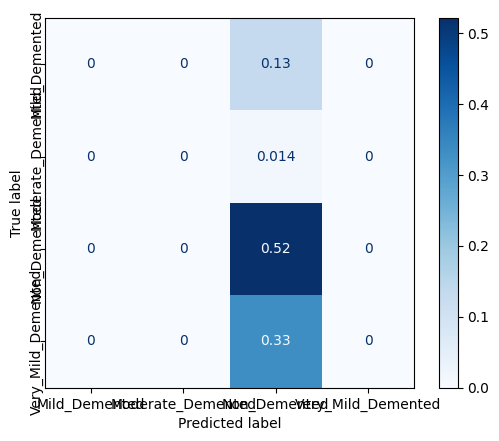

<Figure size 500x500 with 0 Axes>

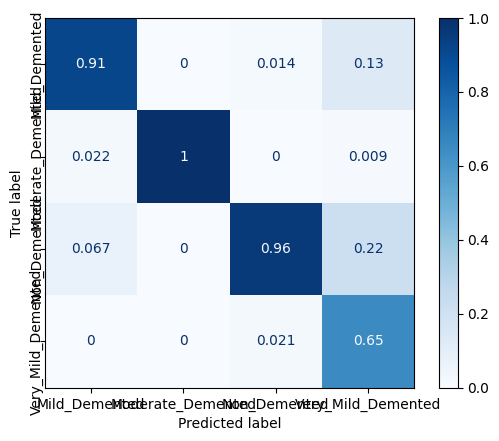

<Figure size 500x500 with 0 Axes>

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r VGG19.zip ./*